This section imports necessary libraries for building and training a CNN, including PyTorch, torchvision, matplotlib, numpy, pandas, os, scikit-learn for accuracy, and tqdm for progress bars. It also sets the device to GPU if available.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


This section extracts the dataset from a zip file located in the `/content/sample_data/` directory into a new folder named `dataset`.

In [ ]:
import zipfile
import os

with zipfile.ZipFile("/content/sample_data/AI_ML_Assignment_4_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

Defining hyperparameters for  CNN experiment, including the number of convolutional and fully connected layers, filter sizes, stride, pooling, and number of epochs.

In [ ]:
# === Parameters to test ===
experiments = [
    {'conv_layers': 2, 'fc_layers': 1, 'filters': [32, 64], 'stride': 1, 'pool': True, 'epochs': 5},
    {'conv_layers': 4, 'fc_layers': 2, 'filters': [32, 64, 128,256], 'stride': 2, 'pool': False, 'epochs': 20},
    {'conv_layers': 4, 'fc_layers':2, 'filters': [32, 64, 128, 256], 'stride': 1, 'pool': True, 'epochs': 25},
    {'conv_layers': 4, 'fc_layers':2, 'filters': [32, 64, 128, 256], 'stride': 2, 'pool': False, 'epochs': 25},
    {'conv_layers': 2, 'fc_layers': 1, 'filters': [16, 32], 'stride': 1, 'pool': True, 'epochs': 15},
    {'conv_layers': 6, 'fc_layers': 1, 'filters': [16, 32, 64, 128, 256, 278], 'stride': 1, 'pool': True, 'epochs': 20},
]



Defines image transformations for training and testing data (including resizing, augmentation for training, and normalization), loads the image datasets

In [ ]:
data_dir = './dataset/5'
train_transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.RandomResizedCrop(84, scale=(0.8, 1.0)), # Randomly crop and resize
    transforms.RandomHorizontalFlip(), #  Randomly flip horizontally
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),  # Simulates occlusion
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet means and stds, common for pre-trained models
])
test_transform = transforms.Compose([
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_set = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
test_set = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)
# Get the class names
class_names = train_set.classes

In [ ]:
print(len(train_set))
print(len(test_set))
print(len(train_set.classes))
print(len(test_set.classes))

print(class_names)

13200
3300
33
33
['african_hunting_dog', 'ant', 'ashcan', 'black_footed_ferret', 'bookshop', 'carousel', 'catamaran', 'cocktail_shaker', 'combination_lock', 'consomme', 'coral_reef', 'dalmatian', 'dishrag', 'fire_screen', 'goose', 'green_mamba', 'king_crab', 'ladybug', 'lion', 'lipstick', 'miniature_poodle', 'orange', 'organ', 'parallel_bars', 'photocopier', 'rhinoceros_beetle', 'slot', 'snorkel', 'spider_web', 'toucan', 'triceratops', 'unicycle', 'vase']


 This section defines a custom CNN class `CustomCNN` that inherits from `nn.Module`. It allows for building CNNs with a configurable number of convolutional and fully connected layers, filter sizes, stride, and pooling. It includes a method to dynamically determine the input size for the fully connected layers.

In [ ]:


# === Define CNN Builder ===
class CustomCNN(nn.Module):
    def __init__(self, conv_layers, fc_layers, filters, stride, use_pool, num_classes=100):
        super(CustomCNN, self).__init__()
        self.conv_blocks = nn.Sequential()
        in_channels = 3
        for i in range(conv_layers):
            self.conv_blocks.add_module(f"conv{i}", nn.Conv2d(in_channels, filters[i], kernel_size=3, stride=stride, padding=1))
            self.conv_blocks.add_module(f"relu{i}", nn.ReLU())
            if use_pool:
                self.conv_blocks.add_module(f"pool{i}", nn.MaxPool2d(kernel_size=2))
            in_channels = filters[i]

        self.flatten = nn.Flatten()
        self._to_linear = None
        self.find_linear_shape()

        fc_layers_list = []
        input_size = self._to_linear
        for _ in range(fc_layers - 1):
            fc_layers_list.append(nn.Linear(input_size, 512))
            fc_layers_list.append(nn.ReLU())
            input_size = 512
        fc_layers_list.append(nn.Linear(input_size, num_classes))

        self.fc_layers = nn.Sequential(*fc_layers_list)

    def find_linear_shape(self):
        with torch.no_grad():
            x = torch.zeros((1, 3, 84, 84))
            x = self.conv_blocks(x)
            self._to_linear = x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x



This cell defines the `train_and_evaluate` function, which trains the `CustomCNN` model for a given configuration, calculates training loss and accuracy per epoch, evaluates the model on the test set, and returns a list of misclassified images. It also saves the model's state dictionary temporarily.

In [ ]:
# === Train and Evaluate ===
results = []

def train_and_evaluate(config):
    model = CustomCNN(config['conv_layers'], config['fc_layers'], config['filters'],
                      config['stride'], config['pool']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    lossfun = nn.CrossEntropyLoss()

    for epoch in range(config['epochs']):
        model.train()
        total_train_correct = 0
        total_train_samples = 0
        for data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}"):
            #data.to(device) moves the data tensor to the specified device cuda/cpu
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data) # Forward pass
            loss = lossfun(output, labels)
            loss.backward()
            optimizer.step()

             # Calculate training accuracy for the batch
            _, predicted = torch.max(output.data, 1)
            train_acc = (predicted == labels).sum().item() / labels.size(0)
            print(f'Epoch {epoch+1} Training Accuracy: {train_acc:.2f}%')

                        # === Evaluation ===
    torch.save(model.state_dict(), "temp_best_model.pth")
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
                for data, labels in test_loader:
                    data = data.to(device)
                    output = model(data)
                    preds = torch.argmax(output, dim=1).cpu().numpy()
                    y_pred.extend(preds)
                    y_true.extend(labels.numpy())

    acc = accuracy_score(y_true, y_pred)
    results.append({
        **config,
        'accuracy': round(acc, 4)
    })

    # Return misclassified images
    misclassified = []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            output = model(data)
            preds = torch.argmax(output, dim=1).cpu()
            mismatches = preds != labels
            for i in torch.where(mismatches)[0][:5]:  # limit 5 samples
                misclassified.append((data[i].cpu(), preds[i].item(), labels[i].item()))
    return misclassified






Helper function `unnormalize` that reverses the normalization applied to image tensors, allowing them to be displayed correctly.

In [ ]:
# Unnormalization helper
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone().detach().numpy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return np.clip(img, 0, 1)

This section iterates through the list of experiment configurations defined earlier. For each configuration, it calls the `train_and_evaluate` function, stores the returned misclassified images, and updates the `best_model` if the current experiment achieved higher accuracy.

In [ ]:
# === Run Experiments ===
misclassified_samples = []
best_model = None
best_accuracy = 0.0
for config in experiments:
    print(f"\nRunning config: {config}")
    misclassified = train_and_evaluate(config)
    misclassified_samples.append(misclassified)
    if results[-1]['accuracy'] > best_accuracy:
        best_accuracy = results[-1]['accuracy']
        best_model = CustomCNN(config['conv_layers'], config['fc_layers'], config['filters'],
                               config['stride'], config['pool']).to(device)
        best_model.load_state_dict(torch.load("temp_best_model.pth"))




Running config: {'conv_layers': 2, 'fc_layers': 1, 'filters': [32, 64], 'stride': 1, 'pool': True, 'epochs': 5}


Epoch 1/5:   0%|          | 1/207 [00:00<00:31,  6.48it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/5:   1%|▏         | 3/207 [00:00<00:21,  9.35it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/5:   2%|▏         | 5/207 [00:00<00:19, 10.44it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:   3%|▎         | 7/207 [00:00<00:18, 10.80it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/5:   4%|▍         | 9/207 [00:00<00:17, 11.07it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/5:   5%|▌         | 11/207 [00:01<00:17, 11.23it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:   6%|▋         | 13/207 [00:01<00:16, 11.42it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/5:   7%|▋         | 15/207 [00:01<00:16, 11.49it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:   8%|▊         | 17/207 [00:01<00:16, 11.40it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/5:   9%|▉         | 19/207 [00:01<00:16, 11.08it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/5:  10%|█         | 21/207 [00:01<00:16, 11.03it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/5:  11%|█         | 23/207 [00:02<00:16, 11.16it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/5:  12%|█▏        | 25/207 [00:02<00:16, 11.27it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/5:  13%|█▎        | 27/207 [00:02<00:15, 11.43it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/5:  14%|█▍        | 29/207 [00:02<00:15, 11.57it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:  15%|█▍        | 31/207 [00:02<00:15, 11.47it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/5:  16%|█▌        | 33/207 [00:02<00:15, 11.50it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/5:  17%|█▋        | 35/207 [00:03<00:14, 11.64it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  18%|█▊        | 37/207 [00:03<00:14, 11.75it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/5:  19%|█▉        | 39/207 [00:03<00:14, 11.69it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  20%|█▉        | 41/207 [00:03<00:14, 11.62it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/5:  21%|██        | 43/207 [00:03<00:14, 11.51it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/5:  22%|██▏       | 45/207 [00:03<00:14, 11.56it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:  23%|██▎       | 47/207 [00:04<00:13, 11.68it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  24%|██▎       | 49/207 [00:04<00:13, 11.81it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  25%|██▍       | 51/207 [00:04<00:13, 11.80it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/5:  26%|██▌       | 53/207 [00:04<00:13, 11.83it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/5:  27%|██▋       | 55/207 [00:04<00:12, 11.81it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  28%|██▊       | 57/207 [00:04<00:12, 11.85it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  29%|██▊       | 59/207 [00:05<00:12, 11.97it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  29%|██▉       | 61/207 [00:05<00:12, 11.85it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  30%|███       | 63/207 [00:05<00:12, 11.88it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  31%|███▏      | 65/207 [00:05<00:12, 11.67it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/5:  32%|███▏      | 67/207 [00:05<00:12, 11.66it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  33%|███▎      | 69/207 [00:06<00:11, 11.76it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/5:  34%|███▍      | 71/207 [00:06<00:11, 11.68it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  35%|███▌      | 73/207 [00:06<00:11, 11.66it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  36%|███▌      | 75/207 [00:06<00:11, 11.73it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/5:  37%|███▋      | 77/207 [00:06<00:11, 11.72it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  38%|███▊      | 79/207 [00:06<00:11, 11.51it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  39%|███▉      | 81/207 [00:07<00:10, 11.58it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  40%|████      | 83/207 [00:07<00:10, 11.63it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  41%|████      | 85/207 [00:07<00:10, 11.69it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  42%|████▏     | 87/207 [00:07<00:10, 11.48it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  43%|████▎     | 89/207 [00:07<00:11, 10.36it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:  44%|████▍     | 91/207 [00:08<00:11,  9.80it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/5:  45%|████▍     | 93/207 [00:08<00:11,  9.65it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  46%|████▌     | 95/207 [00:08<00:12,  9.24it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:  47%|████▋     | 97/207 [00:08<00:11,  9.35it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  48%|████▊     | 99/207 [00:08<00:11,  9.25it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  49%|████▉     | 101/207 [00:09<00:12,  8.55it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  50%|████▉     | 103/207 [00:09<00:12,  8.45it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/5:  51%|█████     | 105/207 [00:09<00:12,  8.34it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  52%|█████▏    | 107/207 [00:09<00:12,  7.94it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/5:  53%|█████▎    | 109/207 [00:10<00:10,  9.22it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.33%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  55%|█████▍    | 113/207 [00:10<00:08, 10.74it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/5:  56%|█████▌    | 115/207 [00:10<00:08, 11.18it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/5:  57%|█████▋    | 119/207 [00:10<00:07, 11.73it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  58%|█████▊    | 121/207 [00:11<00:07, 11.69it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/5:  60%|██████    | 125/207 [00:11<00:07, 11.52it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  61%|██████▏   | 127/207 [00:11<00:06, 11.71it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  63%|██████▎   | 131/207 [00:11<00:06, 11.98it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  64%|██████▍   | 133/207 [00:12<00:06, 11.68it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  66%|██████▌   | 137/207 [00:12<00:06, 11.55it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5:  67%|██████▋   | 139/207 [00:12<00:05, 11.77it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/5:  69%|██████▉   | 143/207 [00:12<00:05, 12.02it/s]

Epoch 1 Training Accuracy: 0.33%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/5:  70%|███████   | 145/207 [00:13<00:05, 11.80it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  72%|███████▏  | 149/207 [00:13<00:04, 11.86it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/5:  73%|███████▎  | 151/207 [00:13<00:04, 12.03it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/5:  75%|███████▍  | 155/207 [00:13<00:04, 12.25it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.33%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  76%|███████▌  | 157/207 [00:14<00:04, 11.84it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/5:  78%|███████▊  | 161/207 [00:14<00:03, 11.50it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/5:  79%|███████▊  | 163/207 [00:14<00:03, 11.73it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/5:  81%|████████  | 167/207 [00:14<00:03, 11.99it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/5:  82%|████████▏ | 169/207 [00:15<00:03, 12.03it/s]

Epoch 1 Training Accuracy: 0.33%
Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.36%


Epoch 1/5:  84%|████████▎ | 173/207 [00:15<00:02, 11.74it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.39%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/5:  85%|████████▍ | 175/207 [00:15<00:02, 11.70it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/5:  86%|████████▋ | 179/207 [00:16<00:02, 11.56it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.36%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/5:  87%|████████▋ | 181/207 [00:16<00:02, 11.32it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.34%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/5:  89%|████████▉ | 185/207 [00:16<00:01, 11.28it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/5:  90%|█████████ | 187/207 [00:16<00:01, 11.28it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  92%|█████████▏| 191/207 [00:17<00:01, 11.58it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/5:  93%|█████████▎| 193/207 [00:17<00:01, 11.33it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/5:  95%|█████████▌| 197/207 [00:17<00:00, 11.78it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.38%


Epoch 1/5:  96%|█████████▌| 199/207 [00:17<00:00, 11.77it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/5:  98%|█████████▊| 203/207 [00:18<00:00, 11.92it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.34%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/5: 100%|██████████| 207/207 [00:18<00:00, 13.10it/s]

Epoch 1 Training Accuracy: 0.36%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.38%
Epoch 1 Training Accuracy: 0.19%


Epoch 2/5:   1%|          | 2/207 [00:00<00:17, 12.01it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:   3%|▎         | 6/207 [00:00<00:16, 12.00it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:   4%|▍         | 8/207 [00:00<00:16, 12.05it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:   6%|▌         | 12/207 [00:00<00:16, 12.02it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:   7%|▋         | 14/207 [00:01<00:16, 11.92it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:   9%|▊         | 18/207 [00:01<00:15, 11.96it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/5:  10%|▉         | 20/207 [00:01<00:17, 10.52it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  11%|█         | 22/207 [00:02<00:20,  8.88it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/5:  12%|█▏        | 24/207 [00:02<00:26,  6.95it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/5:  13%|█▎        | 26/207 [00:02<00:23,  7.57it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  13%|█▎        | 27/207 [00:02<00:24,  7.36it/s]

Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  14%|█▍        | 29/207 [00:03<00:35,  5.01it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/5:  15%|█▍        | 31/207 [00:03<00:28,  6.14it/s]

Epoch 2 Training Accuracy: 0.42%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/5:  15%|█▌        | 32/207 [00:03<00:26,  6.58it/s]

Epoch 2 Training Accuracy: 0.30%


Epoch 2/5:  16%|█▋        | 34/207 [00:04<00:34,  5.06it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  17%|█▋        | 36/207 [00:04<00:25,  6.79it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/5:  19%|█▉        | 40/207 [00:04<00:18,  9.05it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  20%|██        | 42/207 [00:05<00:17,  9.70it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  22%|██▏       | 46/207 [00:05<00:15, 10.60it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/5:  23%|██▎       | 48/207 [00:05<00:14, 10.72it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/5:  25%|██▌       | 52/207 [00:05<00:13, 11.09it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/5:  26%|██▌       | 54/207 [00:06<00:13, 11.20it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/5:  28%|██▊       | 58/207 [00:06<00:13, 11.15it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  29%|██▉       | 60/207 [00:06<00:13, 11.15it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  31%|███       | 64/207 [00:07<00:12, 11.24it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.42%


Epoch 2/5:  32%|███▏      | 66/207 [00:07<00:12, 11.32it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  34%|███▍      | 70/207 [00:07<00:12, 11.29it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/5:  35%|███▍      | 72/207 [00:07<00:11, 11.36it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  37%|███▋      | 76/207 [00:08<00:11, 11.37it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.42%


Epoch 2/5:  38%|███▊      | 78/207 [00:08<00:11, 11.52it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  40%|███▉      | 82/207 [00:08<00:11, 11.34it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.48%


Epoch 2/5:  41%|████      | 84/207 [00:08<00:10, 11.35it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  43%|████▎     | 88/207 [00:09<00:10, 11.54it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  43%|████▎     | 90/207 [00:09<00:10, 11.54it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/5:  45%|████▌     | 94/207 [00:09<00:09, 11.44it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/5:  46%|████▋     | 96/207 [00:09<00:09, 11.42it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.45%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  48%|████▊     | 100/207 [00:10<00:09, 11.38it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/5:  49%|████▉     | 102/207 [00:10<00:09, 11.22it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  51%|█████     | 106/207 [00:10<00:08, 11.31it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/5:  52%|█████▏    | 108/207 [00:10<00:08, 11.28it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/5:  54%|█████▍    | 112/207 [00:11<00:08, 11.56it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:  55%|█████▌    | 114/207 [00:11<00:08, 11.36it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/5:  57%|█████▋    | 118/207 [00:11<00:07, 11.60it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.44%


Epoch 2/5:  58%|█████▊    | 120/207 [00:11<00:07, 11.56it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/5:  60%|█████▉    | 124/207 [00:12<00:07, 11.76it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/5:  61%|██████    | 126/207 [00:12<00:07, 11.45it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  63%|██████▎   | 130/207 [00:12<00:06, 11.40it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  64%|██████▍   | 132/207 [00:13<00:06, 11.43it/s]

Epoch 2 Training Accuracy: 0.45%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/5:  66%|██████▌   | 136/207 [00:13<00:06, 11.69it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.44%


Epoch 2/5:  67%|██████▋   | 138/207 [00:13<00:06, 11.36it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  69%|██████▊   | 142/207 [00:13<00:05, 11.24it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/5:  70%|██████▉   | 144/207 [00:14<00:05, 11.26it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:  71%|███████   | 146/207 [00:14<00:05, 11.17it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  71%|███████▏  | 148/207 [00:14<00:05, 10.56it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:  73%|███████▎  | 151/207 [00:14<00:06,  9.30it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.44%


Epoch 2/5:  74%|███████▍  | 153/207 [00:15<00:05,  9.03it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/5:  75%|███████▍  | 155/207 [00:15<00:05,  8.85it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  76%|███████▌  | 157/207 [00:15<00:05,  8.81it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:  77%|███████▋  | 159/207 [00:15<00:05,  8.53it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/5:  78%|███████▊  | 161/207 [00:16<00:05,  8.38it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/5:  79%|███████▊  | 163/207 [00:16<00:05,  8.40it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  80%|███████▉  | 165/207 [00:16<00:05,  8.17it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  81%|████████  | 167/207 [00:16<00:05,  7.88it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  82%|████████▏ | 170/207 [00:17<00:04,  9.21it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.42%


Epoch 2/5:  83%|████████▎ | 172/207 [00:17<00:03, 10.05it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.42%


Epoch 2/5:  85%|████████▌ | 176/207 [00:17<00:02, 10.81it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.44%


Epoch 2/5:  86%|████████▌ | 178/207 [00:17<00:02, 10.67it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  88%|████████▊ | 182/207 [00:18<00:02, 11.17it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/5:  89%|████████▉ | 184/207 [00:18<00:02, 11.31it/s]

Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/5:  91%|█████████ | 188/207 [00:18<00:01, 11.11it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.42%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/5:  92%|█████████▏| 190/207 [00:18<00:01, 10.85it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/5:  94%|█████████▎| 194/207 [00:19<00:01, 11.06it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/5:  95%|█████████▍| 196/207 [00:19<00:00, 11.16it/s]

Epoch 2 Training Accuracy: 0.50%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5:  97%|█████████▋| 200/207 [00:19<00:00, 11.27it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/5:  98%|█████████▊| 202/207 [00:19<00:00, 10.91it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/5: 100%|█████████▉| 206/207 [00:20<00:00, 11.13it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/5: 100%|██████████| 207/207 [00:20<00:00, 10.18it/s]


Epoch 2 Training Accuracy: 0.31%


Epoch 3/5:   1%|          | 2/207 [00:00<00:18, 11.04it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:   2%|▏         | 4/207 [00:00<00:18, 11.06it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:   3%|▎         | 6/207 [00:00<00:18, 10.65it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:   4%|▍         | 8/207 [00:00<00:18, 10.77it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:   5%|▍         | 10/207 [00:00<00:18, 10.69it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:   6%|▌         | 12/207 [00:01<00:17, 10.89it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:   7%|▋         | 14/207 [00:01<00:18, 10.53it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.48%


Epoch 3/5:   8%|▊         | 16/207 [00:01<00:18, 10.60it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:   9%|▊         | 18/207 [00:01<00:18, 10.43it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  10%|▉         | 20/207 [00:01<00:17, 10.54it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  11%|█         | 22/207 [00:02<00:17, 10.68it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/5:  12%|█▏        | 24/207 [00:02<00:16, 10.83it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.50%


Epoch 3/5:  13%|█▎        | 26/207 [00:02<00:16, 10.93it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/5:  14%|█▎        | 28/207 [00:02<00:16, 10.65it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  14%|█▍        | 30/207 [00:02<00:16, 10.89it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  15%|█▌        | 32/207 [00:02<00:15, 10.99it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  16%|█▋        | 34/207 [00:03<00:15, 11.10it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  17%|█▋        | 36/207 [00:03<00:15, 11.25it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.55%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/5:  18%|█▊        | 38/207 [00:03<00:15, 11.19it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  20%|██        | 42/207 [00:03<00:15, 10.95it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  21%|██▏       | 44/207 [00:04<00:14, 11.06it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  23%|██▎       | 48/207 [00:04<00:14, 11.24it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  24%|██▍       | 50/207 [00:04<00:14, 11.12it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  26%|██▌       | 54/207 [00:04<00:13, 11.05it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  27%|██▋       | 56/207 [00:05<00:13, 11.05it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  29%|██▉       | 60/207 [00:05<00:13, 11.21it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  30%|██▉       | 62/207 [00:05<00:13, 11.02it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  32%|███▏      | 66/207 [00:06<00:12, 11.05it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  33%|███▎      | 68/207 [00:06<00:12, 11.05it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:  35%|███▍      | 72/207 [00:06<00:12, 11.17it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  36%|███▌      | 74/207 [00:06<00:13,  9.83it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:  37%|███▋      | 76/207 [00:07<00:14,  9.34it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  38%|███▊      | 78/207 [00:07<00:14,  9.01it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.53%


Epoch 3/5:  39%|███▊      | 80/207 [00:07<00:14,  8.73it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/5:  40%|███▉      | 82/207 [00:07<00:15,  8.32it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  41%|████      | 84/207 [00:08<00:14,  8.58it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  42%|████▏     | 86/207 [00:08<00:14,  8.53it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/5:  43%|████▎     | 88/207 [00:08<00:14,  8.28it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  43%|████▎     | 90/207 [00:08<00:14,  8.24it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  44%|████▍     | 92/207 [00:09<00:14,  7.80it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  45%|████▌     | 94/207 [00:09<00:14,  8.00it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/5:  46%|████▋     | 96/207 [00:09<00:11,  9.26it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  48%|████▊     | 100/207 [00:09<00:10, 10.40it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/5:  49%|████▉     | 102/207 [00:10<00:10, 10.42it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.45%


Epoch 3/5:  50%|█████     | 104/207 [00:10<00:09, 10.59it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/5:  51%|█████     | 106/207 [00:10<00:11,  9.10it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  52%|█████▏    | 108/207 [00:10<00:13,  7.24it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  54%|█████▎    | 111/207 [00:11<00:10,  8.75it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/5:  55%|█████▍    | 113/207 [00:11<00:10,  8.67it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  56%|█████▌    | 115/207 [00:11<00:13,  6.67it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/5:  57%|█████▋    | 117/207 [00:12<00:11,  7.80it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/5:  58%|█████▊    | 121/207 [00:12<00:09,  9.47it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  59%|█████▉    | 123/207 [00:12<00:12,  6.89it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  61%|██████    | 126/207 [00:13<00:09,  8.43it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  62%|██████▏   | 128/207 [00:13<00:08,  9.38it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  64%|██████▍   | 132/207 [00:13<00:07, 10.68it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/5:  65%|██████▍   | 134/207 [00:13<00:06, 10.95it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.45%


Epoch 3/5:  67%|██████▋   | 138/207 [00:14<00:06, 10.84it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  68%|██████▊   | 140/207 [00:14<00:06, 11.02it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  70%|██████▉   | 144/207 [00:14<00:05, 11.05it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  71%|███████   | 146/207 [00:14<00:05, 11.26it/s]

Epoch 3 Training Accuracy: 0.48%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  72%|███████▏  | 150/207 [00:15<00:05, 11.38it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:  73%|███████▎  | 152/207 [00:15<00:04, 11.51it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/5:  75%|███████▌  | 156/207 [00:15<00:04, 11.44it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:  76%|███████▋  | 158/207 [00:15<00:04, 11.37it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.45%


Epoch 3/5:  78%|███████▊  | 162/207 [00:16<00:04, 11.24it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/5:  79%|███████▉  | 164/207 [00:16<00:03, 11.30it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/5:  81%|████████  | 168/207 [00:16<00:03, 11.49it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/5:  82%|████████▏ | 170/207 [00:16<00:03, 11.51it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  84%|████████▍ | 174/207 [00:17<00:02, 11.10it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  85%|████████▌ | 176/207 [00:17<00:02, 11.12it/s]

Epoch 3 Training Accuracy: 0.48%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  87%|████████▋ | 180/207 [00:17<00:02, 11.13it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  88%|████████▊ | 182/207 [00:18<00:02, 11.22it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5:  90%|████████▉ | 186/207 [00:18<00:01, 11.34it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  91%|█████████ | 188/207 [00:18<00:01, 11.35it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.55%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/5:  93%|█████████▎| 192/207 [00:18<00:01, 11.49it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.48%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/5:  94%|█████████▎| 194/207 [00:19<00:01, 11.47it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.58%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/5:  95%|█████████▍| 196/207 [00:19<00:00, 11.06it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/5:  96%|█████████▌| 198/207 [00:19<00:00, 10.00it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/5:  97%|█████████▋| 201/207 [00:19<00:00,  9.26it/s]

Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.55%


Epoch 3/5:  98%|█████████▊| 203/207 [00:20<00:00,  8.97it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.50%


Epoch 3/5:  99%|█████████▉| 205/207 [00:20<00:00,  8.62it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/5: 100%|██████████| 207/207 [00:20<00:00, 10.08it/s]


Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.00%


Epoch 4/5:   0%|          | 1/207 [00:00<00:23,  8.89it/s]

Epoch 4 Training Accuracy: 0.53%


Epoch 4/5:   1%|          | 2/207 [00:00<00:23,  8.78it/s]

Epoch 4 Training Accuracy: 0.53%


Epoch 4/5:   1%|▏         | 3/207 [00:00<00:23,  8.61it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:   2%|▏         | 4/207 [00:00<00:23,  8.56it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:   2%|▏         | 5/207 [00:00<00:23,  8.78it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:   3%|▎         | 6/207 [00:00<00:24,  8.31it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:   3%|▎         | 7/207 [00:00<00:24,  8.02it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:   4%|▍         | 8/207 [00:00<00:24,  7.99it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:   4%|▍         | 9/207 [00:01<00:25,  7.92it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:   5%|▍         | 10/207 [00:01<00:24,  7.99it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:   6%|▌         | 12/207 [00:01<00:21,  9.19it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:   7%|▋         | 14/207 [00:01<00:19,  9.86it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:   8%|▊         | 16/207 [00:01<00:18, 10.41it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/5:   9%|▊         | 18/207 [00:01<00:17, 10.50it/s]

Epoch 4 Training Accuracy: 0.53%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  10%|▉         | 20/207 [00:02<00:17, 10.70it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  11%|█         | 22/207 [00:02<00:17, 10.85it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  12%|█▏        | 24/207 [00:02<00:16, 11.02it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.56%


Epoch 4/5:  13%|█▎        | 26/207 [00:02<00:16, 11.01it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/5:  14%|█▎        | 28/207 [00:02<00:15, 11.23it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:  14%|█▍        | 30/207 [00:03<00:16, 10.96it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.53%


Epoch 4/5:  15%|█▌        | 32/207 [00:03<00:15, 11.05it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  16%|█▋        | 34/207 [00:03<00:15, 11.17it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  17%|█▋        | 36/207 [00:03<00:15, 11.20it/s]

Epoch 4 Training Accuracy: 0.55%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/5:  18%|█▊        | 38/207 [00:03<00:15, 11.04it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  19%|█▉        | 40/207 [00:03<00:14, 11.15it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  20%|██        | 42/207 [00:04<00:15, 10.89it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  21%|██▏       | 44/207 [00:04<00:14, 10.99it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  22%|██▏       | 46/207 [00:04<00:14, 11.14it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  23%|██▎       | 48/207 [00:04<00:14, 11.23it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  24%|██▍       | 50/207 [00:04<00:13, 11.29it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  25%|██▌       | 52/207 [00:04<00:13, 11.31it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/5:  26%|██▌       | 54/207 [00:05<00:13, 11.15it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.56%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  27%|██▋       | 56/207 [00:05<00:13, 11.13it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  28%|██▊       | 58/207 [00:05<00:13, 11.24it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  29%|██▉       | 60/207 [00:05<00:13, 11.25it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  30%|██▉       | 62/207 [00:05<00:13, 11.08it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  31%|███       | 64/207 [00:06<00:13, 10.81it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  32%|███▏      | 66/207 [00:06<00:13, 10.62it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:  33%|███▎      | 68/207 [00:06<00:12, 10.70it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  34%|███▍      | 70/207 [00:06<00:12, 10.66it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:  35%|███▍      | 72/207 [00:06<00:12, 10.78it/s]

Epoch 4 Training Accuracy: 0.52%
Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/5:  36%|███▌      | 74/207 [00:07<00:12, 10.85it/s]

Epoch 4 Training Accuracy: 0.52%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  37%|███▋      | 76/207 [00:07<00:12, 10.72it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  38%|███▊      | 78/207 [00:07<00:11, 11.00it/s]

Epoch 4 Training Accuracy: 0.56%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.56%


Epoch 4/5:  39%|███▊      | 80/207 [00:07<00:11, 11.19it/s]

Epoch 4 Training Accuracy: 0.53%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  40%|███▉      | 82/207 [00:07<00:11, 11.22it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  41%|████      | 84/207 [00:07<00:10, 11.37it/s]

Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/5:  42%|████▏     | 86/207 [00:08<00:10, 11.34it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  43%|████▎     | 88/207 [00:08<00:10, 11.15it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  43%|████▎     | 90/207 [00:08<00:10, 11.30it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  44%|████▍     | 92/207 [00:08<00:10, 11.20it/s]

Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  45%|████▌     | 94/207 [00:08<00:10, 11.19it/s]

Epoch 4 Training Accuracy: 0.59%


Epoch 4/5:  46%|████▋     | 96/207 [00:08<00:09, 11.22it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.52%


Epoch 4/5:  47%|████▋     | 98/207 [00:09<00:09, 10.94it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/5:  48%|████▊     | 100/207 [00:09<00:09, 11.14it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  49%|████▉     | 102/207 [00:09<00:09, 11.31it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  50%|█████     | 104/207 [00:09<00:09, 11.28it/s]

Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.52%


Epoch 4/5:  51%|█████     | 106/207 [00:09<00:08, 11.41it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  52%|█████▏    | 108/207 [00:10<00:08, 11.50it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  53%|█████▎    | 110/207 [00:10<00:08, 11.07it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  54%|█████▍    | 112/207 [00:10<00:08, 11.28it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  55%|█████▌    | 114/207 [00:10<00:08, 11.36it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  56%|█████▌    | 116/207 [00:10<00:08, 11.04it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  57%|█████▋    | 118/207 [00:10<00:07, 11.13it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/5:  58%|█████▊    | 120/207 [00:11<00:07, 11.25it/s]

Epoch 4 Training Accuracy: 0.58%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  59%|█████▉    | 122/207 [00:11<00:07, 10.75it/s]

Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  60%|█████▉    | 124/207 [00:11<00:08,  9.75it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  60%|██████    | 125/207 [00:11<00:08,  9.47it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  61%|██████    | 126/207 [00:11<00:08,  9.28it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  61%|██████▏   | 127/207 [00:11<00:08,  9.06it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/5:  62%|██████▏   | 128/207 [00:12<00:08,  9.08it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:  62%|██████▏   | 129/207 [00:12<00:08,  8.82it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  63%|██████▎   | 130/207 [00:12<00:08,  8.86it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/5:  63%|██████▎   | 131/207 [00:12<00:08,  8.88it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  64%|██████▍   | 132/207 [00:12<00:08,  9.11it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  64%|██████▍   | 133/207 [00:12<00:08,  9.19it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/5:  65%|██████▍   | 134/207 [00:12<00:07,  9.23it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  65%|██████▌   | 135/207 [00:12<00:07,  9.34it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  66%|██████▌   | 136/207 [00:12<00:07,  9.13it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  66%|██████▌   | 137/207 [00:13<00:08,  8.65it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  67%|██████▋   | 138/207 [00:13<00:08,  8.52it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  67%|██████▋   | 139/207 [00:13<00:08,  8.37it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  68%|██████▊   | 140/207 [00:13<00:08,  8.11it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  68%|██████▊   | 141/207 [00:13<00:08,  8.19it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  69%|██████▊   | 142/207 [00:13<00:08,  8.09it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  69%|██████▉   | 143/207 [00:13<00:07,  8.04it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  70%|██████▉   | 144/207 [00:13<00:07,  7.94it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  71%|███████   | 146/207 [00:14<00:06,  9.10it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.52%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  71%|███████▏  | 148/207 [00:14<00:06,  9.80it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.53%


Epoch 4/5:  72%|███████▏  | 150/207 [00:14<00:05, 10.06it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/5:  73%|███████▎  | 152/207 [00:14<00:05, 10.59it/s]

Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  74%|███████▍  | 154/207 [00:14<00:04, 10.87it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  75%|███████▌  | 156/207 [00:14<00:04, 11.02it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  76%|███████▋  | 158/207 [00:15<00:04, 11.06it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/5:  77%|███████▋  | 160/207 [00:15<00:04, 11.15it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  78%|███████▊  | 162/207 [00:15<00:04, 11.12it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/5:  79%|███████▉  | 164/207 [00:15<00:03, 11.26it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/5:  80%|████████  | 166/207 [00:15<00:03, 11.25it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  81%|████████  | 168/207 [00:16<00:03, 11.25it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/5:  82%|████████▏ | 170/207 [00:16<00:03, 11.27it/s]

Epoch 4 Training Accuracy: 0.56%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/5:  83%|████████▎ | 172/207 [00:16<00:03, 11.18it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  84%|████████▍ | 174/207 [00:16<00:03, 10.97it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  85%|████████▌ | 176/207 [00:16<00:02, 11.10it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  86%|████████▌ | 178/207 [00:16<00:02, 11.11it/s]

Epoch 4 Training Accuracy: 0.66%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  87%|████████▋ | 180/207 [00:17<00:02, 11.16it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  88%|████████▊ | 182/207 [00:17<00:02, 11.24it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/5:  89%|████████▉ | 184/207 [00:17<00:02, 11.28it/s]

Epoch 4 Training Accuracy: 0.52%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  90%|████████▉ | 186/207 [00:17<00:01, 10.98it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  91%|█████████ | 188/207 [00:17<00:01, 11.17it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  92%|█████████▏| 190/207 [00:18<00:01, 11.12it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/5:  93%|█████████▎| 192/207 [00:18<00:01, 11.07it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5:  94%|█████████▎| 194/207 [00:18<00:01, 11.17it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/5:  95%|█████████▍| 196/207 [00:18<00:01, 10.91it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  96%|█████████▌| 198/207 [00:18<00:00, 11.08it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/5:  97%|█████████▋| 200/207 [00:18<00:00, 11.21it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/5:  98%|█████████▊| 202/207 [00:19<00:00, 11.04it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/5:  99%|█████████▊| 204/207 [00:19<00:00, 11.19it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/5: 100%|██████████| 207/207 [00:19<00:00, 10.62it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.25%



Epoch 5/5:   1%|          | 2/207 [00:00<00:19, 10.64it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/5:   3%|▎         | 6/207 [00:00<00:17, 11.21it/s]

Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/5:   4%|▍         | 8/207 [00:00<00:17, 11.35it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:   6%|▌         | 12/207 [00:01<00:16, 11.52it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/5:   7%|▋         | 14/207 [00:01<00:17, 11.18it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/5:   9%|▊         | 18/207 [00:01<00:16, 11.35it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  10%|▉         | 20/207 [00:01<00:16, 11.28it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  12%|█▏        | 24/207 [00:02<00:15, 11.52it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  13%|█▎        | 26/207 [00:02<00:16, 11.19it/s]

Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  14%|█▍        | 30/207 [00:02<00:15, 11.26it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  15%|█▌        | 32/207 [00:02<00:15, 11.34it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/5:  17%|█▋        | 36/207 [00:03<00:15, 11.12it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  18%|█▊        | 38/207 [00:03<00:15, 10.94it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/5:  20%|██        | 42/207 [00:03<00:14, 11.05it/s]

Epoch 5 Training Accuracy: 0.58%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  21%|██▏       | 44/207 [00:03<00:14, 11.11it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.59%
Epoch 5 Training Accuracy: 0.59%


Epoch 5/5:  23%|██▎       | 48/207 [00:04<00:14, 11.20it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.64%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  24%|██▍       | 50/207 [00:04<00:14, 11.16it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/5:  25%|██▌       | 52/207 [00:04<00:15, 10.10it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/5:  26%|██▌       | 54/207 [00:04<00:15,  9.65it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/5:  27%|██▋       | 56/207 [00:05<00:15,  9.45it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  28%|██▊       | 58/207 [00:05<00:16,  8.83it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/5:  29%|██▉       | 60/207 [00:05<00:16,  8.74it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  30%|██▉       | 62/207 [00:05<00:16,  8.90it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  31%|███       | 64/207 [00:06<00:16,  8.49it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  32%|███▏      | 66/207 [00:06<00:17,  8.20it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/5:  33%|███▎      | 68/207 [00:06<00:17,  7.98it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  34%|███▍      | 70/207 [00:06<00:17,  8.02it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  35%|███▍      | 72/207 [00:07<00:17,  7.88it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  36%|███▌      | 74/207 [00:07<00:14,  9.10it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/5:  38%|███▊      | 78/207 [00:07<00:12, 10.02it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  39%|███▊      | 80/207 [00:07<00:12, 10.49it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/5:  41%|████      | 84/207 [00:08<00:11, 11.16it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/5:  42%|████▏     | 86/207 [00:08<00:10, 11.31it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/5:  43%|████▎     | 90/207 [00:08<00:10, 11.27it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/5:  44%|████▍     | 92/207 [00:08<00:10, 11.39it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  46%|████▋     | 96/207 [00:09<00:09, 11.36it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  47%|████▋     | 98/207 [00:09<00:09, 11.39it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/5:  49%|████▉     | 102/207 [00:09<00:09, 11.28it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/5:  50%|█████     | 104/207 [00:09<00:09, 11.40it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/5:  52%|█████▏    | 108/207 [00:10<00:08, 11.29it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/5:  53%|█████▎    | 110/207 [00:10<00:08, 11.30it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.59%
Epoch 5 Training Accuracy: 0.59%


Epoch 5/5:  55%|█████▌    | 114/207 [00:10<00:08, 11.13it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/5:  56%|█████▌    | 116/207 [00:11<00:08, 11.21it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  58%|█████▊    | 120/207 [00:11<00:07, 11.40it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.58%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  59%|█████▉    | 122/207 [00:11<00:07, 11.33it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/5:  61%|██████    | 126/207 [00:11<00:07, 11.34it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  62%|██████▏   | 128/207 [00:12<00:07, 11.24it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/5:  64%|██████▍   | 132/207 [00:12<00:06, 11.47it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/5:  65%|██████▍   | 134/207 [00:12<00:06, 11.52it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  67%|██████▋   | 138/207 [00:12<00:06, 11.41it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  68%|██████▊   | 140/207 [00:13<00:05, 11.41it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/5:  70%|██████▉   | 144/207 [00:13<00:05, 11.65it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  71%|███████   | 146/207 [00:13<00:05, 11.60it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  72%|███████▏  | 150/207 [00:14<00:04, 11.47it/s]

Epoch 5 Training Accuracy: 0.66%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/5:  73%|███████▎  | 152/207 [00:14<00:04, 11.41it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/5:  75%|███████▌  | 156/207 [00:14<00:04, 11.65it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/5:  76%|███████▋  | 158/207 [00:14<00:04, 11.58it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.66%


Epoch 5/5:  78%|███████▊  | 162/207 [00:15<00:03, 11.48it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/5:  79%|███████▉  | 164/207 [00:15<00:03, 11.58it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  81%|████████  | 168/207 [00:15<00:03, 11.78it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  82%|████████▏ | 170/207 [00:15<00:03, 11.54it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  84%|████████▍ | 174/207 [00:16<00:02, 11.57it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.59%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  85%|████████▌ | 176/207 [00:16<00:02, 11.42it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  87%|████████▋ | 180/207 [00:16<00:02, 11.56it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/5:  88%|████████▊ | 182/207 [00:16<00:02, 11.49it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  90%|████████▉ | 186/207 [00:17<00:01, 11.44it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  91%|█████████ | 188/207 [00:17<00:01, 10.37it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/5:  92%|█████████▏| 190/207 [00:17<00:01,  9.77it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/5:  93%|█████████▎| 192/207 [00:17<00:01,  9.47it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  94%|█████████▎| 194/207 [00:18<00:01,  8.93it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  95%|█████████▍| 196/207 [00:18<00:01,  9.06it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/5:  96%|█████████▌| 198/207 [00:18<00:00,  9.24it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/5:  97%|█████████▋| 200/207 [00:18<00:00,  9.06it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/5:  98%|█████████▊| 202/207 [00:18<00:00,  8.92it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5:  99%|█████████▊| 204/207 [00:19<00:00,  8.41it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/5: 100%|██████████| 207/207 [00:19<00:00, 10.62it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.44%



<ipython-input-26-e6fb97ab762d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("temp_best_model.pth"))



Running config: {'conv_layers': 4, 'fc_layers': 2, 'filters': [32, 64, 128, 256], 'stride': 2, 'pool': False, 'epochs': 20}


Epoch 1/20:   0%|          | 1/207 [00:00<00:21,  9.79it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:   1%|▏         | 3/207 [00:00<00:18, 11.24it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:   2%|▏         | 5/207 [00:00<00:17, 11.22it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:   3%|▎         | 7/207 [00:00<00:17, 11.58it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:   4%|▍         | 9/207 [00:00<00:16, 11.84it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:   5%|▌         | 11/207 [00:00<00:16, 11.84it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:   6%|▋         | 13/207 [00:01<00:16, 11.70it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:   7%|▋         | 15/207 [00:01<00:16, 11.92it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:   8%|▊         | 17/207 [00:01<00:16, 11.76it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:   9%|▉         | 19/207 [00:01<00:16, 11.62it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  10%|█         | 21/207 [00:01<00:15, 11.65it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  11%|█         | 23/207 [00:01<00:15, 11.59it/s]

Epoch 1 Training Accuracy: 0.00%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  12%|█▏        | 25/207 [00:02<00:15, 11.67it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  13%|█▎        | 27/207 [00:02<00:15, 11.56it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  14%|█▍        | 29/207 [00:02<00:15, 11.53it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  15%|█▍        | 31/207 [00:02<00:15, 11.54it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  16%|█▌        | 33/207 [00:02<00:15, 11.53it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  17%|█▋        | 35/207 [00:03<00:14, 11.50it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  18%|█▊        | 37/207 [00:03<00:14, 11.42it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  19%|█▉        | 39/207 [00:03<00:14, 11.45it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  20%|█▉        | 41/207 [00:03<00:14, 11.37it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  21%|██        | 43/207 [00:03<00:14, 11.51it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  22%|██▏       | 45/207 [00:03<00:14, 11.53it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  23%|██▎       | 47/207 [00:04<00:13, 11.49it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  24%|██▎       | 49/207 [00:04<00:13, 11.64it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  25%|██▍       | 51/207 [00:04<00:13, 11.58it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  26%|██▌       | 53/207 [00:04<00:13, 11.48it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  27%|██▋       | 55/207 [00:04<00:13, 11.38it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  28%|██▊       | 57/207 [00:04<00:13, 11.49it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  29%|██▊       | 59/207 [00:05<00:12, 11.52it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  29%|██▉       | 61/207 [00:05<00:12, 11.52it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  30%|███       | 63/207 [00:05<00:12, 11.46it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  31%|███▏      | 65/207 [00:05<00:12, 11.10it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  32%|███▏      | 67/207 [00:05<00:13, 10.30it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  33%|███▎      | 69/207 [00:06<00:13,  9.91it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  34%|███▍      | 71/207 [00:06<00:13,  9.81it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  35%|███▍      | 72/207 [00:06<00:13,  9.69it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  35%|███▌      | 73/207 [00:06<00:13,  9.57it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  36%|███▌      | 74/207 [00:06<00:13,  9.60it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  36%|███▌      | 75/207 [00:06<00:13,  9.54it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  37%|███▋      | 76/207 [00:06<00:14,  9.31it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  37%|███▋      | 77/207 [00:06<00:13,  9.33it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  38%|███▊      | 78/207 [00:07<00:13,  9.42it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  38%|███▊      | 79/207 [00:07<00:13,  9.42it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  39%|███▊      | 80/207 [00:07<00:13,  9.40it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  39%|███▉      | 81/207 [00:07<00:13,  9.08it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  40%|███▉      | 82/207 [00:07<00:14,  8.56it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  40%|████      | 83/207 [00:07<00:14,  8.47it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  41%|████      | 84/207 [00:07<00:14,  8.72it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  41%|████      | 85/207 [00:07<00:14,  8.29it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  42%|████▏     | 86/207 [00:08<00:14,  8.29it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  42%|████▏     | 87/207 [00:08<00:14,  8.38it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  43%|████▎     | 88/207 [00:08<00:14,  8.41it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/20:  43%|████▎     | 89/207 [00:08<00:14,  8.34it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  43%|████▎     | 90/207 [00:08<00:14,  8.28it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  44%|████▍     | 91/207 [00:08<00:13,  8.68it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  45%|████▍     | 93/207 [00:08<00:11,  9.95it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  46%|████▌     | 95/207 [00:08<00:10, 10.67it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/20:  47%|████▋     | 97/207 [00:09<00:10, 10.91it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  48%|████▊     | 99/207 [00:09<00:09, 11.17it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  49%|████▉     | 101/207 [00:09<00:09, 11.30it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  50%|████▉     | 103/207 [00:09<00:09, 11.00it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  51%|█████     | 105/207 [00:09<00:09, 11.22it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  52%|█████▏    | 107/207 [00:09<00:08, 11.52it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  53%|█████▎    | 109/207 [00:10<00:08, 11.45it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  54%|█████▎    | 111/207 [00:10<00:08, 11.44it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  55%|█████▍    | 113/207 [00:10<00:08, 11.63it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  56%|█████▌    | 115/207 [00:10<00:08, 11.21it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/20:  57%|█████▋    | 117/207 [00:10<00:07, 11.36it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  57%|█████▋    | 119/207 [00:11<00:07, 11.53it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  58%|█████▊    | 121/207 [00:11<00:07, 11.47it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/20:  59%|█████▉    | 123/207 [00:11<00:07, 11.49it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  60%|██████    | 125/207 [00:11<00:07, 11.55it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  61%|██████▏   | 127/207 [00:11<00:07, 11.31it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  62%|██████▏   | 129/207 [00:11<00:06, 11.35it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/20:  63%|██████▎   | 131/207 [00:12<00:06, 11.56it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  64%|██████▍   | 133/207 [00:12<00:06, 11.46it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/20:  65%|██████▌   | 135/207 [00:12<00:06, 11.64it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/20:  66%|██████▌   | 137/207 [00:12<00:06, 11.64it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  67%|██████▋   | 139/207 [00:12<00:06, 11.29it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  68%|██████▊   | 141/207 [00:12<00:05, 11.37it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  69%|██████▉   | 143/207 [00:13<00:05, 11.32it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  70%|███████   | 145/207 [00:13<00:05, 11.27it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/20:  71%|███████   | 147/207 [00:13<00:05, 11.39it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  72%|███████▏  | 149/207 [00:13<00:05, 11.49it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  73%|███████▎  | 151/207 [00:13<00:04, 11.22it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  74%|███████▍  | 153/207 [00:14<00:04, 11.34it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  75%|███████▍  | 155/207 [00:14<00:04, 11.39it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  76%|███████▌  | 157/207 [00:14<00:04, 11.36it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  77%|███████▋  | 159/207 [00:14<00:04, 11.44it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  78%|███████▊  | 161/207 [00:14<00:04, 11.45it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  79%|███████▊  | 163/207 [00:14<00:03, 11.07it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  80%|███████▉  | 165/207 [00:15<00:03, 11.18it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  81%|████████  | 167/207 [00:15<00:03, 11.24it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  82%|████████▏ | 169/207 [00:15<00:03, 11.17it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/20:  83%|████████▎ | 171/207 [00:15<00:03, 11.19it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  84%|████████▎ | 173/207 [00:15<00:03, 11.04it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/20:  85%|████████▍ | 175/207 [00:15<00:02, 10.73it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/20:  86%|████████▌ | 177/207 [00:16<00:02, 10.92it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  86%|████████▋ | 179/207 [00:16<00:02, 11.11it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  87%|████████▋ | 181/207 [00:16<00:02, 11.06it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  88%|████████▊ | 183/207 [00:16<00:02, 11.19it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/20:  89%|████████▉ | 185/207 [00:16<00:01, 11.21it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  90%|█████████ | 187/207 [00:17<00:01, 11.22it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.31it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/20:  92%|█████████▏| 191/207 [00:17<00:01, 11.32it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/20:  93%|█████████▎| 193/207 [00:17<00:01, 11.13it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/20:  94%|█████████▍| 195/207 [00:17<00:01, 11.18it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  95%|█████████▌| 197/207 [00:17<00:00, 11.11it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  96%|█████████▌| 199/207 [00:18<00:00, 11.23it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/20:  97%|█████████▋| 201/207 [00:18<00:00, 11.27it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  98%|█████████▊| 203/207 [00:18<00:00, 11.35it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  99%|█████████▉| 205/207 [00:18<00:00, 10.39it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/20: 100%|██████████| 207/207 [00:18<00:00, 10.98it/s]


Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.19%


Epoch 2/20:   0%|          | 1/207 [00:00<00:24,  8.52it/s]

Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:   1%|          | 2/207 [00:00<00:23,  8.83it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:   1%|▏         | 3/207 [00:00<00:23,  8.86it/s]

Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:   2%|▏         | 4/207 [00:00<00:23,  8.82it/s]

Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:   2%|▏         | 5/207 [00:00<00:22,  8.86it/s]

Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:   3%|▎         | 6/207 [00:00<00:23,  8.65it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:   3%|▎         | 7/207 [00:00<00:23,  8.50it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:   4%|▍         | 8/207 [00:00<00:23,  8.38it/s]

Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:   4%|▍         | 9/207 [00:01<00:24,  8.11it/s]

Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:   5%|▍         | 10/207 [00:01<00:24,  7.93it/s]

Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:   5%|▌         | 11/207 [00:01<00:23,  8.21it/s]

Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:   6%|▌         | 12/207 [00:01<00:23,  8.29it/s]

Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:   6%|▋         | 13/207 [00:01<00:23,  8.15it/s]

Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:   7%|▋         | 14/207 [00:01<00:23,  8.31it/s]

Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:   7%|▋         | 15/207 [00:01<00:24,  7.85it/s]

Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:   8%|▊         | 16/207 [00:01<00:24,  7.92it/s]

Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:   8%|▊         | 17/207 [00:02<00:24,  7.89it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:   9%|▊         | 18/207 [00:02<00:23,  7.90it/s]

Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:   9%|▉         | 19/207 [00:02<00:24,  7.60it/s]

Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  10%|▉         | 20/207 [00:02<00:24,  7.50it/s]

Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  11%|█         | 22/207 [00:02<00:20,  8.93it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  12%|█▏        | 24/207 [00:02<00:18,  9.68it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  13%|█▎        | 26/207 [00:03<00:17, 10.10it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  14%|█▎        | 28/207 [00:03<00:16, 10.57it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  14%|█▍        | 30/207 [00:03<00:16, 10.48it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  15%|█▌        | 32/207 [00:03<00:16, 10.64it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  16%|█▋        | 34/207 [00:03<00:15, 10.84it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  17%|█▋        | 36/207 [00:03<00:15, 10.86it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  18%|█▊        | 38/207 [00:04<00:15, 11.00it/s]

Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  19%|█▉        | 40/207 [00:04<00:15, 11.09it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  20%|██        | 42/207 [00:04<00:15, 10.83it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  21%|██▏       | 44/207 [00:04<00:14, 11.02it/s]

Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  22%|██▏       | 46/207 [00:04<00:14, 10.98it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  23%|██▎       | 48/207 [00:05<00:14, 10.94it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  24%|██▍       | 50/207 [00:05<00:14, 11.06it/s]

Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  25%|██▌       | 52/207 [00:05<00:13, 11.16it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  26%|██▌       | 54/207 [00:05<00:14, 10.87it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  27%|██▋       | 56/207 [00:05<00:13, 10.93it/s]

Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  28%|██▊       | 58/207 [00:05<00:13, 10.94it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  29%|██▉       | 60/207 [00:06<00:13, 10.75it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.45%


Epoch 2/20:  30%|██▉       | 62/207 [00:06<00:13, 10.86it/s]

Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  31%|███       | 64/207 [00:06<00:13, 10.79it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  32%|███▏      | 66/207 [00:06<00:12, 10.85it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  33%|███▎      | 68/207 [00:06<00:12, 11.02it/s]

Epoch 2 Training Accuracy: 0.30%


Epoch 2/20:  34%|███▍      | 70/207 [00:07<00:12, 11.03it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  35%|███▍      | 72/207 [00:07<00:12, 10.85it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  36%|███▌      | 74/207 [00:07<00:12, 10.77it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/20:  37%|███▋      | 76/207 [00:07<00:12, 10.30it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  38%|███▊      | 78/207 [00:07<00:12, 10.41it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  39%|███▊      | 80/207 [00:07<00:11, 10.61it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  40%|███▉      | 82/207 [00:08<00:11, 10.62it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  41%|████      | 84/207 [00:08<00:11, 10.91it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  42%|████▏     | 86/207 [00:08<00:11, 10.45it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  43%|████▎     | 88/207 [00:08<00:11, 10.26it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  43%|████▎     | 90/207 [00:08<00:11, 10.49it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  44%|████▍     | 92/207 [00:09<00:10, 10.84it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  45%|████▌     | 94/207 [00:09<00:10, 10.93it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  46%|████▋     | 96/207 [00:09<00:10, 10.95it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  47%|████▋     | 98/207 [00:09<00:10, 10.79it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  48%|████▊     | 100/207 [00:09<00:09, 10.77it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  49%|████▉     | 102/207 [00:10<00:09, 10.90it/s]

Epoch 2 Training Accuracy: 0.31%


Epoch 2/20:  50%|█████     | 104/207 [00:10<00:09, 10.97it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  51%|█████     | 106/207 [00:10<00:09, 10.92it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  52%|█████▏    | 108/207 [00:10<00:09, 10.80it/s]

Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  53%|█████▎    | 110/207 [00:10<00:09, 10.58it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  54%|█████▍    | 112/207 [00:10<00:08, 10.61it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  55%|█████▌    | 114/207 [00:11<00:08, 10.69it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  56%|█████▌    | 116/207 [00:11<00:08, 10.89it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  57%|█████▋    | 118/207 [00:11<00:08, 10.89it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  58%|█████▊    | 120/207 [00:11<00:08, 10.64it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  59%|█████▉    | 122/207 [00:11<00:07, 10.67it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  60%|█████▉    | 124/207 [00:12<00:07, 10.63it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  61%|██████    | 126/207 [00:12<00:07, 10.70it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  62%|██████▏   | 128/207 [00:12<00:07, 10.99it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/20:  63%|██████▎   | 130/207 [00:12<00:07,  9.99it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  64%|██████▍   | 132/207 [00:12<00:08,  9.31it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  65%|██████▍   | 134/207 [00:13<00:08,  8.99it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  66%|██████▌   | 136/207 [00:13<00:08,  8.69it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  67%|██████▋   | 138/207 [00:13<00:08,  8.39it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/20:  68%|██████▊   | 140/207 [00:13<00:08,  8.22it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  69%|██████▊   | 142/207 [00:14<00:07,  8.30it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/20:  70%|██████▉   | 144/207 [00:14<00:07,  8.08it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  71%|███████   | 146/207 [00:14<00:07,  8.02it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  71%|███████▏  | 148/207 [00:14<00:07,  7.94it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/20:  72%|███████▏  | 150/207 [00:15<00:07,  7.62it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  74%|███████▍  | 153/207 [00:15<00:05,  9.21it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  75%|███████▍  | 155/207 [00:15<00:05,  9.92it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  77%|███████▋  | 159/207 [00:15<00:04, 10.72it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  78%|███████▊  | 161/207 [00:16<00:04, 10.91it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  80%|███████▉  | 165/207 [00:16<00:03, 11.05it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  81%|████████  | 167/207 [00:16<00:03, 11.03it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  83%|████████▎ | 171/207 [00:17<00:03, 11.19it/s]

Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  84%|████████▎ | 173/207 [00:17<00:03, 11.22it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/20:  86%|████████▌ | 177/207 [00:17<00:02, 11.57it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  86%|████████▋ | 179/207 [00:17<00:02, 11.57it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/20:  88%|████████▊ | 183/207 [00:18<00:02, 11.55it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  89%|████████▉ | 185/207 [00:18<00:01, 11.58it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  91%|█████████▏| 189/207 [00:18<00:01, 11.91it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/20:  92%|█████████▏| 191/207 [00:18<00:01, 11.92it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/20:  94%|█████████▍| 195/207 [00:19<00:01, 11.52it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  95%|█████████▌| 197/207 [00:19<00:00, 11.70it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/20:  97%|█████████▋| 201/207 [00:19<00:00, 11.85it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/20:  98%|█████████▊| 203/207 [00:19<00:00, 11.78it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/20: 100%|██████████| 207/207 [00:20<00:00, 10.31it/s]


Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.25%


Epoch 3/20:   1%|▏         | 3/207 [00:00<00:18, 11.22it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:   2%|▏         | 5/207 [00:00<00:17, 11.35it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:   4%|▍         | 9/207 [00:00<00:17, 11.54it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:   5%|▌         | 11/207 [00:00<00:16, 11.56it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:   7%|▋         | 15/207 [00:01<00:16, 11.47it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:   8%|▊         | 17/207 [00:01<00:16, 11.46it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  10%|█         | 21/207 [00:01<00:16, 11.54it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  11%|█         | 23/207 [00:02<00:15, 11.51it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  13%|█▎        | 27/207 [00:02<00:15, 11.41it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  14%|█▍        | 29/207 [00:02<00:15, 11.48it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  16%|█▌        | 33/207 [00:02<00:15, 11.51it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  17%|█▋        | 35/207 [00:03<00:15, 11.34it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/20:  19%|█▉        | 39/207 [00:03<00:14, 11.42it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  20%|█▉        | 41/207 [00:03<00:14, 11.44it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  22%|██▏       | 45/207 [00:03<00:14, 11.57it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  23%|██▎       | 47/207 [00:04<00:13, 11.48it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.47%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  25%|██▍       | 51/207 [00:04<00:13, 11.53it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  26%|██▌       | 53/207 [00:04<00:13, 11.50it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  28%|██▊       | 57/207 [00:04<00:12, 11.55it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  29%|██▊       | 59/207 [00:05<00:12, 11.51it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  29%|██▉       | 61/207 [00:05<00:14, 10.13it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  30%|███       | 63/207 [00:05<00:14,  9.75it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  31%|███▏      | 65/207 [00:05<00:15,  9.34it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  32%|███▏      | 67/207 [00:06<00:15,  9.13it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  33%|███▎      | 69/207 [00:06<00:15,  8.72it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  34%|███▍      | 71/207 [00:06<00:15,  8.90it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/20:  35%|███▌      | 73/207 [00:06<00:14,  8.94it/s]

Epoch 3 Training Accuracy: 0.16%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  36%|███▌      | 75/207 [00:07<00:15,  8.61it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  37%|███▋      | 77/207 [00:07<00:15,  8.18it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  38%|███▊      | 79/207 [00:07<00:16,  7.69it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  39%|███▉      | 81/207 [00:07<00:15,  7.89it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/20:  41%|████      | 84/207 [00:08<00:12,  9.66it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  42%|████▏     | 86/207 [00:08<00:11, 10.44it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  43%|████▎     | 90/207 [00:08<00:10, 11.12it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  44%|████▍     | 92/207 [00:08<00:10, 11.18it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  46%|████▋     | 96/207 [00:09<00:09, 11.32it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  47%|████▋     | 98/207 [00:09<00:09, 11.02it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  49%|████▉     | 102/207 [00:09<00:09, 11.11it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  50%|█████     | 104/207 [00:09<00:09, 11.29it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  52%|█████▏    | 108/207 [00:10<00:08, 11.63it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  53%|█████▎    | 110/207 [00:10<00:08, 11.64it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  55%|█████▌    | 114/207 [00:10<00:08, 11.37it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/20:  56%|█████▌    | 116/207 [00:10<00:08, 11.30it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  58%|█████▊    | 120/207 [00:11<00:07, 11.18it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  59%|█████▉    | 122/207 [00:11<00:07, 11.03it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  61%|██████    | 126/207 [00:11<00:07, 11.03it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  62%|██████▏   | 128/207 [00:11<00:07, 10.90it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  64%|██████▍   | 132/207 [00:12<00:06, 10.92it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/20:  65%|██████▍   | 134/207 [00:12<00:06, 10.90it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  67%|██████▋   | 138/207 [00:12<00:06, 10.92it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  68%|██████▊   | 140/207 [00:13<00:06, 10.91it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  70%|██████▉   | 144/207 [00:13<00:05, 11.22it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  71%|███████   | 146/207 [00:13<00:05, 10.95it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  72%|███████▏  | 150/207 [00:13<00:05, 11.15it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  73%|███████▎  | 152/207 [00:14<00:04, 11.12it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  75%|███████▌  | 156/207 [00:14<00:04, 11.43it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  76%|███████▋  | 158/207 [00:14<00:04, 11.36it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  78%|███████▊  | 162/207 [00:15<00:03, 11.51it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  79%|███████▉  | 164/207 [00:15<00:03, 11.54it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  81%|████████  | 168/207 [00:15<00:03, 11.96it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  82%|████████▏ | 170/207 [00:15<00:03, 11.48it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/20:  84%|████████▍ | 174/207 [00:16<00:02, 11.84it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  85%|████████▌ | 176/207 [00:16<00:02, 11.88it/s]

Epoch 3 Training Accuracy: 0.48%
Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  87%|████████▋ | 180/207 [00:16<00:02, 11.87it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  88%|████████▊ | 182/207 [00:16<00:02, 11.50it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  90%|████████▉ | 186/207 [00:17<00:01, 11.57it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  91%|█████████ | 188/207 [00:17<00:01, 11.60it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  93%|█████████▎| 192/207 [00:17<00:01, 11.65it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  94%|█████████▎| 194/207 [00:17<00:01, 11.16it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/20:  95%|█████████▍| 196/207 [00:18<00:01, 10.65it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  96%|█████████▌| 198/207 [00:18<00:00,  9.93it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  97%|█████████▋| 201/207 [00:18<00:00,  9.56it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  98%|█████████▊| 203/207 [00:18<00:00,  9.30it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  99%|█████████▉| 205/207 [00:19<00:00,  8.88it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/20: 100%|██████████| 207/207 [00:19<00:00, 10.78it/s]


Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.25%


Epoch 4/20:   0%|          | 1/207 [00:00<00:23,  8.61it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:   1%|          | 2/207 [00:00<00:23,  8.78it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:   1%|▏         | 3/207 [00:00<00:22,  9.01it/s]

Epoch 4 Training Accuracy: 0.22%


Epoch 4/20:   2%|▏         | 4/207 [00:00<00:24,  8.44it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:   2%|▏         | 5/207 [00:00<00:24,  8.32it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:   3%|▎         | 6/207 [00:00<00:23,  8.50it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:   3%|▎         | 7/207 [00:00<00:24,  8.07it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/20:   4%|▍         | 8/207 [00:00<00:24,  8.12it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:   4%|▍         | 9/207 [00:01<00:24,  8.03it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:   5%|▍         | 10/207 [00:01<00:25,  7.80it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:   5%|▌         | 11/207 [00:01<00:25,  7.57it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:   6%|▌         | 12/207 [00:01<00:25,  7.54it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:   6%|▋         | 13/207 [00:01<00:26,  7.44it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/20:   7%|▋         | 15/207 [00:01<00:22,  8.66it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:   8%|▊         | 17/207 [00:01<00:19,  9.60it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:   9%|▉         | 19/207 [00:02<00:18, 10.32it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  10%|█         | 21/207 [00:02<00:17, 10.76it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  11%|█         | 23/207 [00:02<00:16, 10.83it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  12%|█▏        | 25/207 [00:02<00:16, 10.89it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  13%|█▎        | 27/207 [00:02<00:16, 10.87it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  14%|█▍        | 29/207 [00:03<00:16, 11.00it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  15%|█▍        | 31/207 [00:03<00:15, 11.24it/s]

Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  16%|█▌        | 33/207 [00:03<00:15, 11.35it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  17%|█▋        | 35/207 [00:03<00:15, 11.24it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/20:  18%|█▊        | 37/207 [00:03<00:15, 11.31it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/20:  19%|█▉        | 39/207 [00:03<00:14, 11.24it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.50%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/20:  20%|█▉        | 41/207 [00:04<00:14, 11.24it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  21%|██        | 43/207 [00:04<00:14, 11.25it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  22%|██▏       | 45/207 [00:04<00:14, 11.44it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/20:  23%|██▎       | 47/207 [00:04<00:13, 11.49it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  24%|██▎       | 49/207 [00:04<00:13, 11.59it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  25%|██▍       | 51/207 [00:04<00:13, 11.51it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/20:  26%|██▌       | 53/207 [00:05<00:13, 11.41it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  27%|██▋       | 55/207 [00:05<00:13, 11.60it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  28%|██▊       | 57/207 [00:05<00:12, 11.78it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  29%|██▊       | 59/207 [00:05<00:12, 11.65it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  29%|██▉       | 61/207 [00:05<00:12, 11.66it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  30%|███       | 63/207 [00:06<00:12, 11.65it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  31%|███▏      | 65/207 [00:06<00:12, 11.47it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  32%|███▏      | 67/207 [00:06<00:12, 11.54it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/20:  33%|███▎      | 69/207 [00:06<00:11, 11.62it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  34%|███▍      | 71/207 [00:06<00:11, 11.68it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  35%|███▌      | 73/207 [00:06<00:11, 11.77it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  36%|███▌      | 75/207 [00:07<00:11, 11.78it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  37%|███▋      | 77/207 [00:07<00:11, 11.58it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/20:  38%|███▊      | 79/207 [00:07<00:11, 11.62it/s]

Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  39%|███▉      | 81/207 [00:07<00:10, 11.70it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  40%|████      | 83/207 [00:07<00:10, 11.42it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  41%|████      | 85/207 [00:07<00:10, 11.49it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  42%|████▏     | 87/207 [00:08<00:10, 11.42it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  43%|████▎     | 89/207 [00:08<00:10, 11.46it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  44%|████▍     | 91/207 [00:08<00:10, 11.53it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  45%|████▍     | 93/207 [00:08<00:09, 11.46it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  46%|████▌     | 95/207 [00:08<00:09, 11.24it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  47%|████▋     | 97/207 [00:08<00:09, 11.27it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  48%|████▊     | 99/207 [00:09<00:09, 11.01it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  49%|████▉     | 101/207 [00:09<00:09, 11.12it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  50%|████▉     | 103/207 [00:09<00:09, 11.32it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  51%|█████     | 105/207 [00:09<00:08, 11.39it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  52%|█████▏    | 107/207 [00:09<00:08, 11.38it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  53%|█████▎    | 109/207 [00:10<00:08, 11.48it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  54%|█████▎    | 111/207 [00:10<00:08, 11.24it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  55%|█████▍    | 113/207 [00:10<00:08, 11.24it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  56%|█████▌    | 115/207 [00:10<00:07, 11.53it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  57%|█████▋    | 117/207 [00:10<00:07, 11.64it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  57%|█████▋    | 119/207 [00:10<00:07, 11.41it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  58%|█████▊    | 121/207 [00:11<00:07, 11.58it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  59%|█████▉    | 123/207 [00:11<00:07, 11.44it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  60%|██████    | 125/207 [00:11<00:07, 11.42it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  61%|██████▏   | 127/207 [00:11<00:06, 11.53it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  62%|██████▏   | 129/207 [00:11<00:07, 10.44it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  63%|██████▎   | 131/207 [00:12<00:07,  9.82it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  64%|██████▍   | 133/207 [00:12<00:07,  9.36it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  65%|██████▍   | 134/207 [00:12<00:07,  9.15it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  65%|██████▌   | 135/207 [00:12<00:07,  9.25it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  66%|██████▌   | 136/207 [00:12<00:07,  9.33it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  66%|██████▌   | 137/207 [00:12<00:07,  9.02it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  67%|██████▋   | 138/207 [00:12<00:07,  8.84it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  67%|██████▋   | 139/207 [00:13<00:07,  8.51it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  68%|██████▊   | 140/207 [00:13<00:07,  8.64it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  68%|██████▊   | 141/207 [00:13<00:07,  8.97it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  69%|██████▊   | 142/207 [00:13<00:07,  8.70it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/20:  69%|██████▉   | 143/207 [00:13<00:07,  8.64it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  70%|██████▉   | 144/207 [00:13<00:07,  8.75it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  70%|███████   | 145/207 [00:13<00:07,  8.84it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  71%|███████   | 146/207 [00:13<00:07,  8.43it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  71%|███████   | 147/207 [00:13<00:07,  8.40it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  71%|███████▏  | 148/207 [00:14<00:07,  8.36it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  72%|███████▏  | 149/207 [00:14<00:07,  8.09it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  72%|███████▏  | 150/207 [00:14<00:07,  8.07it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  73%|███████▎  | 151/207 [00:14<00:07,  7.93it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  74%|███████▍  | 153/207 [00:14<00:05,  9.41it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  75%|███████▍  | 155/207 [00:14<00:05, 10.18it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  76%|███████▌  | 157/207 [00:14<00:04, 10.63it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  77%|███████▋  | 159/207 [00:15<00:04, 11.00it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  78%|███████▊  | 161/207 [00:15<00:04, 11.03it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  79%|███████▊  | 163/207 [00:15<00:03, 11.12it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/20:  80%|███████▉  | 165/207 [00:15<00:03, 11.33it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.52%


Epoch 4/20:  81%|████████  | 167/207 [00:15<00:03, 11.31it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  82%|████████▏ | 169/207 [00:15<00:03, 11.56it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  83%|████████▎ | 171/207 [00:16<00:03, 11.73it/s]

Epoch 4 Training Accuracy: 0.53%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/20:  84%|████████▎ | 173/207 [00:16<00:02, 11.54it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/20:  85%|████████▍ | 175/207 [00:16<00:02, 11.53it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/20:  86%|████████▌ | 177/207 [00:16<00:02, 11.57it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/20:  86%|████████▋ | 179/207 [00:16<00:02, 11.15it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  87%|████████▋ | 181/207 [00:17<00:02, 11.04it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  88%|████████▊ | 183/207 [00:17<00:02, 11.01it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/20:  89%|████████▉ | 185/207 [00:17<00:02, 10.84it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  90%|█████████ | 187/207 [00:17<00:01, 10.83it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.00it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  92%|█████████▏| 191/207 [00:17<00:01, 11.09it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  93%|█████████▎| 193/207 [00:18<00:01, 11.36it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  94%|█████████▍| 195/207 [00:18<00:01, 11.47it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  95%|█████████▌| 197/207 [00:18<00:00, 11.21it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.52%


Epoch 4/20:  96%|█████████▌| 199/207 [00:18<00:00, 11.09it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  97%|█████████▋| 201/207 [00:18<00:00, 11.12it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  98%|█████████▊| 203/207 [00:19<00:00, 10.93it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  99%|█████████▉| 205/207 [00:19<00:00, 11.14it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/20: 100%|██████████| 207/207 [00:19<00:00, 10.70it/s]


Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.56%


Epoch 5/20:   0%|          | 1/207 [00:00<00:21,  9.51it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:   1%|▏         | 3/207 [00:00<00:19, 10.39it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:   2%|▏         | 5/207 [00:00<00:19, 10.30it/s]

Epoch 5 Training Accuracy: 0.27%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:   3%|▎         | 7/207 [00:00<00:18, 10.66it/s]

Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:   4%|▍         | 9/207 [00:00<00:18, 10.92it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:   5%|▌         | 11/207 [00:01<00:17, 11.01it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:   6%|▋         | 13/207 [00:01<00:17, 11.24it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:   7%|▋         | 15/207 [00:01<00:17, 11.08it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:   8%|▊         | 17/207 [00:01<00:17, 11.15it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:   9%|▉         | 19/207 [00:01<00:16, 11.29it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  10%|█         | 21/207 [00:01<00:16, 11.02it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  11%|█         | 23/207 [00:02<00:16, 11.01it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  12%|█▏        | 25/207 [00:02<00:16, 11.13it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  13%|█▎        | 27/207 [00:02<00:16, 11.00it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/20:  14%|█▍        | 29/207 [00:02<00:16, 11.02it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  15%|█▍        | 31/207 [00:02<00:15, 11.21it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  16%|█▌        | 33/207 [00:02<00:15, 11.25it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:  17%|█▋        | 35/207 [00:03<00:15, 11.28it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  18%|█▊        | 37/207 [00:03<00:15, 11.28it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:  19%|█▉        | 39/207 [00:03<00:15, 11.20it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  20%|█▉        | 41/207 [00:03<00:14, 11.21it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  21%|██        | 43/207 [00:03<00:14, 11.27it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  22%|██▏       | 45/207 [00:04<00:14, 11.34it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:  23%|██▎       | 47/207 [00:04<00:14, 11.27it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  24%|██▎       | 49/207 [00:04<00:14, 11.04it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  25%|██▍       | 51/207 [00:04<00:13, 11.24it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  26%|██▌       | 53/207 [00:04<00:13, 11.29it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:  27%|██▋       | 55/207 [00:04<00:13, 11.32it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  28%|██▊       | 57/207 [00:05<00:13, 11.14it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  29%|██▊       | 59/207 [00:05<00:14, 10.26it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  29%|██▉       | 61/207 [00:05<00:15,  9.60it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  30%|███       | 63/207 [00:05<00:15,  9.53it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  31%|███▏      | 65/207 [00:06<00:15,  8.96it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  32%|███▏      | 67/207 [00:06<00:16,  8.54it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  33%|███▎      | 69/207 [00:06<00:16,  8.55it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  34%|███▍      | 71/207 [00:06<00:16,  8.43it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:  35%|███▌      | 73/207 [00:07<00:15,  8.58it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  36%|███▌      | 75/207 [00:07<00:16,  7.86it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  37%|███▋      | 77/207 [00:07<00:16,  8.05it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:  38%|███▊      | 79/207 [00:07<00:16,  7.77it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  39%|███▉      | 81/207 [00:07<00:13,  9.13it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  41%|████      | 85/207 [00:08<00:11, 10.68it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  42%|████▏     | 87/207 [00:08<00:10, 11.10it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  44%|████▍     | 91/207 [00:08<00:10, 11.42it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  45%|████▍     | 93/207 [00:08<00:09, 11.44it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/20:  47%|████▋     | 97/207 [00:09<00:09, 11.75it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  48%|████▊     | 99/207 [00:09<00:09, 11.70it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:  50%|████▉     | 103/207 [00:09<00:08, 11.68it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  51%|█████     | 105/207 [00:10<00:08, 11.62it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/20:  53%|█████▎    | 109/207 [00:10<00:08, 11.23it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  54%|█████▎    | 111/207 [00:10<00:08, 11.33it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  56%|█████▌    | 115/207 [00:10<00:07, 11.51it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  57%|█████▋    | 117/207 [00:11<00:07, 11.46it/s]

Epoch 5 Training Accuracy: 0.58%
Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  58%|█████▊    | 121/207 [00:11<00:07, 11.73it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/20:  59%|█████▉    | 123/207 [00:11<00:07, 11.71it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  61%|██████▏   | 127/207 [00:11<00:06, 11.86it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/20:  62%|██████▏   | 129/207 [00:12<00:06, 11.69it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  64%|██████▍   | 133/207 [00:12<00:06, 11.70it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  65%|██████▌   | 135/207 [00:12<00:06, 11.73it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  67%|██████▋   | 139/207 [00:12<00:05, 11.50it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  68%|██████▊   | 141/207 [00:13<00:05, 11.56it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  70%|███████   | 145/207 [00:13<00:05, 11.75it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  71%|███████   | 147/207 [00:13<00:05, 11.72it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  73%|███████▎  | 151/207 [00:13<00:04, 11.59it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  74%|███████▍  | 153/207 [00:14<00:04, 11.50it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  76%|███████▌  | 157/207 [00:14<00:04, 11.63it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  77%|███████▋  | 159/207 [00:14<00:04, 11.57it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  79%|███████▊  | 163/207 [00:15<00:03, 11.28it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/20:  80%|███████▉  | 165/207 [00:15<00:03, 11.45it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.25%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  82%|████████▏ | 169/207 [00:15<00:03, 11.33it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  83%|████████▎ | 171/207 [00:15<00:03, 11.47it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:  85%|████████▍ | 175/207 [00:16<00:02, 11.43it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  86%|████████▌ | 177/207 [00:16<00:02, 11.60it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  87%|████████▋ | 181/207 [00:16<00:02, 11.63it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  88%|████████▊ | 183/207 [00:16<00:02, 11.53it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  90%|█████████ | 187/207 [00:17<00:01, 11.43it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.46it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  93%|█████████▎| 193/207 [00:17<00:01, 11.60it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  94%|█████████▍| 195/207 [00:17<00:01, 11.61it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  95%|█████████▌| 197/207 [00:18<00:00, 10.22it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/20:  96%|█████████▌| 199/207 [00:18<00:00,  9.73it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  97%|█████████▋| 201/207 [00:18<00:00,  9.45it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  98%|█████████▊| 203/207 [00:18<00:00,  9.51it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  99%|█████████▉| 205/207 [00:18<00:00,  9.12it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20: 100%|██████████| 207/207 [00:19<00:00, 10.84it/s]


Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.62%


Epoch 6/20:   0%|          | 1/207 [00:00<00:28,  7.36it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:   1%|          | 2/207 [00:00<00:24,  8.39it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:   1%|▏         | 3/207 [00:00<00:22,  8.89it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:   2%|▏         | 4/207 [00:00<00:22,  9.03it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:   2%|▏         | 5/207 [00:00<00:22,  9.09it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:   3%|▎         | 6/207 [00:00<00:23,  8.68it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:   3%|▎         | 7/207 [00:00<00:24,  8.24it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:   4%|▍         | 8/207 [00:00<00:24,  8.17it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:   4%|▍         | 9/207 [00:01<00:24,  8.10it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:   5%|▍         | 10/207 [00:01<00:24,  7.89it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:   5%|▌         | 11/207 [00:01<00:24,  7.88it/s]

Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:   6%|▌         | 12/207 [00:01<00:24,  8.06it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:   6%|▋         | 13/207 [00:01<00:23,  8.12it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:   7%|▋         | 14/207 [00:01<00:23,  8.08it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:   7%|▋         | 15/207 [00:01<00:23,  8.08it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:   8%|▊         | 17/207 [00:01<00:20,  9.44it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:  10%|▉         | 20/207 [00:02<00:18, 10.11it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  11%|█         | 22/207 [00:02<00:17, 10.42it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  12%|█▏        | 24/207 [00:02<00:17, 10.48it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  13%|█▎        | 26/207 [00:02<00:16, 10.91it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  14%|█▎        | 28/207 [00:02<00:16, 11.04it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  14%|█▍        | 30/207 [00:03<00:15, 11.25it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  15%|█▌        | 32/207 [00:03<00:15, 11.25it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  16%|█▋        | 34/207 [00:03<00:15, 10.92it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.30%


Epoch 6/20:  17%|█▋        | 36/207 [00:03<00:15, 11.16it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  18%|█▊        | 38/207 [00:03<00:15, 11.20it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  19%|█▉        | 40/207 [00:04<00:15, 11.12it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:  20%|██        | 42/207 [00:04<00:14, 11.27it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  21%|██▏       | 44/207 [00:04<00:14, 11.05it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  22%|██▏       | 46/207 [00:04<00:14, 11.09it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  23%|██▎       | 48/207 [00:04<00:14, 11.30it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  24%|██▍       | 50/207 [00:04<00:13, 11.48it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  25%|██▌       | 52/207 [00:05<00:13, 11.43it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  26%|██▌       | 54/207 [00:05<00:13, 11.43it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  27%|██▋       | 56/207 [00:05<00:13, 11.21it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  28%|██▊       | 58/207 [00:05<00:13, 11.16it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  29%|██▉       | 60/207 [00:05<00:12, 11.42it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  30%|██▉       | 62/207 [00:05<00:12, 11.44it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  31%|███       | 64/207 [00:06<00:12, 11.37it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  32%|███▏      | 66/207 [00:06<00:12, 11.58it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  33%|███▎      | 68/207 [00:06<00:12, 11.26it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  34%|███▍      | 70/207 [00:06<00:12, 11.33it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  35%|███▍      | 72/207 [00:06<00:11, 11.53it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  36%|███▌      | 74/207 [00:07<00:11, 11.60it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  37%|███▋      | 76/207 [00:07<00:11, 11.41it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  38%|███▊      | 78/207 [00:07<00:11, 11.42it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  39%|███▊      | 80/207 [00:07<00:11, 11.33it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  40%|███▉      | 82/207 [00:07<00:11, 11.24it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  41%|████      | 84/207 [00:07<00:10, 11.42it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  42%|████▏     | 86/207 [00:08<00:10, 11.47it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  43%|████▎     | 88/207 [00:08<00:10, 11.40it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  43%|████▎     | 90/207 [00:08<00:10, 11.51it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  44%|████▍     | 92/207 [00:08<00:10, 11.39it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  45%|████▌     | 94/207 [00:08<00:10, 11.29it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  46%|████▋     | 96/207 [00:08<00:09, 11.27it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  47%|████▋     | 98/207 [00:09<00:09, 11.37it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  48%|████▊     | 100/207 [00:09<00:09, 11.15it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  49%|████▉     | 102/207 [00:09<00:09, 11.13it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  50%|█████     | 104/207 [00:09<00:09, 11.03it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  51%|█████     | 106/207 [00:09<00:09, 10.63it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  52%|█████▏    | 108/207 [00:10<00:09, 10.79it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  53%|█████▎    | 110/207 [00:10<00:08, 10.95it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  54%|█████▍    | 112/207 [00:10<00:08, 10.81it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  55%|█████▌    | 114/207 [00:10<00:08, 10.65it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  56%|█████▌    | 116/207 [00:10<00:08, 10.80it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  57%|█████▋    | 118/207 [00:11<00:08, 10.57it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  58%|█████▊    | 120/207 [00:11<00:08, 10.70it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  59%|█████▉    | 122/207 [00:11<00:07, 10.77it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  60%|█████▉    | 124/207 [00:11<00:07, 10.78it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  61%|██████    | 126/207 [00:11<00:07, 10.72it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  62%|██████▏   | 128/207 [00:12<00:08,  9.82it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  62%|██████▏   | 129/207 [00:12<00:08,  9.59it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  63%|██████▎   | 130/207 [00:12<00:08,  9.33it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/20:  63%|██████▎   | 131/207 [00:12<00:08,  8.94it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  64%|██████▍   | 132/207 [00:12<00:08,  8.80it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  64%|██████▍   | 133/207 [00:12<00:08,  8.90it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  65%|██████▍   | 134/207 [00:12<00:08,  8.67it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  65%|██████▌   | 135/207 [00:12<00:08,  8.73it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  66%|██████▌   | 136/207 [00:12<00:08,  8.79it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  66%|██████▌   | 137/207 [00:13<00:08,  8.39it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  67%|██████▋   | 138/207 [00:13<00:08,  8.32it/s]

Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  67%|██████▋   | 139/207 [00:13<00:07,  8.62it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  68%|██████▊   | 140/207 [00:13<00:07,  8.69it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  68%|██████▊   | 141/207 [00:13<00:07,  8.87it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  69%|██████▊   | 142/207 [00:13<00:07,  9.08it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  69%|██████▉   | 143/207 [00:13<00:07,  8.64it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/20:  70%|██████▉   | 144/207 [00:13<00:07,  8.14it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  70%|███████   | 145/207 [00:14<00:07,  8.04it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  71%|███████   | 146/207 [00:14<00:07,  8.27it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  71%|███████   | 147/207 [00:14<00:07,  8.10it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  71%|███████▏  | 148/207 [00:14<00:07,  7.75it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  72%|███████▏  | 149/207 [00:14<00:07,  7.89it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/20:  72%|███████▏  | 150/207 [00:14<00:07,  7.71it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  73%|███████▎  | 151/207 [00:14<00:07,  7.38it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  73%|███████▎  | 152/207 [00:14<00:07,  7.33it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  74%|███████▍  | 153/207 [00:15<00:06,  7.93it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  75%|███████▍  | 155/207 [00:15<00:05,  9.23it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  75%|███████▌  | 156/207 [00:15<00:05,  9.35it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:  76%|███████▋  | 158/207 [00:15<00:04, 10.04it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  77%|███████▋  | 160/207 [00:15<00:04, 10.54it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  78%|███████▊  | 162/207 [00:15<00:04, 10.30it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  79%|███████▉  | 164/207 [00:16<00:04, 10.54it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  80%|████████  | 166/207 [00:16<00:03, 10.70it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  81%|████████  | 168/207 [00:16<00:03, 10.70it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  82%|████████▏ | 170/207 [00:16<00:03, 10.83it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  83%|████████▎ | 172/207 [00:16<00:03, 10.96it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  84%|████████▍ | 174/207 [00:16<00:03, 10.77it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  85%|████████▌ | 176/207 [00:17<00:02, 10.92it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  86%|████████▌ | 178/207 [00:17<00:02, 10.88it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  87%|████████▋ | 180/207 [00:17<00:02, 10.85it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  88%|████████▊ | 182/207 [00:17<00:02, 10.96it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  89%|████████▉ | 184/207 [00:17<00:02, 11.06it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  90%|████████▉ | 186/207 [00:18<00:01, 10.67it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/20:  91%|█████████ | 188/207 [00:18<00:01, 10.78it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  92%|█████████▏| 190/207 [00:18<00:01, 10.96it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  93%|█████████▎| 192/207 [00:18<00:01, 10.79it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  94%|█████████▎| 194/207 [00:18<00:01, 10.81it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  95%|█████████▍| 196/207 [00:19<00:01, 10.67it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  96%|█████████▌| 198/207 [00:19<00:00, 10.58it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/20:  97%|█████████▋| 200/207 [00:19<00:00, 10.53it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  98%|█████████▊| 202/207 [00:19<00:00, 10.66it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  99%|█████████▊| 204/207 [00:19<00:00, 10.64it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20: 100%|█████████▉| 206/207 [00:19<00:00, 10.79it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/20: 100%|██████████| 207/207 [00:19<00:00, 10.35it/s]


Epoch 6 Training Accuracy: 0.44%


Epoch 7/20:   0%|          | 1/207 [00:00<00:25,  7.94it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:   1%|▏         | 3/207 [00:00<00:20, 10.07it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:   2%|▏         | 5/207 [00:00<00:19, 10.30it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:   3%|▎         | 7/207 [00:00<00:19, 10.36it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:   4%|▍         | 9/207 [00:00<00:18, 10.45it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:   5%|▌         | 11/207 [00:01<00:18, 10.41it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:   6%|▋         | 13/207 [00:01<00:19,  9.96it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:   7%|▋         | 14/207 [00:01<00:19,  9.85it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:   8%|▊         | 16/207 [00:01<00:18, 10.15it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:   9%|▊         | 18/207 [00:01<00:18, 10.17it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  10%|▉         | 20/207 [00:01<00:18, 10.29it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  11%|█         | 22/207 [00:02<00:17, 10.39it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  12%|█▏        | 24/207 [00:02<00:17, 10.31it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  13%|█▎        | 26/207 [00:02<00:17, 10.52it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  14%|█▎        | 28/207 [00:02<00:16, 10.73it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/20:  14%|█▍        | 30/207 [00:02<00:16, 10.75it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  15%|█▌        | 32/207 [00:03<00:16, 10.75it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  16%|█▋        | 34/207 [00:03<00:16, 10.69it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  17%|█▋        | 36/207 [00:03<00:16, 10.67it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  18%|█▊        | 38/207 [00:03<00:15, 10.77it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  19%|█▉        | 40/207 [00:03<00:15, 10.94it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  20%|██        | 42/207 [00:04<00:15, 10.79it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  21%|██▏       | 44/207 [00:04<00:15, 10.78it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  22%|██▏       | 46/207 [00:04<00:15, 10.54it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  23%|██▎       | 48/207 [00:04<00:15, 10.58it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/20:  24%|██▍       | 50/207 [00:04<00:14, 10.68it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  25%|██▌       | 52/207 [00:04<00:14, 10.78it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  26%|██▌       | 54/207 [00:05<00:15,  9.90it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  27%|██▋       | 56/207 [00:05<00:16,  9.03it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  28%|██▊       | 57/207 [00:05<00:16,  8.89it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  28%|██▊       | 58/207 [00:05<00:17,  8.70it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  29%|██▊       | 59/207 [00:05<00:17,  8.58it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:  29%|██▉       | 60/207 [00:05<00:17,  8.50it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  29%|██▉       | 61/207 [00:06<00:17,  8.48it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  30%|██▉       | 62/207 [00:06<00:17,  8.32it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  30%|███       | 63/207 [00:06<00:17,  8.33it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  31%|███       | 64/207 [00:06<00:17,  8.04it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  31%|███▏      | 65/207 [00:06<00:17,  8.29it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  32%|███▏      | 66/207 [00:06<00:16,  8.41it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  32%|███▏      | 67/207 [00:06<00:16,  8.61it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  33%|███▎      | 68/207 [00:06<00:15,  8.71it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  33%|███▎      | 69/207 [00:07<00:16,  8.38it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  34%|███▍      | 70/207 [00:07<00:16,  8.14it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:  34%|███▍      | 71/207 [00:07<00:16,  8.05it/s]

Epoch 7 Training Accuracy: 0.59%


Epoch 7/20:  35%|███▍      | 72/207 [00:07<00:17,  7.77it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  35%|███▌      | 73/207 [00:07<00:18,  7.31it/s]

Epoch 7 Training Accuracy: 0.61%


Epoch 7/20:  36%|███▌      | 74/207 [00:07<00:17,  7.55it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  36%|███▌      | 75/207 [00:07<00:17,  7.54it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  37%|███▋      | 76/207 [00:07<00:17,  7.65it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:  37%|███▋      | 77/207 [00:08<00:17,  7.43it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  38%|███▊      | 78/207 [00:08<00:16,  7.94it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  39%|███▊      | 80/207 [00:08<00:13,  9.20it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  40%|███▉      | 82/207 [00:08<00:12,  9.77it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:  41%|████      | 84/207 [00:08<00:12,  9.92it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:  42%|████▏     | 86/207 [00:08<00:11, 10.37it/s]

Epoch 7 Training Accuracy: 0.59%


Epoch 7/20:  43%|████▎     | 88/207 [00:09<00:11, 10.76it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.62%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  43%|████▎     | 90/207 [00:09<00:10, 10.66it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:  44%|████▍     | 92/207 [00:09<00:10, 10.79it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  45%|████▌     | 94/207 [00:09<00:10, 10.67it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  46%|████▋     | 96/207 [00:09<00:10, 10.83it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  47%|████▋     | 98/207 [00:10<00:09, 11.04it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  48%|████▊     | 100/207 [00:10<00:09, 11.14it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  49%|████▉     | 102/207 [00:10<00:09, 11.07it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  50%|█████     | 104/207 [00:10<00:09, 11.14it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  51%|█████     | 106/207 [00:10<00:09, 11.01it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  52%|█████▏    | 108/207 [00:10<00:08, 11.03it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  53%|█████▎    | 110/207 [00:11<00:08, 11.13it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  54%|█████▍    | 112/207 [00:11<00:08, 11.21it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  55%|█████▌    | 114/207 [00:11<00:08, 11.00it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  56%|█████▌    | 116/207 [00:11<00:08, 11.22it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:  57%|█████▋    | 118/207 [00:11<00:08, 11.10it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/20:  58%|█████▊    | 120/207 [00:12<00:07, 11.06it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  59%|█████▉    | 122/207 [00:12<00:07, 11.15it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/20:  60%|█████▉    | 124/207 [00:12<00:07, 11.19it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.33%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  61%|██████    | 126/207 [00:12<00:07, 11.06it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  63%|██████▎   | 130/207 [00:12<00:07, 10.90it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  64%|██████▍   | 132/207 [00:13<00:06, 11.07it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  66%|██████▌   | 136/207 [00:13<00:06, 11.35it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  67%|██████▋   | 138/207 [00:13<00:06, 11.37it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  69%|██████▊   | 142/207 [00:13<00:05, 11.35it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  70%|██████▉   | 144/207 [00:14<00:05, 11.37it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  71%|███████▏  | 148/207 [00:14<00:05, 11.59it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  72%|███████▏  | 150/207 [00:14<00:04, 11.47it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  74%|███████▍  | 154/207 [00:15<00:04, 11.41it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  75%|███████▌  | 156/207 [00:15<00:04, 11.45it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  77%|███████▋  | 160/207 [00:15<00:04, 11.53it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  78%|███████▊  | 162/207 [00:15<00:03, 11.67it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  80%|████████  | 166/207 [00:16<00:03, 11.67it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  81%|████████  | 168/207 [00:16<00:03, 11.67it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  83%|████████▎ | 172/207 [00:16<00:02, 11.82it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  84%|████████▍ | 174/207 [00:16<00:02, 11.73it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  86%|████████▌ | 178/207 [00:17<00:02, 11.35it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/20:  87%|████████▋ | 180/207 [00:17<00:02, 11.37it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/20:  89%|████████▉ | 184/207 [00:17<00:01, 11.74it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  90%|████████▉ | 186/207 [00:17<00:01, 11.65it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  92%|█████████▏| 190/207 [00:18<00:01, 11.28it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  93%|█████████▎| 192/207 [00:18<00:01, 10.42it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  94%|█████████▎| 194/207 [00:18<00:01,  9.94it/s]

Epoch 7 Training Accuracy: 0.62%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  95%|█████████▍| 196/207 [00:18<00:01,  9.76it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  96%|█████████▌| 198/207 [00:19<00:00,  9.15it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  97%|█████████▋| 200/207 [00:19<00:00,  8.68it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  98%|█████████▊| 202/207 [00:19<00:00,  8.80it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  99%|█████████▊| 204/207 [00:19<00:00,  9.06it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/20: 100%|██████████| 207/207 [00:20<00:00, 10.33it/s]


Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.31%


Epoch 8/20:   1%|          | 2/207 [00:00<00:25,  8.17it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:   2%|▏         | 4/207 [00:00<00:24,  8.30it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/20:   3%|▎         | 6/207 [00:00<00:24,  8.36it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:   4%|▍         | 8/207 [00:00<00:24,  8.06it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:   5%|▍         | 10/207 [00:01<00:21,  9.19it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:   7%|▋         | 14/207 [00:01<00:18, 10.55it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:   8%|▊         | 16/207 [00:01<00:17, 10.99it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  10%|▉         | 20/207 [00:02<00:16, 11.28it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  11%|█         | 22/207 [00:02<00:16, 11.02it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  13%|█▎        | 26/207 [00:02<00:15, 11.36it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  14%|█▎        | 28/207 [00:02<00:15, 11.50it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  15%|█▌        | 32/207 [00:03<00:15, 11.63it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  16%|█▋        | 34/207 [00:03<00:15, 11.30it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  18%|█▊        | 38/207 [00:03<00:14, 11.68it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  19%|█▉        | 40/207 [00:03<00:14, 11.73it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  21%|██▏       | 44/207 [00:04<00:13, 11.67it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  22%|██▏       | 46/207 [00:04<00:14, 11.38it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  24%|██▍       | 50/207 [00:04<00:13, 11.65it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  25%|██▌       | 52/207 [00:04<00:13, 11.69it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  27%|██▋       | 56/207 [00:05<00:12, 11.91it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  28%|██▊       | 58/207 [00:05<00:13, 11.40it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  30%|██▉       | 62/207 [00:05<00:12, 11.57it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  31%|███       | 64/207 [00:05<00:12, 11.60it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  33%|███▎      | 68/207 [00:06<00:11, 11.70it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  34%|███▍      | 70/207 [00:06<00:11, 11.42it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/20:  36%|███▌      | 74/207 [00:06<00:11, 11.64it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  37%|███▋      | 76/207 [00:06<00:11, 11.63it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  39%|███▊      | 80/207 [00:07<00:10, 11.69it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  40%|███▉      | 82/207 [00:07<00:10, 11.39it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  42%|████▏     | 86/207 [00:07<00:10, 11.64it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  43%|████▎     | 88/207 [00:07<00:10, 11.52it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  44%|████▍     | 92/207 [00:08<00:09, 11.75it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  45%|████▌     | 94/207 [00:08<00:09, 11.45it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  47%|████▋     | 98/207 [00:08<00:09, 11.55it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  48%|████▊     | 100/207 [00:08<00:09, 11.50it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  50%|█████     | 104/207 [00:09<00:08, 11.53it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  51%|█████     | 106/207 [00:09<00:08, 11.32it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  53%|█████▎    | 110/207 [00:09<00:08, 11.61it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/20:  54%|█████▍    | 112/207 [00:09<00:08, 11.67it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  56%|█████▌    | 116/207 [00:10<00:07, 11.69it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  57%|█████▋    | 118/207 [00:10<00:07, 11.31it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  59%|█████▉    | 122/207 [00:10<00:07, 11.53it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.66%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  60%|█████▉    | 124/207 [00:11<00:07, 10.71it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  61%|██████    | 126/207 [00:11<00:08,  9.91it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  62%|██████▏   | 128/207 [00:11<00:08,  9.47it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  63%|██████▎   | 130/207 [00:11<00:08,  9.21it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  64%|██████▍   | 132/207 [00:12<00:08,  9.31it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  65%|██████▍   | 134/207 [00:12<00:08,  8.66it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  66%|██████▌   | 136/207 [00:12<00:08,  8.58it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  67%|██████▋   | 138/207 [00:12<00:07,  8.79it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  68%|██████▊   | 140/207 [00:12<00:07,  8.71it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  69%|██████▊   | 142/207 [00:13<00:07,  8.25it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  70%|██████▉   | 144/207 [00:13<00:07,  7.95it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  71%|███████   | 146/207 [00:13<00:08,  7.39it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  72%|███████▏  | 149/207 [00:14<00:06,  9.39it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  73%|███████▎  | 151/207 [00:14<00:05, 10.16it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  75%|███████▍  | 155/207 [00:14<00:04, 10.97it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  76%|███████▌  | 157/207 [00:14<00:04, 10.81it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  78%|███████▊  | 161/207 [00:15<00:04, 11.28it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  79%|███████▊  | 163/207 [00:15<00:03, 11.36it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  81%|████████  | 167/207 [00:15<00:03, 11.66it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  82%|████████▏ | 169/207 [00:15<00:03, 11.35it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  84%|████████▎ | 173/207 [00:16<00:02, 11.69it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  85%|████████▍ | 175/207 [00:16<00:02, 11.60it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  86%|████████▋ | 179/207 [00:16<00:02, 11.66it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  87%|████████▋ | 181/207 [00:16<00:02, 11.43it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  89%|████████▉ | 185/207 [00:17<00:01, 11.62it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  90%|█████████ | 187/207 [00:17<00:01, 11.50it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  92%|█████████▏| 191/207 [00:17<00:01, 11.74it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  93%|█████████▎| 193/207 [00:17<00:01, 11.46it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  95%|█████████▌| 197/207 [00:18<00:00, 11.55it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  96%|█████████▌| 199/207 [00:18<00:00, 11.49it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  98%|█████████▊| 203/207 [00:18<00:00, 11.79it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20: 100%|██████████| 207/207 [00:19<00:00, 10.89it/s]


Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.62%


Epoch 9/20:   1%|▏         | 3/207 [00:00<00:17, 11.40it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:   2%|▏         | 5/207 [00:00<00:18, 10.99it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:   4%|▍         | 9/207 [00:00<00:17, 11.44it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.78%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:   5%|▌         | 11/207 [00:00<00:17, 11.18it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:   7%|▋         | 15/207 [00:01<00:16, 11.34it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:   8%|▊         | 17/207 [00:01<00:16, 11.44it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  10%|█         | 21/207 [00:01<00:15, 11.64it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  11%|█         | 23/207 [00:02<00:16, 11.27it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  13%|█▎        | 27/207 [00:02<00:15, 11.36it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  14%|█▍        | 29/207 [00:02<00:15, 11.35it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/20:  16%|█▌        | 33/207 [00:02<00:15, 11.37it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/20:  17%|█▋        | 35/207 [00:03<00:15, 11.16it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  19%|█▉        | 39/207 [00:03<00:14, 11.47it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  20%|█▉        | 41/207 [00:03<00:14, 11.11it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  22%|██▏       | 45/207 [00:03<00:14, 11.31it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/20:  23%|██▎       | 47/207 [00:04<00:14, 11.26it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  25%|██▍       | 51/207 [00:04<00:13, 11.25it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  26%|██▌       | 53/207 [00:04<00:13, 11.32it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/20:  27%|██▋       | 55/207 [00:04<00:14, 10.63it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  28%|██▊       | 58/207 [00:05<00:15,  9.40it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  29%|██▉       | 60/207 [00:05<00:16,  9.10it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  30%|██▉       | 62/207 [00:05<00:16,  8.89it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  31%|███       | 64/207 [00:05<00:16,  8.81it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  32%|███▏      | 66/207 [00:06<00:17,  8.27it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  33%|███▎      | 68/207 [00:06<00:16,  8.60it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  34%|███▍      | 70/207 [00:06<00:16,  8.53it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/20:  35%|███▍      | 72/207 [00:06<00:16,  8.30it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/20:  36%|███▌      | 74/207 [00:07<00:16,  8.22it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  37%|███▋      | 76/207 [00:07<00:17,  7.48it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  38%|███▊      | 79/207 [00:07<00:13,  9.17it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  40%|███▉      | 82/207 [00:08<00:12, 10.34it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  41%|████      | 84/207 [00:08<00:11, 10.69it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  43%|████▎     | 88/207 [00:08<00:10, 11.06it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/20:  43%|████▎     | 90/207 [00:08<00:10, 11.15it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/20:  45%|████▌     | 94/207 [00:09<00:09, 11.42it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  46%|████▋     | 96/207 [00:09<00:09, 11.39it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  48%|████▊     | 100/207 [00:09<00:09, 11.36it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  49%|████▉     | 102/207 [00:09<00:09, 11.35it/s]

Epoch 9 Training Accuracy: 0.72%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  51%|█████     | 106/207 [00:10<00:08, 11.60it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.69%


Epoch 9/20:  52%|█████▏    | 108/207 [00:10<00:08, 11.59it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  54%|█████▍    | 112/207 [00:10<00:08, 11.43it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  55%|█████▌    | 114/207 [00:10<00:08, 11.45it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  57%|█████▋    | 118/207 [00:11<00:07, 11.54it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.72%


Epoch 9/20:  58%|█████▊    | 120/207 [00:11<00:07, 11.51it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  60%|█████▉    | 124/207 [00:11<00:07, 11.39it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  61%|██████    | 126/207 [00:11<00:07, 11.46it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/20:  63%|██████▎   | 130/207 [00:12<00:06, 11.69it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  64%|██████▍   | 132/207 [00:12<00:06, 11.55it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/20:  66%|██████▌   | 136/207 [00:12<00:06, 11.48it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  67%|██████▋   | 138/207 [00:12<00:05, 11.57it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  69%|██████▊   | 142/207 [00:13<00:05, 11.77it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  70%|██████▉   | 144/207 [00:13<00:05, 11.59it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  71%|███████▏  | 148/207 [00:13<00:05, 11.54it/s]

Epoch 9 Training Accuracy: 0.70%
Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  72%|███████▏  | 150/207 [00:13<00:04, 11.45it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  74%|███████▍  | 154/207 [00:14<00:04, 11.65it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  75%|███████▌  | 156/207 [00:14<00:04, 11.51it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  77%|███████▋  | 160/207 [00:14<00:04, 11.30it/s]

Epoch 9 Training Accuracy: 0.73%
Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  78%|███████▊  | 162/207 [00:15<00:03, 11.36it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  80%|████████  | 166/207 [00:15<00:03, 11.53it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  81%|████████  | 168/207 [00:15<00:03, 11.41it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  83%|████████▎ | 172/207 [00:15<00:03, 11.53it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  84%|████████▍ | 174/207 [00:16<00:02, 11.54it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/20:  86%|████████▌ | 178/207 [00:16<00:02, 11.71it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  87%|████████▋ | 180/207 [00:16<00:02, 11.62it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:  89%|████████▉ | 184/207 [00:16<00:02, 11.48it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  90%|████████▉ | 186/207 [00:17<00:01, 11.54it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.69%


Epoch 9/20:  92%|█████████▏| 190/207 [00:17<00:01, 11.66it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  93%|█████████▎| 192/207 [00:17<00:01, 10.94it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  94%|█████████▎| 194/207 [00:17<00:01, 10.14it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:  95%|█████████▍| 196/207 [00:18<00:01,  9.81it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/20:  96%|█████████▌| 198/207 [00:18<00:00,  9.41it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  97%|█████████▋| 200/207 [00:18<00:00,  9.06it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/20:  98%|█████████▊| 202/207 [00:18<00:00,  8.80it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  99%|█████████▊| 204/207 [00:19<00:00,  8.60it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20: 100%|██████████| 207/207 [00:19<00:00, 10.67it/s]


Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.62%


Epoch 10/20:   1%|          | 2/207 [00:00<00:25,  8.12it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/20:   2%|▏         | 4/207 [00:00<00:26,  7.60it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.78%


Epoch 10/20:   3%|▎         | 6/207 [00:00<00:25,  7.83it/s]

Epoch 10 Training Accuracy: 0.77%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/20:   4%|▍         | 8/207 [00:01<00:25,  7.89it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.73%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:   6%|▌         | 12/207 [00:01<00:19,  9.97it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/20:   7%|▋         | 15/207 [00:01<00:18, 10.58it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:   8%|▊         | 17/207 [00:01<00:17, 10.99it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  10%|█         | 21/207 [00:02<00:16, 11.51it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/20:  11%|█         | 23/207 [00:02<00:15, 11.58it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  13%|█▎        | 27/207 [00:02<00:15, 11.69it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  14%|█▍        | 29/207 [00:02<00:15, 11.51it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  16%|█▌        | 33/207 [00:03<00:15, 11.31it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  17%|█▋        | 35/207 [00:03<00:15, 11.40it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  19%|█▉        | 39/207 [00:03<00:14, 11.70it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  20%|█▉        | 41/207 [00:03<00:14, 11.74it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  22%|██▏       | 45/207 [00:04<00:14, 11.29it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  23%|██▎       | 47/207 [00:04<00:14, 11.38it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  25%|██▍       | 51/207 [00:04<00:13, 11.45it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/20:  26%|██▌       | 53/207 [00:04<00:13, 11.35it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  28%|██▊       | 57/207 [00:05<00:13, 11.46it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/20:  29%|██▊       | 59/207 [00:05<00:13, 11.37it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  30%|███       | 63/207 [00:05<00:12, 11.10it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  31%|███▏      | 65/207 [00:06<00:12, 11.21it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  33%|███▎      | 69/207 [00:06<00:11, 11.52it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  34%|███▍      | 71/207 [00:06<00:11, 11.42it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  36%|███▌      | 75/207 [00:06<00:11, 11.30it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  37%|███▋      | 77/207 [00:07<00:11, 11.23it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  39%|███▉      | 81/207 [00:07<00:10, 11.50it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  40%|████      | 83/207 [00:07<00:10, 11.47it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/20:  42%|████▏     | 87/207 [00:07<00:10, 11.40it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/20:  43%|████▎     | 89/207 [00:08<00:10, 11.29it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  45%|████▍     | 93/207 [00:08<00:09, 11.53it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/20:  46%|████▌     | 95/207 [00:08<00:09, 11.48it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  48%|████▊     | 99/207 [00:09<00:09, 11.33it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  49%|████▉     | 101/207 [00:09<00:09, 11.27it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  51%|█████     | 105/207 [00:09<00:08, 11.47it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  52%|█████▏    | 107/207 [00:09<00:08, 11.49it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  54%|█████▎    | 111/207 [00:10<00:08, 11.44it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/20:  55%|█████▍    | 113/207 [00:10<00:08, 11.36it/s]

Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  57%|█████▋    | 117/207 [00:10<00:07, 11.61it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  57%|█████▋    | 119/207 [00:10<00:07, 11.44it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  58%|█████▊    | 121/207 [00:10<00:07, 11.06it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  59%|█████▉    | 123/207 [00:11<00:08, 10.11it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  61%|██████    | 126/207 [00:11<00:08,  9.21it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/20:  62%|██████▏   | 128/207 [00:11<00:08,  9.04it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  63%|██████▎   | 130/207 [00:12<00:08,  8.64it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  64%|██████▍   | 132/207 [00:12<00:08,  8.78it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  65%|██████▍   | 134/207 [00:12<00:08,  8.89it/s]

Epoch 10 Training Accuracy: 0.77%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  66%|██████▌   | 136/207 [00:12<00:08,  8.51it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  67%|██████▋   | 138/207 [00:13<00:08,  7.83it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  68%|██████▊   | 140/207 [00:13<00:08,  7.86it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  69%|██████▊   | 142/207 [00:13<00:08,  7.81it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  70%|███████   | 145/207 [00:13<00:06,  9.16it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/20:  71%|███████▏  | 148/207 [00:14<00:06,  9.76it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/20:  72%|███████▏  | 150/207 [00:14<00:05, 10.23it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  74%|███████▍  | 154/207 [00:14<00:04, 11.27it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  75%|███████▌  | 156/207 [00:14<00:04, 11.25it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  77%|███████▋  | 160/207 [00:15<00:04, 11.34it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  78%|███████▊  | 162/207 [00:15<00:04, 11.23it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  80%|████████  | 166/207 [00:15<00:03, 11.47it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  81%|████████  | 168/207 [00:15<00:03, 11.38it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  83%|████████▎ | 172/207 [00:16<00:03, 11.05it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/20:  84%|████████▍ | 174/207 [00:16<00:03, 10.91it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  86%|████████▌ | 178/207 [00:16<00:02, 11.08it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  87%|████████▋ | 180/207 [00:16<00:02, 10.96it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.75%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  89%|████████▉ | 184/207 [00:17<00:02, 10.87it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  90%|████████▉ | 186/207 [00:17<00:01, 10.88it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  92%|█████████▏| 190/207 [00:17<00:01, 11.28it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  93%|█████████▎| 192/207 [00:18<00:01, 11.25it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  95%|█████████▍| 196/207 [00:18<00:00, 11.14it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/20:  96%|█████████▌| 198/207 [00:18<00:00, 11.11it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  98%|█████████▊| 202/207 [00:18<00:00, 11.19it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  99%|█████████▊| 204/207 [00:19<00:00, 11.15it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20: 100%|██████████| 207/207 [00:19<00:00, 10.69it/s]


Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.44%


Epoch 11/20:   0%|          | 1/207 [00:00<00:22,  9.08it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:   1%|▏         | 3/207 [00:00<00:19, 10.48it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/20:   2%|▏         | 5/207 [00:00<00:19, 10.47it/s]

Epoch 11 Training Accuracy: 0.78%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:   3%|▎         | 7/207 [00:00<00:18, 10.62it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:   4%|▍         | 9/207 [00:00<00:18, 10.82it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:   5%|▌         | 11/207 [00:01<00:19, 10.31it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:   6%|▋         | 13/207 [00:01<00:18, 10.51it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:   7%|▋         | 15/207 [00:01<00:17, 10.72it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:   8%|▊         | 17/207 [00:01<00:17, 10.64it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:   9%|▉         | 19/207 [00:01<00:17, 10.73it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  10%|█         | 21/207 [00:01<00:17, 10.56it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  11%|█         | 23/207 [00:02<00:17, 10.55it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  12%|█▏        | 25/207 [00:02<00:17, 10.54it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:  13%|█▎        | 27/207 [00:02<00:16, 10.67it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:  14%|█▍        | 29/207 [00:02<00:16, 10.62it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.81%


Epoch 11/20:  15%|█▍        | 31/207 [00:02<00:16, 10.70it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  16%|█▌        | 33/207 [00:03<00:16, 10.47it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  17%|█▋        | 35/207 [00:03<00:16, 10.40it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  18%|█▊        | 37/207 [00:03<00:16, 10.45it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  19%|█▉        | 39/207 [00:03<00:15, 10.57it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  20%|█▉        | 41/207 [00:03<00:15, 10.57it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  22%|██▏       | 45/207 [00:04<00:15, 10.69it/s]

Epoch 11 Training Accuracy: 0.83%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/20:  23%|██▎       | 47/207 [00:04<00:16,  9.72it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/20:  24%|██▎       | 49/207 [00:04<00:17,  9.02it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  25%|██▍       | 51/207 [00:05<00:17,  8.80it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/20:  26%|██▌       | 53/207 [00:05<00:18,  8.13it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:  27%|██▋       | 55/207 [00:05<00:18,  8.42it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  28%|██▊       | 57/207 [00:05<00:17,  8.35it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  29%|██▊       | 59/207 [00:05<00:17,  8.23it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  29%|██▉       | 61/207 [00:06<00:18,  7.89it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/20:  30%|███       | 63/207 [00:06<00:18,  7.86it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  31%|███▏      | 65/207 [00:06<00:18,  7.56it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  32%|███▏      | 67/207 [00:07<00:18,  7.59it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  33%|███▎      | 69/207 [00:07<00:18,  7.32it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  34%|███▍      | 71/207 [00:07<00:15,  8.64it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/20:  36%|███▌      | 75/207 [00:07<00:13, 10.01it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  38%|███▊      | 78/207 [00:08<00:12, 10.34it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  39%|███▊      | 80/207 [00:08<00:12, 10.07it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/20:  40%|███▉      | 82/207 [00:08<00:12, 10.16it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  42%|████▏     | 86/207 [00:08<00:11, 10.55it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  43%|████▎     | 88/207 [00:09<00:11, 10.58it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  44%|████▍     | 92/207 [00:09<00:10, 10.54it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  45%|████▌     | 94/207 [00:09<00:10, 10.48it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  47%|████▋     | 98/207 [00:10<00:10, 10.78it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/20:  48%|████▊     | 100/207 [00:10<00:10, 10.59it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  50%|█████     | 104/207 [00:10<00:09, 10.60it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:  51%|█████     | 106/207 [00:10<00:09, 10.75it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  53%|█████▎    | 110/207 [00:11<00:08, 10.91it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  54%|█████▍    | 112/207 [00:11<00:08, 10.90it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.75%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  56%|█████▌    | 116/207 [00:11<00:08, 10.91it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  57%|█████▋    | 118/207 [00:11<00:08, 10.86it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  59%|█████▉    | 122/207 [00:12<00:07, 11.01it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/20:  60%|█████▉    | 124/207 [00:12<00:07, 10.93it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/20:  62%|██████▏   | 128/207 [00:12<00:07, 10.85it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.75%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  63%|██████▎   | 130/207 [00:13<00:07, 10.83it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/20:  65%|██████▍   | 134/207 [00:13<00:06, 10.96it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  66%|██████▌   | 136/207 [00:13<00:06, 10.67it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/20:  68%|██████▊   | 140/207 [00:13<00:06, 10.48it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  69%|██████▊   | 142/207 [00:14<00:06, 10.53it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  71%|███████   | 146/207 [00:14<00:05, 10.72it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/20:  71%|███████▏  | 148/207 [00:14<00:05, 10.52it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  73%|███████▎  | 152/207 [00:15<00:05, 10.83it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/20:  74%|███████▍  | 154/207 [00:15<00:04, 10.82it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/20:  76%|███████▋  | 158/207 [00:15<00:04, 10.91it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  77%|███████▋  | 160/207 [00:15<00:04, 10.88it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/20:  79%|███████▉  | 164/207 [00:16<00:03, 10.96it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  80%|████████  | 166/207 [00:16<00:03, 10.92it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  82%|████████▏ | 170/207 [00:16<00:03, 10.76it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  83%|████████▎ | 172/207 [00:16<00:03, 10.88it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  85%|████████▌ | 176/207 [00:17<00:02, 11.23it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  86%|████████▌ | 178/207 [00:17<00:02, 10.00it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  87%|████████▋ | 180/207 [00:17<00:02,  9.16it/s]

Epoch 11 Training Accuracy: 0.78%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/20:  88%|████████▊ | 182/207 [00:18<00:02,  9.07it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  89%|████████▉ | 184/207 [00:18<00:02,  8.87it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/20:  90%|████████▉ | 186/207 [00:18<00:02,  8.85it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  91%|█████████ | 188/207 [00:18<00:02,  8.95it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  92%|█████████▏| 190/207 [00:18<00:01,  8.51it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  93%|█████████▎| 192/207 [00:19<00:01,  8.48it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  94%|█████████▎| 194/207 [00:19<00:01,  8.32it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  95%|█████████▍| 196/207 [00:19<00:01,  8.20it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  96%|█████████▌| 198/207 [00:19<00:01,  7.81it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  97%|█████████▋| 201/207 [00:20<00:00,  8.98it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  98%|█████████▊| 203/207 [00:20<00:00,  9.68it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20: 100%|██████████| 207/207 [00:20<00:00,  9.99it/s]


Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.56%


Epoch 12/20:   1%|▏         | 3/207 [00:00<00:19, 10.64it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:   2%|▏         | 5/207 [00:00<00:18, 11.21it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:   4%|▍         | 9/207 [00:00<00:17, 11.48it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   5%|▌         | 11/207 [00:00<00:16, 11.54it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:   7%|▋         | 15/207 [00:01<00:16, 11.37it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/20:   8%|▊         | 17/207 [00:01<00:16, 11.44it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  10%|█         | 21/207 [00:01<00:15, 11.69it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  11%|█         | 23/207 [00:02<00:15, 11.64it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.78%


Epoch 12/20:  13%|█▎        | 27/207 [00:02<00:15, 11.52it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  14%|█▍        | 29/207 [00:02<00:15, 11.53it/s]

Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/20:  16%|█▌        | 33/207 [00:02<00:14, 11.81it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  17%|█▋        | 35/207 [00:03<00:14, 11.83it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  19%|█▉        | 39/207 [00:03<00:14, 11.65it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.83%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  20%|█▉        | 41/207 [00:03<00:14, 11.63it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  22%|██▏       | 45/207 [00:03<00:13, 11.84it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  23%|██▎       | 47/207 [00:04<00:13, 11.83it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/20:  25%|██▍       | 51/207 [00:04<00:13, 11.33it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  26%|██▌       | 53/207 [00:04<00:13, 11.56it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.84%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  28%|██▊       | 57/207 [00:04<00:12, 11.83it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  29%|██▊       | 59/207 [00:05<00:12, 11.67it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  30%|███       | 63/207 [00:05<00:12, 11.38it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  31%|███▏      | 65/207 [00:05<00:12, 11.44it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  33%|███▎      | 69/207 [00:05<00:11, 11.55it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  34%|███▍      | 71/207 [00:06<00:11, 11.56it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  36%|███▌      | 75/207 [00:06<00:11, 11.34it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  37%|███▋      | 77/207 [00:06<00:11, 11.45it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  39%|███▉      | 81/207 [00:07<00:10, 11.54it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  40%|████      | 83/207 [00:07<00:10, 11.49it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  42%|████▏     | 87/207 [00:07<00:10, 11.42it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  43%|████▎     | 89/207 [00:07<00:10, 11.41it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  45%|████▍     | 93/207 [00:08<00:09, 11.81it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  46%|████▌     | 95/207 [00:08<00:09, 11.71it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  48%|████▊     | 99/207 [00:08<00:09, 11.58it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  49%|████▉     | 101/207 [00:08<00:09, 11.64it/s]

Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  51%|█████     | 105/207 [00:09<00:08, 11.80it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  52%|█████▏    | 107/207 [00:09<00:08, 11.51it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.81%


Epoch 12/20:  53%|█████▎    | 109/207 [00:09<00:09, 10.67it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  54%|█████▍    | 112/207 [00:09<00:09,  9.63it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/20:  55%|█████▌    | 114/207 [00:10<00:09,  9.51it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  56%|█████▌    | 116/207 [00:10<00:09,  9.20it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  57%|█████▋    | 118/207 [00:10<00:09,  8.95it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  58%|█████▊    | 120/207 [00:10<00:09,  9.03it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  59%|█████▉    | 122/207 [00:10<00:09,  9.31it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  60%|█████▉    | 124/207 [00:11<00:09,  9.02it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  61%|██████    | 126/207 [00:11<00:09,  8.70it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  62%|██████▏   | 128/207 [00:11<00:09,  8.50it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  63%|██████▎   | 130/207 [00:11<00:09,  8.29it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/20:  64%|██████▍   | 132/207 [00:12<00:09,  8.23it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  65%|██████▌   | 135/207 [00:12<00:07, 10.04it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.80%


Epoch 12/20:  66%|██████▌   | 137/207 [00:12<00:06, 10.51it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  68%|██████▊   | 141/207 [00:12<00:05, 11.16it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/20:  69%|██████▉   | 143/207 [00:13<00:05, 11.38it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  71%|███████   | 147/207 [00:13<00:05, 11.62it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  72%|███████▏  | 149/207 [00:13<00:04, 11.63it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/20:  74%|███████▍  | 153/207 [00:13<00:04, 11.68it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  75%|███████▍  | 155/207 [00:14<00:04, 11.68it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  77%|███████▋  | 159/207 [00:14<00:04, 11.84it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/20:  78%|███████▊  | 161/207 [00:14<00:03, 11.80it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/20:  80%|███████▉  | 165/207 [00:14<00:03, 11.56it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  81%|████████  | 167/207 [00:15<00:03, 11.57it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  83%|████████▎ | 171/207 [00:15<00:03, 11.46it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  84%|████████▎ | 173/207 [00:15<00:02, 11.58it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  86%|████████▌ | 177/207 [00:16<00:02, 11.50it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  86%|████████▋ | 179/207 [00:16<00:02, 11.62it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  88%|████████▊ | 183/207 [00:16<00:02, 11.84it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  89%|████████▉ | 185/207 [00:16<00:01, 11.72it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.64it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  92%|█████████▏| 191/207 [00:17<00:01, 11.51it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/20:  94%|█████████▍| 195/207 [00:17<00:01, 11.81it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/20:  95%|█████████▌| 197/207 [00:17<00:00, 11.72it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  97%|█████████▋| 201/207 [00:18<00:00, 11.58it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  98%|█████████▊| 203/207 [00:18<00:00, 11.55it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20: 100%|██████████| 207/207 [00:18<00:00, 11.16it/s]


Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.62%


Epoch 13/20:   1%|▏         | 3/207 [00:00<00:18, 10.95it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:   2%|▏         | 5/207 [00:00<00:18, 11.17it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/20:   4%|▍         | 9/207 [00:00<00:17, 11.62it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/20:   5%|▌         | 11/207 [00:00<00:16, 11.54it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:   7%|▋         | 15/207 [00:01<00:16, 11.68it/s]

Epoch 13 Training Accuracy: 0.80%
Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:   8%|▊         | 17/207 [00:01<00:16, 11.50it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/20:  10%|█         | 21/207 [00:01<00:16, 11.56it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  11%|█         | 23/207 [00:02<00:16, 11.44it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/20:  13%|█▎        | 27/207 [00:02<00:15, 11.51it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  14%|█▍        | 29/207 [00:02<00:15, 11.15it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/20:  16%|█▌        | 33/207 [00:02<00:16, 10.77it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  17%|█▋        | 35/207 [00:03<00:16, 10.72it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  19%|█▉        | 39/207 [00:03<00:15, 10.91it/s]

Epoch 13 Training Accuracy: 0.80%
Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  20%|█▉        | 41/207 [00:03<00:15, 10.61it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  21%|██        | 43/207 [00:03<00:16,  9.89it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  22%|██▏       | 45/207 [00:04<00:16,  9.63it/s]

Epoch 13 Training Accuracy: 0.80%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:  23%|██▎       | 47/207 [00:04<00:16,  9.56it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  24%|██▎       | 49/207 [00:04<00:16,  9.47it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:  25%|██▍       | 51/207 [00:04<00:17,  8.69it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/20:  26%|██▌       | 53/207 [00:05<00:17,  8.95it/s]

Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/20:  27%|██▋       | 55/207 [00:05<00:16,  9.34it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  28%|██▊       | 57/207 [00:05<00:15,  9.38it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  29%|██▊       | 59/207 [00:05<00:15,  9.50it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:  29%|██▉       | 61/207 [00:05<00:17,  8.49it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  30%|███       | 63/207 [00:06<00:16,  8.64it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  31%|███▏      | 65/207 [00:06<00:17,  8.19it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/20:  32%|███▏      | 67/207 [00:06<00:17,  7.99it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/20:  34%|███▍      | 70/207 [00:06<00:14,  9.36it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  35%|███▍      | 72/207 [00:07<00:13, 10.09it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  37%|███▋      | 76/207 [00:07<00:11, 11.03it/s]

Epoch 13 Training Accuracy: 0.83%
Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  38%|███▊      | 78/207 [00:07<00:11, 11.12it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  40%|███▉      | 82/207 [00:08<00:11, 11.25it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  41%|████      | 84/207 [00:08<00:10, 11.31it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  43%|████▎     | 88/207 [00:08<00:10, 11.67it/s]

Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/20:  43%|████▎     | 90/207 [00:08<00:10, 11.66it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  45%|████▌     | 94/207 [00:09<00:09, 11.48it/s]

Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  46%|████▋     | 96/207 [00:09<00:09, 11.33it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  48%|████▊     | 100/207 [00:09<00:09, 11.55it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/20:  49%|████▉     | 102/207 [00:09<00:09, 11.49it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.80%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/20:  51%|█████     | 106/207 [00:10<00:08, 11.51it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  52%|█████▏    | 108/207 [00:10<00:08, 11.43it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  54%|█████▍    | 112/207 [00:10<00:08, 11.53it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:  55%|█████▌    | 114/207 [00:10<00:08, 11.39it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  57%|█████▋    | 118/207 [00:11<00:07, 11.40it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  58%|█████▊    | 120/207 [00:11<00:07, 11.38it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  60%|█████▉    | 124/207 [00:11<00:07, 11.41it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  61%|██████    | 126/207 [00:11<00:07, 11.26it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  63%|██████▎   | 130/207 [00:12<00:06, 11.21it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  64%|██████▍   | 132/207 [00:12<00:06, 11.34it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/20:  66%|██████▌   | 136/207 [00:12<00:06, 11.62it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  67%|██████▋   | 138/207 [00:12<00:06, 11.28it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/20:  69%|██████▊   | 142/207 [00:13<00:05, 11.46it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  70%|██████▉   | 144/207 [00:13<00:05, 11.50it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  71%|███████▏  | 148/207 [00:13<00:05, 11.33it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.80%


Epoch 13/20:  72%|███████▏  | 150/207 [00:13<00:05, 11.28it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  74%|███████▍  | 154/207 [00:14<00:04, 11.09it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  75%|███████▌  | 156/207 [00:14<00:04, 10.85it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  77%|███████▋  | 160/207 [00:14<00:04, 10.78it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  78%|███████▊  | 162/207 [00:15<00:04, 10.46it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  80%|████████  | 166/207 [00:15<00:03, 11.00it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  81%|████████  | 168/207 [00:15<00:03, 10.71it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  83%|████████▎ | 172/207 [00:16<00:03, 11.08it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/20:  84%|████████▍ | 174/207 [00:16<00:03, 10.92it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  86%|████████▌ | 178/207 [00:16<00:02, 11.04it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  87%|████████▋ | 180/207 [00:16<00:02, 10.85it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  88%|████████▊ | 183/207 [00:17<00:02,  8.05it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.80%


Epoch 13/20:  89%|████████▉ | 185/207 [00:17<00:02,  8.16it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  90%|█████████ | 187/207 [00:17<00:02,  8.03it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  91%|█████████▏| 189/207 [00:17<00:02,  8.39it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/20:  92%|█████████▏| 191/207 [00:18<00:02,  7.93it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  93%|█████████▎| 193/207 [00:18<00:01,  8.15it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  94%|█████████▍| 195/207 [00:18<00:01,  8.05it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/20:  95%|█████████▌| 197/207 [00:19<00:01,  7.33it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  96%|█████████▌| 199/207 [00:19<00:01,  7.45it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  97%|█████████▋| 201/207 [00:19<00:00,  7.52it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  98%|█████████▊| 203/207 [00:19<00:00,  7.59it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/20: 100%|█████████▉| 206/207 [00:20<00:00,  8.80it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/20: 100%|██████████| 207/207 [00:20<00:00, 10.24it/s]


Epoch 13 Training Accuracy: 0.94%


Epoch 14/20:   0%|          | 1/207 [00:00<00:23,  8.92it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/20:   1%|▏         | 3/207 [00:00<00:19, 10.41it/s]

Epoch 14 Training Accuracy: 0.83%
Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/20:   2%|▏         | 5/207 [00:00<00:18, 10.65it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.81%


Epoch 14/20:   3%|▎         | 7/207 [00:00<00:18, 10.83it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/20:   4%|▍         | 9/207 [00:00<00:18, 10.97it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:   5%|▌         | 11/207 [00:01<00:18, 10.84it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/20:   6%|▋         | 13/207 [00:01<00:17, 10.90it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:   7%|▋         | 15/207 [00:01<00:17, 10.74it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:   8%|▊         | 17/207 [00:01<00:17, 10.65it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:   9%|▉         | 19/207 [00:01<00:17, 10.72it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  10%|█         | 21/207 [00:01<00:17, 10.92it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/20:  11%|█         | 23/207 [00:02<00:16, 10.92it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/20:  12%|█▏        | 25/207 [00:02<00:16, 11.03it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  13%|█▎        | 27/207 [00:02<00:16, 11.06it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/20:  14%|█▍        | 29/207 [00:02<00:16, 10.82it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  15%|█▍        | 31/207 [00:02<00:16, 10.84it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  16%|█▌        | 33/207 [00:03<00:15, 10.93it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  17%|█▋        | 35/207 [00:03<00:15, 10.87it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/20:  19%|█▉        | 39/207 [00:03<00:16, 10.45it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  20%|█▉        | 41/207 [00:03<00:15, 10.59it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  22%|██▏       | 45/207 [00:04<00:14, 11.16it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/20:  23%|██▎       | 47/207 [00:04<00:14, 11.22it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  25%|██▍       | 51/207 [00:04<00:13, 11.25it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  26%|██▌       | 53/207 [00:04<00:13, 11.20it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  28%|██▊       | 57/207 [00:05<00:13, 11.39it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  29%|██▊       | 59/207 [00:05<00:13, 11.38it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  30%|███       | 63/207 [00:05<00:12, 11.35it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  31%|███▏      | 65/207 [00:05<00:12, 11.08it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.83%


Epoch 14/20:  33%|███▎      | 69/207 [00:06<00:12, 11.23it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  34%|███▍      | 71/207 [00:06<00:12, 11.04it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  36%|███▌      | 75/207 [00:06<00:11, 11.11it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  37%|███▋      | 77/207 [00:07<00:11, 10.96it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  39%|███▉      | 81/207 [00:07<00:11, 11.31it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/20:  40%|████      | 83/207 [00:07<00:11, 10.91it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  42%|████▏     | 87/207 [00:07<00:10, 11.11it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  43%|████▎     | 89/207 [00:08<00:10, 10.98it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  45%|████▍     | 93/207 [00:08<00:10, 11.37it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  46%|████▌     | 95/207 [00:08<00:10, 11.09it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  48%|████▊     | 99/207 [00:09<00:09, 11.36it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.83%


Epoch 14/20:  49%|████▉     | 101/207 [00:09<00:09, 11.25it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  51%|█████     | 105/207 [00:09<00:09, 11.23it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/20:  52%|█████▏    | 107/207 [00:09<00:09, 10.87it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  53%|█████▎    | 109/207 [00:09<00:09, 10.04it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  54%|█████▍    | 112/207 [00:10<00:09,  9.64it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  55%|█████▌    | 114/207 [00:10<00:09,  9.32it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/20:  56%|█████▌    | 116/207 [00:10<00:10,  8.61it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  57%|█████▋    | 118/207 [00:11<00:10,  8.62it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  58%|█████▊    | 120/207 [00:11<00:09,  8.92it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  59%|█████▉    | 122/207 [00:11<00:09,  8.71it/s]

Epoch 14 Training Accuracy: 0.83%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  60%|█████▉    | 124/207 [00:11<00:09,  8.90it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  61%|██████    | 126/207 [00:11<00:10,  8.09it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/20:  62%|██████▏   | 128/207 [00:12<00:09,  7.98it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  63%|██████▎   | 130/207 [00:12<00:09,  7.98it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  64%|██████▍   | 132/207 [00:12<00:09,  7.83it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  65%|██████▌   | 135/207 [00:13<00:07,  9.52it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  66%|██████▌   | 137/207 [00:13<00:06, 10.14it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/20:  68%|██████▊   | 141/207 [00:13<00:05, 11.10it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  69%|██████▉   | 143/207 [00:13<00:05, 11.13it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  71%|███████   | 147/207 [00:14<00:05, 11.30it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  72%|███████▏  | 149/207 [00:14<00:05, 11.23it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  74%|███████▍  | 153/207 [00:14<00:04, 11.29it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  75%|███████▍  | 155/207 [00:14<00:04, 10.96it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  77%|███████▋  | 159/207 [00:15<00:04, 11.11it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  78%|███████▊  | 161/207 [00:15<00:04, 11.25it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  80%|███████▉  | 165/207 [00:15<00:03, 11.47it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.84%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/20:  81%|████████  | 167/207 [00:15<00:03, 11.45it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  83%|████████▎ | 171/207 [00:16<00:03, 11.49it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/20:  84%|████████▎ | 173/207 [00:16<00:02, 11.48it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  86%|████████▌ | 177/207 [00:16<00:02, 11.56it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  86%|████████▋ | 179/207 [00:16<00:02, 11.54it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  88%|████████▊ | 183/207 [00:17<00:02, 11.64it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  89%|████████▉ | 185/207 [00:17<00:01, 11.61it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.61it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  92%|█████████▏| 191/207 [00:17<00:01, 11.46it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  94%|█████████▍| 195/207 [00:18<00:01, 11.38it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/20:  95%|█████████▌| 197/207 [00:18<00:00, 11.25it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  97%|█████████▋| 201/207 [00:18<00:00, 11.47it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/20:  98%|█████████▊| 203/207 [00:19<00:00, 11.28it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/20: 100%|██████████| 207/207 [00:19<00:00, 10.72it/s]


Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.94%


Epoch 15/20:   1%|▏         | 3/207 [00:00<00:19, 10.70it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:   2%|▏         | 5/207 [00:00<00:18, 10.97it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/20:   4%|▍         | 9/207 [00:00<00:18, 10.48it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:   5%|▌         | 11/207 [00:01<00:18, 10.75it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:   7%|▋         | 15/207 [00:01<00:17, 11.11it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:   8%|▊         | 17/207 [00:01<00:16, 11.21it/s]

Epoch 15 Training Accuracy: 0.84%
Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  10%|█         | 21/207 [00:01<00:16, 11.07it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.84%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/20:  11%|█         | 23/207 [00:02<00:16, 11.00it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.86%


Epoch 15/20:  13%|█▎        | 27/207 [00:02<00:16, 11.23it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  14%|█▍        | 29/207 [00:02<00:15, 11.27it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  16%|█▌        | 33/207 [00:02<00:15, 11.25it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  17%|█▋        | 35/207 [00:03<00:15, 11.22it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  18%|█▊        | 37/207 [00:03<00:15, 11.09it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/20:  19%|█▉        | 39/207 [00:03<00:15, 10.70it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  20%|██        | 42/207 [00:03<00:17,  9.20it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  21%|██▏       | 44/207 [00:04<00:18,  8.88it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  22%|██▏       | 46/207 [00:04<00:19,  8.39it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  23%|██▎       | 48/207 [00:04<00:19,  8.16it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  24%|██▍       | 50/207 [00:04<00:18,  8.37it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  25%|██▌       | 52/207 [00:05<00:18,  8.26it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  26%|██▌       | 54/207 [00:05<00:18,  8.27it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/20:  27%|██▋       | 56/207 [00:05<00:18,  8.26it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  28%|██▊       | 58/207 [00:05<00:18,  7.85it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  29%|██▉       | 60/207 [00:06<00:19,  7.41it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/20:  30%|██▉       | 62/207 [00:06<00:18,  7.76it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  32%|███▏      | 66/207 [00:06<00:14,  9.95it/s]

Epoch 15 Training Accuracy: 0.84%
Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  33%|███▎      | 68/207 [00:07<00:13, 10.35it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  35%|███▍      | 72/207 [00:07<00:12, 10.64it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  36%|███▌      | 74/207 [00:07<00:12, 10.79it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/20:  38%|███▊      | 78/207 [00:07<00:11, 11.07it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  39%|███▊      | 80/207 [00:08<00:11, 11.07it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.84%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  41%|████      | 84/207 [00:08<00:11, 10.94it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  42%|████▏     | 86/207 [00:08<00:11, 10.82it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  43%|████▎     | 90/207 [00:09<00:10, 11.06it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  44%|████▍     | 92/207 [00:09<00:10, 10.83it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/20:  46%|████▋     | 96/207 [00:09<00:10, 10.69it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  47%|████▋     | 98/207 [00:09<00:10, 10.68it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  49%|████▉     | 102/207 [00:10<00:09, 10.77it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  50%|█████     | 104/207 [00:10<00:09, 10.64it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  52%|█████▏    | 108/207 [00:10<00:09, 10.64it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  53%|█████▎    | 110/207 [00:10<00:09, 10.72it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/20:  55%|█████▌    | 114/207 [00:11<00:08, 10.78it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  56%|█████▌    | 116/207 [00:11<00:08, 10.56it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  58%|█████▊    | 120/207 [00:11<00:08, 10.83it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/20:  59%|█████▉    | 122/207 [00:12<00:07, 10.81it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/20:  61%|██████    | 126/207 [00:12<00:07, 10.92it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  62%|██████▏   | 128/207 [00:12<00:07, 10.55it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  64%|██████▍   | 132/207 [00:12<00:06, 10.89it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  65%|██████▍   | 134/207 [00:13<00:06, 10.85it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  67%|██████▋   | 138/207 [00:13<00:06, 10.62it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  68%|██████▊   | 140/207 [00:13<00:06, 10.64it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  70%|██████▉   | 144/207 [00:14<00:05, 10.67it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  71%|███████   | 146/207 [00:14<00:05, 10.62it/s]

Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  72%|███████▏  | 150/207 [00:14<00:05, 10.54it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  73%|███████▎  | 152/207 [00:14<00:05, 10.47it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  75%|███████▌  | 156/207 [00:15<00:04, 10.82it/s]

Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  76%|███████▋  | 158/207 [00:15<00:04, 10.65it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  78%|███████▊  | 162/207 [00:15<00:04, 10.64it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  79%|███████▉  | 164/207 [00:15<00:04, 10.67it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  81%|████████  | 168/207 [00:16<00:03, 10.85it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  82%|████████▏ | 170/207 [00:16<00:03, 10.06it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  83%|████████▎ | 172/207 [00:16<00:03,  9.17it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  84%|████████▍ | 174/207 [00:17<00:03,  8.99it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  85%|████████▌ | 176/207 [00:17<00:03,  8.46it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  86%|████████▌ | 178/207 [00:17<00:03,  8.60it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  87%|████████▋ | 180/207 [00:17<00:03,  8.32it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  88%|████████▊ | 182/207 [00:18<00:02,  8.38it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  89%|████████▉ | 184/207 [00:18<00:02,  8.05it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  90%|████████▉ | 186/207 [00:18<00:02,  8.29it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  91%|█████████ | 188/207 [00:18<00:02,  7.95it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/20:  92%|█████████▏| 190/207 [00:19<00:02,  8.08it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  93%|█████████▎| 192/207 [00:19<00:02,  7.46it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  94%|█████████▎| 194/207 [00:19<00:01,  7.53it/s]

Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/20:  95%|█████████▌| 197/207 [00:19<00:01,  8.67it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  97%|█████████▋| 200/207 [00:20<00:00,  9.59it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  98%|█████████▊| 203/207 [00:20<00:00, 10.17it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/20: 100%|█████████▉| 206/207 [00:20<00:00, 10.60it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/20: 100%|██████████| 207/207 [00:20<00:00,  9.95it/s]


Epoch 15 Training Accuracy: 0.69%


Epoch 16/20:   0%|          | 1/207 [00:00<00:23,  8.86it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:   1%|          | 2/207 [00:00<00:22,  8.94it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:   1%|▏         | 3/207 [00:00<00:21,  9.30it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:   2%|▏         | 4/207 [00:00<00:21,  9.54it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:   2%|▏         | 5/207 [00:00<00:20,  9.63it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:   3%|▎         | 6/207 [00:00<00:20,  9.62it/s]

Epoch 16 Training Accuracy: 0.89%


Epoch 16/20:   4%|▍         | 8/207 [00:00<00:19, 10.02it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:   4%|▍         | 9/207 [00:00<00:19,  9.91it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:   5%|▍         | 10/207 [00:01<00:20,  9.84it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:   6%|▌         | 12/207 [00:01<00:18, 10.34it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:   7%|▋         | 14/207 [00:01<00:18, 10.23it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:   8%|▊         | 16/207 [00:01<00:18, 10.31it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/20:   9%|▊         | 18/207 [00:01<00:17, 10.62it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  10%|▉         | 20/207 [00:01<00:17, 10.82it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  11%|█         | 22/207 [00:02<00:17, 10.79it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  12%|█▏        | 24/207 [00:02<00:17, 10.54it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  13%|█▎        | 26/207 [00:02<00:16, 10.80it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  14%|█▎        | 28/207 [00:02<00:16, 10.82it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  14%|█▍        | 30/207 [00:02<00:16, 11.01it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  15%|█▌        | 32/207 [00:03<00:15, 11.12it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.62%
Epoch 16 Training Accuracy: 0.86%


Epoch 16/20:  16%|█▋        | 34/207 [00:03<00:15, 11.11it/s]

Epoch 16 Training Accuracy: 0.84%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  17%|█▋        | 36/207 [00:03<00:15, 10.78it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  18%|█▊        | 38/207 [00:03<00:15, 10.98it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  19%|█▉        | 40/207 [00:03<00:15, 10.99it/s]

Epoch 16 Training Accuracy: 0.67%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  20%|██        | 42/207 [00:03<00:14, 11.09it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/20:  21%|██▏       | 44/207 [00:04<00:14, 11.23it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  22%|██▏       | 46/207 [00:04<00:14, 10.97it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  23%|██▎       | 48/207 [00:04<00:14, 10.79it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  24%|██▍       | 50/207 [00:04<00:15, 10.46it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  25%|██▌       | 52/207 [00:04<00:15, 10.23it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  26%|██▌       | 54/207 [00:05<00:14, 10.38it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  27%|██▋       | 56/207 [00:05<00:14, 10.59it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  28%|██▊       | 58/207 [00:05<00:14, 10.23it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  29%|██▉       | 60/207 [00:05<00:14, 10.29it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  30%|██▉       | 62/207 [00:05<00:14, 10.30it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  31%|███       | 64/207 [00:06<00:13, 10.50it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  32%|███▏      | 66/207 [00:06<00:13, 10.61it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  33%|███▎      | 68/207 [00:06<00:13, 10.07it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  34%|███▍      | 70/207 [00:06<00:13, 10.35it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.84%


Epoch 16/20:  35%|███▍      | 72/207 [00:06<00:13, 10.35it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  36%|███▌      | 74/207 [00:07<00:12, 10.50it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  37%|███▋      | 76/207 [00:07<00:12, 10.83it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  38%|███▊      | 78/207 [00:07<00:11, 10.82it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  39%|███▊      | 80/207 [00:07<00:11, 10.71it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  40%|███▉      | 82/207 [00:07<00:11, 10.98it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  41%|████      | 84/207 [00:07<00:11, 10.94it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  42%|████▏     | 86/207 [00:08<00:10, 11.08it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  43%|████▎     | 88/207 [00:08<00:10, 11.13it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  43%|████▎     | 90/207 [00:08<00:10, 10.86it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  44%|████▍     | 92/207 [00:08<00:10, 10.75it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  45%|████▌     | 94/207 [00:08<00:10, 10.85it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  46%|████▋     | 96/207 [00:09<00:10, 10.15it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  47%|████▋     | 98/207 [00:09<00:11,  9.61it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  48%|████▊     | 99/207 [00:09<00:11,  9.29it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  48%|████▊     | 100/207 [00:09<00:11,  9.19it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  49%|████▉     | 101/207 [00:09<00:12,  8.67it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  49%|████▉     | 102/207 [00:09<00:12,  8.45it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  50%|████▉     | 103/207 [00:09<00:12,  8.25it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  50%|█████     | 104/207 [00:10<00:12,  8.21it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  51%|█████     | 105/207 [00:10<00:12,  8.32it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  51%|█████     | 106/207 [00:10<00:12,  8.10it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  52%|█████▏    | 107/207 [00:10<00:12,  8.29it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  52%|█████▏    | 108/207 [00:10<00:11,  8.29it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  53%|█████▎    | 109/207 [00:10<00:11,  8.51it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  53%|█████▎    | 110/207 [00:10<00:11,  8.51it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  54%|█████▎    | 111/207 [00:10<00:11,  8.50it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  54%|█████▍    | 112/207 [00:11<00:11,  8.43it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  55%|█████▍    | 113/207 [00:11<00:11,  8.28it/s]

Epoch 16 Training Accuracy: 0.88%


Epoch 16/20:  55%|█████▌    | 114/207 [00:11<00:11,  8.06it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  56%|█████▌    | 115/207 [00:11<00:12,  7.57it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  56%|█████▌    | 116/207 [00:11<00:12,  7.53it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  57%|█████▋    | 117/207 [00:11<00:11,  7.57it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  57%|█████▋    | 118/207 [00:11<00:12,  7.42it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  57%|█████▋    | 119/207 [00:11<00:12,  7.27it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  58%|█████▊    | 120/207 [00:12<00:11,  7.45it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  58%|█████▊    | 121/207 [00:12<00:11,  7.32it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  59%|█████▉    | 123/207 [00:12<00:09,  8.82it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  60%|█████▉    | 124/207 [00:12<00:09,  9.08it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  60%|██████    | 125/207 [00:12<00:08,  9.25it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/20:  61%|██████▏   | 127/207 [00:12<00:08,  9.92it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  62%|██████▏   | 128/207 [00:12<00:08,  9.83it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  63%|██████▎   | 130/207 [00:13<00:07, 10.28it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  64%|██████▍   | 132/207 [00:13<00:07, 10.49it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  65%|██████▍   | 134/207 [00:13<00:07, 10.32it/s]

Epoch 16 Training Accuracy: 0.84%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  66%|██████▌   | 136/207 [00:13<00:06, 10.43it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  67%|██████▋   | 138/207 [00:13<00:06, 10.64it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  68%|██████▊   | 140/207 [00:14<00:06, 10.34it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  69%|██████▊   | 142/207 [00:14<00:06, 10.48it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/20:  70%|██████▉   | 144/207 [00:14<00:05, 10.72it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  71%|███████   | 146/207 [00:14<00:05, 10.52it/s]

Epoch 16 Training Accuracy: 0.62%
Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  71%|███████▏  | 148/207 [00:14<00:05, 10.77it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  72%|███████▏  | 150/207 [00:14<00:05, 10.74it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  73%|███████▎  | 152/207 [00:15<00:05, 10.57it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  74%|███████▍  | 154/207 [00:15<00:04, 10.78it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  75%|███████▌  | 156/207 [00:15<00:04, 10.85it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  76%|███████▋  | 158/207 [00:15<00:04, 10.78it/s]

Epoch 16 Training Accuracy: 0.61%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  77%|███████▋  | 160/207 [00:15<00:04, 10.89it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  78%|███████▊  | 162/207 [00:16<00:04, 10.63it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  79%|███████▉  | 164/207 [00:16<00:04, 10.61it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  80%|████████  | 166/207 [00:16<00:03, 10.64it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/20:  81%|████████  | 168/207 [00:16<00:03, 10.61it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  82%|████████▏ | 170/207 [00:16<00:03, 10.58it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/20:  83%|████████▎ | 172/207 [00:17<00:03, 10.58it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  84%|████████▍ | 174/207 [00:17<00:03, 10.78it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  85%|████████▌ | 176/207 [00:17<00:02, 10.73it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  86%|████████▌ | 178/207 [00:17<00:02, 10.78it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  87%|████████▋ | 180/207 [00:17<00:02, 10.89it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/20:  88%|████████▊ | 182/207 [00:17<00:02, 10.65it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  89%|████████▉ | 184/207 [00:18<00:02, 10.76it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  90%|████████▉ | 186/207 [00:18<00:01, 11.03it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  91%|█████████ | 188/207 [00:18<00:01, 10.79it/s]

Epoch 16 Training Accuracy: 0.64%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  92%|█████████▏| 190/207 [00:18<00:01, 10.96it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/20:  93%|█████████▎| 192/207 [00:18<00:01, 11.07it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20:  94%|█████████▎| 194/207 [00:19<00:01, 10.94it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  95%|█████████▍| 196/207 [00:19<00:01, 10.76it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  96%|█████████▌| 198/207 [00:19<00:00, 10.93it/s]

Epoch 16 Training Accuracy: 0.88%
Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/20:  97%|█████████▋| 200/207 [00:19<00:00, 10.79it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/20:  98%|█████████▊| 202/207 [00:19<00:00, 10.88it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  99%|█████████▊| 204/207 [00:19<00:00, 11.08it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/20: 100%|██████████| 207/207 [00:20<00:00, 10.25it/s]


Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.69%


Epoch 17/20:   0%|          | 1/207 [00:00<00:22,  9.06it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:   1%|▏         | 3/207 [00:00<00:19, 10.55it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:   2%|▏         | 5/207 [00:00<00:19, 10.61it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:   3%|▎         | 7/207 [00:00<00:18, 10.94it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:   4%|▍         | 9/207 [00:00<00:17, 11.17it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:   5%|▌         | 11/207 [00:01<00:18, 10.76it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:   6%|▋         | 13/207 [00:01<00:18, 10.70it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:   7%|▋         | 15/207 [00:01<00:17, 10.78it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:   8%|▊         | 17/207 [00:01<00:17, 10.77it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:   9%|▉         | 19/207 [00:01<00:17, 10.91it/s]

Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  10%|█         | 21/207 [00:01<00:16, 11.10it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.89%


Epoch 17/20:  11%|█         | 23/207 [00:02<00:18, 10.22it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  12%|█▏        | 25/207 [00:02<00:18,  9.77it/s]

Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  13%|█▎        | 26/207 [00:02<00:19,  9.51it/s]

Epoch 17 Training Accuracy: 0.86%


Epoch 17/20:  13%|█▎        | 27/207 [00:02<00:19,  9.39it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  14%|█▎        | 28/207 [00:02<00:19,  9.09it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:  14%|█▍        | 29/207 [00:02<00:20,  8.76it/s]

Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  14%|█▍        | 30/207 [00:02<00:19,  8.90it/s]

Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  15%|█▍        | 31/207 [00:03<00:19,  8.86it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  15%|█▌        | 32/207 [00:03<00:20,  8.49it/s]

Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  16%|█▌        | 33/207 [00:03<00:20,  8.40it/s]

Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  16%|█▋        | 34/207 [00:03<00:20,  8.53it/s]

Epoch 17 Training Accuracy: 0.88%


Epoch 17/20:  17%|█▋        | 35/207 [00:03<00:20,  8.36it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  17%|█▋        | 36/207 [00:03<00:20,  8.43it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  18%|█▊        | 37/207 [00:03<00:19,  8.58it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:  18%|█▊        | 38/207 [00:03<00:20,  8.43it/s]

Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  19%|█▉        | 39/207 [00:04<00:20,  8.12it/s]

Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:  19%|█▉        | 40/207 [00:04<00:20,  8.32it/s]

Epoch 17 Training Accuracy: 0.86%


Epoch 17/20:  20%|█▉        | 41/207 [00:04<00:20,  8.18it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  20%|██        | 42/207 [00:04<00:20,  8.22it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  21%|██        | 43/207 [00:04<00:20,  7.97it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  21%|██▏       | 44/207 [00:04<00:20,  7.83it/s]

Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  22%|██▏       | 45/207 [00:04<00:21,  7.51it/s]

Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  22%|██▏       | 46/207 [00:04<00:21,  7.37it/s]

Epoch 17 Training Accuracy: 0.86%


Epoch 17/20:  23%|██▎       | 47/207 [00:05<00:22,  7.26it/s]

Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  23%|██▎       | 48/207 [00:05<00:21,  7.32it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  24%|██▎       | 49/207 [00:05<00:21,  7.21it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  24%|██▍       | 50/207 [00:05<00:22,  7.06it/s]

Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  25%|██▍       | 51/207 [00:05<00:22,  7.09it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  25%|██▌       | 52/207 [00:05<00:20,  7.39it/s]

Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  26%|██▌       | 54/207 [00:05<00:17,  8.74it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  27%|██▋       | 55/207 [00:06<00:16,  8.96it/s]

Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  27%|██▋       | 56/207 [00:06<00:16,  9.12it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:  28%|██▊       | 58/207 [00:06<00:15,  9.71it/s]

Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  29%|██▊       | 59/207 [00:06<00:15,  9.28it/s]

Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  29%|██▉       | 61/207 [00:06<00:14,  9.86it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/20:  30%|██▉       | 62/207 [00:06<00:14,  9.87it/s]

Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  31%|███       | 64/207 [00:06<00:13, 10.31it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  32%|███▏      | 66/207 [00:07<00:13, 10.21it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/20:  33%|███▎      | 68/207 [00:07<00:13, 10.40it/s]

Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  34%|███▍      | 70/207 [00:07<00:13, 10.40it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  35%|███▍      | 72/207 [00:07<00:12, 10.47it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  36%|███▌      | 74/207 [00:07<00:12, 10.76it/s]

Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  37%|███▋      | 76/207 [00:08<00:11, 10.95it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  38%|███▊      | 78/207 [00:08<00:11, 10.79it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  39%|███▊      | 80/207 [00:08<00:11, 10.86it/s]

Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:  40%|███▉      | 82/207 [00:08<00:11, 10.59it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  41%|████      | 84/207 [00:08<00:11, 10.61it/s]

Epoch 17 Training Accuracy: 0.89%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  42%|████▏     | 86/207 [00:09<00:11, 10.70it/s]

Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  43%|████▎     | 88/207 [00:09<00:11, 10.71it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/20:  43%|████▎     | 90/207 [00:09<00:11, 10.51it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/20:  45%|████▌     | 94/207 [00:09<00:10, 10.76it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/20:  46%|████▋     | 96/207 [00:09<00:10, 10.90it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  48%|████▊     | 100/207 [00:10<00:09, 11.14it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  49%|████▉     | 102/207 [00:10<00:09, 11.29it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  51%|█████     | 106/207 [00:10<00:08, 11.35it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  52%|█████▏    | 108/207 [00:11<00:08, 11.20it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:  54%|█████▍    | 112/207 [00:11<00:08, 11.13it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  55%|█████▌    | 114/207 [00:11<00:08, 11.11it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  57%|█████▋    | 118/207 [00:11<00:07, 11.18it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  58%|█████▊    | 120/207 [00:12<00:07, 11.06it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  60%|█████▉    | 124/207 [00:12<00:07, 11.22it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  61%|██████    | 126/207 [00:12<00:07, 11.18it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  63%|██████▎   | 130/207 [00:13<00:06, 11.25it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  64%|██████▍   | 132/207 [00:13<00:06, 11.16it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  66%|██████▌   | 136/207 [00:13<00:06, 11.16it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  67%|██████▋   | 138/207 [00:13<00:06, 11.14it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  69%|██████▊   | 142/207 [00:14<00:05, 11.12it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  70%|██████▉   | 144/207 [00:14<00:05, 10.95it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  71%|███████▏  | 148/207 [00:14<00:05, 11.09it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/20:  72%|███████▏  | 150/207 [00:14<00:05, 10.51it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/20:  74%|███████▍  | 154/207 [00:15<00:04, 10.88it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  75%|███████▌  | 156/207 [00:15<00:04, 10.87it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  77%|███████▋  | 160/207 [00:15<00:04, 11.20it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.92%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/20:  78%|███████▊  | 162/207 [00:16<00:04, 10.02it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  79%|███████▉  | 164/207 [00:16<00:04,  9.54it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  80%|████████  | 166/207 [00:16<00:04,  9.23it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  81%|████████  | 168/207 [00:16<00:04,  8.96it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  82%|████████▏ | 170/207 [00:16<00:04,  9.23it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  83%|████████▎ | 172/207 [00:17<00:03,  8.85it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  84%|████████▍ | 174/207 [00:17<00:03,  8.94it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  85%|████████▌ | 176/207 [00:17<00:03,  9.30it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  86%|████████▌ | 178/207 [00:17<00:03,  9.35it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  87%|████████▋ | 180/207 [00:18<00:03,  8.99it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  88%|████████▊ | 182/207 [00:18<00:03,  8.12it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  89%|████████▉ | 184/207 [00:18<00:02,  7.93it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:  90%|████████▉ | 186/207 [00:18<00:02,  7.81it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  91%|█████████ | 188/207 [00:19<00:02,  8.13it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  92%|█████████▏| 191/207 [00:19<00:01,  9.57it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/20:  93%|█████████▎| 193/207 [00:19<00:01, 10.25it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/20:  95%|█████████▌| 197/207 [00:19<00:00, 11.10it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  96%|█████████▌| 199/207 [00:20<00:00, 11.23it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/20:  98%|█████████▊| 203/207 [00:20<00:00, 11.20it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20: 100%|██████████| 207/207 [00:20<00:00, 10.01it/s]


Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.81%


Epoch 18/20:   1%|▏         | 3/207 [00:00<00:18, 10.78it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.91%


Epoch 18/20:   2%|▏         | 5/207 [00:00<00:18, 11.00it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:   4%|▍         | 9/207 [00:00<00:17, 11.00it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:   5%|▌         | 11/207 [00:01<00:17, 11.03it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:   7%|▋         | 15/207 [00:01<00:16, 11.36it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:   8%|▊         | 17/207 [00:01<00:16, 11.42it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  10%|█         | 21/207 [00:01<00:16, 11.62it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:  11%|█         | 23/207 [00:02<00:16, 11.41it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  13%|█▎        | 27/207 [00:02<00:15, 11.62it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  14%|█▍        | 29/207 [00:02<00:15, 11.47it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  16%|█▌        | 33/207 [00:02<00:15, 11.27it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  17%|█▋        | 35/207 [00:03<00:15, 11.17it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  19%|█▉        | 39/207 [00:03<00:14, 11.35it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  20%|█▉        | 41/207 [00:03<00:14, 11.26it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  22%|██▏       | 45/207 [00:04<00:14, 11.42it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  23%|██▎       | 47/207 [00:04<00:14, 11.37it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  25%|██▍       | 51/207 [00:04<00:13, 11.56it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/20:  26%|██▌       | 53/207 [00:04<00:14, 10.65it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  28%|██▊       | 57/207 [00:05<00:13, 11.05it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  29%|██▊       | 59/207 [00:05<00:13, 11.03it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  30%|███       | 63/207 [00:05<00:12, 11.22it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  31%|███▏      | 65/207 [00:05<00:12, 11.01it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/20:  33%|███▎      | 69/207 [00:06<00:12, 11.42it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/20:  34%|███▍      | 71/207 [00:06<00:11, 11.42it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:  36%|███▌      | 75/207 [00:06<00:11, 11.58it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  37%|███▋      | 77/207 [00:06<00:11, 11.34it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  39%|███▉      | 81/207 [00:07<00:11, 11.30it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/20:  40%|████      | 83/207 [00:07<00:11, 11.21it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  42%|████▏     | 87/207 [00:07<00:10, 11.52it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  43%|████▎     | 89/207 [00:07<00:10, 11.32it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  45%|████▍     | 93/207 [00:08<00:09, 11.58it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  46%|████▌     | 95/207 [00:08<00:10, 10.61it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  47%|████▋     | 97/207 [00:08<00:10, 10.08it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  48%|████▊     | 99/207 [00:08<00:11,  9.64it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  49%|████▉     | 101/207 [00:09<00:11,  9.05it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  50%|████▉     | 103/207 [00:09<00:12,  8.56it/s]

Epoch 18 Training Accuracy: 0.91%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/20:  51%|█████     | 105/207 [00:09<00:12,  8.43it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/20:  52%|█████▏    | 107/207 [00:09<00:12,  8.24it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  53%|█████▎    | 109/207 [00:10<00:12,  8.10it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  54%|█████▎    | 111/207 [00:10<00:12,  7.70it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  55%|█████▍    | 113/207 [00:10<00:12,  7.48it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/20:  56%|█████▌    | 115/207 [00:11<00:12,  7.36it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  57%|█████▋    | 117/207 [00:11<00:11,  7.73it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  58%|█████▊    | 121/207 [00:11<00:08,  9.87it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  59%|█████▉    | 123/207 [00:11<00:07, 10.53it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/20:  61%|██████▏   | 127/207 [00:12<00:07, 11.10it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  62%|██████▏   | 129/207 [00:12<00:07, 10.88it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  64%|██████▍   | 133/207 [00:12<00:06, 11.35it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  65%|██████▌   | 135/207 [00:12<00:06, 11.34it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  67%|██████▋   | 139/207 [00:13<00:05, 11.53it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  68%|██████▊   | 141/207 [00:13<00:05, 11.20it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  70%|███████   | 145/207 [00:13<00:05, 11.35it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/20:  71%|███████   | 147/207 [00:13<00:05, 11.30it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  73%|███████▎  | 151/207 [00:14<00:04, 11.43it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  74%|███████▍  | 153/207 [00:14<00:04, 11.05it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/20:  76%|███████▌  | 157/207 [00:14<00:04, 11.34it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:  77%|███████▋  | 159/207 [00:14<00:04, 11.31it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  79%|███████▊  | 163/207 [00:15<00:03, 11.45it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  80%|███████▉  | 165/207 [00:15<00:03, 10.86it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:  82%|████████▏ | 169/207 [00:15<00:03, 11.15it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  83%|████████▎ | 171/207 [00:16<00:03, 10.83it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/20:  85%|████████▍ | 175/207 [00:16<00:02, 11.11it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/20:  86%|████████▌ | 177/207 [00:16<00:02, 11.05it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  87%|████████▋ | 181/207 [00:16<00:02, 11.25it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.94%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  88%|████████▊ | 183/207 [00:17<00:02, 11.21it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  90%|█████████ | 187/207 [00:17<00:01, 11.12it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/20:  91%|█████████▏| 189/207 [00:17<00:01, 11.12it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/20:  93%|█████████▎| 193/207 [00:18<00:01, 11.41it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/20:  94%|█████████▍| 195/207 [00:18<00:01, 11.31it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  96%|█████████▌| 199/207 [00:18<00:00, 11.22it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.56%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/20:  97%|█████████▋| 201/207 [00:18<00:00, 11.19it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  99%|█████████▉| 205/207 [00:19<00:00, 11.32it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/20: 100%|██████████| 207/207 [00:19<00:00, 10.77it/s]


Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.75%


Epoch 19/20:   0%|          | 1/207 [00:00<00:23,  8.77it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:   1%|          | 2/207 [00:00<00:22,  9.25it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:   1%|▏         | 3/207 [00:00<00:21,  9.27it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:   2%|▏         | 5/207 [00:00<00:19, 10.14it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:   3%|▎         | 6/207 [00:00<00:20, 10.00it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:   3%|▎         | 7/207 [00:00<00:20,  9.97it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/20:   4%|▍         | 9/207 [00:00<00:19, 10.41it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:   5%|▌         | 11/207 [00:01<00:18, 10.67it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:   6%|▋         | 13/207 [00:01<00:18, 10.59it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:   7%|▋         | 15/207 [00:01<00:18, 10.45it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/20:   8%|▊         | 17/207 [00:01<00:17, 10.68it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:   9%|▉         | 19/207 [00:01<00:17, 10.61it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  10%|█         | 21/207 [00:02<00:17, 10.50it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/20:  11%|█         | 23/207 [00:02<00:18,  9.71it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/20:  12%|█▏        | 24/207 [00:02<00:20,  8.85it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  12%|█▏        | 25/207 [00:02<00:20,  8.75it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  13%|█▎        | 26/207 [00:02<00:21,  8.40it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  13%|█▎        | 27/207 [00:02<00:21,  8.35it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  14%|█▎        | 28/207 [00:02<00:21,  8.37it/s]

Epoch 19 Training Accuracy: 0.91%


Epoch 19/20:  14%|█▍        | 29/207 [00:03<00:20,  8.56it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  14%|█▍        | 30/207 [00:03<00:20,  8.77it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  15%|█▍        | 31/207 [00:03<00:20,  8.70it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  15%|█▌        | 32/207 [00:03<00:20,  8.59it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  16%|█▌        | 33/207 [00:03<00:20,  8.38it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  16%|█▋        | 34/207 [00:03<00:21,  8.18it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/20:  17%|█▋        | 35/207 [00:03<00:20,  8.30it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  17%|█▋        | 36/207 [00:03<00:20,  8.22it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  18%|█▊        | 37/207 [00:03<00:20,  8.28it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  18%|█▊        | 38/207 [00:04<00:20,  8.38it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  19%|█▉        | 39/207 [00:04<00:19,  8.64it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  19%|█▉        | 40/207 [00:04<00:19,  8.58it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  20%|█▉        | 41/207 [00:04<00:20,  8.19it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  20%|██        | 42/207 [00:04<00:20,  7.96it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  21%|██        | 43/207 [00:04<00:21,  7.69it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  21%|██▏       | 44/207 [00:04<00:20,  7.84it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  22%|██▏       | 45/207 [00:05<00:21,  7.60it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  22%|██▏       | 46/207 [00:05<00:21,  7.51it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/20:  23%|██▎       | 47/207 [00:05<00:20,  7.81it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  23%|██▎       | 48/207 [00:05<00:21,  7.45it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  24%|██▎       | 49/207 [00:05<00:21,  7.41it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  24%|██▍       | 50/207 [00:05<00:22,  7.13it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  25%|██▍       | 51/207 [00:05<00:22,  6.92it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  25%|██▌       | 52/207 [00:05<00:21,  7.22it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  26%|██▌       | 53/207 [00:06<00:19,  7.77it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  27%|██▋       | 55/207 [00:06<00:17,  8.90it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  27%|██▋       | 56/207 [00:06<00:16,  9.07it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  28%|██▊       | 58/207 [00:06<00:15,  9.69it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.91%


Epoch 19/20:  29%|██▊       | 59/207 [00:06<00:15,  9.73it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  29%|██▉       | 60/207 [00:06<00:15,  9.39it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  30%|██▉       | 62/207 [00:06<00:14,  9.97it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  30%|███       | 63/207 [00:07<00:14,  9.81it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  31%|███       | 64/207 [00:07<00:14,  9.73it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  32%|███▏      | 66/207 [00:07<00:14,  9.98it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  32%|███▏      | 67/207 [00:07<00:14,  9.96it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  33%|███▎      | 68/207 [00:07<00:14,  9.83it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  33%|███▎      | 69/207 [00:07<00:14,  9.85it/s]

Epoch 19 Training Accuracy: 0.72%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  35%|███▌      | 73/207 [00:08<00:12, 10.34it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  36%|███▌      | 75/207 [00:08<00:12, 10.52it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  38%|███▊      | 79/207 [00:08<00:11, 11.14it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  39%|███▉      | 81/207 [00:08<00:11, 11.14it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  41%|████      | 85/207 [00:09<00:11, 10.99it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  42%|████▏     | 87/207 [00:09<00:10, 10.97it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  44%|████▍     | 91/207 [00:09<00:10, 11.07it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  45%|████▍     | 93/207 [00:09<00:10, 10.91it/s]

Epoch 19 Training Accuracy: 0.72%
Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  47%|████▋     | 97/207 [00:10<00:10, 10.75it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  48%|████▊     | 99/207 [00:10<00:10, 10.52it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  50%|████▉     | 103/207 [00:10<00:09, 10.77it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  51%|█████     | 105/207 [00:11<00:09, 10.59it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  53%|█████▎    | 109/207 [00:11<00:09, 10.70it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  54%|█████▎    | 111/207 [00:11<00:08, 10.75it/s]

Epoch 19 Training Accuracy: 0.69%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  56%|█████▌    | 115/207 [00:11<00:08, 10.99it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/20:  57%|█████▋    | 117/207 [00:12<00:08, 10.62it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  58%|█████▊    | 121/207 [00:12<00:07, 10.79it/s]

Epoch 19 Training Accuracy: 0.92%
Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  59%|█████▉    | 123/207 [00:12<00:07, 10.68it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  61%|██████▏   | 127/207 [00:13<00:07, 10.60it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  62%|██████▏   | 129/207 [00:13<00:07, 10.56it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  64%|██████▍   | 133/207 [00:13<00:06, 11.13it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  65%|██████▌   | 135/207 [00:13<00:06, 11.11it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  67%|██████▋   | 139/207 [00:14<00:06, 11.15it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  68%|██████▊   | 141/207 [00:14<00:05, 11.12it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.69%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  70%|███████   | 145/207 [00:14<00:05, 11.28it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  71%|███████   | 147/207 [00:14<00:05, 10.99it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  73%|███████▎  | 151/207 [00:15<00:05, 10.81it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  74%|███████▍  | 153/207 [00:15<00:05, 10.69it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/20:  76%|███████▌  | 157/207 [00:15<00:04, 10.68it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  77%|███████▋  | 159/207 [00:16<00:04,  9.67it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  78%|███████▊  | 161/207 [00:16<00:05,  8.81it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  79%|███████▊  | 163/207 [00:16<00:05,  8.49it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  80%|███████▉  | 165/207 [00:16<00:05,  8.28it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  81%|████████  | 167/207 [00:17<00:04,  8.30it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/20:  82%|████████▏ | 169/207 [00:17<00:04,  7.83it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  83%|████████▎ | 171/207 [00:17<00:04,  8.26it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/20:  84%|████████▎ | 173/207 [00:17<00:04,  8.07it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  85%|████████▍ | 175/207 [00:18<00:04,  7.65it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  86%|████████▌ | 177/207 [00:18<00:03,  7.65it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/20:  86%|████████▋ | 179/207 [00:18<00:03,  7.61it/s]

Epoch 19 Training Accuracy: 0.69%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  87%|████████▋ | 181/207 [00:18<00:03,  7.75it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/20:  88%|████████▊ | 183/207 [00:19<00:03,  7.79it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  90%|████████▉ | 186/207 [00:19<00:02,  9.46it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  91%|█████████▏| 189/207 [00:19<00:01, 10.13it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/20:  93%|█████████▎| 192/207 [00:19<00:01, 10.65it/s]

Epoch 19 Training Accuracy: 0.70%
Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  94%|█████████▎| 194/207 [00:20<00:01, 10.82it/s]

Epoch 19 Training Accuracy: 0.69%
Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/20:  96%|█████████▌| 198/207 [00:20<00:00, 11.20it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  97%|█████████▋| 200/207 [00:20<00:00, 10.99it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  99%|█████████▊| 204/207 [00:21<00:00, 11.26it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/20: 100%|██████████| 207/207 [00:21<00:00,  9.73it/s]


Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.72%
Epoch 19 Training Accuracy: 0.75%


Epoch 20/20:   1%|          | 2/207 [00:00<00:21,  9.65it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:   3%|▎         | 6/207 [00:00<00:18, 10.81it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:   4%|▍         | 8/207 [00:00<00:18, 10.99it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:   6%|▌         | 12/207 [00:01<00:17, 11.06it/s]

Epoch 20 Training Accuracy: 0.94%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.89%


Epoch 20/20:   7%|▋         | 14/207 [00:01<00:17, 10.99it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:   9%|▊         | 18/207 [00:01<00:17, 10.87it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  10%|▉         | 20/207 [00:01<00:17, 10.88it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/20:  12%|█▏        | 24/207 [00:02<00:16, 10.92it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/20:  13%|█▎        | 26/207 [00:02<00:16, 10.91it/s]

Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  14%|█▍        | 30/207 [00:02<00:16, 10.99it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/20:  15%|█▌        | 32/207 [00:02<00:15, 11.04it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  17%|█▋        | 36/207 [00:03<00:15, 11.15it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  18%|█▊        | 38/207 [00:03<00:15, 10.83it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/20:  20%|██        | 42/207 [00:03<00:14, 11.10it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  21%|██▏       | 44/207 [00:04<00:14, 11.01it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  23%|██▎       | 48/207 [00:04<00:14, 11.06it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  24%|██▍       | 50/207 [00:04<00:14, 10.88it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.92%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  26%|██▌       | 54/207 [00:04<00:13, 11.13it/s]

Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  27%|██▋       | 56/207 [00:05<00:13, 11.03it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  29%|██▉       | 60/207 [00:05<00:13, 11.27it/s]

Epoch 20 Training Accuracy: 0.70%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.89%


Epoch 20/20:  30%|██▉       | 62/207 [00:05<00:13, 10.90it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  32%|███▏      | 66/207 [00:06<00:12, 11.20it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  33%|███▎      | 68/207 [00:06<00:12, 11.03it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.69%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  35%|███▍      | 72/207 [00:06<00:12, 11.20it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/20:  36%|███▌      | 74/207 [00:06<00:11, 11.10it/s]

Epoch 20 Training Accuracy: 0.70%
Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  38%|███▊      | 78/207 [00:07<00:11, 11.16it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  39%|███▊      | 80/207 [00:07<00:11, 11.11it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  41%|████      | 84/207 [00:07<00:11, 10.93it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  42%|████▏     | 86/207 [00:07<00:11, 10.86it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  43%|████▎     | 88/207 [00:08<00:11,  9.94it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  44%|████▍     | 91/207 [00:08<00:12,  9.27it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  45%|████▍     | 93/207 [00:08<00:13,  8.71it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  46%|████▌     | 95/207 [00:08<00:12,  9.02it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  47%|████▋     | 97/207 [00:09<00:12,  8.76it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  48%|████▊     | 99/207 [00:09<00:12,  8.55it/s]

Epoch 20 Training Accuracy: 0.73%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  49%|████▉     | 101/207 [00:09<00:12,  8.38it/s]

Epoch 20 Training Accuracy: 0.72%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  50%|████▉     | 103/207 [00:09<00:12,  8.37it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  51%|█████     | 105/207 [00:10<00:12,  8.09it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  52%|█████▏    | 107/207 [00:10<00:12,  8.18it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  53%|█████▎    | 109/207 [00:10<00:12,  8.06it/s]

Epoch 20 Training Accuracy: 0.67%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  54%|█████▎    | 111/207 [00:10<00:12,  7.70it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  55%|█████▍    | 113/207 [00:11<00:13,  7.12it/s]

Epoch 20 Training Accuracy: 0.72%
Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  56%|█████▌    | 115/207 [00:11<00:10,  8.58it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  57%|█████▋    | 119/207 [00:11<00:08, 10.19it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  58%|█████▊    | 121/207 [00:11<00:08, 10.37it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  60%|██████    | 125/207 [00:12<00:07, 10.93it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/20:  61%|██████▏   | 127/207 [00:12<00:07, 10.84it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  63%|██████▎   | 131/207 [00:12<00:06, 11.05it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  64%|██████▍   | 133/207 [00:13<00:07, 10.42it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  66%|██████▌   | 137/207 [00:13<00:06, 10.86it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  67%|██████▋   | 139/207 [00:13<00:06, 10.85it/s]

Epoch 20 Training Accuracy: 0.73%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  69%|██████▉   | 143/207 [00:13<00:05, 11.27it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  70%|███████   | 145/207 [00:14<00:06, 10.33it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  72%|███████▏  | 149/207 [00:14<00:05, 10.58it/s]

Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.69%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  73%|███████▎  | 151/207 [00:14<00:05, 10.72it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  75%|███████▍  | 155/207 [00:15<00:04, 10.69it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  76%|███████▌  | 157/207 [00:15<00:04, 10.70it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  78%|███████▊  | 161/207 [00:15<00:04, 10.94it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  79%|███████▊  | 163/207 [00:15<00:04, 10.87it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  81%|████████  | 167/207 [00:16<00:03, 10.50it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/20:  82%|████████▏ | 169/207 [00:16<00:03, 10.53it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.92%


Epoch 20/20:  84%|████████▎ | 173/207 [00:16<00:03, 10.81it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/20:  85%|████████▍ | 175/207 [00:16<00:02, 10.78it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  86%|████████▋ | 179/207 [00:17<00:02, 10.64it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  87%|████████▋ | 181/207 [00:17<00:02, 10.59it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  89%|████████▉ | 185/207 [00:17<00:02, 10.77it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  90%|█████████ | 187/207 [00:18<00:01, 10.87it/s]

Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  92%|█████████▏| 191/207 [00:18<00:01, 10.92it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  93%|█████████▎| 193/207 [00:18<00:01, 10.82it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  95%|█████████▌| 197/207 [00:18<00:00, 10.99it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/20:  96%|█████████▌| 199/207 [00:19<00:00, 10.95it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/20:  98%|█████████▊| 203/207 [00:19<00:00, 10.95it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/20: 100%|██████████| 207/207 [00:19<00:00, 10.44it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.88%



<ipython-input-26-e6fb97ab762d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("temp_best_model.pth"))



Running config: {'conv_layers': 4, 'fc_layers': 2, 'filters': [32, 64, 128, 256], 'stride': 1, 'pool': True, 'epochs': 25}


Epoch 1/25:   0%|          | 1/207 [00:00<00:25,  8.07it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   1%|          | 2/207 [00:00<00:25,  8.19it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   1%|▏         | 3/207 [00:00<00:23,  8.63it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   2%|▏         | 4/207 [00:00<00:22,  9.02it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:   2%|▏         | 5/207 [00:00<00:22,  8.99it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   3%|▎         | 6/207 [00:00<00:23,  8.57it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   3%|▎         | 7/207 [00:00<00:22,  8.70it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:   4%|▍         | 8/207 [00:00<00:22,  8.97it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   4%|▍         | 9/207 [00:01<00:21,  9.05it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   5%|▍         | 10/207 [00:01<00:21,  8.97it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   5%|▌         | 11/207 [00:01<00:21,  9.09it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:   6%|▌         | 12/207 [00:01<00:21,  9.08it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   6%|▋         | 13/207 [00:01<00:21,  8.91it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   7%|▋         | 14/207 [00:01<00:21,  8.98it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   7%|▋         | 15/207 [00:01<00:21,  8.85it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:   8%|▊         | 16/207 [00:01<00:21,  8.71it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   8%|▊         | 17/207 [00:01<00:21,  8.90it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   9%|▊         | 18/207 [00:02<00:20,  9.16it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:   9%|▉         | 19/207 [00:02<00:20,  9.20it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  10%|▉         | 20/207 [00:02<00:20,  9.10it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  10%|█         | 21/207 [00:02<00:20,  9.29it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  11%|█         | 22/207 [00:02<00:20,  9.11it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  11%|█         | 23/207 [00:02<00:20,  9.11it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  12%|█▏        | 24/207 [00:02<00:19,  9.22it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:  12%|█▏        | 25/207 [00:02<00:20,  8.69it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  13%|█▎        | 26/207 [00:02<00:20,  8.87it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  13%|█▎        | 27/207 [00:03<00:19,  9.04it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  14%|█▎        | 28/207 [00:03<00:19,  9.19it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  14%|█▍        | 29/207 [00:03<00:19,  8.98it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  14%|█▍        | 30/207 [00:03<00:19,  9.08it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:  15%|█▍        | 31/207 [00:03<00:19,  9.17it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  15%|█▌        | 32/207 [00:03<00:19,  9.21it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  16%|█▌        | 33/207 [00:03<00:19,  9.13it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  16%|█▋        | 34/207 [00:03<00:18,  9.16it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  17%|█▋        | 35/207 [00:03<00:19,  8.72it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  17%|█▋        | 36/207 [00:04<00:19,  8.96it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  18%|█▊        | 37/207 [00:04<00:18,  9.04it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  18%|█▊        | 38/207 [00:04<00:18,  9.07it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  19%|█▉        | 39/207 [00:04<00:18,  9.11it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  19%|█▉        | 40/207 [00:04<00:18,  9.18it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  20%|█▉        | 41/207 [00:04<00:18,  9.16it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  20%|██        | 42/207 [00:04<00:18,  8.89it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  21%|██        | 43/207 [00:04<00:17,  9.14it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  21%|██▏       | 44/207 [00:04<00:17,  9.16it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  22%|██▏       | 45/207 [00:04<00:17,  9.15it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  22%|██▏       | 46/207 [00:05<00:17,  9.13it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  23%|██▎       | 47/207 [00:05<00:17,  9.10it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  23%|██▎       | 48/207 [00:05<00:17,  9.27it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  24%|██▎       | 49/207 [00:05<00:17,  9.22it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  24%|██▍       | 50/207 [00:05<00:17,  9.15it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  25%|██▍       | 51/207 [00:05<00:17,  9.07it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  25%|██▌       | 52/207 [00:05<00:16,  9.22it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  26%|██▌       | 53/207 [00:05<00:16,  9.30it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  26%|██▌       | 54/207 [00:05<00:17,  8.85it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  27%|██▋       | 55/207 [00:06<00:16,  9.03it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  27%|██▋       | 56/207 [00:06<00:16,  9.20it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  28%|██▊       | 57/207 [00:06<00:16,  9.20it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  28%|██▊       | 58/207 [00:06<00:16,  9.30it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  29%|██▊       | 59/207 [00:06<00:16,  9.20it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  29%|██▉       | 60/207 [00:06<00:15,  9.29it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  29%|██▉       | 61/207 [00:06<00:15,  9.26it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  30%|██▉       | 62/207 [00:06<00:15,  9.39it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  30%|███       | 63/207 [00:06<00:15,  9.30it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  31%|███       | 64/207 [00:07<00:16,  8.72it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  31%|███▏      | 65/207 [00:07<00:16,  8.73it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  32%|███▏      | 66/207 [00:07<00:15,  8.88it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  32%|███▏      | 67/207 [00:07<00:15,  9.03it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  33%|███▎      | 68/207 [00:07<00:15,  8.99it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  33%|███▎      | 69/207 [00:07<00:15,  8.94it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  34%|███▍      | 70/207 [00:07<00:14,  9.13it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  34%|███▍      | 71/207 [00:07<00:14,  9.18it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  35%|███▍      | 72/207 [00:07<00:14,  9.23it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  35%|███▌      | 73/207 [00:08<00:15,  8.78it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  36%|███▌      | 74/207 [00:08<00:14,  8.92it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  36%|███▌      | 75/207 [00:08<00:14,  8.94it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  37%|███▋      | 76/207 [00:08<00:14,  9.17it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  37%|███▋      | 77/207 [00:08<00:14,  9.12it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  38%|███▊      | 78/207 [00:08<00:14,  9.21it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  38%|███▊      | 79/207 [00:08<00:13,  9.17it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  39%|███▊      | 80/207 [00:08<00:14,  8.54it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  39%|███▉      | 81/207 [00:09<00:15,  8.16it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  40%|███▉      | 82/207 [00:09<00:16,  7.65it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  40%|████      | 83/207 [00:09<00:16,  7.52it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  41%|████      | 84/207 [00:09<00:15,  7.69it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  41%|████      | 85/207 [00:09<00:15,  7.66it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  42%|████▏     | 86/207 [00:09<00:16,  7.55it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  42%|████▏     | 87/207 [00:09<00:15,  7.56it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  43%|████▎     | 88/207 [00:09<00:15,  7.51it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  43%|████▎     | 89/207 [00:10<00:15,  7.61it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  43%|████▎     | 90/207 [00:10<00:16,  7.28it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  44%|████▍     | 91/207 [00:10<00:15,  7.57it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  44%|████▍     | 92/207 [00:10<00:14,  7.77it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  45%|████▍     | 93/207 [00:10<00:15,  7.44it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  45%|████▌     | 94/207 [00:10<00:15,  7.37it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  46%|████▌     | 95/207 [00:10<00:14,  7.60it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  46%|████▋     | 96/207 [00:11<00:14,  7.40it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  47%|████▋     | 97/207 [00:11<00:15,  7.33it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  47%|████▋     | 98/207 [00:11<00:15,  7.11it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  48%|████▊     | 99/207 [00:11<00:15,  6.84it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  48%|████▊     | 100/207 [00:11<00:15,  6.75it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  49%|████▉     | 101/207 [00:11<00:15,  6.75it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  49%|████▉     | 102/207 [00:11<00:15,  6.85it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  50%|████▉     | 103/207 [00:12<00:15,  6.91it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  50%|█████     | 104/207 [00:12<00:15,  6.65it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  51%|█████     | 105/207 [00:12<00:15,  6.62it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  51%|█████     | 106/207 [00:12<00:14,  7.20it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  52%|█████▏    | 107/207 [00:12<00:12,  7.75it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  52%|█████▏    | 108/207 [00:12<00:12,  8.11it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  53%|█████▎    | 109/207 [00:12<00:11,  8.37it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.66it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  54%|█████▎    | 111/207 [00:13<00:11,  8.71it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.01it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.89it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.94it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.71it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.64it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  57%|█████▋    | 117/207 [00:13<00:10,  9.00it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.10it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  57%|█████▋    | 119/207 [00:13<00:09,  9.13it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  58%|█████▊    | 120/207 [00:14<00:09,  9.15it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  58%|█████▊    | 121/207 [00:14<00:09,  9.28it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  59%|█████▉    | 122/207 [00:14<00:09,  9.13it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  59%|█████▉    | 123/207 [00:14<00:09,  9.15it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  60%|█████▉    | 124/207 [00:14<00:09,  9.08it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  60%|██████    | 125/207 [00:14<00:09,  9.06it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  61%|██████    | 126/207 [00:14<00:08,  9.27it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.24it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.17it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.38it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  63%|██████▎   | 130/207 [00:15<00:08,  9.23it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  63%|██████▎   | 131/207 [00:15<00:08,  9.10it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.32it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  64%|██████▍   | 133/207 [00:15<00:07,  9.31it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.83it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.75it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.77it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  66%|██████▌   | 137/207 [00:15<00:07,  8.94it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  67%|██████▋   | 138/207 [00:15<00:07,  9.09it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  67%|██████▋   | 139/207 [00:16<00:07,  9.24it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.28it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  68%|██████▊   | 141/207 [00:16<00:07,  9.30it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.20it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  69%|██████▉   | 143/207 [00:16<00:06,  9.27it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.84it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/25:  70%|███████   | 145/207 [00:16<00:06,  9.03it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  71%|███████   | 147/207 [00:16<00:06,  9.52it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.52it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  73%|███████▎  | 151/207 [00:17<00:05,  9.36it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.63it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  75%|███████▍  | 155/207 [00:17<00:05,  9.36it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  76%|███████▌  | 157/207 [00:18<00:05,  9.67it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  78%|███████▊  | 161/207 [00:18<00:04, 10.01it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  79%|███████▊  | 163/207 [00:18<00:04,  9.78it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  80%|███████▉  | 165/207 [00:18<00:04,  9.45it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  81%|████████  | 167/207 [00:19<00:04,  9.49it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  82%|████████▏ | 169/207 [00:19<00:04,  9.31it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  83%|████████▎ | 171/207 [00:19<00:04,  9.00it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  84%|████████▎ | 173/207 [00:19<00:03,  9.05it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  85%|████████▍ | 175/207 [00:19<00:03,  9.18it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.32it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  86%|████████▋ | 179/207 [00:20<00:02,  9.38it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  87%|████████▋ | 181/207 [00:20<00:02,  9.63it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  88%|████████▊ | 183/207 [00:20<00:02,  9.27it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.08it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  90%|█████████ | 187/207 [00:21<00:02,  9.23it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  91%|█████████▏| 189/207 [00:21<00:01,  9.68it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  92%|█████████▏| 191/207 [00:21<00:01,  9.43it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  93%|█████████▎| 193/207 [00:21<00:01,  9.53it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.72it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  96%|█████████▌| 198/207 [00:22<00:00,  9.38it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.37it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  98%|█████████▊| 202/207 [00:22<00:00,  7.81it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  99%|█████████▊| 204/207 [00:23<00:00,  7.62it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/25: 100%|██████████| 207/207 [00:23<00:00,  8.82it/s]


Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.38%


Epoch 2/25:   1%|          | 2/207 [00:00<00:27,  7.45it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:   2%|▏         | 4/207 [00:00<00:26,  7.55it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:   3%|▎         | 6/207 [00:00<00:28,  7.05it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:   4%|▍         | 8/207 [00:01<00:27,  7.21it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:   5%|▍         | 10/207 [00:01<00:27,  7.07it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/25:   6%|▌         | 12/207 [00:01<00:27,  7.04it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:   7%|▋         | 14/207 [00:02<00:29,  6.55it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:   8%|▊         | 16/207 [00:02<00:29,  6.45it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:   9%|▊         | 18/207 [00:02<00:24,  7.57it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  10%|▉         | 20/207 [00:02<00:23,  8.08it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  11%|█         | 22/207 [00:02<00:21,  8.75it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  12%|█▏        | 24/207 [00:03<00:20,  8.77it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  13%|█▎        | 26/207 [00:03<00:19,  9.13it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  14%|█▎        | 28/207 [00:03<00:19,  9.27it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/25:  14%|█▍        | 30/207 [00:03<00:19,  9.29it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  15%|█▌        | 32/207 [00:04<00:18,  9.30it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/25:  16%|█▋        | 34/207 [00:04<00:18,  9.25it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  17%|█▋        | 36/207 [00:04<00:17,  9.65it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  19%|█▉        | 39/207 [00:04<00:17,  9.44it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  20%|█▉        | 41/207 [00:05<00:17,  9.41it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  21%|██        | 43/207 [00:05<00:17,  9.46it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  22%|██▏       | 45/207 [00:05<00:17,  9.47it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  23%|██▎       | 47/207 [00:05<00:16,  9.42it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  24%|██▎       | 49/207 [00:05<00:17,  9.11it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  25%|██▍       | 51/207 [00:06<00:17,  9.09it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  26%|██▌       | 53/207 [00:06<00:16,  9.23it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  27%|██▋       | 56/207 [00:06<00:15,  9.68it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  28%|██▊       | 58/207 [00:06<00:15,  9.49it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  29%|██▉       | 60/207 [00:07<00:15,  9.45it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  30%|██▉       | 62/207 [00:07<00:15,  9.46it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  31%|███       | 64/207 [00:07<00:15,  9.49it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  32%|███▏      | 66/207 [00:07<00:14,  9.46it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  33%|███▎      | 68/207 [00:07<00:15,  8.92it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  34%|███▍      | 70/207 [00:08<00:14,  9.22it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  35%|███▍      | 72/207 [00:08<00:14,  9.25it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  36%|███▌      | 74/207 [00:08<00:13,  9.69it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  37%|███▋      | 77/207 [00:08<00:13,  9.83it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  38%|███▊      | 79/207 [00:09<00:13,  9.52it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/25:  39%|███▉      | 81/207 [00:09<00:13,  9.34it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/25:  40%|████      | 83/207 [00:09<00:13,  9.50it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  41%|████      | 85/207 [00:09<00:12,  9.54it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  42%|████▏     | 87/207 [00:09<00:12,  9.48it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  43%|████▎     | 89/207 [00:10<00:13,  9.05it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  44%|████▍     | 91/207 [00:10<00:12,  9.07it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  45%|████▍     | 93/207 [00:10<00:12,  9.30it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  46%|████▌     | 95/207 [00:10<00:12,  9.03it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  47%|████▋     | 97/207 [00:11<00:13,  8.36it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  48%|████▊     | 99/207 [00:11<00:12,  8.57it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  49%|████▉     | 101/207 [00:11<00:11,  8.85it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  50%|████▉     | 103/207 [00:11<00:11,  9.24it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  51%|█████     | 105/207 [00:11<00:11,  9.20it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.99it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.19it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  54%|█████▎    | 111/207 [00:12<00:11,  8.19it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/25:  55%|█████▍    | 113/207 [00:12<00:12,  7.80it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  56%|█████▌    | 115/207 [00:13<00:12,  7.56it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  57%|█████▋    | 117/207 [00:13<00:11,  7.53it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  57%|█████▋    | 119/207 [00:13<00:11,  7.83it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  58%|█████▊    | 121/207 [00:13<00:10,  7.92it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/25:  59%|█████▉    | 123/207 [00:14<00:10,  8.23it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  60%|██████    | 125/207 [00:14<00:10,  7.94it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  61%|██████▏   | 127/207 [00:14<00:10,  7.85it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  62%|██████▏   | 129/207 [00:14<00:10,  7.67it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  63%|██████▎   | 131/207 [00:15<00:10,  7.32it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  64%|██████▍   | 133/207 [00:15<00:10,  6.87it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  65%|██████▌   | 135/207 [00:15<00:10,  7.16it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.04it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  67%|██████▋   | 139/207 [00:16<00:08,  8.18it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.46it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.93it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  70%|███████   | 145/207 [00:16<00:06,  9.01it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.60it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.20it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/25:  73%|███████▎  | 152/207 [00:17<00:05,  9.36it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.32it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.22it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.20it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  77%|███████▋  | 160/207 [00:18<00:05,  9.37it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  78%|███████▊  | 162/207 [00:18<00:04,  9.27it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  79%|███████▉  | 164/207 [00:18<00:04,  9.42it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  80%|████████  | 166/207 [00:19<00:04,  9.33it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  81%|████████  | 168/207 [00:19<00:04,  9.35it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.77it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  83%|████████▎ | 172/207 [00:19<00:03,  9.08it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.20it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.19it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/25:  86%|████████▌ | 178/207 [00:20<00:03,  9.21it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.83it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.97it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.07it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.21it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  91%|█████████ | 188/207 [00:21<00:02,  9.32it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  92%|█████████▏| 190/207 [00:21<00:01,  9.15it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  93%|█████████▎| 192/207 [00:21<00:01,  9.24it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.40it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.35it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  96%|█████████▌| 198/207 [00:22<00:00,  9.43it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  97%|█████████▋| 200/207 [00:22<00:00,  9.06it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.19it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.44%


Epoch 2/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.28it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25: 100%|██████████| 207/207 [00:23<00:00,  8.80it/s]


Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.12%


Epoch 3/25:   1%|          | 2/207 [00:00<00:25,  8.14it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:   2%|▏         | 4/207 [00:00<00:22,  9.05it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:   3%|▎         | 6/207 [00:00<00:21,  9.18it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:   4%|▍         | 8/207 [00:00<00:21,  9.32it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:   5%|▍         | 10/207 [00:01<00:21,  9.30it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:   6%|▌         | 12/207 [00:01<00:22,  8.66it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:   7%|▋         | 14/207 [00:01<00:21,  8.91it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:   8%|▊         | 17/207 [00:01<00:20,  9.46it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:   9%|▉         | 19/207 [00:02<00:20,  9.17it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  10%|█         | 21/207 [00:02<00:21,  8.62it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  11%|█         | 23/207 [00:02<00:24,  7.61it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  12%|█▏        | 25/207 [00:02<00:24,  7.44it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  13%|█▎        | 27/207 [00:03<00:23,  7.81it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/25:  14%|█▍        | 29/207 [00:03<00:22,  7.95it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  15%|█▍        | 31/207 [00:03<00:22,  7.97it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  16%|█▌        | 33/207 [00:03<00:22,  7.78it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  17%|█▋        | 35/207 [00:04<00:21,  8.03it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  18%|█▊        | 37/207 [00:04<00:21,  7.97it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  19%|█▉        | 39/207 [00:04<00:22,  7.60it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  20%|█▉        | 41/207 [00:04<00:21,  7.61it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  21%|██        | 43/207 [00:05<00:22,  7.17it/s]

Epoch 3 Training Accuracy: 0.45%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  22%|██▏       | 45/207 [00:05<00:24,  6.69it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  23%|██▎       | 47/207 [00:05<00:20,  7.77it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  24%|██▎       | 49/207 [00:05<00:18,  8.55it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  25%|██▍       | 51/207 [00:06<00:17,  8.95it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  26%|██▌       | 53/207 [00:06<00:16,  9.19it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  27%|██▋       | 55/207 [00:06<00:17,  8.79it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/25:  28%|██▊       | 58/207 [00:06<00:15,  9.66it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  29%|██▉       | 61/207 [00:07<00:15,  9.71it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  30%|███       | 63/207 [00:07<00:15,  9.53it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  31%|███▏      | 65/207 [00:07<00:15,  9.00it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  33%|███▎      | 68/207 [00:07<00:14,  9.75it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  34%|███▍      | 70/207 [00:08<00:14,  9.36it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  35%|███▍      | 72/207 [00:08<00:14,  9.06it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  36%|███▌      | 74/207 [00:08<00:14,  9.02it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  37%|███▋      | 76/207 [00:08<00:14,  9.23it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  38%|███▊      | 78/207 [00:09<00:13,  9.34it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  39%|███▊      | 80/207 [00:09<00:13,  9.26it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/25:  40%|███▉      | 82/207 [00:09<00:13,  9.39it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  41%|████      | 84/207 [00:09<00:13,  9.25it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  42%|████▏     | 86/207 [00:09<00:13,  9.20it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  43%|████▎     | 88/207 [00:10<00:12,  9.23it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  43%|████▎     | 90/207 [00:10<00:12,  9.27it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/25:  44%|████▍     | 92/207 [00:10<00:12,  9.14it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  45%|████▌     | 94/207 [00:10<00:12,  8.79it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  46%|████▋     | 96/207 [00:11<00:12,  9.03it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  47%|████▋     | 98/207 [00:11<00:12,  9.01it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  48%|████▊     | 100/207 [00:11<00:12,  8.91it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  49%|████▉     | 102/207 [00:11<00:11,  8.99it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  50%|█████     | 104/207 [00:11<00:11,  8.82it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  51%|█████     | 106/207 [00:12<00:11,  9.09it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.98it/s]

Epoch 3 Training Accuracy: 0.44%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.72it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  54%|█████▍    | 112/207 [00:12<00:11,  8.62it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.56it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.66it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.88it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.94it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.53it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.88it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  61%|██████    | 126/207 [00:14<00:09,  8.91it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.03it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.92it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.77it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.91it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  66%|██████▌   | 136/207 [00:15<00:07,  8.96it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  67%|██████▋   | 138/207 [00:15<00:09,  7.61it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  68%|██████▊   | 140/207 [00:16<00:09,  7.14it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  69%|██████▊   | 142/207 [00:16<00:09,  7.04it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  70%|██████▉   | 144/207 [00:16<00:08,  7.26it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  71%|███████   | 146/207 [00:16<00:08,  7.42it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  71%|███████▏  | 148/207 [00:17<00:08,  7.34it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  72%|███████▏  | 150/207 [00:17<00:07,  7.64it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  73%|███████▎  | 152/207 [00:17<00:07,  7.68it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  74%|███████▍  | 154/207 [00:18<00:07,  7.33it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  75%|███████▌  | 156/207 [00:18<00:07,  6.89it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  76%|███████▋  | 158/207 [00:18<00:07,  6.60it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  77%|███████▋  | 160/207 [00:18<00:07,  6.66it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  78%|███████▊  | 162/207 [00:19<00:06,  6.91it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  79%|███████▉  | 164/207 [00:19<00:05,  7.76it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  80%|████████  | 166/207 [00:19<00:04,  8.28it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  81%|████████  | 168/207 [00:19<00:04,  8.73it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.83it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.47it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.93it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.98it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  86%|████████▌ | 178/207 [00:21<00:03,  9.20it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.29it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.22it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.27it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.25it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  91%|█████████ | 188/207 [00:22<00:02,  9.41it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  92%|█████████▏| 190/207 [00:22<00:01,  9.38it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.01it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.17it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.34it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  96%|█████████▌| 198/207 [00:23<00:00,  9.18it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.31it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.24it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.20it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25: 100%|██████████| 207/207 [00:24<00:00,  8.59it/s]


Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.25%


Epoch 4/25:   1%|          | 2/207 [00:00<00:23,  8.68it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:   2%|▏         | 4/207 [00:00<00:23,  8.70it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:   3%|▎         | 6/207 [00:00<00:21,  9.21it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:   4%|▍         | 8/207 [00:00<00:21,  9.26it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:   5%|▍         | 10/207 [00:01<00:20,  9.39it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:   6%|▌         | 12/207 [00:01<00:20,  9.38it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:   7%|▋         | 14/207 [00:01<00:21,  8.91it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:   8%|▊         | 16/207 [00:01<00:21,  9.09it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:   9%|▊         | 18/207 [00:01<00:20,  9.15it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  10%|▉         | 20/207 [00:02<00:19,  9.38it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  11%|█         | 22/207 [00:02<00:20,  9.20it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  12%|█▏        | 24/207 [00:02<00:20,  8.80it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  13%|█▎        | 26/207 [00:02<00:19,  9.26it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  14%|█▎        | 28/207 [00:03<00:19,  9.16it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/25:  14%|█▍        | 30/207 [00:03<00:19,  9.19it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  15%|█▌        | 32/207 [00:03<00:19,  8.94it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  16%|█▋        | 34/207 [00:03<00:19,  8.78it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  17%|█▋        | 36/207 [00:03<00:19,  8.92it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  18%|█▊        | 38/207 [00:04<00:18,  9.11it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  19%|█▉        | 40/207 [00:04<00:17,  9.31it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  20%|██        | 42/207 [00:04<00:17,  9.22it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  21%|██▏       | 44/207 [00:04<00:17,  9.09it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  22%|██▏       | 46/207 [00:05<00:17,  9.04it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/25:  23%|██▎       | 48/207 [00:05<00:19,  8.01it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  24%|██▍       | 50/207 [00:05<00:20,  7.55it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  25%|██▌       | 52/207 [00:05<00:20,  7.44it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  26%|██▌       | 54/207 [00:06<00:20,  7.32it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  27%|██▋       | 56/207 [00:06<00:20,  7.54it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/25:  28%|██▊       | 58/207 [00:06<00:18,  8.07it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  29%|██▉       | 60/207 [00:06<00:18,  7.94it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  30%|██▉       | 62/207 [00:07<00:19,  7.59it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  31%|███       | 64/207 [00:07<00:19,  7.34it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  32%|███▏      | 66/207 [00:07<00:19,  7.10it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  33%|███▎      | 68/207 [00:08<00:20,  6.91it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  34%|███▍      | 70/207 [00:08<00:19,  7.10it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  35%|███▍      | 72/207 [00:08<00:16,  8.03it/s]

Epoch 4 Training Accuracy: 0.56%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  36%|███▌      | 74/207 [00:08<00:16,  8.15it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  37%|███▋      | 76/207 [00:09<00:15,  8.24it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  38%|███▊      | 78/207 [00:09<00:14,  8.71it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  39%|███▊      | 80/207 [00:09<00:14,  8.87it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  40%|███▉      | 82/207 [00:09<00:13,  9.04it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  41%|████      | 84/207 [00:09<00:13,  9.04it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  42%|████▏     | 86/207 [00:10<00:13,  8.82it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  43%|████▎     | 88/207 [00:10<00:13,  9.13it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  43%|████▎     | 90/207 [00:10<00:12,  9.05it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  44%|████▍     | 92/207 [00:10<00:12,  9.16it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  45%|████▌     | 94/207 [00:10<00:12,  9.15it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  46%|████▋     | 96/207 [00:11<00:12,  8.78it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  47%|████▋     | 98/207 [00:11<00:12,  8.90it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  48%|████▊     | 100/207 [00:11<00:11,  9.08it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  49%|████▉     | 102/207 [00:11<00:11,  9.18it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  50%|█████     | 104/207 [00:12<00:10,  9.65it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  51%|█████     | 106/207 [00:12<00:10,  9.28it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.10it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  53%|█████▎    | 110/207 [00:12<00:10,  9.32it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  54%|█████▍    | 112/207 [00:12<00:10,  9.28it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.30it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  56%|█████▌    | 116/207 [00:13<00:09,  9.27it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.90it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.84it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.65it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.47it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  61%|██████    | 126/207 [00:14<00:09,  8.89it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.93it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.99it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.06it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.93it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  66%|██████▌   | 136/207 [00:15<00:07,  8.98it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  67%|██████▋   | 138/207 [00:15<00:07,  9.14it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.20it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.21it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.93it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  71%|███████   | 146/207 [00:16<00:06,  9.12it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  71%|███████▏  | 148/207 [00:16<00:06,  9.25it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.10it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.79it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  74%|███████▍  | 154/207 [00:17<00:05,  8.97it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  75%|███████▌  | 156/207 [00:17<00:05,  9.06it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.11it/s]

Epoch 4 Training Accuracy: 0.52%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  77%|███████▋  | 160/207 [00:18<00:05,  9.04it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  78%|███████▊  | 162/207 [00:18<00:05,  7.95it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  79%|███████▉  | 164/207 [00:18<00:05,  7.68it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.58%


Epoch 4/25:  80%|████████  | 166/207 [00:19<00:05,  7.79it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  81%|████████  | 168/207 [00:19<00:04,  7.87it/s]

Epoch 4 Training Accuracy: 0.45%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  82%|████████▏ | 170/207 [00:19<00:05,  7.37it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  83%|████████▎ | 172/207 [00:19<00:04,  7.52it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  84%|████████▍ | 174/207 [00:20<00:04,  7.37it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  85%|████████▌ | 176/207 [00:20<00:04,  7.57it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  86%|████████▌ | 178/207 [00:20<00:04,  6.89it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  87%|████████▋ | 180/207 [00:20<00:03,  7.46it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.02it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  89%|████████▉ | 184/207 [00:21<00:03,  7.13it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  90%|████████▉ | 186/207 [00:21<00:03,  6.99it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  91%|█████████ | 188/207 [00:22<00:02,  7.77it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  92%|█████████▏| 190/207 [00:22<00:02,  8.38it/s]

Epoch 4 Training Accuracy: 0.48%
Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.76it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.52%


Epoch 4/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.94it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.97it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.50%


Epoch 4/25:  96%|█████████▌| 198/207 [00:23<00:00,  9.07it/s]

Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.25it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.22it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.22it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.44%


Epoch 4/25: 100%|██████████| 207/207 [00:24<00:00,  8.59it/s]


Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.19%


Epoch 5/25:   1%|          | 2/207 [00:00<00:23,  8.58it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:   2%|▏         | 4/207 [00:00<00:21,  9.49it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:   3%|▎         | 6/207 [00:00<00:22,  9.12it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:   4%|▍         | 8/207 [00:00<00:22,  9.00it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   5%|▍         | 10/207 [00:01<00:21,  9.21it/s]

Epoch 5 Training Accuracy: 0.27%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:   6%|▌         | 12/207 [00:01<00:21,  9.24it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:   7%|▋         | 14/207 [00:01<00:20,  9.20it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:   8%|▊         | 16/207 [00:01<00:20,  9.29it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:   9%|▊         | 18/207 [00:01<00:21,  8.97it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  10%|▉         | 20/207 [00:02<00:20,  9.27it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  11%|█         | 22/207 [00:02<00:20,  9.10it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  12%|█▏        | 24/207 [00:02<00:19,  9.26it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  13%|█▎        | 26/207 [00:02<00:19,  9.15it/s]

Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  14%|█▎        | 28/207 [00:03<00:19,  9.14it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  14%|█▍        | 30/207 [00:03<00:19,  9.25it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  15%|█▌        | 32/207 [00:03<00:19,  9.14it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/25:  16%|█▋        | 34/207 [00:03<00:18,  9.21it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  17%|█▋        | 36/207 [00:03<00:18,  9.29it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  18%|█▊        | 38/207 [00:04<00:18,  9.03it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  19%|█▉        | 40/207 [00:04<00:17,  9.50it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  20%|██        | 42/207 [00:04<00:17,  9.20it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/25:  21%|██▏       | 44/207 [00:04<00:17,  9.27it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  22%|██▏       | 46/207 [00:04<00:17,  9.36it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/25:  23%|██▎       | 48/207 [00:05<00:17,  9.13it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.64%


Epoch 5/25:  24%|██▍       | 50/207 [00:05<00:17,  8.91it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  25%|██▌       | 52/207 [00:05<00:17,  9.11it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  26%|██▌       | 54/207 [00:05<00:16,  9.17it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/25:  27%|██▋       | 56/207 [00:06<00:17,  8.80it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  28%|██▊       | 58/207 [00:06<00:16,  9.21it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  29%|██▉       | 60/207 [00:06<00:16,  8.85it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  30%|██▉       | 62/207 [00:06<00:15,  9.13it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  31%|███       | 64/207 [00:06<00:15,  9.21it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  32%|███▏      | 66/207 [00:07<00:16,  8.69it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  33%|███▎      | 68/207 [00:07<00:15,  9.05it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/25:  34%|███▍      | 70/207 [00:07<00:14,  9.20it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/25:  35%|███▍      | 72/207 [00:07<00:14,  9.23it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  36%|███▌      | 74/207 [00:08<00:15,  8.35it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  37%|███▋      | 76/207 [00:08<00:16,  8.03it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  38%|███▊      | 78/207 [00:08<00:15,  8.29it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  39%|███▊      | 80/207 [00:08<00:15,  8.30it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  40%|███▉      | 82/207 [00:09<00:15,  8.24it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  41%|████      | 84/207 [00:09<00:15,  7.97it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  42%|████▏     | 86/207 [00:09<00:15,  7.95it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  43%|████▎     | 88/207 [00:09<00:14,  7.94it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  43%|████▎     | 90/207 [00:10<00:15,  7.50it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  44%|████▍     | 92/207 [00:10<00:15,  7.34it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  45%|████▌     | 94/207 [00:10<00:15,  7.37it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  46%|████▋     | 96/207 [00:10<00:15,  7.21it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  47%|████▋     | 98/207 [00:11<00:15,  7.22it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  48%|████▊     | 100/207 [00:11<00:15,  6.75it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/25:  49%|████▉     | 102/207 [00:11<00:13,  7.58it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  50%|█████     | 104/207 [00:12<00:12,  8.21it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  51%|█████     | 106/207 [00:12<00:11,  8.62it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.91it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.53it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  54%|█████▍    | 112/207 [00:12<00:10,  8.96it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.96it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.05it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  57%|█████▋    | 118/207 [00:13<00:09,  8.97it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.85it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/25:  59%|█████▉    | 122/207 [00:14<00:09,  9.01it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  60%|█████▉    | 124/207 [00:14<00:09,  9.15it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  61%|██████    | 126/207 [00:14<00:08,  9.21it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.82it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  63%|██████▎   | 130/207 [00:14<00:09,  8.40it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.83it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.04it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.12it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.77it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.12it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.12it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.07it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  71%|███████   | 146/207 [00:16<00:06,  9.07it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  71%|███████▏  | 148/207 [00:16<00:06,  8.93it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.08it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.61it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  75%|███████▍  | 155/207 [00:17<00:05,  9.30it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  76%|███████▌  | 157/207 [00:17<00:05,  8.97it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  77%|███████▋  | 159/207 [00:18<00:05,  9.11it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  78%|███████▊  | 161/207 [00:18<00:05,  9.12it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  79%|███████▊  | 163/207 [00:18<00:04,  9.12it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  80%|███████▉  | 165/207 [00:18<00:04,  9.22it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  81%|████████  | 167/207 [00:18<00:04,  8.60it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  82%|████████▏ | 169/207 [00:19<00:04,  9.02it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:  83%|████████▎ | 171/207 [00:19<00:03,  9.03it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  84%|████████▎ | 173/207 [00:19<00:03,  9.20it/s]

Epoch 5 Training Accuracy: 0.58%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  85%|████████▍ | 175/207 [00:19<00:03,  9.19it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.76it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  86%|████████▋ | 179/207 [00:20<00:03,  9.10it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  87%|████████▋ | 181/207 [00:20<00:02,  9.11it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.59%


Epoch 5/25:  88%|████████▊ | 183/207 [00:20<00:02,  9.31it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  89%|████████▉ | 185/207 [00:20<00:02,  9.16it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/25:  90%|█████████ | 187/207 [00:21<00:02,  9.04it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.98it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  92%|█████████▏| 191/207 [00:21<00:01,  8.72it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  93%|█████████▎| 193/207 [00:21<00:01,  7.91it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  94%|█████████▍| 195/207 [00:22<00:01,  7.76it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  95%|█████████▌| 197/207 [00:22<00:01,  7.81it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  96%|█████████▌| 199/207 [00:22<00:01,  7.85it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  97%|█████████▋| 201/207 [00:22<00:00,  7.48it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  98%|█████████▊| 203/207 [00:23<00:00,  7.17it/s]

Epoch 5 Training Accuracy: 0.25%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  99%|█████████▉| 205/207 [00:23<00:00,  7.11it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/25: 100%|██████████| 207/207 [00:23<00:00,  8.72it/s]


Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.56%


Epoch 6/25:   1%|          | 2/207 [00:00<00:29,  6.92it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:   2%|▏         | 4/207 [00:00<00:32,  6.16it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:   3%|▎         | 6/207 [00:00<00:30,  6.51it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:   4%|▍         | 8/207 [00:01<00:29,  6.82it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:   5%|▍         | 10/207 [00:01<00:25,  7.75it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:   6%|▌         | 12/207 [00:01<00:23,  8.27it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:   7%|▋         | 14/207 [00:01<00:22,  8.75it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:   8%|▊         | 16/207 [00:02<00:21,  8.94it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:   9%|▊         | 18/207 [00:02<00:21,  8.94it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  10%|▉         | 20/207 [00:02<00:20,  8.94it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  11%|█         | 22/207 [00:02<00:21,  8.59it/s]

Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  12%|█▏        | 24/207 [00:03<00:20,  8.91it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  13%|█▎        | 26/207 [00:03<00:20,  9.03it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  14%|█▎        | 28/207 [00:03<00:19,  9.26it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  14%|█▍        | 30/207 [00:03<00:19,  8.90it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  15%|█▌        | 32/207 [00:03<00:18,  9.25it/s]

Epoch 6 Training Accuracy: 0.59%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  16%|█▋        | 34/207 [00:04<00:18,  9.47it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  17%|█▋        | 36/207 [00:04<00:18,  9.32it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  18%|█▊        | 38/207 [00:04<00:18,  9.31it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  19%|█▉        | 40/207 [00:04<00:18,  8.83it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  20%|██        | 42/207 [00:04<00:18,  9.05it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  21%|██▏       | 44/207 [00:05<00:17,  9.11it/s]

Epoch 6 Training Accuracy: 0.61%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  22%|██▏       | 46/207 [00:05<00:17,  9.13it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  23%|██▎       | 48/207 [00:05<00:17,  9.16it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  24%|██▍       | 50/207 [00:05<00:17,  9.00it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  25%|██▌       | 52/207 [00:06<00:16,  9.18it/s]

Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  26%|██▌       | 54/207 [00:06<00:17,  8.97it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  27%|██▋       | 56/207 [00:06<00:16,  9.17it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  28%|██▊       | 58/207 [00:06<00:16,  9.23it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  29%|██▉       | 60/207 [00:06<00:16,  9.08it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  30%|██▉       | 62/207 [00:07<00:16,  8.97it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.61%


Epoch 6/25:  31%|███       | 64/207 [00:07<00:15,  9.16it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  32%|███▏      | 66/207 [00:07<00:15,  9.13it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.59%


Epoch 6/25:  33%|███▎      | 68/207 [00:07<00:15,  9.15it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  34%|███▍      | 70/207 [00:08<00:15,  9.07it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  35%|███▍      | 72/207 [00:08<00:14,  9.07it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  36%|███▌      | 74/207 [00:08<00:14,  9.01it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  37%|███▋      | 76/207 [00:08<00:14,  9.15it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  38%|███▊      | 78/207 [00:08<00:14,  8.94it/s]

Epoch 6 Training Accuracy: 0.64%
Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  39%|███▊      | 80/207 [00:09<00:13,  9.08it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  40%|███▉      | 82/207 [00:09<00:13,  9.16it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  41%|████      | 84/207 [00:09<00:13,  9.07it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  42%|████▏     | 86/207 [00:09<00:13,  9.19it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  43%|████▎     | 88/207 [00:10<00:13,  8.82it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  43%|████▎     | 90/207 [00:10<00:12,  9.14it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  44%|████▍     | 92/207 [00:10<00:12,  9.16it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  45%|████▌     | 94/207 [00:10<00:12,  9.17it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  46%|████▋     | 96/207 [00:10<00:12,  9.15it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  47%|████▋     | 98/207 [00:11<00:12,  8.73it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  48%|████▊     | 100/207 [00:11<00:13,  8.00it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  49%|████▉     | 102/207 [00:11<00:13,  7.77it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  50%|█████     | 104/207 [00:11<00:13,  7.91it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  51%|█████     | 106/207 [00:12<00:12,  7.81it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.81it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  53%|█████▎    | 110/207 [00:12<00:12,  7.50it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  54%|█████▍    | 112/207 [00:12<00:12,  7.33it/s]

Epoch 6 Training Accuracy: 0.59%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  55%|█████▌    | 114/207 [00:13<00:13,  7.12it/s]

Epoch 6 Training Accuracy: 0.59%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  56%|█████▌    | 116/207 [00:13<00:12,  7.17it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  57%|█████▋    | 118/207 [00:13<00:13,  6.84it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  58%|█████▊    | 120/207 [00:14<00:12,  6.96it/s]

Epoch 6 Training Accuracy: 0.62%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  59%|█████▉    | 122/207 [00:14<00:12,  6.84it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  60%|█████▉    | 124/207 [00:14<00:10,  7.85it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  61%|██████    | 126/207 [00:14<00:09,  8.71it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  62%|██████▏   | 128/207 [00:15<00:08,  8.86it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  63%|██████▎   | 130/207 [00:15<00:08,  9.03it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.61%


Epoch 6/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.97it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  65%|██████▍   | 134/207 [00:15<00:07,  9.19it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.30it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.05it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.24it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.01it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.14it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  71%|███████   | 146/207 [00:17<00:06,  9.27it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.23it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.12it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  73%|███████▎  | 152/207 [00:17<00:06,  9.08it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.15it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.05it/s]

Epoch 6 Training Accuracy: 0.66%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.05it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.65it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  78%|███████▊  | 162/207 [00:18<00:04,  9.05it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  79%|███████▉  | 164/207 [00:18<00:04,  9.12it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  80%|████████  | 166/207 [00:19<00:04,  9.16it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  81%|████████  | 168/207 [00:19<00:04,  9.17it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.64it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  83%|████████▎ | 172/207 [00:19<00:03,  8.99it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.06it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.29it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  86%|████████▌ | 178/207 [00:20<00:03,  9.31it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.89it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.87it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.69it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.79it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  91%|█████████ | 188/207 [00:21<00:02,  8.83it/s]

Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  92%|█████████▏| 190/207 [00:21<00:01,  8.88it/s]

Epoch 6 Training Accuracy: 0.59%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.26it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.28it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.31it/s]

Epoch 6 Training Accuracy: 0.72%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  96%|█████████▌| 198/207 [00:22<00:00,  9.20it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  97%|█████████▋| 200/207 [00:22<00:00,  9.02it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.20it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.06it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/25: 100%|██████████| 207/207 [00:23<00:00,  8.75it/s]


Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.64%
Epoch 6 Training Accuracy: 0.69%


Epoch 7/25:   1%|          | 2/207 [00:00<00:26,  7.61it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25:   2%|▏         | 4/207 [00:00<00:24,  8.31it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:   3%|▎         | 6/207 [00:00<00:23,  8.63it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:   4%|▍         | 8/207 [00:00<00:25,  7.85it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.67%


Epoch 7/25:   5%|▍         | 10/207 [00:01<00:28,  6.84it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:   6%|▌         | 12/207 [00:01<00:27,  6.98it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:   7%|▋         | 14/207 [00:01<00:27,  7.12it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:   8%|▊         | 16/207 [00:02<00:27,  7.01it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:   9%|▊         | 18/207 [00:02<00:27,  6.94it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  10%|▉         | 20/207 [00:02<00:27,  6.86it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  11%|█         | 22/207 [00:03<00:26,  6.94it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  12%|█▏        | 24/207 [00:03<00:25,  7.05it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  13%|█▎        | 26/207 [00:03<00:27,  6.52it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25:  14%|█▎        | 28/207 [00:03<00:25,  6.89it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  14%|█▍        | 30/207 [00:04<00:25,  6.86it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  15%|█▌        | 32/207 [00:04<00:23,  7.40it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  16%|█▋        | 34/207 [00:04<00:21,  7.92it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  17%|█▋        | 36/207 [00:04<00:20,  8.41it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  18%|█▊        | 38/207 [00:05<00:19,  8.59it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.64%


Epoch 7/25:  19%|█▉        | 40/207 [00:05<00:19,  8.67it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  20%|██        | 42/207 [00:05<00:18,  8.80it/s]

Epoch 7 Training Accuracy: 0.64%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  21%|██▏       | 44/207 [00:05<00:18,  8.64it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  22%|██▏       | 46/207 [00:06<00:18,  8.64it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  23%|██▎       | 48/207 [00:06<00:17,  8.92it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  24%|██▍       | 50/207 [00:06<00:17,  8.90it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  25%|██▌       | 52/207 [00:06<00:18,  8.52it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  26%|██▌       | 54/207 [00:06<00:17,  8.66it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  27%|██▋       | 56/207 [00:07<00:17,  8.75it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  28%|██▊       | 58/207 [00:07<00:16,  8.80it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  29%|██▉       | 60/207 [00:07<00:16,  8.72it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  30%|██▉       | 62/207 [00:07<00:16,  8.66it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  31%|███       | 64/207 [00:08<00:16,  8.53it/s]

Epoch 7 Training Accuracy: 0.62%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  32%|███▏      | 66/207 [00:08<00:15,  8.83it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  33%|███▎      | 68/207 [00:08<00:15,  8.82it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  34%|███▍      | 70/207 [00:08<00:16,  8.49it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  35%|███▍      | 72/207 [00:09<00:15,  8.65it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  36%|███▌      | 74/207 [00:09<00:15,  8.45it/s]

Epoch 7 Training Accuracy: 0.62%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  37%|███▋      | 76/207 [00:09<00:14,  8.74it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.66%


Epoch 7/25:  38%|███▊      | 78/207 [00:09<00:14,  8.66it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  39%|███▊      | 80/207 [00:09<00:15,  8.36it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  40%|███▉      | 82/207 [00:10<00:14,  8.54it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  41%|████      | 84/207 [00:10<00:14,  8.72it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  42%|████▏     | 86/207 [00:10<00:13,  8.81it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  43%|████▎     | 88/207 [00:10<00:14,  8.42it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  43%|████▎     | 90/207 [00:11<00:13,  8.64it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  44%|████▍     | 92/207 [00:11<00:13,  8.75it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  45%|████▌     | 94/207 [00:11<00:12,  8.75it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  46%|████▋     | 96/207 [00:11<00:12,  8.69it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  47%|████▋     | 98/207 [00:12<00:12,  8.59it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  48%|████▊     | 100/207 [00:12<00:12,  8.76it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  49%|████▉     | 102/207 [00:12<00:11,  8.81it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  50%|█████     | 104/207 [00:12<00:11,  9.01it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25:  51%|█████     | 106/207 [00:12<00:11,  9.03it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25:  52%|█████▏    | 108/207 [00:13<00:10,  9.12it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  53%|█████▎    | 110/207 [00:13<00:10,  9.14it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.13it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.15it/s]

Epoch 7 Training Accuracy: 0.64%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.87it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  57%|█████▋    | 118/207 [00:14<00:09,  9.07it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  58%|█████▊    | 120/207 [00:14<00:11,  7.79it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  59%|█████▉    | 122/207 [00:14<00:11,  7.39it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  60%|█████▉    | 124/207 [00:15<00:11,  7.15it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  61%|██████    | 126/207 [00:15<00:11,  7.10it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  62%|██████▏   | 128/207 [00:15<00:11,  6.97it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  63%|██████▎   | 130/207 [00:15<00:10,  7.43it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  64%|██████▍   | 132/207 [00:16<00:09,  7.66it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  65%|██████▍   | 134/207 [00:16<00:09,  7.39it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  66%|██████▌   | 136/207 [00:16<00:10,  6.89it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  67%|██████▋   | 138/207 [00:17<00:10,  6.50it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  68%|██████▊   | 140/207 [00:17<00:10,  6.63it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  69%|██████▊   | 142/207 [00:17<00:09,  6.65it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  70%|██████▉   | 144/207 [00:17<00:08,  7.59it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  71%|███████   | 146/207 [00:18<00:07,  8.27it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  71%|███████▏  | 148/207 [00:18<00:07,  8.39it/s]

Epoch 7 Training Accuracy: 0.64%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.68it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.82it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  74%|███████▍  | 154/207 [00:19<00:05,  8.96it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  75%|███████▌  | 156/207 [00:19<00:05,  8.94it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.84it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.99it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.98it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  79%|███████▉  | 164/207 [00:20<00:04,  8.97it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  80%|████████  | 166/207 [00:20<00:04,  8.97it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  81%|████████  | 168/207 [00:20<00:04,  8.77it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.95it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  83%|████████▎ | 172/207 [00:21<00:03,  8.98it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  84%|████████▍ | 174/207 [00:21<00:03,  9.08it/s]

Epoch 7 Training Accuracy: 0.64%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.95it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  86%|████████▌ | 178/207 [00:21<00:03,  9.14it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.01it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  88%|████████▊ | 182/207 [00:22<00:02,  9.17it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25:  89%|████████▉ | 184/207 [00:22<00:02,  9.26it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.55it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  91%|█████████ | 188/207 [00:22<00:02,  8.86it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  92%|█████████▏| 190/207 [00:23<00:01,  8.99it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  93%|█████████▎| 192/207 [00:23<00:01,  9.15it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  94%|█████████▎| 194/207 [00:23<00:01,  9.16it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.81it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  96%|█████████▌| 198/207 [00:23<00:00,  9.02it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  97%|█████████▋| 200/207 [00:24<00:00,  9.01it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  98%|█████████▊| 202/207 [00:24<00:00,  9.11it/s]

Epoch 7 Training Accuracy: 0.66%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  99%|█████████▊| 204/207 [00:24<00:00,  9.15it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.61%


Epoch 7/25: 100%|██████████| 207/207 [00:24<00:00,  8.34it/s]


Epoch 7 Training Accuracy: 0.66%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.44%


Epoch 8/25:   1%|          | 2/207 [00:00<00:23,  8.75it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:   2%|▏         | 4/207 [00:00<00:22,  9.07it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:   3%|▎         | 6/207 [00:00<00:22,  9.13it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:   4%|▍         | 8/207 [00:00<00:22,  8.95it/s]

Epoch 8 Training Accuracy: 0.67%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:   5%|▍         | 10/207 [00:01<00:22,  8.63it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:   6%|▌         | 12/207 [00:01<00:21,  8.92it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:   7%|▋         | 14/207 [00:01<00:21,  9.09it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.72%


Epoch 8/25:   8%|▊         | 16/207 [00:01<00:21,  9.02it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:   9%|▊         | 18/207 [00:02<00:21,  8.76it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  10%|▉         | 20/207 [00:02<00:20,  8.94it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  11%|█         | 22/207 [00:02<00:20,  9.05it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  12%|█▏        | 24/207 [00:02<00:20,  8.92it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  13%|█▎        | 26/207 [00:02<00:21,  8.45it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  14%|█▎        | 28/207 [00:03<00:23,  7.50it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  14%|█▍        | 30/207 [00:03<00:23,  7.39it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  15%|█▌        | 32/207 [00:03<00:24,  7.28it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  16%|█▋        | 34/207 [00:04<00:23,  7.22it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.67%


Epoch 8/25:  17%|█▋        | 36/207 [00:04<00:22,  7.57it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  18%|█▊        | 38/207 [00:04<00:22,  7.49it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.69%


Epoch 8/25:  19%|█▉        | 40/207 [00:04<00:23,  6.97it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/25:  20%|██        | 42/207 [00:05<00:23,  6.94it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  21%|██▏       | 44/207 [00:05<00:23,  7.01it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.66%


Epoch 8/25:  22%|██▏       | 46/207 [00:05<00:22,  7.07it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  23%|██▎       | 48/207 [00:06<00:22,  7.22it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  24%|██▍       | 50/207 [00:06<00:22,  7.09it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  25%|██▌       | 52/207 [00:06<00:19,  8.03it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  26%|██▌       | 54/207 [00:06<00:18,  8.45it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.67%


Epoch 8/25:  27%|██▋       | 56/207 [00:06<00:17,  8.84it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  28%|██▊       | 58/207 [00:07<00:16,  8.87it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  29%|██▉       | 60/207 [00:07<00:16,  8.78it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  30%|██▉       | 62/207 [00:07<00:16,  8.80it/s]

Epoch 8 Training Accuracy: 0.67%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  31%|███       | 64/207 [00:07<00:15,  9.08it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  32%|███▏      | 66/207 [00:08<00:15,  9.14it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  33%|███▎      | 68/207 [00:08<00:15,  9.15it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  34%|███▍      | 70/207 [00:08<00:14,  9.30it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  35%|███▍      | 72/207 [00:08<00:14,  9.20it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  36%|███▌      | 74/207 [00:08<00:14,  9.00it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  37%|███▋      | 76/207 [00:09<00:14,  9.23it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  38%|███▊      | 78/207 [00:09<00:15,  8.53it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  39%|███▊      | 80/207 [00:09<00:14,  8.85it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  40%|███▉      | 82/207 [00:09<00:14,  8.78it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  41%|████      | 84/207 [00:10<00:13,  9.14it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  42%|████▏     | 86/207 [00:10<00:13,  9.19it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  43%|████▎     | 88/207 [00:10<00:13,  8.92it/s]

Epoch 8 Training Accuracy: 0.66%
Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  43%|████▎     | 90/207 [00:10<00:12,  9.08it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  44%|████▍     | 92/207 [00:10<00:12,  9.22it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  45%|████▌     | 94/207 [00:11<00:12,  9.17it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.66%


Epoch 8/25:  46%|████▋     | 96/207 [00:11<00:12,  9.11it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  47%|████▋     | 98/207 [00:11<00:11,  9.10it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  48%|████▊     | 100/207 [00:11<00:12,  8.85it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  49%|████▉     | 102/207 [00:12<00:11,  9.10it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  50%|█████     | 104/207 [00:12<00:11,  9.15it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  51%|█████     | 106/207 [00:12<00:11,  8.84it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.90it/s]

Epoch 8 Training Accuracy: 0.67%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  53%|█████▎    | 110/207 [00:12<00:10,  9.08it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.13it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.12it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.91it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.02it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.63it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.91it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.99it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  61%|██████    | 126/207 [00:14<00:09,  8.93it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.66%


Epoch 8/25:  62%|██████▏   | 128/207 [00:14<00:09,  8.73it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.67it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.90it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.04it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  66%|██████▌   | 136/207 [00:15<00:07,  8.89it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.02it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.04it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.59it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  70%|██████▉   | 144/207 [00:16<00:07,  7.89it/s]

Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  71%|███████   | 146/207 [00:17<00:07,  7.64it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  71%|███████▏  | 148/207 [00:17<00:07,  7.42it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  72%|███████▏  | 150/207 [00:17<00:08,  7.12it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  73%|███████▎  | 152/207 [00:17<00:07,  6.99it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  74%|███████▍  | 154/207 [00:18<00:07,  7.04it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  75%|███████▌  | 156/207 [00:18<00:06,  7.47it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.36it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  77%|███████▋  | 160/207 [00:19<00:06,  6.91it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  78%|███████▊  | 162/207 [00:19<00:06,  6.55it/s]

Epoch 8 Training Accuracy: 0.67%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  79%|███████▉  | 164/207 [00:19<00:06,  6.82it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  80%|████████  | 166/207 [00:19<00:05,  7.53it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  81%|████████  | 168/207 [00:20<00:04,  8.16it/s]

Epoch 8 Training Accuracy: 0.66%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.66it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.99it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.11it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.78it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  86%|████████▌ | 178/207 [00:21<00:03,  9.04it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.05it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.14it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.02it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.68it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  91%|█████████ | 188/207 [00:22<00:02,  8.99it/s]

Epoch 8 Training Accuracy: 0.59%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  92%|█████████▏| 190/207 [00:22<00:01,  9.16it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.66%


Epoch 8/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.06it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.02it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.90it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.98it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.11it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.20it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  99%|█████████▊| 204/207 [00:24<00:00,  9.05it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/25: 100%|██████████| 207/207 [00:24<00:00,  8.51it/s]


Epoch 8 Training Accuracy: 0.64%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%


Epoch 9/25:   1%|          | 2/207 [00:00<00:24,  8.44it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:   2%|▏         | 4/207 [00:00<00:23,  8.63it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:   3%|▎         | 6/207 [00:00<00:23,  8.68it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   4%|▍         | 8/207 [00:00<00:23,  8.46it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   5%|▍         | 10/207 [00:01<00:22,  8.84it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:   6%|▌         | 12/207 [00:01<00:21,  9.00it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:   7%|▋         | 14/207 [00:01<00:21,  8.90it/s]

Epoch 9 Training Accuracy: 0.73%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:   8%|▊         | 16/207 [00:01<00:21,  8.93it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:   9%|▊         | 18/207 [00:02<00:21,  8.74it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.75%


Epoch 9/25:  10%|▉         | 20/207 [00:02<00:21,  8.78it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  11%|█         | 22/207 [00:02<00:20,  8.88it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  12%|█▏        | 24/207 [00:02<00:20,  8.93it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.69%


Epoch 9/25:  13%|█▎        | 26/207 [00:02<00:21,  8.45it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  14%|█▎        | 28/207 [00:03<00:20,  8.89it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  14%|█▍        | 30/207 [00:03<00:19,  8.86it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  15%|█▌        | 32/207 [00:03<00:19,  8.87it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  16%|█▋        | 34/207 [00:03<00:19,  8.89it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  17%|█▋        | 36/207 [00:04<00:19,  8.59it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  18%|█▊        | 38/207 [00:04<00:18,  8.95it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  19%|█▉        | 40/207 [00:04<00:18,  8.97it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  20%|██        | 42/207 [00:04<00:18,  9.07it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  21%|██▏       | 44/207 [00:04<00:18,  8.84it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  22%|██▏       | 46/207 [00:05<00:18,  8.66it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.73%


Epoch 9/25:  23%|██▎       | 48/207 [00:05<00:17,  8.87it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  24%|██▍       | 50/207 [00:05<00:19,  8.07it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.75%


Epoch 9/25:  25%|██▌       | 52/207 [00:05<00:19,  7.80it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  26%|██▌       | 54/207 [00:06<00:19,  7.77it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  27%|██▋       | 56/207 [00:06<00:19,  7.93it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  28%|██▊       | 58/207 [00:06<00:18,  8.24it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  29%|██▉       | 60/207 [00:06<00:17,  8.42it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  30%|██▉       | 62/207 [00:07<00:17,  8.46it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  31%|███       | 64/207 [00:07<00:17,  8.10it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:  32%|███▏      | 66/207 [00:07<00:16,  8.31it/s]

Epoch 9 Training Accuracy: 0.72%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  33%|███▎      | 68/207 [00:07<00:16,  8.39it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  34%|███▍      | 70/207 [00:08<00:17,  8.05it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  35%|███▍      | 72/207 [00:08<00:18,  7.47it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  36%|███▌      | 74/207 [00:08<00:17,  7.47it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  37%|███▋      | 76/207 [00:09<00:17,  7.44it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  38%|███▊      | 78/207 [00:09<00:18,  7.13it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  39%|███▊      | 80/207 [00:09<00:18,  6.93it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  40%|███▉      | 82/207 [00:09<00:16,  7.62it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.73%


Epoch 9/25:  41%|████      | 84/207 [00:10<00:14,  8.33it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.72%


Epoch 9/25:  42%|████▏     | 86/207 [00:10<00:13,  8.75it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  43%|████▎     | 88/207 [00:10<00:13,  8.92it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  43%|████▎     | 90/207 [00:10<00:13,  8.81it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  44%|████▍     | 92/207 [00:10<00:13,  8.84it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:  45%|████▌     | 94/207 [00:11<00:12,  9.12it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  46%|████▋     | 96/207 [00:11<00:12,  9.09it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  47%|████▋     | 98/207 [00:11<00:11,  9.14it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  48%|████▊     | 100/207 [00:11<00:11,  8.95it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.73%


Epoch 9/25:  49%|████▉     | 102/207 [00:12<00:11,  8.77it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.72%


Epoch 9/25:  50%|█████     | 104/207 [00:12<00:11,  9.01it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  51%|█████     | 106/207 [00:12<00:11,  9.02it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.71it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  53%|█████▎    | 110/207 [00:12<00:10,  8.85it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.89it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.85it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.76it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.48it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.85it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.94it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  60%|█████▉    | 124/207 [00:14<00:09,  9.10it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  61%|██████    | 126/207 [00:14<00:08,  9.02it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.99it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/25:  63%|██████▎   | 130/207 [00:15<00:08,  9.15it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.11it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.05it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.55it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.82it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.78it/s]

Epoch 9 Training Accuracy: 0.72%
Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.74it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.98it/s]

Epoch 9 Training Accuracy: 0.67%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  71%|███████   | 146/207 [00:17<00:07,  8.46it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.67it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.76it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  73%|███████▎  | 152/207 [00:17<00:06,  9.02it/s]

Epoch 9 Training Accuracy: 0.69%
Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  74%|███████▍  | 154/207 [00:17<00:05,  8.84it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.91it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.82it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.78it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.98it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.63it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  80%|████████  | 166/207 [00:19<00:04,  8.91it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  81%|████████  | 168/207 [00:19<00:04,  8.70it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.78it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  83%|████████▎ | 172/207 [00:19<00:04,  7.84it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  84%|████████▍ | 174/207 [00:20<00:04,  7.27it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  85%|████████▌ | 176/207 [00:20<00:04,  6.99it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  86%|████████▌ | 178/207 [00:20<00:04,  7.23it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.16it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.11it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  89%|████████▉ | 184/207 [00:21<00:03,  7.11it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  90%|████████▉ | 186/207 [00:21<00:02,  7.08it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  91%|█████████ | 188/207 [00:22<00:02,  7.24it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.18it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  93%|█████████▎| 192/207 [00:22<00:02,  7.18it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  94%|█████████▎| 194/207 [00:23<00:01,  7.04it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  95%|█████████▍| 196/207 [00:23<00:01,  7.27it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.15it/s]

Epoch 9 Training Accuracy: 0.66%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.58it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.59it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.57it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/25: 100%|██████████| 207/207 [00:24<00:00,  8.44it/s]


Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.50%


Epoch 10/25:   1%|          | 2/207 [00:00<00:25,  8.10it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:   2%|▏         | 4/207 [00:00<00:23,  8.64it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:   3%|▎         | 6/207 [00:00<00:22,  9.00it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:   4%|▍         | 8/207 [00:00<00:22,  8.72it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.75%


Epoch 10/25:   5%|▍         | 10/207 [00:01<00:22,  8.87it/s]

Epoch 10 Training Accuracy: 0.75%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:   6%|▌         | 12/207 [00:01<00:21,  9.02it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:   7%|▋         | 14/207 [00:01<00:21,  8.85it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:   8%|▊         | 16/207 [00:01<00:22,  8.57it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.72%


Epoch 10/25:   9%|▊         | 18/207 [00:02<00:21,  8.74it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.72%


Epoch 10/25:  10%|▉         | 20/207 [00:02<00:21,  8.84it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  11%|█         | 22/207 [00:02<00:20,  9.13it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  12%|█▏        | 24/207 [00:02<00:20,  9.08it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.73%


Epoch 10/25:  13%|█▎        | 26/207 [00:02<00:20,  8.81it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  14%|█▎        | 28/207 [00:03<00:19,  8.98it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  14%|█▍        | 30/207 [00:03<00:19,  8.98it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  15%|█▌        | 32/207 [00:03<00:19,  8.98it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  16%|█▋        | 34/207 [00:03<00:19,  8.99it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  17%|█▋        | 36/207 [00:04<00:20,  8.31it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  18%|█▊        | 38/207 [00:04<00:19,  8.70it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  19%|█▉        | 40/207 [00:04<00:18,  8.89it/s]

Epoch 10 Training Accuracy: 0.77%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  20%|██        | 42/207 [00:04<00:18,  9.04it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  21%|██▏       | 44/207 [00:04<00:18,  8.64it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  22%|██▏       | 46/207 [00:05<00:18,  8.92it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  23%|██▎       | 48/207 [00:05<00:17,  8.94it/s]

Epoch 10 Training Accuracy: 0.72%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  24%|██▍       | 50/207 [00:05<00:17,  9.16it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  25%|██▌       | 52/207 [00:05<00:16,  9.20it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  26%|██▌       | 54/207 [00:06<00:17,  8.78it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  27%|██▋       | 56/207 [00:06<00:16,  9.10it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.77%


Epoch 10/25:  28%|██▊       | 58/207 [00:06<00:16,  8.95it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  29%|██▉       | 60/207 [00:06<00:16,  9.05it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  30%|██▉       | 62/207 [00:06<00:16,  8.98it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  31%|███       | 64/207 [00:07<00:16,  8.75it/s]

Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  32%|███▏      | 66/207 [00:07<00:16,  8.80it/s]

Epoch 10 Training Accuracy: 0.75%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  33%|███▎      | 68/207 [00:07<00:15,  8.99it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  34%|███▍      | 70/207 [00:07<00:15,  8.87it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.73%


Epoch 10/25:  35%|███▍      | 72/207 [00:08<00:15,  9.00it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  36%|███▌      | 74/207 [00:08<00:15,  8.85it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  37%|███▋      | 76/207 [00:08<00:15,  8.72it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  38%|███▊      | 78/207 [00:08<00:15,  8.49it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  39%|███▊      | 80/207 [00:09<00:16,  7.68it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  40%|███▉      | 82/207 [00:09<00:17,  7.30it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.73%


Epoch 10/25:  41%|████      | 84/207 [00:09<00:16,  7.34it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  42%|████▏     | 86/207 [00:09<00:17,  7.02it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  43%|████▎     | 88/207 [00:10<00:16,  7.40it/s]

Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  43%|████▎     | 90/207 [00:10<00:15,  7.36it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  44%|████▍     | 92/207 [00:10<00:14,  7.90it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  45%|████▌     | 94/207 [00:10<00:15,  7.47it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  46%|████▋     | 96/207 [00:11<00:15,  7.38it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  47%|████▋     | 98/207 [00:11<00:14,  7.28it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  48%|████▊     | 100/207 [00:11<00:15,  7.01it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  49%|████▉     | 102/207 [00:12<00:15,  6.71it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  50%|█████     | 104/207 [00:12<00:13,  7.47it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  51%|█████     | 106/207 [00:12<00:12,  8.24it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.60it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.87it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.00it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.79it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.04it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.77it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.97it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.94it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  60%|█████▉    | 124/207 [00:14<00:10,  8.22it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  61%|██████    | 126/207 [00:14<00:09,  8.63it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.77it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.94it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.10it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.81it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  66%|██████▌   | 136/207 [00:15<00:07,  8.92it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.09it/s]

Epoch 10 Training Accuracy: 0.72%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.95it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.48it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.61it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  71%|███████   | 146/207 [00:17<00:07,  8.56it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.60it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.61it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.37it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.57it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.65it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.78it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.38it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.51it/s]

Epoch 10 Training Accuracy: 0.70%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.61it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  80%|████████  | 166/207 [00:19<00:04,  8.62it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  81%|████████  | 168/207 [00:19<00:04,  8.79it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.43it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.43it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.38it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.67it/s]

Epoch 10 Training Accuracy: 0.72%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.14it/s]

Epoch 10 Training Accuracy: 0.69%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.88it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  88%|████████▊ | 182/207 [00:21<00:03,  8.32it/s]

Epoch 10 Training Accuracy: 0.72%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.63it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.62it/s]

Epoch 10 Training Accuracy: 0.72%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  91%|█████████ | 188/207 [00:22<00:02,  8.40it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  92%|█████████▏| 190/207 [00:22<00:02,  8.23it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  93%|█████████▎| 192/207 [00:22<00:01,  7.71it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  94%|█████████▎| 194/207 [00:22<00:01,  7.23it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  95%|█████████▍| 196/207 [00:23<00:01,  6.90it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.25it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  97%|█████████▋| 200/207 [00:23<00:01,  6.99it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  98%|█████████▊| 202/207 [00:24<00:00,  7.13it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/25:  99%|█████████▊| 204/207 [00:24<00:00,  6.99it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/25: 100%|██████████| 207/207 [00:24<00:00,  8.41it/s]


Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.88%


Epoch 11/25:   1%|          | 2/207 [00:00<00:32,  6.25it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:   2%|▏         | 4/207 [00:00<00:31,  6.36it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.81%


Epoch 11/25:   3%|▎         | 6/207 [00:00<00:29,  6.79it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:   4%|▍         | 8/207 [00:01<00:28,  6.90it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:   5%|▍         | 10/207 [00:01<00:28,  6.93it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:   6%|▌         | 12/207 [00:01<00:28,  6.76it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:   7%|▋         | 14/207 [00:02<00:27,  6.94it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:   8%|▊         | 16/207 [00:02<00:24,  7.71it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:   9%|▊         | 18/207 [00:02<00:23,  8.15it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  10%|▉         | 20/207 [00:02<00:23,  8.12it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  11%|█         | 22/207 [00:03<00:21,  8.53it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  12%|█▏        | 24/207 [00:03<00:21,  8.69it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  13%|█▎        | 26/207 [00:03<00:20,  8.66it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  14%|█▎        | 28/207 [00:03<00:22,  8.10it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  14%|█▍        | 30/207 [00:03<00:21,  8.38it/s]

Epoch 11 Training Accuracy: 0.77%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  15%|█▌        | 32/207 [00:04<00:20,  8.56it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  16%|█▋        | 34/207 [00:04<00:20,  8.55it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  17%|█▋        | 36/207 [00:04<00:19,  8.65it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  18%|█▊        | 38/207 [00:04<00:19,  8.50it/s]

Epoch 11 Training Accuracy: 0.80%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  19%|█▉        | 40/207 [00:05<00:19,  8.57it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  20%|██        | 42/207 [00:05<00:19,  8.63it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  21%|██▏       | 44/207 [00:05<00:19,  8.54it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  22%|██▏       | 46/207 [00:05<00:19,  8.14it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  23%|██▎       | 48/207 [00:06<00:18,  8.39it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  24%|██▍       | 50/207 [00:06<00:18,  8.33it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  25%|██▌       | 52/207 [00:06<00:18,  8.43it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  26%|██▌       | 54/207 [00:06<00:18,  8.44it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  27%|██▋       | 56/207 [00:07<00:18,  8.35it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  28%|██▊       | 58/207 [00:07<00:17,  8.46it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  29%|██▉       | 60/207 [00:07<00:17,  8.39it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  30%|██▉       | 62/207 [00:07<00:17,  8.33it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  31%|███       | 64/207 [00:08<00:17,  8.16it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  32%|███▏      | 66/207 [00:08<00:16,  8.41it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  33%|███▎      | 68/207 [00:08<00:16,  8.49it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  34%|███▍      | 70/207 [00:08<00:16,  8.55it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  35%|███▍      | 72/207 [00:08<00:15,  8.65it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/25:  36%|███▌      | 74/207 [00:09<00:15,  8.49it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  37%|███▋      | 76/207 [00:09<00:15,  8.45it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  38%|███▊      | 78/207 [00:09<00:15,  8.53it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  39%|███▊      | 80/207 [00:09<00:14,  8.54it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  40%|███▉      | 82/207 [00:10<00:15,  8.06it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  41%|████      | 84/207 [00:10<00:15,  8.03it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  42%|████▏     | 86/207 [00:10<00:14,  8.12it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  43%|████▎     | 88/207 [00:10<00:14,  8.19it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  43%|████▎     | 90/207 [00:11<00:14,  8.25it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  44%|████▍     | 92/207 [00:11<00:13,  8.22it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  45%|████▌     | 94/207 [00:11<00:13,  8.38it/s]

Epoch 11 Training Accuracy: 0.77%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  46%|████▋     | 96/207 [00:11<00:13,  8.42it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  47%|████▋     | 98/207 [00:12<00:13,  8.26it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  48%|████▊     | 100/207 [00:12<00:14,  7.44it/s]

Epoch 11 Training Accuracy: 0.75%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  49%|████▉     | 102/207 [00:12<00:14,  7.23it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  50%|█████     | 104/207 [00:12<00:14,  7.30it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  51%|█████     | 106/207 [00:13<00:13,  7.45it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  52%|█████▏    | 108/207 [00:13<00:13,  7.39it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  53%|█████▎    | 110/207 [00:13<00:12,  7.55it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  54%|█████▍    | 112/207 [00:13<00:12,  7.77it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  55%|█████▌    | 114/207 [00:14<00:12,  7.40it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  56%|█████▌    | 116/207 [00:14<00:12,  7.36it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  57%|█████▋    | 118/207 [00:14<00:12,  7.16it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  58%|█████▊    | 120/207 [00:15<00:12,  7.02it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  59%|█████▉    | 122/207 [00:15<00:12,  6.92it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  60%|█████▉    | 124/207 [00:15<00:12,  6.55it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  61%|██████    | 126/207 [00:15<00:11,  7.27it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  62%|██████▏   | 128/207 [00:16<00:09,  8.04it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  63%|██████▎   | 130/207 [00:16<00:09,  8.46it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.81%


Epoch 11/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.42it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.70it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  66%|██████▌   | 136/207 [00:17<00:07,  9.09it/s]

Epoch 11 Training Accuracy: 0.81%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  67%|██████▋   | 138/207 [00:17<00:07,  8.95it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.98it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.79it/s]

Epoch 11 Training Accuracy: 0.73%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  70%|██████▉   | 144/207 [00:17<00:06,  9.02it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  71%|███████   | 146/207 [00:18<00:06,  9.00it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  71%|███████▏  | 148/207 [00:18<00:06,  8.75it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.54it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.86it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  74%|███████▍  | 154/207 [00:19<00:05,  8.99it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  75%|███████▌  | 156/207 [00:19<00:05,  8.73it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.94it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.58it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  78%|███████▊  | 162/207 [00:20<00:05,  8.54it/s]

Epoch 11 Training Accuracy: 0.75%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  79%|███████▉  | 164/207 [00:20<00:04,  8.92it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  80%|████████  | 166/207 [00:20<00:04,  8.80it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  81%|████████  | 168/207 [00:20<00:04,  8.87it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.85it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  83%|████████▎ | 172/207 [00:21<00:03,  8.86it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  84%|████████▍ | 174/207 [00:21<00:03,  9.00it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  85%|████████▌ | 176/207 [00:21<00:03,  9.09it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.73it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  87%|████████▋ | 180/207 [00:22<00:03,  8.92it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  88%|████████▊ | 182/207 [00:22<00:02,  8.51it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.90it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.90it/s]

Epoch 11 Training Accuracy: 0.77%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  91%|█████████ | 188/207 [00:22<00:02,  8.72it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  92%|█████████▏| 190/207 [00:23<00:01,  8.91it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.86it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.90it/s]

Epoch 11 Training Accuracy: 0.72%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.76it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.71it/s]

Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.73it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.81it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.82it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.69%


Epoch 11/25: 100%|██████████| 207/207 [00:25<00:00,  8.26it/s]


Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.75%


Epoch 12/25:   1%|          | 2/207 [00:00<00:25,  8.00it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:   2%|▏         | 4/207 [00:00<00:23,  8.80it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:   3%|▎         | 6/207 [00:00<00:22,  8.80it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/25:   4%|▍         | 8/207 [00:00<00:24,  8.17it/s]

Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:   5%|▍         | 10/207 [00:01<00:25,  7.65it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:   6%|▌         | 12/207 [00:01<00:27,  7.20it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:   7%|▋         | 14/207 [00:01<00:25,  7.49it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:   8%|▊         | 16/207 [00:02<00:25,  7.41it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/25:   9%|▊         | 18/207 [00:02<00:24,  7.71it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  10%|▉         | 20/207 [00:02<00:25,  7.34it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  11%|█         | 22/207 [00:02<00:24,  7.52it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  12%|█▏        | 24/207 [00:03<00:24,  7.42it/s]

Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  13%|█▎        | 26/207 [00:03<00:25,  7.18it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  14%|█▎        | 28/207 [00:03<00:23,  7.47it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/25:  14%|█▍        | 30/207 [00:03<00:25,  6.98it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  15%|█▌        | 32/207 [00:04<00:24,  7.06it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  16%|█▋        | 34/207 [00:04<00:24,  7.00it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  17%|█▋        | 36/207 [00:04<00:23,  7.38it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  18%|█▊        | 38/207 [00:05<00:20,  8.10it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  19%|█▉        | 40/207 [00:05<00:19,  8.66it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  20%|██        | 42/207 [00:05<00:19,  8.47it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  21%|██▏       | 44/207 [00:05<00:18,  8.60it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  22%|██▏       | 46/207 [00:05<00:18,  8.74it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  23%|██▎       | 48/207 [00:06<00:17,  9.02it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  24%|██▍       | 50/207 [00:06<00:17,  9.02it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  25%|██▌       | 52/207 [00:06<00:17,  8.70it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  26%|██▌       | 54/207 [00:06<00:17,  8.71it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  27%|██▋       | 56/207 [00:07<00:17,  8.56it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.77%


Epoch 12/25:  28%|██▊       | 58/207 [00:07<00:17,  8.37it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  29%|██▉       | 60/207 [00:07<00:17,  8.18it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  30%|██▉       | 62/207 [00:07<00:17,  8.52it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.80%


Epoch 12/25:  31%|███       | 64/207 [00:08<00:16,  8.71it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  32%|███▏      | 66/207 [00:08<00:16,  8.72it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  33%|███▎      | 68/207 [00:08<00:15,  8.83it/s]

Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  34%|███▍      | 70/207 [00:08<00:16,  8.43it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  35%|███▍      | 72/207 [00:08<00:16,  8.35it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  36%|███▌      | 74/207 [00:09<00:16,  8.30it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  37%|███▋      | 76/207 [00:09<00:15,  8.55it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  38%|███▊      | 78/207 [00:09<00:15,  8.27it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  39%|███▊      | 80/207 [00:09<00:14,  8.58it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  40%|███▉      | 82/207 [00:10<00:14,  8.67it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  41%|████      | 84/207 [00:10<00:14,  8.76it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  42%|████▏     | 86/207 [00:10<00:13,  8.79it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  43%|████▎     | 88/207 [00:10<00:14,  8.38it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  43%|████▎     | 90/207 [00:11<00:13,  8.53it/s]

Epoch 12 Training Accuracy: 0.91%
Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  44%|████▍     | 92/207 [00:11<00:13,  8.72it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  45%|████▌     | 94/207 [00:11<00:12,  8.77it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  46%|████▋     | 96/207 [00:11<00:13,  8.42it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  47%|████▋     | 98/207 [00:11<00:12,  8.72it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  48%|████▊     | 100/207 [00:12<00:12,  8.76it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  49%|████▉     | 102/207 [00:12<00:11,  8.88it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  50%|█████     | 104/207 [00:12<00:11,  8.92it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  51%|█████     | 106/207 [00:12<00:11,  8.61it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.87it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.87it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.84it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.75it/s]

Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.54it/s]

Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.51it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.61it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  59%|█████▉    | 122/207 [00:14<00:10,  8.28it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  60%|█████▉    | 124/207 [00:15<00:10,  7.62it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.83%


Epoch 12/25:  61%|██████    | 126/207 [00:15<00:10,  7.39it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  62%|██████▏   | 128/207 [00:15<00:10,  7.66it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  63%|██████▎   | 130/207 [00:15<00:09,  7.95it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  64%|██████▍   | 132/207 [00:16<00:10,  7.47it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  65%|██████▍   | 134/207 [00:16<00:09,  7.54it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  66%|██████▌   | 136/207 [00:16<00:10,  7.06it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  67%|██████▋   | 138/207 [00:16<00:09,  7.61it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  68%|██████▊   | 140/207 [00:17<00:08,  7.61it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  69%|██████▊   | 142/207 [00:17<00:08,  7.25it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  70%|██████▉   | 144/207 [00:17<00:08,  7.51it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  71%|███████   | 146/207 [00:17<00:08,  7.32it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  71%|███████▏  | 148/207 [00:18<00:08,  6.68it/s]

Epoch 12 Training Accuracy: 0.73%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  72%|███████▏  | 150/207 [00:18<00:08,  6.98it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  73%|███████▎  | 152/207 [00:18<00:07,  7.62it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  74%|███████▍  | 154/207 [00:19<00:06,  8.15it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  75%|███████▌  | 156/207 [00:19<00:06,  8.31it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.30it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.32it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.65it/s]

Epoch 12 Training Accuracy: 0.80%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  79%|███████▉  | 164/207 [00:20<00:05,  8.33it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  80%|████████  | 166/207 [00:20<00:04,  8.35it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  81%|████████  | 168/207 [00:20<00:04,  8.67it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.74it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  83%|████████▎ | 172/207 [00:21<00:03,  8.94it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  84%|████████▍ | 174/207 [00:21<00:03,  8.83it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.85it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.90it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.80%


Epoch 12/25:  87%|████████▋ | 180/207 [00:22<00:02,  9.02it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  88%|████████▊ | 182/207 [00:22<00:02,  8.89it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.85it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.94it/s]

Epoch 12 Training Accuracy: 0.75%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  91%|█████████ | 188/207 [00:22<00:02,  9.05it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  92%|█████████▏| 190/207 [00:23<00:01,  9.00it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  93%|█████████▎| 192/207 [00:23<00:01,  9.00it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.50it/s]

Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.94it/s]

Epoch 12 Training Accuracy: 0.66%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.89it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.74it/s]

Epoch 12 Training Accuracy: 0.72%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.91it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.53it/s]

Epoch 12 Training Accuracy: 0.78%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/25: 100%|██████████| 207/207 [00:25<00:00,  8.28it/s]


Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.94%


Epoch 13/25:   1%|          | 2/207 [00:00<00:27,  7.43it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:   2%|▏         | 4/207 [00:00<00:23,  8.52it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:   3%|▎         | 6/207 [00:00<00:23,  8.63it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:   4%|▍         | 8/207 [00:00<00:22,  8.86it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.86%


Epoch 13/25:   5%|▍         | 10/207 [00:01<00:21,  8.96it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:   6%|▌         | 12/207 [00:01<00:21,  8.91it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:   7%|▋         | 14/207 [00:01<00:21,  9.05it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:   8%|▊         | 16/207 [00:01<00:22,  8.58it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:   9%|▊         | 18/207 [00:02<00:21,  8.88it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  10%|▉         | 20/207 [00:02<00:20,  8.90it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  11%|█         | 22/207 [00:02<00:20,  8.97it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  12%|█▏        | 24/207 [00:02<00:21,  8.58it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  13%|█▎        | 26/207 [00:02<00:20,  8.97it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.83%


Epoch 13/25:  14%|█▎        | 28/207 [00:03<00:19,  9.05it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  14%|█▍        | 30/207 [00:03<00:19,  8.93it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  15%|█▌        | 32/207 [00:03<00:19,  8.84it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  16%|█▋        | 34/207 [00:03<00:22,  7.80it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  17%|█▋        | 36/207 [00:04<00:22,  7.62it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  18%|█▊        | 38/207 [00:04<00:22,  7.41it/s]

Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  19%|█▉        | 40/207 [00:04<00:22,  7.27it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  20%|██        | 42/207 [00:05<00:23,  7.17it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  21%|██▏       | 44/207 [00:05<00:23,  6.86it/s]

Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  22%|██▏       | 46/207 [00:05<00:23,  6.85it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  23%|██▎       | 48/207 [00:05<00:21,  7.28it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  24%|██▍       | 50/207 [00:06<00:22,  7.03it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  25%|██▌       | 52/207 [00:06<00:21,  7.23it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  26%|██▌       | 54/207 [00:06<00:21,  6.98it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  27%|██▋       | 56/207 [00:07<00:22,  6.81it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  28%|██▊       | 58/207 [00:07<00:22,  6.69it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  29%|██▉       | 60/207 [00:07<00:19,  7.62it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  30%|██▉       | 62/207 [00:07<00:17,  8.17it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  31%|███       | 64/207 [00:08<00:16,  8.62it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  32%|███▏      | 66/207 [00:08<00:16,  8.70it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  33%|███▎      | 68/207 [00:08<00:15,  8.79it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  34%|███▍      | 70/207 [00:08<00:15,  8.75it/s]

Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  35%|███▍      | 72/207 [00:08<00:15,  8.50it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  36%|███▌      | 74/207 [00:09<00:16,  8.30it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  37%|███▋      | 76/207 [00:09<00:15,  8.58it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  38%|███▊      | 78/207 [00:09<00:14,  8.74it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  39%|███▊      | 80/207 [00:09<00:14,  8.80it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  40%|███▉      | 82/207 [00:10<00:14,  8.91it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  41%|████      | 84/207 [00:10<00:13,  8.81it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  42%|████▏     | 86/207 [00:10<00:13,  8.88it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  43%|████▎     | 88/207 [00:10<00:13,  9.01it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  43%|████▎     | 90/207 [00:10<00:13,  8.99it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  44%|████▍     | 92/207 [00:11<00:13,  8.67it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  45%|████▌     | 94/207 [00:11<00:12,  8.84it/s]

Epoch 13 Training Accuracy: 0.88%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  46%|████▋     | 96/207 [00:11<00:12,  9.05it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.80%


Epoch 13/25:  47%|████▋     | 98/207 [00:11<00:12,  9.05it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  48%|████▊     | 100/207 [00:12<00:11,  8.99it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  49%|████▉     | 102/207 [00:12<00:12,  8.71it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  50%|█████     | 104/207 [00:12<00:11,  8.72it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  51%|█████     | 106/207 [00:12<00:11,  8.72it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  52%|█████▏    | 108/207 [00:13<00:11,  9.00it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.85it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.71it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.81it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.05it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  57%|█████▋    | 118/207 [00:14<00:09,  9.04it/s]

Epoch 13 Training Accuracy: 0.75%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.86it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.91it/s]

Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.85it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:  61%|██████    | 126/207 [00:15<00:09,  8.79it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  62%|██████▏   | 128/207 [00:15<00:08,  9.01it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:  63%|██████▎   | 130/207 [00:15<00:09,  8.44it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.57it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.83%


Epoch 13/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.72it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.86it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.82it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.60it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.72it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.73it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  71%|███████   | 146/207 [00:17<00:06,  8.95it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.05it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  72%|███████▏  | 150/207 [00:17<00:07,  7.69it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  73%|███████▎  | 152/207 [00:18<00:07,  7.57it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.86%


Epoch 13/25:  74%|███████▍  | 154/207 [00:18<00:06,  7.68it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  75%|███████▌  | 156/207 [00:18<00:07,  7.21it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.30it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.10it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  78%|███████▊  | 162/207 [00:19<00:06,  7.36it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  79%|███████▉  | 164/207 [00:19<00:06,  6.92it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  80%|████████  | 166/207 [00:20<00:05,  7.03it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  81%|████████  | 168/207 [00:20<00:05,  7.01it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  82%|████████▏ | 170/207 [00:20<00:05,  6.76it/s]

Epoch 13 Training Accuracy: 0.78%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  83%|████████▎ | 172/207 [00:20<00:05,  6.83it/s]

Epoch 13 Training Accuracy: 0.83%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.18it/s]

Epoch 13 Training Accuracy: 0.77%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  85%|████████▌ | 176/207 [00:21<00:03,  7.88it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.19it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.38it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  88%|████████▊ | 182/207 [00:22<00:02,  8.58it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.83it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  90%|████████▉ | 186/207 [00:22<00:02,  9.01it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  91%|█████████ | 188/207 [00:22<00:02,  9.08it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  92%|█████████▏| 190/207 [00:23<00:01,  8.92it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.83it/s]

Epoch 13 Training Accuracy: 0.81%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.69it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.34it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.25it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.38it/s]

Epoch 13 Training Accuracy: 0.73%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.36it/s]

Epoch 13 Training Accuracy: 0.69%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.35it/s]

Epoch 13 Training Accuracy: 0.72%
Epoch 13 Training Accuracy: 0.69%


Epoch 13/25: 100%|██████████| 207/207 [00:24<00:00,  8.29it/s]


Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.88%


Epoch 14/25:   1%|          | 2/207 [00:00<00:25,  8.08it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:   2%|▏         | 4/207 [00:00<00:23,  8.75it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:   3%|▎         | 6/207 [00:00<00:23,  8.74it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:   4%|▍         | 8/207 [00:00<00:22,  8.65it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:   5%|▍         | 10/207 [00:01<00:23,  8.38it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:   6%|▌         | 12/207 [00:01<00:22,  8.64it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:   7%|▋         | 14/207 [00:01<00:22,  8.67it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.89%


Epoch 14/25:   8%|▊         | 16/207 [00:01<00:21,  8.79it/s]

Epoch 14 Training Accuracy: 0.83%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:   9%|▊         | 18/207 [00:02<00:22,  8.56it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  10%|▉         | 20/207 [00:02<00:21,  8.72it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  11%|█         | 22/207 [00:02<00:20,  8.84it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  12%|█▏        | 24/207 [00:02<00:20,  8.74it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  13%|█▎        | 26/207 [00:02<00:20,  8.89it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  14%|█▎        | 28/207 [00:03<00:20,  8.56it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  14%|█▍        | 30/207 [00:03<00:20,  8.69it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.84%


Epoch 14/25:  15%|█▌        | 32/207 [00:03<00:19,  8.83it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  16%|█▋        | 34/207 [00:03<00:19,  8.78it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  17%|█▋        | 36/207 [00:04<00:19,  8.77it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  18%|█▊        | 38/207 [00:04<00:19,  8.77it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  19%|█▉        | 40/207 [00:04<00:18,  8.94it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  20%|██        | 42/207 [00:04<00:18,  8.96it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  21%|██▏       | 44/207 [00:05<00:17,  9.07it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  22%|██▏       | 46/207 [00:05<00:18,  8.57it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  23%|██▎       | 48/207 [00:05<00:19,  8.37it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  24%|██▍       | 50/207 [00:05<00:18,  8.62it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  25%|██▌       | 52/207 [00:05<00:17,  8.73it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.83%


Epoch 14/25:  26%|██▌       | 54/207 [00:06<00:17,  8.86it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  27%|██▋       | 56/207 [00:06<00:19,  7.62it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  28%|██▊       | 58/207 [00:06<00:19,  7.60it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  29%|██▉       | 60/207 [00:07<00:19,  7.37it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  30%|██▉       | 62/207 [00:07<00:20,  7.04it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  31%|███       | 64/207 [00:07<00:20,  7.08it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  32%|███▏      | 66/207 [00:07<00:18,  7.68it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  33%|███▎      | 68/207 [00:08<00:18,  7.47it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  34%|███▍      | 70/207 [00:08<00:18,  7.40it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  35%|███▍      | 72/207 [00:08<00:19,  6.80it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.86%


Epoch 14/25:  36%|███▌      | 74/207 [00:09<00:20,  6.59it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  37%|███▋      | 76/207 [00:09<00:19,  6.83it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  38%|███▊      | 78/207 [00:09<00:18,  6.90it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  39%|███▊      | 80/207 [00:09<00:19,  6.59it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  40%|███▉      | 82/207 [00:10<00:18,  6.69it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  41%|████      | 84/207 [00:10<00:17,  7.19it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  42%|████▏     | 86/207 [00:10<00:15,  7.70it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  43%|████▎     | 88/207 [00:10<00:14,  7.94it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  43%|████▎     | 90/207 [00:11<00:14,  8.22it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  44%|████▍     | 92/207 [00:11<00:13,  8.36it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  45%|████▌     | 94/207 [00:11<00:13,  8.27it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  46%|████▋     | 96/207 [00:11<00:13,  8.14it/s]

Epoch 14 Training Accuracy: 0.83%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  47%|████▋     | 98/207 [00:12<00:13,  8.28it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  48%|████▊     | 100/207 [00:12<00:12,  8.35it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  49%|████▉     | 102/207 [00:12<00:12,  8.42it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  50%|█████     | 104/207 [00:12<00:12,  8.20it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  51%|█████     | 106/207 [00:13<00:12,  8.19it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.26it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.42it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.32it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  55%|█████▌    | 114/207 [00:14<00:11,  8.25it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.38it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.55it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.54it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  59%|█████▉    | 122/207 [00:15<00:10,  7.86it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  60%|█████▉    | 124/207 [00:15<00:10,  8.06it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  61%|██████    | 126/207 [00:15<00:09,  8.21it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.04it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  63%|██████▎   | 130/207 [00:16<00:09,  8.34it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  64%|██████▍   | 132/207 [00:16<00:09,  8.26it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.40it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.47it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.56it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.51it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.56it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.61it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  71%|███████   | 146/207 [00:17<00:07,  8.67it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  71%|███████▏  | 148/207 [00:18<00:06,  8.53it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.41it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.89%


Epoch 14/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.38it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.40it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  75%|███████▌  | 156/207 [00:19<00:06,  8.49it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  76%|███████▋  | 158/207 [00:19<00:06,  8.08it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.47it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.44it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  79%|███████▉  | 164/207 [00:20<00:04,  8.73it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  80%|████████  | 166/207 [00:20<00:04,  8.50it/s]

Epoch 14 Training Accuracy: 0.77%
Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  81%|████████  | 168/207 [00:20<00:05,  7.75it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  82%|████████▏ | 170/207 [00:20<00:05,  7.25it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  83%|████████▎ | 172/207 [00:21<00:04,  7.09it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.47it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  85%|████████▌ | 176/207 [00:21<00:04,  7.65it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  86%|████████▌ | 178/207 [00:21<00:03,  7.91it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  87%|████████▋ | 180/207 [00:22<00:03,  8.12it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.84%


Epoch 14/25:  88%|████████▊ | 182/207 [00:22<00:03,  7.94it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  89%|████████▉ | 184/207 [00:22<00:02,  7.78it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  90%|████████▉ | 186/207 [00:22<00:02,  7.50it/s]

Epoch 14 Training Accuracy: 0.81%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  91%|█████████ | 188/207 [00:23<00:02,  7.12it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  92%|█████████▏| 190/207 [00:23<00:02,  7.23it/s]

Epoch 14 Training Accuracy: 0.73%
Epoch 14 Training Accuracy: 0.86%


Epoch 14/25:  93%|█████████▎| 192/207 [00:23<00:02,  6.95it/s]

Epoch 14 Training Accuracy: 0.78%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  94%|█████████▎| 194/207 [00:24<00:01,  6.97it/s]

Epoch 14 Training Accuracy: 0.75%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  95%|█████████▍| 196/207 [00:24<00:01,  6.98it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  96%|█████████▌| 198/207 [00:24<00:01,  6.95it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  97%|█████████▋| 200/207 [00:24<00:00,  7.59it/s]

Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  98%|█████████▊| 202/207 [00:25<00:00,  8.22it/s]

Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.51it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/25: 100%|██████████| 207/207 [00:25<00:00,  8.09it/s]


Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.69%


Epoch 15/25:   1%|          | 2/207 [00:00<00:26,  7.78it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:   2%|▏         | 4/207 [00:00<00:23,  8.70it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:   3%|▎         | 6/207 [00:00<00:23,  8.60it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.84%


Epoch 15/25:   4%|▍         | 8/207 [00:00<00:22,  8.81it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.86%


Epoch 15/25:   5%|▍         | 10/207 [00:01<00:22,  8.66it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:   6%|▌         | 12/207 [00:01<00:23,  8.38it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:   7%|▋         | 14/207 [00:01<00:22,  8.55it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:   8%|▊         | 16/207 [00:01<00:21,  8.84it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:   9%|▊         | 18/207 [00:02<00:21,  8.88it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  10%|▉         | 20/207 [00:02<00:22,  8.22it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  11%|█         | 22/207 [00:02<00:22,  8.26it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  12%|█▏        | 24/207 [00:02<00:21,  8.65it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  13%|█▎        | 26/207 [00:03<00:20,  8.68it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  14%|█▎        | 28/207 [00:03<00:20,  8.57it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  14%|█▍        | 30/207 [00:03<00:22,  7.98it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  15%|█▌        | 32/207 [00:03<00:21,  8.18it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.89%


Epoch 15/25:  16%|█▋        | 34/207 [00:04<00:20,  8.46it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  17%|█▋        | 36/207 [00:04<00:19,  8.56it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  18%|█▊        | 38/207 [00:04<00:20,  8.25it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  19%|█▉        | 40/207 [00:04<00:19,  8.50it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  20%|██        | 42/207 [00:04<00:19,  8.61it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  21%|██▏       | 44/207 [00:05<00:18,  8.83it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  22%|██▏       | 46/207 [00:05<00:17,  8.95it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  23%|██▎       | 48/207 [00:05<00:18,  8.73it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  24%|██▍       | 50/207 [00:05<00:17,  8.79it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.88%


Epoch 15/25:  25%|██▌       | 52/207 [00:06<00:17,  8.90it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.84%


Epoch 15/25:  26%|██▌       | 54/207 [00:06<00:17,  8.83it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  27%|██▋       | 56/207 [00:06<00:17,  8.70it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  28%|██▊       | 58/207 [00:06<00:17,  8.58it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  29%|██▉       | 60/207 [00:06<00:16,  8.66it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  30%|██▉       | 62/207 [00:07<00:16,  8.91it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  31%|███       | 64/207 [00:07<00:16,  8.74it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  32%|███▏      | 66/207 [00:07<00:16,  8.50it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  33%|███▎      | 68/207 [00:07<00:15,  8.84it/s]

Epoch 15 Training Accuracy: 0.86%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  34%|███▍      | 70/207 [00:08<00:15,  8.95it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  35%|███▍      | 72/207 [00:08<00:15,  8.96it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  36%|███▌      | 74/207 [00:08<00:15,  8.68it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.86%


Epoch 15/25:  37%|███▋      | 76/207 [00:08<00:15,  8.29it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  38%|███▊      | 78/207 [00:09<00:15,  8.30it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  39%|███▊      | 80/207 [00:09<00:15,  8.06it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  40%|███▉      | 82/207 [00:09<00:16,  7.77it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  41%|████      | 84/207 [00:09<00:16,  7.66it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  42%|████▏     | 86/207 [00:10<00:16,  7.47it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  43%|████▎     | 88/207 [00:10<00:15,  7.92it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  43%|████▎     | 90/207 [00:10<00:15,  7.45it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  44%|████▍     | 92/207 [00:10<00:15,  7.35it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  45%|████▌     | 94/207 [00:11<00:16,  7.01it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  46%|████▋     | 96/207 [00:11<00:14,  7.41it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  47%|████▋     | 98/207 [00:11<00:15,  7.05it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  48%|████▊     | 100/207 [00:12<00:15,  6.74it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  49%|████▉     | 102/207 [00:12<00:15,  6.72it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/25:  50%|█████     | 104/207 [00:12<00:15,  6.71it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  51%|█████     | 106/207 [00:13<00:16,  6.23it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  52%|█████▏    | 108/207 [00:13<00:14,  7.02it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  53%|█████▎    | 110/207 [00:13<00:12,  7.80it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.26it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.49it/s]

Epoch 15 Training Accuracy: 0.86%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.37it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.69it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.79it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.91it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.57it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  61%|██████    | 126/207 [00:15<00:09,  8.83it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  62%|██████▏   | 128/207 [00:15<00:08,  8.79it/s]

Epoch 15 Training Accuracy: 0.81%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.82it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.70it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.49it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.69it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.67it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.89it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.86%


Epoch 15/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.74it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.72it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  71%|███████   | 146/207 [00:17<00:06,  8.85it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.01it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.79it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.49it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.53it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  75%|███████▌  | 156/207 [00:18<00:06,  8.41it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.47it/s]

Epoch 15 Training Accuracy: 0.75%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.55it/s]

Epoch 15 Training Accuracy: 0.83%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.49it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.66it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  80%|████████  | 166/207 [00:19<00:04,  8.81it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  81%|████████  | 168/207 [00:20<00:04,  8.53it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.50it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.66it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.75it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.81it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.89it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.54it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.47it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.67it/s]

Epoch 15 Training Accuracy: 0.72%
Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.69it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  91%|█████████ | 188/207 [00:22<00:02,  8.82it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.65it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.86it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.41it/s]

Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.07it/s]

Epoch 15 Training Accuracy: 0.73%
Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.46it/s]

Epoch 15 Training Accuracy: 0.80%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  97%|█████████▋| 200/207 [00:23<00:00,  7.73it/s]

Epoch 15 Training Accuracy: 0.78%
Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  98%|█████████▊| 202/207 [00:24<00:00,  7.91it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.22it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/25: 100%|██████████| 207/207 [00:24<00:00,  8.37it/s]


Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.75%


Epoch 16/25:   1%|          | 2/207 [00:00<00:23,  8.61it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:   2%|▏         | 4/207 [00:00<00:23,  8.51it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:   3%|▎         | 6/207 [00:00<00:24,  8.36it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:   4%|▍         | 8/207 [00:00<00:25,  7.92it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:   5%|▍         | 10/207 [00:01<00:26,  7.37it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:   6%|▌         | 12/207 [00:01<00:26,  7.37it/s]

Epoch 16 Training Accuracy: 0.84%
Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:   7%|▋         | 14/207 [00:01<00:27,  7.08it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:   8%|▊         | 16/207 [00:02<00:26,  7.11it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:   9%|▊         | 18/207 [00:02<00:27,  6.97it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  10%|▉         | 20/207 [00:02<00:26,  6.95it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  11%|█         | 22/207 [00:02<00:24,  7.51it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  12%|█▏        | 24/207 [00:03<00:23,  7.85it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  13%|█▎        | 26/207 [00:03<00:22,  7.97it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  14%|█▎        | 28/207 [00:03<00:21,  8.42it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  14%|█▍        | 30/207 [00:03<00:20,  8.60it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  15%|█▌        | 32/207 [00:04<00:20,  8.74it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.92%


Epoch 16/25:  16%|█▋        | 34/207 [00:04<00:20,  8.51it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  17%|█▋        | 36/207 [00:04<00:19,  8.81it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  18%|█▊        | 38/207 [00:04<00:19,  8.78it/s]

Epoch 16 Training Accuracy: 0.67%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  19%|█▉        | 40/207 [00:05<00:18,  8.82it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  20%|██        | 42/207 [00:05<00:18,  8.79it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  21%|██▏       | 44/207 [00:05<00:19,  8.56it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  22%|██▏       | 46/207 [00:05<00:18,  8.84it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  23%|██▎       | 48/207 [00:05<00:18,  8.82it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  24%|██▍       | 50/207 [00:06<00:17,  8.98it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  25%|██▌       | 52/207 [00:06<00:17,  8.95it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  26%|██▌       | 54/207 [00:06<00:17,  8.63it/s]

Epoch 16 Training Accuracy: 0.64%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  27%|██▋       | 56/207 [00:06<00:17,  8.62it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  28%|██▊       | 58/207 [00:07<00:16,  8.83it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  29%|██▉       | 60/207 [00:07<00:16,  8.87it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  30%|██▉       | 62/207 [00:07<00:16,  8.81it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  31%|███       | 64/207 [00:07<00:15,  9.01it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  32%|███▏      | 66/207 [00:07<00:15,  8.93it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  33%|███▎      | 68/207 [00:08<00:15,  9.05it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  34%|███▍      | 70/207 [00:08<00:15,  9.02it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  35%|███▍      | 72/207 [00:08<00:15,  8.91it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.64%


Epoch 16/25:  36%|███▌      | 74/207 [00:08<00:14,  8.98it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  37%|███▋      | 76/207 [00:09<00:14,  8.97it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  38%|███▊      | 78/207 [00:09<00:14,  8.93it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  39%|███▊      | 80/207 [00:09<00:14,  9.02it/s]

Epoch 16 Training Accuracy: 0.84%
Epoch 16 Training Accuracy: 0.88%


Epoch 16/25:  40%|███▉      | 82/207 [00:09<00:14,  8.73it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  41%|████      | 84/207 [00:09<00:14,  8.66it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  42%|████▏     | 86/207 [00:10<00:13,  8.87it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  43%|████▎     | 88/207 [00:10<00:13,  8.77it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  43%|████▎     | 90/207 [00:10<00:13,  8.80it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.88%


Epoch 16/25:  44%|████▍     | 92/207 [00:10<00:13,  8.67it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  45%|████▌     | 94/207 [00:11<00:12,  8.92it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  46%|████▋     | 96/207 [00:11<00:12,  8.94it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  47%|████▋     | 98/207 [00:11<00:12,  9.06it/s]

Epoch 16 Training Accuracy: 0.67%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  48%|████▊     | 100/207 [00:11<00:12,  8.71it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  49%|████▉     | 102/207 [00:11<00:11,  8.84it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  50%|█████     | 104/207 [00:12<00:11,  8.73it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.89%


Epoch 16/25:  51%|█████     | 106/207 [00:12<00:11,  8.71it/s]

Epoch 16 Training Accuracy: 0.88%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.69it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  53%|█████▎    | 110/207 [00:12<00:12,  7.86it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  54%|█████▍    | 112/207 [00:13<00:12,  7.58it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  55%|█████▌    | 114/207 [00:13<00:12,  7.30it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  56%|█████▌    | 116/207 [00:13<00:12,  7.53it/s]

Epoch 16 Training Accuracy: 0.88%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  57%|█████▋    | 118/207 [00:14<00:11,  7.72it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  58%|█████▊    | 120/207 [00:14<00:11,  7.56it/s]

Epoch 16 Training Accuracy: 0.70%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  59%|█████▉    | 122/207 [00:14<00:10,  7.97it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  60%|█████▉    | 124/207 [00:14<00:10,  8.07it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  61%|██████    | 126/207 [00:15<00:09,  8.15it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  62%|██████▏   | 128/207 [00:15<00:10,  7.58it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  63%|██████▎   | 130/207 [00:15<00:10,  7.60it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  64%|██████▍   | 132/207 [00:15<00:09,  7.53it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  65%|██████▍   | 134/207 [00:16<00:09,  7.41it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  66%|██████▌   | 136/207 [00:16<00:09,  7.59it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  67%|██████▋   | 138/207 [00:16<00:09,  7.26it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  68%|██████▊   | 140/207 [00:16<00:10,  6.58it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  69%|██████▊   | 142/207 [00:17<00:08,  7.36it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.01it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  71%|███████   | 146/207 [00:17<00:07,  8.61it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.60it/s]

Epoch 16 Training Accuracy: 0.84%
Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.61it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.78it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  74%|███████▍  | 154/207 [00:18<00:05,  9.01it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.94it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.69it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.48it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.89%


Epoch 16/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.82it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.79it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  80%|████████  | 166/207 [00:19<00:04,  8.81it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  81%|████████  | 168/207 [00:20<00:04,  8.92it/s]

Epoch 16 Training Accuracy: 0.72%
Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.71it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.83it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.92it/s]

Epoch 16 Training Accuracy: 0.86%
Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.86it/s]

Epoch 16 Training Accuracy: 0.88%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.58it/s]

Epoch 16 Training Accuracy: 0.88%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.89it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.87it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.85it/s]

Epoch 16 Training Accuracy: 0.77%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.82it/s]

Epoch 16 Training Accuracy: 0.83%
Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  91%|█████████ | 188/207 [00:22<00:02,  8.46it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.91it/s]

Epoch 16 Training Accuracy: 0.89%
Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.92it/s]

Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  94%|█████████▎| 194/207 [00:23<00:01,  9.09it/s]

Epoch 16 Training Accuracy: 0.67%
Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.73it/s]

Epoch 16 Training Accuracy: 0.69%
Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.69it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.74it/s]

Epoch 16 Training Accuracy: 0.78%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.70it/s]

Epoch 16 Training Accuracy: 0.73%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.76it/s]

Epoch 16 Training Accuracy: 0.80%
Epoch 16 Training Accuracy: 0.66%


Epoch 16/25: 100%|██████████| 207/207 [00:24<00:00,  8.44it/s]


Epoch 16 Training Accuracy: 0.66%
Epoch 16 Training Accuracy: 0.81%
Epoch 16 Training Accuracy: 0.56%


Epoch 17/25:   1%|          | 2/207 [00:00<00:24,  8.26it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:   2%|▏         | 4/207 [00:00<00:24,  8.40it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:   3%|▎         | 6/207 [00:00<00:23,  8.66it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:   4%|▍         | 8/207 [00:00<00:22,  8.78it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:   5%|▍         | 10/207 [00:01<00:23,  8.47it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:   6%|▌         | 12/207 [00:01<00:22,  8.65it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:   7%|▋         | 14/207 [00:01<00:22,  8.73it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:   8%|▊         | 16/207 [00:01<00:21,  8.69it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:   9%|▊         | 18/207 [00:02<00:22,  8.54it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/25:  10%|▉         | 20/207 [00:02<00:21,  8.76it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.91%


Epoch 17/25:  11%|█         | 22/207 [00:02<00:21,  8.55it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  12%|█▏        | 24/207 [00:02<00:23,  7.80it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  13%|█▎        | 26/207 [00:03<00:25,  7.01it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  14%|█▎        | 28/207 [00:03<00:25,  6.92it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  14%|█▍        | 30/207 [00:03<00:25,  6.96it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  15%|█▌        | 32/207 [00:04<00:25,  6.84it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  16%|█▋        | 34/207 [00:04<00:25,  6.80it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  17%|█▋        | 36/207 [00:04<00:24,  7.04it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  18%|█▊        | 38/207 [00:04<00:24,  6.90it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  19%|█▉        | 40/207 [00:05<00:24,  6.78it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  20%|██        | 42/207 [00:05<00:23,  7.02it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/25:  21%|██▏       | 44/207 [00:05<00:22,  7.18it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  22%|██▏       | 46/207 [00:05<00:22,  7.06it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  23%|██▎       | 48/207 [00:06<00:22,  7.10it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  24%|██▍       | 50/207 [00:06<00:23,  6.72it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  25%|██▌       | 52/207 [00:06<00:21,  7.25it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.91%


Epoch 17/25:  26%|██▌       | 54/207 [00:07<00:19,  7.96it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  27%|██▋       | 56/207 [00:07<00:17,  8.40it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  28%|██▊       | 58/207 [00:07<00:17,  8.51it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  29%|██▉       | 60/207 [00:07<00:17,  8.62it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  30%|██▉       | 62/207 [00:07<00:16,  8.77it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  31%|███       | 64/207 [00:08<00:16,  8.80it/s]

Epoch 17 Training Accuracy: 0.89%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  32%|███▏      | 66/207 [00:08<00:16,  8.66it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  33%|███▎      | 68/207 [00:08<00:16,  8.28it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  34%|███▍      | 70/207 [00:08<00:16,  8.51it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  35%|███▍      | 72/207 [00:09<00:15,  8.76it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  36%|███▌      | 74/207 [00:09<00:15,  8.75it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  37%|███▋      | 76/207 [00:09<00:14,  8.75it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  38%|███▊      | 78/207 [00:09<00:14,  8.64it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  39%|███▊      | 80/207 [00:10<00:14,  8.88it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  40%|███▉      | 82/207 [00:10<00:13,  8.95it/s]

Epoch 17 Training Accuracy: 0.89%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  41%|████      | 84/207 [00:10<00:13,  8.86it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  42%|████▏     | 86/207 [00:10<00:14,  8.46it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  43%|████▎     | 88/207 [00:10<00:13,  8.66it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  43%|████▎     | 90/207 [00:11<00:13,  8.76it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  44%|████▍     | 92/207 [00:11<00:13,  8.81it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  45%|████▌     | 94/207 [00:11<00:12,  8.84it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  46%|████▋     | 96/207 [00:11<00:12,  8.62it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  47%|████▋     | 98/207 [00:12<00:12,  8.67it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  48%|████▊     | 100/207 [00:12<00:12,  8.64it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  49%|████▉     | 102/207 [00:12<00:12,  8.67it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  50%|█████     | 104/207 [00:12<00:11,  8.74it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  51%|█████     | 106/207 [00:13<00:11,  8.73it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.80it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.66it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.32it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  55%|█████▌    | 114/207 [00:13<00:11,  8.07it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.56it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.67it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.93it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.96it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.82it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  61%|██████    | 126/207 [00:15<00:09,  8.89it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  62%|██████▏   | 128/207 [00:15<00:08,  8.97it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.96it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.66it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.66it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.81it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.84it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  68%|██████▊   | 140/207 [00:16<00:08,  8.14it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  69%|██████▊   | 142/207 [00:17<00:08,  7.36it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  70%|██████▉   | 144/207 [00:17<00:08,  7.11it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  71%|███████   | 146/207 [00:17<00:08,  6.99it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  71%|███████▏  | 148/207 [00:18<00:08,  6.78it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  72%|███████▏  | 150/207 [00:18<00:08,  6.83it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  73%|███████▎  | 152/207 [00:18<00:07,  7.08it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  74%|███████▍  | 154/207 [00:18<00:07,  6.93it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  75%|███████▌  | 156/207 [00:19<00:07,  6.99it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  76%|███████▋  | 158/207 [00:19<00:06,  7.12it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.04it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  78%|███████▊  | 162/207 [00:20<00:06,  6.69it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  79%|███████▉  | 164/207 [00:20<00:06,  6.74it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  80%|████████  | 166/207 [00:20<00:05,  7.53it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  81%|████████  | 168/207 [00:20<00:04,  7.95it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/25:  82%|████████▏ | 170/207 [00:21<00:04,  7.92it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  83%|████████▎ | 172/207 [00:21<00:04,  7.86it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  84%|████████▍ | 174/207 [00:21<00:03,  8.32it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.51it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  86%|████████▌ | 178/207 [00:22<00:03,  8.59it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/25:  87%|████████▋ | 180/207 [00:22<00:03,  8.66it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  88%|████████▊ | 182/207 [00:22<00:03,  8.25it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.43it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  90%|████████▉ | 186/207 [00:23<00:02,  8.49it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  91%|█████████ | 188/207 [00:23<00:02,  8.49it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  92%|█████████▏| 190/207 [00:23<00:02,  8.15it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.42it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  94%|█████████▎| 194/207 [00:24<00:01,  8.36it/s]

Epoch 17 Training Accuracy: 0.88%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  95%|█████████▍| 196/207 [00:24<00:01,  8.52it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.58it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.29it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.40it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.89%


Epoch 17/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.57it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/25: 100%|██████████| 207/207 [00:25<00:00,  8.13it/s]


Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.88%


Epoch 18/25:   1%|          | 2/207 [00:00<00:27,  7.42it/s]

Epoch 18 Training Accuracy: 0.91%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:   2%|▏         | 4/207 [00:00<00:25,  8.07it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:   3%|▎         | 6/207 [00:00<00:23,  8.43it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:   4%|▍         | 8/207 [00:00<00:23,  8.44it/s]

Epoch 18 Training Accuracy: 0.92%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:   5%|▍         | 10/207 [00:01<00:23,  8.55it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:   6%|▌         | 12/207 [00:01<00:23,  8.44it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:   7%|▋         | 14/207 [00:01<00:22,  8.54it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:   8%|▊         | 16/207 [00:01<00:22,  8.36it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:   9%|▊         | 18/207 [00:02<00:22,  8.53it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  10%|▉         | 20/207 [00:02<00:22,  8.44it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  11%|█         | 22/207 [00:02<00:21,  8.58it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  12%|█▏        | 24/207 [00:02<00:21,  8.50it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  13%|█▎        | 26/207 [00:03<00:21,  8.48it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  14%|█▎        | 28/207 [00:03<00:21,  8.34it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  14%|█▍        | 30/207 [00:03<00:21,  8.33it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  15%|█▌        | 32/207 [00:03<00:20,  8.43it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  16%|█▋        | 34/207 [00:04<00:21,  8.18it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  17%|█▋        | 36/207 [00:04<00:20,  8.35it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  18%|█▊        | 38/207 [00:04<00:20,  8.30it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  19%|█▉        | 40/207 [00:04<00:19,  8.51it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  20%|██        | 42/207 [00:05<00:20,  8.23it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  21%|██▏       | 44/207 [00:05<00:21,  7.53it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  22%|██▏       | 46/207 [00:05<00:22,  7.06it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  23%|██▎       | 48/207 [00:05<00:22,  6.92it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  24%|██▍       | 50/207 [00:06<00:21,  7.17it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  25%|██▌       | 52/207 [00:06<00:20,  7.64it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  26%|██▌       | 54/207 [00:06<00:20,  7.32it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  27%|██▋       | 56/207 [00:06<00:19,  7.67it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  28%|██▊       | 58/207 [00:07<00:18,  7.85it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  29%|██▉       | 60/207 [00:07<00:18,  8.02it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.89%


Epoch 18/25:  30%|██▉       | 62/207 [00:07<00:18,  7.77it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/25:  31%|███       | 64/207 [00:07<00:19,  7.53it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  32%|███▏      | 66/207 [00:08<00:20,  6.93it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  33%|███▎      | 68/207 [00:08<00:21,  6.37it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  34%|███▍      | 70/207 [00:08<00:21,  6.43it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  35%|███▍      | 72/207 [00:09<00:21,  6.42it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  36%|███▌      | 74/207 [00:09<00:18,  7.00it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  37%|███▋      | 76/207 [00:09<00:16,  7.74it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  38%|███▊      | 78/207 [00:09<00:16,  7.83it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  39%|███▊      | 80/207 [00:10<00:15,  8.22it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  40%|███▉      | 82/207 [00:10<00:15,  8.32it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  41%|████      | 84/207 [00:10<00:14,  8.56it/s]

Epoch 18 Training Accuracy: 0.91%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  42%|████▏     | 86/207 [00:10<00:14,  8.17it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/25:  43%|████▎     | 88/207 [00:11<00:14,  8.47it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  43%|████▎     | 90/207 [00:11<00:13,  8.39it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  44%|████▍     | 92/207 [00:11<00:13,  8.48it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  45%|████▌     | 94/207 [00:11<00:13,  8.40it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  46%|████▋     | 96/207 [00:12<00:13,  8.07it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  47%|████▋     | 98/207 [00:12<00:13,  8.24it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  48%|████▊     | 100/207 [00:12<00:12,  8.26it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  49%|████▉     | 102/207 [00:12<00:12,  8.34it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  50%|█████     | 104/207 [00:13<00:12,  8.13it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  51%|█████     | 106/207 [00:13<00:12,  8.29it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.46it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.44it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  54%|█████▍    | 112/207 [00:14<00:11,  8.25it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  55%|█████▌    | 114/207 [00:14<00:11,  8.22it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.42it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.44it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  58%|█████▊    | 120/207 [00:15<00:10,  8.33it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  59%|█████▉    | 122/207 [00:15<00:10,  8.13it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.32it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  61%|██████    | 126/207 [00:15<00:09,  8.35it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.37it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  63%|██████▎   | 130/207 [00:16<00:09,  8.31it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.89%


Epoch 18/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.46it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.49it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.59it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  67%|██████▋   | 138/207 [00:17<00:07,  8.67it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.44it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.74it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.69it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  71%|███████   | 146/207 [00:18<00:06,  8.78it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  71%|███████▏  | 148/207 [00:18<00:06,  8.56it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.51it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.67it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  74%|███████▍  | 154/207 [00:19<00:06,  8.34it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  75%|███████▌  | 156/207 [00:19<00:05,  8.57it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  76%|███████▋  | 158/207 [00:19<00:06,  7.87it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.65it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  78%|███████▊  | 162/207 [00:20<00:06,  7.26it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  79%|███████▉  | 164/207 [00:20<00:05,  7.29it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  80%|████████  | 166/207 [00:20<00:05,  7.32it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  81%|████████  | 168/207 [00:20<00:05,  7.08it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  82%|████████▏ | 170/207 [00:21<00:05,  7.12it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  83%|████████▎ | 172/207 [00:21<00:04,  7.05it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.17it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  85%|████████▌ | 176/207 [00:22<00:04,  7.11it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  86%|████████▌ | 178/207 [00:22<00:04,  6.92it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/25:  87%|████████▋ | 180/207 [00:22<00:03,  6.96it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  88%|████████▊ | 182/207 [00:22<00:03,  6.58it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  89%|████████▉ | 184/207 [00:23<00:03,  7.59it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  90%|████████▉ | 186/207 [00:23<00:02,  8.19it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  91%|█████████ | 188/207 [00:23<00:02,  8.48it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  92%|█████████▏| 190/207 [00:23<00:02,  8.32it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  93%|█████████▎| 192/207 [00:24<00:01,  8.50it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  94%|█████████▎| 194/207 [00:24<00:01,  8.71it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  95%|█████████▍| 196/207 [00:24<00:01,  8.83it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.52it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  97%|█████████▋| 200/207 [00:25<00:00,  8.60it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  98%|█████████▊| 202/207 [00:25<00:00,  8.70it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.86it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25: 100%|██████████| 207/207 [00:25<00:00,  8.05it/s]


Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.69%


Epoch 19/25:   1%|          | 2/207 [00:00<00:27,  7.48it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:   2%|▏         | 4/207 [00:00<00:24,  8.19it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:   3%|▎         | 6/207 [00:00<00:23,  8.56it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:   4%|▍         | 8/207 [00:00<00:22,  8.81it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:   5%|▍         | 10/207 [00:01<00:23,  8.40it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:   6%|▌         | 12/207 [00:01<00:22,  8.63it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:   7%|▋         | 14/207 [00:01<00:22,  8.69it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:   8%|▊         | 16/207 [00:01<00:21,  8.98it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:   9%|▊         | 18/207 [00:02<00:21,  9.00it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.91%


Epoch 19/25:  10%|▉         | 20/207 [00:02<00:21,  8.66it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  11%|█         | 22/207 [00:02<00:21,  8.58it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  12%|█▏        | 24/207 [00:02<00:20,  8.74it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  13%|█▎        | 26/207 [00:03<00:20,  8.72it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.92%


Epoch 19/25:  14%|█▎        | 28/207 [00:03<00:20,  8.56it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  14%|█▍        | 30/207 [00:03<00:20,  8.60it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  15%|█▌        | 32/207 [00:03<00:20,  8.62it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  16%|█▋        | 34/207 [00:03<00:19,  8.88it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  17%|█▋        | 36/207 [00:04<00:19,  8.63it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  18%|█▊        | 38/207 [00:04<00:20,  8.17it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  19%|█▉        | 40/207 [00:04<00:19,  8.54it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  20%|██        | 42/207 [00:04<00:19,  8.64it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  21%|██▏       | 44/207 [00:05<00:18,  8.79it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.91%


Epoch 19/25:  22%|██▏       | 46/207 [00:05<00:18,  8.79it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  23%|██▎       | 48/207 [00:05<00:18,  8.42it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  24%|██▍       | 50/207 [00:05<00:18,  8.57it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  25%|██▌       | 52/207 [00:06<00:17,  8.68it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  26%|██▌       | 54/207 [00:06<00:17,  8.76it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  27%|██▋       | 56/207 [00:06<00:17,  8.45it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  28%|██▊       | 58/207 [00:06<00:17,  8.72it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  29%|██▉       | 60/207 [00:06<00:17,  8.63it/s]

Epoch 19 Training Accuracy: 0.92%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  30%|██▉       | 62/207 [00:07<00:17,  8.42it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  31%|███       | 64/207 [00:07<00:17,  8.22it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  32%|███▏      | 66/207 [00:07<00:19,  7.32it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  33%|███▎      | 68/207 [00:08<00:18,  7.55it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  34%|███▍      | 70/207 [00:08<00:18,  7.32it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  35%|███▍      | 72/207 [00:08<00:18,  7.29it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  36%|███▌      | 74/207 [00:08<00:17,  7.45it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  37%|███▋      | 76/207 [00:09<00:16,  7.86it/s]

Epoch 19 Training Accuracy: 0.67%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  38%|███▊      | 78/207 [00:09<00:16,  7.91it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  39%|███▊      | 80/207 [00:09<00:16,  7.63it/s]

Epoch 19 Training Accuracy: 0.73%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  40%|███▉      | 82/207 [00:09<00:16,  7.56it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  41%|████      | 84/207 [00:10<00:16,  7.40it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  42%|████▏     | 86/207 [00:10<00:16,  7.35it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.97%


Epoch 19/25:  43%|████▎     | 88/207 [00:10<00:16,  7.07it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  43%|████▎     | 90/207 [00:11<00:17,  6.80it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  44%|████▍     | 92/207 [00:11<00:16,  6.92it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  45%|████▌     | 94/207 [00:11<00:14,  7.59it/s]

Epoch 19 Training Accuracy: 0.72%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  46%|████▋     | 96/207 [00:11<00:13,  8.35it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  47%|████▋     | 98/207 [00:11<00:13,  8.25it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  48%|████▊     | 100/207 [00:12<00:12,  8.61it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  49%|████▉     | 102/207 [00:12<00:11,  8.77it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  50%|█████     | 104/207 [00:12<00:11,  8.98it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  51%|█████     | 106/207 [00:12<00:11,  9.03it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.82it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.96it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.99it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.04it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.94it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.84it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.85it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.72it/s]

Epoch 19 Training Accuracy: 0.92%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  60%|█████▉    | 124/207 [00:14<00:09,  9.00it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  61%|██████    | 126/207 [00:15<00:09,  8.56it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.67it/s]

Epoch 19 Training Accuracy: 0.92%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.59it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.72it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.82it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.58it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.80it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.94it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.09it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  70%|██████▉   | 144/207 [00:17<00:06,  9.05it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  71%|███████   | 146/207 [00:17<00:07,  8.69it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.84it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.58it/s]

Epoch 19 Training Accuracy: 0.92%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.50it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.16it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  75%|███████▌  | 156/207 [00:18<00:06,  8.43it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.43it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.45it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.65it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  79%|███████▉  | 164/207 [00:19<00:05,  8.59it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  80%|████████  | 166/207 [00:19<00:04,  8.67it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  81%|████████  | 168/207 [00:19<00:04,  8.84it/s]

Epoch 19 Training Accuracy: 0.86%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.91it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.37it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.40it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.92%


Epoch 19/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.46it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.62it/s]

Epoch 19 Training Accuracy: 0.78%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.98it/s]

Epoch 19 Training Accuracy: 0.83%
Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.52it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.91%


Epoch 19/25:  89%|████████▉ | 184/207 [00:21<00:03,  7.66it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  90%|████████▉ | 186/207 [00:22<00:02,  7.49it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  91%|█████████ | 188/207 [00:22<00:02,  7.79it/s]

Epoch 19 Training Accuracy: 0.88%
Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.93it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.32it/s]

Epoch 19 Training Accuracy: 0.84%
Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  94%|█████████▎| 194/207 [00:23<00:01,  7.97it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.02it/s]

Epoch 19 Training Accuracy: 0.77%
Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.64it/s]

Epoch 19 Training Accuracy: 0.89%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  97%|█████████▋| 200/207 [00:23<00:00,  7.64it/s]

Epoch 19 Training Accuracy: 0.91%
Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  98%|█████████▊| 202/207 [00:24<00:00,  7.02it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  99%|█████████▊| 204/207 [00:24<00:00,  7.48it/s]

Epoch 19 Training Accuracy: 0.75%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25: 100%|██████████| 207/207 [00:24<00:00,  8.32it/s]

Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.81%
Epoch 19 Training Accuracy: 0.81%



Epoch 20/25:   1%|          | 2/207 [00:00<00:27,  7.44it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:   2%|▏         | 4/207 [00:00<00:28,  7.06it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:   3%|▎         | 6/207 [00:00<00:27,  7.27it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   4%|▍         | 8/207 [00:01<00:26,  7.48it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   5%|▍         | 10/207 [00:01<00:25,  7.86it/s]

Epoch 20 Training Accuracy: 0.94%
Epoch 20 Training Accuracy: 0.97%


Epoch 20/25:   6%|▌         | 12/207 [00:01<00:24,  8.10it/s]

Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   7%|▋         | 14/207 [00:01<00:22,  8.42it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:   8%|▊         | 16/207 [00:02<00:22,  8.42it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:   9%|▊         | 18/207 [00:02<00:22,  8.56it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  10%|▉         | 20/207 [00:02<00:21,  8.68it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  11%|█         | 22/207 [00:02<00:21,  8.73it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  12%|█▏        | 24/207 [00:02<00:20,  8.74it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  13%|█▎        | 26/207 [00:03<00:21,  8.60it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  14%|█▎        | 28/207 [00:03<00:20,  8.63it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  14%|█▍        | 30/207 [00:03<00:20,  8.67it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  15%|█▌        | 32/207 [00:03<00:20,  8.52it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  16%|█▋        | 34/207 [00:04<00:20,  8.35it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.92%


Epoch 20/25:  17%|█▋        | 36/207 [00:04<00:19,  8.63it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  18%|█▊        | 38/207 [00:04<00:19,  8.74it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  19%|█▉        | 40/207 [00:04<00:18,  8.82it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  20%|██        | 42/207 [00:05<00:18,  8.87it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  21%|██▏       | 44/207 [00:05<00:18,  8.59it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  22%|██▏       | 46/207 [00:05<00:19,  8.28it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  23%|██▎       | 48/207 [00:05<00:18,  8.59it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  24%|██▍       | 50/207 [00:05<00:18,  8.62it/s]

Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  25%|██▌       | 52/207 [00:06<00:18,  8.36it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  26%|██▌       | 54/207 [00:06<00:17,  8.65it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  27%|██▋       | 56/207 [00:06<00:17,  8.57it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.92%


Epoch 20/25:  28%|██▊       | 58/207 [00:06<00:17,  8.72it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  29%|██▉       | 60/207 [00:07<00:16,  8.70it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  30%|██▉       | 62/207 [00:07<00:17,  8.50it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  31%|███       | 64/207 [00:07<00:16,  8.74it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  32%|███▏      | 66/207 [00:07<00:15,  8.83it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  33%|███▎      | 68/207 [00:08<00:15,  8.86it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  34%|███▍      | 70/207 [00:08<00:15,  8.69it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  35%|███▍      | 72/207 [00:08<00:15,  8.67it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  36%|███▌      | 74/207 [00:08<00:15,  8.74it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  37%|███▋      | 76/207 [00:08<00:15,  8.66it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  38%|███▊      | 78/207 [00:09<00:14,  8.71it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  39%|███▊      | 80/207 [00:09<00:15,  8.32it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  40%|███▉      | 82/207 [00:09<00:14,  8.46it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  41%|████      | 84/207 [00:09<00:14,  8.50it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  42%|████▏     | 86/207 [00:10<00:13,  8.81it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  43%|████▎     | 88/207 [00:10<00:13,  8.75it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  43%|████▎     | 90/207 [00:10<00:14,  8.30it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  44%|████▍     | 92/207 [00:10<00:13,  8.58it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  45%|████▌     | 94/207 [00:11<00:13,  8.15it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  46%|████▋     | 96/207 [00:11<00:14,  7.43it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  47%|████▋     | 98/207 [00:11<00:14,  7.72it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  48%|████▊     | 100/207 [00:11<00:13,  7.77it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.92%


Epoch 20/25:  49%|████▉     | 102/207 [00:12<00:13,  8.05it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  50%|█████     | 104/207 [00:12<00:12,  8.22it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  51%|█████     | 106/207 [00:12<00:12,  7.94it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  52%|█████▏    | 108/207 [00:12<00:12,  8.04it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.34it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  54%|█████▍    | 112/207 [00:13<00:12,  7.60it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  55%|█████▌    | 114/207 [00:13<00:13,  6.97it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  56%|█████▌    | 116/207 [00:13<00:12,  7.07it/s]

Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.92%


Epoch 20/25:  57%|█████▋    | 118/207 [00:14<00:12,  7.16it/s]

Epoch 20 Training Accuracy: 0.88%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  58%|█████▊    | 120/207 [00:14<00:12,  6.97it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  59%|█████▉    | 122/207 [00:14<00:12,  6.62it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  60%|█████▉    | 124/207 [00:15<00:12,  6.83it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  61%|██████    | 126/207 [00:15<00:11,  7.13it/s]

Epoch 20 Training Accuracy: 0.94%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  62%|██████▏   | 128/207 [00:15<00:10,  7.66it/s]

Epoch 20 Training Accuracy: 0.89%
Epoch 20 Training Accuracy: 0.67%


Epoch 20/25:  63%|██████▎   | 130/207 [00:15<00:09,  7.80it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  64%|██████▍   | 132/207 [00:16<00:09,  8.29it/s]

Epoch 20 Training Accuracy: 0.94%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.21it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.44it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.60it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.52it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.68it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.69it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  71%|███████   | 146/207 [00:17<00:07,  8.68it/s]

Epoch 20 Training Accuracy: 0.75%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.48it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.69%


Epoch 20/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.64it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.62it/s]

Epoch 20 Training Accuracy: 0.77%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.78it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.71it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.78it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.47it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.47it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.63it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  80%|████████  | 166/207 [00:20<00:04,  8.64it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  81%|████████  | 168/207 [00:20<00:04,  8.75it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.63it/s]

Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.81it/s]

Epoch 20 Training Accuracy: 0.78%
Epoch 20 Training Accuracy: 0.69%


Epoch 20/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.87it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.52it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.60it/s]

Epoch 20 Training Accuracy: 0.80%
Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.81it/s]

Epoch 20 Training Accuracy: 0.73%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.90it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.94it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.49it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  91%|█████████ | 188/207 [00:22<00:02,  8.71it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.79it/s]

Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.86it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.41it/s]

Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.60it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.67it/s]

Epoch 20 Training Accuracy: 0.91%
Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.72it/s]

Epoch 20 Training Accuracy: 0.86%
Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.82it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.32it/s]

Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.84%


Epoch 20/25: 100%|██████████| 207/207 [00:24<00:00,  8.38it/s]


Epoch 20 Training Accuracy: 0.81%
Epoch 20 Training Accuracy: 0.84%
Epoch 20 Training Accuracy: 0.94%


Epoch 21/25:   1%|          | 2/207 [00:00<00:25,  8.15it/s]

Epoch 21 Training Accuracy: 0.89%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:   2%|▏         | 4/207 [00:00<00:24,  8.29it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:   3%|▎         | 6/207 [00:00<00:26,  7.70it/s]

Epoch 21 Training Accuracy: 0.94%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:   4%|▍         | 8/207 [00:01<00:27,  7.16it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:   5%|▍         | 10/207 [00:01<00:27,  7.11it/s]

Epoch 21 Training Accuracy: 0.89%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:   6%|▌         | 12/207 [00:01<00:27,  7.00it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:   7%|▋         | 14/207 [00:01<00:28,  6.84it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:   8%|▊         | 16/207 [00:02<00:26,  7.10it/s]

Epoch 21 Training Accuracy: 0.73%
Epoch 21 Training Accuracy: 0.92%


Epoch 21/25:   9%|▊         | 18/207 [00:02<00:26,  7.10it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  10%|▉         | 20/207 [00:02<00:26,  7.14it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  11%|█         | 22/207 [00:03<00:26,  7.07it/s]

Epoch 21 Training Accuracy: 0.78%
Epoch 21 Training Accuracy: 0.92%


Epoch 21/25:  12%|█▏        | 24/207 [00:03<00:25,  7.13it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  13%|█▎        | 26/207 [00:03<00:25,  7.12it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  14%|█▎        | 28/207 [00:03<00:25,  7.05it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  14%|█▍        | 30/207 [00:04<00:26,  6.71it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  15%|█▌        | 32/207 [00:04<00:24,  7.03it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.92%


Epoch 21/25:  16%|█▋        | 34/207 [00:04<00:22,  7.77it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  17%|█▋        | 36/207 [00:04<00:20,  8.18it/s]

Epoch 21 Training Accuracy: 0.89%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  18%|█▊        | 38/207 [00:05<00:20,  8.44it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  19%|█▉        | 40/207 [00:05<00:18,  8.81it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  20%|██        | 42/207 [00:05<00:18,  8.91it/s]

Epoch 21 Training Accuracy: 0.78%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  21%|██▏       | 44/207 [00:05<00:18,  8.89it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  22%|██▏       | 46/207 [00:06<00:18,  8.70it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  23%|██▎       | 48/207 [00:06<00:18,  8.58it/s]

Epoch 21 Training Accuracy: 0.92%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  24%|██▍       | 50/207 [00:06<00:18,  8.53it/s]

Epoch 21 Training Accuracy: 0.78%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  25%|██▌       | 52/207 [00:06<00:17,  8.64it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.92%


Epoch 21/25:  26%|██▌       | 54/207 [00:06<00:17,  8.74it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  27%|██▋       | 56/207 [00:07<00:17,  8.61it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  28%|██▊       | 58/207 [00:07<00:17,  8.72it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  29%|██▉       | 60/207 [00:07<00:16,  8.68it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  30%|██▉       | 62/207 [00:07<00:16,  8.59it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  31%|███       | 64/207 [00:08<00:16,  8.54it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  32%|███▏      | 66/207 [00:08<00:16,  8.36it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  33%|███▎      | 68/207 [00:08<00:16,  8.52it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  34%|███▍      | 70/207 [00:08<00:16,  8.50it/s]

Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  35%|███▍      | 72/207 [00:09<00:16,  8.19it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  36%|███▌      | 74/207 [00:09<00:16,  8.01it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  37%|███▋      | 76/207 [00:09<00:15,  8.20it/s]

Epoch 21 Training Accuracy: 0.78%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  38%|███▊      | 78/207 [00:09<00:15,  8.20it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  39%|███▊      | 80/207 [00:10<00:15,  8.21it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  40%|███▉      | 82/207 [00:10<00:14,  8.34it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  41%|████      | 84/207 [00:10<00:14,  8.23it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  42%|████▏     | 86/207 [00:10<00:15,  8.01it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  43%|████▎     | 88/207 [00:11<00:15,  7.87it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  43%|████▎     | 90/207 [00:11<00:14,  8.16it/s]

Epoch 21 Training Accuracy: 0.92%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  44%|████▍     | 92/207 [00:11<00:14,  7.97it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  45%|████▌     | 94/207 [00:11<00:14,  8.07it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  46%|████▋     | 96/207 [00:12<00:13,  8.17it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  47%|████▋     | 98/207 [00:12<00:13,  8.32it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  48%|████▊     | 100/207 [00:12<00:13,  7.94it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  49%|████▉     | 102/207 [00:12<00:13,  7.99it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  50%|█████     | 104/207 [00:13<00:12,  8.18it/s]

Epoch 21 Training Accuracy: 0.89%
Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  51%|█████     | 106/207 [00:13<00:12,  8.34it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.42it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.92%


Epoch 21/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.19it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  54%|█████▍    | 112/207 [00:14<00:11,  8.18it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  55%|█████▌    | 114/207 [00:14<00:11,  8.14it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  56%|█████▌    | 116/207 [00:14<00:11,  7.96it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  57%|█████▋    | 118/207 [00:14<00:12,  7.24it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  58%|█████▊    | 120/207 [00:15<00:12,  7.23it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  59%|█████▉    | 122/207 [00:15<00:11,  7.25it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  60%|█████▉    | 124/207 [00:15<00:11,  7.17it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  61%|██████    | 126/207 [00:15<00:11,  6.88it/s]

Epoch 21 Training Accuracy: 0.78%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  62%|██████▏   | 128/207 [00:16<00:11,  6.87it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  63%|██████▎   | 130/207 [00:16<00:10,  7.11it/s]

Epoch 21 Training Accuracy: 0.72%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  64%|██████▍   | 132/207 [00:16<00:10,  7.25it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  65%|██████▍   | 134/207 [00:17<00:10,  6.97it/s]

Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  66%|██████▌   | 136/207 [00:17<00:10,  6.89it/s]

Epoch 21 Training Accuracy: 0.70%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  67%|██████▋   | 138/207 [00:17<00:10,  6.84it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  68%|██████▊   | 140/207 [00:17<00:09,  6.75it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  69%|██████▊   | 142/207 [00:18<00:10,  6.23it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  70%|██████▉   | 144/207 [00:18<00:09,  6.61it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.73%


Epoch 21/25:  71%|███████   | 146/207 [00:18<00:08,  7.23it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  71%|███████▏  | 148/207 [00:19<00:07,  7.42it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  72%|███████▏  | 150/207 [00:19<00:07,  7.79it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  73%|███████▎  | 152/207 [00:19<00:06,  7.92it/s]

Epoch 21 Training Accuracy: 0.89%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  74%|███████▍  | 154/207 [00:19<00:06,  8.12it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  75%|███████▌  | 156/207 [00:20<00:06,  7.79it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  76%|███████▋  | 158/207 [00:20<00:06,  8.13it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  77%|███████▋  | 160/207 [00:20<00:05,  8.30it/s]

Epoch 21 Training Accuracy: 0.69%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  78%|███████▊  | 162/207 [00:20<00:05,  8.33it/s]

Epoch 21 Training Accuracy: 0.94%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  79%|███████▉  | 164/207 [00:21<00:05,  8.35it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  80%|████████  | 166/207 [00:21<00:05,  8.11it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  81%|████████  | 168/207 [00:21<00:04,  8.08it/s]

Epoch 21 Training Accuracy: 0.91%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  82%|████████▏ | 170/207 [00:21<00:04,  8.24it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  83%|████████▎ | 172/207 [00:22<00:04,  8.36it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  84%|████████▍ | 174/207 [00:22<00:04,  8.24it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  85%|████████▌ | 176/207 [00:22<00:03,  8.13it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  86%|████████▌ | 178/207 [00:22<00:03,  8.33it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  87%|████████▋ | 180/207 [00:23<00:03,  8.37it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  88%|████████▊ | 182/207 [00:23<00:02,  8.42it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  89%|████████▉ | 184/207 [00:23<00:02,  8.10it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  90%|████████▉ | 186/207 [00:23<00:02,  8.18it/s]

Epoch 21 Training Accuracy: 0.75%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  91%|█████████ | 188/207 [00:24<00:02,  8.22it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  92%|█████████▏| 190/207 [00:24<00:02,  8.18it/s]

Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  93%|█████████▎| 192/207 [00:24<00:01,  7.85it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  94%|█████████▎| 194/207 [00:24<00:01,  8.07it/s]

Epoch 21 Training Accuracy: 0.86%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  95%|█████████▍| 196/207 [00:25<00:01,  8.19it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  96%|█████████▌| 198/207 [00:25<00:01,  8.27it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.73%


Epoch 21/25:  97%|█████████▋| 200/207 [00:25<00:00,  7.87it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  98%|█████████▊| 202/207 [00:25<00:00,  8.20it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.34it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.89%


Epoch 21/25: 100%|██████████| 207/207 [00:26<00:00,  7.89it/s]


Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.69%


Epoch 22/25:   1%|          | 2/207 [00:00<00:28,  7.24it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:   2%|▏         | 4/207 [00:00<00:27,  7.50it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:   3%|▎         | 6/207 [00:00<00:25,  7.96it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:   4%|▍         | 8/207 [00:01<00:24,  8.25it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:   5%|▍         | 10/207 [00:01<00:23,  8.26it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:   6%|▌         | 12/207 [00:01<00:25,  7.76it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:   7%|▋         | 14/207 [00:01<00:24,  7.94it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:   8%|▊         | 16/207 [00:02<00:22,  8.37it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:   9%|▊         | 18/207 [00:02<00:22,  8.31it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  10%|▉         | 20/207 [00:02<00:24,  7.64it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  11%|█         | 22/207 [00:02<00:24,  7.49it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  12%|█▏        | 24/207 [00:03<00:23,  7.75it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  13%|█▎        | 26/207 [00:03<00:23,  7.78it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  14%|█▎        | 28/207 [00:03<00:23,  7.53it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  14%|█▍        | 30/207 [00:03<00:22,  8.04it/s]

Epoch 22 Training Accuracy: 0.73%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  15%|█▌        | 32/207 [00:04<00:22,  7.91it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  16%|█▋        | 34/207 [00:04<00:21,  8.09it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  17%|█▋        | 36/207 [00:04<00:21,  8.05it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  18%|█▊        | 38/207 [00:04<00:20,  8.09it/s]

Epoch 22 Training Accuracy: 0.94%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  19%|█▉        | 40/207 [00:05<00:22,  7.51it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  20%|██        | 42/207 [00:05<00:22,  7.35it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  21%|██▏       | 44/207 [00:05<00:22,  7.27it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  22%|██▏       | 46/207 [00:05<00:22,  7.05it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  23%|██▎       | 48/207 [00:06<00:21,  7.33it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  24%|██▍       | 50/207 [00:06<00:21,  7.32it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:  25%|██▌       | 52/207 [00:06<00:21,  7.15it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  26%|██▌       | 54/207 [00:07<00:19,  7.77it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  27%|██▋       | 56/207 [00:07<00:18,  8.13it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  28%|██▊       | 58/207 [00:07<00:18,  8.23it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  29%|██▉       | 60/207 [00:07<00:17,  8.18it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  30%|██▉       | 62/207 [00:07<00:18,  7.93it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  31%|███       | 64/207 [00:08<00:17,  8.11it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  32%|███▏      | 66/207 [00:08<00:17,  8.27it/s]

Epoch 22 Training Accuracy: 0.97%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  33%|███▎      | 68/207 [00:08<00:16,  8.35it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  34%|███▍      | 70/207 [00:08<00:16,  8.08it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  35%|███▍      | 72/207 [00:09<00:16,  8.39it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  36%|███▌      | 74/207 [00:09<00:15,  8.52it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  37%|███▋      | 76/207 [00:09<00:15,  8.50it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  38%|███▊      | 78/207 [00:09<00:14,  8.65it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  39%|███▊      | 80/207 [00:10<00:14,  8.58it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  40%|███▉      | 82/207 [00:10<00:14,  8.73it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  41%|████      | 84/207 [00:10<00:13,  8.91it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  42%|████▏     | 86/207 [00:10<00:13,  8.81it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  43%|████▎     | 88/207 [00:11<00:13,  8.80it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  43%|████▎     | 90/207 [00:11<00:13,  8.92it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  44%|████▍     | 92/207 [00:11<00:13,  8.78it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  45%|████▌     | 94/207 [00:11<00:12,  8.75it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  46%|████▋     | 96/207 [00:11<00:12,  8.70it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  47%|████▋     | 98/207 [00:12<00:12,  8.44it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  48%|████▊     | 100/207 [00:12<00:12,  8.43it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  49%|████▉     | 102/207 [00:12<00:12,  8.40it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:  50%|█████     | 104/207 [00:12<00:12,  8.46it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  51%|█████     | 106/207 [00:13<00:11,  8.42it/s]

Epoch 22 Training Accuracy: 0.73%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.59it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.74it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.81it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  55%|█████▌    | 114/207 [00:14<00:10,  8.80it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.42it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.56it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.63it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.52it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.81it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  61%|██████    | 126/207 [00:15<00:09,  8.72it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.71it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.70it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.95it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.42it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.64it/s]

Epoch 22 Training Accuracy: 0.95%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.33it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  68%|██████▊   | 140/207 [00:17<00:08,  7.45it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  69%|██████▊   | 142/207 [00:17<00:09,  6.92it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  70%|██████▉   | 144/207 [00:17<00:08,  7.61it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  71%|███████   | 146/207 [00:17<00:07,  7.85it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  71%|███████▏  | 148/207 [00:18<00:07,  8.32it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.95%


Epoch 22/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.26it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.13it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  74%|███████▍  | 154/207 [00:18<00:06,  7.82it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  75%|███████▌  | 156/207 [00:19<00:06,  8.20it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  76%|███████▋  | 158/207 [00:19<00:06,  7.53it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.32it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  78%|███████▊  | 162/207 [00:19<00:06,  7.23it/s]

Epoch 22 Training Accuracy: 0.94%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  79%|███████▉  | 164/207 [00:20<00:06,  7.03it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  80%|████████  | 166/207 [00:20<00:05,  7.17it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  81%|████████  | 168/207 [00:20<00:05,  7.56it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  82%|████████▏ | 170/207 [00:21<00:04,  8.01it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  83%|████████▎ | 172/207 [00:21<00:04,  8.28it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.97%


Epoch 22/25:  84%|████████▍ | 174/207 [00:21<00:04,  8.25it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  85%|████████▌ | 176/207 [00:21<00:03,  7.91it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.03it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  87%|████████▋ | 180/207 [00:22<00:03,  8.13it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  88%|████████▊ | 182/207 [00:22<00:02,  8.37it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  89%|████████▉ | 184/207 [00:22<00:02,  7.69it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.06it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  91%|█████████ | 188/207 [00:23<00:02,  8.28it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  92%|█████████▏| 190/207 [00:23<00:02,  8.35it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.20it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.08it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  95%|█████████▍| 196/207 [00:24<00:01,  8.32it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.45it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.70it/s]

Epoch 22 Training Accuracy: 0.73%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.22it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.58it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25: 100%|██████████| 207/207 [00:25<00:00,  8.15it/s]


Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.75%


Epoch 23/25:   1%|          | 2/207 [00:00<00:24,  8.47it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:   2%|▏         | 4/207 [00:00<00:24,  8.14it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:   3%|▎         | 6/207 [00:00<00:24,  8.27it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:   4%|▍         | 8/207 [00:00<00:23,  8.45it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:   5%|▍         | 10/207 [00:01<00:22,  8.73it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:   6%|▌         | 12/207 [00:01<00:22,  8.76it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:   7%|▋         | 14/207 [00:01<00:22,  8.52it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:   8%|▊         | 16/207 [00:01<00:22,  8.55it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:   9%|▊         | 18/207 [00:02<00:21,  8.62it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  10%|▉         | 20/207 [00:02<00:21,  8.56it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  11%|█         | 22/207 [00:02<00:21,  8.69it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  12%|█▏        | 24/207 [00:02<00:21,  8.51it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  13%|█▎        | 26/207 [00:03<00:21,  8.60it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  14%|█▎        | 28/207 [00:03<00:20,  8.67it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  14%|█▍        | 30/207 [00:03<00:20,  8.53it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  15%|█▌        | 32/207 [00:03<00:21,  8.28it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  16%|█▋        | 34/207 [00:03<00:20,  8.45it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  17%|█▋        | 36/207 [00:04<00:19,  8.56it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  18%|█▊        | 38/207 [00:04<00:19,  8.64it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  19%|█▉        | 40/207 [00:04<00:18,  8.93it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  20%|██        | 42/207 [00:04<00:18,  8.77it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  21%|██▏       | 44/207 [00:05<00:20,  7.97it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  22%|██▏       | 46/207 [00:05<00:21,  7.35it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  23%|██▎       | 48/207 [00:05<00:22,  7.17it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  24%|██▍       | 50/207 [00:05<00:21,  7.45it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  25%|██▌       | 52/207 [00:06<00:19,  8.02it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.97%


Epoch 23/25:  26%|██▌       | 54/207 [00:06<00:19,  7.75it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  27%|██▋       | 56/207 [00:06<00:20,  7.39it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  28%|██▊       | 58/207 [00:07<00:20,  7.30it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  29%|██▉       | 60/207 [00:07<00:20,  7.16it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  30%|██▉       | 62/207 [00:07<00:20,  7.22it/s]

Epoch 23 Training Accuracy: 0.94%
Epoch 23 Training Accuracy: 0.94%


Epoch 23/25:  31%|███       | 64/207 [00:07<00:19,  7.19it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  32%|███▏      | 66/207 [00:08<00:19,  7.12it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  33%|███▎      | 68/207 [00:08<00:19,  7.09it/s]

Epoch 23 Training Accuracy: 0.95%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  34%|███▍      | 70/207 [00:08<00:19,  7.09it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  35%|███▍      | 72/207 [00:09<00:19,  6.92it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  36%|███▌      | 74/207 [00:09<00:18,  7.31it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  37%|███▋      | 76/207 [00:09<00:16,  7.74it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  38%|███▊      | 78/207 [00:09<00:15,  8.07it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  39%|███▊      | 80/207 [00:10<00:15,  8.39it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  40%|███▉      | 82/207 [00:10<00:15,  8.27it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.94%


Epoch 23/25:  41%|████      | 84/207 [00:10<00:14,  8.46it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  42%|████▏     | 86/207 [00:10<00:14,  8.62it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  43%|████▎     | 88/207 [00:10<00:13,  8.72it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  43%|████▎     | 90/207 [00:11<00:13,  8.58it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  44%|████▍     | 92/207 [00:11<00:13,  8.37it/s]

Epoch 23 Training Accuracy: 0.75%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  45%|████▌     | 94/207 [00:11<00:13,  8.42it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  46%|████▋     | 96/207 [00:11<00:13,  8.54it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  47%|████▋     | 98/207 [00:12<00:12,  8.56it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  48%|████▊     | 100/207 [00:12<00:13,  8.23it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  49%|████▉     | 102/207 [00:12<00:12,  8.42it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  50%|█████     | 104/207 [00:12<00:12,  8.43it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  51%|█████     | 106/207 [00:13<00:11,  8.53it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.74it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.47it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.73%


Epoch 23/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.60it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.64it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.76it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.94%


Epoch 23/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.33it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.32it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.56it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.46it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  61%|██████    | 126/207 [00:15<00:09,  8.47it/s]

Epoch 23 Training Accuracy: 0.94%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.41it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.62it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.63it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.57it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.22it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.48it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.43it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.65it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.52it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  71%|███████   | 146/207 [00:17<00:07,  8.24it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.48it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.60it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.69%


Epoch 23/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.55it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.36it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  75%|███████▌  | 156/207 [00:18<00:06,  8.42it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.54it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.70it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  78%|███████▊  | 162/207 [00:19<00:06,  7.22it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  79%|███████▉  | 164/207 [00:20<00:06,  7.06it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  80%|████████  | 166/207 [00:20<00:05,  6.97it/s]

Epoch 23 Training Accuracy: 0.94%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  81%|████████  | 168/207 [00:20<00:05,  7.30it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  82%|████████▏ | 170/207 [00:20<00:05,  7.23it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  83%|████████▎ | 172/207 [00:21<00:04,  7.34it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.20it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  85%|████████▌ | 176/207 [00:21<00:04,  7.12it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  86%|████████▌ | 178/207 [00:21<00:04,  7.10it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  87%|████████▋ | 180/207 [00:22<00:03,  7.16it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  88%|████████▊ | 182/207 [00:22<00:03,  6.90it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  89%|████████▉ | 184/207 [00:22<00:03,  7.40it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  90%|████████▉ | 186/207 [00:23<00:03,  6.79it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  91%|█████████ | 188/207 [00:23<00:02,  7.30it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  92%|█████████▏| 190/207 [00:23<00:02,  7.96it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.18it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  94%|█████████▎| 194/207 [00:24<00:01,  8.09it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  95%|█████████▍| 196/207 [00:24<00:01,  8.31it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.56it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.67it/s]

Epoch 23 Training Accuracy: 0.91%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  98%|█████████▊| 202/207 [00:25<00:00,  8.48it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.37it/s]

Epoch 23 Training Accuracy: 0.75%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25: 100%|██████████| 207/207 [00:25<00:00,  8.10it/s]


Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 1.00%


Epoch 24/25:   1%|          | 2/207 [00:00<00:24,  8.30it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:   2%|▏         | 4/207 [00:00<00:24,  8.34it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:   3%|▎         | 6/207 [00:00<00:23,  8.46it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:   4%|▍         | 8/207 [00:00<00:23,  8.46it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:   5%|▍         | 10/207 [00:01<00:22,  8.65it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:   6%|▌         | 12/207 [00:01<00:22,  8.52it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:   7%|▋         | 14/207 [00:01<00:22,  8.69it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:   8%|▊         | 16/207 [00:01<00:21,  8.75it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:   9%|▊         | 18/207 [00:02<00:21,  8.81it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  10%|▉         | 20/207 [00:02<00:21,  8.70it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  11%|█         | 22/207 [00:02<00:21,  8.63it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  12%|█▏        | 24/207 [00:02<00:22,  8.23it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.94%


Epoch 24/25:  13%|█▎        | 26/207 [00:03<00:21,  8.43it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  14%|█▎        | 28/207 [00:03<00:22,  8.14it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  14%|█▍        | 30/207 [00:03<00:21,  8.32it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  15%|█▌        | 32/207 [00:03<00:20,  8.46it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  16%|█▋        | 34/207 [00:03<00:20,  8.45it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  17%|█▋        | 36/207 [00:04<00:19,  8.69it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  18%|█▊        | 38/207 [00:04<00:19,  8.63it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  19%|█▉        | 40/207 [00:04<00:18,  8.82it/s]

Epoch 24 Training Accuracy: 0.77%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  20%|██        | 42/207 [00:04<00:19,  8.54it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  21%|██▏       | 44/207 [00:05<00:18,  8.74it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  22%|██▏       | 46/207 [00:05<00:18,  8.68it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  23%|██▎       | 48/207 [00:05<00:18,  8.60it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  24%|██▍       | 50/207 [00:05<00:18,  8.59it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  25%|██▌       | 52/207 [00:06<00:18,  8.48it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  26%|██▌       | 54/207 [00:06<00:17,  8.51it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  27%|██▋       | 56/207 [00:06<00:17,  8.44it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.77%


Epoch 24/25:  28%|██▊       | 58/207 [00:06<00:17,  8.37it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  29%|██▉       | 60/207 [00:07<00:18,  8.16it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  30%|██▉       | 62/207 [00:07<00:17,  8.47it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  31%|███       | 64/207 [00:07<00:16,  8.63it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  32%|███▏      | 66/207 [00:07<00:16,  8.48it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  33%|███▎      | 68/207 [00:08<00:18,  7.69it/s]

Epoch 24 Training Accuracy: 0.98%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  34%|███▍      | 70/207 [00:08<00:18,  7.56it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  35%|███▍      | 72/207 [00:08<00:17,  7.54it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  36%|███▌      | 74/207 [00:08<00:17,  7.66it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.94%


Epoch 24/25:  37%|███▋      | 76/207 [00:09<00:16,  8.12it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  38%|███▊      | 78/207 [00:09<00:16,  8.00it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  39%|███▊      | 80/207 [00:09<00:15,  8.10it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  40%|███▉      | 82/207 [00:09<00:15,  8.09it/s]

Epoch 24 Training Accuracy: 0.95%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  41%|████      | 84/207 [00:10<00:14,  8.27it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  42%|████▏     | 86/207 [00:10<00:15,  8.02it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  43%|████▎     | 88/207 [00:10<00:16,  7.37it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  43%|████▎     | 90/207 [00:10<00:16,  7.15it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  44%|████▍     | 92/207 [00:11<00:16,  6.95it/s]

Epoch 24 Training Accuracy: 0.95%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  45%|████▌     | 94/207 [00:11<00:17,  6.61it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  46%|████▋     | 96/207 [00:11<00:14,  7.42it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  47%|████▋     | 98/207 [00:11<00:13,  7.82it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  48%|████▊     | 100/207 [00:12<00:13,  8.14it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  49%|████▉     | 102/207 [00:12<00:13,  7.75it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  50%|█████     | 104/207 [00:12<00:13,  7.83it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  51%|█████     | 106/207 [00:12<00:12,  8.07it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.51it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.66it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.34it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  55%|█████▌    | 114/207 [00:13<00:11,  8.41it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.48it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.63it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.21it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.53it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.76it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  61%|██████    | 126/207 [00:15<00:09,  8.81it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.75it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.67it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.62it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.84it/s]

Epoch 24 Training Accuracy: 0.70%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.68it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.45it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.53it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.65it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.52it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.75%


Epoch 24/25:  71%|███████   | 146/207 [00:17<00:07,  8.52it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.23it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.72%


Epoch 24/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.31it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.48it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.58it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  75%|███████▌  | 156/207 [00:18<00:06,  8.29it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.30it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.56it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.36it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  79%|███████▉  | 164/207 [00:19<00:05,  8.22it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  80%|████████  | 166/207 [00:20<00:05,  7.95it/s]

Epoch 24 Training Accuracy: 0.73%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  81%|████████  | 168/207 [00:20<00:04,  8.17it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.03it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.94%


Epoch 24/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.00it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.59it/s]

Epoch 24 Training Accuracy: 0.95%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  85%|████████▌ | 176/207 [00:21<00:03,  7.85it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.01it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.22it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  88%|████████▊ | 182/207 [00:22<00:03,  6.92it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  89%|████████▉ | 184/207 [00:22<00:03,  7.03it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  90%|████████▉ | 186/207 [00:22<00:02,  7.13it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  91%|█████████ | 188/207 [00:22<00:02,  7.47it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  92%|█████████▏| 190/207 [00:23<00:02,  7.28it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  93%|█████████▎| 192/207 [00:23<00:02,  7.27it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  94%|█████████▎| 194/207 [00:23<00:01,  7.49it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  95%|█████████▍| 196/207 [00:23<00:01,  7.70it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  96%|█████████▌| 198/207 [00:24<00:01,  7.75it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  97%|█████████▋| 200/207 [00:24<00:00,  7.10it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  98%|█████████▊| 202/207 [00:24<00:00,  7.08it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  99%|█████████▊| 204/207 [00:25<00:00,  7.13it/s]

Epoch 24 Training Accuracy: 0.77%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25: 100%|██████████| 207/207 [00:25<00:00,  8.13it/s]


Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.94%


Epoch 25/25:   1%|          | 2/207 [00:00<00:31,  6.46it/s]

Epoch 25 Training Accuracy: 0.97%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:   2%|▏         | 4/207 [00:00<00:30,  6.63it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:   3%|▎         | 6/207 [00:00<00:28,  7.15it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:   4%|▍         | 8/207 [00:01<00:27,  7.30it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:   5%|▍         | 10/207 [00:01<00:25,  7.63it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:   6%|▌         | 12/207 [00:01<00:25,  7.77it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:   7%|▋         | 14/207 [00:01<00:25,  7.68it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:   8%|▊         | 16/207 [00:02<00:24,  7.71it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:   9%|▊         | 18/207 [00:02<00:24,  7.84it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  10%|▉         | 20/207 [00:02<00:23,  7.88it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  11%|█         | 22/207 [00:02<00:23,  7.93it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  12%|█▏        | 24/207 [00:03<00:23,  7.63it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  13%|█▎        | 26/207 [00:03<00:23,  7.69it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  14%|█▎        | 28/207 [00:03<00:22,  8.06it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  14%|█▍        | 30/207 [00:03<00:21,  8.31it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  15%|█▌        | 32/207 [00:04<00:21,  8.30it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  16%|█▋        | 34/207 [00:04<00:19,  8.66it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  17%|█▋        | 36/207 [00:04<00:19,  8.77it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  18%|█▊        | 38/207 [00:04<00:18,  8.91it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  19%|█▉        | 40/207 [00:05<00:18,  8.92it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  20%|██        | 42/207 [00:05<00:19,  8.61it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  21%|██▏       | 44/207 [00:05<00:18,  8.61it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  22%|██▏       | 46/207 [00:05<00:18,  8.75it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  23%|██▎       | 48/207 [00:05<00:18,  8.64it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.95%


Epoch 25/25:  24%|██▍       | 50/207 [00:06<00:17,  8.78it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  25%|██▌       | 52/207 [00:06<00:19,  7.97it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  26%|██▌       | 54/207 [00:06<00:18,  8.43it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  27%|██▋       | 56/207 [00:06<00:17,  8.60it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  28%|██▊       | 58/207 [00:07<00:17,  8.72it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  29%|██▉       | 60/207 [00:07<00:17,  8.42it/s]

Epoch 25 Training Accuracy: 0.97%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  30%|██▉       | 62/207 [00:07<00:17,  8.29it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  31%|███       | 64/207 [00:07<00:16,  8.56it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  32%|███▏      | 66/207 [00:08<00:16,  8.74it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  33%|███▎      | 68/207 [00:08<00:15,  8.84it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  34%|███▍      | 70/207 [00:08<00:15,  8.60it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  35%|███▍      | 72/207 [00:08<00:15,  8.74it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  36%|███▌      | 74/207 [00:09<00:15,  8.71it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  37%|███▋      | 76/207 [00:09<00:14,  8.87it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:  38%|███▊      | 78/207 [00:09<00:15,  8.59it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  39%|███▊      | 80/207 [00:09<00:14,  8.59it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  40%|███▉      | 82/207 [00:09<00:14,  8.71it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  41%|████      | 84/207 [00:10<00:13,  8.79it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  42%|████▏     | 86/207 [00:10<00:13,  8.72it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  43%|████▎     | 88/207 [00:10<00:13,  8.59it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  43%|████▎     | 90/207 [00:10<00:14,  8.26it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  44%|████▍     | 92/207 [00:11<00:14,  7.88it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  45%|████▌     | 94/207 [00:11<00:15,  7.47it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  46%|████▋     | 96/207 [00:11<00:15,  7.34it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  47%|████▋     | 98/207 [00:11<00:15,  7.04it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  48%|████▊     | 100/207 [00:12<00:15,  6.85it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  49%|████▉     | 102/207 [00:12<00:15,  6.86it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  50%|█████     | 104/207 [00:12<00:14,  6.87it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.95%


Epoch 25/25:  51%|█████     | 106/207 [00:13<00:14,  6.95it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  52%|█████▏    | 108/207 [00:13<00:14,  7.05it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  53%|█████▎    | 110/207 [00:13<00:13,  6.95it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  54%|█████▍    | 112/207 [00:13<00:13,  6.79it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  55%|█████▌    | 114/207 [00:14<00:13,  6.92it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  56%|█████▌    | 116/207 [00:14<00:13,  6.72it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  57%|█████▋    | 118/207 [00:14<00:11,  7.54it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  58%|█████▊    | 120/207 [00:15<00:11,  7.59it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  59%|█████▉    | 122/207 [00:15<00:10,  7.86it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  60%|█████▉    | 124/207 [00:15<00:10,  8.22it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  61%|██████    | 126/207 [00:15<00:09,  8.59it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  62%|██████▏   | 128/207 [00:16<00:09,  8.28it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  63%|██████▎   | 130/207 [00:16<00:08,  8.64it/s]

Epoch 25 Training Accuracy: 0.78%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.69it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.89it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  66%|██████▌   | 136/207 [00:16<00:07,  8.89it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  67%|██████▋   | 138/207 [00:17<00:07,  8.63it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  68%|██████▊   | 140/207 [00:17<00:07,  8.84it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.91it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.93it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  71%|███████   | 146/207 [00:18<00:06,  8.78it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  71%|███████▏  | 148/207 [00:18<00:06,  8.46it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.62it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.85it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.80it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  75%|███████▌  | 156/207 [00:19<00:06,  8.45it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.69it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.85it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.82it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  79%|███████▉  | 164/207 [00:20<00:05,  8.46it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  80%|████████  | 166/207 [00:20<00:04,  8.48it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  81%|████████  | 168/207 [00:20<00:04,  8.76it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.83it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  83%|████████▎ | 172/207 [00:21<00:04,  8.71it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  84%|████████▍ | 174/207 [00:21<00:03,  8.75it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  85%|████████▌ | 176/207 [00:21<00:03,  8.45it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.65it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.68it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  88%|████████▊ | 182/207 [00:22<00:02,  8.60it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.23it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.53it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  91%|█████████ | 188/207 [00:22<00:02,  8.16it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.77%


Epoch 25/25:  92%|█████████▏| 190/207 [00:23<00:02,  8.50it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.44it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.50it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.54it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.54it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.61it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.44it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  99%|█████████▊| 204/207 [00:24<00:00,  7.98it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25: 100%|██████████| 207/207 [00:25<00:00,  8.23it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 1.00%



<ipython-input-26-e6fb97ab762d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("temp_best_model.pth"))



Running config: {'conv_layers': 4, 'fc_layers': 2, 'filters': [32, 64, 128, 256], 'stride': 2, 'pool': False, 'epochs': 25}


Epoch 1/25:   0%|          | 1/207 [00:00<00:22,  9.06it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   1%|          | 2/207 [00:00<00:22,  9.23it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   1%|▏         | 3/207 [00:00<00:21,  9.50it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   2%|▏         | 4/207 [00:00<00:22,  8.99it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:   2%|▏         | 5/207 [00:00<00:22,  9.12it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   3%|▎         | 6/207 [00:00<00:22,  8.95it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:   3%|▎         | 7/207 [00:00<00:21,  9.10it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   4%|▍         | 8/207 [00:00<00:21,  9.23it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   4%|▍         | 9/207 [00:00<00:21,  9.20it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:   5%|▍         | 10/207 [00:01<00:21,  9.38it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   5%|▌         | 11/207 [00:01<00:20,  9.39it/s]

Epoch 1 Training Accuracy: 0.02%


Epoch 1/25:   6%|▌         | 12/207 [00:01<00:20,  9.35it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   6%|▋         | 13/207 [00:01<00:20,  9.45it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   7%|▋         | 14/207 [00:01<00:21,  9.02it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:   7%|▋         | 15/207 [00:01<00:20,  9.18it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/25:   8%|▊         | 16/207 [00:01<00:20,  9.11it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:   8%|▊         | 17/207 [00:01<00:20,  9.30it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:   9%|▊         | 18/207 [00:01<00:20,  9.41it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:   9%|▉         | 19/207 [00:02<00:20,  9.38it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  10%|▉         | 20/207 [00:02<00:19,  9.49it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  10%|█         | 21/207 [00:02<00:19,  9.41it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  11%|█         | 22/207 [00:02<00:19,  9.32it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  11%|█         | 23/207 [00:02<00:19,  9.37it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  12%|█▏        | 24/207 [00:02<00:20,  8.83it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  12%|█▏        | 25/207 [00:02<00:20,  8.91it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  13%|█▎        | 26/207 [00:02<00:20,  8.88it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  13%|█▎        | 27/207 [00:02<00:20,  8.85it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  14%|█▎        | 28/207 [00:03<00:20,  8.83it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  14%|█▍        | 29/207 [00:03<00:19,  8.92it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  14%|█▍        | 30/207 [00:03<00:19,  8.87it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  15%|█▍        | 31/207 [00:03<00:19,  8.97it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  15%|█▌        | 32/207 [00:03<00:19,  8.98it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  16%|█▌        | 33/207 [00:03<00:19,  8.93it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  16%|█▋        | 34/207 [00:03<00:19,  8.75it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  17%|█▋        | 35/207 [00:03<00:19,  8.82it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  17%|█▋        | 36/207 [00:03<00:18,  9.02it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  18%|█▊        | 37/207 [00:04<00:18,  9.14it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  18%|█▊        | 38/207 [00:04<00:18,  9.30it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  19%|█▉        | 39/207 [00:04<00:17,  9.37it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  19%|█▉        | 40/207 [00:04<00:17,  9.42it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  20%|█▉        | 41/207 [00:04<00:17,  9.29it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  20%|██        | 42/207 [00:04<00:17,  9.28it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  21%|██        | 43/207 [00:04<00:17,  9.20it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  21%|██▏       | 44/207 [00:04<00:18,  9.03it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  22%|██▏       | 45/207 [00:04<00:17,  9.17it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  22%|██▏       | 46/207 [00:05<00:17,  9.28it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  23%|██▎       | 47/207 [00:05<00:17,  9.41it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  23%|██▎       | 48/207 [00:05<00:16,  9.36it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  24%|██▎       | 49/207 [00:05<00:16,  9.49it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  24%|██▍       | 50/207 [00:05<00:16,  9.54it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  25%|██▍       | 51/207 [00:05<00:16,  9.44it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  25%|██▌       | 52/207 [00:05<00:16,  9.23it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  26%|██▌       | 53/207 [00:05<00:16,  9.23it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  26%|██▌       | 54/207 [00:05<00:16,  9.06it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  27%|██▋       | 55/207 [00:05<00:16,  9.17it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  27%|██▋       | 56/207 [00:06<00:16,  9.36it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  28%|██▊       | 57/207 [00:06<00:15,  9.47it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  28%|██▊       | 58/207 [00:06<00:15,  9.55it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  29%|██▊       | 59/207 [00:06<00:15,  9.60it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  29%|██▉       | 60/207 [00:06<00:15,  9.49it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  29%|██▉       | 61/207 [00:06<00:15,  9.42it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  30%|██▉       | 62/207 [00:06<00:15,  9.40it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  30%|███       | 63/207 [00:06<00:15,  9.50it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  31%|███       | 64/207 [00:06<00:16,  8.82it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  31%|███▏      | 65/207 [00:07<00:16,  8.63it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  32%|███▏      | 66/207 [00:07<00:16,  8.56it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  32%|███▏      | 67/207 [00:07<00:16,  8.38it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  33%|███▎      | 68/207 [00:07<00:16,  8.26it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  33%|███▎      | 69/207 [00:07<00:16,  8.18it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  34%|███▍      | 70/207 [00:07<00:16,  8.36it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  34%|███▍      | 71/207 [00:07<00:15,  8.53it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  35%|███▍      | 72/207 [00:07<00:15,  8.58it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/25:  35%|███▌      | 73/207 [00:08<00:15,  8.45it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  36%|███▌      | 74/207 [00:08<00:15,  8.80it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  36%|███▌      | 75/207 [00:08<00:14,  8.88it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/25:  37%|███▋      | 76/207 [00:08<00:14,  9.15it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  37%|███▋      | 77/207 [00:08<00:13,  9.38it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  38%|███▊      | 78/207 [00:08<00:13,  9.50it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  38%|███▊      | 79/207 [00:08<00:13,  9.40it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  39%|███▊      | 80/207 [00:08<00:13,  9.19it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  39%|███▉      | 81/207 [00:08<00:13,  9.29it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  40%|███▉      | 82/207 [00:08<00:13,  9.31it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  40%|████      | 83/207 [00:09<00:13,  9.07it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/25:  41%|████      | 84/207 [00:09<00:13,  9.21it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  41%|████      | 85/207 [00:09<00:12,  9.39it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  42%|████▏     | 86/207 [00:09<00:12,  9.52it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  42%|████▏     | 87/207 [00:09<00:12,  9.52it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  43%|████▎     | 88/207 [00:09<00:12,  9.44it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  43%|████▎     | 89/207 [00:09<00:12,  9.17it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  43%|████▎     | 90/207 [00:09<00:13,  8.72it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  44%|████▍     | 91/207 [00:10<00:13,  8.31it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  44%|████▍     | 92/207 [00:10<00:14,  8.06it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  45%|████▍     | 93/207 [00:10<00:14,  7.99it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  45%|████▌     | 94/207 [00:10<00:14,  7.90it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  46%|████▌     | 95/207 [00:10<00:14,  7.66it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  46%|████▋     | 96/207 [00:10<00:14,  7.42it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  47%|████▋     | 97/207 [00:10<00:14,  7.41it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  47%|████▋     | 98/207 [00:10<00:14,  7.46it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  48%|████▊     | 99/207 [00:11<00:14,  7.39it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  48%|████▊     | 100/207 [00:11<00:13,  7.67it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  49%|████▉     | 101/207 [00:11<00:14,  7.53it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  49%|████▉     | 102/207 [00:11<00:13,  7.55it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  50%|████▉     | 103/207 [00:11<00:12,  8.05it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  50%|█████     | 104/207 [00:11<00:12,  8.33it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  51%|█████     | 105/207 [00:11<00:11,  8.76it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  51%|█████     | 106/207 [00:11<00:11,  8.99it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.11it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.10it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.09it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.76it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  54%|█████▎    | 111/207 [00:12<00:11,  8.61it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  54%|█████▍    | 112/207 [00:12<00:10,  8.77it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  55%|█████▍    | 113/207 [00:12<00:10,  8.86it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  55%|█████▌    | 114/207 [00:12<00:10,  8.96it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  56%|█████▌    | 115/207 [00:12<00:10,  8.94it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.95it/s]

Epoch 1 Training Accuracy: 0.27%


Epoch 1/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.79it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.78it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  57%|█████▋    | 119/207 [00:13<00:09,  8.86it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.91it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  58%|█████▊    | 121/207 [00:13<00:09,  9.01it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  59%|█████▉    | 122/207 [00:13<00:09,  9.04it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  59%|█████▉    | 123/207 [00:13<00:09,  9.03it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  60%|█████▉    | 124/207 [00:13<00:09,  8.95it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  60%|██████    | 125/207 [00:14<00:09,  8.92it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  61%|██████    | 126/207 [00:14<00:09,  8.81it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.80it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.90it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  62%|██████▏   | 129/207 [00:14<00:09,  8.63it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.74it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  63%|██████▎   | 131/207 [00:14<00:08,  8.65it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  64%|██████▍   | 132/207 [00:14<00:08,  8.73it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  64%|██████▍   | 133/207 [00:14<00:08,  8.73it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.71it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.74it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.83it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  66%|██████▌   | 137/207 [00:15<00:07,  9.01it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.89it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  67%|██████▋   | 139/207 [00:15<00:07,  8.82it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  68%|██████▊   | 140/207 [00:15<00:07,  8.85it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  68%|██████▊   | 141/207 [00:15<00:07,  8.71it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  69%|██████▊   | 142/207 [00:15<00:07,  8.68it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.71it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.78it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  70%|███████   | 145/207 [00:16<00:06,  8.92it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  71%|███████   | 146/207 [00:16<00:06,  9.03it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  71%|███████   | 147/207 [00:16<00:06,  8.97it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  71%|███████▏  | 148/207 [00:16<00:06,  8.49it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  72%|███████▏  | 149/207 [00:16<00:06,  8.52it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  72%|███████▏  | 150/207 [00:16<00:06,  8.64it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.73it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.67it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  74%|███████▍  | 153/207 [00:17<00:06,  8.55it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  74%|███████▍  | 154/207 [00:17<00:06,  8.56it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  75%|███████▍  | 155/207 [00:17<00:06,  8.63it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  75%|███████▌  | 156/207 [00:17<00:05,  8.79it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  76%|███████▌  | 157/207 [00:17<00:05,  8.53it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  76%|███████▋  | 158/207 [00:17<00:05,  8.74it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  77%|███████▋  | 159/207 [00:17<00:05,  8.74it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.80it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.92it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.83it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  79%|███████▊  | 163/207 [00:18<00:04,  8.82it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.80it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  80%|███████▉  | 165/207 [00:18<00:04,  8.90it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  80%|████████  | 166/207 [00:18<00:04,  8.87it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  81%|████████  | 167/207 [00:18<00:04,  8.78it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  81%|████████  | 168/207 [00:18<00:04,  8.82it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.82it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.57it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  83%|████████▎ | 171/207 [00:19<00:04,  8.67it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  83%|████████▎ | 172/207 [00:19<00:03,  8.81it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  84%|████████▎ | 173/207 [00:19<00:03,  8.92it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  84%|████████▍ | 174/207 [00:19<00:03,  9.02it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  85%|████████▍ | 175/207 [00:19<00:03,  9.01it/s]

Epoch 1 Training Accuracy: 0.14%


Epoch 1/25:  85%|████████▌ | 176/207 [00:19<00:03,  8.40it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  86%|████████▌ | 177/207 [00:19<00:03,  8.52it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.47it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.67it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.85it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/25:  87%|████████▋ | 181/207 [00:20<00:02,  8.99it/s]

Epoch 1 Training Accuracy: 0.27%


Epoch 1/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.95it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  88%|████████▊ | 183/207 [00:20<00:02,  8.71it/s]

Epoch 1 Training Accuracy: 0.33%


Epoch 1/25:  89%|████████▉ | 184/207 [00:20<00:02,  8.57it/s]

Epoch 1 Training Accuracy: 0.23%


Epoch 1/25:  89%|████████▉ | 185/207 [00:20<00:02,  8.37it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.45it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  90%|█████████ | 187/207 [00:21<00:02,  8.52it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  91%|█████████ | 188/207 [00:21<00:02,  8.62it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.54it/s]

Epoch 1 Training Accuracy: 0.27%


Epoch 1/25:  92%|█████████▏| 190/207 [00:21<00:01,  8.71it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  92%|█████████▏| 191/207 [00:21<00:01,  8.32it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25:  93%|█████████▎| 192/207 [00:21<00:01,  8.47it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  93%|█████████▎| 193/207 [00:21<00:01,  8.44it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  94%|█████████▎| 194/207 [00:21<00:01,  8.25it/s]

Epoch 1 Training Accuracy: 0.16%


Epoch 1/25:  94%|█████████▍| 195/207 [00:22<00:01,  8.00it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.05it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/25:  95%|█████████▌| 197/207 [00:22<00:01,  7.99it/s]

Epoch 1 Training Accuracy: 0.25%


Epoch 1/25:  96%|█████████▌| 198/207 [00:22<00:01,  7.98it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  96%|█████████▌| 199/207 [00:22<00:00,  8.30it/s]

Epoch 1 Training Accuracy: 0.27%


Epoch 1/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.51it/s]

Epoch 1 Training Accuracy: 0.20%


Epoch 1/25:  97%|█████████▋| 201/207 [00:22<00:00,  8.03it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/25:  98%|█████████▊| 202/207 [00:22<00:00,  8.16it/s]

Epoch 1 Training Accuracy: 0.11%


Epoch 1/25:  98%|█████████▊| 203/207 [00:23<00:00,  7.69it/s]

Epoch 1 Training Accuracy: 0.19%


Epoch 1/25:  99%|█████████▊| 204/207 [00:23<00:00,  7.76it/s]

Epoch 1 Training Accuracy: 0.17%


Epoch 1/25:  99%|█████████▉| 205/207 [00:23<00:00,  7.60it/s]

Epoch 1 Training Accuracy: 0.22%


Epoch 1/25: 100%|██████████| 207/207 [00:23<00:00,  8.79it/s]


Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.19%


Epoch 2/25:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 2 Training Accuracy: 0.17%

Epoch 2/25:   1%|          | 2/207 [00:00<00:28,  7.31it/s]


Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:   2%|▏         | 4/207 [00:00<00:25,  7.89it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:   3%|▎         | 6/207 [00:00<00:25,  7.85it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:   4%|▍         | 8/207 [00:01<00:24,  7.96it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:   5%|▍         | 10/207 [00:01<00:27,  7.24it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/25:   6%|▌         | 12/207 [00:01<00:26,  7.35it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:   7%|▋         | 14/207 [00:01<00:27,  6.96it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:   8%|▊         | 16/207 [00:02<00:25,  7.50it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:   9%|▊         | 18/207 [00:02<00:23,  8.14it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  10%|▉         | 20/207 [00:02<00:22,  8.38it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  11%|█         | 22/207 [00:02<00:21,  8.42it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  12%|█▏        | 24/207 [00:03<00:21,  8.50it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  13%|█▎        | 26/207 [00:03<00:21,  8.58it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  14%|█▎        | 28/207 [00:03<00:20,  8.71it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  14%|█▍        | 30/207 [00:03<00:20,  8.83it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  15%|█▌        | 32/207 [00:04<00:20,  8.53it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  16%|█▋        | 34/207 [00:04<00:19,  8.66it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  17%|█▋        | 36/207 [00:04<00:19,  8.79it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/25:  18%|█▊        | 38/207 [00:04<00:19,  8.78it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/25:  19%|█▉        | 40/207 [00:04<00:20,  8.33it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  20%|██        | 42/207 [00:05<00:19,  8.46it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/25:  21%|██▏       | 44/207 [00:05<00:18,  8.66it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  22%|██▏       | 46/207 [00:05<00:18,  8.85it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  23%|██▎       | 48/207 [00:05<00:17,  8.92it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  24%|██▍       | 50/207 [00:06<00:18,  8.61it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  25%|██▌       | 52/207 [00:06<00:17,  8.80it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  26%|██▌       | 54/207 [00:06<00:16,  9.01it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  27%|██▋       | 56/207 [00:06<00:16,  9.13it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  28%|██▊       | 58/207 [00:06<00:16,  9.09it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  29%|██▉       | 60/207 [00:07<00:16,  8.75it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  30%|██▉       | 62/207 [00:07<00:17,  8.51it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  31%|███       | 64/207 [00:07<00:16,  8.46it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  32%|███▏      | 66/207 [00:07<00:16,  8.74it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/25:  33%|███▎      | 68/207 [00:08<00:16,  8.60it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  34%|███▍      | 70/207 [00:08<00:15,  8.85it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  35%|███▍      | 72/207 [00:08<00:15,  8.85it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  36%|███▌      | 74/207 [00:08<00:14,  9.05it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  37%|███▋      | 76/207 [00:09<00:14,  9.10it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  38%|███▊      | 78/207 [00:09<00:14,  8.68it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  39%|███▊      | 80/207 [00:09<00:14,  8.75it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  40%|███▉      | 82/207 [00:09<00:14,  8.79it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  41%|████      | 84/207 [00:09<00:13,  8.95it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  42%|████▏     | 86/207 [00:10<00:14,  8.64it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  43%|████▎     | 88/207 [00:10<00:13,  8.60it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  43%|████▎     | 90/207 [00:10<00:13,  8.68it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  44%|████▍     | 92/207 [00:10<00:12,  8.87it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/25:  45%|████▌     | 94/207 [00:11<00:12,  8.88it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/25:  46%|████▋     | 96/207 [00:11<00:13,  8.52it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  47%|████▋     | 98/207 [00:11<00:12,  8.69it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  48%|████▊     | 100/207 [00:11<00:11,  8.92it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  49%|████▉     | 102/207 [00:11<00:11,  9.03it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/25:  50%|█████     | 104/207 [00:12<00:12,  8.09it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  51%|█████     | 106/207 [00:12<00:12,  7.88it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.72it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  53%|█████▎    | 110/207 [00:13<00:12,  7.49it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  54%|█████▍    | 112/207 [00:13<00:12,  7.87it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  55%|█████▌    | 114/207 [00:13<00:11,  7.90it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  56%|█████▌    | 116/207 [00:13<00:11,  7.71it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.33it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.69it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  59%|█████▉    | 122/207 [00:14<00:09,  9.26it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.34it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  61%|██████    | 126/207 [00:14<00:09,  8.22it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.09it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  63%|██████▎   | 130/207 [00:15<00:09,  7.95it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  64%|██████▍   | 132/207 [00:15<00:09,  7.62it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  65%|██████▍   | 134/207 [00:16<00:09,  7.67it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  66%|██████▌   | 136/207 [00:16<00:09,  7.77it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.15it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.55it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.77it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.88it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/25:  71%|███████   | 146/207 [00:17<00:06,  8.80it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.91it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.73it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.73it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.61it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.82it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.03it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  77%|███████▋  | 160/207 [00:19<00:05,  8.94it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.53it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/25:  79%|███████▉  | 164/207 [00:19<00:05,  8.57it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/25:  80%|████████  | 166/207 [00:19<00:04,  8.85it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  81%|████████  | 168/207 [00:19<00:04,  9.01it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.83it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.96it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.92it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.05it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.60it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.75it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.96it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.99it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.07it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/25:  91%|█████████ | 188/207 [00:22<00:02,  8.81it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.96it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.98it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.24it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/25:  95%|█████████▍| 196/207 [00:23<00:01,  9.02it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.66it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.03it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.06it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.04it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/25: 100%|██████████| 207/207 [00:24<00:00,  8.54it/s]


Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.25%


Epoch 3/25:   1%|          | 2/207 [00:00<00:22,  9.06it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:   2%|▏         | 4/207 [00:00<00:22,  9.00it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:   3%|▎         | 6/207 [00:00<00:22,  9.08it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:   4%|▍         | 8/207 [00:00<00:22,  8.96it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/25:   5%|▍         | 10/207 [00:01<00:22,  8.95it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:   6%|▌         | 12/207 [00:01<00:21,  9.22it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.14%


Epoch 3/25:   7%|▋         | 14/207 [00:01<00:20,  9.32it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:   8%|▊         | 16/207 [00:01<00:20,  9.34it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:   9%|▊         | 18/207 [00:01<00:20,  9.19it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  10%|▉         | 20/207 [00:02<00:21,  8.80it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  11%|█         | 22/207 [00:02<00:21,  8.55it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/25:  12%|█▏        | 24/207 [00:02<00:21,  8.60it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  13%|█▎        | 26/207 [00:02<00:22,  7.95it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  14%|█▎        | 28/207 [00:03<00:22,  8.04it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  14%|█▍        | 30/207 [00:03<00:21,  8.07it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.41%


Epoch 3/25:  15%|█▌        | 32/207 [00:03<00:20,  8.38it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  16%|█▋        | 34/207 [00:03<00:20,  8.36it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  17%|█▋        | 36/207 [00:04<00:19,  8.91it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/25:  18%|█▊        | 38/207 [00:04<00:19,  8.88it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  20%|█▉        | 41/207 [00:04<00:17,  9.55it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  21%|██        | 43/207 [00:04<00:17,  9.55it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  22%|██▏       | 45/207 [00:05<00:18,  8.93it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  23%|██▎       | 47/207 [00:05<00:19,  8.05it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  24%|██▎       | 49/207 [00:05<00:19,  7.96it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  25%|██▍       | 51/207 [00:05<00:19,  7.83it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  26%|██▌       | 53/207 [00:06<00:20,  7.62it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  27%|██▋       | 55/207 [00:06<00:18,  8.05it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  28%|██▊       | 57/207 [00:06<00:19,  7.58it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  29%|██▊       | 59/207 [00:06<00:19,  7.56it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  29%|██▉       | 61/207 [00:07<00:18,  8.08it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  30%|███       | 63/207 [00:07<00:17,  8.42it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  31%|███▏      | 65/207 [00:07<00:16,  8.39it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  32%|███▏      | 67/207 [00:07<00:16,  8.40it/s]

Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.47%


Epoch 3/25:  33%|███▎      | 69/207 [00:08<00:16,  8.38it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  34%|███▍      | 71/207 [00:08<00:16,  8.42it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/25:  35%|███▌      | 73/207 [00:08<00:16,  8.30it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  36%|███▌      | 75/207 [00:08<00:15,  8.41it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  37%|███▋      | 77/207 [00:09<00:15,  8.46it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  38%|███▊      | 79/207 [00:09<00:15,  8.40it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  39%|███▉      | 81/207 [00:09<00:15,  8.37it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  40%|████      | 83/207 [00:09<00:15,  8.03it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  41%|████      | 85/207 [00:10<00:14,  8.17it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  42%|████▏     | 87/207 [00:10<00:14,  8.39it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  43%|████▎     | 89/207 [00:10<00:14,  8.33it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  44%|████▍     | 91/207 [00:10<00:14,  7.89it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  45%|████▍     | 93/207 [00:11<00:13,  8.20it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  46%|████▌     | 95/207 [00:11<00:14,  7.75it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  47%|████▋     | 97/207 [00:11<00:13,  8.20it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  48%|████▊     | 99/207 [00:11<00:12,  8.59it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  49%|████▉     | 101/207 [00:11<00:12,  8.58it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  50%|████▉     | 103/207 [00:12<00:11,  8.75it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  51%|█████     | 105/207 [00:12<00:11,  8.67it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.66it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  53%|█████▎    | 109/207 [00:12<00:11,  8.26it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  54%|█████▎    | 111/207 [00:13<00:12,  7.87it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  55%|█████▍    | 113/207 [00:13<00:11,  8.10it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  56%|█████▌    | 115/207 [00:13<00:11,  8.30it/s]

Epoch 3 Training Accuracy: 0.42%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.51it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  57%|█████▋    | 119/207 [00:14<00:10,  8.37it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/25:  58%|█████▊    | 121/207 [00:14<00:10,  8.43it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.74it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  60%|██████    | 125/207 [00:14<00:09,  8.60it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  61%|██████▏   | 127/207 [00:15<00:09,  8.45it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.35it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.56it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.63it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/25:  65%|██████▌   | 135/207 [00:16<00:08,  8.54it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.21it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  67%|██████▋   | 139/207 [00:16<00:08,  8.47it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.45it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.47it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/25:  70%|███████   | 145/207 [00:17<00:07,  8.07it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  71%|███████   | 147/207 [00:17<00:07,  7.94it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  72%|███████▏  | 149/207 [00:17<00:07,  7.56it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.11it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/25:  74%|███████▍  | 153/207 [00:18<00:06,  8.25it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  75%|███████▍  | 155/207 [00:18<00:06,  8.06it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  76%|███████▌  | 157/207 [00:18<00:06,  8.29it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.33it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/25:  78%|███████▊  | 161/207 [00:19<00:05,  8.31it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.53it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  80%|███████▉  | 165/207 [00:19<00:05,  8.27it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/25:  81%|████████  | 167/207 [00:19<00:04,  8.52it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  82%|████████▏ | 169/207 [00:20<00:04,  8.09it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  83%|████████▎ | 171/207 [00:20<00:04,  7.58it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  84%|████████▎ | 173/207 [00:20<00:04,  7.78it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  85%|████████▍ | 175/207 [00:20<00:04,  7.54it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  86%|████████▌ | 177/207 [00:21<00:03,  7.60it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  86%|████████▋ | 179/207 [00:21<00:03,  7.30it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/25:  87%|████████▋ | 181/207 [00:21<00:03,  7.34it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.39%


Epoch 3/25:  88%|████████▊ | 183/207 [00:22<00:03,  7.89it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.44%


Epoch 3/25:  89%|████████▉ | 185/207 [00:22<00:02,  8.28it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  90%|█████████ | 187/207 [00:22<00:02,  8.64it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/25:  91%|█████████▏| 189/207 [00:22<00:02,  8.68it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.54it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  93%|█████████▎| 193/207 [00:23<00:01,  8.77it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/25:  94%|█████████▍| 195/207 [00:23<00:01,  8.81it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.50%


Epoch 3/25:  95%|█████████▌| 197/207 [00:23<00:01,  8.79it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/25:  96%|█████████▌| 199/207 [00:23<00:00,  8.56it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/25:  97%|█████████▋| 201/207 [00:24<00:00,  8.41it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.42%


Epoch 3/25:  98%|█████████▊| 203/207 [00:24<00:00,  8.67it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/25:  99%|█████████▉| 205/207 [00:24<00:00,  8.80it/s]

Epoch 3 Training Accuracy: 0.39%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/25: 100%|██████████| 207/207 [00:24<00:00,  8.37it/s]


Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.25%


Epoch 4/25:   0%|          | 1/207 [00:00<00:23,  8.92it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:   1%|          | 2/207 [00:00<00:24,  8.48it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:   1%|▏         | 3/207 [00:00<00:24,  8.30it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:   2%|▏         | 4/207 [00:00<00:23,  8.68it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:   2%|▏         | 5/207 [00:00<00:22,  8.85it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:   3%|▎         | 6/207 [00:00<00:22,  8.84it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:   3%|▎         | 7/207 [00:00<00:22,  8.89it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:   4%|▍         | 8/207 [00:00<00:22,  8.77it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:   4%|▍         | 9/207 [00:01<00:22,  8.89it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:   5%|▍         | 10/207 [00:01<00:22,  8.83it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:   5%|▌         | 11/207 [00:01<00:21,  8.92it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:   6%|▌         | 12/207 [00:01<00:22,  8.54it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:   6%|▋         | 13/207 [00:01<00:22,  8.60it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:   7%|▋         | 14/207 [00:01<00:22,  8.74it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:   7%|▋         | 15/207 [00:01<00:22,  8.72it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:   8%|▊         | 16/207 [00:01<00:21,  8.91it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:   8%|▊         | 17/207 [00:01<00:20,  9.12it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:   9%|▊         | 18/207 [00:02<00:20,  9.15it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:   9%|▉         | 19/207 [00:02<00:20,  9.06it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  10%|▉         | 20/207 [00:02<00:20,  9.19it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  10%|█         | 21/207 [00:02<00:20,  9.13it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  11%|█         | 22/207 [00:02<00:21,  8.64it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  11%|█         | 23/207 [00:02<00:20,  8.77it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  12%|█▏        | 24/207 [00:02<00:20,  8.80it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  12%|█▏        | 25/207 [00:02<00:20,  8.94it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  13%|█▎        | 26/207 [00:02<00:20,  9.02it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  13%|█▎        | 27/207 [00:03<00:19,  9.02it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  14%|█▎        | 28/207 [00:03<00:20,  8.91it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  14%|█▍        | 29/207 [00:03<00:19,  8.96it/s]

Epoch 4 Training Accuracy: 0.25%


Epoch 4/25:  14%|█▍        | 30/207 [00:03<00:19,  9.03it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  15%|█▍        | 31/207 [00:03<00:19,  8.87it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  15%|█▌        | 32/207 [00:03<00:20,  8.75it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  16%|█▌        | 33/207 [00:03<00:19,  8.79it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  16%|█▋        | 34/207 [00:03<00:19,  8.78it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  17%|█▋        | 35/207 [00:03<00:19,  8.84it/s]

Epoch 4 Training Accuracy: 0.20%


Epoch 4/25:  17%|█▋        | 36/207 [00:04<00:19,  8.58it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/25:  18%|█▊        | 37/207 [00:04<00:19,  8.62it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  18%|█▊        | 38/207 [00:04<00:19,  8.67it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  19%|█▉        | 39/207 [00:04<00:19,  8.56it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  19%|█▉        | 40/207 [00:04<00:19,  8.61it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  20%|█▉        | 41/207 [00:04<00:19,  8.53it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  20%|██        | 42/207 [00:04<00:19,  8.66it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/25:  21%|██        | 43/207 [00:04<00:18,  8.80it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  21%|██▏       | 44/207 [00:04<00:18,  8.70it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  22%|██▏       | 45/207 [00:05<00:18,  8.76it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  22%|██▏       | 46/207 [00:05<00:18,  8.69it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  23%|██▎       | 47/207 [00:05<00:18,  8.73it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  23%|██▎       | 48/207 [00:05<00:18,  8.77it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  24%|██▎       | 49/207 [00:05<00:18,  8.70it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  24%|██▍       | 50/207 [00:05<00:18,  8.28it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  25%|██▍       | 51/207 [00:05<00:18,  8.52it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  25%|██▌       | 52/207 [00:05<00:17,  8.64it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  26%|██▌       | 53/207 [00:06<00:17,  8.63it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  26%|██▌       | 54/207 [00:06<00:17,  8.63it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  27%|██▋       | 55/207 [00:06<00:17,  8.70it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  27%|██▋       | 56/207 [00:06<00:17,  8.67it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  28%|██▊       | 57/207 [00:06<00:17,  8.69it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  28%|██▊       | 58/207 [00:06<00:17,  8.66it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  29%|██▊       | 59/207 [00:06<00:17,  8.39it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  29%|██▉       | 60/207 [00:06<00:17,  8.57it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  29%|██▉       | 61/207 [00:06<00:17,  8.49it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  30%|██▉       | 62/207 [00:07<00:17,  8.06it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  30%|███       | 63/207 [00:07<00:18,  7.84it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  31%|███       | 64/207 [00:07<00:18,  7.69it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  31%|███▏      | 65/207 [00:07<00:18,  7.73it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  32%|███▏      | 66/207 [00:07<00:18,  7.56it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  32%|███▏      | 67/207 [00:07<00:18,  7.50it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  33%|███▎      | 68/207 [00:07<00:18,  7.58it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  33%|███▎      | 69/207 [00:08<00:18,  7.48it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  34%|███▍      | 70/207 [00:08<00:18,  7.30it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  34%|███▍      | 71/207 [00:08<00:18,  7.47it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  35%|███▍      | 72/207 [00:08<00:18,  7.47it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  35%|███▌      | 73/207 [00:08<00:18,  7.28it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  36%|███▌      | 74/207 [00:08<00:17,  7.73it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  36%|███▌      | 75/207 [00:08<00:16,  8.14it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  37%|███▋      | 76/207 [00:08<00:16,  8.03it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  37%|███▋      | 77/207 [00:09<00:15,  8.34it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  38%|███▊      | 78/207 [00:09<00:15,  8.46it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  38%|███▊      | 79/207 [00:09<00:14,  8.63it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  39%|███▊      | 80/207 [00:09<00:15,  8.34it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  39%|███▉      | 81/207 [00:09<00:15,  7.89it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  40%|███▉      | 82/207 [00:09<00:16,  7.79it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  40%|████      | 83/207 [00:09<00:15,  7.77it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  41%|████      | 84/207 [00:09<00:16,  7.46it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  41%|████      | 85/207 [00:10<00:16,  7.39it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  42%|████▏     | 86/207 [00:10<00:16,  7.49it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  42%|████▏     | 87/207 [00:10<00:16,  7.46it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  43%|████▎     | 88/207 [00:10<00:15,  7.53it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  43%|████▎     | 89/207 [00:10<00:15,  7.70it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  43%|████▎     | 90/207 [00:10<00:15,  7.79it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  44%|████▍     | 91/207 [00:10<00:15,  7.65it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/25:  44%|████▍     | 92/207 [00:11<00:14,  7.90it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  45%|████▍     | 93/207 [00:11<00:14,  8.01it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  45%|████▌     | 94/207 [00:11<00:13,  8.14it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  46%|████▌     | 95/207 [00:11<00:13,  8.44it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  46%|████▋     | 96/207 [00:11<00:12,  8.67it/s]

Epoch 4 Training Accuracy: 0.55%


Epoch 4/25:  47%|████▋     | 97/207 [00:11<00:12,  8.74it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  47%|████▋     | 98/207 [00:11<00:12,  8.94it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  48%|████▊     | 99/207 [00:11<00:11,  9.05it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  48%|████▊     | 100/207 [00:11<00:11,  9.09it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  49%|████▉     | 101/207 [00:12<00:11,  9.04it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  49%|████▉     | 102/207 [00:12<00:12,  8.71it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  50%|████▉     | 103/207 [00:12<00:12,  8.48it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  50%|█████     | 104/207 [00:12<00:12,  8.55it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  51%|█████     | 105/207 [00:12<00:11,  8.53it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  51%|█████     | 106/207 [00:12<00:11,  8.58it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.80it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.82it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  53%|█████▎    | 109/207 [00:12<00:11,  8.83it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.89it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/25:  54%|█████▎    | 111/207 [00:13<00:10,  8.74it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.26it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  55%|█████▍    | 113/207 [00:13<00:11,  8.47it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.50it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.49it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.65it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.77it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.81it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  57%|█████▋    | 119/207 [00:14<00:10,  8.63it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.63it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  58%|█████▊    | 121/207 [00:14<00:10,  8.55it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  59%|█████▉    | 122/207 [00:14<00:10,  8.42it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.63it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.72it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  60%|██████    | 125/207 [00:14<00:09,  8.87it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  61%|██████    | 126/207 [00:14<00:08,  9.12it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  61%|██████▏   | 127/207 [00:15<00:08,  9.15it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  62%|██████▏   | 128/207 [00:15<00:08,  9.17it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  62%|██████▏   | 129/207 [00:15<00:08,  9.12it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  63%|██████▎   | 130/207 [00:15<00:08,  9.05it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  63%|██████▎   | 131/207 [00:15<00:09,  8.39it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.43it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.61it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.92it/s]

Epoch 4 Training Accuracy: 0.22%


Epoch 4/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.15it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/25:  66%|██████▌   | 136/207 [00:16<00:07,  9.15it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/25:  66%|██████▌   | 137/207 [00:16<00:07,  9.03it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.05it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  67%|██████▋   | 139/207 [00:16<00:07,  9.20it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.24it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.66it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.53it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.77it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  70%|██████▉   | 144/207 [00:16<00:07,  9.00it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  70%|███████   | 145/207 [00:17<00:06,  9.03it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  71%|███████   | 146/207 [00:17<00:06,  9.07it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  71%|███████   | 147/207 [00:17<00:06,  9.05it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.15it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.26it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.27it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.83it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.96it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.14it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  74%|███████▍  | 154/207 [00:18<00:05,  9.21it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  75%|███████▍  | 155/207 [00:18<00:05,  9.14it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.00it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.89it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.04it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  77%|███████▋  | 159/207 [00:18<00:05,  9.07it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.96it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.77it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.85it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.70it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.70it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.89it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  80%|████████  | 166/207 [00:19<00:04,  8.94it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  81%|████████  | 167/207 [00:19<00:04,  8.88it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  81%|████████  | 168/207 [00:19<00:04,  8.84it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.71it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.34it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  83%|████████▎ | 171/207 [00:19<00:04,  8.42it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.34it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  84%|████████▎ | 173/207 [00:20<00:04,  8.39it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.56it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.70it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.73it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.85it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.90it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.56it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.73it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  87%|████████▋ | 181/207 [00:21<00:03,  8.34it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  88%|████████▊ | 182/207 [00:21<00:03,  8.24it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.16it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  89%|████████▉ | 184/207 [00:21<00:02,  7.67it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  89%|████████▉ | 185/207 [00:21<00:02,  7.98it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  90%|████████▉ | 186/207 [00:21<00:02,  7.94it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/25:  90%|█████████ | 187/207 [00:21<00:02,  7.70it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  91%|█████████ | 188/207 [00:22<00:02,  7.72it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  91%|█████████▏| 189/207 [00:22<00:02,  7.72it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.69it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/25:  92%|█████████▏| 191/207 [00:22<00:02,  7.81it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/25:  93%|█████████▎| 192/207 [00:22<00:02,  7.07it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  93%|█████████▎| 193/207 [00:22<00:01,  7.18it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  94%|█████████▎| 194/207 [00:22<00:01,  7.18it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  94%|█████████▍| 195/207 [00:23<00:01,  7.17it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/25:  95%|█████████▍| 196/207 [00:23<00:01,  7.08it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  95%|█████████▌| 197/207 [00:23<00:01,  7.02it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.24it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/25:  96%|█████████▌| 199/207 [00:23<00:01,  7.45it/s]

Epoch 4 Training Accuracy: 0.53%


Epoch 4/25:  97%|█████████▋| 200/207 [00:23<00:00,  7.52it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/25:  97%|█████████▋| 201/207 [00:23<00:00,  7.35it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/25:  98%|█████████▊| 202/207 [00:23<00:00,  7.52it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/25:  98%|█████████▊| 203/207 [00:24<00:00,  7.51it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/25:  99%|█████████▊| 204/207 [00:24<00:00,  7.70it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/25:  99%|█████████▉| 205/207 [00:24<00:00,  7.52it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/25: 100%|██████████| 207/207 [00:24<00:00,  8.44it/s]


Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.44%


Epoch 5/25:   0%|          | 1/207 [00:00<00:26,  7.78it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:   1%|          | 2/207 [00:00<00:26,  7.63it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:   1%|▏         | 3/207 [00:00<00:27,  7.51it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:   2%|▏         | 4/207 [00:00<00:27,  7.40it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   2%|▏         | 5/207 [00:00<00:27,  7.22it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:   3%|▎         | 6/207 [00:00<00:27,  7.42it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:   3%|▎         | 7/207 [00:00<00:25,  7.94it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   4%|▍         | 8/207 [00:01<00:23,  8.32it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:   4%|▍         | 9/207 [00:01<00:22,  8.61it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:   5%|▍         | 10/207 [00:01<00:22,  8.84it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:   5%|▌         | 11/207 [00:01<00:21,  8.94it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:   6%|▌         | 12/207 [00:01<00:21,  8.88it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:   6%|▋         | 13/207 [00:01<00:21,  8.84it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   7%|▋         | 14/207 [00:01<00:21,  9.04it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:   7%|▋         | 15/207 [00:01<00:22,  8.53it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:   8%|▊         | 16/207 [00:01<00:21,  8.68it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:   8%|▊         | 17/207 [00:02<00:21,  8.80it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   9%|▊         | 18/207 [00:02<00:21,  8.75it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:   9%|▉         | 19/207 [00:02<00:21,  8.88it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  10%|▉         | 20/207 [00:02<00:21,  8.83it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  10%|█         | 21/207 [00:02<00:20,  8.90it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  11%|█         | 22/207 [00:02<00:20,  8.88it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  11%|█         | 23/207 [00:02<00:20,  8.87it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  12%|█▏        | 24/207 [00:02<00:20,  8.72it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  12%|█▏        | 25/207 [00:02<00:21,  8.66it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  13%|█▎        | 26/207 [00:03<00:20,  8.66it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  13%|█▎        | 27/207 [00:03<00:20,  8.84it/s]

Epoch 5 Training Accuracy: 0.30%


Epoch 5/25:  14%|█▎        | 28/207 [00:03<00:20,  8.86it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  14%|█▍        | 29/207 [00:03<00:20,  8.88it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  14%|█▍        | 30/207 [00:03<00:19,  8.90it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  15%|█▍        | 31/207 [00:03<00:20,  8.62it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  15%|█▌        | 32/207 [00:03<00:20,  8.67it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  16%|█▌        | 33/207 [00:03<00:20,  8.69it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  16%|█▋        | 34/207 [00:03<00:20,  8.37it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  17%|█▋        | 35/207 [00:04<00:20,  8.55it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  17%|█▋        | 36/207 [00:04<00:19,  8.78it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  18%|█▊        | 37/207 [00:04<00:18,  8.97it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  18%|█▊        | 38/207 [00:04<00:19,  8.88it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  19%|█▉        | 39/207 [00:04<00:19,  8.77it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  19%|█▉        | 40/207 [00:04<00:19,  8.77it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  20%|█▉        | 41/207 [00:04<00:18,  9.00it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  20%|██        | 42/207 [00:04<00:18,  9.15it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  21%|██        | 43/207 [00:04<00:18,  8.94it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  21%|██▏       | 44/207 [00:05<00:18,  8.90it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  22%|██▏       | 45/207 [00:05<00:18,  8.95it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  22%|██▏       | 46/207 [00:05<00:17,  9.05it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  23%|██▎       | 47/207 [00:05<00:17,  9.03it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  23%|██▎       | 48/207 [00:05<00:17,  9.10it/s]

Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:  24%|██▎       | 49/207 [00:05<00:17,  9.14it/s]

Epoch 5 Training Accuracy: 0.30%


Epoch 5/25:  24%|██▍       | 50/207 [00:05<00:16,  9.27it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  25%|██▍       | 51/207 [00:05<00:16,  9.36it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  25%|██▌       | 52/207 [00:05<00:16,  9.28it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  26%|██▌       | 53/207 [00:06<00:17,  8.63it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  26%|██▌       | 54/207 [00:06<00:17,  8.77it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  27%|██▋       | 55/207 [00:06<00:17,  8.81it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  27%|██▋       | 56/207 [00:06<00:16,  9.00it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  28%|██▊       | 57/207 [00:06<00:16,  9.09it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  28%|██▊       | 58/207 [00:06<00:16,  9.03it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  29%|██▊       | 59/207 [00:06<00:16,  9.17it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  29%|██▉       | 60/207 [00:06<00:15,  9.30it/s]

Epoch 5 Training Accuracy: 0.28%


Epoch 5/25:  29%|██▉       | 61/207 [00:06<00:15,  9.36it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  30%|██▉       | 62/207 [00:07<00:15,  9.29it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  30%|███       | 63/207 [00:07<00:15,  9.07it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  31%|███       | 64/207 [00:07<00:15,  9.11it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  31%|███▏      | 65/207 [00:07<00:15,  9.07it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  32%|███▏      | 66/207 [00:07<00:15,  9.04it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  32%|███▏      | 67/207 [00:07<00:15,  9.00it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  33%|███▎      | 68/207 [00:07<00:15,  8.94it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  33%|███▎      | 69/207 [00:07<00:15,  8.99it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  34%|███▍      | 70/207 [00:07<00:15,  9.11it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  34%|███▍      | 71/207 [00:08<00:14,  9.17it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  35%|███▍      | 72/207 [00:08<00:14,  9.30it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  35%|███▌      | 73/207 [00:08<00:14,  9.04it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  36%|███▌      | 74/207 [00:08<00:14,  9.06it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  36%|███▌      | 75/207 [00:08<00:14,  8.90it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  37%|███▋      | 76/207 [00:08<00:14,  8.88it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  37%|███▋      | 77/207 [00:08<00:14,  8.78it/s]

Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:  38%|███▊      | 78/207 [00:08<00:14,  8.84it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  38%|███▊      | 79/207 [00:08<00:14,  8.82it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  39%|███▊      | 80/207 [00:09<00:14,  8.83it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  39%|███▉      | 81/207 [00:09<00:13,  9.03it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  40%|███▉      | 82/207 [00:09<00:14,  8.84it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  40%|████      | 83/207 [00:09<00:14,  8.57it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  41%|████      | 84/207 [00:09<00:14,  8.73it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  41%|████      | 85/207 [00:09<00:14,  8.69it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  42%|████▏     | 86/207 [00:09<00:13,  8.89it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  42%|████▏     | 87/207 [00:09<00:13,  8.95it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  43%|████▎     | 88/207 [00:09<00:13,  8.96it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  43%|████▎     | 89/207 [00:10<00:13,  9.04it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  43%|████▎     | 90/207 [00:10<00:12,  9.20it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  44%|████▍     | 91/207 [00:10<00:12,  9.25it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  44%|████▍     | 92/207 [00:10<00:12,  9.03it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  45%|████▍     | 93/207 [00:10<00:12,  8.94it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  45%|████▌     | 94/207 [00:10<00:12,  8.89it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  46%|████▌     | 95/207 [00:10<00:12,  8.86it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  46%|████▋     | 96/207 [00:10<00:12,  8.61it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  47%|████▋     | 97/207 [00:11<00:13,  8.39it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  47%|████▋     | 98/207 [00:11<00:13,  7.98it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  48%|████▊     | 99/207 [00:11<00:13,  7.94it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  48%|████▊     | 100/207 [00:11<00:13,  8.01it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  49%|████▉     | 101/207 [00:11<00:13,  7.73it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  49%|████▉     | 102/207 [00:11<00:13,  7.71it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  50%|████▉     | 103/207 [00:11<00:13,  7.51it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  50%|█████     | 104/207 [00:11<00:13,  7.67it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  51%|█████     | 105/207 [00:12<00:12,  7.86it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  51%|█████     | 106/207 [00:12<00:13,  7.69it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  52%|█████▏    | 107/207 [00:12<00:13,  7.63it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.85it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  53%|█████▎    | 109/207 [00:12<00:12,  8.03it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  53%|█████▎    | 110/207 [00:12<00:12,  7.81it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  54%|█████▎    | 111/207 [00:12<00:12,  7.95it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  54%|█████▍    | 112/207 [00:12<00:12,  7.61it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  55%|█████▍    | 113/207 [00:13<00:12,  7.62it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  55%|█████▌    | 114/207 [00:13<00:11,  7.79it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  56%|█████▌    | 115/207 [00:13<00:12,  7.62it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  56%|█████▌    | 116/207 [00:13<00:12,  7.56it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  57%|█████▋    | 117/207 [00:13<00:12,  7.41it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  57%|█████▋    | 118/207 [00:13<00:12,  7.30it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  57%|█████▋    | 119/207 [00:13<00:12,  7.32it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  58%|█████▊    | 120/207 [00:14<00:12,  7.06it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  58%|█████▊    | 121/207 [00:14<00:11,  7.21it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  59%|█████▉    | 122/207 [00:14<00:11,  7.56it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  59%|█████▉    | 123/207 [00:14<00:11,  7.42it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  60%|█████▉    | 124/207 [00:14<00:11,  7.24it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  60%|██████    | 125/207 [00:14<00:11,  7.05it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  61%|██████    | 126/207 [00:14<00:11,  7.36it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  61%|██████▏   | 127/207 [00:14<00:10,  7.75it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.07it/s]

Epoch 5 Training Accuracy: 0.30%


Epoch 5/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.48it/s]

Epoch 5 Training Accuracy: 0.55%


Epoch 5/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.74it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.79it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.89it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.93it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.86it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.68it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.76it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  66%|██████▌   | 137/207 [00:16<00:07,  8.95it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.14it/s]

Epoch 5 Training Accuracy: 0.23%


Epoch 5/25:  67%|██████▋   | 139/207 [00:16<00:07,  9.20it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.14it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  68%|██████▊   | 141/207 [00:16<00:07,  9.15it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.02it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  69%|██████▉   | 143/207 [00:16<00:07,  9.12it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.25it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  70%|███████   | 145/207 [00:16<00:07,  8.75it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  71%|███████   | 146/207 [00:17<00:06,  8.94it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  71%|███████   | 147/207 [00:17<00:06,  9.03it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.05it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.16it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.94it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.85it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.99it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.10it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.15it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  75%|███████▍  | 155/207 [00:18<00:05,  8.71it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.67it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.39it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.59it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.67it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.61it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.67it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.76it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.67it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  79%|███████▉  | 164/207 [00:19<00:05,  8.45it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.64it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  80%|████████  | 166/207 [00:19<00:04,  8.79it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  81%|████████  | 167/207 [00:19<00:04,  8.62it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  81%|████████  | 168/207 [00:19<00:04,  8.63it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.80it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.90it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  83%|████████▎ | 171/207 [00:19<00:04,  8.89it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.96it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  84%|████████▎ | 173/207 [00:20<00:03,  8.91it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.59it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.87it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.88it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.72it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.93it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  86%|████████▋ | 179/207 [00:20<00:03,  9.09it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/25:  87%|████████▋ | 180/207 [00:20<00:02,  9.11it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  87%|████████▋ | 181/207 [00:21<00:02,  9.17it/s]

Epoch 5 Training Accuracy: 0.33%


Epoch 5/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.08it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.74it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.87it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/25:  89%|████████▉ | 185/207 [00:21<00:02,  8.79it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.65it/s]

Epoch 5 Training Accuracy: 0.30%


Epoch 5/25:  90%|█████████ | 187/207 [00:21<00:02,  8.60it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  91%|█████████ | 188/207 [00:21<00:02,  8.63it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.61it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.61it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.72it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.48it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  93%|█████████▎| 193/207 [00:22<00:01,  8.41it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.23it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  94%|█████████▍| 195/207 [00:22<00:01,  8.22it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.38it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.60it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.83it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/25:  96%|█████████▌| 199/207 [00:23<00:00,  9.04it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.11it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.11it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25:  98%|█████████▊| 202/207 [00:23<00:00,  8.63it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.49it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/25:  99%|█████████▊| 204/207 [00:23<00:00,  8.66it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/25:  99%|█████████▉| 205/207 [00:23<00:00,  8.88it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/25: 100%|██████████| 207/207 [00:23<00:00,  8.64it/s]


Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.25%


Epoch 6/25:   0%|          | 1/207 [00:00<00:22,  9.30it/s]

Epoch 6 Training Accuracy: 0.33%


Epoch 6/25:   1%|          | 2/207 [00:00<00:22,  9.25it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:   1%|▏         | 3/207 [00:00<00:21,  9.33it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:   2%|▏         | 4/207 [00:00<00:22,  9.21it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:   2%|▏         | 5/207 [00:00<00:21,  9.28it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:   3%|▎         | 6/207 [00:00<00:22,  8.96it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:   3%|▎         | 7/207 [00:00<00:22,  9.05it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:   4%|▍         | 8/207 [00:00<00:22,  8.76it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:   4%|▍         | 9/207 [00:01<00:23,  8.31it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:   5%|▍         | 10/207 [00:01<00:23,  8.27it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:   5%|▌         | 11/207 [00:01<00:24,  7.97it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:   6%|▌         | 12/207 [00:01<00:24,  7.93it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:   6%|▋         | 13/207 [00:01<00:25,  7.55it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:   7%|▋         | 14/207 [00:01<00:25,  7.48it/s]

Epoch 6 Training Accuracy: 0.28%


Epoch 6/25:   7%|▋         | 15/207 [00:01<00:24,  7.96it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:   8%|▊         | 16/207 [00:01<00:24,  7.77it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:   8%|▊         | 17/207 [00:02<00:24,  7.62it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:   9%|▊         | 18/207 [00:02<00:23,  7.96it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:   9%|▉         | 19/207 [00:02<00:23,  7.87it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  10%|▉         | 20/207 [00:02<00:24,  7.65it/s]

Epoch 6 Training Accuracy: 0.28%


Epoch 6/25:  10%|█         | 21/207 [00:02<00:25,  7.22it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  11%|█         | 22/207 [00:02<00:25,  7.28it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  11%|█         | 23/207 [00:02<00:24,  7.57it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  12%|█▏        | 24/207 [00:02<00:23,  7.74it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  12%|█▏        | 25/207 [00:03<00:23,  7.63it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  13%|█▎        | 26/207 [00:03<00:23,  7.82it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  13%|█▎        | 27/207 [00:03<00:23,  7.50it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  14%|█▎        | 28/207 [00:03<00:23,  7.58it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  14%|█▍        | 29/207 [00:03<00:23,  7.64it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  14%|█▍        | 30/207 [00:03<00:23,  7.63it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  15%|█▍        | 31/207 [00:03<00:23,  7.47it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  15%|█▌        | 32/207 [00:04<00:23,  7.56it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  16%|█▌        | 33/207 [00:04<00:22,  7.67it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  16%|█▋        | 34/207 [00:04<00:23,  7.44it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  17%|█▋        | 35/207 [00:04<00:23,  7.30it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  17%|█▋        | 36/207 [00:04<00:23,  7.14it/s]

Epoch 6 Training Accuracy: 0.31%


Epoch 6/25:  18%|█▊        | 37/207 [00:04<00:23,  7.19it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  18%|█▊        | 38/207 [00:04<00:24,  6.97it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  19%|█▉        | 39/207 [00:05<00:24,  6.91it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  19%|█▉        | 40/207 [00:05<00:22,  7.29it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  20%|█▉        | 41/207 [00:05<00:21,  7.68it/s]

Epoch 6 Training Accuracy: 0.28%


Epoch 6/25:  20%|██        | 42/207 [00:05<00:20,  8.10it/s]

Epoch 6 Training Accuracy: 0.61%


Epoch 6/25:  21%|██        | 43/207 [00:05<00:19,  8.30it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  21%|██▏       | 44/207 [00:05<00:19,  8.49it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  22%|██▏       | 45/207 [00:05<00:18,  8.58it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  22%|██▏       | 46/207 [00:05<00:18,  8.78it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  23%|██▎       | 47/207 [00:05<00:18,  8.49it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  23%|██▎       | 48/207 [00:06<00:19,  8.36it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  24%|██▎       | 49/207 [00:06<00:18,  8.49it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  24%|██▍       | 50/207 [00:06<00:17,  8.73it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  25%|██▍       | 51/207 [00:06<00:17,  8.89it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  25%|██▌       | 52/207 [00:06<00:16,  9.12it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  26%|██▌       | 53/207 [00:06<00:16,  9.19it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  26%|██▌       | 54/207 [00:06<00:16,  9.16it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  27%|██▋       | 55/207 [00:06<00:16,  9.04it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  27%|██▋       | 56/207 [00:06<00:16,  9.18it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  28%|██▊       | 57/207 [00:07<00:17,  8.74it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  28%|██▊       | 58/207 [00:07<00:16,  8.79it/s]

Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  29%|██▊       | 59/207 [00:07<00:16,  8.73it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  29%|██▉       | 60/207 [00:07<00:16,  8.90it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  29%|██▉       | 61/207 [00:07<00:16,  8.84it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  30%|██▉       | 62/207 [00:07<00:16,  8.87it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  30%|███       | 63/207 [00:07<00:15,  9.08it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  31%|███       | 64/207 [00:07<00:15,  9.16it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  31%|███▏      | 65/207 [00:07<00:15,  9.01it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  32%|███▏      | 66/207 [00:08<00:15,  8.83it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  32%|███▏      | 67/207 [00:08<00:16,  8.71it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  33%|███▎      | 68/207 [00:08<00:15,  8.97it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  33%|███▎      | 69/207 [00:08<00:15,  9.10it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  34%|███▍      | 70/207 [00:08<00:14,  9.23it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  34%|███▍      | 71/207 [00:08<00:14,  9.16it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  35%|███▍      | 72/207 [00:08<00:14,  9.01it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  35%|███▌      | 73/207 [00:08<00:14,  9.02it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  36%|███▌      | 74/207 [00:08<00:14,  8.89it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  36%|███▌      | 75/207 [00:09<00:14,  9.03it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  37%|███▋      | 76/207 [00:09<00:15,  8.68it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  37%|███▋      | 77/207 [00:09<00:14,  8.75it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  38%|███▊      | 78/207 [00:09<00:14,  8.90it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  38%|███▊      | 79/207 [00:09<00:14,  9.01it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  39%|███▊      | 80/207 [00:09<00:14,  8.98it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  39%|███▉      | 81/207 [00:09<00:14,  8.83it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  40%|███▉      | 82/207 [00:09<00:14,  8.84it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  40%|████      | 83/207 [00:09<00:14,  8.85it/s]

Epoch 6 Training Accuracy: 0.62%


Epoch 6/25:  41%|████      | 84/207 [00:10<00:13,  8.95it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  41%|████      | 85/207 [00:10<00:14,  8.53it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  42%|████▏     | 86/207 [00:10<00:14,  8.58it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  42%|████▏     | 87/207 [00:10<00:13,  8.69it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  43%|████▎     | 88/207 [00:10<00:13,  8.84it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  43%|████▎     | 89/207 [00:10<00:13,  8.88it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  43%|████▎     | 90/207 [00:10<00:13,  8.94it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  44%|████▍     | 91/207 [00:10<00:12,  8.94it/s]

Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  44%|████▍     | 92/207 [00:11<00:12,  9.00it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  45%|████▍     | 93/207 [00:11<00:12,  8.90it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  45%|████▌     | 94/207 [00:11<00:12,  8.93it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  46%|████▌     | 95/207 [00:11<00:12,  8.62it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  46%|████▋     | 96/207 [00:11<00:12,  8.74it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  47%|████▋     | 97/207 [00:11<00:12,  8.76it/s]

Epoch 6 Training Accuracy: 0.61%


Epoch 6/25:  47%|████▋     | 98/207 [00:11<00:12,  8.74it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  48%|████▊     | 99/207 [00:11<00:12,  8.71it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  48%|████▊     | 100/207 [00:11<00:12,  8.91it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  49%|████▉     | 101/207 [00:12<00:11,  9.01it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  49%|████▉     | 102/207 [00:12<00:11,  9.02it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  50%|████▉     | 103/207 [00:12<00:11,  8.92it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  50%|█████     | 104/207 [00:12<00:12,  8.52it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  51%|█████     | 105/207 [00:12<00:11,  8.74it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  51%|█████     | 106/207 [00:12<00:11,  8.77it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.67it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.76it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  53%|█████▎    | 109/207 [00:12<00:10,  8.98it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  53%|█████▎    | 110/207 [00:13<00:10,  8.99it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  54%|█████▎    | 111/207 [00:13<00:10,  8.99it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.12it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  55%|█████▍    | 113/207 [00:13<00:10,  9.16it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.84it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.87it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.84it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.99it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.79it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  57%|█████▋    | 119/207 [00:14<00:09,  8.83it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.87it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  58%|█████▊    | 121/207 [00:14<00:09,  8.93it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  59%|█████▉    | 122/207 [00:14<00:09,  9.05it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.91it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.92it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  60%|██████    | 125/207 [00:14<00:09,  8.96it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  61%|██████    | 126/207 [00:14<00:09,  8.97it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.04it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  62%|██████▏   | 128/207 [00:15<00:08,  9.10it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  62%|██████▏   | 129/207 [00:15<00:08,  8.86it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.84it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  63%|██████▎   | 131/207 [00:15<00:09,  8.19it/s]

Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  64%|██████▍   | 132/207 [00:15<00:09,  8.29it/s]

Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  64%|██████▍   | 133/207 [00:15<00:09,  8.08it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  65%|██████▍   | 134/207 [00:15<00:09,  8.04it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.19it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.18it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.43it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.80it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.90it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.52it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  68%|██████▊   | 141/207 [00:16<00:08,  8.06it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  69%|██████▊   | 142/207 [00:16<00:08,  7.59it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  69%|██████▉   | 143/207 [00:16<00:08,  7.91it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  70%|██████▉   | 144/207 [00:17<00:08,  7.83it/s]

Epoch 6 Training Accuracy: 0.55%


Epoch 6/25:  70%|███████   | 145/207 [00:17<00:07,  7.97it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  71%|███████   | 146/207 [00:17<00:07,  7.67it/s]

Epoch 6 Training Accuracy: 0.31%


Epoch 6/25:  71%|███████   | 147/207 [00:17<00:07,  7.86it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.18it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  72%|███████▏  | 149/207 [00:17<00:07,  8.22it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  72%|███████▏  | 150/207 [00:17<00:07,  8.00it/s]

Epoch 6 Training Accuracy: 0.59%


Epoch 6/25:  73%|███████▎  | 151/207 [00:17<00:07,  7.99it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.02it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  74%|███████▍  | 153/207 [00:18<00:06,  7.78it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  74%|███████▍  | 154/207 [00:18<00:07,  7.46it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  75%|███████▍  | 155/207 [00:18<00:07,  7.36it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  75%|███████▌  | 156/207 [00:18<00:06,  7.47it/s]

Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  76%|███████▌  | 157/207 [00:18<00:06,  7.44it/s]

Epoch 6 Training Accuracy: 0.59%


Epoch 6/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.25it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  77%|███████▋  | 159/207 [00:18<00:06,  7.36it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  77%|███████▋  | 160/207 [00:19<00:06,  7.32it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  78%|███████▊  | 161/207 [00:19<00:05,  7.87it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.38it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.72it/s]

Epoch 6 Training Accuracy: 0.58%


Epoch 6/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.92it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.81it/s]

Epoch 6 Training Accuracy: 0.53%


Epoch 6/25:  80%|████████  | 166/207 [00:19<00:04,  8.89it/s]

Epoch 6 Training Accuracy: 0.34%


Epoch 6/25:  81%|████████  | 167/207 [00:19<00:04,  9.01it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  81%|████████  | 168/207 [00:20<00:04,  8.62it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  82%|████████▏ | 169/207 [00:20<00:04,  8.81it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.90it/s]

Epoch 6 Training Accuracy: 0.36%


Epoch 6/25:  83%|████████▎ | 171/207 [00:20<00:03,  9.10it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  83%|████████▎ | 172/207 [00:20<00:03,  9.32it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  84%|████████▎ | 173/207 [00:20<00:03,  9.43it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.48it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.43it/s]

Epoch 6 Training Accuracy: 0.31%


Epoch 6/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.53it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.34it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  86%|████████▌ | 178/207 [00:21<00:03,  8.76it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  86%|████████▋ | 179/207 [00:21<00:03,  8.91it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.98it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  87%|████████▋ | 181/207 [00:21<00:02,  9.11it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.22it/s]

Epoch 6 Training Accuracy: 0.56%


Epoch 6/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.01it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.00it/s]

Epoch 6 Training Accuracy: 0.39%


Epoch 6/25:  89%|████████▉ | 185/207 [00:21<00:02,  8.92it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.98it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  90%|█████████ | 187/207 [00:22<00:02,  8.94it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  91%|█████████ | 188/207 [00:22<00:02,  8.54it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  91%|█████████▏| 189/207 [00:22<00:02,  8.67it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.94it/s]

Epoch 6 Training Accuracy: 0.41%


Epoch 6/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.91it/s]

Epoch 6 Training Accuracy: 0.42%


Epoch 6/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.87it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  93%|█████████▎| 193/207 [00:22<00:01,  8.79it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.49it/s]

Epoch 6 Training Accuracy: 0.45%


Epoch 6/25:  94%|█████████▍| 195/207 [00:23<00:01,  8.32it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.40it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  95%|█████████▌| 197/207 [00:23<00:01,  8.25it/s]

Epoch 6 Training Accuracy: 0.44%


Epoch 6/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.41it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  96%|█████████▌| 199/207 [00:23<00:00,  8.50it/s]

Epoch 6 Training Accuracy: 0.38%


Epoch 6/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.49it/s]

Epoch 6 Training Accuracy: 0.52%


Epoch 6/25:  97%|█████████▋| 201/207 [00:23<00:00,  8.60it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  98%|█████████▊| 202/207 [00:23<00:00,  8.67it/s]

Epoch 6 Training Accuracy: 0.47%


Epoch 6/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.71it/s]

Epoch 6 Training Accuracy: 0.48%


Epoch 6/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.74it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25:  99%|█████████▉| 205/207 [00:24<00:00,  8.69it/s]

Epoch 6 Training Accuracy: 0.50%


Epoch 6/25: 100%|██████████| 207/207 [00:24<00:00,  8.50it/s]


Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.50%


Epoch 7/25:   0%|          | 1/207 [00:00<00:23,  8.90it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:   1%|          | 2/207 [00:00<00:23,  8.80it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:   1%|▏         | 3/207 [00:00<00:23,  8.59it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:   2%|▏         | 4/207 [00:00<00:23,  8.56it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:   2%|▏         | 5/207 [00:00<00:23,  8.69it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:   3%|▎         | 6/207 [00:00<00:23,  8.64it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:   3%|▎         | 7/207 [00:00<00:23,  8.68it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:   4%|▍         | 8/207 [00:00<00:22,  8.67it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:   4%|▍         | 9/207 [00:01<00:23,  8.49it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:   5%|▍         | 10/207 [00:01<00:23,  8.44it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:   5%|▌         | 11/207 [00:01<00:23,  8.50it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:   6%|▌         | 12/207 [00:01<00:22,  8.57it/s]

Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:   6%|▋         | 13/207 [00:01<00:22,  8.58it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:   7%|▋         | 14/207 [00:01<00:22,  8.62it/s]

Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:   7%|▋         | 15/207 [00:01<00:22,  8.65it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:   8%|▊         | 16/207 [00:01<00:21,  8.77it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:   8%|▊         | 17/207 [00:01<00:21,  8.85it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:   9%|▊         | 18/207 [00:02<00:22,  8.35it/s]

Epoch 7 Training Accuracy: 0.39%


Epoch 7/25:   9%|▉         | 19/207 [00:02<00:22,  8.43it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  10%|▉         | 20/207 [00:02<00:22,  8.34it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  10%|█         | 21/207 [00:02<00:22,  8.38it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  11%|█         | 22/207 [00:02<00:21,  8.51it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  11%|█         | 23/207 [00:02<00:21,  8.54it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  12%|█▏        | 24/207 [00:02<00:21,  8.58it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/25:  12%|█▏        | 25/207 [00:02<00:21,  8.56it/s]

Epoch 7 Training Accuracy: 0.34%


Epoch 7/25:  13%|█▎        | 26/207 [00:03<00:20,  8.69it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  13%|█▎        | 27/207 [00:03<00:21,  8.50it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  14%|█▎        | 28/207 [00:03<00:21,  8.41it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  14%|█▍        | 29/207 [00:03<00:21,  8.42it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  14%|█▍        | 30/207 [00:03<00:20,  8.54it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  15%|█▍        | 31/207 [00:03<00:20,  8.63it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  15%|█▌        | 32/207 [00:03<00:20,  8.72it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  16%|█▌        | 33/207 [00:03<00:20,  8.68it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  16%|█▋        | 34/207 [00:03<00:19,  8.77it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  17%|█▋        | 35/207 [00:04<00:19,  8.78it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  17%|█▋        | 36/207 [00:04<00:20,  8.55it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  18%|█▊        | 37/207 [00:04<00:20,  8.21it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  18%|█▊        | 38/207 [00:04<00:20,  8.38it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  19%|█▉        | 39/207 [00:04<00:19,  8.46it/s]

Epoch 7 Training Accuracy: 0.36%


Epoch 7/25:  19%|█▉        | 40/207 [00:04<00:19,  8.40it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  20%|█▉        | 41/207 [00:04<00:20,  8.30it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/25:  20%|██        | 42/207 [00:04<00:19,  8.27it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/25:  21%|██        | 43/207 [00:05<00:21,  7.68it/s]

Epoch 7 Training Accuracy: 0.39%


Epoch 7/25:  21%|██▏       | 44/207 [00:05<00:21,  7.59it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  22%|██▏       | 45/207 [00:05<00:22,  7.29it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  22%|██▏       | 46/207 [00:05<00:21,  7.44it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  23%|██▎       | 47/207 [00:05<00:21,  7.60it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  23%|██▎       | 48/207 [00:05<00:21,  7.35it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  24%|██▎       | 49/207 [00:05<00:20,  7.65it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  24%|██▍       | 50/207 [00:06<00:20,  7.56it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  25%|██▍       | 51/207 [00:06<00:21,  7.20it/s]

Epoch 7 Training Accuracy: 0.34%


Epoch 7/25:  25%|██▌       | 52/207 [00:06<00:20,  7.65it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  26%|██▌       | 53/207 [00:06<00:20,  7.48it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  26%|██▌       | 54/207 [00:06<00:20,  7.41it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/25:  27%|██▋       | 55/207 [00:06<00:21,  7.00it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  27%|██▋       | 56/207 [00:06<00:20,  7.37it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  28%|██▊       | 57/207 [00:06<00:20,  7.49it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  28%|██▊       | 58/207 [00:07<00:19,  7.72it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  29%|██▊       | 59/207 [00:07<00:18,  7.83it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  29%|██▉       | 60/207 [00:07<00:19,  7.52it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  29%|██▉       | 61/207 [00:07<00:20,  7.30it/s]

Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  30%|██▉       | 62/207 [00:07<00:19,  7.31it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  30%|███       | 63/207 [00:07<00:19,  7.20it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  31%|███       | 64/207 [00:07<00:19,  7.53it/s]

Epoch 7 Training Accuracy: 0.33%


Epoch 7/25:  31%|███▏      | 65/207 [00:08<00:18,  7.60it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  32%|███▏      | 66/207 [00:08<00:18,  7.52it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  32%|███▏      | 67/207 [00:08<00:19,  7.24it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  33%|███▎      | 68/207 [00:08<00:19,  7.19it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  33%|███▎      | 69/207 [00:08<00:19,  7.20it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  34%|███▍      | 70/207 [00:08<00:19,  7.16it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  34%|███▍      | 71/207 [00:08<00:19,  7.14it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  35%|███▍      | 72/207 [00:09<00:18,  7.31it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  35%|███▌      | 73/207 [00:09<00:17,  7.59it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  36%|███▌      | 74/207 [00:09<00:17,  7.81it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  36%|███▌      | 75/207 [00:09<00:16,  7.99it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  37%|███▋      | 76/207 [00:09<00:15,  8.23it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  37%|███▋      | 77/207 [00:09<00:15,  8.26it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  38%|███▊      | 78/207 [00:09<00:16,  7.95it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  38%|███▊      | 79/207 [00:09<00:15,  8.09it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  39%|███▊      | 80/207 [00:09<00:15,  8.22it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  39%|███▉      | 81/207 [00:10<00:15,  8.36it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  40%|███▉      | 82/207 [00:10<00:14,  8.48it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  40%|████      | 83/207 [00:10<00:14,  8.57it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  41%|████      | 84/207 [00:10<00:14,  8.49it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  41%|████      | 85/207 [00:10<00:14,  8.63it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  42%|████▏     | 86/207 [00:10<00:14,  8.61it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  42%|████▏     | 87/207 [00:10<00:14,  8.30it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  43%|████▎     | 88/207 [00:10<00:14,  8.28it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  43%|████▎     | 89/207 [00:11<00:14,  8.07it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  43%|████▎     | 90/207 [00:11<00:14,  8.34it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  44%|████▍     | 91/207 [00:11<00:13,  8.42it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  44%|████▍     | 92/207 [00:11<00:13,  8.52it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  45%|████▍     | 93/207 [00:11<00:13,  8.69it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  45%|████▌     | 94/207 [00:11<00:13,  8.68it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  46%|████▌     | 95/207 [00:11<00:12,  8.75it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  46%|████▋     | 96/207 [00:11<00:12,  8.77it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  47%|████▋     | 97/207 [00:11<00:13,  8.46it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  47%|████▋     | 98/207 [00:12<00:12,  8.63it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  48%|████▊     | 99/207 [00:12<00:12,  8.60it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  48%|████▊     | 100/207 [00:12<00:12,  8.56it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  49%|████▉     | 101/207 [00:12<00:12,  8.46it/s]

Epoch 7 Training Accuracy: 0.62%


Epoch 7/25:  49%|████▉     | 102/207 [00:12<00:12,  8.53it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  50%|████▉     | 103/207 [00:12<00:12,  8.51it/s]

Epoch 7 Training Accuracy: 0.36%


Epoch 7/25:  50%|█████     | 104/207 [00:12<00:12,  8.50it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  51%|█████     | 105/207 [00:12<00:11,  8.57it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  51%|█████     | 106/207 [00:13<00:11,  8.46it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  52%|█████▏    | 107/207 [00:13<00:11,  8.45it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  52%|█████▏    | 108/207 [00:13<00:11,  8.58it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  53%|█████▎    | 109/207 [00:13<00:11,  8.64it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.56it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  54%|█████▎    | 111/207 [00:13<00:11,  8.63it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.59it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.64it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.73it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  56%|█████▌    | 115/207 [00:14<00:10,  8.65it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  56%|█████▌    | 116/207 [00:14<00:10,  8.78it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  57%|█████▋    | 117/207 [00:14<00:10,  8.57it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  57%|█████▋    | 118/207 [00:14<00:10,  8.69it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  57%|█████▋    | 119/207 [00:14<00:10,  8.68it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.72it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  58%|█████▊    | 121/207 [00:14<00:09,  8.77it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.92it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.99it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  60%|█████▉    | 124/207 [00:15<00:09,  8.96it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  60%|██████    | 125/207 [00:15<00:09,  8.51it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  61%|██████    | 126/207 [00:15<00:09,  8.52it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  61%|██████▏   | 127/207 [00:15<00:09,  8.57it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.64it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  62%|██████▏   | 129/207 [00:15<00:08,  8.67it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.56it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.72it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.85it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  64%|██████▍   | 133/207 [00:16<00:08,  8.81it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.38it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  65%|██████▌   | 135/207 [00:16<00:08,  8.49it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.57it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.51it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.46it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.51it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.50it/s]

Epoch 7 Training Accuracy: 0.27%


Epoch 7/25:  68%|██████▊   | 141/207 [00:17<00:07,  8.57it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  69%|██████▊   | 142/207 [00:17<00:07,  8.63it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  69%|██████▉   | 143/207 [00:17<00:07,  8.38it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.44it/s]

Epoch 7 Training Accuracy: 0.38%


Epoch 7/25:  70%|███████   | 145/207 [00:17<00:07,  8.41it/s]

Epoch 7 Training Accuracy: 0.59%


Epoch 7/25:  71%|███████   | 146/207 [00:17<00:07,  8.41it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  71%|███████   | 147/207 [00:17<00:07,  8.46it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.65it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  72%|███████▏  | 149/207 [00:18<00:06,  8.78it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  72%|███████▏  | 150/207 [00:18<00:06,  8.88it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  73%|███████▎  | 151/207 [00:18<00:06,  8.86it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.90it/s]

Epoch 7 Training Accuracy: 0.36%


Epoch 7/25:  74%|███████▍  | 153/207 [00:18<00:06,  8.71it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.74it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  75%|███████▍  | 155/207 [00:18<00:05,  8.80it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.82it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.93it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  76%|███████▋  | 158/207 [00:19<00:05,  8.78it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  77%|███████▋  | 159/207 [00:19<00:05,  8.28it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  77%|███████▋  | 160/207 [00:19<00:05,  7.84it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  78%|███████▊  | 161/207 [00:19<00:06,  7.50it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  78%|███████▊  | 162/207 [00:19<00:06,  7.46it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  79%|███████▊  | 163/207 [00:19<00:06,  7.26it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  79%|███████▉  | 164/207 [00:19<00:05,  7.27it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  80%|███████▉  | 165/207 [00:19<00:05,  7.41it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  80%|████████  | 166/207 [00:20<00:05,  7.55it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  81%|████████  | 167/207 [00:20<00:05,  7.24it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  81%|████████  | 168/207 [00:20<00:05,  7.32it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  82%|████████▏ | 169/207 [00:20<00:05,  7.31it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  82%|████████▏ | 170/207 [00:20<00:05,  7.35it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  83%|████████▎ | 171/207 [00:20<00:05,  7.20it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  83%|████████▎ | 172/207 [00:20<00:04,  7.41it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  84%|████████▎ | 173/207 [00:21<00:04,  7.42it/s]

Epoch 7 Training Accuracy: 0.58%


Epoch 7/25:  84%|████████▍ | 174/207 [00:21<00:04,  7.37it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  85%|████████▍ | 175/207 [00:21<00:04,  7.35it/s]

Epoch 7 Training Accuracy: 0.47%


Epoch 7/25:  85%|████████▌ | 176/207 [00:21<00:04,  7.52it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  86%|████████▌ | 177/207 [00:21<00:04,  7.42it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  86%|████████▌ | 178/207 [00:21<00:03,  7.46it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  86%|████████▋ | 179/207 [00:21<00:03,  7.41it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  87%|████████▋ | 180/207 [00:22<00:03,  7.82it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  87%|████████▋ | 181/207 [00:22<00:03,  8.15it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  88%|████████▊ | 182/207 [00:22<00:03,  8.00it/s]

Epoch 7 Training Accuracy: 0.45%


Epoch 7/25:  88%|████████▊ | 183/207 [00:22<00:03,  7.45it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  89%|████████▉ | 184/207 [00:22<00:03,  7.44it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  89%|████████▉ | 185/207 [00:22<00:02,  7.42it/s]

Epoch 7 Training Accuracy: 0.30%


Epoch 7/25:  90%|████████▉ | 186/207 [00:22<00:02,  7.12it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  90%|█████████ | 187/207 [00:22<00:02,  7.01it/s]

Epoch 7 Training Accuracy: 0.41%


Epoch 7/25:  91%|█████████ | 188/207 [00:23<00:02,  7.08it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  91%|█████████▏| 189/207 [00:23<00:02,  7.49it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  92%|█████████▏| 190/207 [00:23<00:02,  7.72it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  92%|█████████▏| 191/207 [00:23<00:01,  8.03it/s]

Epoch 7 Training Accuracy: 0.56%


Epoch 7/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.17it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/25:  93%|█████████▎| 193/207 [00:23<00:01,  8.16it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.05it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  94%|█████████▍| 195/207 [00:23<00:01,  8.30it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/25:  95%|█████████▍| 196/207 [00:24<00:01,  8.44it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  95%|█████████▌| 197/207 [00:24<00:01,  8.36it/s]

Epoch 7 Training Accuracy: 0.52%


Epoch 7/25:  96%|█████████▌| 198/207 [00:24<00:01,  8.36it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  96%|█████████▌| 199/207 [00:24<00:00,  8.53it/s]

Epoch 7 Training Accuracy: 0.39%


Epoch 7/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.55it/s]

Epoch 7 Training Accuracy: 0.42%


Epoch 7/25:  97%|█████████▋| 201/207 [00:24<00:00,  8.59it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.49it/s]

Epoch 7 Training Accuracy: 0.53%


Epoch 7/25:  98%|█████████▊| 203/207 [00:24<00:00,  8.29it/s]

Epoch 7 Training Accuracy: 0.48%


Epoch 7/25:  99%|█████████▊| 204/207 [00:25<00:00,  8.43it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25:  99%|█████████▉| 205/207 [00:25<00:00,  8.45it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/25: 100%|██████████| 207/207 [00:25<00:00,  8.19it/s]


Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.56%


Epoch 8/25:   0%|          | 1/207 [00:00<00:24,  8.29it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:   1%|          | 2/207 [00:00<00:24,  8.28it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:   1%|▏         | 3/207 [00:00<00:24,  8.38it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:   2%|▏         | 4/207 [00:00<00:24,  8.23it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:   2%|▏         | 5/207 [00:00<00:23,  8.47it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:   3%|▎         | 6/207 [00:00<00:24,  8.09it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:   3%|▎         | 7/207 [00:00<00:23,  8.42it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:   4%|▍         | 8/207 [00:00<00:23,  8.64it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:   4%|▍         | 9/207 [00:01<00:22,  8.67it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:   5%|▍         | 10/207 [00:01<00:22,  8.81it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:   5%|▌         | 11/207 [00:01<00:21,  8.97it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:   6%|▌         | 12/207 [00:01<00:21,  8.95it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:   6%|▋         | 13/207 [00:01<00:21,  8.83it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:   7%|▋         | 14/207 [00:01<00:21,  8.87it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:   7%|▋         | 15/207 [00:01<00:21,  8.78it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:   8%|▊         | 16/207 [00:01<00:22,  8.51it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:   8%|▊         | 17/207 [00:01<00:22,  8.56it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:   9%|▊         | 18/207 [00:02<00:21,  8.88it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:   9%|▉         | 19/207 [00:02<00:20,  9.09it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  10%|▉         | 20/207 [00:02<00:20,  9.20it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  10%|█         | 21/207 [00:02<00:20,  9.26it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  11%|█         | 22/207 [00:02<00:20,  9.10it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  11%|█         | 23/207 [00:02<00:19,  9.27it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  12%|█▏        | 24/207 [00:02<00:19,  9.30it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  12%|█▏        | 25/207 [00:02<00:19,  9.18it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  13%|█▎        | 26/207 [00:02<00:19,  9.05it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  13%|█▎        | 27/207 [00:03<00:19,  9.18it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  14%|█▎        | 28/207 [00:03<00:19,  9.02it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  14%|█▍        | 29/207 [00:03<00:19,  9.15it/s]

Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  14%|█▍        | 30/207 [00:03<00:19,  9.14it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  15%|█▍        | 31/207 [00:03<00:19,  8.95it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  15%|█▌        | 32/207 [00:03<00:19,  9.09it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  16%|█▌        | 33/207 [00:03<00:18,  9.24it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  16%|█▋        | 34/207 [00:03<00:18,  9.41it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  17%|█▋        | 35/207 [00:03<00:19,  8.94it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  17%|█▋        | 36/207 [00:04<00:19,  8.86it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  18%|█▊        | 37/207 [00:04<00:18,  9.07it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  18%|█▊        | 38/207 [00:04<00:18,  9.16it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  19%|█▉        | 39/207 [00:04<00:18,  9.10it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  19%|█▉        | 40/207 [00:04<00:18,  9.10it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  20%|█▉        | 41/207 [00:04<00:17,  9.23it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  20%|██        | 42/207 [00:04<00:17,  9.23it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  21%|██        | 43/207 [00:04<00:17,  9.34it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  21%|██▏       | 44/207 [00:04<00:17,  9.44it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  22%|██▏       | 45/207 [00:05<00:17,  9.21it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  22%|██▏       | 46/207 [00:05<00:17,  9.15it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  23%|██▎       | 47/207 [00:05<00:17,  9.21it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  23%|██▎       | 48/207 [00:05<00:17,  9.23it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  24%|██▎       | 49/207 [00:05<00:17,  9.27it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  24%|██▍       | 50/207 [00:05<00:17,  9.20it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  25%|██▍       | 51/207 [00:05<00:16,  9.30it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  26%|██▌       | 53/207 [00:05<00:16,  9.51it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  26%|██▌       | 54/207 [00:05<00:16,  9.47it/s]

Epoch 8 Training Accuracy: 0.67%


Epoch 8/25:  27%|██▋       | 55/207 [00:06<00:17,  8.90it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  27%|██▋       | 56/207 [00:06<00:16,  8.91it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  28%|██▊       | 57/207 [00:06<00:16,  8.99it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  28%|██▊       | 58/207 [00:06<00:16,  8.93it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  29%|██▊       | 59/207 [00:06<00:16,  8.88it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  29%|██▉       | 60/207 [00:06<00:16,  9.04it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  29%|██▉       | 61/207 [00:06<00:15,  9.27it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  30%|██▉       | 62/207 [00:06<00:15,  9.38it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  30%|███       | 63/207 [00:06<00:15,  9.23it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  31%|███       | 64/207 [00:07<00:15,  9.14it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  31%|███▏      | 65/207 [00:07<00:16,  8.75it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  32%|███▏      | 66/207 [00:07<00:15,  8.85it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  32%|███▏      | 67/207 [00:07<00:15,  8.96it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  33%|███▎      | 68/207 [00:07<00:15,  8.93it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  33%|███▎      | 69/207 [00:07<00:15,  8.87it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  34%|███▍      | 70/207 [00:07<00:15,  8.94it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  34%|███▍      | 71/207 [00:07<00:15,  8.81it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  35%|███▍      | 72/207 [00:08<00:15,  8.84it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  35%|███▌      | 73/207 [00:08<00:15,  8.46it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  36%|███▌      | 74/207 [00:08<00:16,  8.18it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  36%|███▌      | 75/207 [00:08<00:16,  7.96it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  37%|███▋      | 76/207 [00:08<00:16,  8.10it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  37%|███▋      | 77/207 [00:08<00:16,  7.87it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  38%|███▊      | 78/207 [00:08<00:15,  8.18it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  38%|███▊      | 79/207 [00:08<00:14,  8.61it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  39%|███▊      | 80/207 [00:08<00:14,  8.91it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  39%|███▉      | 81/207 [00:09<00:13,  9.17it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  40%|███▉      | 82/207 [00:09<00:13,  9.16it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  40%|████      | 83/207 [00:09<00:13,  8.89it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  41%|████      | 84/207 [00:09<00:14,  8.68it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  41%|████      | 85/207 [00:09<00:13,  8.86it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  42%|████▏     | 86/207 [00:09<00:13,  9.11it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  42%|████▏     | 87/207 [00:09<00:13,  9.06it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  43%|████▎     | 88/207 [00:09<00:13,  9.05it/s]

Epoch 8 Training Accuracy: 0.62%


Epoch 8/25:  43%|████▎     | 89/207 [00:09<00:12,  9.17it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  43%|████▎     | 90/207 [00:10<00:12,  9.21it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  44%|████▍     | 91/207 [00:10<00:12,  9.39it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  44%|████▍     | 92/207 [00:10<00:12,  9.52it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  45%|████▍     | 93/207 [00:10<00:11,  9.51it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  45%|████▌     | 94/207 [00:10<00:12,  8.93it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  46%|████▌     | 95/207 [00:10<00:12,  9.00it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  46%|████▋     | 96/207 [00:10<00:12,  8.61it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  47%|████▋     | 97/207 [00:10<00:13,  8.42it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  47%|████▋     | 98/207 [00:10<00:13,  8.28it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  48%|████▊     | 99/207 [00:11<00:12,  8.62it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  48%|████▊     | 100/207 [00:11<00:12,  8.49it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  49%|████▉     | 101/207 [00:11<00:12,  8.36it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  49%|████▉     | 102/207 [00:11<00:13,  8.01it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  50%|████▉     | 103/207 [00:11<00:13,  7.81it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  50%|█████     | 104/207 [00:11<00:13,  7.72it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  51%|█████     | 105/207 [00:11<00:12,  7.88it/s]

Epoch 8 Training Accuracy: 0.70%


Epoch 8/25:  51%|█████     | 106/207 [00:11<00:12,  7.97it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  52%|█████▏    | 107/207 [00:12<00:13,  7.48it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  52%|█████▏    | 108/207 [00:12<00:13,  7.54it/s]

Epoch 8 Training Accuracy: 0.66%


Epoch 8/25:  53%|█████▎    | 109/207 [00:12<00:12,  7.63it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  53%|█████▎    | 110/207 [00:12<00:12,  8.06it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  54%|█████▎    | 111/207 [00:12<00:11,  8.07it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  54%|█████▍    | 112/207 [00:12<00:11,  8.23it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  55%|█████▍    | 113/207 [00:12<00:11,  8.11it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  55%|█████▌    | 114/207 [00:12<00:11,  8.35it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  56%|█████▌    | 115/207 [00:13<00:11,  8.31it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  56%|█████▌    | 116/207 [00:13<00:11,  8.25it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.39it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.60it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  57%|█████▋    | 119/207 [00:13<00:10,  8.75it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.91it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  58%|█████▊    | 121/207 [00:13<00:09,  8.70it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  59%|█████▉    | 122/207 [00:13<00:09,  8.54it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.49it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.75it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  60%|██████    | 125/207 [00:14<00:09,  8.74it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  61%|██████    | 126/207 [00:14<00:09,  8.84it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.67it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.87it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.07it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.69it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  63%|██████▎   | 131/207 [00:14<00:08,  8.67it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.70it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.65it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.76it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.66it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.76it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  66%|██████▌   | 137/207 [00:15<00:07,  8.85it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.92it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  67%|██████▋   | 139/207 [00:15<00:07,  8.78it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  68%|██████▊   | 140/207 [00:15<00:07,  8.73it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.85it/s]

Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.13it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  69%|██████▉   | 143/207 [00:16<00:06,  9.24it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.41it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  70%|███████   | 145/207 [00:16<00:06,  9.38it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  71%|███████   | 146/207 [00:16<00:06,  9.44it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/25:  71%|███████   | 147/207 [00:16<00:06,  9.57it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  71%|███████▏  | 148/207 [00:16<00:06,  9.52it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  72%|███████▏  | 149/207 [00:16<00:06,  9.51it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.32it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  73%|███████▎  | 151/207 [00:17<00:05,  9.47it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  73%|███████▎  | 152/207 [00:17<00:05,  9.56it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.54it/s]

Epoch 8 Training Accuracy: 0.61%


Epoch 8/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.59it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  75%|███████▍  | 155/207 [00:17<00:05,  9.60it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  75%|███████▌  | 156/207 [00:17<00:05,  9.68it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  76%|███████▌  | 157/207 [00:17<00:05,  9.60it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  76%|███████▋  | 158/207 [00:17<00:05,  9.42it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  77%|███████▋  | 159/207 [00:17<00:05,  9.35it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.88it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.85it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.98it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  79%|███████▊  | 163/207 [00:18<00:04,  9.03it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  79%|███████▉  | 164/207 [00:18<00:04,  9.01it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  80%|███████▉  | 165/207 [00:18<00:04,  9.09it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/25:  80%|████████  | 166/207 [00:18<00:04,  9.24it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  81%|████████  | 167/207 [00:18<00:04,  9.19it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  81%|████████  | 168/207 [00:18<00:04,  9.08it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.91it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.84it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/25:  83%|████████▎ | 171/207 [00:19<00:03,  9.01it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  83%|████████▎ | 172/207 [00:19<00:03,  9.11it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  84%|████████▎ | 173/207 [00:19<00:03,  9.20it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  84%|████████▍ | 174/207 [00:19<00:03,  9.34it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  85%|████████▍ | 175/207 [00:19<00:03,  9.43it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  85%|████████▌ | 176/207 [00:19<00:03,  9.18it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/25:  86%|████████▌ | 177/207 [00:19<00:03,  8.94it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.79it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.65it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.68it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  87%|████████▋ | 181/207 [00:20<00:02,  8.78it/s]

Epoch 8 Training Accuracy: 0.64%


Epoch 8/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.91it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  88%|████████▊ | 183/207 [00:20<00:02,  8.74it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  89%|████████▉ | 184/207 [00:20<00:02,  8.73it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  89%|████████▉ | 185/207 [00:20<00:02,  8.85it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  90%|████████▉ | 186/207 [00:20<00:02,  8.76it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  90%|█████████ | 187/207 [00:21<00:02,  8.89it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/25:  91%|█████████ | 188/207 [00:21<00:02,  8.99it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.77it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  92%|█████████▏| 190/207 [00:21<00:01,  8.95it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  92%|█████████▏| 191/207 [00:21<00:01,  9.13it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  93%|█████████▎| 192/207 [00:21<00:01,  9.25it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  93%|█████████▎| 193/207 [00:21<00:01,  9.08it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  94%|█████████▎| 194/207 [00:21<00:01,  9.12it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  94%|█████████▍| 195/207 [00:21<00:01,  9.08it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.12it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/25:  95%|█████████▌| 197/207 [00:22<00:01,  9.02it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.62it/s]

Epoch 8 Training Accuracy: 0.39%


Epoch 8/25:  96%|█████████▌| 199/207 [00:22<00:00,  8.67it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.25it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/25:  97%|█████████▋| 201/207 [00:22<00:00,  8.09it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25:  98%|█████████▊| 202/207 [00:22<00:00,  7.96it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/25:  98%|█████████▊| 203/207 [00:23<00:00,  7.31it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/25:  99%|█████████▊| 204/207 [00:23<00:00,  7.45it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/25:  99%|█████████▉| 205/207 [00:23<00:00,  7.63it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/25: 100%|██████████| 207/207 [00:23<00:00,  8.83it/s]


Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%


Epoch 9/25:   0%|          | 1/207 [00:00<00:23,  8.59it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:   1%|          | 2/207 [00:00<00:26,  7.60it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   1%|▏         | 3/207 [00:00<00:27,  7.46it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   2%|▏         | 4/207 [00:00<00:26,  7.60it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:   2%|▏         | 5/207 [00:00<00:27,  7.42it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:   3%|▎         | 6/207 [00:00<00:27,  7.43it/s]

Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:   3%|▎         | 7/207 [00:00<00:26,  7.51it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:   4%|▍         | 8/207 [00:01<00:26,  7.64it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:   4%|▍         | 9/207 [00:01<00:26,  7.52it/s]

Epoch 9 Training Accuracy: 0.73%


Epoch 9/25:   5%|▍         | 10/207 [00:01<00:26,  7.52it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:   5%|▌         | 11/207 [00:01<00:26,  7.44it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:   6%|▌         | 12/207 [00:01<00:25,  7.57it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:   6%|▋         | 13/207 [00:01<00:25,  7.50it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:   7%|▋         | 14/207 [00:01<00:25,  7.49it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   7%|▋         | 15/207 [00:02<00:26,  7.37it/s]

Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:   8%|▊         | 16/207 [00:02<00:25,  7.36it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:   8%|▊         | 17/207 [00:02<00:25,  7.40it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:   9%|▊         | 18/207 [00:02<00:24,  7.72it/s]

Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:   9%|▉         | 19/207 [00:02<00:24,  7.74it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  10%|▉         | 20/207 [00:02<00:23,  7.96it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  10%|█         | 21/207 [00:02<00:23,  7.87it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  11%|█         | 22/207 [00:02<00:24,  7.64it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  11%|█         | 23/207 [00:03<00:23,  7.90it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  12%|█▏        | 24/207 [00:03<00:22,  8.15it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  12%|█▏        | 25/207 [00:03<00:22,  8.13it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  13%|█▎        | 26/207 [00:03<00:21,  8.43it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  13%|█▎        | 27/207 [00:03<00:21,  8.46it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  14%|█▎        | 28/207 [00:03<00:21,  8.47it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  14%|█▍        | 29/207 [00:03<00:20,  8.54it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  14%|█▍        | 30/207 [00:03<00:20,  8.72it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  15%|█▍        | 31/207 [00:03<00:19,  8.84it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  15%|█▌        | 32/207 [00:04<00:20,  8.71it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  16%|█▌        | 33/207 [00:04<00:19,  8.76it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  16%|█▋        | 34/207 [00:04<00:20,  8.57it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  17%|█▋        | 35/207 [00:04<00:20,  8.48it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  17%|█▋        | 36/207 [00:04<00:19,  8.73it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  18%|█▊        | 37/207 [00:04<00:19,  8.82it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  18%|█▊        | 38/207 [00:04<00:19,  8.84it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  19%|█▉        | 39/207 [00:04<00:18,  8.93it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  19%|█▉        | 40/207 [00:04<00:18,  9.08it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  20%|█▉        | 41/207 [00:05<00:18,  9.12it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  20%|██        | 42/207 [00:05<00:18,  9.10it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  21%|██        | 43/207 [00:05<00:17,  9.25it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  21%|██▏       | 44/207 [00:05<00:18,  9.05it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  22%|██▏       | 45/207 [00:05<00:18,  8.88it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  22%|██▏       | 46/207 [00:05<00:18,  8.94it/s]

Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  23%|██▎       | 47/207 [00:05<00:18,  8.79it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  23%|██▎       | 48/207 [00:05<00:17,  8.90it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  24%|██▎       | 49/207 [00:05<00:17,  8.98it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  24%|██▍       | 50/207 [00:06<00:17,  8.83it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  25%|██▍       | 51/207 [00:06<00:17,  8.93it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  25%|██▌       | 52/207 [00:06<00:17,  9.01it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  26%|██▌       | 53/207 [00:06<00:17,  9.01it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  26%|██▌       | 54/207 [00:06<00:17,  8.58it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  27%|██▋       | 55/207 [00:06<00:17,  8.82it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  27%|██▋       | 56/207 [00:06<00:17,  8.86it/s]

Epoch 9 Training Accuracy: 0.67%


Epoch 9/25:  28%|██▊       | 57/207 [00:06<00:16,  8.84it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  28%|██▊       | 58/207 [00:06<00:16,  8.84it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  29%|██▊       | 59/207 [00:07<00:16,  8.89it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  29%|██▉       | 60/207 [00:07<00:16,  9.16it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  29%|██▉       | 61/207 [00:07<00:15,  9.26it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  30%|██▉       | 62/207 [00:07<00:15,  9.36it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  30%|███       | 63/207 [00:07<00:15,  9.41it/s]

Epoch 9 Training Accuracy: 0.44%


Epoch 9/25:  31%|███       | 64/207 [00:07<00:16,  8.92it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  31%|███▏      | 65/207 [00:07<00:15,  9.01it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  32%|███▏      | 66/207 [00:07<00:15,  9.15it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  32%|███▏      | 67/207 [00:07<00:15,  9.20it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  33%|███▎      | 68/207 [00:08<00:14,  9.29it/s]

Epoch 9 Training Accuracy: 0.72%


Epoch 9/25:  33%|███▎      | 69/207 [00:08<00:14,  9.31it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  34%|███▍      | 70/207 [00:08<00:14,  9.39it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  34%|███▍      | 71/207 [00:08<00:14,  9.44it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  35%|███▍      | 72/207 [00:08<00:14,  9.44it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  35%|███▌      | 73/207 [00:08<00:14,  9.36it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  36%|███▌      | 74/207 [00:08<00:14,  9.07it/s]

Epoch 9 Training Accuracy: 0.69%


Epoch 9/25:  36%|███▌      | 75/207 [00:08<00:14,  9.04it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  37%|███▋      | 76/207 [00:08<00:14,  9.04it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  37%|███▋      | 77/207 [00:09<00:14,  9.10it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  38%|███▊      | 78/207 [00:09<00:13,  9.30it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  38%|███▊      | 79/207 [00:09<00:13,  9.42it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  39%|███▊      | 80/207 [00:09<00:13,  9.53it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  39%|███▉      | 81/207 [00:09<00:13,  9.54it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  40%|███▉      | 82/207 [00:09<00:13,  9.38it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  40%|████      | 83/207 [00:09<00:13,  8.97it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  41%|████      | 84/207 [00:09<00:14,  8.32it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  41%|████      | 85/207 [00:09<00:14,  8.54it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  42%|████▏     | 86/207 [00:10<00:14,  8.41it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  42%|████▏     | 87/207 [00:10<00:13,  8.65it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  43%|████▎     | 88/207 [00:10<00:13,  8.98it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  43%|████▎     | 89/207 [00:10<00:12,  9.21it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  43%|████▎     | 90/207 [00:10<00:12,  9.34it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  44%|████▍     | 91/207 [00:10<00:12,  9.39it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  44%|████▍     | 92/207 [00:10<00:12,  9.43it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  45%|████▍     | 93/207 [00:10<00:12,  9.48it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  45%|████▌     | 94/207 [00:10<00:12,  9.24it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  46%|████▌     | 95/207 [00:11<00:12,  9.23it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  46%|████▋     | 96/207 [00:11<00:11,  9.35it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  47%|████▋     | 97/207 [00:11<00:11,  9.43it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  47%|████▋     | 98/207 [00:11<00:11,  9.50it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  48%|████▊     | 99/207 [00:11<00:11,  9.41it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  48%|████▊     | 100/207 [00:11<00:11,  9.21it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  49%|████▉     | 101/207 [00:11<00:11,  9.21it/s]

Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  49%|████▉     | 102/207 [00:11<00:11,  9.35it/s]

Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:  50%|████▉     | 103/207 [00:11<00:11,  9.01it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  50%|█████     | 104/207 [00:11<00:11,  9.10it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  51%|█████     | 105/207 [00:12<00:11,  9.24it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  51%|█████     | 106/207 [00:12<00:10,  9.39it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.48it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.47it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.45it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  53%|█████▎    | 110/207 [00:12<00:10,  9.50it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  54%|█████▎    | 111/207 [00:12<00:10,  9.53it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  54%|█████▍    | 112/207 [00:12<00:09,  9.58it/s]

Epoch 9 Training Accuracy: 0.44%


Epoch 9/25:  55%|█████▍    | 113/207 [00:12<00:10,  9.22it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.67it/s]

Epoch 9 Training Accuracy: 0.44%


Epoch 9/25:  56%|█████▌    | 115/207 [00:13<00:11,  8.28it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.45it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.44it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.45it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  57%|█████▋    | 119/207 [00:13<00:10,  8.35it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  58%|█████▊    | 120/207 [00:13<00:10,  8.63it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  58%|█████▊    | 121/207 [00:13<00:09,  8.66it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.60it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.59it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.93it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  60%|██████    | 125/207 [00:14<00:08,  9.14it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  61%|██████    | 126/207 [00:14<00:08,  9.30it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.35it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.42it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.57it/s]

Epoch 9 Training Accuracy: 0.41%


Epoch 9/25:  63%|██████▎   | 130/207 [00:14<00:08,  9.29it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  63%|██████▎   | 131/207 [00:14<00:08,  9.34it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  64%|██████▍   | 132/207 [00:15<00:07,  9.38it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.03it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  65%|██████▍   | 134/207 [00:15<00:07,  9.19it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.42it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.47it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  66%|██████▌   | 137/207 [00:15<00:07,  9.36it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  67%|██████▋   | 138/207 [00:15<00:07,  9.51it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  67%|██████▋   | 139/207 [00:15<00:07,  8.93it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  68%|██████▊   | 140/207 [00:15<00:08,  8.36it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  68%|██████▊   | 141/207 [00:16<00:08,  7.91it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  69%|██████▊   | 142/207 [00:16<00:08,  7.81it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  69%|██████▉   | 143/207 [00:16<00:08,  7.99it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  70%|██████▉   | 144/207 [00:16<00:08,  7.87it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  70%|███████   | 145/207 [00:16<00:08,  7.57it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  71%|███████   | 146/207 [00:16<00:08,  7.55it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  71%|███████   | 147/207 [00:16<00:07,  7.59it/s]

Epoch 9 Training Accuracy: 0.66%


Epoch 9/25:  71%|███████▏  | 148/207 [00:17<00:08,  7.28it/s]

Epoch 9 Training Accuracy: 0.69%


Epoch 9/25:  72%|███████▏  | 149/207 [00:17<00:08,  7.06it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  72%|███████▏  | 150/207 [00:17<00:08,  7.10it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  73%|███████▎  | 151/207 [00:17<00:07,  7.60it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  73%|███████▎  | 152/207 [00:17<00:07,  7.73it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  74%|███████▍  | 153/207 [00:17<00:06,  8.11it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/25:  74%|███████▍  | 154/207 [00:17<00:06,  8.40it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  75%|███████▍  | 155/207 [00:17<00:06,  8.58it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.64it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.83it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.97it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  77%|███████▋  | 159/207 [00:18<00:05,  9.09it/s]

Epoch 9 Training Accuracy: 0.70%


Epoch 9/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.63it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.69it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.84it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/25:  79%|███████▊  | 163/207 [00:18<00:04,  8.82it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.86it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.78it/s]

Epoch 9 Training Accuracy: 0.64%


Epoch 9/25:  80%|████████  | 166/207 [00:19<00:04,  8.82it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  81%|████████  | 167/207 [00:19<00:04,  8.93it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  81%|████████  | 168/207 [00:19<00:04,  9.05it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.74it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.80it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  83%|████████▎ | 171/207 [00:19<00:04,  8.84it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  83%|████████▎ | 172/207 [00:19<00:03,  8.94it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  84%|████████▎ | 173/207 [00:19<00:03,  8.97it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.00it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.14it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.21it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.29it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  86%|████████▌ | 178/207 [00:20<00:03,  9.16it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.65it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.76it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  87%|████████▋ | 181/207 [00:20<00:02,  8.91it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.86it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.94it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.02it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.00it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.10it/s]

Epoch 9 Training Accuracy: 0.55%


Epoch 9/25:  90%|█████████ | 187/207 [00:21<00:02,  9.04it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  91%|█████████ | 188/207 [00:21<00:02,  8.92it/s]

Epoch 9 Training Accuracy: 0.44%


Epoch 9/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.91it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  92%|█████████▏| 190/207 [00:21<00:01,  9.04it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  92%|█████████▏| 191/207 [00:21<00:01,  8.98it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.05it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.07it/s]

Epoch 9 Training Accuracy: 0.45%


Epoch 9/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.06it/s]

Epoch 9 Training Accuracy: 0.50%


Epoch 9/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.02it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.68it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.81it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.70it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  96%|█████████▌| 199/207 [00:22<00:00,  8.78it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.85it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  97%|█████████▋| 201/207 [00:23<00:00,  8.96it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/25:  98%|█████████▊| 202/207 [00:23<00:00,  8.79it/s]

Epoch 9 Training Accuracy: 0.59%


Epoch 9/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.82it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/25:  99%|█████████▊| 204/207 [00:23<00:00,  8.83it/s]

Epoch 9 Training Accuracy: 0.61%


Epoch 9/25:  99%|█████████▉| 205/207 [00:23<00:00,  9.01it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/25: 100%|██████████| 207/207 [00:23<00:00,  8.75it/s]


Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.62%


Epoch 10/25:   0%|          | 1/207 [00:00<00:24,  8.42it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:   1%|          | 2/207 [00:00<00:23,  8.70it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:   1%|▏         | 3/207 [00:00<00:23,  8.79it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:   2%|▏         | 4/207 [00:00<00:22,  9.09it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:   2%|▏         | 5/207 [00:00<00:21,  9.34it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:   3%|▎         | 6/207 [00:00<00:21,  9.48it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:   3%|▎         | 7/207 [00:00<00:21,  9.31it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:   4%|▍         | 8/207 [00:00<00:21,  9.26it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:   4%|▍         | 9/207 [00:00<00:21,  9.26it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:   5%|▍         | 10/207 [00:01<00:21,  9.20it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:   5%|▌         | 11/207 [00:01<00:23,  8.41it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:   6%|▌         | 12/207 [00:01<00:22,  8.50it/s]

Epoch 10 Training Accuracy: 0.48%


Epoch 10/25:   6%|▋         | 13/207 [00:01<00:22,  8.55it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:   7%|▋         | 14/207 [00:01<00:22,  8.73it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:   7%|▋         | 15/207 [00:01<00:21,  8.94it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:   8%|▊         | 16/207 [00:01<00:20,  9.14it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:   8%|▊         | 17/207 [00:01<00:20,  9.08it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:   9%|▊         | 18/207 [00:02<00:20,  9.15it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:   9%|▉         | 19/207 [00:02<00:20,  8.97it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  10%|▉         | 20/207 [00:02<00:21,  8.66it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  10%|█         | 21/207 [00:02<00:21,  8.65it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  11%|█         | 22/207 [00:02<00:21,  8.65it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  11%|█         | 23/207 [00:02<00:21,  8.67it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  12%|█▏        | 24/207 [00:02<00:20,  8.88it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  12%|█▏        | 25/207 [00:02<00:20,  8.83it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  13%|█▎        | 26/207 [00:02<00:20,  8.78it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  13%|█▎        | 27/207 [00:03<00:19,  9.00it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  14%|█▎        | 28/207 [00:03<00:19,  9.12it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  14%|█▍        | 29/207 [00:03<00:19,  9.16it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  14%|█▍        | 30/207 [00:03<00:21,  8.40it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  15%|█▍        | 31/207 [00:03<00:20,  8.64it/s]

Epoch 10 Training Accuracy: 0.73%


Epoch 10/25:  15%|█▌        | 32/207 [00:03<00:20,  8.71it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  16%|█▌        | 33/207 [00:03<00:20,  8.51it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  16%|█▋        | 34/207 [00:03<00:20,  8.48it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  17%|█▋        | 35/207 [00:03<00:20,  8.44it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  17%|█▋        | 36/207 [00:04<00:20,  8.25it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  18%|█▊        | 37/207 [00:04<00:19,  8.54it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  18%|█▊        | 38/207 [00:04<00:19,  8.62it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  19%|█▉        | 39/207 [00:04<00:19,  8.47it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  19%|█▉        | 40/207 [00:04<00:20,  8.26it/s]

Epoch 10 Training Accuracy: 0.77%


Epoch 10/25:  20%|█▉        | 41/207 [00:04<00:19,  8.60it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  20%|██        | 42/207 [00:04<00:20,  8.22it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  21%|██        | 43/207 [00:04<00:20,  7.99it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  21%|██▏       | 44/207 [00:05<00:19,  8.25it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  22%|██▏       | 45/207 [00:05<00:19,  8.31it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  22%|██▏       | 46/207 [00:05<00:19,  8.20it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  23%|██▎       | 47/207 [00:05<00:20,  7.80it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  23%|██▎       | 48/207 [00:05<00:21,  7.38it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  24%|██▎       | 49/207 [00:05<00:21,  7.46it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  24%|██▍       | 50/207 [00:05<00:20,  7.81it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  25%|██▍       | 51/207 [00:05<00:20,  7.76it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  25%|██▌       | 52/207 [00:06<00:19,  7.97it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  26%|██▌       | 53/207 [00:06<00:19,  7.89it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  26%|██▌       | 54/207 [00:06<00:19,  7.83it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  27%|██▋       | 55/207 [00:06<00:19,  7.63it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  27%|██▋       | 56/207 [00:06<00:19,  7.74it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  28%|██▊       | 57/207 [00:06<00:19,  7.76it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  28%|██▊       | 58/207 [00:06<00:19,  7.60it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  29%|██▊       | 59/207 [00:07<00:19,  7.47it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  29%|██▉       | 60/207 [00:07<00:19,  7.51it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  29%|██▉       | 61/207 [00:07<00:19,  7.47it/s]

Epoch 10 Training Accuracy: 0.48%


Epoch 10/25:  30%|██▉       | 62/207 [00:07<00:19,  7.56it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  30%|███       | 63/207 [00:07<00:19,  7.52it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  31%|███       | 64/207 [00:07<00:18,  7.92it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  31%|███▏      | 65/207 [00:07<00:17,  8.32it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  32%|███▏      | 66/207 [00:07<00:16,  8.54it/s]

Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  32%|███▏      | 67/207 [00:07<00:16,  8.61it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  33%|███▎      | 68/207 [00:08<00:15,  8.75it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  34%|███▍      | 70/207 [00:08<00:14,  9.19it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  34%|███▍      | 71/207 [00:08<00:14,  9.10it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  35%|███▍      | 72/207 [00:08<00:14,  9.19it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  35%|███▌      | 73/207 [00:08<00:14,  9.31it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  36%|███▌      | 74/207 [00:08<00:14,  9.44it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  36%|███▌      | 75/207 [00:08<00:14,  8.97it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  37%|███▋      | 76/207 [00:08<00:14,  8.91it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  37%|███▋      | 77/207 [00:09<00:14,  9.00it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  38%|███▊      | 78/207 [00:09<00:14,  9.09it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  38%|███▊      | 79/207 [00:09<00:14,  8.98it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  39%|███▊      | 80/207 [00:09<00:13,  9.12it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  39%|███▉      | 81/207 [00:09<00:14,  9.00it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  40%|███▉      | 82/207 [00:09<00:13,  9.02it/s]

Epoch 10 Training Accuracy: 0.75%


Epoch 10/25:  40%|████      | 83/207 [00:09<00:13,  9.13it/s]

Epoch 10 Training Accuracy: 0.47%


Epoch 10/25:  41%|████      | 84/207 [00:09<00:14,  8.71it/s]

Epoch 10 Training Accuracy: 0.47%


Epoch 10/25:  41%|████      | 85/207 [00:09<00:14,  8.53it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  42%|████▏     | 86/207 [00:10<00:14,  8.53it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  42%|████▏     | 87/207 [00:10<00:14,  8.36it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  43%|████▎     | 88/207 [00:10<00:14,  8.13it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  43%|████▎     | 89/207 [00:10<00:14,  8.32it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  43%|████▎     | 90/207 [00:10<00:14,  8.22it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  44%|████▍     | 91/207 [00:10<00:14,  8.06it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  44%|████▍     | 92/207 [00:10<00:13,  8.24it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  45%|████▍     | 93/207 [00:10<00:14,  8.10it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  45%|████▌     | 94/207 [00:11<00:13,  8.35it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  46%|████▌     | 95/207 [00:11<00:12,  8.70it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  46%|████▋     | 96/207 [00:11<00:12,  8.56it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  47%|████▋     | 97/207 [00:11<00:12,  8.79it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  47%|████▋     | 98/207 [00:11<00:12,  8.82it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  48%|████▊     | 99/207 [00:11<00:12,  8.93it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  48%|████▊     | 100/207 [00:11<00:11,  9.12it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  49%|████▉     | 101/207 [00:11<00:11,  9.24it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  49%|████▉     | 102/207 [00:11<00:11,  9.03it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  50%|████▉     | 103/207 [00:12<00:12,  8.61it/s]

Epoch 10 Training Accuracy: 0.72%


Epoch 10/25:  50%|█████     | 104/207 [00:12<00:11,  8.81it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  51%|█████     | 105/207 [00:12<00:11,  8.86it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  51%|█████     | 106/207 [00:12<00:11,  9.01it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.23it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.36it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  53%|█████▎    | 109/207 [00:12<00:10,  8.97it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  53%|█████▎    | 110/207 [00:12<00:10,  8.94it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  54%|█████▎    | 111/207 [00:12<00:10,  8.99it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.94it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  55%|█████▍    | 113/207 [00:13<00:11,  8.41it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.63it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.73it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.71it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.80it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.86it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  57%|█████▋    | 119/207 [00:13<00:10,  8.68it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.47it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  58%|█████▊    | 121/207 [00:14<00:10,  8.15it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  59%|█████▉    | 122/207 [00:14<00:10,  8.23it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  59%|█████▉    | 123/207 [00:14<00:10,  8.18it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.36it/s]

Epoch 10 Training Accuracy: 0.45%


Epoch 10/25:  60%|██████    | 125/207 [00:14<00:09,  8.49it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  61%|██████    | 126/207 [00:14<00:09,  8.49it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.44it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  62%|██████▏   | 128/207 [00:14<00:09,  8.41it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.48it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  63%|██████▎   | 130/207 [00:15<00:09,  8.37it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  63%|██████▎   | 131/207 [00:15<00:09,  8.09it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  64%|██████▍   | 132/207 [00:15<00:09,  8.24it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.45it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.61it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.42it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.44it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.48it/s]

Epoch 10 Training Accuracy: 0.48%


Epoch 10/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.57it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  67%|██████▋   | 139/207 [00:16<00:08,  8.20it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  68%|██████▊   | 140/207 [00:16<00:08,  8.19it/s]

Epoch 10 Training Accuracy: 0.47%


Epoch 10/25:  68%|██████▊   | 141/207 [00:16<00:08,  8.22it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.34it/s]

Epoch 10 Training Accuracy: 0.42%


Epoch 10/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.06it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.17it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  70%|███████   | 145/207 [00:17<00:07,  8.27it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  71%|███████   | 146/207 [00:17<00:07,  8.24it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  71%|███████   | 147/207 [00:17<00:07,  8.14it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.00it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  72%|███████▏  | 149/207 [00:17<00:07,  8.11it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  72%|███████▏  | 150/207 [00:17<00:07,  7.89it/s]

Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  73%|███████▎  | 151/207 [00:17<00:07,  7.78it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  73%|███████▎  | 152/207 [00:17<00:07,  7.52it/s]

Epoch 10 Training Accuracy: 0.47%


Epoch 10/25:  74%|███████▍  | 153/207 [00:18<00:07,  7.41it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  74%|███████▍  | 154/207 [00:18<00:07,  7.26it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  75%|███████▍  | 155/207 [00:18<00:07,  7.27it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  75%|███████▌  | 156/207 [00:18<00:07,  7.25it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  76%|███████▌  | 157/207 [00:18<00:06,  7.38it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.28it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  77%|███████▋  | 159/207 [00:18<00:06,  7.56it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  77%|███████▋  | 160/207 [00:18<00:05,  7.92it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  78%|███████▊  | 161/207 [00:19<00:05,  7.82it/s]

Epoch 10 Training Accuracy: 0.72%


Epoch 10/25:  78%|███████▊  | 162/207 [00:19<00:06,  7.43it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  79%|███████▊  | 163/207 [00:19<00:05,  7.48it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  79%|███████▉  | 164/207 [00:19<00:05,  7.73it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  80%|███████▉  | 165/207 [00:19<00:05,  7.54it/s]

Epoch 10 Training Accuracy: 0.64%


Epoch 10/25:  80%|████████  | 166/207 [00:19<00:05,  7.62it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  81%|████████  | 167/207 [00:19<00:05,  7.45it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  81%|████████  | 168/207 [00:20<00:05,  7.31it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  82%|████████▏ | 169/207 [00:20<00:05,  7.07it/s]

Epoch 10 Training Accuracy: 0.50%


Epoch 10/25:  82%|████████▏ | 170/207 [00:20<00:05,  6.97it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  83%|████████▎ | 171/207 [00:20<00:04,  7.36it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  83%|████████▎ | 172/207 [00:20<00:04,  7.75it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  84%|████████▎ | 173/207 [00:20<00:04,  7.58it/s]

Epoch 10 Training Accuracy: 0.47%


Epoch 10/25:  84%|████████▍ | 174/207 [00:20<00:04,  7.34it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  85%|████████▍ | 175/207 [00:21<00:04,  7.36it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  85%|████████▌ | 176/207 [00:21<00:04,  7.38it/s]

Epoch 10 Training Accuracy: 0.45%


Epoch 10/25:  86%|████████▌ | 177/207 [00:21<00:04,  7.04it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  86%|████████▌ | 178/207 [00:21<00:04,  6.94it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  86%|████████▋ | 179/207 [00:21<00:03,  7.21it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.52it/s]

Epoch 10 Training Accuracy: 0.52%


Epoch 10/25:  87%|████████▋ | 181/207 [00:21<00:03,  7.70it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.78it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  88%|████████▊ | 183/207 [00:22<00:02,  8.04it/s]

Epoch 10 Training Accuracy: 0.69%


Epoch 10/25:  89%|████████▉ | 184/207 [00:22<00:02,  8.01it/s]

Epoch 10 Training Accuracy: 0.53%


Epoch 10/25:  89%|████████▉ | 185/207 [00:22<00:02,  8.26it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  90%|████████▉ | 186/207 [00:22<00:02,  8.37it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  90%|█████████ | 187/207 [00:22<00:02,  8.35it/s]

Epoch 10 Training Accuracy: 0.67%


Epoch 10/25:  91%|█████████ | 188/207 [00:22<00:02,  8.29it/s]

Epoch 10 Training Accuracy: 0.70%


Epoch 10/25:  91%|█████████▏| 189/207 [00:22<00:02,  7.91it/s]

Epoch 10 Training Accuracy: 0.58%


Epoch 10/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.80it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  92%|█████████▏| 191/207 [00:23<00:02,  7.94it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  93%|█████████▎| 192/207 [00:23<00:01,  8.14it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25:  93%|█████████▎| 193/207 [00:23<00:01,  8.14it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  94%|█████████▎| 194/207 [00:23<00:01,  8.10it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  94%|█████████▍| 195/207 [00:23<00:01,  8.22it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  95%|█████████▍| 196/207 [00:23<00:01,  8.14it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  95%|█████████▌| 197/207 [00:23<00:01,  8.18it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.05it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  96%|█████████▌| 199/207 [00:24<00:00,  8.23it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  97%|█████████▋| 200/207 [00:24<00:00,  8.42it/s]

Epoch 10 Training Accuracy: 0.59%


Epoch 10/25:  97%|█████████▋| 201/207 [00:24<00:00,  8.48it/s]

Epoch 10 Training Accuracy: 0.61%


Epoch 10/25:  98%|█████████▊| 202/207 [00:24<00:00,  8.35it/s]

Epoch 10 Training Accuracy: 0.56%


Epoch 10/25:  98%|█████████▊| 203/207 [00:24<00:00,  8.35it/s]

Epoch 10 Training Accuracy: 0.55%


Epoch 10/25:  99%|█████████▊| 204/207 [00:24<00:00,  8.43it/s]

Epoch 10 Training Accuracy: 0.66%


Epoch 10/25:  99%|█████████▉| 205/207 [00:24<00:00,  8.23it/s]

Epoch 10 Training Accuracy: 0.62%


Epoch 10/25: 100%|██████████| 207/207 [00:24<00:00,  8.31it/s]


Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.56%


Epoch 11/25:   0%|          | 1/207 [00:00<00:26,  7.87it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:   1%|          | 2/207 [00:00<00:24,  8.32it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:   1%|▏         | 3/207 [00:00<00:24,  8.44it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:   2%|▏         | 4/207 [00:00<00:24,  8.39it/s]

Epoch 11 Training Accuracy: 0.50%


Epoch 11/25:   2%|▏         | 5/207 [00:00<00:23,  8.65it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:   3%|▎         | 6/207 [00:00<00:23,  8.63it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:   3%|▎         | 7/207 [00:00<00:23,  8.60it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:   4%|▍         | 8/207 [00:00<00:23,  8.61it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:   4%|▍         | 9/207 [00:01<00:22,  8.70it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:   5%|▍         | 10/207 [00:01<00:22,  8.65it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:   5%|▌         | 11/207 [00:01<00:22,  8.58it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:   6%|▌         | 12/207 [00:01<00:22,  8.64it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:   6%|▋         | 13/207 [00:01<00:22,  8.61it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:   7%|▋         | 14/207 [00:01<00:22,  8.73it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:   7%|▋         | 15/207 [00:01<00:22,  8.64it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:   8%|▊         | 16/207 [00:01<00:22,  8.48it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:   8%|▊         | 17/207 [00:01<00:22,  8.61it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:   9%|▊         | 18/207 [00:02<00:23,  8.19it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:   9%|▉         | 19/207 [00:02<00:23,  7.93it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  10%|▉         | 20/207 [00:02<00:22,  8.16it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  10%|█         | 21/207 [00:02<00:22,  8.22it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  11%|█         | 22/207 [00:02<00:21,  8.45it/s]

Epoch 11 Training Accuracy: 0.45%


Epoch 11/25:  11%|█         | 23/207 [00:02<00:21,  8.44it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  12%|█▏        | 24/207 [00:02<00:21,  8.69it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  12%|█▏        | 25/207 [00:02<00:20,  8.78it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  13%|█▎        | 26/207 [00:03<00:20,  8.74it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  13%|█▎        | 27/207 [00:03<00:20,  8.93it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  14%|█▎        | 28/207 [00:03<00:21,  8.50it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  14%|█▍        | 29/207 [00:03<00:21,  8.46it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  14%|█▍        | 30/207 [00:03<00:20,  8.62it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  15%|█▍        | 31/207 [00:03<00:20,  8.61it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  15%|█▌        | 32/207 [00:03<00:19,  8.89it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  16%|█▌        | 33/207 [00:03<00:19,  9.09it/s]

Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  16%|█▋        | 34/207 [00:03<00:19,  8.91it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  17%|█▋        | 35/207 [00:04<00:18,  9.13it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  17%|█▋        | 36/207 [00:04<00:19,  8.93it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  18%|█▊        | 37/207 [00:04<00:19,  8.85it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  18%|█▊        | 38/207 [00:04<00:19,  8.79it/s]

Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  19%|█▉        | 39/207 [00:04<00:18,  8.91it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  19%|█▉        | 40/207 [00:04<00:18,  9.06it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  20%|█▉        | 41/207 [00:04<00:17,  9.25it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  20%|██        | 42/207 [00:04<00:17,  9.18it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  21%|██        | 43/207 [00:04<00:18,  9.10it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  21%|██▏       | 44/207 [00:05<00:18,  8.76it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  22%|██▏       | 45/207 [00:05<00:18,  8.87it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  22%|██▏       | 46/207 [00:05<00:18,  8.94it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  23%|██▎       | 47/207 [00:05<00:18,  8.71it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  23%|██▎       | 48/207 [00:05<00:18,  8.75it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  24%|██▎       | 49/207 [00:05<00:17,  9.01it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  24%|██▍       | 50/207 [00:05<00:17,  8.96it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  25%|██▍       | 51/207 [00:05<00:17,  9.05it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  25%|██▌       | 52/207 [00:05<00:16,  9.17it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  26%|██▌       | 53/207 [00:06<00:16,  9.09it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  26%|██▌       | 54/207 [00:06<00:16,  9.19it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  27%|██▋       | 55/207 [00:06<00:16,  9.22it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  27%|██▋       | 56/207 [00:06<00:16,  9.25it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  28%|██▊       | 57/207 [00:06<00:16,  8.85it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  28%|██▊       | 58/207 [00:06<00:16,  8.78it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  29%|██▊       | 59/207 [00:06<00:17,  8.53it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  29%|██▉       | 60/207 [00:06<00:17,  8.49it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  29%|██▉       | 61/207 [00:06<00:17,  8.41it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  30%|██▉       | 62/207 [00:07<00:17,  8.30it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  30%|███       | 63/207 [00:07<00:17,  8.31it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  31%|███       | 64/207 [00:07<00:17,  8.34it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  31%|███▏      | 65/207 [00:07<00:17,  8.14it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  32%|███▏      | 66/207 [00:07<00:17,  7.88it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  32%|███▏      | 67/207 [00:07<00:17,  7.95it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  33%|███▎      | 68/207 [00:07<00:17,  8.09it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  33%|███▎      | 69/207 [00:07<00:16,  8.36it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  34%|███▍      | 70/207 [00:08<00:16,  8.56it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  34%|███▍      | 71/207 [00:08<00:15,  8.67it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  35%|███▍      | 72/207 [00:08<00:17,  7.88it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  35%|███▌      | 73/207 [00:08<00:16,  8.17it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  36%|███▌      | 74/207 [00:08<00:15,  8.64it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  36%|███▌      | 75/207 [00:08<00:15,  8.59it/s]

Epoch 11 Training Accuracy: 0.77%


Epoch 11/25:  37%|███▋      | 76/207 [00:08<00:14,  8.84it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  37%|███▋      | 77/207 [00:08<00:14,  9.12it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  38%|███▊      | 78/207 [00:09<00:14,  8.78it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  38%|███▊      | 79/207 [00:09<00:14,  8.56it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  39%|███▊      | 80/207 [00:09<00:15,  8.00it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  39%|███▉      | 81/207 [00:09<00:16,  7.66it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  40%|███▉      | 82/207 [00:09<00:16,  7.56it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  40%|████      | 83/207 [00:09<00:16,  7.41it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  41%|████      | 84/207 [00:09<00:16,  7.47it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  41%|████      | 85/207 [00:09<00:16,  7.43it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  42%|████▏     | 86/207 [00:10<00:16,  7.52it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  42%|████▏     | 87/207 [00:10<00:15,  7.64it/s]

Epoch 11 Training Accuracy: 0.50%


Epoch 11/25:  43%|████▎     | 88/207 [00:10<00:15,  7.52it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  43%|████▎     | 89/207 [00:10<00:15,  7.43it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  43%|████▎     | 90/207 [00:10<00:15,  7.57it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  44%|████▍     | 91/207 [00:10<00:15,  7.29it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  44%|████▍     | 92/207 [00:10<00:15,  7.55it/s]

Epoch 11 Training Accuracy: 0.47%


Epoch 11/25:  45%|████▍     | 93/207 [00:11<00:14,  7.90it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  45%|████▌     | 94/207 [00:11<00:13,  8.11it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  46%|████▌     | 95/207 [00:11<00:13,  8.46it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  46%|████▋     | 96/207 [00:11<00:12,  8.58it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  47%|████▋     | 97/207 [00:11<00:12,  8.73it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  47%|████▋     | 98/207 [00:11<00:12,  9.00it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  48%|████▊     | 99/207 [00:11<00:11,  9.17it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  48%|████▊     | 100/207 [00:11<00:11,  9.04it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  49%|████▉     | 101/207 [00:11<00:12,  8.81it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  49%|████▉     | 102/207 [00:12<00:12,  8.69it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  50%|████▉     | 103/207 [00:12<00:11,  8.79it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  50%|█████     | 104/207 [00:12<00:11,  8.86it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  51%|█████     | 105/207 [00:12<00:11,  8.96it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  51%|█████     | 106/207 [00:12<00:11,  8.99it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  52%|█████▏    | 107/207 [00:12<00:11,  9.00it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.08it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  53%|█████▎    | 109/207 [00:12<00:10,  8.92it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  53%|█████▎    | 110/207 [00:12<00:10,  8.95it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  54%|█████▎    | 111/207 [00:13<00:11,  8.67it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.48it/s]

Epoch 11 Training Accuracy: 0.48%


Epoch 11/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.63it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.78it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.85it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.03it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  57%|█████▋    | 117/207 [00:13<00:09,  9.21it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.11it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  57%|█████▋    | 119/207 [00:13<00:09,  9.08it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.93it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  58%|█████▊    | 121/207 [00:14<00:09,  8.81it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.85it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.74it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.59it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  60%|██████    | 125/207 [00:14<00:09,  8.73it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  61%|██████    | 126/207 [00:14<00:09,  8.79it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  61%|██████▏   | 127/207 [00:14<00:08,  8.92it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.11it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  62%|██████▏   | 129/207 [00:15<00:08,  9.00it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.63it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.72it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.96it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.08it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.07it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.00it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.01it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  66%|██████▌   | 137/207 [00:15<00:07,  9.03it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.17it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.83it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.84it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.86it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.73it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  69%|██████▉   | 143/207 [00:16<00:07,  9.00it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.20it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  70%|███████   | 145/207 [00:16<00:06,  9.13it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  71%|███████   | 146/207 [00:16<00:06,  9.25it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  71%|███████   | 147/207 [00:17<00:06,  9.36it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.32it/s]

Epoch 11 Training Accuracy: 0.72%


Epoch 11/25:  72%|███████▏  | 149/207 [00:17<00:06,  8.88it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.03it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.89it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  73%|███████▎  | 152/207 [00:17<00:06,  9.11it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.04it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  74%|███████▍  | 154/207 [00:17<00:05,  8.98it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  75%|███████▍  | 155/207 [00:17<00:05,  8.82it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.72it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.79it/s]

Epoch 11 Training Accuracy: 0.69%


Epoch 11/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.77it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.55it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.52it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.63it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.75it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  79%|███████▊  | 163/207 [00:18<00:04,  8.81it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.80it/s]

Epoch 11 Training Accuracy: 0.41%


Epoch 11/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.96it/s]

Epoch 11 Training Accuracy: 0.50%


Epoch 11/25:  80%|████████  | 166/207 [00:19<00:04,  9.15it/s]

Epoch 11 Training Accuracy: 0.52%


Epoch 11/25:  81%|████████  | 167/207 [00:19<00:04,  9.32it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  81%|████████  | 168/207 [00:19<00:04,  9.07it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  82%|████████▏ | 169/207 [00:19<00:04,  9.01it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  82%|████████▏ | 170/207 [00:19<00:04,  9.23it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  83%|████████▎ | 171/207 [00:19<00:03,  9.35it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  83%|████████▎ | 172/207 [00:19<00:03,  9.27it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  84%|████████▎ | 173/207 [00:19<00:03,  9.01it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.06it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.27it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.38it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.18it/s]

Epoch 11 Training Accuracy: 0.59%


Epoch 11/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.82it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.96it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  87%|████████▋ | 180/207 [00:20<00:02,  9.02it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  87%|████████▋ | 181/207 [00:20<00:02,  8.85it/s]

Epoch 11 Training Accuracy: 0.70%


Epoch 11/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.48it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.35it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.35it/s]

Epoch 11 Training Accuracy: 0.53%


Epoch 11/25:  89%|████████▉ | 185/207 [00:21<00:02,  8.11it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.13it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  90%|█████████ | 187/207 [00:21<00:02,  8.22it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  91%|█████████ | 188/207 [00:21<00:02,  8.57it/s]

Epoch 11 Training Accuracy: 0.73%


Epoch 11/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.44it/s]

Epoch 11 Training Accuracy: 0.50%


Epoch 11/25:  92%|█████████▏| 190/207 [00:21<00:02,  8.37it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.37it/s]

Epoch 11 Training Accuracy: 0.64%


Epoch 11/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.71it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  93%|█████████▎| 193/207 [00:22<00:01,  8.11it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  94%|█████████▎| 194/207 [00:22<00:01,  7.92it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  94%|█████████▍| 195/207 [00:22<00:01,  7.82it/s]

Epoch 11 Training Accuracy: 0.58%


Epoch 11/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.12it/s]

Epoch 11 Training Accuracy: 0.48%


Epoch 11/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.60it/s]

Epoch 11 Training Accuracy: 0.55%


Epoch 11/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.37it/s]

Epoch 11 Training Accuracy: 0.75%


Epoch 11/25:  96%|█████████▌| 199/207 [00:23<00:00,  8.69it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.91it/s]

Epoch 11 Training Accuracy: 0.66%


Epoch 11/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.08it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.02it/s]

Epoch 11 Training Accuracy: 0.62%


Epoch 11/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.62it/s]

Epoch 11 Training Accuracy: 0.56%


Epoch 11/25:  99%|█████████▊| 204/207 [00:23<00:00,  8.22it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/25:  99%|█████████▉| 205/207 [00:23<00:00,  7.99it/s]

Epoch 11 Training Accuracy: 0.61%


Epoch 11/25: 100%|██████████| 207/207 [00:23<00:00,  8.67it/s]


Epoch 11 Training Accuracy: 0.64%
Epoch 11 Training Accuracy: 0.44%


Epoch 12/25:   0%|          | 1/207 [00:00<00:24,  8.49it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:   1%|          | 2/207 [00:00<00:25,  8.02it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:   1%|▏         | 3/207 [00:00<00:26,  7.66it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:   2%|▏         | 4/207 [00:00<00:26,  7.76it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:   2%|▏         | 5/207 [00:00<00:25,  7.86it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:   3%|▎         | 6/207 [00:00<00:25,  7.85it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:   3%|▎         | 7/207 [00:00<00:25,  7.74it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:   4%|▍         | 8/207 [00:01<00:26,  7.61it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:   4%|▍         | 9/207 [00:01<00:26,  7.59it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:   5%|▍         | 10/207 [00:01<00:24,  8.10it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:   5%|▌         | 11/207 [00:01<00:23,  8.51it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:   6%|▌         | 12/207 [00:01<00:22,  8.50it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:   6%|▋         | 13/207 [00:01<00:22,  8.56it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:   7%|▋         | 14/207 [00:01<00:21,  8.77it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:   7%|▋         | 15/207 [00:01<00:22,  8.69it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:   8%|▊         | 16/207 [00:01<00:22,  8.44it/s]

Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:   8%|▊         | 17/207 [00:02<00:22,  8.43it/s]

Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:   9%|▊         | 18/207 [00:02<00:22,  8.55it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:   9%|▉         | 19/207 [00:02<00:21,  8.65it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  10%|▉         | 20/207 [00:02<00:21,  8.63it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  10%|█         | 21/207 [00:02<00:20,  8.87it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  11%|█         | 22/207 [00:02<00:20,  9.01it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  11%|█         | 23/207 [00:02<00:20,  9.16it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  12%|█▏        | 25/207 [00:02<00:19,  9.44it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  13%|█▎        | 26/207 [00:03<00:19,  9.13it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  13%|█▎        | 27/207 [00:03<00:19,  9.13it/s]

Epoch 12 Training Accuracy: 0.53%


Epoch 12/25:  14%|█▎        | 28/207 [00:03<00:19,  9.23it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  14%|█▍        | 29/207 [00:03<00:19,  9.17it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  14%|█▍        | 30/207 [00:03<00:18,  9.37it/s]

Epoch 12 Training Accuracy: 0.50%


Epoch 12/25:  15%|█▍        | 31/207 [00:03<00:19,  9.19it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  15%|█▌        | 32/207 [00:03<00:18,  9.22it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  16%|█▌        | 33/207 [00:03<00:18,  9.28it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  16%|█▋        | 34/207 [00:03<00:18,  9.43it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  17%|█▋        | 35/207 [00:04<00:20,  8.46it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  17%|█▋        | 36/207 [00:04<00:20,  8.51it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  18%|█▊        | 37/207 [00:04<00:19,  8.64it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  18%|█▊        | 38/207 [00:04<00:19,  8.70it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  19%|█▉        | 39/207 [00:04<00:19,  8.75it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  19%|█▉        | 40/207 [00:04<00:18,  8.89it/s]

Epoch 12 Training Accuracy: 0.81%


Epoch 12/25:  20%|█▉        | 41/207 [00:04<00:18,  9.05it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  20%|██        | 42/207 [00:04<00:18,  8.99it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  21%|██        | 43/207 [00:04<00:18,  8.99it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  21%|██▏       | 44/207 [00:05<00:17,  9.10it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  22%|██▏       | 45/207 [00:05<00:18,  8.98it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  22%|██▏       | 46/207 [00:05<00:17,  9.04it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  23%|██▎       | 47/207 [00:05<00:17,  9.13it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  23%|██▎       | 48/207 [00:05<00:17,  9.26it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  24%|██▎       | 49/207 [00:05<00:17,  9.22it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  24%|██▍       | 50/207 [00:05<00:16,  9.28it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  25%|██▍       | 51/207 [00:05<00:17,  9.13it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  25%|██▌       | 52/207 [00:05<00:16,  9.14it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  26%|██▌       | 53/207 [00:06<00:16,  9.30it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  26%|██▌       | 54/207 [00:06<00:16,  9.40it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  27%|██▋       | 55/207 [00:06<00:16,  8.97it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  27%|██▋       | 56/207 [00:06<00:17,  8.87it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  28%|██▊       | 57/207 [00:06<00:16,  9.01it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  28%|██▊       | 58/207 [00:06<00:16,  9.12it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  29%|██▊       | 59/207 [00:06<00:15,  9.25it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  29%|██▉       | 60/207 [00:06<00:15,  9.35it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  29%|██▉       | 61/207 [00:06<00:15,  9.38it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  30%|██▉       | 62/207 [00:07<00:15,  9.48it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  30%|███       | 63/207 [00:07<00:15,  9.31it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  31%|███       | 64/207 [00:07<00:15,  9.30it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  31%|███▏      | 65/207 [00:07<00:15,  9.19it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  32%|███▏      | 66/207 [00:07<00:15,  9.23it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  32%|███▏      | 67/207 [00:07<00:15,  9.24it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  33%|███▎      | 68/207 [00:07<00:15,  9.27it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  33%|███▎      | 69/207 [00:07<00:14,  9.28it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  34%|███▍      | 70/207 [00:07<00:14,  9.20it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  34%|███▍      | 71/207 [00:07<00:14,  9.20it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  35%|███▍      | 72/207 [00:08<00:14,  9.25it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  35%|███▌      | 73/207 [00:08<00:14,  9.02it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  36%|███▌      | 74/207 [00:08<00:14,  9.02it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  36%|███▌      | 75/207 [00:08<00:15,  8.51it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  37%|███▋      | 76/207 [00:08<00:15,  8.62it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  37%|███▋      | 77/207 [00:08<00:14,  8.71it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  38%|███▊      | 78/207 [00:08<00:14,  8.75it/s]

Epoch 12 Training Accuracy: 0.83%


Epoch 12/25:  38%|███▊      | 79/207 [00:08<00:14,  8.75it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  39%|███▊      | 80/207 [00:09<00:14,  8.75it/s]

Epoch 12 Training Accuracy: 0.77%


Epoch 12/25:  39%|███▉      | 81/207 [00:09<00:14,  8.86it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  40%|███▉      | 82/207 [00:09<00:14,  8.88it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  40%|████      | 83/207 [00:09<00:13,  9.03it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  41%|████      | 84/207 [00:09<00:13,  9.01it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  41%|████      | 85/207 [00:09<00:13,  9.01it/s]

Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  42%|████▏     | 86/207 [00:09<00:13,  9.02it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  42%|████▏     | 87/207 [00:09<00:13,  8.73it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  43%|████▎     | 88/207 [00:09<00:13,  8.73it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  43%|████▎     | 89/207 [00:10<00:13,  8.57it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  43%|████▎     | 90/207 [00:10<00:13,  8.63it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  44%|████▍     | 91/207 [00:10<00:13,  8.71it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  44%|████▍     | 92/207 [00:10<00:13,  8.82it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  45%|████▍     | 93/207 [00:10<00:12,  8.83it/s]

Epoch 12 Training Accuracy: 0.77%


Epoch 12/25:  45%|████▌     | 94/207 [00:10<00:13,  8.57it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  46%|████▌     | 95/207 [00:10<00:12,  8.78it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  46%|████▋     | 96/207 [00:10<00:12,  8.91it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  47%|████▋     | 97/207 [00:10<00:12,  8.74it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  47%|████▋     | 98/207 [00:11<00:12,  8.88it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  48%|████▊     | 99/207 [00:11<00:12,  8.74it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  48%|████▊     | 100/207 [00:11<00:12,  8.71it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  49%|████▉     | 101/207 [00:11<00:12,  8.45it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  49%|████▉     | 102/207 [00:11<00:13,  7.82it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  50%|████▉     | 103/207 [00:11<00:13,  7.63it/s]

Epoch 12 Training Accuracy: 0.50%


Epoch 12/25:  50%|█████     | 104/207 [00:11<00:13,  7.64it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  51%|█████     | 105/207 [00:11<00:13,  7.80it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  51%|█████     | 106/207 [00:12<00:13,  7.76it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  52%|█████▏    | 107/207 [00:12<00:13,  7.59it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.63it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  53%|█████▎    | 109/207 [00:12<00:12,  7.76it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  53%|█████▎    | 110/207 [00:12<00:12,  8.07it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  54%|█████▎    | 111/207 [00:12<00:12,  8.00it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  54%|█████▍    | 112/207 [00:12<00:11,  8.10it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  55%|█████▍    | 113/207 [00:12<00:11,  7.90it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  55%|█████▌    | 114/207 [00:13<00:11,  7.79it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  56%|█████▌    | 115/207 [00:13<00:11,  7.80it/s]

Epoch 12 Training Accuracy: 0.52%


Epoch 12/25:  56%|█████▌    | 116/207 [00:13<00:11,  7.94it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  57%|█████▋    | 117/207 [00:13<00:11,  8.11it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.24it/s]

Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  57%|█████▋    | 119/207 [00:13<00:10,  8.54it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  58%|█████▊    | 120/207 [00:13<00:10,  8.14it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  58%|█████▊    | 121/207 [00:13<00:10,  7.93it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  59%|█████▉    | 122/207 [00:14<00:11,  7.63it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  59%|█████▉    | 123/207 [00:14<00:10,  7.94it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  60%|█████▉    | 124/207 [00:14<00:10,  7.90it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  60%|██████    | 125/207 [00:14<00:10,  7.97it/s]

Epoch 12 Training Accuracy: 0.55%


Epoch 12/25:  61%|██████    | 126/207 [00:14<00:10,  7.46it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  61%|██████▏   | 127/207 [00:14<00:10,  7.63it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  62%|██████▏   | 128/207 [00:14<00:10,  7.54it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  62%|██████▏   | 129/207 [00:15<00:10,  7.53it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  63%|██████▎   | 130/207 [00:15<00:10,  7.45it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  63%|██████▎   | 131/207 [00:15<00:10,  7.50it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  64%|██████▍   | 132/207 [00:15<00:09,  7.92it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.28it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.33it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.66it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  66%|██████▌   | 136/207 [00:15<00:08,  8.81it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  66%|██████▌   | 137/207 [00:15<00:07,  8.84it/s]

Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.15it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  67%|██████▋   | 139/207 [00:16<00:08,  8.21it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.50it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.65it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.85it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  69%|██████▉   | 143/207 [00:16<00:07,  9.00it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.18it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  70%|███████   | 145/207 [00:16<00:06,  9.33it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  71%|███████   | 146/207 [00:16<00:06,  9.14it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  71%|███████   | 147/207 [00:17<00:06,  9.08it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.02it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.15it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.32it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  73%|███████▎  | 151/207 [00:17<00:06,  9.13it/s]

Epoch 12 Training Accuracy: 0.58%


Epoch 12/25:  73%|███████▎  | 152/207 [00:17<00:06,  9.08it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.07it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.19it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  75%|███████▍  | 155/207 [00:17<00:05,  9.11it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.19it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.62it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  76%|███████▋  | 158/207 [00:18<00:06,  8.04it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  77%|███████▋  | 159/207 [00:18<00:06,  7.92it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.26it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.50it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.79it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  79%|███████▊  | 163/207 [00:18<00:04,  8.95it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  79%|███████▉  | 164/207 [00:19<00:04,  9.21it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  80%|███████▉  | 165/207 [00:19<00:04,  9.06it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  80%|████████  | 166/207 [00:19<00:04,  9.20it/s]

Epoch 12 Training Accuracy: 0.55%


Epoch 12/25:  81%|████████  | 167/207 [00:19<00:04,  8.75it/s]

Epoch 12 Training Accuracy: 0.75%


Epoch 12/25:  81%|████████  | 168/207 [00:19<00:04,  8.93it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  82%|████████▏ | 169/207 [00:19<00:04,  9.17it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  82%|████████▏ | 170/207 [00:19<00:03,  9.26it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  83%|████████▎ | 171/207 [00:19<00:03,  9.44it/s]

Epoch 12 Training Accuracy: 0.78%


Epoch 12/25:  83%|████████▎ | 172/207 [00:19<00:03,  9.54it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  84%|████████▎ | 173/207 [00:19<00:03,  9.50it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.52it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.47it/s]

Epoch 12 Training Accuracy: 0.48%


Epoch 12/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.54it/s]

Epoch 12 Training Accuracy: 0.73%


Epoch 12/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.32it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  86%|████████▌ | 178/207 [00:20<00:03,  9.31it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  86%|████████▋ | 179/207 [00:20<00:02,  9.45it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  87%|████████▋ | 180/207 [00:20<00:02,  9.53it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  87%|████████▋ | 181/207 [00:20<00:02,  9.55it/s]

Epoch 12 Training Accuracy: 0.70%


Epoch 12/25:  88%|████████▊ | 182/207 [00:20<00:02,  9.57it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.60it/s]

Epoch 12 Training Accuracy: 0.55%


Epoch 12/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.41it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.31it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.35it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  90%|█████████ | 187/207 [00:21<00:02,  8.85it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  91%|█████████ | 188/207 [00:21<00:02,  8.92it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  91%|█████████▏| 189/207 [00:21<00:02,  8.93it/s]

Epoch 12 Training Accuracy: 0.62%


Epoch 12/25:  92%|█████████▏| 190/207 [00:21<00:01,  9.05it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  92%|█████████▏| 191/207 [00:21<00:01,  9.11it/s]

Epoch 12 Training Accuracy: 0.64%


Epoch 12/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.30it/s]

Epoch 12 Training Accuracy: 0.72%


Epoch 12/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.13it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.97it/s]

Epoch 12 Training Accuracy: 0.80%


Epoch 12/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.03it/s]

Epoch 12 Training Accuracy: 0.53%


Epoch 12/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.93it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.56it/s]

Epoch 12 Training Accuracy: 0.59%


Epoch 12/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.25it/s]

Epoch 12 Training Accuracy: 0.56%


Epoch 12/25:  96%|█████████▌| 199/207 [00:22<00:00,  8.48it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.62it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  97%|█████████▋| 201/207 [00:23<00:00,  8.46it/s]

Epoch 12 Training Accuracy: 0.69%


Epoch 12/25:  98%|█████████▊| 202/207 [00:23<00:00,  8.58it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.72it/s]

Epoch 12 Training Accuracy: 0.66%


Epoch 12/25:  99%|█████████▊| 204/207 [00:23<00:00,  8.74it/s]

Epoch 12 Training Accuracy: 0.61%


Epoch 12/25:  99%|█████████▉| 205/207 [00:23<00:00,  8.79it/s]

Epoch 12 Training Accuracy: 0.67%


Epoch 12/25: 100%|██████████| 207/207 [00:23<00:00,  8.74it/s]


Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.69%


Epoch 13/25:   0%|          | 1/207 [00:00<00:21,  9.72it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:   1%|          | 2/207 [00:00<00:23,  8.57it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:   1%|▏         | 3/207 [00:00<00:23,  8.64it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:   2%|▏         | 4/207 [00:00<00:23,  8.53it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:   2%|▏         | 5/207 [00:00<00:23,  8.52it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:   3%|▎         | 6/207 [00:00<00:23,  8.43it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:   3%|▎         | 7/207 [00:00<00:23,  8.52it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:   4%|▍         | 8/207 [00:00<00:23,  8.60it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:   4%|▍         | 9/207 [00:01<00:24,  8.23it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:   5%|▍         | 10/207 [00:01<00:23,  8.40it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:   5%|▌         | 11/207 [00:01<00:22,  8.58it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:   6%|▌         | 12/207 [00:01<00:22,  8.69it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:   6%|▋         | 13/207 [00:01<00:22,  8.80it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:   7%|▋         | 14/207 [00:01<00:22,  8.50it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:   7%|▋         | 15/207 [00:01<00:23,  8.23it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:   8%|▊         | 16/207 [00:01<00:24,  7.80it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:   8%|▊         | 17/207 [00:02<00:23,  7.93it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:   9%|▊         | 18/207 [00:02<00:25,  7.47it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:   9%|▉         | 19/207 [00:02<00:24,  7.56it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  10%|▉         | 20/207 [00:02<00:24,  7.55it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  10%|█         | 21/207 [00:02<00:23,  8.04it/s]

Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  11%|█         | 22/207 [00:02<00:22,  8.41it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  11%|█         | 23/207 [00:02<00:22,  8.26it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  12%|█▏        | 24/207 [00:02<00:21,  8.56it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  12%|█▏        | 25/207 [00:02<00:20,  8.86it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  13%|█▎        | 26/207 [00:03<00:20,  8.84it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/25:  13%|█▎        | 27/207 [00:03<00:21,  8.41it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  14%|█▎        | 28/207 [00:03<00:21,  8.35it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  14%|█▍        | 29/207 [00:03<00:20,  8.57it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  14%|█▍        | 30/207 [00:03<00:20,  8.74it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  15%|█▍        | 31/207 [00:03<00:21,  8.24it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  15%|█▌        | 32/207 [00:03<00:21,  7.97it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  16%|█▌        | 33/207 [00:03<00:22,  7.86it/s]

Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  16%|█▋        | 34/207 [00:04<00:22,  7.68it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  17%|█▋        | 35/207 [00:04<00:22,  7.54it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  17%|█▋        | 36/207 [00:04<00:22,  7.47it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/25:  18%|█▊        | 37/207 [00:04<00:22,  7.60it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  18%|█▊        | 38/207 [00:04<00:22,  7.68it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  19%|█▉        | 39/207 [00:04<00:21,  7.89it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  19%|█▉        | 40/207 [00:04<00:21,  7.88it/s]

Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  20%|█▉        | 41/207 [00:05<00:21,  7.70it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  20%|██        | 42/207 [00:05<00:22,  7.33it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  21%|██        | 43/207 [00:05<00:22,  7.23it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  21%|██▏       | 44/207 [00:05<00:23,  6.87it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  22%|██▏       | 45/207 [00:05<00:22,  7.10it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  22%|██▏       | 46/207 [00:05<00:21,  7.39it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  23%|██▎       | 47/207 [00:05<00:20,  7.75it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  23%|██▎       | 48/207 [00:05<00:19,  8.12it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  24%|██▎       | 49/207 [00:06<00:18,  8.50it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  24%|██▍       | 50/207 [00:06<00:17,  8.79it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  25%|██▍       | 51/207 [00:06<00:17,  8.78it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  25%|██▌       | 52/207 [00:06<00:17,  8.73it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  26%|██▌       | 53/207 [00:06<00:17,  8.70it/s]

Epoch 13 Training Accuracy: 0.80%


Epoch 13/25:  26%|██▌       | 54/207 [00:06<00:17,  8.73it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  27%|██▋       | 55/207 [00:06<00:17,  8.45it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  27%|██▋       | 56/207 [00:06<00:17,  8.65it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  28%|██▊       | 57/207 [00:06<00:17,  8.49it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  28%|██▊       | 58/207 [00:07<00:17,  8.71it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  29%|██▊       | 59/207 [00:07<00:16,  8.96it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  29%|██▉       | 60/207 [00:07<00:16,  9.03it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  29%|██▉       | 61/207 [00:07<00:16,  8.77it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/25:  30%|██▉       | 62/207 [00:07<00:17,  8.47it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  30%|███       | 63/207 [00:07<00:16,  8.64it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  31%|███       | 64/207 [00:07<00:16,  8.69it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  31%|███▏      | 65/207 [00:07<00:16,  8.73it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  32%|███▏      | 66/207 [00:08<00:16,  8.75it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  32%|███▏      | 67/207 [00:08<00:15,  9.03it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  33%|███▎      | 68/207 [00:08<00:15,  9.18it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  33%|███▎      | 69/207 [00:08<00:15,  9.16it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  34%|███▍      | 70/207 [00:08<00:15,  9.08it/s]

Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:  34%|███▍      | 71/207 [00:08<00:15,  8.84it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  35%|███▍      | 72/207 [00:08<00:15,  8.91it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  35%|███▌      | 73/207 [00:08<00:15,  8.92it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  36%|███▌      | 74/207 [00:08<00:15,  8.85it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/25:  36%|███▌      | 75/207 [00:09<00:14,  8.93it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  37%|███▋      | 76/207 [00:09<00:14,  9.17it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  37%|███▋      | 77/207 [00:09<00:14,  8.97it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/25:  38%|███▊      | 78/207 [00:09<00:14,  9.11it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/25:  38%|███▊      | 79/207 [00:09<00:14,  8.86it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  39%|███▊      | 80/207 [00:09<00:15,  8.38it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  39%|███▉      | 81/207 [00:09<00:15,  7.96it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  40%|███▉      | 82/207 [00:09<00:15,  8.33it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  40%|████      | 83/207 [00:09<00:14,  8.66it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  41%|████      | 84/207 [00:10<00:13,  8.92it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  41%|████      | 85/207 [00:10<00:13,  9.11it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  42%|████▏     | 86/207 [00:10<00:13,  9.01it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  42%|████▏     | 87/207 [00:10<00:13,  8.96it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  43%|████▎     | 88/207 [00:10<00:13,  8.59it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  43%|████▎     | 89/207 [00:10<00:13,  8.73it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  43%|████▎     | 90/207 [00:10<00:13,  8.61it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  44%|████▍     | 91/207 [00:10<00:13,  8.81it/s]

Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  44%|████▍     | 92/207 [00:10<00:12,  9.02it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  45%|████▍     | 93/207 [00:11<00:12,  9.23it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  45%|████▌     | 94/207 [00:11<00:12,  9.21it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  46%|████▌     | 95/207 [00:11<00:11,  9.38it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  46%|████▋     | 96/207 [00:11<00:11,  9.42it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  47%|████▋     | 97/207 [00:11<00:11,  9.46it/s]

Epoch 13 Training Accuracy: 0.77%


Epoch 13/25:  47%|████▋     | 98/207 [00:11<00:11,  9.54it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  48%|████▊     | 99/207 [00:11<00:11,  9.46it/s]

Epoch 13 Training Accuracy: 0.81%


Epoch 13/25:  48%|████▊     | 100/207 [00:11<00:12,  8.86it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  49%|████▉     | 101/207 [00:11<00:12,  8.80it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  49%|████▉     | 102/207 [00:12<00:12,  8.74it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  50%|████▉     | 103/207 [00:12<00:11,  8.92it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  50%|█████     | 104/207 [00:12<00:11,  8.97it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  51%|█████     | 105/207 [00:12<00:11,  8.90it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  51%|█████     | 106/207 [00:12<00:11,  9.07it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.14it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.08it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.07it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.70it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  54%|█████▎    | 111/207 [00:13<00:10,  8.88it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  54%|█████▍    | 112/207 [00:13<00:10,  9.09it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  55%|█████▍    | 113/207 [00:13<00:10,  9.18it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.15it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  56%|█████▌    | 115/207 [00:13<00:10,  9.13it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  56%|█████▌    | 116/207 [00:13<00:09,  9.25it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  57%|█████▋    | 117/207 [00:13<00:09,  9.38it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.46it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  57%|█████▋    | 119/207 [00:13<00:09,  9.29it/s]

Epoch 13 Training Accuracy: 0.78%


Epoch 13/25:  58%|█████▊    | 120/207 [00:14<00:09,  8.99it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  58%|█████▊    | 121/207 [00:14<00:09,  9.22it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  59%|█████▉    | 122/207 [00:14<00:09,  9.23it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  59%|█████▉    | 123/207 [00:14<00:09,  9.24it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  60%|█████▉    | 124/207 [00:14<00:08,  9.36it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  60%|██████    | 125/207 [00:14<00:08,  9.40it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  61%|██████    | 126/207 [00:14<00:08,  9.39it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.34it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.19it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.00it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.86it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.88it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.00it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.12it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  65%|██████▍   | 134/207 [00:15<00:07,  9.21it/s]

Epoch 13 Training Accuracy: 0.70%
Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.12it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  66%|██████▌   | 137/207 [00:15<00:08,  8.69it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.43it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  67%|██████▋   | 139/207 [00:16<00:08,  8.31it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  68%|██████▊   | 140/207 [00:16<00:08,  7.97it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  68%|██████▊   | 141/207 [00:16<00:08,  8.22it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.23it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.18it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.45it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  70%|███████   | 145/207 [00:16<00:07,  8.68it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  71%|███████   | 146/207 [00:16<00:06,  8.86it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  71%|███████   | 147/207 [00:17<00:06,  9.13it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.21it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  72%|███████▏  | 149/207 [00:17<00:06,  9.10it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.08it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  73%|███████▎  | 151/207 [00:17<00:06,  9.06it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  73%|███████▎  | 152/207 [00:17<00:05,  9.30it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  74%|███████▍  | 153/207 [00:17<00:05,  9.37it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.55it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  75%|███████▍  | 155/207 [00:17<00:05,  9.57it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.56it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  76%|███████▌  | 157/207 [00:18<00:05,  9.64it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.54it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.86it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.34it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.32it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.21it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  79%|███████▊  | 163/207 [00:18<00:05,  8.42it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.67it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  80%|███████▉  | 165/207 [00:19<00:05,  8.38it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  80%|████████  | 166/207 [00:19<00:05,  8.10it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  81%|████████  | 167/207 [00:19<00:05,  7.61it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  81%|████████  | 168/207 [00:19<00:05,  7.52it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  82%|████████▏ | 169/207 [00:19<00:05,  7.54it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  82%|████████▏ | 170/207 [00:19<00:04,  7.50it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  83%|████████▎ | 171/207 [00:19<00:04,  7.42it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  83%|████████▎ | 172/207 [00:20<00:04,  7.52it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/25:  84%|████████▎ | 173/207 [00:20<00:04,  7.98it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  84%|████████▍ | 174/207 [00:20<00:04,  8.13it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.17it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.01it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.14it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.35it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.65it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.88it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  87%|████████▋ | 181/207 [00:21<00:02,  8.88it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.09it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.08it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.17it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.13it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.87it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  90%|█████████ | 187/207 [00:21<00:02,  9.01it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  91%|█████████ | 188/207 [00:21<00:02,  9.09it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/25:  91%|█████████▏| 189/207 [00:21<00:01,  9.24it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/25:  92%|█████████▏| 190/207 [00:22<00:01,  9.38it/s]

Epoch 13 Training Accuracy: 0.72%


Epoch 13/25:  92%|█████████▏| 191/207 [00:22<00:01,  9.37it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.47it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.45it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.34it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.22it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.76it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.95it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  96%|█████████▌| 198/207 [00:22<00:00,  9.11it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  96%|█████████▌| 199/207 [00:23<00:00,  9.25it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.17it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.24it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/25:  98%|█████████▊| 202/207 [00:23<00:00,  8.97it/s]

Epoch 13 Training Accuracy: 0.70%


Epoch 13/25:  98%|█████████▊| 203/207 [00:23<00:00,  9.03it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.26it/s]

Epoch 13 Training Accuracy: 0.73%


Epoch 13/25:  99%|█████████▉| 205/207 [00:23<00:00,  8.96it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/25: 100%|██████████| 207/207 [00:23<00:00,  8.68it/s]


Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.44%


Epoch 14/25:   0%|          | 1/207 [00:00<00:21,  9.42it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:   1%|          | 2/207 [00:00<00:22,  9.21it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:   1%|▏         | 3/207 [00:00<00:22,  9.21it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/25:   2%|▏         | 4/207 [00:00<00:22,  9.10it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/25:   2%|▏         | 5/207 [00:00<00:22,  9.06it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:   3%|▎         | 6/207 [00:00<00:21,  9.15it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:   3%|▎         | 7/207 [00:00<00:21,  9.23it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:   4%|▍         | 8/207 [00:00<00:21,  9.15it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:   4%|▍         | 9/207 [00:01<00:22,  8.62it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:   5%|▍         | 10/207 [00:01<00:22,  8.88it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:   5%|▌         | 11/207 [00:01<00:22,  8.85it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:   6%|▌         | 12/207 [00:01<00:22,  8.72it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:   6%|▋         | 13/207 [00:01<00:21,  8.84it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:   7%|▋         | 14/207 [00:01<00:21,  8.84it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:   7%|▋         | 15/207 [00:01<00:21,  9.01it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:   8%|▊         | 16/207 [00:01<00:20,  9.18it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:   8%|▊         | 17/207 [00:01<00:20,  9.23it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:   9%|▊         | 18/207 [00:01<00:20,  9.14it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:   9%|▉         | 19/207 [00:02<00:20,  8.99it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  10%|▉         | 20/207 [00:02<00:20,  9.06it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  10%|█         | 21/207 [00:02<00:20,  9.27it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  11%|█         | 23/207 [00:02<00:19,  9.39it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  12%|█▏        | 24/207 [00:02<00:19,  9.49it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  12%|█▏        | 25/207 [00:02<00:19,  9.36it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  13%|█▎        | 26/207 [00:02<00:19,  9.17it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  13%|█▎        | 27/207 [00:02<00:19,  9.16it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  14%|█▎        | 28/207 [00:03<00:20,  8.91it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  14%|█▍        | 29/207 [00:03<00:20,  8.72it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  14%|█▍        | 30/207 [00:03<00:19,  8.93it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  15%|█▍        | 31/207 [00:03<00:19,  9.14it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  15%|█▌        | 32/207 [00:03<00:19,  9.20it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  16%|█▌        | 33/207 [00:03<00:19,  9.12it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  16%|█▋        | 34/207 [00:03<00:19,  8.73it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  17%|█▋        | 35/207 [00:03<00:19,  8.77it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  17%|█▋        | 36/207 [00:03<00:19,  8.88it/s]

Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  18%|█▊        | 37/207 [00:04<00:19,  8.93it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/25:  18%|█▊        | 38/207 [00:04<00:19,  8.58it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  19%|█▉        | 39/207 [00:04<00:19,  8.44it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  19%|█▉        | 40/207 [00:04<00:19,  8.51it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  20%|█▉        | 41/207 [00:04<00:19,  8.58it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  20%|██        | 42/207 [00:04<00:18,  8.78it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  21%|██        | 43/207 [00:04<00:18,  8.77it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  21%|██▏       | 44/207 [00:04<00:18,  8.79it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  22%|██▏       | 45/207 [00:05<00:18,  8.77it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  22%|██▏       | 46/207 [00:05<00:18,  8.84it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  23%|██▎       | 47/207 [00:05<00:18,  8.89it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  23%|██▎       | 48/207 [00:05<00:18,  8.64it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  24%|██▎       | 49/207 [00:05<00:17,  8.81it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  24%|██▍       | 50/207 [00:05<00:17,  8.78it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  25%|██▍       | 51/207 [00:05<00:17,  8.90it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  25%|██▌       | 52/207 [00:05<00:17,  8.84it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/25:  26%|██▌       | 53/207 [00:05<00:17,  8.83it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  26%|██▌       | 54/207 [00:06<00:17,  8.57it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  27%|██▋       | 55/207 [00:06<00:17,  8.48it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  27%|██▋       | 56/207 [00:06<00:18,  8.25it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  28%|██▊       | 57/207 [00:06<00:18,  7.92it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  28%|██▊       | 58/207 [00:06<00:19,  7.82it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  29%|██▊       | 59/207 [00:06<00:18,  8.07it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  29%|██▉       | 60/207 [00:06<00:18,  7.82it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  29%|██▉       | 61/207 [00:06<00:18,  8.10it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  30%|██▉       | 62/207 [00:07<00:18,  7.97it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  30%|███       | 63/207 [00:07<00:18,  7.83it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  31%|███       | 64/207 [00:07<00:19,  7.40it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  31%|███▏      | 65/207 [00:07<00:19,  7.38it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/25:  32%|███▏      | 66/207 [00:07<00:19,  7.39it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  32%|███▏      | 67/207 [00:07<00:18,  7.75it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  33%|███▎      | 68/207 [00:07<00:17,  7.75it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  33%|███▎      | 69/207 [00:07<00:17,  7.93it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  34%|███▍      | 70/207 [00:08<00:16,  8.17it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  34%|███▍      | 71/207 [00:08<00:17,  7.98it/s]

Epoch 14 Training Accuracy: 0.84%


Epoch 14/25:  35%|███▍      | 72/207 [00:08<00:17,  7.73it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  35%|███▌      | 73/207 [00:08<00:16,  7.94it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  36%|███▌      | 74/207 [00:08<00:16,  7.83it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  36%|███▌      | 75/207 [00:08<00:16,  8.09it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  37%|███▋      | 76/207 [00:08<00:15,  8.31it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  37%|███▋      | 77/207 [00:08<00:16,  8.08it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  38%|███▊      | 78/207 [00:09<00:17,  7.53it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  38%|███▊      | 79/207 [00:09<00:17,  7.40it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  39%|███▊      | 80/207 [00:09<00:16,  7.77it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  39%|███▉      | 81/207 [00:09<00:15,  8.04it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  40%|███▉      | 82/207 [00:09<00:16,  7.69it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  40%|████      | 83/207 [00:09<00:16,  7.38it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  41%|████      | 84/207 [00:09<00:16,  7.55it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  41%|████      | 85/207 [00:10<00:16,  7.58it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  42%|████▏     | 86/207 [00:10<00:15,  7.64it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  42%|████▏     | 87/207 [00:10<00:15,  7.72it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  43%|████▎     | 88/207 [00:10<00:15,  7.79it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  43%|████▎     | 89/207 [00:10<00:15,  7.56it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  43%|████▎     | 90/207 [00:10<00:15,  7.75it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  44%|████▍     | 91/207 [00:10<00:14,  7.88it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  44%|████▍     | 92/207 [00:10<00:14,  8.02it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  45%|████▍     | 93/207 [00:11<00:13,  8.29it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  45%|████▌     | 94/207 [00:11<00:13,  8.49it/s]

Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  46%|████▌     | 95/207 [00:11<00:13,  8.53it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  46%|████▋     | 96/207 [00:11<00:12,  8.57it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  47%|████▋     | 97/207 [00:11<00:12,  8.55it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  47%|████▋     | 98/207 [00:11<00:12,  8.60it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  48%|████▊     | 99/207 [00:11<00:12,  8.44it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  48%|████▊     | 100/207 [00:11<00:12,  8.33it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  49%|████▉     | 101/207 [00:11<00:13,  8.11it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  49%|████▉     | 102/207 [00:12<00:12,  8.39it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  50%|████▉     | 103/207 [00:12<00:12,  8.46it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  50%|█████     | 104/207 [00:12<00:11,  8.59it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  51%|█████     | 105/207 [00:12<00:11,  8.65it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  51%|█████     | 106/207 [00:12<00:11,  8.61it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.71it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.85it/s]

Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  53%|█████▎    | 109/207 [00:12<00:10,  8.95it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.46it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  54%|█████▎    | 111/207 [00:13<00:11,  8.66it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.79it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.81it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.70it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.75it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.85it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.86it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.79it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  57%|█████▋    | 119/207 [00:14<00:10,  8.72it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.37it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  58%|█████▊    | 121/207 [00:14<00:10,  8.55it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.68it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.62it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.75it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  60%|██████    | 125/207 [00:14<00:09,  8.68it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  61%|██████    | 126/207 [00:14<00:09,  8.75it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.80it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  62%|██████▏   | 128/207 [00:15<00:08,  8.78it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.57it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.60it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.73it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.69it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.78it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.68it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  65%|██████▌   | 135/207 [00:15<00:08,  8.80it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.86it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  66%|██████▌   | 137/207 [00:16<00:07,  8.93it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  67%|██████▋   | 138/207 [00:16<00:07,  8.97it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.62it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.73it/s]

Epoch 14 Training Accuracy: 0.83%


Epoch 14/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.81it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.76it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.70it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.73it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  70%|███████   | 145/207 [00:17<00:06,  8.86it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  71%|███████   | 146/207 [00:17<00:06,  8.88it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  71%|███████   | 147/207 [00:17<00:06,  8.81it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.16it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  72%|███████▏  | 149/207 [00:17<00:07,  8.19it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.39it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.39it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.23it/s]

Epoch 14 Training Accuracy: 0.80%


Epoch 14/25:  74%|███████▍  | 153/207 [00:17<00:06,  8.38it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.51it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  75%|███████▍  | 155/207 [00:18<00:06,  8.66it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.78it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  76%|███████▌  | 157/207 [00:18<00:06,  8.27it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.31it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.50it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.54it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.57it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  78%|███████▊  | 162/207 [00:19<00:05,  8.36it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.55it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  79%|███████▉  | 164/207 [00:19<00:05,  8.35it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.59it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  80%|████████  | 166/207 [00:19<00:04,  8.36it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  81%|████████  | 167/207 [00:19<00:04,  8.09it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  81%|████████  | 168/207 [00:19<00:04,  8.08it/s]

Epoch 14 Training Accuracy: 0.81%


Epoch 14/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.13it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  82%|████████▏ | 170/207 [00:20<00:04,  8.33it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  83%|████████▎ | 171/207 [00:20<00:04,  8.49it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.53it/s]

Epoch 14 Training Accuracy: 0.69%


Epoch 14/25:  84%|████████▎ | 173/207 [00:20<00:03,  8.62it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.49it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.53it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.09it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  86%|████████▌ | 177/207 [00:20<00:03,  7.86it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  86%|████████▌ | 178/207 [00:21<00:03,  7.76it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  86%|████████▋ | 179/207 [00:21<00:03,  7.56it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  87%|████████▋ | 180/207 [00:21<00:03,  7.73it/s]

Epoch 14 Training Accuracy: 0.75%


Epoch 14/25:  87%|████████▋ | 181/207 [00:21<00:03,  7.77it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.64it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  88%|████████▊ | 183/207 [00:21<00:03,  7.22it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  89%|████████▉ | 184/207 [00:21<00:03,  7.33it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/25:  89%|████████▉ | 185/207 [00:21<00:03,  6.98it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  90%|████████▉ | 186/207 [00:22<00:02,  7.38it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  90%|█████████ | 187/207 [00:22<00:02,  7.39it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  91%|█████████ | 188/207 [00:22<00:02,  7.36it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  91%|█████████▏| 189/207 [00:22<00:02,  7.49it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.81it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/25:  92%|█████████▏| 191/207 [00:22<00:02,  7.68it/s]

Epoch 14 Training Accuracy: 0.78%


Epoch 14/25:  93%|█████████▎| 192/207 [00:22<00:01,  7.54it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  93%|█████████▎| 193/207 [00:23<00:01,  7.68it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  94%|█████████▎| 194/207 [00:23<00:01,  7.45it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  94%|█████████▍| 195/207 [00:23<00:01,  7.48it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  95%|█████████▍| 196/207 [00:23<00:01,  7.50it/s]

Epoch 14 Training Accuracy: 0.72%


Epoch 14/25:  95%|█████████▌| 197/207 [00:23<00:01,  7.20it/s]

Epoch 14 Training Accuracy: 0.77%


Epoch 14/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.36it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  96%|█████████▌| 199/207 [00:23<00:01,  7.49it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/25:  97%|█████████▋| 200/207 [00:23<00:00,  7.55it/s]

Epoch 14 Training Accuracy: 0.73%


Epoch 14/25:  97%|█████████▋| 201/207 [00:24<00:00,  7.34it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/25:  98%|█████████▊| 202/207 [00:24<00:00,  7.27it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/25:  98%|█████████▊| 203/207 [00:24<00:00,  7.61it/s]

Epoch 14 Training Accuracy: 0.70%


Epoch 14/25:  99%|█████████▊| 204/207 [00:24<00:00,  7.46it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/25:  99%|█████████▉| 205/207 [00:24<00:00,  6.89it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/25: 100%|██████████| 207/207 [00:24<00:00,  8.33it/s]


Epoch 14 Training Accuracy: 0.80%
Epoch 14 Training Accuracy: 0.62%


Epoch 15/25:   0%|          | 1/207 [00:00<00:24,  8.57it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:   1%|          | 2/207 [00:00<00:25,  8.10it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:   1%|▏         | 3/207 [00:00<00:24,  8.45it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:   2%|▏         | 4/207 [00:00<00:24,  8.23it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:   2%|▏         | 5/207 [00:00<00:24,  8.19it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:   3%|▎         | 6/207 [00:00<00:23,  8.39it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:   3%|▎         | 7/207 [00:00<00:23,  8.38it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:   4%|▍         | 8/207 [00:00<00:23,  8.46it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:   4%|▍         | 9/207 [00:01<00:23,  8.54it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:   5%|▍         | 10/207 [00:01<00:23,  8.49it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:   5%|▌         | 11/207 [00:01<00:23,  8.41it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:   6%|▌         | 12/207 [00:01<00:22,  8.51it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:   6%|▋         | 13/207 [00:01<00:22,  8.60it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:   7%|▋         | 14/207 [00:01<00:23,  8.26it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:   7%|▋         | 15/207 [00:01<00:22,  8.51it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:   8%|▊         | 16/207 [00:01<00:22,  8.61it/s]

Epoch 15 Training Accuracy: 0.84%


Epoch 15/25:   8%|▊         | 17/207 [00:02<00:21,  8.72it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:   9%|▊         | 18/207 [00:02<00:21,  8.66it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:   9%|▉         | 19/207 [00:02<00:22,  8.42it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  10%|▉         | 20/207 [00:02<00:22,  8.46it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  10%|█         | 21/207 [00:02<00:22,  8.37it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  11%|█         | 22/207 [00:02<00:22,  8.17it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  11%|█         | 23/207 [00:02<00:22,  8.11it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  12%|█▏        | 24/207 [00:02<00:22,  8.24it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:  12%|█▏        | 25/207 [00:02<00:21,  8.51it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  13%|█▎        | 26/207 [00:03<00:21,  8.50it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  13%|█▎        | 27/207 [00:03<00:21,  8.30it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  14%|█▎        | 28/207 [00:03<00:21,  8.31it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  14%|█▍        | 29/207 [00:03<00:21,  8.34it/s]

Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  14%|█▍        | 30/207 [00:03<00:21,  8.29it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  15%|█▍        | 31/207 [00:03<00:20,  8.45it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  15%|█▌        | 32/207 [00:03<00:20,  8.68it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  16%|█▌        | 33/207 [00:03<00:20,  8.57it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  16%|█▋        | 34/207 [00:04<00:20,  8.50it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  17%|█▋        | 35/207 [00:04<00:20,  8.41it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  17%|█▋        | 36/207 [00:04<00:19,  8.60it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  18%|█▊        | 37/207 [00:04<00:19,  8.78it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  18%|█▊        | 38/207 [00:04<00:19,  8.80it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  19%|█▉        | 39/207 [00:04<00:19,  8.42it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  19%|█▉        | 40/207 [00:04<00:19,  8.65it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  20%|█▉        | 41/207 [00:04<00:18,  8.86it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  20%|██        | 42/207 [00:04<00:18,  9.08it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  21%|██        | 43/207 [00:05<00:17,  9.16it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  21%|██▏       | 44/207 [00:05<00:17,  9.09it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  22%|██▏       | 45/207 [00:05<00:17,  9.11it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  22%|██▏       | 46/207 [00:05<00:17,  9.34it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  23%|██▎       | 47/207 [00:05<00:17,  9.39it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  23%|██▎       | 48/207 [00:05<00:16,  9.41it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  24%|██▎       | 49/207 [00:05<00:17,  9.05it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  24%|██▍       | 50/207 [00:05<00:17,  9.06it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  25%|██▍       | 51/207 [00:05<00:17,  8.88it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  25%|██▌       | 52/207 [00:06<00:17,  8.69it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  26%|██▌       | 53/207 [00:06<00:17,  8.66it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  26%|██▌       | 54/207 [00:06<00:17,  8.73it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  27%|██▋       | 55/207 [00:06<00:17,  8.91it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/25:  27%|██▋       | 56/207 [00:06<00:16,  9.01it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  28%|██▊       | 57/207 [00:06<00:16,  8.85it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  28%|██▊       | 58/207 [00:06<00:17,  8.30it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  29%|██▊       | 59/207 [00:06<00:17,  8.27it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  29%|██▉       | 60/207 [00:06<00:17,  8.52it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  29%|██▉       | 61/207 [00:07<00:17,  8.57it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  30%|██▉       | 62/207 [00:07<00:17,  8.48it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  30%|███       | 63/207 [00:07<00:17,  8.45it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  31%|███       | 64/207 [00:07<00:16,  8.53it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  31%|███▏      | 65/207 [00:07<00:16,  8.66it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  32%|███▏      | 66/207 [00:07<00:16,  8.73it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  32%|███▏      | 67/207 [00:07<00:16,  8.49it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  33%|███▎      | 68/207 [00:07<00:16,  8.36it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  33%|███▎      | 69/207 [00:08<00:16,  8.39it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  34%|███▍      | 70/207 [00:08<00:15,  8.60it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  34%|███▍      | 71/207 [00:08<00:15,  8.64it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  35%|███▍      | 72/207 [00:08<00:15,  8.82it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  35%|███▌      | 73/207 [00:08<00:14,  9.01it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  36%|███▌      | 74/207 [00:08<00:14,  9.11it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  36%|███▌      | 75/207 [00:08<00:15,  8.78it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  37%|███▋      | 76/207 [00:08<00:15,  8.65it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  37%|███▋      | 77/207 [00:08<00:15,  8.60it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  38%|███▊      | 78/207 [00:09<00:15,  8.54it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  38%|███▊      | 79/207 [00:09<00:14,  8.58it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  39%|███▊      | 80/207 [00:09<00:14,  8.49it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  39%|███▉      | 81/207 [00:09<00:14,  8.67it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  40%|███▉      | 82/207 [00:09<00:14,  8.60it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  40%|████      | 83/207 [00:09<00:14,  8.73it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  41%|████      | 84/207 [00:09<00:13,  8.83it/s]

Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  41%|████      | 85/207 [00:09<00:13,  9.01it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  42%|████▏     | 86/207 [00:09<00:14,  8.29it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  42%|████▏     | 87/207 [00:10<00:14,  8.28it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  43%|████▎     | 88/207 [00:10<00:14,  7.94it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  43%|████▎     | 89/207 [00:10<00:14,  7.99it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  43%|████▎     | 90/207 [00:10<00:15,  7.64it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  44%|████▍     | 91/207 [00:10<00:15,  7.33it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:  44%|████▍     | 92/207 [00:10<00:15,  7.56it/s]

Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  45%|████▍     | 93/207 [00:10<00:15,  7.54it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  45%|████▌     | 94/207 [00:11<00:14,  7.54it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  46%|████▌     | 95/207 [00:11<00:15,  7.23it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  46%|████▋     | 96/207 [00:11<00:15,  7.31it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  47%|████▋     | 97/207 [00:11<00:15,  7.15it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  47%|████▋     | 98/207 [00:11<00:14,  7.61it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  48%|████▊     | 99/207 [00:11<00:13,  7.85it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  48%|████▊     | 100/207 [00:11<00:13,  7.97it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  49%|████▉     | 101/207 [00:11<00:13,  7.96it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  49%|████▉     | 102/207 [00:12<00:13,  7.81it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  50%|████▉     | 103/207 [00:12<00:13,  7.94it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  50%|█████     | 104/207 [00:12<00:13,  7.89it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  51%|█████     | 105/207 [00:12<00:12,  7.87it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  51%|█████     | 106/207 [00:12<00:13,  7.65it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  52%|█████▏    | 107/207 [00:12<00:13,  7.50it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.74it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  53%|█████▎    | 109/207 [00:13<00:12,  7.73it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  53%|█████▎    | 110/207 [00:13<00:12,  7.61it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  54%|█████▎    | 111/207 [00:13<00:12,  7.42it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  54%|█████▍    | 112/207 [00:13<00:13,  7.21it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  55%|█████▍    | 113/207 [00:13<00:12,  7.30it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  55%|█████▌    | 114/207 [00:13<00:12,  7.32it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  56%|█████▌    | 115/207 [00:13<00:12,  7.13it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  56%|█████▌    | 116/207 [00:13<00:12,  7.36it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  57%|█████▋    | 117/207 [00:14<00:11,  7.50it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  57%|█████▋    | 118/207 [00:14<00:12,  7.41it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  57%|█████▋    | 119/207 [00:14<00:11,  7.48it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  58%|█████▊    | 120/207 [00:14<00:10,  7.94it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  58%|█████▊    | 121/207 [00:14<00:10,  8.39it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  59%|█████▉    | 122/207 [00:14<00:10,  8.40it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.59it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.73it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  60%|██████    | 125/207 [00:15<00:09,  8.70it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  61%|██████    | 126/207 [00:15<00:09,  8.87it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  61%|██████▏   | 127/207 [00:15<00:09,  8.89it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  62%|██████▏   | 128/207 [00:15<00:09,  8.75it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.51it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  63%|██████▎   | 130/207 [00:15<00:08,  8.76it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  63%|██████▎   | 131/207 [00:15<00:08,  9.01it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  64%|██████▍   | 132/207 [00:15<00:08,  9.16it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.24it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  65%|██████▍   | 134/207 [00:16<00:07,  9.17it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  65%|██████▌   | 135/207 [00:16<00:07,  9.16it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  66%|██████▌   | 136/207 [00:16<00:07,  9.26it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  66%|██████▌   | 137/207 [00:16<00:07,  9.32it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.38it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.77it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.78it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.87it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.89it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  69%|██████▉   | 143/207 [00:17<00:07,  8.89it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.87it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  70%|███████   | 145/207 [00:17<00:07,  8.80it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  71%|███████   | 146/207 [00:17<00:07,  8.57it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  71%|███████   | 147/207 [00:17<00:07,  8.37it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.10it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  72%|███████▏  | 149/207 [00:17<00:06,  8.41it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.63it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.85it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.90it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  74%|███████▍  | 153/207 [00:18<00:06,  8.97it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  74%|███████▍  | 154/207 [00:18<00:05,  8.90it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  75%|███████▍  | 155/207 [00:18<00:05,  9.04it/s]

Epoch 15 Training Accuracy: 0.80%


Epoch 15/25:  75%|███████▌  | 156/207 [00:18<00:05,  9.13it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.94it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.03it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  77%|███████▋  | 159/207 [00:18<00:05,  9.29it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  77%|███████▋  | 160/207 [00:18<00:04,  9.43it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  78%|███████▊  | 161/207 [00:19<00:05,  9.09it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  78%|███████▊  | 162/207 [00:19<00:04,  9.24it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  79%|███████▊  | 163/207 [00:19<00:04,  9.19it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  79%|███████▉  | 164/207 [00:19<00:04,  9.35it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  80%|███████▉  | 165/207 [00:19<00:04,  9.40it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  80%|████████  | 166/207 [00:19<00:04,  9.51it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  81%|████████  | 167/207 [00:19<00:04,  9.38it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  81%|████████  | 168/207 [00:19<00:04,  9.25it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  82%|████████▏ | 169/207 [00:19<00:04,  9.46it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  82%|████████▏ | 170/207 [00:20<00:03,  9.52it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  83%|████████▎ | 171/207 [00:20<00:03,  9.58it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  83%|████████▎ | 172/207 [00:20<00:03,  9.69it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  84%|████████▎ | 173/207 [00:20<00:03,  9.70it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.71it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.71it/s]

Epoch 15 Training Accuracy: 0.83%


Epoch 15/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.39it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  86%|████████▌ | 177/207 [00:20<00:03,  9.21it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  86%|████████▌ | 178/207 [00:20<00:03,  9.10it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/25:  86%|████████▋ | 179/207 [00:20<00:02,  9.34it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.40it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  87%|████████▋ | 181/207 [00:21<00:02,  9.30it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.39it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.44it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  89%|████████▉ | 184/207 [00:21<00:02,  9.32it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.22it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.06it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  90%|█████████ | 187/207 [00:21<00:02,  8.68it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/25:  91%|█████████ | 188/207 [00:21<00:02,  8.70it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  91%|█████████▏| 189/207 [00:22<00:02,  8.78it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.65it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.87it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.10it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.13it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.19it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/25:  94%|█████████▍| 195/207 [00:22<00:01,  8.86it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.99it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.85it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.96it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/25:  96%|█████████▌| 199/207 [00:23<00:00,  8.95it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.98it/s]

Epoch 15 Training Accuracy: 0.73%


Epoch 15/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.05it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.15it/s]

Epoch 15 Training Accuracy: 0.77%


Epoch 15/25:  98%|█████████▊| 203/207 [00:23<00:00,  9.31it/s]

Epoch 15 Training Accuracy: 0.81%


Epoch 15/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.21it/s]

Epoch 15 Training Accuracy: 0.78%


Epoch 15/25:  99%|█████████▉| 205/207 [00:23<00:00,  9.21it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/25: 100%|██████████| 207/207 [00:23<00:00,  8.63it/s]


Epoch 15 Training Accuracy: 0.77%
Epoch 15 Training Accuracy: 0.62%


Epoch 16/25:   0%|          | 1/207 [00:00<00:22,  9.02it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:   1%|          | 2/207 [00:00<00:22,  8.97it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:   1%|▏         | 3/207 [00:00<00:22,  9.21it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:   2%|▏         | 4/207 [00:00<00:22,  8.90it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:   2%|▏         | 5/207 [00:00<00:23,  8.56it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:   3%|▎         | 6/207 [00:00<00:23,  8.52it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:   3%|▎         | 7/207 [00:00<00:23,  8.38it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:   4%|▍         | 8/207 [00:00<00:24,  8.20it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:   4%|▍         | 9/207 [00:01<00:23,  8.52it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:   5%|▍         | 10/207 [00:01<00:24,  8.15it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/25:   5%|▌         | 11/207 [00:01<00:23,  8.42it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:   6%|▌         | 12/207 [00:01<00:23,  8.34it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:   6%|▋         | 13/207 [00:01<00:23,  8.40it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:   7%|▋         | 14/207 [00:01<00:22,  8.72it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:   7%|▋         | 15/207 [00:01<00:21,  8.84it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:   8%|▊         | 16/207 [00:01<00:21,  8.81it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:   8%|▊         | 17/207 [00:01<00:20,  9.10it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:   9%|▊         | 18/207 [00:02<00:20,  9.17it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:   9%|▉         | 19/207 [00:02<00:21,  8.62it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  10%|▉         | 20/207 [00:02<00:21,  8.55it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  10%|█         | 21/207 [00:02<00:21,  8.82it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  11%|█         | 22/207 [00:02<00:20,  8.95it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  11%|█         | 23/207 [00:02<00:20,  8.82it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  12%|█▏        | 24/207 [00:02<00:20,  8.92it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  12%|█▏        | 25/207 [00:02<00:19,  9.13it/s]

Epoch 16 Training Accuracy: 0.75%
Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  13%|█▎        | 27/207 [00:03<00:19,  9.30it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  14%|█▎        | 28/207 [00:03<00:20,  8.79it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  14%|█▍        | 29/207 [00:03<00:21,  8.24it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  14%|█▍        | 30/207 [00:03<00:21,  8.07it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  15%|█▍        | 31/207 [00:03<00:21,  8.03it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  15%|█▌        | 32/207 [00:03<00:22,  7.82it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/25:  16%|█▌        | 33/207 [00:03<00:22,  7.74it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  16%|█▋        | 34/207 [00:04<00:22,  7.72it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  17%|█▋        | 35/207 [00:04<00:22,  7.67it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  17%|█▋        | 36/207 [00:04<00:22,  7.75it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  18%|█▊        | 37/207 [00:04<00:21,  7.89it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  18%|█▊        | 38/207 [00:04<00:21,  7.89it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  19%|█▉        | 39/207 [00:04<00:21,  7.69it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  19%|█▉        | 40/207 [00:04<00:22,  7.43it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  20%|█▉        | 41/207 [00:04<00:22,  7.22it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  20%|██        | 42/207 [00:05<00:21,  7.66it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  21%|██        | 43/207 [00:05<00:20,  7.99it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  21%|██▏       | 44/207 [00:05<00:19,  8.35it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  22%|██▏       | 45/207 [00:05<00:19,  8.52it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  22%|██▏       | 46/207 [00:05<00:18,  8.55it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  23%|██▎       | 47/207 [00:05<00:18,  8.70it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  23%|██▎       | 48/207 [00:05<00:18,  8.69it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  24%|██▎       | 49/207 [00:05<00:17,  8.86it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  24%|██▍       | 50/207 [00:05<00:18,  8.68it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  25%|██▍       | 51/207 [00:06<00:17,  8.76it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  25%|██▌       | 52/207 [00:06<00:17,  8.78it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  26%|██▌       | 53/207 [00:06<00:17,  8.87it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  26%|██▌       | 54/207 [00:06<00:17,  8.93it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  27%|██▋       | 55/207 [00:06<00:17,  8.85it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  27%|██▋       | 56/207 [00:06<00:18,  8.29it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  28%|██▊       | 57/207 [00:06<00:17,  8.39it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  28%|██▊       | 58/207 [00:06<00:17,  8.61it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  29%|██▊       | 59/207 [00:06<00:16,  8.79it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  29%|██▉       | 60/207 [00:07<00:16,  8.89it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  29%|██▉       | 61/207 [00:07<00:16,  9.00it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  30%|██▉       | 62/207 [00:07<00:15,  9.12it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  30%|███       | 63/207 [00:07<00:15,  9.21it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  31%|███       | 64/207 [00:07<00:15,  9.29it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  31%|███▏      | 65/207 [00:07<00:15,  9.12it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  32%|███▏      | 66/207 [00:07<00:15,  8.97it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  32%|███▏      | 67/207 [00:07<00:15,  8.86it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  33%|███▎      | 68/207 [00:07<00:15,  8.83it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  33%|███▎      | 69/207 [00:08<00:15,  8.88it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  34%|███▍      | 70/207 [00:08<00:15,  8.85it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  34%|███▍      | 71/207 [00:08<00:15,  8.93it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  35%|███▍      | 72/207 [00:08<00:14,  9.01it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  35%|███▌      | 73/207 [00:08<00:14,  9.10it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  36%|███▌      | 74/207 [00:08<00:14,  9.07it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  36%|███▌      | 75/207 [00:08<00:15,  8.64it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/25:  37%|███▋      | 76/207 [00:08<00:14,  8.74it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  37%|███▋      | 77/207 [00:08<00:14,  8.97it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  38%|███▊      | 78/207 [00:09<00:14,  8.88it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  38%|███▊      | 79/207 [00:09<00:14,  9.04it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  39%|███▊      | 80/207 [00:09<00:14,  9.06it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  39%|███▉      | 81/207 [00:09<00:13,  9.19it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  40%|███▉      | 82/207 [00:09<00:13,  9.32it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  40%|████      | 83/207 [00:09<00:13,  9.36it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  41%|████      | 84/207 [00:09<00:12,  9.49it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  41%|████      | 85/207 [00:09<00:13,  8.96it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  42%|████▏     | 86/207 [00:09<00:13,  9.10it/s]

Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  42%|████▏     | 87/207 [00:10<00:13,  9.15it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  43%|████▎     | 88/207 [00:10<00:13,  9.11it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  43%|████▎     | 89/207 [00:10<00:12,  9.22it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  43%|████▎     | 90/207 [00:10<00:12,  9.33it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  44%|████▍     | 91/207 [00:10<00:12,  9.37it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  44%|████▍     | 92/207 [00:10<00:12,  9.54it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  45%|████▍     | 93/207 [00:10<00:11,  9.64it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  45%|████▌     | 94/207 [00:10<00:11,  9.51it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  46%|████▌     | 95/207 [00:10<00:12,  9.09it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  46%|████▋     | 96/207 [00:11<00:12,  8.91it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  47%|████▋     | 97/207 [00:11<00:12,  8.75it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  47%|████▋     | 98/207 [00:11<00:12,  9.01it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  48%|████▊     | 99/207 [00:11<00:11,  9.15it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  48%|████▊     | 100/207 [00:11<00:11,  9.26it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  49%|████▉     | 101/207 [00:11<00:11,  9.38it/s]

Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  49%|████▉     | 102/207 [00:11<00:11,  9.34it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  50%|████▉     | 103/207 [00:11<00:11,  9.29it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  50%|█████     | 104/207 [00:11<00:11,  9.16it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  51%|█████     | 105/207 [00:12<00:11,  8.74it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  51%|█████     | 106/207 [00:12<00:11,  8.81it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.67it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.86it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.01it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  53%|█████▎    | 110/207 [00:12<00:10,  9.18it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  54%|█████▎    | 111/207 [00:12<00:11,  8.54it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  54%|█████▍    | 112/207 [00:12<00:10,  8.71it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  55%|█████▍    | 113/207 [00:12<00:11,  8.45it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  55%|█████▌    | 114/207 [00:13<00:11,  8.32it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.53it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.82it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  57%|█████▋    | 117/207 [00:13<00:09,  9.04it/s]

Epoch 16 Training Accuracy: 0.86%


Epoch 16/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.79it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  57%|█████▋    | 119/207 [00:13<00:09,  8.90it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  58%|█████▊    | 120/207 [00:13<00:09,  9.11it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  58%|█████▊    | 121/207 [00:13<00:09,  8.90it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  59%|█████▉    | 122/207 [00:13<00:09,  8.85it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  59%|█████▉    | 123/207 [00:14<00:09,  8.53it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.58it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  60%|██████    | 125/207 [00:14<00:09,  8.90it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  61%|██████    | 126/207 [00:14<00:08,  9.09it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.01it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.04it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  62%|██████▏   | 129/207 [00:14<00:08,  8.99it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  63%|██████▎   | 130/207 [00:14<00:08,  9.07it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  63%|██████▎   | 131/207 [00:14<00:08,  9.04it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.62it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  64%|██████▍   | 133/207 [00:15<00:09,  8.10it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  65%|██████▍   | 134/207 [00:15<00:09,  8.10it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  65%|██████▌   | 135/207 [00:15<00:09,  7.75it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  66%|██████▌   | 136/207 [00:15<00:09,  7.68it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  66%|██████▌   | 137/207 [00:15<00:09,  7.58it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  67%|██████▋   | 138/207 [00:15<00:08,  7.69it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  67%|██████▋   | 139/207 [00:16<00:08,  7.80it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  68%|██████▊   | 140/207 [00:16<00:08,  7.53it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  68%|██████▊   | 141/207 [00:16<00:08,  7.62it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  69%|██████▊   | 142/207 [00:16<00:08,  7.88it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  69%|██████▉   | 143/207 [00:16<00:08,  7.77it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.01it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  70%|███████   | 145/207 [00:16<00:07,  7.87it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  71%|███████   | 146/207 [00:16<00:07,  7.82it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  71%|███████   | 147/207 [00:17<00:07,  8.12it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.13it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  72%|███████▏  | 149/207 [00:17<00:06,  8.52it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.58it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.19it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.14it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  74%|███████▍  | 153/207 [00:17<00:06,  7.72it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  74%|███████▍  | 154/207 [00:17<00:06,  7.64it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  75%|███████▍  | 155/207 [00:18<00:06,  7.81it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  75%|███████▌  | 156/207 [00:18<00:06,  7.58it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  76%|███████▌  | 157/207 [00:18<00:06,  7.57it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.67it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  77%|███████▋  | 159/207 [00:18<00:06,  7.85it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  77%|███████▋  | 160/207 [00:18<00:06,  7.62it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  78%|███████▊  | 161/207 [00:18<00:05,  7.69it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  78%|███████▊  | 162/207 [00:18<00:05,  7.81it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  79%|███████▊  | 163/207 [00:19<00:05,  7.84it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  79%|███████▉  | 164/207 [00:19<00:05,  7.84it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  80%|███████▉  | 165/207 [00:19<00:05,  8.15it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  80%|████████  | 166/207 [00:19<00:04,  8.55it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  81%|████████  | 167/207 [00:19<00:04,  8.88it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  81%|████████  | 168/207 [00:19<00:04,  8.38it/s]

Epoch 16 Training Accuracy: 0.83%


Epoch 16/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.65it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.56it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  83%|████████▎ | 171/207 [00:20<00:04,  8.64it/s]

Epoch 16 Training Accuracy: 0.84%


Epoch 16/25:  83%|████████▎ | 172/207 [00:20<00:03,  8.79it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  84%|████████▎ | 173/207 [00:20<00:03,  9.01it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  84%|████████▍ | 174/207 [00:20<00:03,  9.15it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.27it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.06it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.93it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.80it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.89it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  87%|████████▋ | 180/207 [00:21<00:03,  8.67it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  87%|████████▋ | 181/207 [00:21<00:02,  8.70it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.86it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.93it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.88it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/25:  89%|████████▉ | 185/207 [00:21<00:02,  8.63it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.63it/s]

Epoch 16 Training Accuracy: 0.78%


Epoch 16/25:  90%|█████████ | 187/207 [00:21<00:02,  8.52it/s]

Epoch 16 Training Accuracy: 0.89%


Epoch 16/25:  91%|█████████ | 188/207 [00:21<00:02,  8.70it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  91%|█████████▏| 189/207 [00:22<00:02,  8.67it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.85it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.81it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.83it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.06it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.15it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/25:  94%|█████████▍| 195/207 [00:22<00:01,  8.93it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.45it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  95%|█████████▌| 197/207 [00:22<00:01,  8.50it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.63it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/25:  96%|█████████▌| 199/207 [00:23<00:00,  8.87it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  97%|█████████▋| 200/207 [00:23<00:00,  8.94it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.07it/s]

Epoch 16 Training Accuracy: 0.80%


Epoch 16/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.12it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/25:  98%|█████████▊| 203/207 [00:23<00:00,  9.29it/s]

Epoch 16 Training Accuracy: 0.81%


Epoch 16/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.28it/s]

Epoch 16 Training Accuracy: 0.77%


Epoch 16/25:  99%|█████████▉| 205/207 [00:23<00:00,  9.45it/s]

Epoch 16 Training Accuracy: 0.73%


Epoch 16/25: 100%|██████████| 207/207 [00:23<00:00,  8.64it/s]


Epoch 16 Training Accuracy: 0.62%
Epoch 16 Training Accuracy: 0.69%


Epoch 17/25:   0%|          | 1/207 [00:00<00:21,  9.61it/s]

Epoch 17 Training Accuracy: 0.91%


Epoch 17/25:   1%|          | 2/207 [00:00<00:21,  9.44it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:   3%|▎         | 6/207 [00:00<00:21,  9.36it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:   4%|▍         | 8/207 [00:00<00:21,  9.46it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:   5%|▍         | 10/207 [00:01<00:22,  8.92it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:   6%|▌         | 12/207 [00:01<00:21,  9.10it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:   7%|▋         | 14/207 [00:01<00:21,  9.18it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:   8%|▊         | 16/207 [00:01<00:20,  9.12it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:   9%|▊         | 18/207 [00:01<00:20,  9.31it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  10%|▉         | 20/207 [00:02<00:20,  9.08it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  11%|█         | 22/207 [00:02<00:20,  9.19it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  12%|█▏        | 24/207 [00:02<00:20,  9.09it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  13%|█▎        | 26/207 [00:02<00:19,  9.12it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  14%|█▎        | 28/207 [00:03<00:19,  9.23it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  14%|█▍        | 30/207 [00:03<00:19,  9.03it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  15%|█▌        | 32/207 [00:03<00:18,  9.27it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  16%|█▋        | 34/207 [00:03<00:18,  9.12it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  17%|█▋        | 36/207 [00:03<00:18,  9.14it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  18%|█▊        | 38/207 [00:04<00:18,  9.36it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  19%|█▉        | 40/207 [00:04<00:17,  9.33it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  20%|██        | 42/207 [00:04<00:18,  8.99it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  21%|██▏       | 44/207 [00:04<00:17,  9.34it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  22%|██▏       | 46/207 [00:04<00:17,  9.44it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  23%|██▎       | 48/207 [00:05<00:16,  9.49it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  24%|██▍       | 50/207 [00:05<00:18,  8.65it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  25%|██▌       | 52/207 [00:05<00:18,  8.18it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  26%|██▌       | 54/207 [00:05<00:19,  8.00it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  27%|██▋       | 56/207 [00:06<00:17,  8.40it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  28%|██▊       | 58/207 [00:06<00:17,  8.33it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  29%|██▉       | 60/207 [00:06<00:17,  8.30it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  30%|██▉       | 62/207 [00:06<00:17,  8.41it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  31%|███       | 64/207 [00:07<00:16,  8.44it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  32%|███▏      | 66/207 [00:07<00:16,  8.64it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  33%|███▎      | 68/207 [00:07<00:16,  8.37it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  34%|███▍      | 70/207 [00:07<00:15,  8.61it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.86%


Epoch 17/25:  35%|███▍      | 72/207 [00:08<00:15,  8.64it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/25:  36%|███▌      | 74/207 [00:08<00:15,  8.55it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  37%|███▋      | 76/207 [00:08<00:16,  8.09it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.88%


Epoch 17/25:  38%|███▊      | 78/207 [00:08<00:16,  7.84it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  39%|███▊      | 80/207 [00:09<00:17,  7.42it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  40%|███▉      | 82/207 [00:09<00:17,  7.17it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  41%|████      | 84/207 [00:09<00:17,  7.15it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  42%|████▏     | 86/207 [00:09<00:16,  7.33it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  43%|████▎     | 88/207 [00:10<00:14,  8.07it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  43%|████▎     | 90/207 [00:10<00:13,  8.52it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  44%|████▍     | 92/207 [00:10<00:12,  8.97it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  45%|████▌     | 94/207 [00:10<00:12,  9.03it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  46%|████▋     | 96/207 [00:11<00:12,  8.81it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  47%|████▋     | 98/207 [00:11<00:12,  9.06it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  48%|████▊     | 100/207 [00:11<00:11,  9.02it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  49%|████▉     | 102/207 [00:11<00:11,  8.82it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  50%|█████     | 104/207 [00:11<00:12,  8.22it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  51%|█████     | 106/207 [00:12<00:11,  8.69it/s]

Epoch 17 Training Accuracy: 0.89%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.76it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.63it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  54%|█████▍    | 112/207 [00:12<00:11,  8.57it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.62it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.02it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.10it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.93it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.77it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.43it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  61%|██████    | 126/207 [00:14<00:09,  8.71it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.78it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.98it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.80it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  65%|██████▍   | 134/207 [00:15<00:08,  8.95it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.24it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.61%


Epoch 17/25:  67%|██████▋   | 138/207 [00:15<00:07,  9.24it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.27it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.05it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.36it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  71%|███████   | 146/207 [00:16<00:06,  9.20it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  71%|███████▏  | 148/207 [00:16<00:06,  9.17it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.83%


Epoch 17/25:  72%|███████▏  | 150/207 [00:17<00:06,  9.28it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.90it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.13it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  75%|███████▌  | 156/207 [00:17<00:05,  9.05it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.86it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  77%|███████▋  | 160/207 [00:18<00:05,  9.08it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.75it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.81it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  80%|████████  | 166/207 [00:18<00:04,  8.89it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  81%|████████  | 168/207 [00:19<00:04,  9.08it/s]

Epoch 17 Training Accuracy: 0.80%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  82%|████████▏ | 170/207 [00:19<00:04,  9.19it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/25:  83%|████████▎ | 172/207 [00:19<00:03,  8.98it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  84%|████████▍ | 174/207 [00:19<00:03,  9.14it/s]

Epoch 17 Training Accuracy: 0.84%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.95it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.76it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.81%


Epoch 17/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.13it/s]

Epoch 17 Training Accuracy: 0.81%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  88%|████████▊ | 182/207 [00:20<00:03,  7.89it/s]

Epoch 17 Training Accuracy: 0.78%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.27it/s]

Epoch 17 Training Accuracy: 0.83%
Epoch 17 Training Accuracy: 0.75%


Epoch 17/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.53it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/25:  91%|█████████ | 188/207 [00:21<00:02,  8.80it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.77%


Epoch 17/25:  92%|█████████▏| 190/207 [00:21<00:02,  8.41it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  93%|█████████▎| 192/207 [00:21<00:01,  8.35it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.84%


Epoch 17/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.19it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.48it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.28it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.80%


Epoch 17/25:  97%|█████████▋| 200/207 [00:22<00:00,  7.53it/s]

Epoch 17 Training Accuracy: 0.86%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/25:  98%|█████████▊| 202/207 [00:23<00:00,  7.39it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/25:  99%|█████████▊| 204/207 [00:23<00:00,  7.70it/s]

Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/25: 100%|██████████| 207/207 [00:23<00:00,  8.69it/s]


Epoch 17 Training Accuracy: 0.77%
Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.75%


Epoch 18/25:   1%|          | 2/207 [00:00<00:30,  6.80it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:   2%|▏         | 4/207 [00:00<00:27,  7.45it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:   3%|▎         | 6/207 [00:00<00:26,  7.49it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:   4%|▍         | 8/207 [00:01<00:25,  7.80it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:   5%|▍         | 10/207 [00:01<00:24,  7.94it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:   6%|▌         | 12/207 [00:01<00:23,  8.40it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:   7%|▋         | 14/207 [00:01<00:22,  8.51it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:   8%|▊         | 16/207 [00:02<00:22,  8.54it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:   9%|▊         | 18/207 [00:02<00:22,  8.26it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  10%|▉         | 20/207 [00:02<00:22,  8.32it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  11%|█         | 22/207 [00:02<00:21,  8.62it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  12%|█▏        | 24/207 [00:02<00:21,  8.59it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/25:  13%|█▎        | 26/207 [00:03<00:21,  8.56it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  14%|█▎        | 28/207 [00:03<00:21,  8.16it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  14%|█▍        | 30/207 [00:03<00:20,  8.54it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  15%|█▌        | 32/207 [00:03<00:20,  8.63it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  16%|█▋        | 34/207 [00:04<00:19,  8.73it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  17%|█▋        | 36/207 [00:04<00:20,  8.41it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  18%|█▊        | 38/207 [00:04<00:19,  8.59it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  19%|█▉        | 40/207 [00:04<00:20,  8.34it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  20%|██        | 42/207 [00:05<00:19,  8.59it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/25:  21%|██▏       | 44/207 [00:05<00:18,  8.73it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  22%|██▏       | 46/207 [00:05<00:19,  8.42it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  23%|██▎       | 48/207 [00:05<00:18,  8.66it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  24%|██▍       | 50/207 [00:06<00:18,  8.35it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  25%|██▌       | 52/207 [00:06<00:18,  8.52it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  26%|██▌       | 54/207 [00:06<00:19,  7.98it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  27%|██▋       | 56/207 [00:06<00:18,  8.18it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  28%|██▊       | 58/207 [00:06<00:17,  8.31it/s]

Epoch 18 Training Accuracy: 0.89%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  29%|██▉       | 60/207 [00:07<00:17,  8.45it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  30%|██▉       | 62/207 [00:07<00:17,  8.40it/s]

Epoch 18 Training Accuracy: 0.86%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  31%|███       | 64/207 [00:07<00:17,  8.27it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  32%|███▏      | 66/207 [00:07<00:17,  8.18it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  33%|███▎      | 68/207 [00:08<00:17,  8.06it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  34%|███▍      | 70/207 [00:08<00:16,  8.36it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  35%|███▍      | 72/207 [00:08<00:16,  8.05it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  36%|███▌      | 74/207 [00:08<00:15,  8.48it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  37%|███▋      | 76/207 [00:09<00:15,  8.33it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  38%|███▊      | 78/207 [00:09<00:14,  8.60it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/25:  39%|███▊      | 80/207 [00:09<00:14,  8.76it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  40%|███▉      | 82/207 [00:09<00:14,  8.60it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  41%|████      | 84/207 [00:10<00:14,  8.68it/s]

Epoch 18 Training Accuracy: 0.88%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  42%|████▏     | 86/207 [00:10<00:13,  8.70it/s]

Epoch 18 Training Accuracy: 0.67%
Epoch 18 Training Accuracy: 0.89%


Epoch 18/25:  43%|████▎     | 88/207 [00:10<00:13,  8.79it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  43%|████▎     | 90/207 [00:10<00:13,  8.60it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  44%|████▍     | 92/207 [00:11<00:14,  8.18it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  45%|████▌     | 94/207 [00:11<00:14,  8.04it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  46%|████▋     | 96/207 [00:11<00:14,  7.74it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  47%|████▋     | 98/207 [00:11<00:14,  7.70it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  48%|████▊     | 100/207 [00:12<00:14,  7.51it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.91%


Epoch 18/25:  49%|████▉     | 102/207 [00:12<00:13,  7.59it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  50%|█████     | 104/207 [00:12<00:12,  8.15it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  51%|█████     | 106/207 [00:12<00:12,  7.77it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  52%|█████▏    | 108/207 [00:13<00:12,  7.83it/s]

Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  53%|█████▎    | 110/207 [00:13<00:11,  8.43it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  54%|█████▍    | 112/207 [00:13<00:10,  8.80it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/25:  55%|█████▌    | 114/207 [00:13<00:10,  9.03it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  56%|█████▌    | 116/207 [00:14<00:11,  8.10it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  57%|█████▋    | 118/207 [00:14<00:11,  8.06it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.86%


Epoch 18/25:  58%|█████▊    | 120/207 [00:14<00:10,  8.39it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  59%|█████▉    | 122/207 [00:14<00:11,  7.66it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  60%|█████▉    | 124/207 [00:15<00:11,  7.34it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  61%|██████    | 126/207 [00:15<00:11,  7.30it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/25:  62%|██████▏   | 128/207 [00:15<00:10,  7.65it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  63%|██████▎   | 130/207 [00:15<00:09,  8.21it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  64%|██████▍   | 132/207 [00:16<00:08,  8.61it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.75it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.81%


Epoch 18/25:  66%|██████▌   | 136/207 [00:16<00:07,  9.03it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/25:  67%|██████▋   | 138/207 [00:16<00:07,  9.24it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  68%|██████▊   | 140/207 [00:16<00:07,  9.28it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  69%|██████▊   | 142/207 [00:17<00:06,  9.46it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.80it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.88%


Epoch 18/25:  71%|███████   | 146/207 [00:17<00:06,  9.14it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.96it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  73%|███████▎  | 151/207 [00:18<00:05,  9.50it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.84%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  74%|███████▍  | 153/207 [00:18<00:06,  8.86it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  75%|███████▍  | 155/207 [00:18<00:05,  8.98it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  76%|███████▌  | 157/207 [00:18<00:05,  9.17it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  77%|███████▋  | 159/207 [00:19<00:05,  9.14it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  78%|███████▊  | 161/207 [00:19<00:05,  9.03it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/25:  79%|███████▊  | 163/207 [00:19<00:05,  8.66it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.74it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.84%


Epoch 18/25:  81%|████████  | 167/207 [00:19<00:04,  8.87it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  82%|████████▏ | 169/207 [00:20<00:04,  9.11it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  83%|████████▎ | 171/207 [00:20<00:03,  9.17it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  84%|████████▎ | 173/207 [00:20<00:03,  9.08it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  85%|████████▍ | 175/207 [00:20<00:03,  9.17it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  86%|████████▌ | 177/207 [00:21<00:03,  9.23it/s]

Epoch 18 Training Accuracy: 0.83%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/25:  86%|████████▋ | 179/207 [00:21<00:03,  9.11it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.77%


Epoch 18/25:  87%|████████▋ | 181/207 [00:21<00:02,  9.18it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.83%


Epoch 18/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.17it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.06it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  90%|█████████ | 187/207 [00:22<00:02,  9.17it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.78%


Epoch 18/25:  91%|█████████▏| 189/207 [00:22<00:01,  9.05it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  92%|█████████▏| 191/207 [00:22<00:01,  9.11it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.07it/s]

Epoch 18 Training Accuracy: 0.80%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  94%|█████████▍| 195/207 [00:23<00:01,  9.13it/s]

Epoch 18 Training Accuracy: 0.78%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25:  95%|█████████▌| 197/207 [00:23<00:01,  8.92it/s]

Epoch 18 Training Accuracy: 0.81%
Epoch 18 Training Accuracy: 0.80%


Epoch 18/25:  96%|█████████▌| 199/207 [00:23<00:00,  9.16it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.11it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.75%


Epoch 18/25:  98%|█████████▊| 203/207 [00:23<00:00,  8.59it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/25:  99%|█████████▉| 205/207 [00:24<00:00,  8.93it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/25: 100%|██████████| 207/207 [00:24<00:00,  8.51it/s]


Epoch 18 Training Accuracy: 0.67%
Epoch 18 Training Accuracy: 0.69%


Epoch 19/25:   0%|          | 1/207 [00:00<00:24,  8.32it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:   1%|          | 2/207 [00:00<00:23,  8.72it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:   1%|▏         | 3/207 [00:00<00:23,  8.81it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:   2%|▏         | 4/207 [00:00<00:23,  8.60it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:   2%|▏         | 5/207 [00:00<00:24,  8.28it/s]

Epoch 19 Training Accuracy: 0.91%


Epoch 19/25:   3%|▎         | 6/207 [00:00<00:23,  8.41it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:   3%|▎         | 7/207 [00:00<00:23,  8.53it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:   4%|▍         | 8/207 [00:00<00:23,  8.45it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:   4%|▍         | 9/207 [00:01<00:23,  8.60it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:   5%|▍         | 10/207 [00:01<00:23,  8.56it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:   5%|▌         | 11/207 [00:01<00:23,  8.29it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:   6%|▌         | 12/207 [00:01<00:23,  8.16it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:   6%|▋         | 13/207 [00:01<00:24,  8.00it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:   7%|▋         | 14/207 [00:01<00:24,  8.00it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:   7%|▋         | 15/207 [00:01<00:24,  7.83it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:   8%|▊         | 16/207 [00:01<00:23,  8.10it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:   8%|▊         | 17/207 [00:02<00:22,  8.44it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:   9%|▊         | 18/207 [00:02<00:22,  8.35it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:   9%|▉         | 19/207 [00:02<00:21,  8.73it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  10%|▉         | 20/207 [00:02<00:20,  8.97it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  10%|█         | 21/207 [00:02<00:20,  8.98it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  11%|█         | 22/207 [00:02<00:20,  9.11it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  11%|█         | 23/207 [00:02<00:20,  8.88it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  12%|█▏        | 24/207 [00:02<00:20,  8.93it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  12%|█▏        | 25/207 [00:02<00:21,  8.32it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  13%|█▎        | 26/207 [00:03<00:21,  8.50it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  13%|█▎        | 27/207 [00:03<00:20,  8.79it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  14%|█▎        | 28/207 [00:03<00:19,  9.02it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  14%|█▍        | 29/207 [00:03<00:19,  9.17it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  14%|█▍        | 30/207 [00:03<00:19,  9.28it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  15%|█▍        | 31/207 [00:03<00:18,  9.47it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  15%|█▌        | 32/207 [00:03<00:18,  9.36it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  16%|█▌        | 33/207 [00:03<00:19,  8.71it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  16%|█▋        | 34/207 [00:03<00:21,  8.01it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  17%|█▋        | 35/207 [00:04<00:22,  7.73it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  17%|█▋        | 36/207 [00:04<00:21,  8.13it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  18%|█▊        | 37/207 [00:04<00:21,  8.09it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  18%|█▊        | 38/207 [00:04<00:21,  8.03it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  19%|█▉        | 39/207 [00:04<00:22,  7.53it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  19%|█▉        | 40/207 [00:04<00:22,  7.39it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  20%|█▉        | 41/207 [00:04<00:21,  7.58it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  20%|██        | 42/207 [00:05<00:22,  7.48it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  21%|██        | 43/207 [00:05<00:22,  7.42it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  21%|██▏       | 44/207 [00:05<00:21,  7.42it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  22%|██▏       | 45/207 [00:05<00:21,  7.48it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  22%|██▏       | 46/207 [00:05<00:21,  7.51it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  23%|██▎       | 47/207 [00:05<00:21,  7.43it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  23%|██▎       | 48/207 [00:05<00:21,  7.56it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  24%|██▎       | 49/207 [00:05<00:19,  8.04it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  24%|██▍       | 50/207 [00:06<00:19,  8.19it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  25%|██▍       | 51/207 [00:06<00:18,  8.44it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  25%|██▌       | 52/207 [00:06<00:17,  8.73it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  26%|██▌       | 53/207 [00:06<00:17,  8.75it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  26%|██▌       | 54/207 [00:06<00:17,  8.97it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  27%|██▋       | 55/207 [00:06<00:16,  9.10it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  27%|██▋       | 56/207 [00:06<00:16,  9.10it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  28%|██▊       | 57/207 [00:06<00:16,  9.24it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  28%|██▊       | 58/207 [00:06<00:15,  9.33it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  29%|██▊       | 59/207 [00:07<00:15,  9.44it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  29%|██▉       | 60/207 [00:07<00:16,  9.03it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  29%|██▉       | 61/207 [00:07<00:15,  9.13it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  30%|██▉       | 62/207 [00:07<00:15,  9.36it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  30%|███       | 63/207 [00:07<00:15,  9.09it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/25:  31%|███       | 64/207 [00:07<00:15,  9.11it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  31%|███▏      | 65/207 [00:07<00:15,  9.22it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  32%|███▏      | 66/207 [00:07<00:15,  9.25it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  32%|███▏      | 67/207 [00:07<00:15,  9.20it/s]

Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  33%|███▎      | 69/207 [00:08<00:14,  9.52it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  34%|███▍      | 70/207 [00:08<00:14,  9.26it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  34%|███▍      | 71/207 [00:08<00:14,  9.24it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/25:  35%|███▍      | 72/207 [00:08<00:14,  9.31it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  35%|███▌      | 73/207 [00:08<00:14,  9.17it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  36%|███▌      | 74/207 [00:08<00:14,  9.05it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  36%|███▌      | 75/207 [00:08<00:15,  8.72it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  37%|███▋      | 76/207 [00:08<00:15,  8.43it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  37%|███▋      | 77/207 [00:09<00:15,  8.30it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  38%|███▊      | 78/207 [00:09<00:15,  8.54it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  38%|███▊      | 79/207 [00:09<00:14,  8.62it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  39%|███▊      | 80/207 [00:09<00:14,  8.49it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  39%|███▉      | 81/207 [00:09<00:14,  8.77it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  40%|███▉      | 82/207 [00:09<00:13,  8.99it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  40%|████      | 83/207 [00:09<00:13,  8.95it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  41%|████      | 84/207 [00:09<00:13,  9.00it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  41%|████      | 85/207 [00:09<00:13,  9.02it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  42%|████▏     | 86/207 [00:10<00:13,  8.95it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  42%|████▏     | 87/207 [00:10<00:13,  9.07it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  43%|████▎     | 88/207 [00:10<00:12,  9.19it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  43%|████▎     | 89/207 [00:10<00:13,  8.89it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  43%|████▎     | 90/207 [00:10<00:13,  8.84it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  44%|████▍     | 91/207 [00:10<00:13,  8.80it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  44%|████▍     | 92/207 [00:10<00:13,  8.83it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  45%|████▍     | 93/207 [00:10<00:12,  8.94it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  45%|████▌     | 94/207 [00:10<00:12,  8.77it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  46%|████▌     | 95/207 [00:11<00:12,  8.83it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  46%|████▋     | 96/207 [00:11<00:12,  8.73it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  47%|████▋     | 97/207 [00:11<00:12,  8.90it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  47%|████▋     | 98/207 [00:11<00:12,  9.00it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  48%|████▊     | 99/207 [00:11<00:12,  8.62it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  48%|████▊     | 100/207 [00:11<00:12,  8.86it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  49%|████▉     | 101/207 [00:11<00:11,  9.02it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  49%|████▉     | 102/207 [00:11<00:11,  9.21it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  50%|████▉     | 103/207 [00:11<00:11,  9.06it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  50%|█████     | 104/207 [00:12<00:11,  9.04it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  51%|█████     | 105/207 [00:12<00:11,  9.18it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  51%|█████     | 106/207 [00:12<00:10,  9.31it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.39it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.46it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  53%|█████▎    | 109/207 [00:12<00:11,  8.75it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.78it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  54%|█████▎    | 111/207 [00:12<00:10,  8.91it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  54%|█████▍    | 112/207 [00:12<00:10,  8.88it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.98it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.80it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  56%|█████▌    | 115/207 [00:13<00:10,  8.90it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  56%|█████▌    | 116/207 [00:13<00:10,  9.00it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  57%|█████▋    | 117/207 [00:13<00:10,  8.74it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  57%|█████▋    | 118/207 [00:13<00:10,  8.61it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  57%|█████▋    | 119/207 [00:13<00:10,  8.53it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.78it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  58%|█████▊    | 121/207 [00:13<00:09,  8.73it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.94it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  59%|█████▉    | 123/207 [00:14<00:09,  9.13it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  60%|█████▉    | 124/207 [00:14<00:08,  9.30it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  60%|██████    | 125/207 [00:14<00:08,  9.29it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  61%|██████    | 126/207 [00:14<00:08,  9.13it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.84it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  62%|██████▏   | 128/207 [00:14<00:09,  8.71it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  62%|██████▏   | 129/207 [00:14<00:08,  8.70it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  63%|██████▎   | 130/207 [00:14<00:08,  8.76it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.64it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.83it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.09it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.05it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.21it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.14it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  66%|██████▌   | 137/207 [00:15<00:07,  8.76it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  67%|██████▋   | 138/207 [00:15<00:08,  8.32it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  67%|██████▋   | 139/207 [00:16<00:08,  7.91it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  68%|██████▊   | 140/207 [00:16<00:08,  7.94it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  68%|██████▊   | 141/207 [00:16<00:08,  7.95it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.26it/s]

Epoch 19 Training Accuracy: 0.91%


Epoch 19/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.04it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  70%|██████▉   | 144/207 [00:16<00:07,  7.92it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  70%|███████   | 145/207 [00:16<00:07,  7.80it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  71%|███████   | 146/207 [00:16<00:07,  8.07it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  71%|███████   | 147/207 [00:17<00:07,  8.11it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.21it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  72%|███████▏  | 149/207 [00:17<00:07,  7.79it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  72%|███████▏  | 150/207 [00:17<00:07,  7.85it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  73%|███████▎  | 151/207 [00:17<00:07,  7.81it/s]

Epoch 19 Training Accuracy: 0.83%


Epoch 19/25:  73%|███████▎  | 152/207 [00:17<00:07,  7.64it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  74%|███████▍  | 153/207 [00:17<00:06,  7.74it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  74%|███████▍  | 154/207 [00:17<00:06,  7.61it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  75%|███████▍  | 155/207 [00:18<00:06,  7.56it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  75%|███████▌  | 156/207 [00:18<00:06,  7.73it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  76%|███████▌  | 157/207 [00:18<00:06,  7.76it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  76%|███████▋  | 158/207 [00:18<00:06,  7.79it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  77%|███████▋  | 159/207 [00:18<00:06,  7.67it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  77%|███████▋  | 160/207 [00:18<00:06,  7.60it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  78%|███████▊  | 161/207 [00:18<00:06,  7.45it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  78%|███████▊  | 162/207 [00:18<00:05,  7.63it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  79%|███████▊  | 163/207 [00:19<00:05,  7.55it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  79%|███████▉  | 164/207 [00:19<00:05,  7.63it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  80%|███████▉  | 165/207 [00:19<00:05,  7.37it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  80%|████████  | 166/207 [00:19<00:05,  7.27it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  81%|████████  | 167/207 [00:19<00:05,  7.30it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  81%|████████  | 168/207 [00:19<00:05,  7.43it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  82%|████████▏ | 169/207 [00:19<00:05,  7.41it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  82%|████████▏ | 170/207 [00:20<00:04,  7.53it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25:  83%|████████▎ | 171/207 [00:20<00:04,  8.02it/s]

Epoch 19 Training Accuracy: 0.89%


Epoch 19/25:  83%|████████▎ | 172/207 [00:20<00:04,  7.75it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  84%|████████▎ | 173/207 [00:20<00:04,  8.14it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.43it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.54it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.59it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.84it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.83it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  86%|████████▋ | 179/207 [00:21<00:03,  9.09it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.28it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  87%|████████▋ | 181/207 [00:21<00:02,  9.44it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.99it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  88%|████████▊ | 183/207 [00:21<00:02,  8.99it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.96it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.06it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/25:  90%|████████▉ | 186/207 [00:21<00:02,  9.10it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/25:  90%|█████████ | 187/207 [00:21<00:02,  8.68it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  91%|█████████ | 188/207 [00:22<00:02,  8.85it/s]

Epoch 19 Training Accuracy: 0.81%


Epoch 19/25:  91%|█████████▏| 189/207 [00:22<00:01,  9.01it/s]

Epoch 19 Training Accuracy: 0.84%


Epoch 19/25:  92%|█████████▏| 190/207 [00:22<00:01,  9.22it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/25:  92%|█████████▏| 191/207 [00:22<00:01,  8.99it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.10it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.22it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.37it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.46it/s]

Epoch 19 Training Accuracy: 0.88%


Epoch 19/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.50it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/25:  95%|█████████▌| 197/207 [00:23<00:01,  9.44it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/25:  96%|█████████▌| 198/207 [00:23<00:00,  9.52it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  96%|█████████▌| 199/207 [00:23<00:00,  9.57it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.59it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.26it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.15it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/25:  98%|█████████▊| 203/207 [00:23<00:00,  9.24it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.43it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/25:  99%|█████████▉| 205/207 [00:23<00:00,  9.45it/s]

Epoch 19 Training Accuracy: 0.86%


Epoch 19/25: 100%|██████████| 207/207 [00:24<00:00,  8.62it/s]


Epoch 19 Training Accuracy: 0.80%
Epoch 19 Training Accuracy: 0.75%


Epoch 20/25:   0%|          | 1/207 [00:00<00:24,  8.52it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:   1%|          | 2/207 [00:00<00:22,  9.15it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:   1%|▏         | 3/207 [00:00<00:21,  9.40it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/25:   2%|▏         | 4/207 [00:00<00:21,  9.52it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:   2%|▏         | 5/207 [00:00<00:21,  9.19it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:   3%|▎         | 6/207 [00:00<00:21,  9.40it/s]

Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:   3%|▎         | 7/207 [00:00<00:20,  9.56it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:   4%|▍         | 8/207 [00:00<00:21,  9.38it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:   4%|▍         | 9/207 [00:00<00:20,  9.47it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:   5%|▍         | 10/207 [00:01<00:20,  9.54it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:   5%|▌         | 11/207 [00:01<00:20,  9.46it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:   6%|▌         | 12/207 [00:01<00:20,  9.58it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:   6%|▋         | 13/207 [00:01<00:20,  9.39it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   7%|▋         | 14/207 [00:01<00:20,  9.46it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:   7%|▋         | 15/207 [00:01<00:22,  8.66it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:   8%|▊         | 16/207 [00:01<00:21,  8.75it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/25:   8%|▊         | 17/207 [00:01<00:21,  8.79it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   9%|▊         | 18/207 [00:01<00:21,  8.83it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:   9%|▉         | 19/207 [00:02<00:20,  8.97it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  10%|▉         | 20/207 [00:02<00:21,  8.75it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  10%|█         | 21/207 [00:02<00:20,  8.93it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  11%|█         | 22/207 [00:02<00:20,  8.95it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  11%|█         | 23/207 [00:02<00:20,  8.93it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  12%|█▏        | 24/207 [00:02<00:21,  8.69it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  12%|█▏        | 25/207 [00:02<00:20,  8.69it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  13%|█▎        | 26/207 [00:02<00:20,  8.68it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  13%|█▎        | 27/207 [00:02<00:20,  8.81it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  14%|█▎        | 28/207 [00:03<00:19,  8.98it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  14%|█▍        | 29/207 [00:03<00:20,  8.65it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  14%|█▍        | 30/207 [00:03<00:19,  8.92it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  15%|█▍        | 31/207 [00:03<00:19,  8.99it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  15%|█▌        | 32/207 [00:03<00:19,  9.18it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  16%|█▌        | 33/207 [00:03<00:18,  9.30it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  16%|█▋        | 34/207 [00:03<00:19,  8.87it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  17%|█▋        | 35/207 [00:03<00:19,  8.82it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  17%|█▋        | 36/207 [00:03<00:19,  8.79it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  18%|█▊        | 37/207 [00:04<00:19,  8.93it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  18%|█▊        | 38/207 [00:04<00:18,  9.19it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  19%|█▉        | 39/207 [00:04<00:18,  9.23it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  19%|█▉        | 40/207 [00:04<00:18,  8.87it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  20%|█▉        | 41/207 [00:04<00:18,  8.92it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  20%|██        | 42/207 [00:04<00:18,  9.04it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  21%|██        | 43/207 [00:04<00:18,  9.11it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/25:  21%|██▏       | 44/207 [00:04<00:19,  8.49it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  22%|██▏       | 45/207 [00:05<00:18,  8.55it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  22%|██▏       | 46/207 [00:05<00:18,  8.86it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  23%|██▎       | 47/207 [00:05<00:17,  9.04it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  23%|██▎       | 48/207 [00:05<00:17,  9.04it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  24%|██▎       | 49/207 [00:05<00:17,  9.17it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  24%|██▍       | 50/207 [00:05<00:16,  9.24it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  25%|██▍       | 51/207 [00:05<00:16,  9.41it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  25%|██▌       | 52/207 [00:05<00:16,  9.45it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  26%|██▌       | 53/207 [00:05<00:16,  9.37it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  26%|██▌       | 54/207 [00:05<00:16,  9.15it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  27%|██▋       | 55/207 [00:06<00:16,  8.95it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  27%|██▋       | 56/207 [00:06<00:17,  8.86it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  28%|██▊       | 57/207 [00:06<00:17,  8.61it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  28%|██▊       | 58/207 [00:06<00:17,  8.61it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  29%|██▊       | 59/207 [00:06<00:17,  8.56it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  29%|██▉       | 60/207 [00:06<00:17,  8.17it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  29%|██▉       | 61/207 [00:06<00:17,  8.49it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  30%|██▉       | 62/207 [00:06<00:16,  8.54it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  30%|███       | 63/207 [00:07<00:16,  8.68it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  31%|███       | 64/207 [00:07<00:16,  8.85it/s]

Epoch 20 Training Accuracy: 0.92%


Epoch 20/25:  31%|███▏      | 65/207 [00:07<00:16,  8.58it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  32%|███▏      | 66/207 [00:07<00:16,  8.52it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  32%|███▏      | 67/207 [00:07<00:15,  8.86it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  33%|███▎      | 68/207 [00:07<00:16,  8.53it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  33%|███▎      | 69/207 [00:07<00:15,  8.75it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  34%|███▍      | 70/207 [00:07<00:16,  8.46it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  34%|███▍      | 71/207 [00:07<00:15,  8.75it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  35%|███▍      | 72/207 [00:08<00:15,  8.92it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  35%|███▌      | 73/207 [00:08<00:15,  8.66it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  36%|███▌      | 74/207 [00:08<00:14,  8.89it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  36%|███▌      | 75/207 [00:08<00:14,  8.85it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  37%|███▋      | 76/207 [00:08<00:14,  8.95it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  37%|███▋      | 77/207 [00:08<00:14,  9.07it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  38%|███▊      | 78/207 [00:08<00:14,  8.75it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  38%|███▊      | 79/207 [00:08<00:15,  8.36it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  39%|███▊      | 80/207 [00:08<00:15,  8.17it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  39%|███▉      | 81/207 [00:09<00:16,  7.86it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  40%|███▉      | 82/207 [00:09<00:15,  7.82it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  40%|████      | 83/207 [00:09<00:15,  7.81it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  41%|████      | 84/207 [00:09<00:15,  7.73it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  41%|████      | 85/207 [00:09<00:15,  7.75it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  42%|████▏     | 86/207 [00:09<00:15,  7.70it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  42%|████▏     | 87/207 [00:09<00:16,  7.19it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  43%|████▎     | 88/207 [00:10<00:16,  7.37it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  43%|████▎     | 89/207 [00:10<00:15,  7.49it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  43%|████▎     | 90/207 [00:10<00:16,  7.05it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  44%|████▍     | 91/207 [00:10<00:16,  7.25it/s]

Epoch 20 Training Accuracy: 0.89%


Epoch 20/25:  44%|████▍     | 92/207 [00:10<00:14,  7.68it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  45%|████▍     | 93/207 [00:10<00:14,  7.84it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  45%|████▌     | 94/207 [00:10<00:13,  8.16it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  46%|████▌     | 95/207 [00:10<00:13,  8.44it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  46%|████▋     | 96/207 [00:11<00:13,  8.45it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  47%|████▋     | 97/207 [00:11<00:12,  8.64it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  47%|████▋     | 98/207 [00:11<00:12,  8.83it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  48%|████▊     | 99/207 [00:11<00:13,  8.23it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  48%|████▊     | 100/207 [00:11<00:12,  8.26it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  49%|████▉     | 101/207 [00:11<00:12,  8.48it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  49%|████▉     | 102/207 [00:11<00:12,  8.51it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  50%|████▉     | 103/207 [00:11<00:12,  8.33it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  50%|█████     | 104/207 [00:12<00:12,  8.40it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  51%|█████     | 105/207 [00:12<00:12,  8.50it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  51%|█████     | 106/207 [00:12<00:11,  8.72it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  52%|█████▏    | 107/207 [00:12<00:11,  8.63it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  52%|█████▏    | 108/207 [00:12<00:11,  8.36it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/25:  53%|█████▎    | 109/207 [00:12<00:11,  8.49it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  53%|█████▎    | 110/207 [00:12<00:11,  8.50it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  54%|█████▎    | 111/207 [00:12<00:11,  8.70it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  54%|█████▍    | 112/207 [00:12<00:11,  8.60it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  55%|█████▍    | 113/207 [00:13<00:10,  8.60it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  55%|█████▌    | 114/207 [00:13<00:10,  8.87it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  56%|█████▌    | 115/207 [00:13<00:10,  9.02it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  56%|█████▌    | 116/207 [00:13<00:09,  9.14it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  57%|█████▋    | 117/207 [00:13<00:09,  9.06it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.00it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  57%|█████▋    | 119/207 [00:13<00:09,  9.01it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  58%|█████▊    | 120/207 [00:13<00:09,  9.12it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  58%|█████▊    | 121/207 [00:13<00:09,  8.84it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.93it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  59%|█████▉    | 123/207 [00:14<00:09,  9.06it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  60%|█████▉    | 124/207 [00:14<00:09,  9.13it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  60%|██████    | 125/207 [00:14<00:09,  9.06it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  61%|██████    | 126/207 [00:14<00:08,  9.15it/s]

Epoch 20 Training Accuracy: 0.91%


Epoch 20/25:  61%|██████▏   | 127/207 [00:14<00:09,  8.61it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.81it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.09it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  63%|██████▎   | 130/207 [00:14<00:08,  9.13it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.72it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.95it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  64%|██████▍   | 133/207 [00:15<00:08,  9.07it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.08it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.07it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.25it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/25:  66%|██████▌   | 137/207 [00:15<00:07,  8.91it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.92it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  67%|██████▋   | 139/207 [00:15<00:07,  8.67it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.50it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.31it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.53it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.61it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.47it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  70%|███████   | 145/207 [00:16<00:07,  8.53it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  71%|███████   | 146/207 [00:16<00:07,  8.10it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/25:  71%|███████   | 147/207 [00:16<00:07,  8.19it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  71%|███████▏  | 148/207 [00:17<00:07,  8.32it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  72%|███████▏  | 149/207 [00:17<00:06,  8.51it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.54it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.65it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.42it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  74%|███████▍  | 153/207 [00:17<00:06,  8.54it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  74%|███████▍  | 154/207 [00:17<00:06,  8.70it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  75%|███████▍  | 155/207 [00:17<00:06,  8.51it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  75%|███████▌  | 156/207 [00:17<00:05,  8.67it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.62it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.76it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.52it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.63it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.67it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.48it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  79%|███████▊  | 163/207 [00:18<00:05,  8.55it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  79%|███████▉  | 164/207 [00:18<00:05,  8.10it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  80%|███████▉  | 165/207 [00:19<00:05,  8.26it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  80%|████████  | 166/207 [00:19<00:04,  8.41it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  81%|████████  | 167/207 [00:19<00:04,  8.59it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  81%|████████  | 168/207 [00:19<00:04,  8.78it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  82%|████████▏ | 169/207 [00:19<00:04,  8.82it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.70it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  83%|████████▎ | 171/207 [00:19<00:04,  8.46it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  83%|████████▎ | 172/207 [00:19<00:04,  8.61it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  84%|████████▎ | 173/207 [00:19<00:04,  8.49it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.25it/s]

Epoch 20 Training Accuracy: 0.86%


Epoch 20/25:  85%|████████▍ | 175/207 [00:20<00:03,  8.47it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.64it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.70it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.52it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.24it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  87%|████████▋ | 180/207 [00:20<00:03,  7.95it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  87%|████████▋ | 181/207 [00:20<00:03,  7.77it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  88%|████████▊ | 182/207 [00:21<00:03,  7.50it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  88%|████████▊ | 183/207 [00:21<00:03,  7.39it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  89%|████████▉ | 184/207 [00:21<00:03,  7.61it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  89%|████████▉ | 185/207 [00:21<00:02,  7.47it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25:  90%|████████▉ | 186/207 [00:21<00:02,  7.47it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  90%|█████████ | 187/207 [00:21<00:02,  7.28it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  91%|█████████ | 188/207 [00:21<00:02,  7.09it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  91%|█████████▏| 189/207 [00:22<00:02,  7.05it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/25:  92%|█████████▏| 190/207 [00:22<00:02,  7.04it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  92%|█████████▏| 191/207 [00:22<00:02,  7.38it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/25:  93%|█████████▎| 192/207 [00:22<00:01,  7.71it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/25:  93%|█████████▎| 193/207 [00:22<00:01,  7.86it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  94%|█████████▎| 194/207 [00:22<00:01,  7.91it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  94%|█████████▍| 195/207 [00:22<00:01,  7.75it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  95%|█████████▍| 196/207 [00:22<00:01,  7.68it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  95%|█████████▌| 197/207 [00:23<00:01,  7.67it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/25:  96%|█████████▌| 198/207 [00:23<00:01,  7.84it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  96%|█████████▌| 199/207 [00:23<00:01,  7.69it/s]

Epoch 20 Training Accuracy: 0.88%


Epoch 20/25:  97%|█████████▋| 200/207 [00:23<00:00,  7.40it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  97%|█████████▋| 201/207 [00:23<00:00,  7.48it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/25:  98%|█████████▊| 202/207 [00:23<00:00,  7.59it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/25:  98%|█████████▊| 203/207 [00:23<00:00,  6.83it/s]

Epoch 20 Training Accuracy: 0.84%


Epoch 20/25:  99%|█████████▊| 204/207 [00:24<00:00,  6.99it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/25:  99%|█████████▉| 205/207 [00:24<00:00,  7.15it/s]

Epoch 20 Training Accuracy: 0.83%


Epoch 20/25: 100%|██████████| 207/207 [00:24<00:00,  8.50it/s]


Epoch 20 Training Accuracy: 0.83%
Epoch 20 Training Accuracy: 0.94%


Epoch 21/25:   0%|          | 1/207 [00:00<00:28,  7.27it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:   1%|          | 2/207 [00:00<00:29,  6.91it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:   1%|▏         | 3/207 [00:00<00:28,  7.13it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:   2%|▏         | 4/207 [00:00<00:27,  7.33it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:   2%|▏         | 5/207 [00:00<00:26,  7.74it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:   3%|▎         | 6/207 [00:00<00:24,  8.24it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:   3%|▎         | 7/207 [00:00<00:22,  8.74it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:   4%|▍         | 8/207 [00:00<00:22,  9.02it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:   4%|▍         | 9/207 [00:01<00:23,  8.52it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:   5%|▍         | 10/207 [00:01<00:22,  8.81it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:   5%|▌         | 11/207 [00:01<00:22,  8.78it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:   6%|▌         | 12/207 [00:01<00:22,  8.73it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:   6%|▋         | 13/207 [00:01<00:22,  8.81it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:   7%|▋         | 14/207 [00:01<00:21,  8.91it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:   7%|▋         | 15/207 [00:01<00:21,  8.90it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:   8%|▊         | 16/207 [00:01<00:22,  8.59it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:   8%|▊         | 17/207 [00:02<00:22,  8.59it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:   9%|▊         | 18/207 [00:02<00:23,  8.19it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:   9%|▉         | 19/207 [00:02<00:22,  8.29it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  10%|▉         | 20/207 [00:02<00:23,  8.07it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  10%|█         | 21/207 [00:02<00:22,  8.17it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  11%|█         | 22/207 [00:02<00:22,  8.28it/s]

Epoch 21 Training Accuracy: 0.95%


Epoch 21/25:  11%|█         | 23/207 [00:02<00:22,  8.36it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  12%|█▏        | 24/207 [00:02<00:21,  8.47it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  12%|█▏        | 25/207 [00:02<00:21,  8.40it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  13%|█▎        | 26/207 [00:03<00:21,  8.34it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  13%|█▎        | 27/207 [00:03<00:22,  8.17it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  14%|█▎        | 28/207 [00:03<00:21,  8.33it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  14%|█▍        | 29/207 [00:03<00:20,  8.49it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  14%|█▍        | 30/207 [00:03<00:21,  8.23it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  15%|█▍        | 31/207 [00:03<00:21,  8.27it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  15%|█▌        | 32/207 [00:03<00:20,  8.53it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  16%|█▌        | 33/207 [00:03<00:20,  8.65it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  16%|█▋        | 34/207 [00:04<00:19,  8.78it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  17%|█▋        | 35/207 [00:04<00:19,  8.79it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  17%|█▋        | 36/207 [00:04<00:20,  8.53it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  18%|█▊        | 37/207 [00:04<00:19,  8.74it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  18%|█▊        | 38/207 [00:04<00:18,  8.90it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  19%|█▉        | 39/207 [00:04<00:18,  8.85it/s]

Epoch 21 Training Accuracy: 0.70%


Epoch 21/25:  19%|█▉        | 40/207 [00:04<00:19,  8.77it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  20%|█▉        | 41/207 [00:04<00:18,  8.87it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  20%|██        | 42/207 [00:04<00:18,  9.04it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  21%|██        | 43/207 [00:05<00:18,  8.67it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  21%|██▏       | 44/207 [00:05<00:19,  8.51it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  22%|██▏       | 45/207 [00:05<00:18,  8.62it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  22%|██▏       | 46/207 [00:05<00:19,  8.29it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  23%|██▎       | 47/207 [00:05<00:19,  8.41it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  23%|██▎       | 48/207 [00:05<00:18,  8.55it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  24%|██▎       | 49/207 [00:05<00:18,  8.46it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  24%|██▍       | 50/207 [00:05<00:18,  8.65it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  25%|██▍       | 51/207 [00:06<00:18,  8.52it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  25%|██▌       | 52/207 [00:06<00:17,  8.66it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  26%|██▌       | 53/207 [00:06<00:17,  8.74it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  26%|██▌       | 54/207 [00:06<00:17,  8.66it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  27%|██▋       | 55/207 [00:06<00:18,  8.41it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  27%|██▋       | 56/207 [00:06<00:17,  8.61it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  28%|██▊       | 57/207 [00:06<00:17,  8.67it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  28%|██▊       | 58/207 [00:06<00:16,  8.77it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  29%|██▊       | 59/207 [00:06<00:17,  8.65it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  29%|██▉       | 60/207 [00:07<00:17,  8.64it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  29%|██▉       | 61/207 [00:07<00:16,  8.72it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  30%|██▉       | 62/207 [00:07<00:16,  8.78it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  30%|███       | 63/207 [00:07<00:16,  8.87it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  31%|███       | 64/207 [00:07<00:17,  8.15it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  31%|███▏      | 65/207 [00:07<00:16,  8.41it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  32%|███▏      | 66/207 [00:07<00:16,  8.67it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  32%|███▏      | 67/207 [00:07<00:15,  8.87it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  33%|███▎      | 68/207 [00:07<00:15,  8.95it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  33%|███▎      | 69/207 [00:08<00:15,  9.04it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  34%|███▍      | 70/207 [00:08<00:15,  8.70it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  34%|███▍      | 71/207 [00:08<00:15,  8.93it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  35%|███▍      | 72/207 [00:08<00:15,  8.93it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  35%|███▌      | 73/207 [00:08<00:15,  8.84it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  36%|███▌      | 74/207 [00:08<00:15,  8.53it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  36%|███▌      | 75/207 [00:08<00:15,  8.56it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  37%|███▋      | 76/207 [00:08<00:15,  8.67it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  37%|███▋      | 77/207 [00:09<00:14,  8.78it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  38%|███▊      | 78/207 [00:09<00:14,  9.00it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  38%|███▊      | 79/207 [00:09<00:14,  8.83it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  39%|███▊      | 80/207 [00:09<00:14,  8.95it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  39%|███▉      | 81/207 [00:09<00:14,  8.98it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  40%|███▉      | 82/207 [00:09<00:14,  8.83it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  40%|████      | 83/207 [00:09<00:14,  8.64it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  41%|████      | 84/207 [00:09<00:14,  8.60it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  41%|████      | 85/207 [00:09<00:13,  8.83it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  42%|████▏     | 86/207 [00:10<00:13,  8.71it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  42%|████▏     | 87/207 [00:10<00:14,  8.50it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  43%|████▎     | 88/207 [00:10<00:13,  8.54it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  43%|████▎     | 89/207 [00:10<00:13,  8.66it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  43%|████▎     | 90/207 [00:10<00:13,  8.87it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  44%|████▍     | 91/207 [00:10<00:12,  9.04it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  44%|████▍     | 92/207 [00:10<00:13,  8.42it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  45%|████▍     | 93/207 [00:10<00:13,  8.28it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  45%|████▌     | 94/207 [00:10<00:13,  8.37it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  46%|████▌     | 95/207 [00:11<00:13,  8.04it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  46%|████▋     | 96/207 [00:11<00:14,  7.87it/s]

Epoch 21 Training Accuracy: 0.72%


Epoch 21/25:  47%|████▋     | 97/207 [00:11<00:13,  8.11it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  47%|████▋     | 98/207 [00:11<00:13,  7.83it/s]

Epoch 21 Training Accuracy: 0.73%


Epoch 21/25:  48%|████▊     | 99/207 [00:11<00:13,  8.21it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  48%|████▊     | 100/207 [00:11<00:13,  8.08it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  49%|████▉     | 101/207 [00:11<00:12,  8.16it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  49%|████▉     | 102/207 [00:11<00:13,  8.02it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  50%|████▉     | 103/207 [00:12<00:12,  8.42it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  50%|█████     | 104/207 [00:12<00:12,  8.33it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  51%|█████     | 105/207 [00:12<00:11,  8.54it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  51%|█████     | 106/207 [00:12<00:12,  8.16it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  52%|█████▏    | 107/207 [00:12<00:12,  8.25it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  52%|█████▏    | 108/207 [00:12<00:12,  8.02it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  53%|█████▎    | 109/207 [00:12<00:12,  7.79it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  53%|█████▎    | 110/207 [00:12<00:12,  7.87it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  54%|█████▎    | 111/207 [00:13<00:12,  7.57it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  54%|█████▍    | 112/207 [00:13<00:12,  7.44it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  55%|█████▍    | 113/207 [00:13<00:12,  7.55it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  55%|█████▌    | 114/207 [00:13<00:12,  7.55it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  56%|█████▌    | 115/207 [00:13<00:12,  7.40it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  56%|█████▌    | 116/207 [00:13<00:11,  7.80it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  57%|█████▋    | 117/207 [00:13<00:11,  7.69it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  57%|█████▋    | 118/207 [00:14<00:11,  7.43it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  57%|█████▋    | 119/207 [00:14<00:11,  7.39it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  58%|█████▊    | 120/207 [00:14<00:11,  7.65it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  58%|█████▊    | 121/207 [00:14<00:11,  7.73it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  59%|█████▉    | 122/207 [00:14<00:11,  7.72it/s]

Epoch 21 Training Accuracy: 0.73%


Epoch 21/25:  59%|█████▉    | 123/207 [00:14<00:10,  7.91it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  60%|█████▉    | 124/207 [00:14<00:10,  7.60it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  60%|██████    | 125/207 [00:14<00:10,  7.56it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  61%|██████    | 126/207 [00:15<00:11,  7.35it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  61%|██████▏   | 127/207 [00:15<00:10,  7.28it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  62%|██████▏   | 128/207 [00:15<00:10,  7.77it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  62%|██████▏   | 129/207 [00:15<00:09,  8.03it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  63%|██████▎   | 130/207 [00:15<00:09,  8.30it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  63%|██████▎   | 131/207 [00:15<00:08,  8.45it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  64%|██████▍   | 132/207 [00:15<00:08,  8.63it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  64%|██████▍   | 133/207 [00:15<00:08,  8.77it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  65%|██████▍   | 134/207 [00:16<00:08,  8.73it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  65%|██████▌   | 135/207 [00:16<00:08,  8.77it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  66%|██████▌   | 136/207 [00:16<00:08,  8.43it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  66%|██████▌   | 137/207 [00:16<00:08,  8.49it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.48it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  67%|██████▋   | 139/207 [00:16<00:07,  8.59it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  68%|██████▊   | 140/207 [00:16<00:07,  8.70it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  68%|██████▊   | 141/207 [00:16<00:07,  8.76it/s]

Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.73it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  69%|██████▉   | 143/207 [00:17<00:07,  8.44it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  70%|██████▉   | 144/207 [00:17<00:07,  8.47it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  70%|███████   | 145/207 [00:17<00:07,  8.06it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  71%|███████   | 146/207 [00:17<00:07,  8.28it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  71%|███████   | 147/207 [00:17<00:07,  8.44it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  71%|███████▏  | 148/207 [00:17<00:06,  8.61it/s]

Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  72%|███████▏  | 149/207 [00:17<00:06,  8.70it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.52it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  73%|███████▎  | 151/207 [00:18<00:06,  8.44it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  73%|███████▎  | 152/207 [00:18<00:06,  8.55it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  74%|███████▍  | 153/207 [00:18<00:06,  8.70it/s]

Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.55it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  75%|███████▍  | 155/207 [00:18<00:05,  8.68it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.80it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  76%|███████▌  | 157/207 [00:18<00:05,  8.89it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  76%|███████▋  | 158/207 [00:18<00:05,  9.00it/s]

Epoch 21 Training Accuracy: 0.89%


Epoch 21/25:  77%|███████▋  | 159/207 [00:18<00:05,  9.25it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  77%|███████▋  | 160/207 [00:19<00:05,  9.19it/s]

Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  78%|███████▊  | 161/207 [00:19<00:04,  9.25it/s]

Epoch 21 Training Accuracy: 0.84%


Epoch 21/25:  78%|███████▊  | 162/207 [00:19<00:04,  9.34it/s]

Epoch 21 Training Accuracy: 0.81%


Epoch 21/25:  79%|███████▊  | 163/207 [00:19<00:04,  9.42it/s]

Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  79%|███████▉  | 164/207 [00:19<00:04,  9.07it/s]

Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  80%|███████▉  | 165/207 [00:19<00:04,  8.85it/s]

Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  80%|████████  | 166/207 [00:19<00:04,  8.85it/s]

Epoch 21 Training Accuracy: 0.72%


Epoch 21/25:  81%|████████  | 167/207 [00:19<00:04,  8.98it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  81%|████████  | 168/207 [00:19<00:04,  9.04it/s]

Epoch 21 Training Accuracy: 0.91%


Epoch 21/25:  82%|████████▏ | 170/207 [00:20<00:03,  9.47it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  83%|████████▎ | 172/207 [00:20<00:03,  9.48it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.75%


Epoch 21/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.88it/s]

Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  85%|████████▌ | 176/207 [00:20<00:03,  9.17it/s]

Epoch 21 Training Accuracy: 0.75%
Epoch 21 Training Accuracy: 0.72%


Epoch 21/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.98it/s]

Epoch 21 Training Accuracy: 0.75%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  87%|████████▋ | 180/207 [00:21<00:02,  9.10it/s]

Epoch 21 Training Accuracy: 0.80%
Epoch 21 Training Accuracy: 0.78%


Epoch 21/25:  88%|████████▊ | 182/207 [00:21<00:02,  9.35it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.80%


Epoch 21/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.85it/s]

Epoch 21 Training Accuracy: 0.88%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.65it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  91%|█████████ | 188/207 [00:22<00:02,  9.02it/s]

Epoch 21 Training Accuracy: 0.67%
Epoch 21 Training Accuracy: 0.88%


Epoch 21/25:  92%|█████████▏| 190/207 [00:22<00:01,  9.25it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.73%


Epoch 21/25:  93%|█████████▎| 192/207 [00:22<00:01,  9.37it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.86%


Epoch 21/25:  94%|█████████▎| 194/207 [00:22<00:01,  9.15it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.43it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.70%


Epoch 21/25:  96%|█████████▌| 198/207 [00:23<00:00,  9.62it/s]

Epoch 21 Training Accuracy: 0.84%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.48it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.77%


Epoch 21/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.47it/s]

Epoch 21 Training Accuracy: 0.81%
Epoch 21 Training Accuracy: 0.83%


Epoch 21/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.04it/s]

Epoch 21 Training Accuracy: 0.83%
Epoch 21 Training Accuracy: 0.84%


Epoch 21/25: 100%|██████████| 207/207 [00:24<00:00,  8.60it/s]


Epoch 21 Training Accuracy: 0.72%
Epoch 21 Training Accuracy: 0.77%
Epoch 21 Training Accuracy: 0.88%


Epoch 22/25:   1%|          | 2/207 [00:00<00:22,  9.11it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:   2%|▏         | 4/207 [00:00<00:22,  9.13it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.75%


Epoch 22/25:   3%|▎         | 6/207 [00:00<00:22,  8.84it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:   4%|▍         | 8/207 [00:00<00:22,  8.78it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:   5%|▍         | 10/207 [00:01<00:21,  9.01it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:   6%|▌         | 12/207 [00:01<00:22,  8.65it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:   7%|▋         | 14/207 [00:01<00:23,  8.35it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.69%


Epoch 22/25:   8%|▊         | 16/207 [00:01<00:23,  8.04it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:   9%|▊         | 18/207 [00:02<00:22,  8.54it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  10%|▉         | 20/207 [00:02<00:21,  8.56it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  11%|█         | 22/207 [00:02<00:21,  8.69it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  12%|█▏        | 25/207 [00:02<00:19,  9.41it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  13%|█▎        | 27/207 [00:03<00:20,  8.78it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  14%|█▍        | 29/207 [00:03<00:19,  9.24it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  15%|█▍        | 31/207 [00:03<00:18,  9.32it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  16%|█▌        | 33/207 [00:03<00:18,  9.61it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  17%|█▋        | 35/207 [00:03<00:20,  8.59it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  18%|█▊        | 37/207 [00:04<00:20,  8.39it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  19%|█▉        | 39/207 [00:04<00:20,  8.14it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.72%


Epoch 22/25:  20%|█▉        | 41/207 [00:04<00:21,  7.78it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  21%|██        | 43/207 [00:04<00:20,  7.86it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  22%|██▏       | 45/207 [00:05<00:22,  7.29it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  23%|██▎       | 47/207 [00:05<00:22,  7.12it/s]

Epoch 22 Training Accuracy: 0.67%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  24%|██▎       | 49/207 [00:05<00:19,  8.02it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  25%|██▍       | 51/207 [00:06<00:18,  8.23it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  26%|██▌       | 53/207 [00:06<00:18,  8.37it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  27%|██▋       | 55/207 [00:06<00:17,  8.53it/s]

Epoch 22 Training Accuracy: 0.75%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  28%|██▊       | 57/207 [00:06<00:18,  8.32it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  29%|██▊       | 59/207 [00:06<00:17,  8.52it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  29%|██▉       | 61/207 [00:07<00:17,  8.58it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  30%|███       | 63/207 [00:07<00:17,  8.37it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  31%|███▏      | 65/207 [00:07<00:16,  8.78it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  32%|███▏      | 67/207 [00:07<00:15,  9.11it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.75%


Epoch 22/25:  33%|███▎      | 69/207 [00:08<00:15,  8.94it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  34%|███▍      | 71/207 [00:08<00:15,  8.97it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  35%|███▌      | 73/207 [00:08<00:15,  8.61it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  36%|███▌      | 75/207 [00:08<00:14,  8.97it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  37%|███▋      | 77/207 [00:09<00:14,  9.26it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  38%|███▊      | 79/207 [00:09<00:13,  9.30it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  39%|███▉      | 81/207 [00:09<00:14,  8.44it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  40%|████      | 83/207 [00:09<00:15,  8.13it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  41%|████      | 85/207 [00:09<00:14,  8.65it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  42%|████▏     | 87/207 [00:10<00:13,  8.86it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  43%|████▎     | 89/207 [00:10<00:12,  9.29it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  44%|████▍     | 91/207 [00:10<00:13,  8.90it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  45%|████▍     | 93/207 [00:10<00:12,  9.14it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  46%|████▌     | 95/207 [00:11<00:12,  9.23it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  47%|████▋     | 97/207 [00:11<00:11,  9.22it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  48%|████▊     | 99/207 [00:11<00:11,  9.13it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  49%|████▉     | 101/207 [00:11<00:12,  8.82it/s]

Epoch 22 Training Accuracy: 0.78%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  50%|████▉     | 103/207 [00:11<00:11,  9.20it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  51%|█████     | 105/207 [00:12<00:11,  9.18it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  52%|█████▏    | 107/207 [00:12<00:10,  9.25it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  53%|█████▎    | 109/207 [00:12<00:10,  9.28it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  54%|█████▎    | 111/207 [00:12<00:10,  9.17it/s]

Epoch 22 Training Accuracy: 0.70%
Epoch 22 Training Accuracy: 0.81%


Epoch 22/25:  55%|█████▍    | 113/207 [00:12<00:09,  9.46it/s]

Epoch 22 Training Accuracy: 0.92%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  56%|█████▌    | 115/207 [00:13<00:09,  9.39it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  57%|█████▋    | 117/207 [00:13<00:09,  9.24it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  57%|█████▋    | 119/207 [00:13<00:09,  9.43it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  58%|█████▊    | 121/207 [00:13<00:09,  9.18it/s]

Epoch 22 Training Accuracy: 0.75%
Epoch 22 Training Accuracy: 0.75%


Epoch 22/25:  59%|█████▉    | 123/207 [00:14<00:09,  9.20it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  60%|██████    | 125/207 [00:14<00:08,  9.12it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  61%|██████▏   | 127/207 [00:14<00:08,  9.13it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  62%|██████▏   | 129/207 [00:14<00:08,  9.41it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  63%|██████▎   | 131/207 [00:14<00:08,  9.21it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  64%|██████▍   | 133/207 [00:15<00:07,  9.40it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  65%|██████▌   | 135/207 [00:15<00:07,  9.67it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  66%|██████▌   | 137/207 [00:15<00:07,  9.56it/s]

Epoch 22 Training Accuracy: 0.86%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  67%|██████▋   | 139/207 [00:15<00:07,  9.02it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.92%


Epoch 22/25:  68%|██████▊   | 141/207 [00:16<00:08,  8.18it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  69%|██████▉   | 143/207 [00:16<00:07,  8.05it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  70%|███████   | 145/207 [00:16<00:07,  8.38it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  71%|███████   | 147/207 [00:16<00:06,  8.80it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  72%|███████▏  | 149/207 [00:16<00:06,  9.01it/s]

Epoch 22 Training Accuracy: 0.94%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  73%|███████▎  | 151/207 [00:17<00:06,  8.88it/s]

Epoch 22 Training Accuracy: 0.75%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  74%|███████▍  | 153/207 [00:17<00:06,  8.26it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  75%|███████▍  | 155/207 [00:17<00:06,  8.51it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  76%|███████▌  | 157/207 [00:17<00:05,  8.65it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  77%|███████▋  | 159/207 [00:18<00:05,  8.37it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.94%


Epoch 22/25:  78%|███████▊  | 161/207 [00:18<00:05,  8.13it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  79%|███████▊  | 163/207 [00:18<00:05,  7.80it/s]

Epoch 22 Training Accuracy: 0.91%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  80%|███████▉  | 165/207 [00:18<00:05,  8.23it/s]

Epoch 22 Training Accuracy: 0.73%
Epoch 22 Training Accuracy: 0.91%


Epoch 22/25:  81%|████████  | 167/207 [00:19<00:05,  7.53it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.77%


Epoch 22/25:  82%|████████▏ | 169/207 [00:19<00:05,  7.39it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.80%


Epoch 22/25:  83%|████████▎ | 171/207 [00:19<00:04,  7.83it/s]

Epoch 22 Training Accuracy: 0.73%
Epoch 22 Training Accuracy: 0.75%


Epoch 22/25:  84%|████████▎ | 173/207 [00:19<00:04,  7.40it/s]

Epoch 22 Training Accuracy: 0.66%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  85%|████████▍ | 175/207 [00:20<00:04,  7.79it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  86%|████████▌ | 177/207 [00:20<00:03,  8.05it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  86%|████████▋ | 179/207 [00:20<00:03,  8.69it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  87%|████████▋ | 181/207 [00:20<00:02,  8.94it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  88%|████████▊ | 183/207 [00:21<00:02,  9.20it/s]

Epoch 22 Training Accuracy: 0.75%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  89%|████████▉ | 185/207 [00:21<00:02,  9.34it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.75%


Epoch 22/25:  90%|█████████ | 187/207 [00:21<00:02,  8.90it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.83%


Epoch 22/25:  91%|█████████▏| 189/207 [00:21<00:01,  9.08it/s]

Epoch 22 Training Accuracy: 0.84%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  92%|█████████▏| 191/207 [00:22<00:01,  9.36it/s]

Epoch 22 Training Accuracy: 0.81%
Epoch 22 Training Accuracy: 0.84%


Epoch 22/25:  93%|█████████▎| 193/207 [00:22<00:01,  9.18it/s]

Epoch 22 Training Accuracy: 0.89%
Epoch 22 Training Accuracy: 0.88%


Epoch 22/25:  94%|█████████▍| 195/207 [00:22<00:01,  9.01it/s]

Epoch 22 Training Accuracy: 0.83%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25:  95%|█████████▌| 197/207 [00:22<00:01,  9.14it/s]

Epoch 22 Training Accuracy: 0.77%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  96%|█████████▌| 199/207 [00:22<00:00,  8.98it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.73%


Epoch 22/25:  97%|█████████▋| 201/207 [00:23<00:00,  9.04it/s]

Epoch 22 Training Accuracy: 0.88%
Epoch 22 Training Accuracy: 0.89%


Epoch 22/25:  98%|█████████▊| 203/207 [00:23<00:00,  9.11it/s]

Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.78%


Epoch 22/25:  99%|█████████▉| 205/207 [00:23<00:00,  8.61it/s]

Epoch 22 Training Accuracy: 0.94%
Epoch 22 Training Accuracy: 0.86%


Epoch 22/25: 100%|██████████| 207/207 [00:23<00:00,  8.73it/s]


Epoch 22 Training Accuracy: 0.80%
Epoch 22 Training Accuracy: 0.88%


Epoch 23/25:   0%|          | 1/207 [00:00<00:22,  9.16it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:   1%|          | 2/207 [00:00<00:22,  9.21it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:   1%|▏         | 3/207 [00:00<00:21,  9.31it/s]

Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:   2%|▏         | 4/207 [00:00<00:21,  9.29it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:   3%|▎         | 6/207 [00:00<00:20,  9.61it/s]

Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:   3%|▎         | 7/207 [00:00<00:21,  9.47it/s]

Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:   4%|▍         | 8/207 [00:00<00:21,  9.15it/s]

Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:   4%|▍         | 9/207 [00:00<00:21,  9.11it/s]

Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:   5%|▍         | 10/207 [00:01<00:21,  9.25it/s]

Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:   5%|▌         | 11/207 [00:01<00:22,  8.77it/s]

Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:   6%|▌         | 12/207 [00:01<00:21,  8.88it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:   6%|▋         | 13/207 [00:01<00:21,  9.00it/s]

Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:   7%|▋         | 14/207 [00:01<00:21,  9.12it/s]

Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:   7%|▋         | 15/207 [00:01<00:20,  9.24it/s]

Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:   8%|▊         | 16/207 [00:01<00:21,  8.85it/s]

Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:   8%|▊         | 17/207 [00:01<00:21,  9.04it/s]

Epoch 23 Training Accuracy: 0.94%


Epoch 23/25:   9%|▊         | 18/207 [00:01<00:21,  8.76it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:   9%|▉         | 19/207 [00:02<00:21,  8.90it/s]

Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  10%|▉         | 20/207 [00:02<00:20,  9.03it/s]

Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  10%|█         | 21/207 [00:02<00:20,  9.18it/s]

Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  11%|█         | 22/207 [00:02<00:20,  8.86it/s]

Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  11%|█         | 23/207 [00:02<00:20,  8.79it/s]

Epoch 23 Training Accuracy: 0.75%


Epoch 23/25:  12%|█▏        | 24/207 [00:02<00:20,  8.90it/s]

Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  12%|█▏        | 25/207 [00:02<00:20,  9.04it/s]

Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  13%|█▎        | 26/207 [00:02<00:19,  9.06it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  14%|█▎        | 28/207 [00:03<00:19,  9.10it/s]

Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  14%|█▍        | 29/207 [00:03<00:19,  9.25it/s]

Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  14%|█▍        | 30/207 [00:03<00:18,  9.36it/s]

Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  15%|█▍        | 31/207 [00:03<00:19,  9.13it/s]

Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  15%|█▌        | 32/207 [00:03<00:18,  9.25it/s]

Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  16%|█▌        | 33/207 [00:03<00:18,  9.17it/s]

Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  16%|█▋        | 34/207 [00:03<00:18,  9.18it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  17%|█▋        | 35/207 [00:03<00:18,  9.26it/s]

Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  17%|█▋        | 36/207 [00:03<00:18,  9.45it/s]

Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  18%|█▊        | 37/207 [00:04<00:17,  9.52it/s]

Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  18%|█▊        | 38/207 [00:04<00:19,  8.85it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  19%|█▉        | 39/207 [00:04<00:18,  8.98it/s]

Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  19%|█▉        | 40/207 [00:04<00:18,  8.97it/s]

Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  20%|█▉        | 41/207 [00:04<00:18,  9.13it/s]

Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  20%|██        | 42/207 [00:04<00:17,  9.24it/s]

Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  21%|██        | 43/207 [00:04<00:17,  9.30it/s]

Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  21%|██▏       | 44/207 [00:04<00:17,  9.46it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%

Epoch 23/25:  23%|██▎       | 47/207 [00:05<00:16,  9.75it/s]


Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  24%|██▎       | 49/207 [00:05<00:16,  9.40it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  25%|██▍       | 51/207 [00:05<00:16,  9.25it/s]

Epoch 23 Training Accuracy: 0.77%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  26%|██▌       | 53/207 [00:05<00:16,  9.47it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  27%|██▋       | 56/207 [00:06<00:15,  9.80it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  28%|██▊       | 58/207 [00:06<00:16,  9.23it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  29%|██▉       | 60/207 [00:06<00:17,  8.55it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  30%|██▉       | 62/207 [00:06<00:17,  8.06it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  31%|███       | 64/207 [00:07<00:18,  7.93it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  32%|███▏      | 66/207 [00:07<00:18,  7.55it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  33%|███▎      | 68/207 [00:07<00:17,  7.81it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  34%|███▍      | 70/207 [00:07<00:16,  8.12it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  35%|███▍      | 72/207 [00:08<00:15,  8.57it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.77%


Epoch 23/25:  36%|███▌      | 74/207 [00:08<00:15,  8.84it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  37%|███▋      | 76/207 [00:08<00:15,  8.63it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  38%|███▊      | 78/207 [00:08<00:15,  8.57it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  39%|███▊      | 80/207 [00:08<00:14,  8.77it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  40%|███▉      | 82/207 [00:09<00:13,  9.00it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  41%|████      | 84/207 [00:09<00:13,  9.19it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.92%


Epoch 23/25:  42%|████▏     | 86/207 [00:09<00:14,  8.33it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  43%|████▎     | 88/207 [00:09<00:15,  7.91it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  43%|████▎     | 90/207 [00:10<00:14,  8.30it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  44%|████▍     | 92/207 [00:10<00:14,  8.04it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  45%|████▌     | 94/207 [00:10<00:14,  7.63it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  46%|████▋     | 96/207 [00:10<00:14,  7.47it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  47%|████▋     | 98/207 [00:11<00:14,  7.39it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  48%|████▊     | 100/207 [00:11<00:13,  7.98it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.78%


Epoch 23/25:  49%|████▉     | 102/207 [00:11<00:12,  8.58it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  50%|█████     | 104/207 [00:11<00:12,  8.49it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.77%


Epoch 23/25:  51%|█████     | 106/207 [00:12<00:11,  9.09it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.75%


Epoch 23/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.46it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  53%|█████▎    | 110/207 [00:12<00:10,  9.50it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  54%|█████▍    | 112/207 [00:12<00:09,  9.61it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  55%|█████▌    | 114/207 [00:12<00:10,  8.95it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  56%|█████▌    | 116/207 [00:13<00:09,  9.17it/s]

Epoch 23 Training Accuracy: 0.77%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.29it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  58%|█████▊    | 120/207 [00:13<00:09,  9.26it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.95%


Epoch 23/25:  59%|█████▉    | 122/207 [00:13<00:09,  9.14it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.80it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  61%|██████    | 126/207 [00:14<00:08,  9.01it/s]

Epoch 23 Training Accuracy: 0.75%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  62%|██████▏   | 128/207 [00:14<00:08,  9.15it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  63%|██████▎   | 130/207 [00:14<00:08,  9.21it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  64%|██████▍   | 132/207 [00:14<00:08,  9.09it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  65%|██████▍   | 134/207 [00:15<00:07,  9.22it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.91%


Epoch 23/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.37it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.93it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  68%|██████▊   | 140/207 [00:15<00:07,  9.06it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  69%|██████▊   | 142/207 [00:16<00:07,  9.28it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.97it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  71%|███████   | 146/207 [00:16<00:06,  9.28it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  71%|███████▏  | 148/207 [00:16<00:06,  9.52it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.81%


Epoch 23/25:  72%|███████▏  | 150/207 [00:16<00:06,  9.45it/s]

Epoch 23 Training Accuracy: 0.92%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  73%|███████▎  | 152/207 [00:17<00:06,  9.07it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  74%|███████▍  | 154/207 [00:17<00:05,  9.04it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.77%


Epoch 23/25:  75%|███████▌  | 156/207 [00:17<00:05,  9.28it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  76%|███████▋  | 158/207 [00:17<00:05,  9.12it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  77%|███████▋  | 160/207 [00:18<00:05,  9.30it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  78%|███████▊  | 162/207 [00:18<00:04,  9.50it/s]

Epoch 23 Training Accuracy: 0.89%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  79%|███████▉  | 164/207 [00:18<00:04,  9.02it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  80%|████████  | 166/207 [00:18<00:04,  9.11it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.73%


Epoch 23/25:  81%|████████  | 168/207 [00:18<00:04,  9.32it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  82%|████████▏ | 170/207 [00:19<00:03,  9.53it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  83%|████████▎ | 172/207 [00:19<00:03,  9.52it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  84%|████████▍ | 174/207 [00:19<00:03,  9.19it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  85%|████████▌ | 176/207 [00:19<00:03,  9.48it/s]

Epoch 23 Training Accuracy: 0.70%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  86%|████████▌ | 178/207 [00:19<00:03,  9.33it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  87%|████████▋ | 180/207 [00:20<00:02,  9.26it/s]

Epoch 23 Training Accuracy: 0.78%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  88%|████████▊ | 182/207 [00:20<00:02,  8.84it/s]

Epoch 23 Training Accuracy: 0.77%
Epoch 23 Training Accuracy: 0.83%


Epoch 23/25:  89%|████████▉ | 184/207 [00:20<00:02,  9.03it/s]

Epoch 23 Training Accuracy: 0.88%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  90%|████████▉ | 186/207 [00:20<00:02,  9.12it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  91%|█████████ | 188/207 [00:21<00:02,  9.12it/s]

Epoch 23 Training Accuracy: 0.84%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  92%|█████████▏| 190/207 [00:21<00:01,  8.66it/s]

Epoch 23 Training Accuracy: 0.80%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  93%|█████████▎| 192/207 [00:21<00:01,  8.01it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.86%


Epoch 23/25:  94%|█████████▎| 194/207 [00:21<00:01,  7.51it/s]

Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 0.80%


Epoch 23/25:  95%|█████████▍| 196/207 [00:22<00:01,  7.63it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.72%


Epoch 23/25:  96%|█████████▌| 198/207 [00:22<00:01,  7.62it/s]

Epoch 23 Training Accuracy: 0.70%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25:  97%|█████████▋| 200/207 [00:22<00:00,  7.80it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.84%


Epoch 23/25:  98%|█████████▊| 202/207 [00:22<00:00,  7.71it/s]

Epoch 23 Training Accuracy: 0.83%
Epoch 23 Training Accuracy: 0.89%


Epoch 23/25:  99%|█████████▊| 204/207 [00:23<00:00,  7.52it/s]

Epoch 23 Training Accuracy: 0.86%
Epoch 23 Training Accuracy: 0.88%


Epoch 23/25: 100%|██████████| 207/207 [00:23<00:00,  8.83it/s]


Epoch 23 Training Accuracy: 0.64%
Epoch 23 Training Accuracy: 0.81%
Epoch 23 Training Accuracy: 1.00%


Epoch 24/25:   1%|          | 2/207 [00:00<00:29,  6.94it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:   2%|▏         | 4/207 [00:00<00:25,  7.91it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:   3%|▎         | 6/207 [00:00<00:26,  7.68it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:   4%|▍         | 8/207 [00:01<00:25,  7.73it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:   5%|▍         | 10/207 [00:01<00:27,  7.13it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:   6%|▌         | 12/207 [00:01<00:26,  7.22it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:   7%|▋         | 14/207 [00:01<00:25,  7.63it/s]

Epoch 24 Training Accuracy: 0.97%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:   8%|▊         | 16/207 [00:02<00:22,  8.37it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:   9%|▊         | 18/207 [00:02<00:21,  8.85it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  10%|▉         | 20/207 [00:02<00:21,  8.52it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  11%|█         | 22/207 [00:02<00:20,  8.81it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  12%|█▏        | 24/207 [00:02<00:20,  9.08it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  13%|█▎        | 26/207 [00:03<00:19,  9.07it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  14%|█▎        | 28/207 [00:03<00:19,  9.28it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  14%|█▍        | 30/207 [00:03<00:19,  9.04it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  15%|█▌        | 32/207 [00:03<00:19,  9.04it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  16%|█▋        | 34/207 [00:04<00:18,  9.13it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  17%|█▋        | 36/207 [00:04<00:18,  9.25it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  18%|█▊        | 38/207 [00:04<00:18,  9.34it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  19%|█▉        | 40/207 [00:04<00:18,  9.14it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  20%|██        | 42/207 [00:04<00:18,  8.90it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.94%


Epoch 24/25:  21%|██▏       | 44/207 [00:05<00:18,  8.71it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  22%|██▏       | 46/207 [00:05<00:18,  8.70it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  23%|██▎       | 48/207 [00:05<00:17,  9.06it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  24%|██▍       | 50/207 [00:05<00:18,  8.56it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  25%|██▌       | 52/207 [00:06<00:17,  8.97it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  26%|██▌       | 54/207 [00:06<00:16,  9.01it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  27%|██▋       | 56/207 [00:06<00:17,  8.87it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  28%|██▊       | 58/207 [00:06<00:16,  9.04it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  29%|██▉       | 60/207 [00:06<00:16,  8.94it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  30%|██▉       | 62/207 [00:07<00:16,  8.85it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  31%|███       | 64/207 [00:07<00:16,  8.79it/s]

Epoch 24 Training Accuracy: 0.94%
Epoch 24 Training Accuracy: 0.77%


Epoch 24/25:  32%|███▏      | 66/207 [00:07<00:15,  9.05it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  33%|███▎      | 68/207 [00:07<00:16,  8.62it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  34%|███▍      | 70/207 [00:08<00:15,  8.85it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  35%|███▍      | 72/207 [00:08<00:15,  8.92it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  36%|███▌      | 74/207 [00:08<00:14,  9.07it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  37%|███▋      | 76/207 [00:08<00:14,  9.15it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  38%|███▊      | 78/207 [00:09<00:14,  8.77it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  39%|███▊      | 80/207 [00:09<00:14,  8.56it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  40%|███▉      | 82/207 [00:09<00:14,  8.42it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.73%


Epoch 24/25:  41%|████      | 84/207 [00:09<00:14,  8.62it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  42%|████▏     | 86/207 [00:09<00:13,  8.81it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  43%|████▎     | 88/207 [00:10<00:14,  8.32it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.73%


Epoch 24/25:  43%|████▎     | 90/207 [00:10<00:13,  8.39it/s]

Epoch 24 Training Accuracy: 0.77%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  44%|████▍     | 92/207 [00:10<00:12,  8.90it/s]

Epoch 24 Training Accuracy: 0.92%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  45%|████▌     | 94/207 [00:10<00:12,  9.11it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  46%|████▋     | 96/207 [00:11<00:12,  8.59it/s]

Epoch 24 Training Accuracy: 0.75%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  47%|████▋     | 98/207 [00:11<00:12,  8.99it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  48%|████▊     | 100/207 [00:11<00:11,  9.06it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  49%|████▉     | 102/207 [00:11<00:12,  8.72it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  50%|█████     | 104/207 [00:12<00:12,  8.34it/s]

Epoch 24 Training Accuracy: 0.77%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  51%|█████     | 106/207 [00:12<00:13,  7.70it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  52%|█████▏    | 108/207 [00:12<00:12,  7.72it/s]

Epoch 24 Training Accuracy: 0.95%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  53%|█████▎    | 110/207 [00:12<00:12,  7.91it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  54%|█████▍    | 112/207 [00:13<00:11,  8.21it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  55%|█████▌    | 114/207 [00:13<00:11,  8.17it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.70it/s]

Epoch 24 Training Accuracy: 0.77%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  57%|█████▋    | 118/207 [00:13<00:09,  9.20it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  58%|█████▊    | 120/207 [00:13<00:09,  8.92it/s]

Epoch 24 Training Accuracy: 0.75%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  59%|█████▉    | 122/207 [00:14<00:09,  8.70it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  60%|█████▉    | 124/207 [00:14<00:09,  8.33it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.77%


Epoch 24/25:  61%|██████    | 126/207 [00:14<00:09,  8.43it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  62%|██████▏   | 128/207 [00:14<00:09,  7.98it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  63%|██████▎   | 130/207 [00:15<00:10,  7.66it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  64%|██████▍   | 132/207 [00:15<00:10,  7.41it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  65%|██████▍   | 134/207 [00:15<00:10,  7.18it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  66%|██████▌   | 136/207 [00:16<00:09,  7.46it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  67%|██████▋   | 138/207 [00:16<00:08,  8.24it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  68%|██████▊   | 140/207 [00:16<00:08,  8.35it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.97it/s]

Epoch 24 Training Accuracy: 0.75%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  70%|██████▉   | 144/207 [00:16<00:06,  9.23it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  71%|███████   | 146/207 [00:17<00:06,  9.28it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  71%|███████▏  | 148/207 [00:17<00:06,  9.46it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  72%|███████▏  | 150/207 [00:17<00:06,  8.70it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.91it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.84%


Epoch 24/25:  74%|███████▍  | 154/207 [00:18<00:06,  8.78it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  75%|███████▌  | 156/207 [00:18<00:05,  8.54it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  76%|███████▋  | 158/207 [00:18<00:05,  8.75it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.79it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  78%|███████▊  | 162/207 [00:18<00:04,  9.10it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  79%|███████▉  | 164/207 [00:19<00:04,  8.92it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  80%|████████  | 166/207 [00:19<00:04,  9.09it/s]

Epoch 24 Training Accuracy: 0.86%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  81%|████████  | 168/207 [00:19<00:04,  9.13it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  82%|████████▏ | 170/207 [00:19<00:04,  9.02it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  83%|████████▎ | 172/207 [00:20<00:04,  8.72it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.89%


Epoch 24/25:  84%|████████▍ | 174/207 [00:20<00:03,  8.77it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  85%|████████▌ | 176/207 [00:20<00:03,  8.93it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.57it/s]

Epoch 24 Training Accuracy: 0.89%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.74it/s]

Epoch 24 Training Accuracy: 0.80%
Epoch 24 Training Accuracy: 0.78%


Epoch 24/25:  88%|████████▊ | 182/207 [00:21<00:02,  8.70it/s]

Epoch 24 Training Accuracy: 0.75%
Epoch 24 Training Accuracy: 0.97%


Epoch 24/25:  89%|████████▉ | 184/207 [00:21<00:02,  8.79it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  90%|████████▉ | 186/207 [00:21<00:02,  8.77it/s]

Epoch 24 Training Accuracy: 0.81%
Epoch 24 Training Accuracy: 0.80%


Epoch 24/25:  91%|█████████ | 188/207 [00:21<00:02,  8.52it/s]

Epoch 24 Training Accuracy: 0.91%
Epoch 24 Training Accuracy: 0.91%


Epoch 24/25:  92%|█████████▏| 190/207 [00:22<00:01,  8.79it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.74it/s]

Epoch 24 Training Accuracy: 0.84%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.59it/s]

Epoch 24 Training Accuracy: 0.88%
Epoch 24 Training Accuracy: 0.77%


Epoch 24/25:  95%|█████████▍| 196/207 [00:22<00:01,  9.09it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.86%


Epoch 24/25:  96%|█████████▌| 198/207 [00:23<00:01,  8.94it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.83%


Epoch 24/25:  97%|█████████▋| 200/207 [00:23<00:00,  9.24it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.92%


Epoch 24/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.48it/s]

Epoch 24 Training Accuracy: 0.83%
Epoch 24 Training Accuracy: 0.88%


Epoch 24/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.59it/s]

Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.81%


Epoch 24/25: 100%|██████████| 207/207 [00:23<00:00,  8.66it/s]


Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.78%
Epoch 24 Training Accuracy: 0.94%


Epoch 25/25:   1%|          | 2/207 [00:00<00:21,  9.53it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:   2%|▏         | 4/207 [00:00<00:21,  9.41it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:   3%|▎         | 6/207 [00:00<00:21,  9.29it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:   4%|▍         | 8/207 [00:00<00:21,  9.28it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:   5%|▍         | 10/207 [00:01<00:21,  9.35it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:   6%|▌         | 12/207 [00:01<00:21,  9.01it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:   7%|▋         | 14/207 [00:01<00:21,  9.07it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:   8%|▊         | 16/207 [00:01<00:20,  9.33it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:   9%|▊         | 18/207 [00:01<00:20,  9.42it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  10%|▉         | 20/207 [00:02<00:21,  8.81it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  11%|█         | 22/207 [00:02<00:22,  8.12it/s]

Epoch 25 Training Accuracy: 0.78%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  12%|█▏        | 24/207 [00:02<00:21,  8.55it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  13%|█▎        | 26/207 [00:02<00:21,  8.50it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  14%|█▎        | 28/207 [00:03<00:20,  8.81it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  14%|█▍        | 30/207 [00:03<00:20,  8.65it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  15%|█▌        | 32/207 [00:03<00:20,  8.70it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  16%|█▋        | 34/207 [00:03<00:19,  8.87it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.77%


Epoch 25/25:  17%|█▋        | 36/207 [00:04<00:19,  8.94it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  18%|█▊        | 38/207 [00:04<00:18,  9.24it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  19%|█▉        | 40/207 [00:04<00:18,  9.20it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  20%|█▉        | 41/207 [00:04<00:18,  8.86it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  21%|██▏       | 44/207 [00:04<00:18,  8.88it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  22%|██▏       | 46/207 [00:05<00:18,  8.52it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  23%|██▎       | 48/207 [00:05<00:17,  8.96it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  24%|██▍       | 50/207 [00:05<00:19,  7.95it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  25%|██▌       | 52/207 [00:05<00:19,  7.97it/s]

Epoch 25 Training Accuracy: 0.75%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:  26%|██▌       | 54/207 [00:06<00:19,  7.72it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.77%


Epoch 25/25:  27%|██▋       | 56/207 [00:06<00:19,  7.56it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  28%|██▊       | 58/207 [00:06<00:20,  7.27it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  29%|██▉       | 60/207 [00:06<00:18,  8.13it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  30%|██▉       | 62/207 [00:07<00:16,  8.67it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  31%|███       | 64/207 [00:07<00:16,  8.90it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.75%


Epoch 25/25:  32%|███▏      | 66/207 [00:07<00:15,  9.18it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.77%


Epoch 25/25:  33%|███▎      | 68/207 [00:07<00:15,  8.89it/s]

Epoch 25 Training Accuracy: 0.77%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  34%|███▍      | 70/207 [00:08<00:14,  9.17it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  35%|███▍      | 72/207 [00:08<00:14,  9.51it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.95%


Epoch 25/25:  36%|███▌      | 74/207 [00:08<00:13,  9.51it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  37%|███▋      | 76/207 [00:08<00:13,  9.54it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  38%|███▊      | 78/207 [00:08<00:14,  8.83it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  39%|███▊      | 80/207 [00:09<00:14,  8.61it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  40%|███▉      | 82/207 [00:09<00:14,  8.81it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  41%|████      | 84/207 [00:09<00:13,  8.92it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:  42%|████▏     | 86/207 [00:09<00:13,  8.86it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  43%|████▎     | 88/207 [00:10<00:14,  8.39it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:  43%|████▎     | 90/207 [00:10<00:13,  8.96it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  44%|████▍     | 92/207 [00:10<00:12,  9.14it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.94%


Epoch 25/25:  45%|████▌     | 94/207 [00:10<00:12,  9.17it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  46%|████▋     | 96/207 [00:10<00:12,  9.18it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  47%|████▋     | 98/207 [00:11<00:12,  8.58it/s]

Epoch 25 Training Accuracy: 0.94%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  48%|████▊     | 100/207 [00:11<00:12,  8.83it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  49%|████▉     | 102/207 [00:11<00:11,  9.21it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  50%|█████     | 104/207 [00:11<00:11,  9.11it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  51%|█████     | 106/207 [00:12<00:11,  8.81it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  52%|█████▏    | 108/207 [00:12<00:10,  9.15it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  53%|█████▎    | 110/207 [00:12<00:10,  8.82it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  54%|█████▍    | 112/207 [00:12<00:10,  9.04it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  55%|█████▌    | 114/207 [00:12<00:10,  9.06it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  56%|█████▌    | 116/207 [00:13<00:10,  8.68it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  57%|█████▋    | 118/207 [00:13<00:09,  8.99it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  58%|█████▊    | 120/207 [00:13<00:09,  9.26it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  59%|█████▉    | 122/207 [00:13<00:09,  9.41it/s]

Epoch 25 Training Accuracy: 0.75%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  60%|█████▉    | 124/207 [00:14<00:08,  9.48it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  61%|██████    | 126/207 [00:14<00:09,  8.94it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  62%|██████▏   | 128/207 [00:14<00:08,  8.95it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  63%|██████▎   | 130/207 [00:14<00:08,  9.24it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  64%|██████▍   | 132/207 [00:14<00:08,  9.04it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  65%|██████▍   | 134/207 [00:15<00:08,  9.03it/s]

Epoch 25 Training Accuracy: 0.70%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  66%|██████▌   | 136/207 [00:15<00:07,  9.05it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  67%|██████▋   | 138/207 [00:15<00:07,  8.97it/s]

Epoch 25 Training Accuracy: 0.78%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  68%|██████▊   | 140/207 [00:15<00:07,  8.55it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  69%|██████▊   | 142/207 [00:16<00:07,  8.81it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  70%|██████▉   | 144/207 [00:16<00:07,  8.89it/s]

Epoch 25 Training Accuracy: 0.78%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  71%|███████   | 146/207 [00:16<00:07,  8.67it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  71%|███████▏  | 148/207 [00:16<00:06,  8.79it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  72%|███████▏  | 150/207 [00:16<00:06,  8.36it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  73%|███████▎  | 152/207 [00:17<00:06,  8.36it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  74%|███████▍  | 154/207 [00:17<00:06,  7.91it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  75%|███████▌  | 156/207 [00:17<00:06,  8.18it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  76%|███████▋  | 158/207 [00:17<00:05,  8.46it/s]

Epoch 25 Training Accuracy: 0.89%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  77%|███████▋  | 160/207 [00:18<00:05,  8.91it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  78%|███████▊  | 162/207 [00:18<00:05,  8.75it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  79%|███████▉  | 164/207 [00:18<00:04,  8.67it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  80%|████████  | 166/207 [00:18<00:04,  8.66it/s]

Epoch 25 Training Accuracy: 0.81%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25:  81%|████████  | 168/207 [00:19<00:04,  8.69it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  82%|████████▏ | 170/207 [00:19<00:04,  8.73it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  83%|████████▎ | 172/207 [00:19<00:03,  8.87it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.84%


Epoch 25/25:  84%|████████▍ | 174/207 [00:19<00:04,  8.08it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.91%


Epoch 25/25:  85%|████████▌ | 176/207 [00:20<00:03,  7.89it/s]

Epoch 25 Training Accuracy: 0.84%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  86%|████████▌ | 178/207 [00:20<00:03,  8.17it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  87%|████████▋ | 180/207 [00:20<00:03,  8.17it/s]

Epoch 25 Training Accuracy: 0.92%
Epoch 25 Training Accuracy: 0.80%


Epoch 25/25:  88%|████████▊ | 182/207 [00:20<00:03,  7.91it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  89%|████████▉ | 184/207 [00:21<00:02,  7.93it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.89%


Epoch 25/25:  90%|████████▉ | 186/207 [00:21<00:02,  7.82it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.78%


Epoch 25/25:  91%|█████████ | 188/207 [00:21<00:02,  7.90it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.86%


Epoch 25/25:  92%|█████████▏| 190/207 [00:21<00:02,  7.69it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  93%|█████████▎| 192/207 [00:22<00:01,  8.30it/s]

Epoch 25 Training Accuracy: 0.95%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  94%|█████████▎| 194/207 [00:22<00:01,  8.68it/s]

Epoch 25 Training Accuracy: 0.88%
Epoch 25 Training Accuracy: 0.88%


Epoch 25/25:  95%|█████████▍| 196/207 [00:22<00:01,  8.87it/s]

Epoch 25 Training Accuracy: 0.86%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  96%|█████████▌| 198/207 [00:22<00:01,  8.95it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.77%


Epoch 25/25:  97%|█████████▋| 200/207 [00:22<00:00,  8.83it/s]

Epoch 25 Training Accuracy: 0.83%
Epoch 25 Training Accuracy: 0.83%


Epoch 25/25:  98%|█████████▊| 202/207 [00:23<00:00,  9.09it/s]

Epoch 25 Training Accuracy: 0.80%
Epoch 25 Training Accuracy: 0.92%


Epoch 25/25:  99%|█████████▊| 204/207 [00:23<00:00,  9.22it/s]

Epoch 25 Training Accuracy: 0.91%
Epoch 25 Training Accuracy: 0.81%


Epoch 25/25: 100%|██████████| 207/207 [00:23<00:00,  8.75it/s]

Epoch 25 Training Accuracy: 0.77%
Epoch 25 Training Accuracy: 0.72%
Epoch 25 Training Accuracy: 0.94%



Running config: {'conv_layers': 2, 'fc_layers': 1, 'filters': [16, 32], 'stride': 1, 'pool': True, 'epochs': 15}


Epoch 1/15:   0%|          | 1/207 [00:00<00:21,  9.57it/s]

Epoch 1 Training Accuracy: 0.00%


Epoch 1/15:   1%|          | 2/207 [00:00<00:23,  8.83it/s]

Epoch 1 Training Accuracy: 0.03%


Epoch 1/15:   1%|▏         | 3/207 [00:00<00:22,  9.11it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/15:   2%|▏         | 4/207 [00:00<00:21,  9.32it/s]

Epoch 1 Training Accuracy: 0.06%


Epoch 1/15:   2%|▏         | 5/207 [00:00<00:21,  9.38it/s]

Epoch 1 Training Accuracy: 0.05%


Epoch 1/15:   3%|▎         | 6/207 [00:00<00:21,  9.40it/s]

Epoch 1 Training Accuracy: 0.09%


Epoch 1/15:   3%|▎         | 7/207 [00:00<00:21,  9.50it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/15:   4%|▍         | 8/207 [00:00<00:20,  9.59it/s]

Epoch 1 Training Accuracy: 0.12%


Epoch 1/15:   4%|▍         | 9/207 [00:00<00:22,  8.95it/s]

Epoch 1 Training Accuracy: 0.08%


Epoch 1/15:   5%|▍         | 10/207 [00:01<00:21,  9.07it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/15:   7%|▋         | 14/207 [00:01<00:20,  9.55it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/15:   8%|▊         | 16/207 [00:01<00:20,  9.35it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/15:   9%|▊         | 18/207 [00:01<00:20,  9.40it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/15:  10%|▉         | 20/207 [00:02<00:20,  9.01it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  11%|█         | 22/207 [00:02<00:20,  8.92it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  12%|█▏        | 24/207 [00:02<00:21,  8.66it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/15:  13%|█▎        | 26/207 [00:02<00:20,  8.86it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/15:  14%|█▎        | 28/207 [00:03<00:21,  8.51it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  14%|█▍        | 30/207 [00:03<00:22,  7.85it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/15:  15%|█▌        | 32/207 [00:03<00:20,  8.34it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/15:  16%|█▌        | 33/207 [00:03<00:19,  8.73it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/15:  17%|█▋        | 36/207 [00:04<00:19,  8.99it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/15:  18%|█▊        | 37/207 [00:04<00:18,  9.22it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  19%|█▉        | 40/207 [00:04<00:17,  9.33it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  20%|██        | 42/207 [00:04<00:17,  9.41it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/15:  21%|██▏       | 44/207 [00:04<00:18,  8.64it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/15:  22%|██▏       | 46/207 [00:05<00:18,  8.49it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15:  23%|██▎       | 48/207 [00:05<00:18,  8.52it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/15:  24%|██▍       | 50/207 [00:05<00:19,  8.01it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  25%|██▌       | 52/207 [00:05<00:18,  8.32it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  26%|██▌       | 54/207 [00:06<00:19,  8.02it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  27%|██▋       | 56/207 [00:06<00:18,  8.19it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/15:  28%|██▊       | 58/207 [00:06<00:18,  7.91it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  29%|██▉       | 60/207 [00:06<00:19,  7.54it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/15:  30%|██▉       | 62/207 [00:07<00:18,  7.64it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  31%|███       | 64/207 [00:07<00:16,  8.45it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  32%|███▏      | 66/207 [00:07<00:16,  8.41it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  33%|███▎      | 68/207 [00:07<00:15,  8.70it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  34%|███▍      | 70/207 [00:08<00:15,  8.78it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  35%|███▌      | 73/207 [00:08<00:14,  9.39it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  36%|███▌      | 75/207 [00:08<00:14,  9.19it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.34%


Epoch 1/15:  37%|███▋      | 77/207 [00:08<00:14,  8.84it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15:  38%|███▊      | 79/207 [00:09<00:14,  8.73it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  39%|███▉      | 81/207 [00:09<00:13,  9.01it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/15:  40%|████      | 83/207 [00:09<00:13,  9.26it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  41%|████      | 85/207 [00:09<00:12,  9.45it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  42%|████▏     | 87/207 [00:09<00:12,  9.37it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  43%|████▎     | 89/207 [00:10<00:12,  9.56it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  44%|████▍     | 91/207 [00:10<00:12,  9.57it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15:  45%|████▍     | 93/207 [00:10<00:12,  9.37it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  46%|████▌     | 95/207 [00:10<00:11,  9.48it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  47%|████▋     | 97/207 [00:10<00:12,  9.13it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/15:  48%|████▊     | 99/207 [00:11<00:11,  9.45it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  49%|████▉     | 102/207 [00:11<00:10,  9.84it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/15:  50%|█████     | 104/207 [00:11<00:10,  9.84it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  51%|█████     | 106/207 [00:11<00:11,  9.16it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  52%|█████▏    | 108/207 [00:12<00:10,  9.37it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  53%|█████▎    | 110/207 [00:12<00:10,  9.60it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  54%|█████▍    | 112/207 [00:12<00:09,  9.70it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  55%|█████▌    | 114/207 [00:12<00:09,  9.50it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.27it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  57%|█████▋    | 118/207 [00:13<00:09,  9.49it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/15:  58%|█████▊    | 120/207 [00:13<00:09,  9.59it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/15:  59%|█████▉    | 122/207 [00:13<00:08,  9.72it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/15:  60%|██████    | 125/207 [00:13<00:08, 10.02it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  61%|██████▏   | 127/207 [00:14<00:08,  9.39it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  62%|██████▏   | 129/207 [00:14<00:08,  9.51it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/15:  63%|██████▎   | 131/207 [00:14<00:07,  9.57it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  64%|██████▍   | 133/207 [00:14<00:07,  9.74it/s]

Epoch 1 Training Accuracy: 0.19%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  65%|██████▌   | 135/207 [00:14<00:07,  9.25it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  66%|██████▌   | 137/207 [00:15<00:07,  8.81it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  67%|██████▋   | 139/207 [00:15<00:07,  8.73it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  68%|██████▊   | 141/207 [00:15<00:07,  8.73it/s]

Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  69%|██████▉   | 143/207 [00:15<00:07,  8.93it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.31%


Epoch 1/15:  70%|███████   | 145/207 [00:16<00:06,  8.86it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  71%|███████   | 147/207 [00:16<00:06,  8.63it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  72%|███████▏  | 149/207 [00:16<00:06,  8.63it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/15:  73%|███████▎  | 151/207 [00:16<00:06,  8.69it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.36%


Epoch 1/15:  74%|███████▍  | 153/207 [00:17<00:06,  8.61it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15:  75%|███████▍  | 155/207 [00:17<00:06,  7.96it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15:  76%|███████▌  | 157/207 [00:17<00:06,  8.04it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/15:  77%|███████▋  | 159/207 [00:17<00:05,  8.35it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  78%|███████▊  | 161/207 [00:18<00:05,  8.15it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/15:  79%|███████▊  | 163/207 [00:18<00:05,  8.24it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/15:  80%|███████▉  | 165/207 [00:18<00:04,  8.43it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/15:  81%|████████  | 167/207 [00:18<00:04,  8.82it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  82%|████████▏ | 169/207 [00:18<00:04,  8.32it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.31%


Epoch 1/15:  83%|████████▎ | 171/207 [00:19<00:04,  8.04it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  84%|████████▎ | 173/207 [00:19<00:04,  8.43it/s]

Epoch 1 Training Accuracy: 0.38%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/15:  85%|████████▍ | 175/207 [00:19<00:03,  8.28it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.16%


Epoch 1/15:  86%|████████▌ | 177/207 [00:19<00:03,  8.30it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.19%


Epoch 1/15:  86%|████████▋ | 179/207 [00:20<00:03,  8.25it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.34%


Epoch 1/15:  87%|████████▋ | 181/207 [00:20<00:03,  8.11it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/15:  88%|████████▊ | 183/207 [00:20<00:03,  7.67it/s]

Epoch 1 Training Accuracy: 0.22%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  89%|████████▉ | 185/207 [00:20<00:02,  7.75it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/15:  90%|█████████ | 187/207 [00:21<00:02,  7.69it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  91%|█████████▏| 189/207 [00:21<00:02,  7.73it/s]

Epoch 1 Training Accuracy: 0.33%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/15:  92%|█████████▏| 191/207 [00:21<00:01,  8.46it/s]

Epoch 1 Training Accuracy: 0.25%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  93%|█████████▎| 193/207 [00:21<00:01,  8.87it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.30%


Epoch 1/15:  94%|█████████▍| 195/207 [00:22<00:01,  9.21it/s]

Epoch 1 Training Accuracy: 0.38%
Epoch 1 Training Accuracy: 0.33%


Epoch 1/15:  95%|█████████▌| 197/207 [00:22<00:01,  9.53it/s]

Epoch 1 Training Accuracy: 0.28%
Epoch 1 Training Accuracy: 0.27%


Epoch 1/15:  96%|█████████▌| 199/207 [00:22<00:00,  9.31it/s]

Epoch 1 Training Accuracy: 0.27%
Epoch 1 Training Accuracy: 0.25%


Epoch 1/15:  97%|█████████▋| 201/207 [00:22<00:00,  9.18it/s]

Epoch 1 Training Accuracy: 0.20%
Epoch 1 Training Accuracy: 0.22%


Epoch 1/15:  98%|█████████▊| 203/207 [00:22<00:00,  9.27it/s]

Epoch 1 Training Accuracy: 0.31%
Epoch 1 Training Accuracy: 0.28%


Epoch 1/15:  99%|█████████▉| 205/207 [00:23<00:00,  9.38it/s]

Epoch 1 Training Accuracy: 0.30%
Epoch 1 Training Accuracy: 0.23%


Epoch 1/15: 100%|██████████| 207/207 [00:23<00:00,  8.86it/s]


Epoch 1 Training Accuracy: 0.23%
Epoch 1 Training Accuracy: 0.44%


Epoch 2/15:   0%|          | 1/207 [00:00<00:22,  9.07it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:   1%|          | 2/207 [00:00<00:22,  9.17it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:   2%|▏         | 4/207 [00:00<00:21,  9.56it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:   2%|▏         | 5/207 [00:00<00:21,  9.22it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:   3%|▎         | 6/207 [00:00<00:21,  9.33it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:   4%|▍         | 8/207 [00:00<00:20,  9.58it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:   4%|▍         | 9/207 [00:00<00:20,  9.51it/s]

Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:   5%|▍         | 10/207 [00:01<00:21,  9.11it/s]

Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:   5%|▌         | 11/207 [00:01<00:21,  9.16it/s]

Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:   6%|▌         | 12/207 [00:01<00:21,  8.94it/s]

Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:   6%|▋         | 13/207 [00:01<00:21,  8.96it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:   7%|▋         | 14/207 [00:01<00:22,  8.67it/s]

Epoch 2 Training Accuracy: 0.41%


Epoch 2/15:   7%|▋         | 15/207 [00:01<00:22,  8.36it/s]

Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:   8%|▊         | 16/207 [00:01<00:22,  8.42it/s]

Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:   8%|▊         | 17/207 [00:01<00:22,  8.40it/s]

Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:   9%|▉         | 19/207 [00:02<00:20,  9.00it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/15:  10%|█         | 21/207 [00:02<00:20,  9.21it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  11%|█         | 23/207 [00:02<00:20,  9.10it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  12%|█▏        | 25/207 [00:02<00:20,  8.91it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/15:  13%|█▎        | 27/207 [00:02<00:19,  9.05it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  14%|█▍        | 29/207 [00:03<00:19,  8.94it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  15%|█▍        | 31/207 [00:03<00:19,  9.11it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/15:  16%|█▌        | 33/207 [00:03<00:19,  8.86it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  16%|█▋        | 34/207 [00:03<00:20,  8.44it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  18%|█▊        | 37/207 [00:04<00:18,  9.01it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:  19%|█▉        | 39/207 [00:04<00:18,  9.21it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  20%|█▉        | 41/207 [00:04<00:18,  8.80it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  21%|██        | 43/207 [00:04<00:18,  8.95it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  22%|██▏       | 45/207 [00:05<00:18,  8.61it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/15:  23%|██▎       | 47/207 [00:05<00:18,  8.69it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  24%|██▎       | 49/207 [00:05<00:17,  9.17it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/15:  25%|██▍       | 51/207 [00:05<00:16,  9.27it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  26%|██▌       | 53/207 [00:05<00:18,  8.37it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/15:  27%|██▋       | 55/207 [00:06<00:18,  8.39it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  28%|██▊       | 57/207 [00:06<00:16,  8.99it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/15:  29%|██▉       | 60/207 [00:06<00:15,  9.63it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  30%|██▉       | 62/207 [00:06<00:14,  9.68it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  31%|███       | 64/207 [00:07<00:15,  9.25it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  32%|███▏      | 66/207 [00:07<00:15,  9.24it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  33%|███▎      | 68/207 [00:07<00:15,  9.23it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  34%|███▍      | 70/207 [00:07<00:14,  9.18it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/15:  35%|███▍      | 72/207 [00:07<00:14,  9.11it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  36%|███▌      | 74/207 [00:08<00:15,  8.39it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  37%|███▋      | 76/207 [00:08<00:16,  8.05it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/15:  38%|███▊      | 78/207 [00:08<00:15,  8.10it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/15:  39%|███▊      | 80/207 [00:08<00:14,  8.50it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  40%|███▉      | 82/207 [00:09<00:14,  8.73it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  41%|████      | 84/207 [00:09<00:14,  8.69it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  42%|████▏     | 87/207 [00:09<00:13,  9.20it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  43%|████▎     | 89/207 [00:09<00:12,  9.19it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  44%|████▍     | 91/207 [00:10<00:12,  9.52it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  45%|████▍     | 93/207 [00:10<00:13,  8.70it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  46%|████▌     | 95/207 [00:10<00:13,  8.45it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  47%|████▋     | 97/207 [00:10<00:13,  8.02it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  48%|████▊     | 99/207 [00:11<00:13,  8.14it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  49%|████▉     | 101/207 [00:11<00:13,  7.80it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  50%|████▉     | 103/207 [00:11<00:13,  7.83it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  51%|█████     | 105/207 [00:11<00:13,  7.73it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/15:  52%|█████▏    | 107/207 [00:12<00:12,  7.87it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  53%|█████▎    | 109/207 [00:12<00:11,  8.60it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  54%|█████▎    | 111/207 [00:12<00:10,  8.94it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/15:  54%|█████▍    | 112/207 [00:12<00:10,  9.15it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  56%|█████▌    | 115/207 [00:13<00:09,  9.31it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  57%|█████▋    | 117/207 [00:13<00:09,  9.26it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  57%|█████▋    | 118/207 [00:13<00:09,  9.05it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  58%|█████▊    | 121/207 [00:13<00:09,  9.14it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  59%|█████▉    | 123/207 [00:13<00:09,  9.15it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/15:  60%|██████    | 125/207 [00:14<00:08,  9.39it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  61%|██████▏   | 127/207 [00:14<00:08,  9.23it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  62%|██████▏   | 129/207 [00:14<00:08,  9.34it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  63%|██████▎   | 131/207 [00:14<00:08,  8.81it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15:  64%|██████▍   | 133/207 [00:15<00:08,  9.04it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  65%|██████▌   | 135/207 [00:15<00:07,  9.14it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  66%|██████▌   | 137/207 [00:15<00:07,  9.41it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  67%|██████▋   | 139/207 [00:15<00:07,  8.97it/s]

Epoch 2 Training Accuracy: 0.42%
Epoch 2 Training Accuracy: 0.38%


Epoch 2/15:  68%|██████▊   | 141/207 [00:15<00:07,  8.86it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  69%|██████▉   | 143/207 [00:16<00:07,  9.12it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  70%|███████   | 145/207 [00:16<00:06,  9.12it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  71%|███████   | 147/207 [00:16<00:06,  9.30it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.30%


Epoch 2/15:  72%|███████▏  | 149/207 [00:16<00:06,  9.14it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  73%|███████▎  | 151/207 [00:17<00:06,  8.58it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  74%|███████▍  | 153/207 [00:17<00:06,  8.51it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  75%|███████▍  | 155/207 [00:17<00:05,  8.89it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  76%|███████▌  | 157/207 [00:17<00:05,  8.82it/s]

Epoch 2 Training Accuracy: 0.38%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/15:  77%|███████▋  | 159/207 [00:17<00:05,  8.89it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.45%


Epoch 2/15:  78%|███████▊  | 161/207 [00:18<00:05,  8.96it/s]

Epoch 2 Training Accuracy: 0.42%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  79%|███████▊  | 163/207 [00:18<00:04,  8.86it/s]

Epoch 2 Training Accuracy: 0.28%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  80%|███████▉  | 165/207 [00:18<00:04,  9.02it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  81%|████████  | 167/207 [00:18<00:04,  9.06it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  82%|████████▏ | 169/207 [00:19<00:04,  8.62it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  83%|████████▎ | 171/207 [00:19<00:04,  8.74it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/15:  84%|████████▎ | 173/207 [00:19<00:03,  8.56it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.45%


Epoch 2/15:  85%|████████▍ | 175/207 [00:19<00:03,  8.88it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  86%|████████▌ | 177/207 [00:19<00:03,  8.58it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  86%|████████▋ | 179/207 [00:20<00:03,  8.40it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  87%|████████▋ | 181/207 [00:20<00:02,  8.73it/s]

Epoch 2 Training Accuracy: 0.41%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  88%|████████▊ | 183/207 [00:20<00:02,  9.17it/s]

Epoch 2 Training Accuracy: 0.44%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/15:  89%|████████▉ | 185/207 [00:20<00:02,  9.14it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.39%


Epoch 2/15:  90%|█████████ | 187/207 [00:21<00:02,  9.02it/s]

Epoch 2 Training Accuracy: 0.42%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/15:  91%|█████████▏| 189/207 [00:21<00:01,  9.03it/s]

Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  92%|█████████▏| 191/207 [00:21<00:01,  9.24it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/15:  93%|█████████▎| 193/207 [00:21<00:01,  9.35it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.34%


Epoch 2/15:  94%|█████████▍| 195/207 [00:21<00:01,  9.44it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.36%


Epoch 2/15:  95%|█████████▌| 197/207 [00:22<00:01,  8.88it/s]

Epoch 2 Training Accuracy: 0.33%
Epoch 2 Training Accuracy: 0.31%


Epoch 2/15:  96%|█████████▌| 199/207 [00:22<00:00,  8.18it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.33%


Epoch 2/15:  97%|█████████▋| 201/207 [00:22<00:00,  7.97it/s]

Epoch 2 Training Accuracy: 0.34%
Epoch 2 Training Accuracy: 0.47%


Epoch 2/15:  98%|█████████▊| 203/207 [00:22<00:00,  8.16it/s]

Epoch 2 Training Accuracy: 0.39%
Epoch 2 Training Accuracy: 0.41%


Epoch 2/15:  99%|█████████▉| 205/207 [00:23<00:00,  7.83it/s]

Epoch 2 Training Accuracy: 0.36%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/15: 100%|██████████| 207/207 [00:23<00:00,  8.85it/s]


Epoch 2 Training Accuracy: 0.31%
Epoch 2 Training Accuracy: 0.38%


Epoch 3/15:   0%|          | 1/207 [00:00<00:26,  7.86it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:   1%|          | 2/207 [00:00<00:28,  7.29it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:   1%|▏         | 3/207 [00:00<00:26,  7.75it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:   2%|▏         | 4/207 [00:00<00:25,  7.81it/s]

Epoch 3 Training Accuracy: 0.47%


Epoch 3/15:   2%|▏         | 5/207 [00:00<00:26,  7.66it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:   3%|▎         | 6/207 [00:00<00:25,  7.83it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:   3%|▎         | 7/207 [00:00<00:25,  7.74it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:   4%|▍         | 8/207 [00:01<00:26,  7.58it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:   4%|▍         | 9/207 [00:01<00:26,  7.35it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:   5%|▍         | 10/207 [00:01<00:26,  7.37it/s]

Epoch 3 Training Accuracy: 0.23%


Epoch 3/15:   5%|▌         | 11/207 [00:01<00:25,  7.55it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:   6%|▌         | 12/207 [00:01<00:25,  7.65it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:   6%|▋         | 13/207 [00:01<00:25,  7.62it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:   7%|▋         | 14/207 [00:01<00:24,  7.93it/s]

Epoch 3 Training Accuracy: 0.55%


Epoch 3/15:   7%|▋         | 15/207 [00:01<00:25,  7.66it/s]

Epoch 3 Training Accuracy: 0.25%


Epoch 3/15:   8%|▊         | 16/207 [00:02<00:25,  7.61it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:   8%|▊         | 17/207 [00:02<00:26,  7.25it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:   9%|▊         | 18/207 [00:02<00:25,  7.31it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:   9%|▉         | 19/207 [00:02<00:26,  7.20it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  10%|▉         | 20/207 [00:02<00:27,  6.85it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  10%|█         | 21/207 [00:02<00:27,  6.87it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  11%|█         | 22/207 [00:02<00:25,  7.28it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  11%|█         | 23/207 [00:03<00:23,  7.83it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  12%|█▏        | 24/207 [00:03<00:22,  7.98it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  12%|█▏        | 25/207 [00:03<00:22,  8.08it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:  13%|█▎        | 26/207 [00:03<00:21,  8.25it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  13%|█▎        | 27/207 [00:03<00:21,  8.50it/s]

Epoch 3 Training Accuracy: 0.25%


Epoch 3/15:  14%|█▎        | 28/207 [00:03<00:21,  8.31it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  14%|█▍        | 29/207 [00:03<00:21,  8.43it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  14%|█▍        | 30/207 [00:03<00:20,  8.79it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  15%|█▍        | 31/207 [00:03<00:19,  9.06it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  16%|█▌        | 33/207 [00:04<00:18,  9.42it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  16%|█▋        | 34/207 [00:04<00:18,  9.49it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  17%|█▋        | 35/207 [00:04<00:18,  9.31it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  17%|█▋        | 36/207 [00:04<00:18,  9.38it/s]

Epoch 3 Training Accuracy: 0.22%


Epoch 3/15:  18%|█▊        | 37/207 [00:04<00:17,  9.51it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  18%|█▊        | 38/207 [00:04<00:17,  9.48it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  19%|█▉        | 39/207 [00:04<00:17,  9.50it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  19%|█▉        | 40/207 [00:04<00:17,  9.61it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  20%|█▉        | 41/207 [00:05<00:17,  9.59it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  20%|██        | 42/207 [00:05<00:17,  9.44it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  21%|██        | 43/207 [00:05<00:17,  9.40it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  21%|██▏       | 44/207 [00:05<00:17,  9.38it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  22%|██▏       | 45/207 [00:05<00:18,  8.83it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  22%|██▏       | 46/207 [00:05<00:17,  8.97it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  23%|██▎       | 47/207 [00:05<00:17,  9.18it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  23%|██▎       | 48/207 [00:05<00:17,  9.16it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  24%|██▎       | 49/207 [00:05<00:17,  8.97it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  24%|██▍       | 50/207 [00:06<00:17,  8.99it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  25%|██▍       | 51/207 [00:06<00:17,  8.94it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  25%|██▌       | 52/207 [00:06<00:17,  8.89it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  26%|██▌       | 53/207 [00:06<00:17,  8.99it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  26%|██▌       | 54/207 [00:06<00:16,  9.13it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  27%|██▋       | 55/207 [00:06<00:17,  8.68it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  27%|██▋       | 56/207 [00:06<00:17,  8.84it/s]

Epoch 3 Training Accuracy: 0.47%


Epoch 3/15:  28%|██▊       | 57/207 [00:06<00:16,  8.94it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  28%|██▊       | 58/207 [00:06<00:16,  9.12it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  29%|██▊       | 59/207 [00:07<00:15,  9.30it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  29%|██▉       | 60/207 [00:07<00:15,  9.45it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  29%|██▉       | 61/207 [00:07<00:15,  9.47it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  30%|██▉       | 62/207 [00:07<00:15,  9.31it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  30%|███       | 63/207 [00:07<00:15,  9.29it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  31%|███       | 64/207 [00:07<00:15,  9.37it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  31%|███▏      | 65/207 [00:07<00:15,  9.13it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  32%|███▏      | 66/207 [00:07<00:15,  9.15it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  32%|███▏      | 67/207 [00:07<00:15,  9.28it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  33%|███▎      | 68/207 [00:07<00:15,  9.23it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  33%|███▎      | 69/207 [00:08<00:14,  9.28it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  34%|███▍      | 70/207 [00:08<00:14,  9.21it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  34%|███▍      | 71/207 [00:08<00:14,  9.09it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  35%|███▍      | 72/207 [00:08<00:14,  9.05it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  35%|███▌      | 73/207 [00:08<00:14,  9.23it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  36%|███▌      | 74/207 [00:08<00:15,  8.75it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  36%|███▌      | 75/207 [00:08<00:15,  8.34it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:  37%|███▋      | 76/207 [00:08<00:15,  8.56it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  37%|███▋      | 77/207 [00:08<00:14,  8.86it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  38%|███▊      | 78/207 [00:09<00:14,  9.09it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  38%|███▊      | 79/207 [00:09<00:14,  9.07it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  39%|███▊      | 80/207 [00:09<00:13,  9.28it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  39%|███▉      | 81/207 [00:09<00:13,  9.34it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  40%|███▉      | 82/207 [00:09<00:13,  9.45it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  40%|████      | 83/207 [00:09<00:13,  9.36it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  41%|████      | 84/207 [00:09<00:13,  9.42it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  41%|████      | 85/207 [00:09<00:13,  8.72it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  42%|████▏     | 86/207 [00:09<00:13,  8.88it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  42%|████▏     | 87/207 [00:10<00:13,  9.08it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  43%|████▎     | 88/207 [00:10<00:12,  9.22it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  43%|████▎     | 89/207 [00:10<00:12,  9.38it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  43%|████▎     | 90/207 [00:10<00:12,  9.43it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  44%|████▍     | 91/207 [00:10<00:12,  9.50it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  44%|████▍     | 92/207 [00:10<00:11,  9.63it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  45%|████▍     | 93/207 [00:10<00:11,  9.51it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  45%|████▌     | 94/207 [00:10<00:11,  9.63it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  46%|████▌     | 95/207 [00:10<00:12,  9.06it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  46%|████▋     | 96/207 [00:11<00:12,  9.23it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  47%|████▋     | 97/207 [00:11<00:11,  9.26it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  47%|████▋     | 98/207 [00:11<00:11,  9.35it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  48%|████▊     | 99/207 [00:11<00:11,  9.48it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  48%|████▊     | 100/207 [00:11<00:11,  9.37it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  49%|████▉     | 101/207 [00:11<00:11,  9.50it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  49%|████▉     | 102/207 [00:11<00:10,  9.62it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  50%|████▉     | 103/207 [00:11<00:10,  9.54it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  50%|█████     | 104/207 [00:11<00:10,  9.37it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  51%|█████     | 105/207 [00:12<00:11,  8.72it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  51%|█████     | 106/207 [00:12<00:11,  8.83it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  52%|█████▏    | 107/207 [00:12<00:11,  9.07it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:  52%|█████▏    | 108/207 [00:12<00:10,  9.15it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  53%|█████▎    | 109/207 [00:12<00:10,  9.19it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  54%|█████▎    | 111/207 [00:12<00:10,  9.49it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  54%|█████▍    | 112/207 [00:12<00:10,  9.46it/s]

Epoch 3 Training Accuracy: 0.48%


Epoch 3/15:  55%|█████▍    | 113/207 [00:12<00:10,  9.35it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  55%|█████▌    | 114/207 [00:12<00:10,  9.29it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  56%|█████▌    | 115/207 [00:13<00:10,  8.83it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  56%|█████▌    | 116/207 [00:13<00:10,  8.61it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  57%|█████▋    | 117/207 [00:13<00:10,  8.46it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  57%|█████▋    | 118/207 [00:13<00:10,  8.44it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  57%|█████▋    | 119/207 [00:13<00:10,  8.31it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  58%|█████▊    | 120/207 [00:13<00:10,  7.92it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  58%|█████▊    | 121/207 [00:13<00:10,  8.38it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  59%|█████▉    | 122/207 [00:13<00:10,  8.18it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  59%|█████▉    | 123/207 [00:14<00:10,  7.87it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  60%|█████▉    | 124/207 [00:14<00:11,  7.48it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  60%|██████    | 125/207 [00:14<00:10,  7.69it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  61%|██████    | 126/207 [00:14<00:10,  7.42it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  61%|██████▏   | 127/207 [00:14<00:10,  7.34it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  62%|██████▏   | 128/207 [00:14<00:10,  7.46it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  62%|██████▏   | 129/207 [00:14<00:10,  7.49it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  63%|██████▎   | 130/207 [00:15<00:10,  7.64it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  63%|██████▎   | 131/207 [00:15<00:09,  7.90it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  64%|██████▍   | 132/207 [00:15<00:09,  7.84it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  64%|██████▍   | 133/207 [00:15<00:09,  7.93it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  65%|██████▍   | 134/207 [00:15<00:09,  7.90it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  65%|██████▌   | 135/207 [00:15<00:09,  7.85it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  66%|██████▌   | 136/207 [00:15<00:09,  7.77it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  66%|██████▌   | 137/207 [00:15<00:09,  7.62it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  67%|██████▋   | 138/207 [00:16<00:08,  7.69it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  67%|██████▋   | 139/207 [00:16<00:08,  8.05it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  68%|██████▊   | 140/207 [00:16<00:08,  7.81it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  68%|██████▊   | 141/207 [00:16<00:08,  7.42it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  69%|██████▊   | 142/207 [00:16<00:08,  7.38it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  69%|██████▉   | 143/207 [00:16<00:08,  7.33it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  70%|██████▉   | 144/207 [00:16<00:08,  7.25it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  70%|███████   | 145/207 [00:17<00:08,  7.27it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  71%|███████   | 146/207 [00:17<00:08,  7.48it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  71%|███████   | 147/207 [00:17<00:07,  8.01it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  71%|███████▏  | 148/207 [00:17<00:07,  8.27it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  72%|███████▏  | 149/207 [00:17<00:06,  8.52it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  72%|███████▏  | 150/207 [00:17<00:06,  8.86it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  73%|███████▎  | 151/207 [00:17<00:06,  9.06it/s]

Epoch 3 Training Accuracy: 0.25%


Epoch 3/15:  73%|███████▎  | 152/207 [00:17<00:06,  8.78it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  74%|███████▍  | 153/207 [00:17<00:06,  8.87it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  74%|███████▍  | 154/207 [00:18<00:05,  9.14it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  75%|███████▍  | 155/207 [00:18<00:05,  9.31it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  75%|███████▌  | 156/207 [00:18<00:05,  9.38it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  76%|███████▌  | 157/207 [00:18<00:05,  9.53it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  76%|███████▋  | 158/207 [00:18<00:05,  9.32it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  77%|███████▋  | 159/207 [00:18<00:05,  9.11it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  77%|███████▋  | 160/207 [00:18<00:05,  9.30it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  78%|███████▊  | 161/207 [00:18<00:05,  8.92it/s]

Epoch 3 Training Accuracy: 0.48%


Epoch 3/15:  78%|███████▊  | 162/207 [00:18<00:05,  8.97it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  79%|███████▊  | 163/207 [00:18<00:04,  9.17it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  79%|███████▉  | 164/207 [00:19<00:04,  9.27it/s]

Epoch 3 Training Accuracy: 0.23%


Epoch 3/15:  80%|███████▉  | 165/207 [00:19<00:04,  9.33it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  80%|████████  | 166/207 [00:19<00:04,  9.45it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  81%|████████  | 167/207 [00:19<00:04,  9.49it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  81%|████████  | 168/207 [00:19<00:04,  9.08it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  82%|████████▏ | 169/207 [00:19<00:04,  9.11it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  82%|████████▏ | 170/207 [00:19<00:04,  8.95it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:  83%|████████▎ | 171/207 [00:19<00:03,  9.00it/s]

Epoch 3 Training Accuracy: 0.38%


Epoch 3/15:  83%|████████▎ | 172/207 [00:19<00:03,  9.02it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  84%|████████▎ | 173/207 [00:20<00:03,  8.80it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  84%|████████▍ | 174/207 [00:20<00:03,  8.48it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  85%|████████▍ | 175/207 [00:20<00:03,  8.74it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  85%|████████▌ | 176/207 [00:20<00:03,  8.93it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  86%|████████▌ | 177/207 [00:20<00:03,  9.04it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  86%|████████▌ | 178/207 [00:20<00:03,  8.78it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15:  86%|████████▋ | 179/207 [00:20<00:03,  8.97it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  87%|████████▋ | 180/207 [00:20<00:02,  9.06it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  87%|████████▋ | 181/207 [00:20<00:02,  9.15it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  88%|████████▊ | 182/207 [00:21<00:02,  9.29it/s]

Epoch 3 Training Accuracy: 0.23%


Epoch 3/15:  88%|████████▊ | 183/207 [00:21<00:02,  9.26it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  89%|████████▉ | 184/207 [00:21<00:02,  9.17it/s]

Epoch 3 Training Accuracy: 0.50%


Epoch 3/15:  89%|████████▉ | 185/207 [00:21<00:02,  9.26it/s]

Epoch 3 Training Accuracy: 0.48%


Epoch 3/15:  90%|████████▉ | 186/207 [00:21<00:02,  9.33it/s]

Epoch 3 Training Accuracy: 0.28%


Epoch 3/15:  90%|█████████ | 187/207 [00:21<00:02,  8.80it/s]

Epoch 3 Training Accuracy: 0.45%


Epoch 3/15:  91%|█████████ | 188/207 [00:21<00:02,  8.81it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  91%|█████████▏| 189/207 [00:21<00:02,  8.98it/s]

Epoch 3 Training Accuracy: 0.48%


Epoch 3/15:  92%|█████████▏| 190/207 [00:21<00:01,  9.04it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  92%|█████████▏| 191/207 [00:22<00:01,  9.17it/s]

Epoch 3 Training Accuracy: 0.31%


Epoch 3/15:  93%|█████████▎| 192/207 [00:22<00:01,  9.18it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  93%|█████████▎| 193/207 [00:22<00:01,  9.10it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  94%|█████████▎| 194/207 [00:22<00:01,  9.25it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  94%|█████████▍| 195/207 [00:22<00:01,  9.27it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  95%|█████████▍| 196/207 [00:22<00:01,  9.17it/s]

Epoch 3 Training Accuracy: 0.41%


Epoch 3/15:  95%|█████████▌| 197/207 [00:22<00:01,  8.61it/s]

Epoch 3 Training Accuracy: 0.27%


Epoch 3/15:  96%|█████████▌| 198/207 [00:22<00:01,  8.87it/s]

Epoch 3 Training Accuracy: 0.34%


Epoch 3/15:  96%|█████████▌| 199/207 [00:22<00:00,  8.88it/s]

Epoch 3 Training Accuracy: 0.33%


Epoch 3/15:  97%|█████████▋| 200/207 [00:23<00:00,  9.01it/s]

Epoch 3 Training Accuracy: 0.30%


Epoch 3/15:  97%|█████████▋| 201/207 [00:23<00:00,  9.04it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  98%|█████████▊| 202/207 [00:23<00:00,  9.08it/s]

Epoch 3 Training Accuracy: 0.39%


Epoch 3/15:  98%|█████████▊| 203/207 [00:23<00:00,  9.01it/s]

Epoch 3 Training Accuracy: 0.42%


Epoch 3/15:  99%|█████████▊| 204/207 [00:23<00:00,  9.01it/s]

Epoch 3 Training Accuracy: 0.44%


Epoch 3/15:  99%|█████████▉| 205/207 [00:23<00:00,  8.89it/s]

Epoch 3 Training Accuracy: 0.36%


Epoch 3/15: 100%|██████████| 207/207 [00:23<00:00,  8.70it/s]


Epoch 3 Training Accuracy: 0.41%
Epoch 3 Training Accuracy: 0.38%


Epoch 4/15:   0%|          | 1/207 [00:00<00:26,  7.70it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:   1%|          | 2/207 [00:00<00:24,  8.43it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:   1%|▏         | 3/207 [00:00<00:23,  8.71it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:   2%|▏         | 4/207 [00:00<00:23,  8.73it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:   2%|▏         | 5/207 [00:00<00:22,  8.87it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:   3%|▎         | 6/207 [00:00<00:22,  8.88it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:   3%|▎         | 7/207 [00:00<00:22,  9.02it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:   4%|▍         | 8/207 [00:00<00:22,  8.82it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:   4%|▍         | 9/207 [00:01<00:22,  8.72it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:   5%|▍         | 10/207 [00:01<00:23,  8.51it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:   5%|▌         | 11/207 [00:01<00:22,  8.56it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:   6%|▌         | 12/207 [00:01<00:22,  8.55it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:   6%|▋         | 13/207 [00:01<00:22,  8.70it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:   7%|▋         | 14/207 [00:01<00:23,  8.38it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:   7%|▋         | 15/207 [00:01<00:22,  8.49it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:   8%|▊         | 16/207 [00:01<00:23,  8.18it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:   8%|▊         | 17/207 [00:01<00:22,  8.28it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:   9%|▊         | 18/207 [00:02<00:22,  8.57it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:   9%|▉         | 19/207 [00:02<00:21,  8.64it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  10%|▉         | 20/207 [00:02<00:22,  8.44it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  10%|█         | 21/207 [00:02<00:21,  8.49it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  11%|█         | 22/207 [00:02<00:22,  8.40it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/15:  11%|█         | 23/207 [00:02<00:21,  8.60it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  12%|█▏        | 24/207 [00:02<00:21,  8.45it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:  12%|█▏        | 25/207 [00:02<00:21,  8.45it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  13%|█▎        | 26/207 [00:03<00:21,  8.57it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  13%|█▎        | 27/207 [00:03<00:21,  8.47it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  14%|█▎        | 28/207 [00:03<00:21,  8.17it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  14%|█▍        | 29/207 [00:03<00:22,  7.89it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  14%|█▍        | 30/207 [00:03<00:22,  7.98it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  15%|█▍        | 31/207 [00:03<00:22,  7.83it/s]

Epoch 4 Training Accuracy: 0.27%


Epoch 4/15:  15%|█▌        | 32/207 [00:03<00:22,  7.86it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  16%|█▌        | 33/207 [00:03<00:21,  8.11it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  16%|█▋        | 34/207 [00:04<00:23,  7.41it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  17%|█▋        | 35/207 [00:04<00:22,  7.57it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/15:  17%|█▋        | 36/207 [00:04<00:22,  7.52it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  18%|█▊        | 37/207 [00:04<00:21,  7.90it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  18%|█▊        | 38/207 [00:04<00:20,  8.13it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  19%|█▉        | 39/207 [00:04<00:19,  8.42it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  19%|█▉        | 40/207 [00:04<00:19,  8.64it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:  20%|█▉        | 41/207 [00:04<00:19,  8.61it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  20%|██        | 42/207 [00:05<00:19,  8.46it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  21%|██        | 43/207 [00:05<00:20,  8.14it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  21%|██▏       | 44/207 [00:05<00:20,  7.83it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  22%|██▏       | 45/207 [00:05<00:21,  7.59it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  22%|██▏       | 46/207 [00:05<00:21,  7.43it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  23%|██▎       | 47/207 [00:05<00:20,  7.67it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  23%|██▎       | 48/207 [00:05<00:21,  7.38it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  24%|██▎       | 49/207 [00:05<00:21,  7.35it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  24%|██▍       | 50/207 [00:06<00:21,  7.37it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  25%|██▍       | 51/207 [00:06<00:21,  7.19it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  25%|██▌       | 52/207 [00:06<00:22,  6.81it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  26%|██▌       | 53/207 [00:06<00:22,  6.97it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  26%|██▌       | 54/207 [00:06<00:22,  6.85it/s]

Epoch 4 Training Accuracy: 0.23%


Epoch 4/15:  27%|██▋       | 55/207 [00:06<00:21,  7.07it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  27%|██▋       | 56/207 [00:07<00:22,  6.86it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  28%|██▊       | 57/207 [00:07<00:21,  7.02it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  28%|██▊       | 58/207 [00:07<00:21,  6.82it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  29%|██▊       | 59/207 [00:07<00:23,  6.41it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  29%|██▉       | 60/207 [00:07<00:23,  6.36it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  29%|██▉       | 61/207 [00:07<00:22,  6.38it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  30%|██▉       | 62/207 [00:07<00:21,  6.72it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  30%|███       | 63/207 [00:08<00:20,  7.14it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  31%|███       | 64/207 [00:08<00:19,  7.34it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  31%|███▏      | 65/207 [00:08<00:18,  7.79it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  32%|███▏      | 66/207 [00:08<00:18,  7.78it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  32%|███▏      | 67/207 [00:08<00:18,  7.68it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  33%|███▎      | 68/207 [00:08<00:17,  7.77it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  33%|███▎      | 69/207 [00:08<00:17,  8.10it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  34%|███▍      | 70/207 [00:08<00:16,  8.23it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  34%|███▍      | 71/207 [00:09<00:16,  8.22it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  35%|███▍      | 72/207 [00:09<00:16,  8.27it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  35%|███▌      | 73/207 [00:09<00:15,  8.47it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  36%|███▌      | 74/207 [00:09<00:15,  8.60it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  36%|███▌      | 75/207 [00:09<00:15,  8.71it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  37%|███▋      | 76/207 [00:09<00:15,  8.60it/s]

Epoch 4 Training Accuracy: 0.25%


Epoch 4/15:  37%|███▋      | 77/207 [00:09<00:14,  8.69it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  38%|███▊      | 78/207 [00:09<00:15,  8.43it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  38%|███▊      | 79/207 [00:09<00:15,  8.50it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  39%|███▊      | 80/207 [00:10<00:14,  8.57it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:  39%|███▉      | 81/207 [00:10<00:14,  8.69it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  40%|███▉      | 82/207 [00:10<00:14,  8.82it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  40%|████      | 83/207 [00:10<00:14,  8.79it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  41%|████      | 84/207 [00:10<00:13,  8.84it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  41%|████      | 85/207 [00:10<00:13,  8.81it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  42%|████▏     | 86/207 [00:10<00:14,  8.55it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  42%|████▏     | 87/207 [00:10<00:14,  8.28it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  43%|████▎     | 88/207 [00:10<00:14,  8.36it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  43%|████▎     | 89/207 [00:11<00:13,  8.46it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  43%|████▎     | 90/207 [00:11<00:13,  8.62it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  44%|████▍     | 91/207 [00:11<00:13,  8.79it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  44%|████▍     | 92/207 [00:11<00:12,  8.96it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  45%|████▍     | 93/207 [00:11<00:12,  9.02it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  45%|████▌     | 94/207 [00:11<00:12,  9.06it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  46%|████▌     | 95/207 [00:11<00:12,  9.07it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  46%|████▋     | 96/207 [00:11<00:12,  8.90it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  47%|████▋     | 97/207 [00:12<00:12,  8.64it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/15:  47%|████▋     | 98/207 [00:12<00:12,  8.70it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  48%|████▊     | 99/207 [00:12<00:12,  8.80it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  48%|████▊     | 100/207 [00:12<00:12,  8.65it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  49%|████▉     | 101/207 [00:12<00:12,  8.55it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  49%|████▉     | 102/207 [00:12<00:12,  8.55it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  50%|████▉     | 103/207 [00:12<00:11,  8.69it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  50%|█████     | 104/207 [00:12<00:11,  8.80it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  51%|█████     | 105/207 [00:12<00:11,  8.74it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  51%|█████     | 106/207 [00:13<00:12,  8.40it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  52%|█████▏    | 107/207 [00:13<00:11,  8.65it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  52%|█████▏    | 108/207 [00:13<00:11,  8.89it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/15:  53%|█████▎    | 109/207 [00:13<00:10,  8.94it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/15:  53%|█████▎    | 110/207 [00:13<00:10,  8.87it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  54%|█████▎    | 111/207 [00:13<00:10,  8.87it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  54%|█████▍    | 112/207 [00:13<00:10,  8.96it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  55%|█████▍    | 113/207 [00:13<00:10,  9.01it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  55%|█████▌    | 114/207 [00:13<00:10,  9.03it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  56%|█████▌    | 115/207 [00:14<00:10,  8.63it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  56%|█████▌    | 116/207 [00:14<00:10,  8.65it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  57%|█████▋    | 117/207 [00:14<00:10,  8.75it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  57%|█████▋    | 118/207 [00:14<00:10,  8.53it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  57%|█████▋    | 119/207 [00:14<00:10,  8.59it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  58%|█████▊    | 120/207 [00:14<00:10,  8.61it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/15:  58%|█████▊    | 121/207 [00:14<00:10,  8.42it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  59%|█████▉    | 122/207 [00:14<00:09,  8.66it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  59%|█████▉    | 123/207 [00:15<00:10,  8.37it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  60%|█████▉    | 124/207 [00:15<00:10,  8.02it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  60%|██████    | 125/207 [00:15<00:10,  8.19it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:  61%|██████    | 126/207 [00:15<00:09,  8.50it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  61%|██████▏   | 127/207 [00:15<00:09,  8.58it/s]

Epoch 4 Training Accuracy: 0.48%


Epoch 4/15:  62%|██████▏   | 128/207 [00:15<00:09,  8.67it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  62%|██████▏   | 129/207 [00:15<00:09,  8.40it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  63%|██████▎   | 130/207 [00:15<00:09,  8.50it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  63%|██████▎   | 131/207 [00:15<00:08,  8.66it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  64%|██████▍   | 132/207 [00:16<00:08,  8.77it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/15:  64%|██████▍   | 133/207 [00:16<00:08,  8.87it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  65%|██████▍   | 134/207 [00:16<00:08,  8.69it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  65%|██████▌   | 135/207 [00:16<00:08,  8.87it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  66%|██████▌   | 136/207 [00:16<00:07,  8.98it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  66%|██████▌   | 137/207 [00:16<00:07,  9.11it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  67%|██████▋   | 138/207 [00:16<00:07,  8.90it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  67%|██████▋   | 139/207 [00:16<00:07,  8.85it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  68%|██████▊   | 140/207 [00:16<00:07,  8.80it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  68%|██████▊   | 141/207 [00:17<00:07,  8.92it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  69%|██████▊   | 142/207 [00:17<00:07,  9.05it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  69%|██████▉   | 143/207 [00:17<00:07,  9.08it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  70%|██████▉   | 144/207 [00:17<00:07,  9.00it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  70%|███████   | 145/207 [00:17<00:07,  8.80it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  71%|███████   | 146/207 [00:17<00:06,  8.92it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  71%|███████   | 147/207 [00:17<00:06,  8.67it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  71%|███████▏  | 148/207 [00:17<00:07,  8.42it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  72%|███████▏  | 149/207 [00:17<00:06,  8.45it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  72%|███████▏  | 150/207 [00:18<00:07,  8.13it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  73%|███████▎  | 151/207 [00:18<00:06,  8.12it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  73%|███████▎  | 152/207 [00:18<00:07,  7.84it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  74%|███████▍  | 153/207 [00:18<00:06,  8.12it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  74%|███████▍  | 154/207 [00:18<00:06,  8.47it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  75%|███████▍  | 155/207 [00:18<00:05,  8.83it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  75%|███████▌  | 156/207 [00:18<00:06,  8.40it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  76%|███████▌  | 157/207 [00:18<00:05,  8.49it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  76%|███████▋  | 158/207 [00:19<00:05,  8.30it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  77%|███████▋  | 159/207 [00:19<00:05,  8.29it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  77%|███████▋  | 160/207 [00:19<00:05,  8.62it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  78%|███████▊  | 161/207 [00:19<00:05,  8.93it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  78%|███████▊  | 162/207 [00:19<00:05,  8.52it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  79%|███████▊  | 163/207 [00:19<00:05,  8.67it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  79%|███████▉  | 164/207 [00:19<00:04,  8.62it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  80%|███████▉  | 165/207 [00:19<00:04,  8.63it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  80%|████████  | 166/207 [00:19<00:04,  8.73it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  81%|████████  | 168/207 [00:20<00:04,  9.14it/s]

Epoch 4 Training Accuracy: 0.52%


Epoch 4/15:  82%|████████▏ | 169/207 [00:20<00:04,  9.04it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  82%|████████▏ | 170/207 [00:20<00:04,  8.68it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  83%|████████▎ | 171/207 [00:20<00:04,  8.14it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  83%|████████▎ | 172/207 [00:20<00:04,  8.12it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  84%|████████▎ | 173/207 [00:20<00:04,  8.26it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  84%|████████▍ | 174/207 [00:20<00:03,  8.32it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  85%|████████▍ | 175/207 [00:21<00:03,  8.04it/s]

Epoch 4 Training Accuracy: 0.45%


Epoch 4/15:  85%|████████▌ | 176/207 [00:21<00:03,  8.16it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  86%|████████▌ | 177/207 [00:21<00:03,  8.31it/s]

Epoch 4 Training Accuracy: 0.38%


Epoch 4/15:  86%|████████▌ | 178/207 [00:21<00:03,  8.40it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  86%|████████▋ | 179/207 [00:21<00:03,  8.25it/s]

Epoch 4 Training Accuracy: 0.28%


Epoch 4/15:  87%|████████▋ | 180/207 [00:21<00:03,  8.09it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  87%|████████▋ | 181/207 [00:21<00:03,  8.25it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  88%|████████▊ | 182/207 [00:21<00:03,  8.19it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  88%|████████▊ | 183/207 [00:22<00:02,  8.08it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  89%|████████▉ | 184/207 [00:22<00:02,  8.16it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  89%|████████▉ | 185/207 [00:22<00:02,  8.56it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  90%|████████▉ | 186/207 [00:22<00:02,  8.65it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  90%|█████████ | 187/207 [00:22<00:02,  8.78it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  91%|█████████ | 188/207 [00:22<00:02,  8.87it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  91%|█████████▏| 189/207 [00:22<00:02,  8.98it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  92%|█████████▏| 190/207 [00:22<00:01,  8.92it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  92%|█████████▏| 191/207 [00:22<00:01,  9.15it/s]

Epoch 4 Training Accuracy: 0.31%


Epoch 4/15:  93%|█████████▎| 192/207 [00:23<00:01,  8.89it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  93%|█████████▎| 193/207 [00:23<00:01,  8.96it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  94%|█████████▎| 194/207 [00:23<00:01,  8.62it/s]

Epoch 4 Training Accuracy: 0.50%


Epoch 4/15:  94%|█████████▍| 195/207 [00:23<00:01,  8.75it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  95%|█████████▍| 196/207 [00:23<00:01,  8.91it/s]

Epoch 4 Training Accuracy: 0.33%


Epoch 4/15:  95%|█████████▌| 197/207 [00:23<00:01,  9.13it/s]

Epoch 4 Training Accuracy: 0.39%


Epoch 4/15:  96%|█████████▌| 198/207 [00:23<00:00,  9.27it/s]

Epoch 4 Training Accuracy: 0.41%


Epoch 4/15:  96%|█████████▌| 199/207 [00:23<00:00,  8.57it/s]

Epoch 4 Training Accuracy: 0.42%


Epoch 4/15:  97%|█████████▋| 200/207 [00:23<00:00,  8.67it/s]

Epoch 4 Training Accuracy: 0.47%


Epoch 4/15:  97%|█████████▋| 201/207 [00:24<00:00,  8.87it/s]

Epoch 4 Training Accuracy: 0.30%


Epoch 4/15:  98%|█████████▊| 202/207 [00:24<00:00,  9.16it/s]

Epoch 4 Training Accuracy: 0.44%


Epoch 4/15:  98%|█████████▊| 203/207 [00:24<00:00,  8.94it/s]

Epoch 4 Training Accuracy: 0.36%


Epoch 4/15:  99%|█████████▊| 204/207 [00:24<00:00,  9.19it/s]

Epoch 4 Training Accuracy: 0.34%


Epoch 4/15:  99%|█████████▉| 205/207 [00:24<00:00,  8.98it/s]

Epoch 4 Training Accuracy: 0.53%


Epoch 4/15: 100%|██████████| 207/207 [00:24<00:00,  8.40it/s]


Epoch 4 Training Accuracy: 0.47%
Epoch 4 Training Accuracy: 0.50%


Epoch 5/15:   0%|          | 1/207 [00:00<00:21,  9.74it/s]

Epoch 5 Training Accuracy: 0.53%


Epoch 5/15:   1%|          | 2/207 [00:00<00:22,  9.16it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:   1%|▏         | 3/207 [00:00<00:24,  8.47it/s]

Epoch 5 Training Accuracy: 0.56%


Epoch 5/15:   2%|▏         | 4/207 [00:00<00:23,  8.78it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:   2%|▏         | 5/207 [00:00<00:23,  8.65it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:   3%|▎         | 7/207 [00:00<00:22,  8.81it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:   4%|▍         | 8/207 [00:00<00:22,  8.89it/s]

Epoch 5 Training Accuracy: 0.55%


Epoch 5/15:   4%|▍         | 9/207 [00:01<00:22,  8.98it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:   5%|▍         | 10/207 [00:01<00:21,  9.15it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:   5%|▌         | 11/207 [00:01<00:22,  8.83it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:   6%|▌         | 12/207 [00:01<00:22,  8.61it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:   6%|▋         | 13/207 [00:01<00:22,  8.74it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:   7%|▋         | 14/207 [00:01<00:21,  9.06it/s]

Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:   8%|▊         | 17/207 [00:01<00:20,  9.48it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:   9%|▊         | 18/207 [00:01<00:20,  9.35it/s]

Epoch 5 Training Accuracy: 0.48%


Epoch 5/15:   9%|▉         | 19/207 [00:02<00:20,  9.35it/s]

Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  10%|▉         | 20/207 [00:02<00:19,  9.36it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  10%|█         | 21/207 [00:02<00:19,  9.42it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  11%|█         | 22/207 [00:02<00:20,  9.02it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  11%|█         | 23/207 [00:02<00:20,  9.18it/s]

Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  12%|█▏        | 24/207 [00:02<00:19,  9.34it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  12%|█▏        | 25/207 [00:02<00:19,  9.53it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  13%|█▎        | 26/207 [00:02<00:19,  9.06it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:  13%|█▎        | 27/207 [00:02<00:19,  9.19it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  14%|█▍        | 29/207 [00:03<00:18,  9.44it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  14%|█▍        | 30/207 [00:03<00:18,  9.49it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  15%|█▍        | 31/207 [00:03<00:18,  9.51it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  15%|█▌        | 32/207 [00:03<00:19,  8.95it/s]

Epoch 5 Training Accuracy: 0.31%


Epoch 5/15:  16%|█▌        | 33/207 [00:03<00:19,  9.05it/s]

Epoch 5 Training Accuracy: 0.58%


Epoch 5/15:  16%|█▋        | 34/207 [00:03<00:18,  9.23it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  17%|█▋        | 35/207 [00:03<00:18,  9.42it/s]

Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  17%|█▋        | 36/207 [00:03<00:18,  9.43it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  18%|█▊        | 37/207 [00:04<00:18,  9.14it/s]

Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  18%|█▊        | 38/207 [00:04<00:18,  9.35it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  19%|█▉        | 39/207 [00:04<00:17,  9.41it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  19%|█▉        | 40/207 [00:04<00:18,  9.26it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  20%|█▉        | 41/207 [00:04<00:18,  9.00it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  20%|██        | 42/207 [00:04<00:18,  8.76it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  21%|██        | 43/207 [00:04<00:19,  8.62it/s]

Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  21%|██▏       | 44/207 [00:04<00:18,  8.63it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  22%|██▏       | 45/207 [00:04<00:19,  8.51it/s]

Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:  22%|██▏       | 46/207 [00:05<00:18,  8.78it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  23%|██▎       | 47/207 [00:05<00:17,  9.09it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  23%|██▎       | 48/207 [00:05<00:17,  9.21it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  24%|██▎       | 49/207 [00:05<00:16,  9.41it/s]

Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  24%|██▍       | 50/207 [00:05<00:17,  8.92it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  25%|██▍       | 51/207 [00:05<00:17,  8.78it/s]

Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  25%|██▌       | 52/207 [00:05<00:17,  8.75it/s]

Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  26%|██▌       | 53/207 [00:05<00:17,  8.98it/s]

Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  26%|██▌       | 54/207 [00:05<00:16,  9.06it/s]

Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  27%|██▋       | 56/207 [00:06<00:15,  9.52it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  28%|██▊       | 58/207 [00:06<00:15,  9.48it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  29%|██▉       | 60/207 [00:06<00:16,  9.07it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/15:  30%|██▉       | 62/207 [00:06<00:16,  8.75it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  31%|███       | 64/207 [00:07<00:15,  9.10it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/15:  32%|███▏      | 66/207 [00:07<00:15,  9.04it/s]

Epoch 5 Training Accuracy: 0.48%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  33%|███▎      | 68/207 [00:07<00:15,  8.86it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  34%|███▍      | 70/207 [00:07<00:16,  8.10it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  35%|███▍      | 72/207 [00:07<00:15,  8.61it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  36%|███▌      | 74/207 [00:08<00:16,  8.30it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  37%|███▋      | 76/207 [00:08<00:15,  8.50it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  38%|███▊      | 78/207 [00:08<00:14,  9.09it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  39%|███▊      | 80/207 [00:08<00:15,  8.34it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.25%


Epoch 5/15:  40%|███▉      | 82/207 [00:09<00:14,  8.68it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  41%|████      | 84/207 [00:09<00:14,  8.36it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  42%|████▏     | 86/207 [00:09<00:14,  8.60it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  42%|████▏     | 87/207 [00:09<00:13,  8.63it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  43%|████▎     | 90/207 [00:10<00:13,  8.90it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  44%|████▍     | 92/207 [00:10<00:14,  8.16it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  45%|████▌     | 94/207 [00:10<00:14,  7.86it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  46%|████▋     | 96/207 [00:10<00:14,  7.54it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  47%|████▋     | 98/207 [00:11<00:14,  7.62it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.25%


Epoch 5/15:  48%|████▊     | 100/207 [00:11<00:14,  7.59it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  49%|████▉     | 102/207 [00:11<00:14,  7.33it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  50%|█████     | 104/207 [00:11<00:12,  8.36it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.56%


Epoch 5/15:  51%|█████     | 106/207 [00:12<00:11,  8.55it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  52%|█████▏    | 108/207 [00:12<00:10,  9.03it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/15:  53%|█████▎    | 110/207 [00:12<00:10,  8.97it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/15:  54%|█████▍    | 112/207 [00:12<00:10,  9.22it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  55%|█████▌    | 114/207 [00:12<00:09,  9.50it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  56%|█████▌    | 116/207 [00:13<00:10,  8.83it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  57%|█████▋    | 118/207 [00:13<00:10,  8.81it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  58%|█████▊    | 120/207 [00:13<00:10,  8.64it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  59%|█████▉    | 122/207 [00:13<00:09,  8.92it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  60%|█████▉    | 124/207 [00:14<00:09,  9.01it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  61%|██████    | 126/207 [00:14<00:09,  8.71it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  62%|██████▏   | 128/207 [00:14<00:08,  8.84it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:  63%|██████▎   | 130/207 [00:14<00:08,  9.18it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/15:  64%|██████▍   | 132/207 [00:15<00:08,  9.16it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.64%


Epoch 5/15:  65%|██████▍   | 134/207 [00:15<00:08,  9.06it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  66%|██████▌   | 136/207 [00:15<00:08,  8.58it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  67%|██████▋   | 138/207 [00:15<00:07,  8.94it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  68%|██████▊   | 140/207 [00:15<00:07,  8.93it/s]

Epoch 5 Training Accuracy: 0.53%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  68%|██████▊   | 141/207 [00:16<00:07,  8.86it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  70%|██████▉   | 144/207 [00:16<00:06,  9.27it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/15:  71%|███████   | 146/207 [00:16<00:07,  8.65it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  71%|███████▏  | 148/207 [00:16<00:06,  8.80it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  72%|███████▏  | 150/207 [00:17<00:06,  9.01it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/15:  73%|███████▎  | 152/207 [00:17<00:06,  9.06it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  74%|███████▍  | 154/207 [00:17<00:05,  9.27it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  75%|███████▌  | 156/207 [00:17<00:05,  9.28it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.58%


Epoch 5/15:  77%|███████▋  | 160/207 [00:18<00:04,  9.88it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/15:  78%|███████▊  | 162/207 [00:18<00:04,  9.93it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/15:  79%|███████▉  | 164/207 [00:18<00:04,  9.81it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/15:  80%|████████  | 166/207 [00:18<00:04,  9.21it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:  81%|████████  | 168/207 [00:18<00:04,  9.32it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  83%|████████▎ | 171/207 [00:19<00:03,  9.74it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/15:  84%|████████▎ | 173/207 [00:19<00:03,  9.51it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/15:  85%|████████▍ | 175/207 [00:19<00:03,  9.57it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.47%


Epoch 5/15:  86%|████████▌ | 177/207 [00:19<00:03,  9.47it/s]

Epoch 5 Training Accuracy: 0.56%
Epoch 5 Training Accuracy: 0.53%


Epoch 5/15:  87%|████████▋ | 180/207 [00:20<00:02,  9.84it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  88%|████████▊ | 182/207 [00:20<00:02,  9.73it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  89%|████████▉ | 184/207 [00:20<00:02,  9.45it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/15:  90%|████████▉ | 186/207 [00:20<00:02,  9.68it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/15:  91%|█████████▏| 189/207 [00:21<00:01,  9.51it/s]

Epoch 5 Training Accuracy: 0.55%
Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.50%


Epoch 5/15:  92%|█████████▏| 191/207 [00:21<00:01,  9.47it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/15:  93%|█████████▎| 193/207 [00:21<00:01,  9.39it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  94%|█████████▍| 195/207 [00:21<00:01,  9.37it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/15:  95%|█████████▌| 197/207 [00:22<00:01,  8.58it/s]

Epoch 5 Training Accuracy: 0.58%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  96%|█████████▌| 199/207 [00:22<00:00,  8.47it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/15:  97%|█████████▋| 201/207 [00:22<00:00,  8.03it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/15:  98%|█████████▊| 203/207 [00:22<00:00,  8.57it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.55%


Epoch 5/15: 100%|██████████| 207/207 [00:23<00:00,  8.98it/s]


Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.50%


Epoch 6/15:   1%|          | 2/207 [00:00<00:20,  9.77it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/15:   2%|▏         | 4/207 [00:00<00:23,  8.59it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:   3%|▎         | 6/207 [00:00<00:22,  8.93it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.59%


Epoch 6/15:   4%|▍         | 8/207 [00:00<00:21,  9.31it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/15:   5%|▍         | 10/207 [00:01<00:20,  9.73it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/15:   6%|▌         | 12/207 [00:01<00:21,  9.17it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:   7%|▋         | 14/207 [00:01<00:23,  8.27it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/15:   8%|▊         | 16/207 [00:01<00:23,  8.12it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:   9%|▊         | 18/207 [00:02<00:24,  7.67it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  10%|▉         | 20/207 [00:02<00:25,  7.42it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/15:  11%|█         | 22/207 [00:02<00:23,  7.71it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  12%|█▏        | 24/207 [00:02<00:24,  7.61it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  13%|█▎        | 26/207 [00:03<00:21,  8.30it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  14%|█▎        | 28/207 [00:03<00:20,  8.63it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  14%|█▍        | 30/207 [00:03<00:20,  8.73it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  15%|█▌        | 32/207 [00:03<00:19,  8.83it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/15:  16%|█▋        | 34/207 [00:04<00:18,  9.12it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  17%|█▋        | 36/207 [00:04<00:18,  9.29it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/15:  18%|█▊        | 38/207 [00:04<00:18,  9.30it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/15:  19%|█▉        | 40/207 [00:04<00:19,  8.59it/s]

Epoch 6 Training Accuracy: 0.59%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  20%|██        | 42/207 [00:04<00:18,  9.10it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/15:  21%|██▏       | 44/207 [00:05<00:18,  8.84it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  22%|██▏       | 46/207 [00:05<00:17,  8.97it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  23%|██▎       | 48/207 [00:05<00:18,  8.78it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  24%|██▍       | 50/207 [00:05<00:17,  9.20it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  25%|██▌       | 52/207 [00:06<00:17,  9.00it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  26%|██▌       | 54/207 [00:06<00:16,  9.20it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  27%|██▋       | 56/207 [00:06<00:16,  9.18it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  28%|██▊       | 58/207 [00:06<00:16,  8.78it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/15:  29%|██▉       | 60/207 [00:06<00:16,  8.99it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  29%|██▉       | 61/207 [00:07<00:16,  9.07it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  31%|███       | 64/207 [00:07<00:15,  9.38it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  32%|███▏      | 66/207 [00:07<00:15,  9.37it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/15:  33%|███▎      | 68/207 [00:07<00:15,  9.07it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  34%|███▍      | 70/207 [00:07<00:14,  9.31it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  35%|███▍      | 72/207 [00:08<00:14,  9.39it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  36%|███▌      | 74/207 [00:08<00:14,  9.03it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  37%|███▋      | 76/207 [00:08<00:14,  9.09it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  38%|███▊      | 78/207 [00:08<00:14,  8.97it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  39%|███▊      | 80/207 [00:09<00:13,  9.14it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/15:  40%|███▉      | 82/207 [00:09<00:13,  9.06it/s]

Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  41%|████      | 84/207 [00:09<00:13,  9.13it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  42%|████▏     | 86/207 [00:09<00:12,  9.48it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  43%|████▎     | 88/207 [00:09<00:12,  9.26it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  43%|████▎     | 90/207 [00:10<00:12,  9.45it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  44%|████▍     | 92/207 [00:10<00:12,  9.14it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  45%|████▌     | 94/207 [00:10<00:12,  9.11it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  46%|████▋     | 96/207 [00:10<00:12,  9.07it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  48%|████▊     | 99/207 [00:11<00:11,  9.47it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  49%|████▉     | 101/207 [00:11<00:11,  9.39it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/15:  50%|████▉     | 103/207 [00:11<00:11,  9.26it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  51%|█████     | 105/207 [00:11<00:11,  9.07it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  52%|█████▏    | 107/207 [00:12<00:11,  8.72it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  52%|█████▏    | 108/207 [00:12<00:11,  8.73it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/15:  54%|█████▎    | 111/207 [00:12<00:10,  9.29it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/15:  55%|█████▍    | 113/207 [00:12<00:10,  9.32it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/15:  56%|█████▌    | 115/207 [00:12<00:09,  9.58it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  57%|█████▋    | 117/207 [00:13<00:09,  9.01it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  57%|█████▋    | 119/207 [00:13<00:10,  8.54it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  58%|█████▊    | 121/207 [00:13<00:10,  7.90it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/15:  59%|█████▉    | 123/207 [00:13<00:10,  8.04it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  60%|██████    | 125/207 [00:14<00:10,  7.95it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  61%|██████▏   | 127/207 [00:14<00:09,  8.11it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/15:  62%|██████▏   | 129/207 [00:14<00:09,  8.64it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  63%|██████▎   | 131/207 [00:14<00:09,  8.11it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  64%|██████▍   | 133/207 [00:15<00:08,  8.29it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/15:  65%|██████▌   | 135/207 [00:15<00:08,  8.58it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/15:  66%|██████▌   | 137/207 [00:15<00:08,  8.56it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  67%|██████▋   | 139/207 [00:15<00:08,  8.13it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/15:  68%|██████▊   | 141/207 [00:16<00:08,  8.14it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  69%|██████▉   | 143/207 [00:16<00:08,  7.94it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  70%|███████   | 145/207 [00:16<00:07,  7.99it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.56%


Epoch 6/15:  71%|███████   | 147/207 [00:16<00:07,  7.86it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/15:  72%|███████▏  | 149/207 [00:17<00:07,  7.30it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  73%|███████▎  | 152/207 [00:17<00:06,  8.72it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  75%|███████▍  | 155/207 [00:17<00:05,  9.36it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  76%|███████▌  | 157/207 [00:17<00:05,  9.39it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  77%|███████▋  | 160/207 [00:18<00:04,  9.61it/s]

Epoch 6 Training Accuracy: 0.23%
Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/15:  78%|███████▊  | 162/207 [00:18<00:04,  9.61it/s]

Epoch 6 Training Accuracy: 0.52%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  79%|███████▉  | 164/207 [00:18<00:04,  9.47it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/15:  80%|████████  | 166/207 [00:18<00:04,  9.45it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/15:  81%|████████  | 168/207 [00:19<00:04,  9.43it/s]

Epoch 6 Training Accuracy: 0.55%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/15:  82%|████████▏ | 170/207 [00:19<00:04,  9.22it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/15:  83%|████████▎ | 171/207 [00:19<00:03,  9.26it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/15:  84%|████████▍ | 174/207 [00:19<00:03,  9.37it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  85%|████████▌ | 176/207 [00:19<00:03,  9.31it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  86%|████████▌ | 178/207 [00:20<00:03,  9.12it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/15:  87%|████████▋ | 180/207 [00:20<00:03,  8.69it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/15:  88%|████████▊ | 182/207 [00:20<00:02,  8.97it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15:  89%|████████▉ | 184/207 [00:20<00:02,  9.07it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.50%


Epoch 6/15:  90%|████████▉ | 186/207 [00:21<00:02,  9.50it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/15:  91%|█████████ | 188/207 [00:21<00:02,  9.21it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/15:  92%|█████████▏| 190/207 [00:21<00:01,  9.49it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/15:  92%|█████████▏| 191/207 [00:21<00:01,  9.61it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/15:  94%|█████████▎| 194/207 [00:21<00:01,  9.45it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/15:  95%|█████████▍| 196/207 [00:22<00:01,  9.35it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.61%


Epoch 6/15:  96%|█████████▌| 198/207 [00:22<00:00,  9.51it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/15:  97%|█████████▋| 201/207 [00:22<00:00,  9.59it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/15:  98%|█████████▊| 203/207 [00:22<00:00,  9.27it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.30%


Epoch 6/15:  99%|█████████▉| 205/207 [00:23<00:00,  9.45it/s]

Epoch 6 Training Accuracy: 0.58%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/15: 100%|██████████| 207/207 [00:23<00:00,  8.92it/s]


Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.25%


Epoch 7/15:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:   1%|          | 2/207 [00:00<00:20,  9.85it/s]

Epoch 7 Training Accuracy: 0.34%


Epoch 7/15:   1%|▏         | 3/207 [00:00<00:20,  9.87it/s]

Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:   2%|▏         | 4/207 [00:00<00:20,  9.83it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:   2%|▏         | 5/207 [00:00<00:20,  9.73it/s]

Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:   3%|▎         | 6/207 [00:00<00:20,  9.69it/s]

Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:   3%|▎         | 7/207 [00:00<00:21,  9.30it/s]

Epoch 7 Training Accuracy: 0.59%


Epoch 7/15:   4%|▍         | 8/207 [00:00<00:21,  9.41it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:   6%|▌         | 12/207 [00:01<00:20,  9.64it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:   7%|▋         | 14/207 [00:01<00:19,  9.69it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:   7%|▋         | 15/207 [00:01<00:19,  9.75it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:   9%|▊         | 18/207 [00:01<00:19,  9.48it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  10%|▉         | 20/207 [00:02<00:19,  9.57it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/15:  10%|█         | 21/207 [00:02<00:19,  9.66it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  12%|█▏        | 24/207 [00:02<00:18,  9.76it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.27%


Epoch 7/15:  13%|█▎        | 26/207 [00:02<00:18,  9.72it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  14%|█▎        | 28/207 [00:02<00:18,  9.60it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/15:  14%|█▍        | 30/207 [00:03<00:18,  9.75it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  16%|█▌        | 33/207 [00:03<00:17,  9.80it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  17%|█▋        | 35/207 [00:03<00:17,  9.78it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  18%|█▊        | 37/207 [00:03<00:17,  9.87it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  19%|█▉        | 39/207 [00:04<00:18,  8.89it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  20%|█▉        | 41/207 [00:04<00:18,  8.85it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/15:  21%|██        | 43/207 [00:04<00:19,  8.20it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  22%|██▏       | 45/207 [00:04<00:19,  8.45it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  23%|██▎       | 47/207 [00:05<00:18,  8.67it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  24%|██▎       | 49/207 [00:05<00:18,  8.58it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/15:  25%|██▍       | 51/207 [00:05<00:17,  8.97it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/15:  26%|██▌       | 53/207 [00:05<00:16,  9.47it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  27%|██▋       | 55/207 [00:05<00:16,  9.35it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  28%|██▊       | 57/207 [00:06<00:15,  9.61it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/15:  29%|██▊       | 59/207 [00:06<00:16,  9.20it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  29%|██▉       | 61/207 [00:06<00:15,  9.58it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  31%|███       | 64/207 [00:06<00:15,  9.37it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  32%|███▏      | 66/207 [00:07<00:16,  8.50it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  33%|███▎      | 68/207 [00:07<00:15,  8.79it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  34%|███▍      | 70/207 [00:07<00:15,  8.68it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:  35%|███▍      | 72/207 [00:07<00:16,  8.29it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/15:  36%|███▌      | 74/207 [00:08<00:17,  7.74it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/15:  37%|███▋      | 76/207 [00:08<00:16,  7.86it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  38%|███▊      | 78/207 [00:08<00:16,  7.85it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.62%


Epoch 7/15:  39%|███▊      | 80/207 [00:08<00:15,  8.22it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  40%|████      | 83/207 [00:09<00:13,  9.22it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  41%|████      | 85/207 [00:09<00:13,  9.34it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  42%|████▏     | 86/207 [00:09<00:12,  9.44it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  43%|████▎     | 89/207 [00:09<00:12,  9.62it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  44%|████▍     | 91/207 [00:09<00:11,  9.75it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  45%|████▍     | 93/207 [00:10<00:11,  9.56it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  46%|████▌     | 95/207 [00:10<00:11,  9.71it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  47%|████▋     | 97/207 [00:10<00:11,  9.89it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  48%|████▊     | 99/207 [00:10<00:11,  9.58it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  49%|████▉     | 102/207 [00:11<00:10,  9.83it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/15:  50%|█████     | 104/207 [00:11<00:10,  9.71it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/15:  51%|█████     | 106/207 [00:11<00:10,  9.68it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  52%|█████▏    | 108/207 [00:11<00:10,  9.66it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  53%|█████▎    | 110/207 [00:11<00:10,  9.25it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  55%|█████▍    | 113/207 [00:12<00:09,  9.79it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  56%|█████▌    | 115/207 [00:12<00:09,  9.63it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/15:  57%|█████▋    | 117/207 [00:12<00:09,  9.58it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/15:  57%|█████▋    | 119/207 [00:12<00:09,  9.12it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/15:  58%|█████▊    | 121/207 [00:13<00:09,  9.37it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  59%|█████▉    | 123/207 [00:13<00:08,  9.42it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  60%|██████    | 125/207 [00:13<00:08,  9.37it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  61%|██████▏   | 127/207 [00:13<00:08,  9.30it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  62%|██████▏   | 129/207 [00:13<00:08,  9.06it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/15:  63%|██████▎   | 131/207 [00:14<00:08,  9.10it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  64%|██████▍   | 133/207 [00:14<00:07,  9.33it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  65%|██████▌   | 135/207 [00:14<00:07,  9.27it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  66%|██████▌   | 137/207 [00:14<00:07,  9.20it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/15:  67%|██████▋   | 139/207 [00:15<00:07,  8.56it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/15:  68%|██████▊   | 141/207 [00:15<00:07,  8.57it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  69%|██████▉   | 143/207 [00:15<00:07,  8.91it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  70%|███████   | 145/207 [00:15<00:06,  9.07it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  71%|███████   | 147/207 [00:15<00:06,  9.33it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.53%


Epoch 7/15:  72%|███████▏  | 149/207 [00:16<00:06,  8.47it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  73%|███████▎  | 151/207 [00:16<00:06,  8.88it/s]

Epoch 7 Training Accuracy: 0.61%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/15:  74%|███████▍  | 153/207 [00:16<00:05,  9.09it/s]

Epoch 7 Training Accuracy: 0.59%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:  75%|███████▍  | 155/207 [00:16<00:05,  9.26it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/15:  76%|███████▌  | 157/207 [00:17<00:05,  9.26it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/15:  77%|███████▋  | 159/207 [00:17<00:05,  8.79it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  78%|███████▊  | 161/207 [00:17<00:05,  9.08it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  79%|███████▊  | 163/207 [00:17<00:04,  9.12it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:  80%|███████▉  | 165/207 [00:17<00:04,  9.23it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/15:  81%|████████  | 167/207 [00:18<00:04,  9.25it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  82%|████████▏ | 169/207 [00:18<00:04,  8.92it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/15:  83%|████████▎ | 171/207 [00:18<00:04,  8.99it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/15:  84%|████████▎ | 173/207 [00:18<00:03,  9.01it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  85%|████████▍ | 175/207 [00:19<00:03,  8.11it/s]

Epoch 7 Training Accuracy: 0.62%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/15:  86%|████████▌ | 177/207 [00:19<00:03,  8.15it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:  86%|████████▋ | 179/207 [00:19<00:03,  7.86it/s]

Epoch 7 Training Accuracy: 0.55%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  87%|████████▋ | 181/207 [00:19<00:03,  8.39it/s]

Epoch 7 Training Accuracy: 0.25%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/15:  88%|████████▊ | 183/207 [00:20<00:02,  8.24it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/15:  89%|████████▉ | 185/207 [00:20<00:02,  8.70it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/15:  90%|█████████ | 187/207 [00:20<00:02,  8.18it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/15:  91%|█████████▏| 189/207 [00:20<00:02,  8.21it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  92%|█████████▏| 191/207 [00:20<00:01,  8.66it/s]

Epoch 7 Training Accuracy: 0.56%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  93%|█████████▎| 193/207 [00:21<00:01,  8.97it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/15:  94%|█████████▍| 195/207 [00:21<00:01,  9.14it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/15:  95%|█████████▌| 197/207 [00:21<00:01,  8.72it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/15:  96%|█████████▌| 199/207 [00:21<00:00,  8.19it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.56%


Epoch 7/15:  97%|█████████▋| 201/207 [00:22<00:00,  8.18it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/15:  98%|█████████▊| 203/207 [00:22<00:00,  8.20it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/15:  99%|█████████▉| 205/207 [00:22<00:00,  7.67it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/15: 100%|██████████| 207/207 [00:22<00:00,  9.05it/s]


Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.44%


Epoch 8/15:   0%|          | 1/207 [00:00<00:30,  6.72it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:   1%|          | 2/207 [00:00<00:31,  6.58it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/15:   1%|▏         | 3/207 [00:00<00:29,  6.97it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:   2%|▏         | 4/207 [00:00<00:30,  6.76it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/15:   2%|▏         | 5/207 [00:00<00:28,  7.05it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/15:   3%|▎         | 6/207 [00:00<00:27,  7.31it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:   3%|▎         | 7/207 [00:00<00:26,  7.66it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:   4%|▍         | 8/207 [00:01<00:24,  8.12it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:   4%|▍         | 9/207 [00:01<00:23,  8.36it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:   5%|▍         | 10/207 [00:01<00:22,  8.60it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:   5%|▌         | 11/207 [00:01<00:22,  8.88it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:   6%|▌         | 12/207 [00:01<00:22,  8.80it/s]

Epoch 8 Training Accuracy: 0.28%


Epoch 8/15:   6%|▋         | 13/207 [00:01<00:21,  8.89it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/15:   7%|▋         | 14/207 [00:01<00:22,  8.69it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:   7%|▋         | 15/207 [00:01<00:21,  8.90it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:   8%|▊         | 16/207 [00:01<00:21,  8.69it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:   8%|▊         | 17/207 [00:02<00:21,  8.93it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:   9%|▊         | 18/207 [00:02<00:22,  8.55it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:   9%|▉         | 19/207 [00:02<00:21,  8.78it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  10%|▉         | 20/207 [00:02<00:21,  8.90it/s]

Epoch 8 Training Accuracy: 0.58%


Epoch 8/15:  10%|█         | 21/207 [00:02<00:20,  8.95it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:  11%|█         | 22/207 [00:02<00:20,  8.96it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  11%|█         | 23/207 [00:02<00:21,  8.68it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  12%|█▏        | 24/207 [00:02<00:20,  8.75it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:  12%|█▏        | 25/207 [00:03<00:21,  8.56it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  13%|█▎        | 26/207 [00:03<00:20,  8.67it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  13%|█▎        | 27/207 [00:03<00:21,  8.39it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  14%|█▎        | 28/207 [00:03<00:20,  8.63it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  14%|█▍        | 29/207 [00:03<00:20,  8.57it/s]

Epoch 8 Training Accuracy: 0.39%


Epoch 8/15:  14%|█▍        | 30/207 [00:03<00:20,  8.52it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  15%|█▍        | 31/207 [00:03<00:21,  8.33it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  15%|█▌        | 32/207 [00:03<00:20,  8.55it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  16%|█▌        | 33/207 [00:03<00:19,  8.74it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  16%|█▋        | 34/207 [00:04<00:19,  8.74it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:  17%|█▋        | 35/207 [00:04<00:20,  8.22it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  17%|█▋        | 36/207 [00:04<00:20,  8.36it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  18%|█▊        | 37/207 [00:04<00:20,  8.45it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  18%|█▊        | 38/207 [00:04<00:20,  8.32it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  19%|█▉        | 39/207 [00:04<00:19,  8.62it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  19%|█▉        | 40/207 [00:04<00:18,  8.84it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:  20%|█▉        | 41/207 [00:04<00:18,  8.92it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  20%|██        | 42/207 [00:04<00:18,  8.71it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  21%|██        | 43/207 [00:05<00:18,  8.66it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  21%|██▏       | 44/207 [00:05<00:19,  8.51it/s]

Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:  22%|██▏       | 45/207 [00:05<00:19,  8.51it/s]

Epoch 8 Training Accuracy: 0.62%


Epoch 8/15:  22%|██▏       | 46/207 [00:05<00:18,  8.59it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  23%|██▎       | 47/207 [00:05<00:18,  8.76it/s]

Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  23%|██▎       | 48/207 [00:05<00:18,  8.83it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  24%|██▎       | 49/207 [00:05<00:17,  8.81it/s]

Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:  24%|██▍       | 50/207 [00:05<00:17,  9.04it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  25%|██▍       | 51/207 [00:06<00:17,  8.98it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  25%|██▌       | 52/207 [00:06<00:17,  9.01it/s]

Epoch 8 Training Accuracy: 0.38%


Epoch 8/15:  26%|██▌       | 53/207 [00:06<00:17,  8.62it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  26%|██▌       | 54/207 [00:06<00:17,  8.78it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  27%|██▋       | 55/207 [00:06<00:16,  8.99it/s]

Epoch 8 Training Accuracy: 0.56%


Epoch 8/15:  27%|██▋       | 56/207 [00:06<00:16,  8.89it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  28%|██▊       | 57/207 [00:06<00:16,  9.00it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  28%|██▊       | 58/207 [00:06<00:17,  8.70it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  29%|██▊       | 59/207 [00:06<00:16,  8.84it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  29%|██▉       | 60/207 [00:07<00:16,  8.94it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  29%|██▉       | 61/207 [00:07<00:16,  8.78it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  30%|██▉       | 62/207 [00:07<00:16,  8.67it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  30%|███       | 63/207 [00:07<00:16,  8.50it/s]

Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  31%|███       | 64/207 [00:07<00:16,  8.42it/s]

Epoch 8 Training Accuracy: 0.38%


Epoch 8/15:  31%|███▏      | 65/207 [00:07<00:16,  8.36it/s]

Epoch 8 Training Accuracy: 0.36%


Epoch 8/15:  32%|███▏      | 66/207 [00:07<00:16,  8.53it/s]

Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  32%|███▏      | 67/207 [00:07<00:16,  8.54it/s]

Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  33%|███▎      | 68/207 [00:07<00:15,  8.75it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  33%|███▎      | 69/207 [00:08<00:15,  8.95it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  34%|███▍      | 70/207 [00:08<00:14,  9.19it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  34%|███▍      | 71/207 [00:08<00:15,  9.04it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  35%|███▍      | 72/207 [00:08<00:15,  8.96it/s]

Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  35%|███▌      | 73/207 [00:08<00:15,  8.74it/s]

Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  36%|███▌      | 74/207 [00:08<00:14,  8.89it/s]

Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  36%|███▌      | 75/207 [00:08<00:14,  8.97it/s]

Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  37%|███▋      | 76/207 [00:08<00:14,  9.01it/s]

Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  38%|███▊      | 78/207 [00:09<00:13,  9.57it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.33%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  39%|███▊      | 80/207 [00:09<00:13,  9.75it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  40%|████      | 83/207 [00:09<00:13,  9.27it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  42%|████▏     | 86/207 [00:09<00:12,  9.63it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.38%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  43%|████▎     | 89/207 [00:10<00:12,  9.82it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  44%|████▍     | 92/207 [00:10<00:11, 10.01it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  46%|████▌     | 95/207 [00:10<00:11,  9.88it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  47%|████▋     | 97/207 [00:11<00:11,  9.53it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  48%|████▊     | 99/207 [00:11<00:12,  8.66it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  49%|████▉     | 101/207 [00:11<00:12,  8.48it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  50%|████▉     | 103/207 [00:11<00:12,  8.44it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:  51%|█████     | 105/207 [00:11<00:11,  8.73it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/15:  51%|█████     | 106/207 [00:12<00:11,  8.80it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  53%|█████▎    | 110/207 [00:12<00:10,  9.42it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  54%|█████▍    | 112/207 [00:12<00:10,  9.42it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  56%|█████▌    | 115/207 [00:13<00:09,  9.62it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.33%


Epoch 8/15:  57%|█████▋    | 117/207 [00:13<00:09,  9.76it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  57%|█████▋    | 119/207 [00:13<00:08,  9.84it/s]

Epoch 8 Training Accuracy: 0.62%
Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  59%|█████▉    | 122/207 [00:13<00:08,  9.48it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  60%|█████▉    | 124/207 [00:13<00:09,  8.94it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  61%|██████    | 126/207 [00:14<00:08,  9.01it/s]

Epoch 8 Training Accuracy: 0.36%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  62%|██████▏   | 128/207 [00:14<00:09,  8.65it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  63%|██████▎   | 130/207 [00:14<00:09,  8.21it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  64%|██████▍   | 132/207 [00:14<00:09,  8.24it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  65%|██████▍   | 134/207 [00:15<00:09,  8.01it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  66%|██████▌   | 137/207 [00:15<00:08,  8.32it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  67%|██████▋   | 139/207 [00:15<00:07,  8.52it/s]

Epoch 8 Training Accuracy: 0.38%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  68%|██████▊   | 140/207 [00:15<00:07,  8.85it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  69%|██████▉   | 143/207 [00:16<00:07,  8.95it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  70%|███████   | 145/207 [00:16<00:06,  9.33it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/15:  71%|███████   | 147/207 [00:16<00:06,  9.43it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  72%|███████▏  | 149/207 [00:16<00:06,  9.37it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  73%|███████▎  | 151/207 [00:17<00:05,  9.46it/s]

Epoch 8 Training Accuracy: 0.61%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  74%|███████▍  | 154/207 [00:17<00:05,  9.65it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/15:  75%|███████▌  | 156/207 [00:17<00:05,  9.47it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/15:  77%|███████▋  | 159/207 [00:17<00:04,  9.77it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.31%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/15:  77%|███████▋  | 160/207 [00:17<00:04,  9.79it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  79%|███████▉  | 164/207 [00:18<00:04,  9.74it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  80%|████████  | 166/207 [00:18<00:04,  9.54it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/15:  81%|████████  | 168/207 [00:18<00:04,  9.52it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  83%|████████▎ | 171/207 [00:19<00:03,  9.74it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  84%|████████▎ | 173/207 [00:19<00:03,  9.48it/s]

Epoch 8 Training Accuracy: 0.36%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  85%|████████▌ | 176/207 [00:19<00:03,  9.73it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  86%|████████▋ | 179/207 [00:19<00:02,  9.81it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  87%|████████▋ | 181/207 [00:20<00:02,  9.78it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/15:  88%|████████▊ | 183/207 [00:20<00:02,  9.51it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/15:  89%|████████▉ | 185/207 [00:20<00:02,  9.43it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/15:  90%|█████████ | 187/207 [00:20<00:02,  9.76it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/15:  92%|█████████▏| 190/207 [00:21<00:01,  9.53it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  93%|█████████▎| 192/207 [00:21<00:01,  9.44it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/15:  94%|█████████▎| 194/207 [00:21<00:01,  9.19it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/15:  95%|█████████▍| 196/207 [00:21<00:01,  9.51it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15:  96%|█████████▌| 199/207 [00:22<00:00,  9.75it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/15:  97%|█████████▋| 201/207 [00:22<00:00,  9.54it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/15:  98%|█████████▊| 203/207 [00:22<00:00,  8.90it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/15:  99%|█████████▉| 205/207 [00:22<00:00,  9.07it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/15: 100%|██████████| 207/207 [00:22<00:00,  9.06it/s]


Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.69%


Epoch 9/15:   0%|          | 1/207 [00:00<00:22,  9.10it/s]

Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:   1%|          | 2/207 [00:00<00:21,  9.39it/s]

Epoch 9 Training Accuracy: 0.62%


Epoch 9/15:   1%|▏         | 3/207 [00:00<00:21,  9.30it/s]

Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:   2%|▏         | 4/207 [00:00<00:21,  9.31it/s]

Epoch 9 Training Accuracy: 0.58%


Epoch 9/15:   2%|▏         | 5/207 [00:00<00:21,  9.33it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:   3%|▎         | 6/207 [00:00<00:21,  9.42it/s]

Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:   3%|▎         | 7/207 [00:00<00:22,  8.97it/s]

Epoch 9 Training Accuracy: 0.56%


Epoch 9/15:   4%|▍         | 8/207 [00:00<00:21,  9.22it/s]

Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:   4%|▍         | 9/207 [00:00<00:20,  9.43it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/15:   5%|▌         | 11/207 [00:01<00:20,  9.73it/s]

Epoch 9 Training Accuracy: 0.41%


Epoch 9/15:   6%|▋         | 13/207 [00:01<00:19,  9.92it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.52%

Epoch 9/15:   7%|▋         | 14/207 [00:01<00:19,  9.80it/s]


Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:   9%|▊         | 18/207 [00:01<00:19,  9.80it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  10%|█         | 21/207 [00:02<00:18,  9.80it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  11%|█         | 23/207 [00:02<00:18,  9.69it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  13%|█▎        | 26/207 [00:02<00:19,  9.16it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/15:  14%|█▎        | 28/207 [00:02<00:20,  8.65it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  14%|█▍        | 30/207 [00:03<00:20,  8.44it/s]

Epoch 9 Training Accuracy: 0.38%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  15%|█▌        | 32/207 [00:03<00:19,  8.96it/s]

Epoch 9 Training Accuracy: 0.38%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  16%|█▋        | 34/207 [00:03<00:18,  9.31it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  17%|█▋        | 35/207 [00:03<00:18,  9.38it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  18%|█▊        | 38/207 [00:04<00:18,  9.30it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  19%|█▉        | 39/207 [00:04<00:17,  9.41it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.38%


Epoch 9/15:  20%|██        | 42/207 [00:04<00:18,  8.88it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  21%|██▏       | 44/207 [00:04<00:17,  9.18it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/15:  23%|██▎       | 47/207 [00:05<00:16,  9.61it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.38%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  24%|██▎       | 49/207 [00:05<00:17,  9.16it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/15:  25%|██▍       | 51/207 [00:05<00:18,  8.64it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  26%|██▌       | 53/207 [00:05<00:17,  8.81it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  27%|██▋       | 55/207 [00:05<00:17,  8.55it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/15:  28%|██▊       | 57/207 [00:06<00:18,  8.04it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  29%|██▊       | 59/207 [00:06<00:18,  8.19it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/15:  29%|██▉       | 61/207 [00:06<00:17,  8.26it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  30%|███       | 63/207 [00:06<00:17,  8.45it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  31%|███▏      | 65/207 [00:07<00:16,  8.75it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  32%|███▏      | 67/207 [00:07<00:16,  8.38it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  34%|███▍      | 70/207 [00:07<00:14,  9.37it/s]

Epoch 9 Training Accuracy: 0.33%
Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  35%|███▍      | 72/207 [00:07<00:14,  9.53it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  36%|███▌      | 75/207 [00:08<00:13,  9.92it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  37%|███▋      | 77/207 [00:08<00:14,  9.23it/s]

Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  38%|███▊      | 79/207 [00:08<00:14,  9.03it/s]

Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  39%|███▉      | 81/207 [00:08<00:13,  9.15it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  41%|████      | 84/207 [00:09<00:12,  9.75it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  42%|████▏     | 86/207 [00:09<00:12,  9.34it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  43%|████▎     | 88/207 [00:09<00:12,  9.23it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  43%|████▎     | 90/207 [00:09<00:12,  9.26it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.38%


Epoch 9/15:  44%|████▍     | 92/207 [00:10<00:12,  9.26it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/15:  45%|████▌     | 94/207 [00:10<00:11,  9.43it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/15:  46%|████▋     | 96/207 [00:10<00:12,  9.06it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  47%|████▋     | 98/207 [00:10<00:11,  9.29it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  48%|████▊     | 100/207 [00:10<00:11,  9.23it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  50%|████▉     | 103/207 [00:11<00:10,  9.54it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  50%|█████     | 104/207 [00:11<00:10,  9.48it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  52%|█████▏    | 107/207 [00:11<00:10,  9.63it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  53%|█████▎    | 110/207 [00:11<00:09,  9.91it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  54%|█████▎    | 111/207 [00:12<00:09,  9.91it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  55%|█████▌    | 114/207 [00:12<00:09,  9.70it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  57%|█████▋    | 117/207 [00:12<00:09,  9.63it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  57%|█████▋    | 119/207 [00:12<00:09,  9.50it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  59%|█████▉    | 122/207 [00:13<00:08,  9.79it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/15:  60%|█████▉    | 124/207 [00:13<00:08,  9.39it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  61%|██████    | 126/207 [00:13<00:08,  9.28it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  62%|██████▏   | 129/207 [00:13<00:08,  9.52it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  63%|██████▎   | 131/207 [00:14<00:07,  9.69it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  64%|██████▍   | 133/207 [00:14<00:07,  9.57it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  65%|██████▌   | 135/207 [00:14<00:07,  9.77it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.39%


Epoch 9/15:  66%|██████▌   | 137/207 [00:14<00:07,  9.48it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  68%|██████▊   | 140/207 [00:15<00:06,  9.71it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  69%|██████▊   | 142/207 [00:15<00:06,  9.87it/s]

Epoch 9 Training Accuracy: 0.62%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  70%|██████▉   | 144/207 [00:15<00:06,  9.57it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  71%|███████   | 146/207 [00:15<00:06,  9.60it/s]

Epoch 9 Training Accuracy: 0.36%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  71%|███████▏  | 148/207 [00:15<00:06,  9.31it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/15:  72%|███████▏  | 150/207 [00:16<00:05,  9.57it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  74%|███████▍  | 153/207 [00:16<00:05,  9.66it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  75%|███████▍  | 155/207 [00:16<00:05,  9.89it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  76%|███████▌  | 157/207 [00:16<00:05,  9.35it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/15:  77%|███████▋  | 159/207 [00:17<00:05,  9.03it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  78%|███████▊  | 161/207 [00:17<00:04,  9.30it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/15:  79%|███████▊  | 163/207 [00:17<00:05,  8.55it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  80%|███████▉  | 165/207 [00:17<00:05,  8.25it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/15:  81%|████████  | 167/207 [00:18<00:04,  8.01it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  82%|████████▏ | 169/207 [00:18<00:04,  8.15it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  83%|████████▎ | 171/207 [00:18<00:04,  8.76it/s]

Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  84%|████████▎ | 173/207 [00:18<00:03,  9.24it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.59%


Epoch 9/15:  85%|████████▍ | 175/207 [00:18<00:03,  9.34it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  86%|████████▌ | 177/207 [00:19<00:03,  9.25it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/15:  86%|████████▋ | 179/207 [00:19<00:03,  9.17it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  88%|████████▊ | 182/207 [00:19<00:02,  9.78it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/15:  89%|████████▉ | 185/207 [00:19<00:02, 10.05it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.70%


Epoch 9/15:  90%|█████████ | 187/207 [00:20<00:01, 10.08it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/15:  91%|█████████▏| 189/207 [00:20<00:02,  8.94it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/15:  92%|█████████▏| 190/207 [00:20<00:01,  8.82it/s]

Epoch 9 Training Accuracy: 0.58%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/15:  93%|█████████▎| 193/207 [00:20<00:01,  8.85it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/15:  94%|█████████▍| 195/207 [00:21<00:01,  8.61it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/15:  95%|█████████▌| 197/207 [00:21<00:01,  8.31it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15:  96%|█████████▌| 199/207 [00:21<00:01,  7.49it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/15:  97%|█████████▋| 201/207 [00:21<00:00,  8.23it/s]

Epoch 9 Training Accuracy: 0.38%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/15:  99%|█████████▊| 204/207 [00:22<00:00,  9.29it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/15: 100%|██████████| 207/207 [00:22<00:00,  9.22it/s]


Epoch 9 Training Accuracy: 0.61%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.38%


Epoch 10/15:   0%|          | 1/207 [00:00<00:21,  9.64it/s]

Epoch 10 Training Accuracy: 0.27%
Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:   3%|▎         | 6/207 [00:00<00:20,  9.90it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/15:   3%|▎         | 7/207 [00:00<00:20,  9.92it/s]

Epoch 10 Training Accuracy: 0.39%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:   5%|▍         | 10/207 [00:01<00:20,  9.44it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/15:   6%|▌         | 12/207 [00:01<00:20,  9.50it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:   7%|▋         | 14/207 [00:01<00:19,  9.71it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/15:   9%|▊         | 18/207 [00:01<00:18, 10.05it/s]

Epoch 10 Training Accuracy: 0.67%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:   9%|▉         | 19/207 [00:01<00:19,  9.86it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:  11%|█         | 22/207 [00:02<00:19,  9.38it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/15:  12%|█▏        | 25/207 [00:02<00:18,  9.75it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/15:  13%|█▎        | 27/207 [00:02<00:18,  9.90it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  14%|█▍        | 30/207 [00:03<00:18,  9.82it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  15%|█▌        | 32/207 [00:03<00:18,  9.42it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  16%|█▋        | 34/207 [00:03<00:18,  9.46it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.62%


Epoch 10/15:  18%|█▊        | 37/207 [00:03<00:17,  9.79it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/15:  19%|█▉        | 40/207 [00:04<00:16, 10.04it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  20%|██        | 42/207 [00:04<00:17,  9.52it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  22%|██▏       | 45/207 [00:04<00:16,  9.88it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  23%|██▎       | 47/207 [00:04<00:16,  9.87it/s]

Epoch 10 Training Accuracy: 0.41%
Epoch 10 Training Accuracy: 0.34%


Epoch 10/15:  24%|██▍       | 50/207 [00:05<00:15,  9.95it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/15:  25%|██▌       | 52/207 [00:05<00:15,  9.83it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:  26%|██▌       | 54/207 [00:05<00:16,  9.50it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/15:  28%|██▊       | 58/207 [00:05<00:14, 10.07it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  29%|██▉       | 61/207 [00:06<00:14, 10.05it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  30%|███       | 63/207 [00:06<00:14,  9.92it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/15:  32%|███▏      | 66/207 [00:06<00:14,  9.98it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  33%|███▎      | 68/207 [00:06<00:14,  9.91it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  34%|███▍      | 70/207 [00:07<00:13,  9.85it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  35%|███▍      | 72/207 [00:07<00:13,  9.66it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:  36%|███▌      | 74/207 [00:07<00:13,  9.63it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/15:  37%|███▋      | 77/207 [00:07<00:13,  9.83it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/15:  38%|███▊      | 79/207 [00:08<00:13,  9.79it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/15:  39%|███▉      | 81/207 [00:08<00:12,  9.80it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  40%|███▉      | 82/207 [00:08<00:12,  9.79it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/15:  41%|████      | 85/207 [00:08<00:12,  9.66it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/15:  43%|████▎     | 89/207 [00:09<00:11, 10.00it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  44%|████▍     | 91/207 [00:09<00:12,  9.54it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/15:  45%|████▍     | 93/207 [00:09<00:12,  9.16it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  46%|████▌     | 95/207 [00:09<00:13,  8.54it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:  47%|████▋     | 97/207 [00:10<00:13,  8.20it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  48%|████▊     | 99/207 [00:10<00:12,  8.79it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/15:  49%|████▉     | 101/207 [00:10<00:11,  8.99it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  49%|████▉     | 102/207 [00:10<00:11,  9.24it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/15:  51%|█████     | 105/207 [00:10<00:10,  9.34it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/15:  52%|█████▏    | 107/207 [00:11<00:10,  9.63it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  53%|█████▎    | 109/207 [00:11<00:10,  9.62it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:  54%|█████▍    | 112/207 [00:11<00:09,  9.96it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.64%


Epoch 10/15:  55%|█████▌    | 114/207 [00:11<00:09, 10.10it/s]

Epoch 10 Training Accuracy: 0.33%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.55it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  57%|█████▋    | 118/207 [00:12<00:09,  9.04it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:  58%|█████▊    | 120/207 [00:12<00:10,  8.42it/s]

Epoch 10 Training Accuracy: 0.66%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  58%|█████▊    | 121/207 [00:12<00:09,  8.65it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  60%|█████▉    | 124/207 [00:13<00:09,  8.43it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/15:  61%|██████    | 126/207 [00:13<00:09,  8.12it/s]

Epoch 10 Training Accuracy: 0.36%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/15:  62%|██████▏   | 128/207 [00:13<00:10,  7.82it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/15:  63%|██████▎   | 130/207 [00:13<00:10,  7.38it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/15:  64%|██████▍   | 132/207 [00:14<00:09,  7.99it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  65%|██████▍   | 134/207 [00:14<00:08,  8.58it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  66%|██████▌   | 136/207 [00:14<00:07,  9.07it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/15:  67%|██████▋   | 138/207 [00:14<00:07,  9.38it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  68%|██████▊   | 141/207 [00:14<00:06,  9.61it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/15:  69%|██████▉   | 143/207 [00:15<00:07,  8.96it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  70%|███████   | 145/207 [00:15<00:06,  9.35it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  71%|███████▏  | 148/207 [00:15<00:06,  9.58it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/15:  72%|███████▏  | 150/207 [00:15<00:05,  9.51it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  73%|███████▎  | 152/207 [00:16<00:05,  9.86it/s]

Epoch 10 Training Accuracy: 0.38%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  74%|███████▍  | 154/207 [00:16<00:05,  9.75it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.34%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/15:  76%|███████▋  | 158/207 [00:16<00:04,  9.99it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/15:  77%|███████▋  | 160/207 [00:16<00:04,  9.84it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/15:  79%|███████▊  | 163/207 [00:17<00:04,  9.90it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.41%


Epoch 10/15:  80%|███████▉  | 165/207 [00:17<00:04,  9.44it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  81%|████████  | 167/207 [00:17<00:04,  9.64it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.66%


Epoch 10/15:  82%|████████▏ | 169/207 [00:17<00:03,  9.79it/s]

Epoch 10 Training Accuracy: 0.62%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  83%|████████▎ | 171/207 [00:18<00:03,  9.70it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/15:  84%|████████▍ | 174/207 [00:18<00:03,  9.55it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  85%|████████▌ | 176/207 [00:18<00:03,  9.56it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:  86%|████████▋ | 179/207 [00:18<00:02,  9.76it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/15:  88%|████████▊ | 182/207 [00:19<00:02,  9.94it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  89%|████████▉ | 184/207 [00:19<00:02,  9.65it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/15:  90%|████████▉ | 186/207 [00:19<00:02,  9.30it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/15:  91%|█████████▏| 189/207 [00:19<00:01,  9.78it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/15:  93%|█████████▎| 192/207 [00:20<00:01,  9.99it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/15:  93%|█████████▎| 193/207 [00:20<00:01,  9.93it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/15:  95%|█████████▍| 196/207 [00:20<00:01,  9.87it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/15:  97%|█████████▋| 200/207 [00:21<00:00, 10.07it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/15:  98%|█████████▊| 202/207 [00:21<00:00, 10.05it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/15:  99%|█████████▊| 204/207 [00:21<00:00, 10.10it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/15: 100%|██████████| 207/207 [00:21<00:00,  9.54it/s]


Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.25%


Epoch 11/15:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 11 Training Accuracy: 0.67%


Epoch 11/15:   1%|          | 2/207 [00:00<00:20, 10.17it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:   2%|▏         | 4/207 [00:00<00:20,  9.99it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:   3%|▎         | 7/207 [00:00<00:20,  9.81it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:   4%|▍         | 9/207 [00:00<00:19, 10.02it/s]

Epoch 11 Training Accuracy: 0.70%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:   5%|▌         | 11/207 [00:01<00:20,  9.70it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:   6%|▋         | 13/207 [00:01<00:19,  9.73it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/15:   7%|▋         | 15/207 [00:01<00:21,  8.93it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:   8%|▊         | 17/207 [00:01<00:21,  9.04it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/15:   9%|▉         | 19/207 [00:01<00:19,  9.45it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  10%|▉         | 20/207 [00:02<00:20,  9.23it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/15:  11%|█         | 23/207 [00:02<00:19,  9.39it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  12%|█▏        | 25/207 [00:02<00:21,  8.59it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  13%|█▎        | 27/207 [00:02<00:21,  8.46it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  14%|█▍        | 29/207 [00:03<00:20,  8.54it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  15%|█▍        | 31/207 [00:03<00:21,  8.25it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  16%|█▌        | 33/207 [00:03<00:20,  8.48it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  17%|█▋        | 35/207 [00:03<00:19,  9.02it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  18%|█▊        | 37/207 [00:04<00:18,  9.41it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/15:  19%|█▉        | 39/207 [00:04<00:18,  9.03it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/15:  20%|█▉        | 41/207 [00:04<00:18,  8.94it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  21%|██        | 43/207 [00:04<00:19,  8.31it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  22%|██▏       | 45/207 [00:05<00:20,  7.93it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  23%|██▎       | 47/207 [00:05<00:19,  8.28it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  24%|██▎       | 49/207 [00:05<00:22,  7.11it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  25%|██▍       | 51/207 [00:05<00:21,  7.39it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  26%|██▌       | 53/207 [00:06<00:20,  7.70it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  27%|██▋       | 55/207 [00:06<00:20,  7.39it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/15:  28%|██▊       | 57/207 [00:06<00:20,  7.15it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  29%|██▊       | 59/207 [00:06<00:18,  7.97it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/15:  29%|██▉       | 61/207 [00:07<00:16,  8.64it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  30%|███       | 63/207 [00:07<00:16,  8.78it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  31%|███▏      | 65/207 [00:07<00:15,  8.88it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  32%|███▏      | 67/207 [00:07<00:15,  8.95it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  33%|███▎      | 69/207 [00:07<00:14,  9.36it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/15:  34%|███▍      | 71/207 [00:08<00:14,  9.37it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  35%|███▌      | 73/207 [00:08<00:14,  9.06it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/15:  36%|███▌      | 75/207 [00:08<00:14,  8.86it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  37%|███▋      | 77/207 [00:08<00:15,  8.66it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  38%|███▊      | 79/207 [00:09<00:14,  8.75it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  39%|███▉      | 81/207 [00:09<00:14,  8.50it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  40%|████      | 83/207 [00:09<00:14,  8.52it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  41%|████      | 85/207 [00:09<00:14,  8.53it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  42%|████▏     | 87/207 [00:10<00:13,  8.65it/s]

Epoch 11 Training Accuracy: 0.39%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  43%|████▎     | 89/207 [00:10<00:14,  8.31it/s]

Epoch 11 Training Accuracy: 0.36%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  44%|████▍     | 91/207 [00:10<00:13,  8.41it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/15:  45%|████▍     | 93/207 [00:10<00:13,  8.46it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/15:  46%|████▌     | 95/207 [00:10<00:13,  8.50it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15:  47%|████▋     | 97/207 [00:11<00:12,  8.79it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  48%|████▊     | 99/207 [00:11<00:12,  8.94it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  49%|████▉     | 101/207 [00:11<00:12,  8.79it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  50%|████▉     | 103/207 [00:11<00:11,  8.76it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.67%


Epoch 11/15:  51%|█████     | 105/207 [00:12<00:11,  8.86it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  52%|█████▏    | 107/207 [00:12<00:11,  8.55it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  53%|█████▎    | 109/207 [00:12<00:11,  8.60it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  54%|█████▎    | 111/207 [00:12<00:10,  8.84it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.64%


Epoch 11/15:  55%|█████▍    | 113/207 [00:13<00:11,  8.52it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  56%|█████▌    | 115/207 [00:13<00:10,  8.36it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  57%|█████▋    | 117/207 [00:13<00:10,  8.81it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.36%


Epoch 11/15:  57%|█████▋    | 119/207 [00:13<00:10,  8.67it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  58%|█████▊    | 121/207 [00:13<00:09,  9.11it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  59%|█████▉    | 123/207 [00:14<00:09,  8.81it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  60%|██████    | 125/207 [00:14<00:09,  8.95it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  61%|██████▏   | 127/207 [00:14<00:08,  9.13it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  62%|██████▏   | 129/207 [00:14<00:08,  9.26it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/15:  63%|██████▎   | 131/207 [00:15<00:08,  9.35it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  64%|██████▍   | 133/207 [00:15<00:07,  9.26it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  65%|██████▌   | 135/207 [00:15<00:07,  9.26it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  66%|██████▌   | 137/207 [00:15<00:07,  9.45it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  67%|██████▋   | 139/207 [00:15<00:07,  9.29it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  68%|██████▊   | 141/207 [00:16<00:07,  9.27it/s]

Epoch 11 Training Accuracy: 0.36%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:  69%|██████▉   | 143/207 [00:16<00:07,  9.02it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  70%|███████   | 145/207 [00:16<00:06,  9.25it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  71%|███████   | 147/207 [00:16<00:06,  8.64it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/15:  72%|███████▏  | 149/207 [00:17<00:06,  8.62it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:  73%|███████▎  | 151/207 [00:17<00:07,  7.98it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15:  74%|███████▍  | 153/207 [00:17<00:06,  7.93it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  75%|███████▍  | 155/207 [00:17<00:06,  8.19it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  76%|███████▌  | 157/207 [00:18<00:06,  7.66it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  77%|███████▋  | 159/207 [00:18<00:06,  7.66it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  78%|███████▊  | 161/207 [00:18<00:05,  8.03it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15:  79%|███████▊  | 163/207 [00:18<00:05,  8.48it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  80%|███████▉  | 165/207 [00:19<00:05,  7.96it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/15:  81%|████████  | 167/207 [00:19<00:04,  8.21it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/15:  82%|████████▏ | 169/207 [00:19<00:04,  7.65it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  83%|████████▎ | 171/207 [00:19<00:04,  7.97it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  84%|████████▎ | 173/207 [00:20<00:04,  8.18it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15:  85%|████████▍ | 175/207 [00:20<00:04,  7.68it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/15:  86%|████████▌ | 177/207 [00:20<00:03,  7.52it/s]

Epoch 11 Training Accuracy: 0.67%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:  86%|████████▋ | 179/207 [00:20<00:03,  7.44it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/15:  87%|████████▋ | 181/207 [00:21<00:03,  8.03it/s]

Epoch 11 Training Accuracy: 0.39%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/15:  88%|████████▊ | 183/207 [00:21<00:02,  8.28it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  89%|████████▉ | 185/207 [00:21<00:02,  8.82it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  90%|█████████ | 187/207 [00:21<00:02,  8.72it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/15:  91%|█████████ | 188/207 [00:21<00:02,  8.81it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/15:  93%|█████████▎| 192/207 [00:22<00:01,  8.99it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/15:  94%|█████████▎| 194/207 [00:22<00:01,  9.00it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15:  95%|█████████▍| 196/207 [00:22<00:01,  8.46it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/15:  96%|█████████▌| 198/207 [00:23<00:01,  8.71it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.36%


Epoch 11/15:  97%|█████████▋| 200/207 [00:23<00:00,  8.51it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/15:  98%|█████████▊| 202/207 [00:23<00:00,  8.52it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/15:  99%|█████████▊| 204/207 [00:23<00:00,  8.84it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/15: 100%|██████████| 207/207 [00:23<00:00,  8.64it/s]


Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.50%


Epoch 12/15:   1%|          | 2/207 [00:00<00:20,  9.78it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:   2%|▏         | 4/207 [00:00<00:21,  9.46it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:   3%|▎         | 6/207 [00:00<00:21,  9.41it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:   4%|▍         | 8/207 [00:00<00:21,  9.44it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:   5%|▍         | 10/207 [00:01<00:21,  9.23it/s]

Epoch 12 Training Accuracy: 0.69%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:   6%|▌         | 12/207 [00:01<00:21,  9.12it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:   7%|▋         | 14/207 [00:01<00:20,  9.39it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/15:   8%|▊         | 16/207 [00:01<00:20,  9.48it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/15:   9%|▊         | 18/207 [00:01<00:20,  9.10it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  10%|▉         | 20/207 [00:02<00:20,  9.29it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  11%|█         | 22/207 [00:02<00:20,  9.15it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  12%|█▏        | 24/207 [00:02<00:19,  9.39it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  13%|█▎        | 26/207 [00:02<00:19,  9.49it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:  14%|█▍        | 29/207 [00:03<00:19,  9.23it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:  15%|█▍        | 31/207 [00:03<00:18,  9.30it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/15:  15%|█▌        | 32/207 [00:03<00:18,  9.37it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  17%|█▋        | 35/207 [00:03<00:17,  9.63it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  19%|█▉        | 39/207 [00:04<00:16,  9.92it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  20%|█▉        | 41/207 [00:04<00:17,  9.52it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  21%|██        | 43/207 [00:04<00:17,  9.48it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  23%|██▎       | 47/207 [00:04<00:16,  9.96it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  24%|██▎       | 49/207 [00:05<00:16,  9.87it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  25%|██▍       | 51/207 [00:05<00:16,  9.38it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  26%|██▌       | 53/207 [00:05<00:16,  9.19it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  27%|██▋       | 55/207 [00:05<00:16,  9.19it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  28%|██▊       | 57/207 [00:06<00:16,  9.36it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/15:  29%|██▊       | 59/207 [00:06<00:16,  8.93it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.45%


Epoch 12/15:  29%|██▉       | 61/207 [00:06<00:16,  8.90it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.42%


Epoch 12/15:  30%|███       | 63/207 [00:06<00:15,  9.14it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:  31%|███▏      | 65/207 [00:06<00:15,  9.24it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  33%|███▎      | 68/207 [00:07<00:15,  9.02it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  34%|███▍      | 70/207 [00:07<00:16,  8.52it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  35%|███▍      | 72/207 [00:07<00:17,  7.93it/s]

Epoch 12 Training Accuracy: 0.41%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/15:  36%|███▌      | 74/207 [00:08<00:16,  8.26it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  37%|███▋      | 76/207 [00:08<00:15,  8.56it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  38%|███▊      | 78/207 [00:08<00:14,  8.84it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  39%|███▊      | 80/207 [00:08<00:15,  8.15it/s]

Epoch 12 Training Accuracy: 0.34%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  40%|███▉      | 82/207 [00:08<00:15,  8.22it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:  41%|████      | 84/207 [00:09<00:15,  8.17it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  42%|████▏     | 86/207 [00:09<00:14,  8.11it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  43%|████▎     | 88/207 [00:09<00:14,  8.12it/s]

Epoch 12 Training Accuracy: 0.77%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  43%|████▎     | 90/207 [00:09<00:14,  7.96it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  44%|████▍     | 92/207 [00:10<00:14,  7.78it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/15:  45%|████▌     | 94/207 [00:10<00:13,  8.24it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/15:  46%|████▋     | 96/207 [00:10<00:14,  7.69it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/15:  47%|████▋     | 98/207 [00:10<00:13,  8.30it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  48%|████▊     | 100/207 [00:11<00:11,  9.07it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  50%|█████     | 104/207 [00:11<00:10,  9.48it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/15:  51%|█████     | 106/207 [00:11<00:10,  9.20it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  52%|█████▏    | 108/207 [00:12<00:10,  9.61it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  54%|█████▎    | 111/207 [00:12<00:10,  9.55it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/15:  55%|█████▌    | 114/207 [00:12<00:09,  9.66it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.70%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.35it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  57%|█████▋    | 119/207 [00:13<00:08,  9.84it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.45%


Epoch 12/15:  58%|█████▊    | 121/207 [00:13<00:08,  9.88it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  60%|█████▉    | 124/207 [00:13<00:08,  9.79it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.45%


Epoch 12/15:  61%|██████    | 126/207 [00:13<00:08,  9.92it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  62%|██████▏   | 128/207 [00:14<00:08,  9.44it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/15:  63%|██████▎   | 130/207 [00:14<00:08,  9.54it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  64%|██████▍   | 132/207 [00:14<00:08,  9.08it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/15:  65%|██████▍   | 134/207 [00:14<00:07,  9.42it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/15:  66%|██████▌   | 136/207 [00:14<00:07,  9.50it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  67%|██████▋   | 138/207 [00:15<00:07,  9.05it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  68%|██████▊   | 140/207 [00:15<00:07,  9.05it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/15:  69%|██████▊   | 142/207 [00:15<00:06,  9.41it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  70%|██████▉   | 144/207 [00:15<00:06,  9.63it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/15:  71%|███████   | 146/207 [00:16<00:06,  9.42it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  71%|███████   | 147/207 [00:16<00:06,  8.98it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  73%|███████▎  | 151/207 [00:16<00:05,  9.80it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  73%|███████▎  | 152/207 [00:16<00:05,  9.68it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  75%|███████▌  | 156/207 [00:17<00:05,  9.80it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/15:  76%|███████▌  | 157/207 [00:17<00:05,  9.20it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.45%


Epoch 12/15:  78%|███████▊  | 161/207 [00:17<00:04,  9.67it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  78%|███████▊  | 162/207 [00:17<00:04,  9.29it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  80%|████████  | 166/207 [00:18<00:04,  9.54it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  81%|████████  | 168/207 [00:18<00:04,  9.24it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  82%|████████▏ | 170/207 [00:18<00:03,  9.45it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  84%|████████▎ | 173/207 [00:18<00:03,  9.71it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/15:  85%|████████▌ | 176/207 [00:19<00:03,  9.92it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  86%|████████▌ | 178/207 [00:19<00:03,  9.42it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  87%|████████▋ | 180/207 [00:19<00:02,  9.45it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  88%|████████▊ | 183/207 [00:19<00:02,  9.77it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.45%


Epoch 12/15:  89%|████████▉ | 185/207 [00:20<00:02,  9.57it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  90%|████████▉ | 186/207 [00:20<00:02,  9.60it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/15:  91%|█████████▏| 189/207 [00:20<00:01,  9.43it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  92%|█████████▏| 191/207 [00:20<00:01,  9.44it/s]

Epoch 12 Training Accuracy: 0.44%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/15:  93%|█████████▎| 193/207 [00:20<00:01,  9.49it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/15:  94%|█████████▍| 195/207 [00:21<00:01,  8.71it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  95%|█████████▌| 197/207 [00:21<00:01,  8.35it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/15:  96%|█████████▌| 199/207 [00:21<00:00,  8.09it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/15:  97%|█████████▋| 201/207 [00:21<00:00,  8.33it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.66%


Epoch 12/15:  98%|█████████▊| 203/207 [00:22<00:00,  8.02it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15:  99%|█████████▉| 205/207 [00:22<00:00,  7.79it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/15: 100%|██████████| 207/207 [00:22<00:00,  9.13it/s]


Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.38%


Epoch 13/15:   0%|          | 1/207 [00:00<00:22,  9.32it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:   1%|          | 2/207 [00:00<00:23,  8.64it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:   2%|▏         | 4/207 [00:00<00:21,  9.58it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:   3%|▎         | 6/207 [00:00<00:21,  9.51it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:   4%|▍         | 8/207 [00:00<00:22,  8.96it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:   5%|▍         | 10/207 [00:01<00:23,  8.31it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:   6%|▌         | 12/207 [00:01<00:24,  8.09it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:   7%|▋         | 14/207 [00:01<00:23,  8.13it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/15:   8%|▊         | 16/207 [00:01<00:23,  8.22it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.48%


Epoch 13/15:   9%|▊         | 18/207 [00:02<00:22,  8.22it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:  10%|▉         | 20/207 [00:02<00:21,  8.55it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/15:  10%|█         | 21/207 [00:02<00:20,  8.86it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.47%


Epoch 13/15:  12%|█▏        | 25/207 [00:02<00:18,  9.70it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  13%|█▎        | 26/207 [00:02<00:18,  9.66it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  14%|█▍        | 29/207 [00:03<00:18,  9.59it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:  15%|█▌        | 32/207 [00:03<00:17,  9.74it/s]

Epoch 13 Training Accuracy: 0.47%
Epoch 13 Training Accuracy: 0.50%


Epoch 13/15:  17%|█▋        | 35/207 [00:03<00:17,  9.90it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.48%


Epoch 13/15:  18%|█▊        | 37/207 [00:04<00:17,  9.82it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:  19%|█▉        | 40/207 [00:04<00:17,  9.77it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  20%|██        | 42/207 [00:04<00:17,  9.62it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/15:  21%|██        | 43/207 [00:04<00:17,  9.29it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  22%|██▏       | 46/207 [00:05<00:17,  9.42it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.45%


Epoch 13/15:  23%|██▎       | 48/207 [00:05<00:16,  9.47it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/15:  25%|██▍       | 51/207 [00:05<00:16,  9.67it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  26%|██▌       | 53/207 [00:05<00:16,  9.32it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.72%


Epoch 13/15:  27%|██▋       | 55/207 [00:06<00:16,  9.27it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  28%|██▊       | 58/207 [00:06<00:16,  9.17it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.45%


Epoch 13/15:  29%|██▉       | 60/207 [00:06<00:15,  9.30it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  30%|██▉       | 62/207 [00:06<00:15,  9.40it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/15:  31%|███       | 64/207 [00:06<00:14,  9.61it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  32%|███▏      | 66/207 [00:07<00:14,  9.51it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  33%|███▎      | 68/207 [00:07<00:15,  9.18it/s]

Epoch 13 Training Accuracy: 0.42%
Epoch 13 Training Accuracy: 0.45%


Epoch 13/15:  34%|███▍      | 70/207 [00:07<00:15,  8.92it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  35%|███▍      | 72/207 [00:07<00:14,  9.01it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/15:  35%|███▌      | 73/207 [00:07<00:14,  9.07it/s]

Epoch 13 Training Accuracy: 0.45%
Epoch 13 Training Accuracy: 0.48%


Epoch 13/15:  37%|███▋      | 77/207 [00:08<00:13,  9.63it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.45%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  39%|███▊      | 80/207 [00:08<00:13,  9.60it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  40%|███▉      | 82/207 [00:08<00:13,  9.57it/s]

Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.64%


Epoch 13/15:  41%|████      | 84/207 [00:09<00:12,  9.73it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.47%


Epoch 13/15:  43%|████▎     | 88/207 [00:09<00:11,  9.96it/s]

Epoch 13 Training Accuracy: 0.42%
Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.45%


Epoch 13/15:  43%|████▎     | 90/207 [00:09<00:11,  9.76it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  44%|████▍     | 92/207 [00:09<00:11,  9.85it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  45%|████▌     | 94/207 [00:10<00:11,  9.85it/s]

Epoch 13 Training Accuracy: 0.44%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  46%|████▋     | 96/207 [00:10<00:11,  9.63it/s]

Epoch 13 Training Accuracy: 0.44%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  47%|████▋     | 98/207 [00:10<00:11,  9.77it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  49%|████▉     | 101/207 [00:10<00:11,  9.55it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  50%|████▉     | 103/207 [00:11<00:10,  9.67it/s]

Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  51%|█████     | 105/207 [00:11<00:10,  9.59it/s]

Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  52%|█████▏    | 107/207 [00:11<00:10,  9.82it/s]

Epoch 13 Training Accuracy: 0.47%
Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  54%|█████▎    | 111/207 [00:11<00:09,  9.84it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  55%|█████▌    | 114/207 [00:12<00:09, 10.06it/s]

Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.44%


Epoch 13/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.86it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  57%|█████▋    | 118/207 [00:12<00:09,  9.36it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  58%|█████▊    | 120/207 [00:12<00:09,  9.31it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  59%|█████▉    | 122/207 [00:13<00:09,  9.12it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.47%


Epoch 13/15:  60%|█████▉    | 124/207 [00:13<00:09,  8.77it/s]

Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  61%|██████    | 126/207 [00:13<00:09,  8.37it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  62%|██████▏   | 128/207 [00:13<00:09,  8.09it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.42%


Epoch 13/15:  63%|██████▎   | 130/207 [00:14<00:08,  8.69it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.48%


Epoch 13/15:  64%|██████▍   | 132/207 [00:14<00:08,  8.61it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  65%|██████▍   | 134/207 [00:14<00:08,  8.59it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  66%|██████▌   | 136/207 [00:14<00:08,  8.65it/s]

Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  67%|██████▋   | 138/207 [00:14<00:08,  8.31it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.48%


Epoch 13/15:  68%|██████▊   | 140/207 [00:15<00:08,  8.14it/s]

Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  68%|██████▊   | 141/207 [00:15<00:07,  8.26it/s]

Epoch 13 Training Accuracy: 0.62%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  70%|██████▉   | 144/207 [00:15<00:07,  8.29it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  71%|███████   | 146/207 [00:15<00:07,  7.93it/s]

Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  71%|███████▏  | 148/207 [00:16<00:08,  7.21it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.47%


Epoch 13/15:  72%|███████▏  | 150/207 [00:16<00:07,  7.86it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  73%|███████▎  | 151/207 [00:16<00:06,  8.35it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  74%|███████▍  | 154/207 [00:16<00:05,  9.17it/s]

Epoch 13 Training Accuracy: 0.67%
Epoch 13 Training Accuracy: 0.53%


Epoch 13/15:  75%|███████▌  | 156/207 [00:17<00:05,  9.25it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  76%|███████▋  | 158/207 [00:17<00:05,  9.48it/s]

Epoch 13 Training Accuracy: 0.44%
Epoch 13 Training Accuracy: 0.56%


Epoch 13/15:  77%|███████▋  | 160/207 [00:17<00:04,  9.68it/s]

Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.42%


Epoch 13/15:  78%|███████▊  | 162/207 [00:17<00:04,  9.72it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  80%|███████▉  | 165/207 [00:17<00:04,  9.88it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.50%


Epoch 13/15:  80%|████████  | 166/207 [00:18<00:04,  9.60it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  82%|████████▏ | 170/207 [00:18<00:03,  9.69it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.55%


Epoch 13/15:  84%|████████▎ | 173/207 [00:18<00:03,  9.97it/s]

Epoch 13 Training Accuracy: 0.66%
Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  84%|████████▍ | 174/207 [00:18<00:03,  9.94it/s]

Epoch 13 Training Accuracy: 0.55%
Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.70%


Epoch 13/15:  86%|████████▌ | 178/207 [00:19<00:02,  9.73it/s]

Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.59%


Epoch 13/15:  87%|████████▋ | 180/207 [00:19<00:02,  9.53it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.59%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  89%|████████▉ | 184/207 [00:19<00:02,  9.90it/s]

Epoch 13 Training Accuracy: 0.61%
Epoch 13 Training Accuracy: 0.58%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  89%|████████▉ | 185/207 [00:20<00:02,  9.87it/s]

Epoch 13 Training Accuracy: 0.44%
Epoch 13 Training Accuracy: 0.42%


Epoch 13/15:  91%|█████████▏| 189/207 [00:20<00:01,  9.84it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  93%|█████████▎| 192/207 [00:20<00:01,  9.97it/s]

Epoch 13 Training Accuracy: 0.64%
Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.52%


Epoch 13/15:  94%|█████████▍| 195/207 [00:21<00:01,  9.97it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15:  95%|█████████▌| 197/207 [00:21<00:01,  9.71it/s]

Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.62%


Epoch 13/15:  97%|█████████▋| 200/207 [00:21<00:00,  9.77it/s]

Epoch 13 Training Accuracy: 0.52%
Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.67%


Epoch 13/15:  98%|█████████▊| 203/207 [00:21<00:00, 10.10it/s]

Epoch 13 Training Accuracy: 0.56%
Epoch 13 Training Accuracy: 0.53%
Epoch 13 Training Accuracy: 0.58%


Epoch 13/15:  99%|█████████▉| 205/207 [00:22<00:00, 10.10it/s]

Epoch 13 Training Accuracy: 0.44%
Epoch 13 Training Accuracy: 0.48%
Epoch 13 Training Accuracy: 0.61%


Epoch 13/15: 100%|██████████| 207/207 [00:22<00:00,  9.32it/s]


Epoch 13 Training Accuracy: 0.50%


Epoch 14/15:   0%|          | 0/207 [00:00<?, ?it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:   1%|          | 2/207 [00:00<00:22,  9.07it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:   2%|▏         | 4/207 [00:00<00:20,  9.70it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:   3%|▎         | 6/207 [00:00<00:20, 10.02it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:   4%|▍         | 8/207 [00:00<00:19, 10.03it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:   5%|▍         | 10/207 [00:00<00:19, 10.19it/s]

Epoch 14 Training Accuracy: 0.70%
Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:   6%|▌         | 12/207 [00:01<00:19, 10.21it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:   7%|▋         | 14/207 [00:01<00:19, 10.02it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:   8%|▊         | 16/207 [00:01<00:19, 10.05it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:   9%|▊         | 18/207 [00:01<00:18, 10.12it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  10%|▉         | 20/207 [00:01<00:18, 10.03it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  11%|█         | 22/207 [00:02<00:18, 10.03it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  12%|█▏        | 24/207 [00:02<00:18,  9.82it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  12%|█▏        | 25/207 [00:02<00:18,  9.84it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  13%|█▎        | 26/207 [00:02<00:18,  9.82it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  13%|█▎        | 27/207 [00:02<00:18,  9.78it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/15:  14%|█▍        | 29/207 [00:02<00:17,  9.93it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.55%
Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  15%|█▍        | 31/207 [00:03<00:17,  9.83it/s]

Epoch 14 Training Accuracy: 0.42%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  16%|█▌        | 33/207 [00:03<00:17,  9.80it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/15:  16%|█▋        | 34/207 [00:03<00:18,  9.27it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  17%|█▋        | 36/207 [00:03<00:17,  9.65it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  18%|█▊        | 37/207 [00:03<00:17,  9.66it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  18%|█▊        | 38/207 [00:03<00:17,  9.62it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  19%|█▉        | 40/207 [00:04<00:17,  9.68it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  20%|█▉        | 41/207 [00:04<00:17,  9.67it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  20%|██        | 42/207 [00:04<00:17,  9.50it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  21%|██        | 43/207 [00:04<00:17,  9.40it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  21%|██▏       | 44/207 [00:04<00:18,  8.90it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  22%|██▏       | 45/207 [00:04<00:18,  8.78it/s]

Epoch 14 Training Accuracy: 0.47%


Epoch 14/15:  22%|██▏       | 46/207 [00:04<00:18,  8.82it/s]

Epoch 14 Training Accuracy: 0.47%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  23%|██▎       | 48/207 [00:04<00:17,  8.94it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  24%|██▎       | 49/207 [00:05<00:17,  9.11it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  25%|██▍       | 51/207 [00:05<00:16,  9.42it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.47%


Epoch 14/15:  26%|██▌       | 53/207 [00:05<00:15,  9.67it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  26%|██▌       | 54/207 [00:05<00:15,  9.73it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  27%|██▋       | 55/207 [00:05<00:16,  9.48it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  27%|██▋       | 56/207 [00:05<00:15,  9.44it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  28%|██▊       | 57/207 [00:05<00:16,  9.15it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  28%|██▊       | 58/207 [00:06<00:17,  8.70it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  29%|██▊       | 59/207 [00:06<00:16,  8.90it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  29%|██▉       | 60/207 [00:06<00:16,  8.67it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  29%|██▉       | 61/207 [00:06<00:16,  8.73it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  30%|██▉       | 62/207 [00:06<00:16,  8.92it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  31%|███       | 64/207 [00:06<00:14,  9.57it/s]

Epoch 14 Training Accuracy: 0.67%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  32%|███▏      | 66/207 [00:06<00:15,  8.97it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  33%|███▎      | 68/207 [00:07<00:16,  8.62it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  34%|███▍      | 70/207 [00:07<00:15,  8.58it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  35%|███▍      | 72/207 [00:07<00:16,  8.28it/s]

Epoch 14 Training Accuracy: 0.55%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  36%|███▌      | 74/207 [00:07<00:16,  7.86it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  37%|███▋      | 76/207 [00:08<00:16,  8.02it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  38%|███▊      | 78/207 [00:08<00:16,  8.01it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  39%|███▊      | 80/207 [00:08<00:14,  8.55it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  40%|███▉      | 82/207 [00:08<00:13,  8.98it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  41%|████      | 84/207 [00:09<00:14,  8.61it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.41%


Epoch 14/15:  41%|████      | 85/207 [00:09<00:13,  8.89it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.45%


Epoch 14/15:  43%|████▎     | 88/207 [00:09<00:12,  9.21it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  43%|████▎     | 90/207 [00:09<00:12,  9.56it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  44%|████▍     | 92/207 [00:09<00:11,  9.70it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  45%|████▌     | 94/207 [00:10<00:12,  9.03it/s]

Epoch 14 Training Accuracy: 0.52%
Epoch 14 Training Accuracy: 0.45%


Epoch 14/15:  47%|████▋     | 97/207 [00:10<00:11,  9.58it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  48%|████▊     | 99/207 [00:10<00:11,  9.59it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  49%|████▉     | 101/207 [00:10<00:10,  9.69it/s]

Epoch 14 Training Accuracy: 0.52%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  50%|████▉     | 103/207 [00:11<00:10,  9.88it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  51%|█████     | 105/207 [00:11<00:10,  9.53it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  52%|█████▏    | 107/207 [00:11<00:10,  9.42it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  53%|█████▎    | 109/207 [00:11<00:10,  9.42it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  54%|█████▎    | 111/207 [00:11<00:09,  9.76it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.66%


Epoch 14/15:  55%|█████▍    | 113/207 [00:12<00:09,  9.64it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.71it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  57%|█████▋    | 118/207 [00:12<00:09,  9.54it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  58%|█████▊    | 121/207 [00:12<00:08,  9.83it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  59%|█████▉    | 123/207 [00:13<00:08,  9.95it/s]

Epoch 14 Training Accuracy: 0.48%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  60%|██████    | 125/207 [00:13<00:08,  9.24it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  62%|██████▏   | 128/207 [00:13<00:08,  9.67it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  63%|██████▎   | 131/207 [00:13<00:07,  9.90it/s]

Epoch 14 Training Accuracy: 0.52%
Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  64%|██████▍   | 133/207 [00:14<00:07,  9.47it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  65%|██████▌   | 135/207 [00:14<00:07,  9.18it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  66%|██████▌   | 137/207 [00:14<00:08,  8.75it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  67%|██████▋   | 138/207 [00:14<00:07,  8.96it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.70%


Epoch 14/15:  68%|██████▊   | 141/207 [00:15<00:07,  9.36it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.45%


Epoch 14/15:  69%|██████▉   | 143/207 [00:15<00:06,  9.36it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  70%|███████   | 145/207 [00:15<00:06,  8.96it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  71%|███████   | 147/207 [00:15<00:07,  8.45it/s]

Epoch 14 Training Accuracy: 0.66%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  72%|███████▏  | 149/207 [00:15<00:06,  9.04it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  73%|███████▎  | 151/207 [00:16<00:06,  9.23it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  74%|███████▍  | 153/207 [00:16<00:05,  9.36it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.67%


Epoch 14/15:  75%|███████▌  | 156/207 [00:16<00:05,  9.62it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.72%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  76%|███████▋  | 158/207 [00:16<00:05,  9.69it/s]

Epoch 14 Training Accuracy: 0.45%
Epoch 14 Training Accuracy: 0.61%


Epoch 14/15:  77%|███████▋  | 160/207 [00:17<00:04,  9.79it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  78%|███████▊  | 162/207 [00:17<00:04,  9.61it/s]

Epoch 14 Training Accuracy: 0.64%
Epoch 14 Training Accuracy: 0.62%


Epoch 14/15:  79%|███████▉  | 164/207 [00:17<00:04,  8.90it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  81%|████████  | 167/207 [00:17<00:04,  9.44it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.47%


Epoch 14/15:  82%|████████▏ | 170/207 [00:18<00:03,  9.90it/s]

Epoch 14 Training Accuracy: 0.50%
Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  83%|████████▎ | 172/207 [00:18<00:03,  9.47it/s]

Epoch 14 Training Accuracy: 0.47%
Epoch 14 Training Accuracy: 0.45%


Epoch 14/15:  84%|████████▍ | 174/207 [00:18<00:03,  9.49it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  85%|████████▌ | 176/207 [00:18<00:03,  8.95it/s]

Epoch 14 Training Accuracy: 0.59%
Epoch 14 Training Accuracy: 0.73%


Epoch 14/15:  86%|████████▌ | 178/207 [00:19<00:03,  8.40it/s]

Epoch 14 Training Accuracy: 0.45%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  87%|████████▋ | 180/207 [00:19<00:03,  8.16it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.50%


Epoch 14/15:  88%|████████▊ | 182/207 [00:19<00:03,  8.22it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  89%|████████▉ | 184/207 [00:19<00:02,  8.60it/s]

Epoch 14 Training Accuracy: 0.58%
Epoch 14 Training Accuracy: 0.59%


Epoch 14/15:  90%|█████████ | 187/207 [00:20<00:02,  9.38it/s]

Epoch 14 Training Accuracy: 0.62%
Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  91%|█████████▏| 189/207 [00:20<00:01,  9.49it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.55%


Epoch 14/15:  92%|█████████▏| 190/207 [00:20<00:01,  9.09it/s]

Epoch 14 Training Accuracy: 0.53%
Epoch 14 Training Accuracy: 0.56%


Epoch 14/15:  93%|█████████▎| 193/207 [00:20<00:01,  8.90it/s]

Epoch 14 Training Accuracy: 0.42%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  94%|█████████▎| 194/207 [00:20<00:01,  8.81it/s]

Epoch 14 Training Accuracy: 0.48%
Epoch 14 Training Accuracy: 0.48%


Epoch 14/15:  95%|█████████▌| 197/207 [00:21<00:01,  8.68it/s]

Epoch 14 Training Accuracy: 0.69%
Epoch 14 Training Accuracy: 0.64%


Epoch 14/15:  96%|█████████▌| 199/207 [00:21<00:00,  8.22it/s]

Epoch 14 Training Accuracy: 0.61%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15:  97%|█████████▋| 200/207 [00:21<00:00,  8.00it/s]

Epoch 14 Training Accuracy: 0.55%
Epoch 14 Training Accuracy: 0.52%


Epoch 14/15:  98%|█████████▊| 203/207 [00:21<00:00,  8.33it/s]

Epoch 14 Training Accuracy: 0.56%
Epoch 14 Training Accuracy: 0.53%


Epoch 14/15:  99%|█████████▉| 205/207 [00:22<00:00,  8.53it/s]

Epoch 14 Training Accuracy: 0.47%
Epoch 14 Training Accuracy: 0.58%


Epoch 14/15: 100%|██████████| 207/207 [00:22<00:00,  9.25it/s]


Epoch 14 Training Accuracy: 0.47%
Epoch 14 Training Accuracy: 0.69%


Epoch 15/15:   0%|          | 1/207 [00:00<00:30,  6.75it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:   1%|          | 2/207 [00:00<00:26,  7.60it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:   1%|▏         | 3/207 [00:00<00:25,  7.99it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/15:   2%|▏         | 4/207 [00:00<00:24,  8.26it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:   2%|▏         | 5/207 [00:00<00:24,  8.32it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:   3%|▎         | 7/207 [00:00<00:22,  9.04it/s]

Epoch 15 Training Accuracy: 0.42%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:   4%|▍         | 9/207 [00:01<00:21,  9.27it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:   5%|▍         | 10/207 [00:01<00:21,  9.08it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:   5%|▌         | 11/207 [00:01<00:21,  8.91it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:   6%|▌         | 12/207 [00:01<00:21,  8.97it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:   6%|▋         | 13/207 [00:01<00:21,  9.04it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:   7%|▋         | 14/207 [00:01<00:20,  9.21it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:   7%|▋         | 15/207 [00:01<00:20,  9.25it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:   8%|▊         | 16/207 [00:01<00:21,  9.02it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:   9%|▊         | 18/207 [00:02<00:20,  9.21it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:   9%|▉         | 19/207 [00:02<00:20,  9.19it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  10%|█         | 21/207 [00:02<00:19,  9.55it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  11%|█         | 22/207 [00:02<00:19,  9.39it/s]

Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  12%|█▏        | 25/207 [00:02<00:19,  9.47it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.50%


Epoch 15/15:  14%|█▎        | 28/207 [00:03<00:18,  9.87it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  14%|█▍        | 30/207 [00:03<00:17, 10.02it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  15%|█▍        | 31/207 [00:03<00:18,  9.68it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  16%|█▌        | 33/207 [00:03<00:18,  9.55it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  17%|█▋        | 36/207 [00:03<00:17,  9.62it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.48%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/15:  19%|█▉        | 40/207 [00:04<00:16,  9.96it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  21%|██        | 43/207 [00:04<00:16, 10.08it/s]

Epoch 15 Training Accuracy: 0.69%
Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.50%


Epoch 15/15:  22%|██▏       | 45/207 [00:04<00:16,  9.60it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  23%|██▎       | 47/207 [00:05<00:17,  9.33it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.48%


Epoch 15/15:  24%|██▎       | 49/207 [00:05<00:16,  9.64it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  25%|██▌       | 52/207 [00:05<00:15,  9.80it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.73%


Epoch 15/15:  26%|██▌       | 54/207 [00:05<00:15,  9.60it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:  27%|██▋       | 56/207 [00:05<00:16,  9.35it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  29%|██▊       | 59/207 [00:06<00:15,  9.69it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/15:  29%|██▉       | 61/207 [00:06<00:15,  9.63it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  30%|███       | 63/207 [00:06<00:14,  9.65it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  31%|███       | 64/207 [00:06<00:14,  9.71it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  32%|███▏      | 67/207 [00:07<00:14,  9.39it/s]

Epoch 15 Training Accuracy: 0.48%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  33%|███▎      | 69/207 [00:07<00:14,  9.40it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.45%


Epoch 15/15:  34%|███▍      | 71/207 [00:07<00:14,  9.67it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  35%|███▌      | 73/207 [00:07<00:14,  9.54it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  36%|███▌      | 75/207 [00:07<00:13,  9.73it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  37%|███▋      | 77/207 [00:08<00:13,  9.33it/s]

Epoch 15 Training Accuracy: 0.45%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  38%|███▊      | 79/207 [00:08<00:13,  9.44it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  39%|███▉      | 81/207 [00:08<00:13,  9.65it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.44%


Epoch 15/15:  40%|████      | 83/207 [00:08<00:12,  9.77it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  41%|████      | 85/207 [00:08<00:12,  9.88it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  42%|████▏     | 87/207 [00:09<00:12,  9.67it/s]

Epoch 15 Training Accuracy: 0.44%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  43%|████▎     | 90/207 [00:09<00:12,  9.65it/s]

Epoch 15 Training Accuracy: 0.48%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:  44%|████▍     | 91/207 [00:09<00:12,  9.65it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  45%|████▌     | 94/207 [00:09<00:11,  9.70it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  46%|████▋     | 96/207 [00:10<00:11,  9.43it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  47%|████▋     | 98/207 [00:10<00:12,  8.78it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  48%|████▊     | 100/207 [00:10<00:12,  8.55it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  49%|████▉     | 102/207 [00:10<00:12,  8.50it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  50%|█████     | 104/207 [00:11<00:11,  8.64it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  51%|█████     | 106/207 [00:11<00:12,  8.41it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/15:  52%|█████▏    | 108/207 [00:11<00:11,  8.34it/s]

Epoch 15 Training Accuracy: 0.47%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  53%|█████▎    | 110/207 [00:11<00:10,  9.03it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  54%|█████▍    | 112/207 [00:11<00:10,  9.43it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.45%


Epoch 15/15:  55%|█████▍    | 113/207 [00:12<00:09,  9.55it/s]

Epoch 15 Training Accuracy: 0.67%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  56%|█████▌    | 116/207 [00:12<00:09,  9.21it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  57%|█████▋    | 118/207 [00:12<00:09,  9.35it/s]

Epoch 15 Training Accuracy: 0.48%
Epoch 15 Training Accuracy: 0.69%


Epoch 15/15:  58%|█████▊    | 120/207 [00:12<00:09,  9.59it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  59%|█████▉    | 122/207 [00:13<00:08,  9.65it/s]

Epoch 15 Training Accuracy: 0.44%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  60%|█████▉    | 124/207 [00:13<00:08,  9.72it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  61%|██████    | 126/207 [00:13<00:09,  8.45it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.52%


Epoch 15/15:  62%|██████▏   | 128/207 [00:13<00:09,  8.25it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.62%


Epoch 15/15:  63%|██████▎   | 130/207 [00:13<00:09,  8.39it/s]

Epoch 15 Training Accuracy: 0.62%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  64%|██████▍   | 132/207 [00:14<00:09,  7.78it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  65%|██████▍   | 134/207 [00:14<00:09,  7.73it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  66%|██████▌   | 136/207 [00:14<00:09,  7.42it/s]

Epoch 15 Training Accuracy: 0.47%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  67%|██████▋   | 138/207 [00:15<00:09,  7.37it/s]

Epoch 15 Training Accuracy: 0.70%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:  68%|██████▊   | 140/207 [00:15<00:08,  7.78it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  69%|██████▊   | 142/207 [00:15<00:07,  8.46it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  70%|██████▉   | 144/207 [00:15<00:07,  8.73it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:  71%|███████   | 146/207 [00:15<00:06,  9.12it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  71%|███████▏  | 148/207 [00:16<00:06,  9.19it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  72%|███████▏  | 150/207 [00:16<00:06,  9.41it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.64%


Epoch 15/15:  73%|███████▎  | 151/207 [00:16<00:05,  9.50it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  74%|███████▍  | 154/207 [00:16<00:05,  9.05it/s]

Epoch 15 Training Accuracy: 0.45%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  75%|███████▌  | 156/207 [00:17<00:05,  9.17it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  76%|███████▋  | 158/207 [00:17<00:05,  9.46it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  77%|███████▋  | 160/207 [00:17<00:05,  9.38it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  78%|███████▊  | 162/207 [00:17<00:04,  9.47it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.47%


Epoch 15/15:  79%|███████▉  | 164/207 [00:17<00:04,  8.84it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  80%|████████  | 166/207 [00:18<00:04,  9.24it/s]

Epoch 15 Training Accuracy: 0.56%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  81%|████████  | 168/207 [00:18<00:04,  9.46it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  82%|████████▏ | 170/207 [00:18<00:03,  9.44it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  83%|████████▎ | 172/207 [00:18<00:03,  9.34it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  84%|████████▍ | 174/207 [00:19<00:03,  8.54it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  85%|████████▌ | 176/207 [00:19<00:03,  8.90it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  86%|████████▌ | 178/207 [00:19<00:03,  9.18it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15:  86%|████████▋ | 179/207 [00:19<00:03,  9.33it/s]

Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  88%|████████▊ | 182/207 [00:19<00:02,  9.52it/s]

Epoch 15 Training Accuracy: 0.50%
Epoch 15 Training Accuracy: 0.56%


Epoch 15/15:  89%|████████▉ | 184/207 [00:20<00:02,  9.08it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.50%


Epoch 15/15:  90%|████████▉ | 186/207 [00:20<00:02,  9.40it/s]

Epoch 15 Training Accuracy: 0.48%
Epoch 15 Training Accuracy: 0.48%


Epoch 15/15:  91%|█████████ | 188/207 [00:20<00:02,  9.41it/s]

Epoch 15 Training Accuracy: 0.66%
Epoch 15 Training Accuracy: 0.50%


Epoch 15/15:  92%|█████████▏| 190/207 [00:20<00:01,  9.53it/s]

Epoch 15 Training Accuracy: 0.47%
Epoch 15 Training Accuracy: 0.58%


Epoch 15/15:  93%|█████████▎| 192/207 [00:20<00:01,  9.23it/s]

Epoch 15 Training Accuracy: 0.61%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  94%|█████████▎| 194/207 [00:21<00:01,  9.03it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.67%


Epoch 15/15:  95%|█████████▍| 196/207 [00:21<00:01,  9.19it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.61%


Epoch 15/15:  96%|█████████▌| 198/207 [00:21<00:00,  9.29it/s]

Epoch 15 Training Accuracy: 0.52%
Epoch 15 Training Accuracy: 0.66%


Epoch 15/15:  97%|█████████▋| 200/207 [00:21<00:00,  9.33it/s]

Epoch 15 Training Accuracy: 0.59%
Epoch 15 Training Accuracy: 0.55%


Epoch 15/15:  98%|█████████▊| 202/207 [00:22<00:00,  9.53it/s]

Epoch 15 Training Accuracy: 0.64%
Epoch 15 Training Accuracy: 0.59%


Epoch 15/15:  99%|█████████▊| 204/207 [00:22<00:00,  8.50it/s]

Epoch 15 Training Accuracy: 0.55%
Epoch 15 Training Accuracy: 0.53%


Epoch 15/15: 100%|██████████| 207/207 [00:22<00:00,  9.18it/s]

Epoch 15 Training Accuracy: 0.53%
Epoch 15 Training Accuracy: 0.45%
Epoch 15 Training Accuracy: 0.75%



Running config: {'conv_layers': 6, 'fc_layers': 1, 'filters': [16, 32, 64, 128, 256, 278], 'stride': 1, 'pool': True, 'epochs': 20}


Epoch 1/20:   1%|          | 2/207 [00:00<00:34,  5.99it/s]

Epoch 1 Training Accuracy: 0.00%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:   2%|▏         | 4/207 [00:00<00:29,  6.77it/s]

Epoch 1 Training Accuracy: 0.00%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:   3%|▎         | 6/207 [00:00<00:27,  7.31it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:   4%|▍         | 8/207 [00:01<00:26,  7.41it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:   5%|▍         | 10/207 [00:01<00:26,  7.32it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:   6%|▌         | 12/207 [00:01<00:24,  8.08it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:   7%|▋         | 14/207 [00:01<00:23,  8.15it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:   8%|▊         | 16/207 [00:02<00:22,  8.59it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:   9%|▊         | 18/207 [00:02<00:21,  8.82it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  10%|▉         | 20/207 [00:02<00:21,  8.73it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  11%|█         | 22/207 [00:02<00:21,  8.75it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:  12%|█▏        | 24/207 [00:03<00:20,  8.82it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  13%|█▎        | 26/207 [00:03<00:20,  8.79it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  14%|█▎        | 28/207 [00:03<00:20,  8.66it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  14%|█▍        | 30/207 [00:03<00:20,  8.78it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  15%|█▌        | 32/207 [00:03<00:20,  8.58it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  16%|█▋        | 34/207 [00:04<00:21,  8.10it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  17%|█▋        | 36/207 [00:04<00:21,  8.12it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  18%|█▊        | 38/207 [00:04<00:19,  8.57it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:  19%|█▉        | 40/207 [00:04<00:19,  8.70it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:  20%|██        | 42/207 [00:05<00:19,  8.60it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  21%|██▏       | 44/207 [00:05<00:19,  8.54it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  22%|██▏       | 46/207 [00:05<00:18,  8.66it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  23%|██▎       | 48/207 [00:05<00:18,  8.80it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.00%


Epoch 1/20:  24%|██▍       | 50/207 [00:06<00:18,  8.41it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  25%|██▌       | 52/207 [00:06<00:18,  8.59it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  26%|██▌       | 54/207 [00:06<00:17,  8.78it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  27%|██▋       | 56/207 [00:06<00:17,  8.74it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  28%|██▊       | 58/207 [00:07<00:18,  8.22it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  29%|██▉       | 60/207 [00:07<00:17,  8.34it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  30%|██▉       | 62/207 [00:07<00:16,  8.83it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  31%|███       | 64/207 [00:07<00:15,  8.96it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  32%|███▏      | 66/207 [00:07<00:15,  8.97it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  33%|███▎      | 68/207 [00:08<00:16,  8.62it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  34%|███▍      | 70/207 [00:08<00:15,  8.62it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  35%|███▍      | 72/207 [00:08<00:15,  8.93it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  36%|███▌      | 74/207 [00:08<00:14,  9.21it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  37%|███▋      | 76/207 [00:09<00:14,  9.09it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  38%|███▊      | 78/207 [00:09<00:15,  8.44it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  39%|███▊      | 80/207 [00:09<00:15,  8.29it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  40%|███▉      | 82/207 [00:09<00:14,  8.50it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  41%|████      | 84/207 [00:09<00:13,  8.85it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  42%|████▏     | 86/207 [00:10<00:13,  9.12it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  43%|████▎     | 88/207 [00:10<00:13,  8.91it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  43%|████▎     | 90/207 [00:10<00:12,  9.08it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  44%|████▍     | 92/207 [00:10<00:12,  9.01it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  45%|████▌     | 94/207 [00:11<00:12,  8.98it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  46%|████▋     | 96/207 [00:11<00:12,  8.62it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  47%|████▋     | 98/207 [00:11<00:13,  8.07it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  48%|████▊     | 100/207 [00:11<00:14,  7.51it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  49%|████▉     | 102/207 [00:12<00:13,  7.66it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  50%|█████     | 104/207 [00:12<00:13,  7.77it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  51%|█████     | 106/207 [00:12<00:12,  7.95it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  52%|█████▏    | 108/207 [00:12<00:12,  8.00it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  53%|█████▎    | 110/207 [00:13<00:11,  8.18it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  54%|█████▍    | 112/207 [00:13<00:11,  8.12it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  55%|█████▌    | 114/207 [00:13<00:12,  7.70it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  56%|█████▌    | 116/207 [00:13<00:11,  7.58it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20:  57%|█████▋    | 118/207 [00:14<00:11,  7.73it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  58%|█████▊    | 120/207 [00:14<00:11,  7.45it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  59%|█████▉    | 122/207 [00:14<00:11,  7.47it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  60%|█████▉    | 124/207 [00:14<00:10,  7.60it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  61%|██████    | 126/207 [00:15<00:10,  7.50it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.43it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.33it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  64%|██████▍   | 132/207 [00:15<00:09,  8.32it/s]

Epoch 1 Training Accuracy: 0.16%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  65%|██████▍   | 134/207 [00:16<00:08,  8.82it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  66%|██████▌   | 136/207 [00:16<00:08,  8.87it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  67%|██████▋   | 138/207 [00:16<00:07,  8.90it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.43it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  69%|██████▊   | 142/207 [00:17<00:07,  8.78it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  70%|██████▉   | 144/207 [00:17<00:06,  9.06it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  71%|███████   | 146/207 [00:17<00:06,  9.33it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.89it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.77it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.14%


Epoch 1/20:  73%|███████▎  | 152/207 [00:18<00:06,  8.85it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  74%|███████▍  | 154/207 [00:18<00:05,  9.01it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  75%|███████▌  | 156/207 [00:18<00:05,  9.30it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.94it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  77%|███████▋  | 160/207 [00:19<00:05,  8.65it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  78%|███████▊  | 162/207 [00:19<00:05,  8.95it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.13it/s]

Epoch 1 Training Accuracy: 0.03%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  80%|████████  | 166/207 [00:19<00:04,  9.09it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  81%|████████  | 168/207 [00:19<00:04,  8.96it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  82%|████████▏ | 170/207 [00:20<00:04,  8.80it/s]

Epoch 1 Training Accuracy: 0.05%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.99it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.05%


Epoch 1/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.15it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.17%


Epoch 1/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.93it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.06%


Epoch 1/20:  86%|████████▌ | 178/207 [00:21<00:03,  8.81it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  87%|████████▋ | 180/207 [00:21<00:02,  9.07it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  88%|████████▊ | 182/207 [00:21<00:02,  9.30it/s]

Epoch 1 Training Accuracy: 0.08%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  89%|████████▉ | 184/207 [00:21<00:02,  9.34it/s]

Epoch 1 Training Accuracy: 0.17%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  90%|████████▉ | 186/207 [00:21<00:02,  9.37it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.20%


Epoch 1/20:  91%|█████████ | 188/207 [00:22<00:02,  9.13it/s]

Epoch 1 Training Accuracy: 0.14%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.97it/s]

Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  93%|█████████▎| 192/207 [00:22<00:01,  9.27it/s]

Epoch 1 Training Accuracy: 0.02%
Epoch 1 Training Accuracy: 0.08%


Epoch 1/20:  94%|█████████▎| 194/207 [00:22<00:01,  9.24it/s]

Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  95%|█████████▍| 196/207 [00:23<00:01,  9.33it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.11%


Epoch 1/20:  96%|█████████▌| 198/207 [00:23<00:00,  9.34it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.02%


Epoch 1/20:  97%|█████████▋| 200/207 [00:23<00:00,  9.21it/s]

Epoch 1 Training Accuracy: 0.06%
Epoch 1 Training Accuracy: 0.12%


Epoch 1/20:  98%|█████████▊| 202/207 [00:23<00:00,  9.18it/s]

Epoch 1 Training Accuracy: 0.00%
Epoch 1 Training Accuracy: 0.09%


Epoch 1/20:  99%|█████████▊| 204/207 [00:23<00:00,  9.25it/s]

Epoch 1 Training Accuracy: 0.12%
Epoch 1 Training Accuracy: 0.03%


Epoch 1/20: 100%|██████████| 207/207 [00:24<00:00,  8.57it/s]


Epoch 1 Training Accuracy: 0.11%
Epoch 1 Training Accuracy: 0.09%
Epoch 1 Training Accuracy: 0.00%


Epoch 2/20:   1%|          | 2/207 [00:00<00:24,  8.23it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:   2%|▏         | 4/207 [00:00<00:23,  8.81it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.08%


Epoch 2/20:   3%|▎         | 6/207 [00:00<00:23,  8.65it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:   4%|▍         | 8/207 [00:00<00:22,  8.98it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:   5%|▍         | 10/207 [00:01<00:22,  8.88it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:   6%|▌         | 12/207 [00:01<00:24,  8.09it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:   7%|▋         | 14/207 [00:01<00:24,  7.81it/s]

Epoch 2 Training Accuracy: 0.03%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:   8%|▊         | 16/207 [00:01<00:22,  8.50it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:   9%|▊         | 18/207 [00:02<00:22,  8.59it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  10%|▉         | 20/207 [00:02<00:23,  8.11it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  11%|█         | 22/207 [00:02<00:22,  8.06it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.08%


Epoch 2/20:  12%|█▏        | 24/207 [00:02<00:22,  8.21it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  13%|█▎        | 26/207 [00:03<00:22,  8.01it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  14%|█▎        | 28/207 [00:03<00:21,  8.20it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  14%|█▍        | 30/207 [00:03<00:22,  7.84it/s]

Epoch 2 Training Accuracy: 0.08%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  15%|█▌        | 32/207 [00:03<00:22,  7.67it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  16%|█▋        | 34/207 [00:04<00:22,  7.68it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  17%|█▋        | 36/207 [00:04<00:22,  7.62it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  18%|█▊        | 38/207 [00:04<00:21,  7.71it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  19%|█▉        | 40/207 [00:04<00:22,  7.36it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  20%|██        | 42/207 [00:05<00:21,  7.79it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  21%|██▏       | 44/207 [00:05<00:19,  8.28it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  22%|██▏       | 46/207 [00:05<00:19,  8.44it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  23%|██▎       | 48/207 [00:05<00:18,  8.71it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  24%|██▍       | 50/207 [00:06<00:17,  8.77it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.06%


Epoch 2/20:  25%|██▌       | 52/207 [00:06<00:16,  9.13it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  26%|██▌       | 54/207 [00:06<00:17,  8.83it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  27%|██▋       | 56/207 [00:06<00:17,  8.78it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.00%


Epoch 2/20:  28%|██▊       | 58/207 [00:07<00:17,  8.63it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  29%|██▉       | 60/207 [00:07<00:16,  9.11it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  30%|██▉       | 62/207 [00:07<00:15,  9.31it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  31%|███       | 64/207 [00:07<00:15,  9.27it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  32%|███▏      | 66/207 [00:07<00:15,  8.96it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  33%|███▎      | 68/207 [00:08<00:15,  8.99it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  34%|███▍      | 70/207 [00:08<00:14,  9.30it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  35%|███▍      | 72/207 [00:08<00:14,  9.36it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  36%|███▌      | 74/207 [00:08<00:14,  9.46it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  37%|███▋      | 76/207 [00:08<00:14,  8.88it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  38%|███▊      | 78/207 [00:09<00:14,  9.09it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  39%|███▊      | 80/207 [00:09<00:13,  9.37it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  40%|███▉      | 82/207 [00:09<00:13,  9.42it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  41%|████      | 84/207 [00:09<00:13,  9.31it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  42%|████▏     | 86/207 [00:10<00:13,  9.04it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  43%|████▎     | 88/207 [00:10<00:12,  9.23it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  43%|████▎     | 90/207 [00:10<00:12,  9.31it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  44%|████▍     | 92/207 [00:10<00:12,  9.19it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  45%|████▌     | 94/207 [00:10<00:12,  9.28it/s]

Epoch 2 Training Accuracy: 0.11%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  46%|████▋     | 96/207 [00:11<00:12,  8.97it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  47%|████▋     | 98/207 [00:11<00:11,  9.09it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.08%


Epoch 2/20:  48%|████▊     | 100/207 [00:11<00:11,  9.16it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  49%|████▉     | 102/207 [00:11<00:11,  9.35it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  50%|█████     | 104/207 [00:11<00:11,  9.35it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  51%|█████     | 106/207 [00:12<00:11,  8.86it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.05%


Epoch 2/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.75it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  53%|█████▎    | 110/207 [00:12<00:10,  8.89it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  54%|█████▍    | 112/207 [00:12<00:10,  8.64it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.71it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.98it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  57%|█████▋    | 118/207 [00:13<00:09,  9.06it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  58%|█████▊    | 120/207 [00:13<00:09,  9.16it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  59%|█████▉    | 122/207 [00:14<00:09,  9.27it/s]

Epoch 2 Training Accuracy: 0.08%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.99it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  61%|██████    | 126/207 [00:14<00:09,  8.89it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  62%|██████▏   | 128/207 [00:14<00:08,  9.21it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  63%|██████▎   | 130/207 [00:14<00:08,  9.43it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.97it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  65%|██████▍   | 134/207 [00:15<00:08,  8.51it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.33it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  67%|██████▋   | 138/207 [00:15<00:08,  8.44it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.45it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  69%|██████▊   | 142/207 [00:16<00:08,  8.11it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.11%


Epoch 2/20:  70%|██████▉   | 144/207 [00:16<00:07,  8.22it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  71%|███████   | 146/207 [00:16<00:07,  8.29it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.44it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.44it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.55it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  74%|███████▍  | 154/207 [00:17<00:06,  8.67it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  75%|███████▌  | 156/207 [00:18<00:06,  8.05it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  76%|███████▋  | 158/207 [00:18<00:06,  7.81it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  77%|███████▋  | 160/207 [00:18<00:05,  7.91it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  78%|███████▊  | 162/207 [00:18<00:06,  7.38it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.22%


Epoch 2/20:  79%|███████▉  | 164/207 [00:19<00:05,  7.32it/s]

Epoch 2 Training Accuracy: 0.27%
Epoch 2 Training Accuracy: 0.09%


Epoch 2/20:  80%|████████  | 166/207 [00:19<00:05,  7.79it/s]

Epoch 2 Training Accuracy: 0.12%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  81%|████████  | 168/207 [00:19<00:04,  8.26it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.66it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.98it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.27%


Epoch 2/20:  84%|████████▍ | 174/207 [00:20<00:03,  8.96it/s]

Epoch 2 Training Accuracy: 0.09%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  85%|████████▌ | 176/207 [00:20<00:03,  9.08it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  86%|████████▌ | 178/207 [00:20<00:03,  9.23it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  87%|████████▋ | 180/207 [00:20<00:02,  9.14it/s]

Epoch 2 Training Accuracy: 0.30%
Epoch 2 Training Accuracy: 0.28%


Epoch 2/20:  88%|████████▊ | 182/207 [00:21<00:02,  9.25it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.16%


Epoch 2/20:  89%|████████▉ | 184/207 [00:21<00:02,  9.30it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  90%|████████▉ | 186/207 [00:21<00:02,  9.27it/s]

Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  91%|█████████ | 188/207 [00:21<00:02,  9.25it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.23%


Epoch 2/20:  92%|█████████▏| 190/207 [00:21<00:01,  8.94it/s]

Epoch 2 Training Accuracy: 0.14%
Epoch 2 Training Accuracy: 0.12%


Epoch 2/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.81it/s]

Epoch 2 Training Accuracy: 0.16%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  94%|█████████▎| 194/207 [00:22<00:01,  9.07it/s]

Epoch 2 Training Accuracy: 0.17%
Epoch 2 Training Accuracy: 0.14%


Epoch 2/20:  95%|█████████▍| 196/207 [00:22<00:01,  9.09it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.20%


Epoch 2/20:  96%|█████████▌| 198/207 [00:22<00:00,  9.14it/s]

Epoch 2 Training Accuracy: 0.25%
Epoch 2 Training Accuracy: 0.17%


Epoch 2/20:  97%|█████████▋| 200/207 [00:23<00:00,  9.05it/s]

Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.25%


Epoch 2/20:  98%|█████████▊| 202/207 [00:23<00:00,  9.16it/s]

Epoch 2 Training Accuracy: 0.23%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.97it/s]

Epoch 2 Training Accuracy: 0.20%
Epoch 2 Training Accuracy: 0.19%


Epoch 2/20: 100%|██████████| 207/207 [00:23<00:00,  8.71it/s]


Epoch 2 Training Accuracy: 0.22%
Epoch 2 Training Accuracy: 0.19%
Epoch 2 Training Accuracy: 0.12%


Epoch 3/20:   1%|          | 2/207 [00:00<00:23,  8.78it/s]

Epoch 3 Training Accuracy: 0.14%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:   2%|▏         | 4/207 [00:00<00:22,  9.10it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:   3%|▎         | 6/207 [00:00<00:21,  9.24it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:   4%|▍         | 8/207 [00:00<00:21,  9.22it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:   5%|▍         | 10/207 [00:01<00:21,  9.29it/s]

Epoch 3 Training Accuracy: 0.16%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:   6%|▌         | 12/207 [00:01<00:21,  8.95it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.14%


Epoch 3/20:   7%|▋         | 14/207 [00:01<00:21,  9.17it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:   8%|▊         | 16/207 [00:01<00:20,  9.15it/s]

Epoch 3 Training Accuracy: 0.14%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:   9%|▊         | 18/207 [00:01<00:21,  8.95it/s]

Epoch 3 Training Accuracy: 0.12%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  10%|▉         | 20/207 [00:02<00:21,  8.72it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  11%|█         | 22/207 [00:02<00:20,  8.93it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  12%|█▏        | 24/207 [00:02<00:19,  9.16it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  13%|█▎        | 26/207 [00:02<00:19,  9.18it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  14%|█▎        | 28/207 [00:03<00:19,  9.23it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  14%|█▍        | 30/207 [00:03<00:19,  9.28it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  15%|█▌        | 32/207 [00:03<00:19,  8.85it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  16%|█▋        | 34/207 [00:03<00:19,  8.70it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  17%|█▋        | 36/207 [00:04<00:19,  8.59it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  18%|█▊        | 38/207 [00:04<00:19,  8.78it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  19%|█▉        | 40/207 [00:04<00:19,  8.65it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  20%|██        | 42/207 [00:04<00:18,  8.96it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.12%


Epoch 3/20:  21%|██▏       | 44/207 [00:04<00:18,  8.90it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  22%|██▏       | 46/207 [00:05<00:17,  9.07it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  23%|██▎       | 48/207 [00:05<00:18,  8.78it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  24%|██▍       | 50/207 [00:05<00:18,  8.48it/s]

Epoch 3 Training Accuracy: 0.16%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  25%|██▌       | 52/207 [00:05<00:20,  7.73it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  26%|██▌       | 54/207 [00:06<00:19,  7.75it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  27%|██▋       | 56/207 [00:06<00:19,  7.71it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  28%|██▊       | 58/207 [00:06<00:18,  8.13it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  29%|██▉       | 60/207 [00:06<00:18,  8.09it/s]

Epoch 3 Training Accuracy: 0.16%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  30%|██▉       | 62/207 [00:07<00:17,  8.11it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  31%|███       | 64/207 [00:07<00:18,  7.84it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  32%|███▏      | 66/207 [00:07<00:17,  7.89it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  33%|███▎      | 68/207 [00:07<00:17,  7.88it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  34%|███▍      | 70/207 [00:08<00:17,  7.79it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  35%|███▍      | 72/207 [00:08<00:17,  7.77it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  36%|███▌      | 74/207 [00:08<00:17,  7.73it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.12%


Epoch 3/20:  37%|███▋      | 76/207 [00:08<00:17,  7.68it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  38%|███▊      | 78/207 [00:09<00:17,  7.55it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.34%


Epoch 3/20:  39%|███▊      | 80/207 [00:09<00:18,  6.93it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  40%|███▉      | 82/207 [00:09<00:15,  7.86it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  41%|████      | 84/207 [00:09<00:15,  8.17it/s]

Epoch 3 Training Accuracy: 0.11%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  42%|████▏     | 86/207 [00:10<00:14,  8.55it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  43%|████▎     | 88/207 [00:10<00:13,  8.97it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.12%


Epoch 3/20:  43%|████▎     | 90/207 [00:10<00:12,  9.16it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  44%|████▍     | 92/207 [00:10<00:13,  8.63it/s]

Epoch 3 Training Accuracy: 0.14%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  45%|████▌     | 94/207 [00:11<00:12,  8.71it/s]

Epoch 3 Training Accuracy: 0.09%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  46%|████▋     | 96/207 [00:11<00:12,  8.72it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  47%|████▋     | 98/207 [00:11<00:12,  8.99it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  48%|████▊     | 100/207 [00:11<00:11,  8.93it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  49%|████▉     | 102/207 [00:12<00:12,  8.52it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  50%|█████     | 104/207 [00:12<00:11,  8.99it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  51%|█████     | 106/207 [00:12<00:11,  9.12it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.12%


Epoch 3/20:  52%|█████▏    | 108/207 [00:12<00:10,  9.25it/s]

Epoch 3 Training Accuracy: 0.16%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.26it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  54%|█████▍    | 112/207 [00:13<00:10,  8.88it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.75it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  56%|█████▌    | 116/207 [00:13<00:10,  9.01it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  57%|█████▋    | 118/207 [00:13<00:09,  9.23it/s]

Epoch 3 Training Accuracy: 0.17%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  58%|█████▊    | 120/207 [00:13<00:09,  9.10it/s]

Epoch 3 Training Accuracy: 0.38%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.80it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  60%|█████▉    | 124/207 [00:14<00:09,  9.12it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.19%


Epoch 3/20:  61%|██████    | 126/207 [00:14<00:08,  9.32it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  62%|██████▏   | 128/207 [00:14<00:08,  9.37it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  63%|██████▎   | 130/207 [00:15<00:08,  9.44it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  64%|██████▍   | 132/207 [00:15<00:08,  9.23it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  65%|██████▍   | 134/207 [00:15<00:07,  9.31it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  66%|██████▌   | 136/207 [00:15<00:07,  9.14it/s]

Epoch 3 Training Accuracy: 0.34%
Epoch 3 Training Accuracy: 0.33%


Epoch 3/20:  67%|██████▋   | 138/207 [00:15<00:07,  9.28it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  68%|██████▊   | 140/207 [00:16<00:07,  9.26it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.88it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.05it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  71%|███████   | 146/207 [00:16<00:06,  9.02it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  71%|███████▏  | 148/207 [00:17<00:06,  9.08it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.71it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.96it/s]

Epoch 3 Training Accuracy: 0.25%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  74%|███████▍  | 154/207 [00:17<00:05,  9.15it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.36%


Epoch 3/20:  75%|███████▌  | 156/207 [00:17<00:05,  9.23it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.28%


Epoch 3/20:  76%|███████▋  | 158/207 [00:18<00:05,  9.27it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.30%


Epoch 3/20:  77%|███████▋  | 160/207 [00:18<00:05,  9.07it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  78%|███████▊  | 162/207 [00:18<00:05,  8.99it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.20%


Epoch 3/20:  79%|███████▉  | 164/207 [00:18<00:04,  9.02it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  80%|████████  | 166/207 [00:19<00:04,  8.73it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  81%|████████  | 168/207 [00:19<00:04,  8.03it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.40it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.17%


Epoch 3/20:  83%|████████▎ | 172/207 [00:19<00:04,  8.15it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  84%|████████▍ | 174/207 [00:20<00:04,  7.89it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  85%|████████▌ | 176/207 [00:20<00:03,  7.89it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  86%|████████▌ | 178/207 [00:20<00:03,  7.81it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  87%|████████▋ | 180/207 [00:20<00:03,  8.04it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.71it/s]

Epoch 3 Training Accuracy: 0.33%
Epoch 3 Training Accuracy: 0.16%


Epoch 3/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.10it/s]

Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.67it/s]

Epoch 3 Training Accuracy: 0.28%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  91%|█████████ | 188/207 [00:21<00:02,  8.40it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.55it/s]

Epoch 3 Training Accuracy: 0.23%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.02it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20:  94%|█████████▎| 194/207 [00:22<00:01,  7.88it/s]

Epoch 3 Training Accuracy: 0.31%
Epoch 3 Training Accuracy: 0.22%


Epoch 3/20:  95%|█████████▍| 196/207 [00:22<00:01,  7.27it/s]

Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.31%


Epoch 3/20:  96%|█████████▌| 198/207 [00:23<00:01,  7.45it/s]

Epoch 3 Training Accuracy: 0.19%
Epoch 3 Training Accuracy: 0.27%


Epoch 3/20:  97%|█████████▋| 200/207 [00:23<00:00,  7.28it/s]

Epoch 3 Training Accuracy: 0.22%
Epoch 3 Training Accuracy: 0.23%


Epoch 3/20:  98%|█████████▊| 202/207 [00:23<00:00,  7.15it/s]

Epoch 3 Training Accuracy: 0.20%
Epoch 3 Training Accuracy: 0.38%


Epoch 3/20:  99%|█████████▊| 204/207 [00:23<00:00,  7.51it/s]

Epoch 3 Training Accuracy: 0.36%
Epoch 3 Training Accuracy: 0.25%


Epoch 3/20: 100%|██████████| 207/207 [00:24<00:00,  8.55it/s]


Epoch 3 Training Accuracy: 0.30%
Epoch 3 Training Accuracy: 0.27%
Epoch 3 Training Accuracy: 0.31%


Epoch 4/20:   1%|          | 2/207 [00:00<00:23,  8.64it/s]

Epoch 4 Training Accuracy: 0.39%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:   2%|▏         | 4/207 [00:00<00:23,  8.58it/s]

Epoch 4 Training Accuracy: 0.19%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:   3%|▎         | 6/207 [00:00<00:24,  8.37it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:   4%|▍         | 8/207 [00:00<00:24,  8.25it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:   5%|▍         | 10/207 [00:01<00:23,  8.56it/s]

Epoch 4 Training Accuracy: 0.17%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:   6%|▌         | 12/207 [00:01<00:22,  8.48it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:   7%|▋         | 14/207 [00:01<00:22,  8.59it/s]

Epoch 4 Training Accuracy: 0.17%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:   8%|▊         | 16/207 [00:01<00:23,  8.09it/s]

Epoch 4 Training Accuracy: 0.14%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:   9%|▊         | 18/207 [00:02<00:22,  8.37it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  10%|▉         | 20/207 [00:02<00:22,  8.43it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  11%|█         | 22/207 [00:02<00:22,  8.35it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  12%|█▏        | 24/207 [00:02<00:21,  8.56it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.20%


Epoch 4/20:  13%|█▎        | 26/207 [00:03<00:21,  8.50it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  14%|█▎        | 28/207 [00:03<00:21,  8.42it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  14%|█▍        | 30/207 [00:03<00:21,  8.13it/s]

Epoch 4 Training Accuracy: 0.17%
Epoch 4 Training Accuracy: 0.22%


Epoch 4/20:  15%|█▌        | 32/207 [00:03<00:20,  8.38it/s]

Epoch 4 Training Accuracy: 0.20%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  16%|█▋        | 34/207 [00:04<00:21,  8.12it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  17%|█▋        | 36/207 [00:04<00:20,  8.42it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  18%|█▊        | 38/207 [00:04<00:20,  8.37it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  19%|█▉        | 40/207 [00:04<00:19,  8.46it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  20%|██        | 42/207 [00:05<00:19,  8.63it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  21%|██▏       | 44/207 [00:05<00:19,  8.48it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  22%|██▏       | 46/207 [00:05<00:19,  8.33it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  23%|██▎       | 48/207 [00:05<00:18,  8.52it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  24%|██▍       | 50/207 [00:05<00:18,  8.45it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  25%|██▌       | 52/207 [00:06<00:19,  8.13it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  26%|██▌       | 54/207 [00:06<00:17,  8.52it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  27%|██▋       | 56/207 [00:06<00:17,  8.53it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  28%|██▊       | 58/207 [00:06<00:17,  8.31it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  29%|██▉       | 60/207 [00:07<00:17,  8.29it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  30%|██▉       | 62/207 [00:07<00:17,  8.23it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  31%|███       | 64/207 [00:07<00:17,  8.16it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  32%|███▏      | 66/207 [00:07<00:16,  8.42it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  33%|███▎      | 68/207 [00:08<00:17,  8.02it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  34%|███▍      | 70/207 [00:08<00:17,  7.79it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  35%|███▍      | 72/207 [00:08<00:16,  8.27it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  36%|███▌      | 74/207 [00:08<00:16,  8.13it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  37%|███▋      | 76/207 [00:09<00:15,  8.23it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  38%|███▊      | 78/207 [00:09<00:15,  8.23it/s]

Epoch 4 Training Accuracy: 0.14%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  39%|███▊      | 80/207 [00:09<00:15,  8.09it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  40%|███▉      | 82/207 [00:09<00:16,  7.72it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  41%|████      | 84/207 [00:10<00:15,  7.99it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  42%|████▏     | 86/207 [00:10<00:14,  8.12it/s]

Epoch 4 Training Accuracy: 0.19%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  43%|████▎     | 88/207 [00:10<00:14,  8.27it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.19%


Epoch 4/20:  43%|████▎     | 90/207 [00:10<00:13,  8.53it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.17%


Epoch 4/20:  44%|████▍     | 92/207 [00:11<00:13,  8.65it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  45%|████▌     | 94/207 [00:11<00:12,  8.79it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  46%|████▋     | 96/207 [00:11<00:13,  8.26it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.14%


Epoch 4/20:  47%|████▋     | 98/207 [00:11<00:13,  7.84it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  48%|████▊     | 100/207 [00:12<00:13,  7.70it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  49%|████▉     | 102/207 [00:12<00:13,  7.80it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  50%|█████     | 104/207 [00:12<00:13,  7.50it/s]

Epoch 4 Training Accuracy: 0.25%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  51%|█████     | 106/207 [00:12<00:14,  6.98it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  52%|█████▏    | 108/207 [00:13<00:13,  7.19it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  53%|█████▎    | 110/207 [00:13<00:13,  7.02it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  54%|█████▍    | 112/207 [00:13<00:13,  6.87it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  55%|█████▌    | 114/207 [00:14<00:12,  7.47it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.22%


Epoch 4/20:  56%|█████▌    | 116/207 [00:14<00:11,  8.17it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  57%|█████▋    | 118/207 [00:14<00:10,  8.60it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  58%|█████▊    | 120/207 [00:14<00:09,  9.00it/s]

Epoch 4 Training Accuracy: 0.20%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.80it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  60%|█████▉    | 124/207 [00:15<00:09,  9.05it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  61%|██████    | 126/207 [00:15<00:08,  9.25it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  62%|██████▏   | 128/207 [00:15<00:08,  9.17it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  63%|██████▎   | 130/207 [00:15<00:08,  9.27it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  64%|██████▍   | 132/207 [00:16<00:08,  8.92it/s]

Epoch 4 Training Accuracy: 0.19%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  65%|██████▍   | 134/207 [00:16<00:07,  9.13it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.20%


Epoch 4/20:  66%|██████▌   | 136/207 [00:16<00:07,  8.94it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  67%|██████▋   | 138/207 [00:16<00:07,  9.18it/s]

Epoch 4 Training Accuracy: 0.20%
Epoch 4 Training Accuracy: 0.22%


Epoch 4/20:  68%|██████▊   | 140/207 [00:16<00:07,  9.04it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  69%|██████▊   | 142/207 [00:17<00:07,  8.53it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  70%|██████▉   | 144/207 [00:17<00:07,  8.93it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  71%|███████   | 146/207 [00:17<00:06,  9.21it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  71%|███████▏  | 148/207 [00:17<00:06,  9.24it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  72%|███████▏  | 150/207 [00:17<00:06,  9.35it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.36%


Epoch 4/20:  73%|███████▎  | 152/207 [00:18<00:05,  9.19it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  74%|███████▍  | 154/207 [00:18<00:05,  8.98it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  75%|███████▌  | 156/207 [00:18<00:05,  9.09it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  76%|███████▋  | 158/207 [00:18<00:05,  9.16it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  77%|███████▋  | 160/207 [00:19<00:05,  9.24it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  78%|███████▊  | 162/207 [00:19<00:04,  9.11it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.33%


Epoch 4/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.03it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.28%


Epoch 4/20:  80%|████████  | 166/207 [00:19<00:04,  9.09it/s]

Epoch 4 Training Accuracy: 0.22%
Epoch 4 Training Accuracy: 0.20%


Epoch 4/20:  81%|████████  | 168/207 [00:19<00:04,  9.12it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  82%|████████▏ | 170/207 [00:20<00:04,  9.01it/s]

Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.30%


Epoch 4/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.87it/s]

Epoch 4 Training Accuracy: 0.42%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.03it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.82it/s]

Epoch 4 Training Accuracy: 0.44%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  86%|████████▌ | 178/207 [00:21<00:03,  9.11it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.25%


Epoch 4/20:  87%|████████▋ | 180/207 [00:21<00:02,  9.14it/s]

Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.90it/s]

Epoch 4 Training Accuracy: 0.23%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  89%|████████▉ | 184/207 [00:21<00:02,  9.15it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  90%|████████▉ | 186/207 [00:21<00:02,  9.27it/s]

Epoch 4 Training Accuracy: 0.34%
Epoch 4 Training Accuracy: 0.23%


Epoch 4/20:  91%|█████████ | 188/207 [00:22<00:02,  9.03it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.75it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.56it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.27%


Epoch 4/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.88it/s]

Epoch 4 Training Accuracy: 0.27%
Epoch 4 Training Accuracy: 0.42%


Epoch 4/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.62it/s]

Epoch 4 Training Accuracy: 0.30%
Epoch 4 Training Accuracy: 0.34%


Epoch 4/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.91it/s]

Epoch 4 Training Accuracy: 0.33%
Epoch 4 Training Accuracy: 0.38%


Epoch 4/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.89it/s]

Epoch 4 Training Accuracy: 0.41%
Epoch 4 Training Accuracy: 0.39%


Epoch 4/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.52it/s]

Epoch 4 Training Accuracy: 0.36%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20:  99%|█████████▊| 204/207 [00:24<00:00,  8.39it/s]

Epoch 4 Training Accuracy: 0.31%
Epoch 4 Training Accuracy: 0.31%


Epoch 4/20: 100%|██████████| 207/207 [00:24<00:00,  8.51it/s]


Epoch 4 Training Accuracy: 0.38%
Epoch 4 Training Accuracy: 0.28%
Epoch 4 Training Accuracy: 0.25%


Epoch 5/20:   1%|          | 2/207 [00:00<00:25,  8.03it/s]

Epoch 5 Training Accuracy: 0.19%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:   2%|▏         | 4/207 [00:00<00:24,  8.19it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:   3%|▎         | 6/207 [00:00<00:23,  8.72it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:   4%|▍         | 8/207 [00:00<00:22,  9.00it/s]

Epoch 5 Training Accuracy: 0.20%
Epoch 5 Training Accuracy: 0.23%


Epoch 5/20:   5%|▍         | 10/207 [00:01<00:22,  8.75it/s]

Epoch 5 Training Accuracy: 0.20%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:   6%|▌         | 12/207 [00:01<00:23,  8.20it/s]

Epoch 5 Training Accuracy: 0.25%
Epoch 5 Training Accuracy: 0.25%


Epoch 5/20:   7%|▋         | 14/207 [00:01<00:22,  8.50it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:   8%|▊         | 16/207 [00:01<00:23,  8.10it/s]

Epoch 5 Training Accuracy: 0.19%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:   9%|▊         | 18/207 [00:02<00:25,  7.53it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  10%|▉         | 20/207 [00:02<00:25,  7.38it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  11%|█         | 22/207 [00:02<00:24,  7.61it/s]

Epoch 5 Training Accuracy: 0.22%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  12%|█▏        | 24/207 [00:03<00:25,  7.07it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  13%|█▎        | 26/207 [00:03<00:25,  6.99it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  14%|█▎        | 28/207 [00:03<00:25,  7.01it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  14%|█▍        | 30/207 [00:03<00:23,  7.42it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  15%|█▌        | 32/207 [00:04<00:21,  8.16it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  16%|█▋        | 34/207 [00:04<00:20,  8.49it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  17%|█▋        | 36/207 [00:04<00:19,  8.72it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  18%|█▊        | 38/207 [00:04<00:19,  8.46it/s]

Epoch 5 Training Accuracy: 0.23%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  19%|█▉        | 40/207 [00:04<00:18,  8.90it/s]

Epoch 5 Training Accuracy: 0.19%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  20%|██        | 42/207 [00:05<00:18,  9.03it/s]

Epoch 5 Training Accuracy: 0.23%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  21%|██▏       | 44/207 [00:05<00:18,  8.79it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  22%|██▏       | 46/207 [00:05<00:18,  8.65it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  23%|██▎       | 48/207 [00:05<00:18,  8.56it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  24%|██▍       | 50/207 [00:06<00:18,  8.63it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.22%


Epoch 5/20:  25%|██▌       | 52/207 [00:06<00:17,  8.66it/s]

Epoch 5 Training Accuracy: 0.52%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  26%|██▌       | 54/207 [00:06<00:18,  8.39it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  27%|██▋       | 56/207 [00:06<00:18,  8.23it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  28%|██▊       | 58/207 [00:07<00:16,  8.80it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  29%|██▉       | 60/207 [00:07<00:16,  8.84it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  30%|██▉       | 62/207 [00:07<00:16,  8.75it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  31%|███       | 64/207 [00:07<00:15,  9.00it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  32%|███▏      | 66/207 [00:07<00:15,  9.07it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  33%|███▎      | 68/207 [00:08<00:15,  9.06it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.22%


Epoch 5/20:  34%|███▍      | 70/207 [00:08<00:15,  8.71it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  35%|███▍      | 72/207 [00:08<00:14,  9.04it/s]

Epoch 5 Training Accuracy: 0.22%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  36%|███▌      | 74/207 [00:08<00:14,  8.90it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  37%|███▋      | 76/207 [00:09<00:14,  8.82it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  38%|███▊      | 78/207 [00:09<00:14,  8.62it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  39%|███▊      | 80/207 [00:09<00:14,  8.81it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  40%|███▉      | 82/207 [00:09<00:14,  8.77it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  41%|████      | 84/207 [00:10<00:13,  9.05it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  42%|████▏     | 86/207 [00:10<00:13,  9.01it/s]

Epoch 5 Training Accuracy: 0.47%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  43%|████▎     | 88/207 [00:10<00:12,  9.17it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  43%|████▎     | 90/207 [00:10<00:12,  9.12it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  44%|████▍     | 91/207 [00:10<00:12,  9.21it/s]

Epoch 5 Training Accuracy: 0.25%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  45%|████▌     | 94/207 [00:11<00:11,  9.47it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  46%|████▋     | 96/207 [00:11<00:12,  9.14it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  47%|████▋     | 98/207 [00:11<00:12,  8.98it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  48%|████▊     | 100/207 [00:11<00:11,  9.17it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  49%|████▉     | 102/207 [00:11<00:11,  9.18it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  50%|█████     | 104/207 [00:12<00:11,  8.88it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.44%


Epoch 5/20:  51%|█████     | 106/207 [00:12<00:11,  9.03it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  52%|█████▏    | 108/207 [00:12<00:10,  9.11it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.29it/s]

Epoch 5 Training Accuracy: 0.22%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  54%|█████▍    | 112/207 [00:13<00:10,  9.25it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.95it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.96it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  57%|█████▋    | 118/207 [00:13<00:10,  8.78it/s]

Epoch 5 Training Accuracy: 0.45%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.55it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  59%|█████▉    | 122/207 [00:14<00:10,  8.00it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  60%|█████▉    | 124/207 [00:14<00:10,  7.74it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  61%|██████    | 126/207 [00:14<00:09,  8.26it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.39%


Epoch 5/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.04it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.20it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  64%|██████▍   | 132/207 [00:15<00:09,  7.70it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  65%|██████▍   | 134/207 [00:15<00:10,  7.25it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  66%|██████▌   | 136/207 [00:16<00:09,  7.42it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  67%|██████▋   | 138/207 [00:16<00:09,  7.28it/s]

Epoch 5 Training Accuracy: 0.50%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  68%|██████▊   | 140/207 [00:16<00:09,  7.24it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  69%|██████▊   | 142/207 [00:16<00:08,  7.62it/s]

Epoch 5 Training Accuracy: 0.22%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  70%|██████▉   | 144/207 [00:17<00:08,  7.77it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.23%


Epoch 5/20:  71%|███████   | 146/207 [00:17<00:08,  7.55it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  71%|███████▏  | 148/207 [00:17<00:08,  7.11it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  72%|███████▏  | 150/207 [00:17<00:07,  7.27it/s]

Epoch 5 Training Accuracy: 0.44%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  73%|███████▎  | 152/207 [00:18<00:06,  8.06it/s]

Epoch 5 Training Accuracy: 0.27%
Epoch 5 Training Accuracy: 0.42%


Epoch 5/20:  74%|███████▍  | 154/207 [00:18<00:06,  8.70it/s]

Epoch 5 Training Accuracy: 0.23%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  75%|███████▌  | 156/207 [00:18<00:05,  9.00it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.71it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.52%


Epoch 5/20:  77%|███████▋  | 160/207 [00:19<00:05,  9.25it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  78%|███████▊  | 162/207 [00:19<00:04,  9.36it/s]

Epoch 5 Training Accuracy: 0.36%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.45it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.27%


Epoch 5/20:  80%|████████  | 166/207 [00:19<00:04,  9.33it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.41%


Epoch 5/20:  81%|████████  | 168/207 [00:19<00:04,  9.07it/s]

Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.48%


Epoch 5/20:  82%|████████▏ | 170/207 [00:20<00:04,  9.24it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  83%|████████▎ | 172/207 [00:20<00:03,  9.26it/s]

Epoch 5 Training Accuracy: 0.25%
Epoch 5 Training Accuracy: 0.33%


Epoch 5/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.23it/s]

Epoch 5 Training Accuracy: 0.23%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  85%|████████▌ | 176/207 [00:20<00:03,  9.20it/s]

Epoch 5 Training Accuracy: 0.27%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  86%|████████▌ | 178/207 [00:21<00:03,  9.33it/s]

Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  87%|████████▋ | 180/207 [00:21<00:02,  9.47it/s]

Epoch 5 Training Accuracy: 0.31%
Epoch 5 Training Accuracy: 0.45%


Epoch 5/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.81it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  89%|████████▉ | 184/207 [00:21<00:02,  9.05it/s]

Epoch 5 Training Accuracy: 0.38%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.79it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.17%


Epoch 5/20:  91%|█████████ | 188/207 [00:22<00:02,  8.91it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  92%|█████████▏| 190/207 [00:22<00:01,  9.10it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.30%


Epoch 5/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.53it/s]

Epoch 5 Training Accuracy: 0.33%
Epoch 5 Training Accuracy: 0.25%


Epoch 5/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.81it/s]

Epoch 5 Training Accuracy: 0.30%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.83it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.34%


Epoch 5/20:  96%|█████████▌| 198/207 [00:23<00:00,  9.03it/s]

Epoch 5 Training Accuracy: 0.42%
Epoch 5 Training Accuracy: 0.36%


Epoch 5/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.99it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.31%


Epoch 5/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.74it/s]

Epoch 5 Training Accuracy: 0.34%
Epoch 5 Training Accuracy: 0.38%


Epoch 5/20:  99%|█████████▊| 204/207 [00:23<00:00,  9.18it/s]

Epoch 5 Training Accuracy: 0.41%
Epoch 5 Training Accuracy: 0.28%


Epoch 5/20: 100%|██████████| 207/207 [00:24<00:00,  8.55it/s]


Epoch 5 Training Accuracy: 0.28%
Epoch 5 Training Accuracy: 0.39%
Epoch 5 Training Accuracy: 0.19%


Epoch 6/20:   1%|          | 2/207 [00:00<00:24,  8.38it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:   2%|▏         | 4/207 [00:00<00:23,  8.52it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.28%


Epoch 6/20:   3%|▎         | 6/207 [00:00<00:23,  8.72it/s]

Epoch 6 Training Accuracy: 0.25%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:   4%|▍         | 8/207 [00:00<00:22,  8.77it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:   5%|▍         | 10/207 [00:01<00:22,  8.88it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:   6%|▌         | 12/207 [00:01<00:22,  8.84it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:   7%|▋         | 14/207 [00:01<00:21,  9.08it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:   8%|▊         | 16/207 [00:01<00:21,  8.98it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:   9%|▊         | 18/207 [00:02<00:21,  8.99it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.30%


Epoch 6/20:  10%|▉         | 20/207 [00:02<00:20,  9.00it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  11%|█         | 22/207 [00:02<00:20,  9.09it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  12%|█▏        | 24/207 [00:02<00:20,  8.99it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  13%|█▎        | 26/207 [00:02<00:19,  9.28it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  14%|█▎        | 28/207 [00:03<00:20,  8.94it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  14%|█▍        | 30/207 [00:03<00:19,  9.15it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  15%|█▌        | 32/207 [00:03<00:18,  9.33it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.30%


Epoch 6/20:  16%|█▋        | 34/207 [00:03<00:18,  9.29it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  17%|█▋        | 36/207 [00:04<00:18,  9.03it/s]

Epoch 6 Training Accuracy: 0.27%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  18%|█▊        | 38/207 [00:04<00:20,  8.41it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  19%|█▉        | 40/207 [00:04<00:19,  8.48it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  20%|██        | 42/207 [00:04<00:18,  8.70it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  21%|██▏       | 44/207 [00:04<00:18,  8.96it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  22%|██▏       | 46/207 [00:05<00:17,  9.31it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  23%|██▎       | 48/207 [00:05<00:17,  9.00it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  24%|██▍       | 50/207 [00:05<00:16,  9.27it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  25%|██▌       | 52/207 [00:05<00:18,  8.53it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  26%|██▌       | 54/207 [00:06<00:17,  8.98it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  27%|██▋       | 56/207 [00:06<00:16,  9.08it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  28%|██▊       | 58/207 [00:06<00:16,  8.83it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  29%|██▉       | 60/207 [00:06<00:17,  8.55it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  30%|██▉       | 62/207 [00:07<00:18,  8.04it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  31%|███       | 64/207 [00:07<00:16,  8.56it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  32%|███▏      | 66/207 [00:07<00:17,  8.29it/s]

Epoch 6 Training Accuracy: 0.23%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  33%|███▎      | 68/207 [00:07<00:17,  8.00it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  34%|███▍      | 70/207 [00:08<00:19,  7.16it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  35%|███▍      | 72/207 [00:08<00:18,  7.44it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  36%|███▌      | 74/207 [00:08<00:16,  8.22it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  37%|███▋      | 76/207 [00:08<00:15,  8.62it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  38%|███▊      | 78/207 [00:08<00:14,  8.68it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  39%|███▊      | 80/207 [00:09<00:14,  8.79it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  40%|███▉      | 82/207 [00:09<00:14,  8.85it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.27%


Epoch 6/20:  41%|████      | 84/207 [00:09<00:13,  9.06it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  42%|████▏     | 86/207 [00:09<00:13,  9.29it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  43%|████▎     | 88/207 [00:10<00:12,  9.29it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  43%|████▎     | 90/207 [00:10<00:13,  8.95it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  44%|████▍     | 92/207 [00:10<00:12,  9.09it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  45%|████▌     | 94/207 [00:10<00:12,  8.97it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  46%|████▋     | 96/207 [00:10<00:12,  8.94it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.25%


Epoch 6/20:  47%|████▋     | 98/207 [00:11<00:12,  8.79it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  48%|████▊     | 100/207 [00:11<00:12,  8.80it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  49%|████▉     | 102/207 [00:11<00:12,  8.52it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  50%|█████     | 104/207 [00:11<00:11,  8.69it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.27%


Epoch 6/20:  51%|█████     | 106/207 [00:12<00:11,  8.64it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.86it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.09it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  54%|█████▍    | 112/207 [00:12<00:10,  9.23it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  55%|█████▌    | 114/207 [00:12<00:10,  8.88it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.89it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  57%|█████▋    | 118/207 [00:13<00:10,  8.78it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.52%


Epoch 6/20:  58%|█████▊    | 120/207 [00:13<00:09,  9.03it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.53%


Epoch 6/20:  59%|█████▉    | 122/207 [00:13<00:10,  8.08it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.28%


Epoch 6/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.64it/s]

Epoch 6 Training Accuracy: 0.50%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  61%|██████    | 126/207 [00:14<00:09,  8.83it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  62%|██████▏   | 128/207 [00:14<00:08,  8.96it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  63%|██████▎   | 130/207 [00:14<00:08,  8.77it/s]

Epoch 6 Training Accuracy: 0.47%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.65it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  65%|██████▍   | 134/207 [00:15<00:08,  8.74it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.49it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  67%|██████▋   | 138/207 [00:15<00:07,  8.80it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  68%|██████▊   | 140/207 [00:15<00:07,  9.16it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.48%


Epoch 6/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.68it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  70%|██████▉   | 144/207 [00:16<00:07,  8.89it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.34%


Epoch 6/20:  71%|███████   | 146/207 [00:16<00:06,  8.90it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  71%|███████▏  | 148/207 [00:16<00:06,  8.83it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.92it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.76it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  74%|███████▍  | 154/207 [00:17<00:06,  8.62it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  75%|███████▌  | 156/207 [00:17<00:05,  8.71it/s]

Epoch 6 Training Accuracy: 0.30%
Epoch 6 Training Accuracy: 0.28%


Epoch 6/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.67it/s]

Epoch 6 Training Accuracy: 0.48%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  77%|███████▋  | 160/207 [00:18<00:05,  8.70it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.45%


Epoch 6/20:  78%|███████▊  | 162/207 [00:18<00:05,  8.38it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  79%|███████▉  | 164/207 [00:18<00:05,  8.34it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  80%|████████  | 166/207 [00:19<00:04,  8.42it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  81%|████████  | 168/207 [00:19<00:04,  8.28it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.67it/s]

Epoch 6 Training Accuracy: 0.56%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  83%|████████▎ | 172/207 [00:19<00:03,  8.97it/s]

Epoch 6 Training Accuracy: 0.53%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  84%|████████▍ | 174/207 [00:19<00:03,  9.09it/s]

Epoch 6 Training Accuracy: 0.33%
Epoch 6 Training Accuracy: 0.42%


Epoch 6/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.65it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.36it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  87%|████████▋ | 180/207 [00:20<00:03,  8.83it/s]

Epoch 6 Training Accuracy: 0.34%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  88%|████████▊ | 182/207 [00:20<00:03,  8.11it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.47%


Epoch 6/20:  89%|████████▉ | 184/207 [00:21<00:02,  7.70it/s]

Epoch 6 Training Accuracy: 0.44%
Epoch 6 Training Accuracy: 0.44%


Epoch 6/20:  90%|████████▉ | 186/207 [00:21<00:02,  7.56it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  91%|█████████ | 188/207 [00:21<00:02,  7.63it/s]

Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.55%


Epoch 6/20:  92%|█████████▏| 190/207 [00:21<00:02,  7.49it/s]

Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  93%|█████████▎| 192/207 [00:22<00:01,  7.56it/s]

Epoch 6 Training Accuracy: 0.31%
Epoch 6 Training Accuracy: 0.39%


Epoch 6/20:  94%|█████████▎| 194/207 [00:22<00:01,  7.55it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.41%


Epoch 6/20:  95%|█████████▍| 196/207 [00:22<00:01,  7.64it/s]

Epoch 6 Training Accuracy: 0.38%
Epoch 6 Training Accuracy: 0.36%


Epoch 6/20:  96%|█████████▌| 198/207 [00:22<00:01,  8.38it/s]

Epoch 6 Training Accuracy: 0.42%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.57it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.38%


Epoch 6/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.93it/s]

Epoch 6 Training Accuracy: 0.39%
Epoch 6 Training Accuracy: 0.33%


Epoch 6/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.89it/s]

Epoch 6 Training Accuracy: 0.36%
Epoch 6 Training Accuracy: 0.31%


Epoch 6/20: 100%|██████████| 207/207 [00:23<00:00,  8.67it/s]


Epoch 6 Training Accuracy: 0.45%
Epoch 6 Training Accuracy: 0.41%
Epoch 6 Training Accuracy: 0.44%


Epoch 7/20:   1%|          | 2/207 [00:00<00:21,  9.50it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:   1%|▏         | 3/207 [00:00<00:21,  9.37it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:   3%|▎         | 6/207 [00:00<00:21,  9.47it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:   4%|▍         | 8/207 [00:00<00:21,  9.16it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:   5%|▍         | 10/207 [00:01<00:20,  9.39it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/20:   6%|▌         | 12/207 [00:01<00:21,  9.09it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/20:   7%|▋         | 14/207 [00:01<00:22,  8.65it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:   8%|▊         | 16/207 [00:01<00:21,  8.71it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:   9%|▊         | 18/207 [00:01<00:21,  8.83it/s]

Epoch 7 Training Accuracy: 0.33%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/20:  10%|▉         | 20/207 [00:02<00:21,  8.81it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  11%|█         | 22/207 [00:02<00:21,  8.67it/s]

Epoch 7 Training Accuracy: 0.33%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  12%|█▏        | 24/207 [00:02<00:22,  8.32it/s]

Epoch 7 Training Accuracy: 0.20%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  13%|█▎        | 26/207 [00:02<00:20,  8.84it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  14%|█▎        | 28/207 [00:03<00:20,  8.66it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  14%|█▍        | 30/207 [00:03<00:20,  8.78it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  15%|█▌        | 32/207 [00:03<00:19,  8.81it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  16%|█▋        | 34/207 [00:03<00:19,  8.93it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  17%|█▋        | 36/207 [00:04<00:19,  8.94it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.25%


Epoch 7/20:  18%|█▊        | 38/207 [00:04<00:19,  8.81it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  19%|█▉        | 40/207 [00:04<00:18,  9.08it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  20%|██        | 42/207 [00:04<00:17,  9.22it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  21%|██▏       | 44/207 [00:04<00:17,  9.10it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/20:  22%|██▏       | 46/207 [00:05<00:18,  8.68it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  23%|██▎       | 48/207 [00:05<00:17,  8.89it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  24%|██▍       | 50/207 [00:05<00:17,  8.97it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  25%|██▌       | 52/207 [00:05<00:17,  8.84it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  26%|██▌       | 54/207 [00:06<00:16,  9.15it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  27%|██▋       | 56/207 [00:06<00:16,  8.90it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  28%|██▊       | 58/207 [00:06<00:17,  8.74it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  29%|██▉       | 60/207 [00:06<00:16,  8.76it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.30%


Epoch 7/20:  30%|██▉       | 62/207 [00:06<00:15,  9.12it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  31%|███       | 64/207 [00:07<00:15,  9.02it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  32%|███▏      | 66/207 [00:07<00:16,  8.39it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  33%|███▎      | 68/207 [00:07<00:16,  8.59it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  34%|███▍      | 70/207 [00:07<00:15,  8.67it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  35%|███▍      | 72/207 [00:08<00:15,  8.90it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  36%|███▌      | 74/207 [00:08<00:16,  8.09it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/20:  37%|███▋      | 76/207 [00:08<00:15,  8.39it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.31%


Epoch 7/20:  38%|███▊      | 78/207 [00:08<00:15,  8.51it/s]

Epoch 7 Training Accuracy: 0.33%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  39%|███▊      | 80/207 [00:09<00:16,  7.76it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/20:  40%|███▉      | 82/207 [00:09<00:16,  7.67it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  41%|████      | 84/207 [00:09<00:15,  7.78it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  42%|████▏     | 86/207 [00:09<00:15,  7.94it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  43%|████▎     | 88/207 [00:10<00:14,  8.36it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  43%|████▎     | 90/207 [00:10<00:13,  8.63it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  44%|████▍     | 92/207 [00:10<00:13,  8.26it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  45%|████▌     | 94/207 [00:10<00:13,  8.30it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  46%|████▋     | 96/207 [00:11<00:12,  8.96it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  47%|████▋     | 98/207 [00:11<00:13,  7.94it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  48%|████▊     | 100/207 [00:11<00:13,  7.83it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  49%|████▉     | 102/207 [00:11<00:13,  7.70it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  50%|█████     | 104/207 [00:12<00:13,  7.73it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  51%|█████     | 106/207 [00:12<00:12,  7.83it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.59%


Epoch 7/20:  52%|█████▏    | 108/207 [00:12<00:12,  8.00it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  53%|█████▎    | 110/207 [00:12<00:12,  7.77it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  54%|█████▍    | 112/207 [00:13<00:11,  8.23it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.81it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.57it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  57%|█████▋    | 118/207 [00:13<00:10,  8.56it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.58it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.66it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/20:  60%|█████▉    | 124/207 [00:14<00:09,  9.00it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  61%|██████    | 126/207 [00:14<00:09,  8.69it/s]

Epoch 7 Training Accuracy: 0.30%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  62%|██████▏   | 128/207 [00:14<00:09,  8.09it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.38it/s]

Epoch 7 Training Accuracy: 0.42%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.51it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  65%|██████▍   | 134/207 [00:15<00:08,  8.99it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  66%|██████▌   | 136/207 [00:15<00:07,  8.96it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  67%|██████▋   | 138/207 [00:16<00:07,  8.68it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.75it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.55%


Epoch 7/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.96it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.08it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.27%


Epoch 7/20:  71%|███████   | 146/207 [00:16<00:06,  9.42it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  71%|███████▏  | 148/207 [00:17<00:06,  9.22it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  72%|███████▏  | 150/207 [00:17<00:06,  9.43it/s]

Epoch 7 Training Accuracy: 0.28%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  73%|███████▎  | 152/207 [00:17<00:05,  9.49it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  74%|███████▍  | 154/207 [00:17<00:05,  9.49it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  75%|███████▌  | 156/207 [00:18<00:05,  8.87it/s]

Epoch 7 Training Accuracy: 0.27%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.95it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.36%


Epoch 7/20:  77%|███████▋  | 160/207 [00:18<00:05,  8.84it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  78%|███████▊  | 162/207 [00:18<00:04,  9.04it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  79%|███████▉  | 164/207 [00:18<00:04,  9.34it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  80%|████████  | 166/207 [00:19<00:04,  9.09it/s]

Epoch 7 Training Accuracy: 0.44%
Epoch 7 Training Accuracy: 0.33%


Epoch 7/20:  81%|████████  | 168/207 [00:19<00:04,  9.08it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  82%|████████▏ | 170/207 [00:19<00:04,  9.15it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.48%


Epoch 7/20:  83%|████████▎ | 172/207 [00:19<00:03,  9.27it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.35it/s]

Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.38%


Epoch 7/20:  85%|████████▌ | 176/207 [00:20<00:03,  9.16it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.41%


Epoch 7/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.74it/s]

Epoch 7 Training Accuracy: 0.36%
Epoch 7 Training Accuracy: 0.45%


Epoch 7/20:  87%|████████▋ | 180/207 [00:20<00:03,  8.95it/s]

Epoch 7 Training Accuracy: 0.50%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  88%|████████▊ | 182/207 [00:20<00:02,  9.06it/s]

Epoch 7 Training Accuracy: 0.58%
Epoch 7 Training Accuracy: 0.39%


Epoch 7/20:  89%|████████▉ | 184/207 [00:21<00:02,  9.30it/s]

Epoch 7 Training Accuracy: 0.48%
Epoch 7 Training Accuracy: 0.28%


Epoch 7/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.88it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.58%


Epoch 7/20:  91%|█████████ | 188/207 [00:21<00:02,  8.99it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.34%


Epoch 7/20:  92%|█████████▏| 190/207 [00:21<00:01,  9.26it/s]

Epoch 7 Training Accuracy: 0.52%
Epoch 7 Training Accuracy: 0.52%


Epoch 7/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.84it/s]

Epoch 7 Training Accuracy: 0.45%
Epoch 7 Training Accuracy: 0.50%


Epoch 7/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.98it/s]

Epoch 7 Training Accuracy: 0.47%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  95%|█████████▍| 196/207 [00:22<00:01,  8.71it/s]

Epoch 7 Training Accuracy: 0.34%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20:  96%|█████████▌| 198/207 [00:22<00:01,  8.84it/s]

Epoch 7 Training Accuracy: 0.31%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  97%|█████████▋| 200/207 [00:22<00:00,  8.85it/s]

Epoch 7 Training Accuracy: 0.53%
Epoch 7 Training Accuracy: 0.44%


Epoch 7/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.55it/s]

Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.42%


Epoch 7/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.08it/s]

Epoch 7 Training Accuracy: 0.41%
Epoch 7 Training Accuracy: 0.47%


Epoch 7/20: 100%|██████████| 207/207 [00:23<00:00,  8.73it/s]


Epoch 7 Training Accuracy: 0.38%
Epoch 7 Training Accuracy: 0.39%
Epoch 7 Training Accuracy: 0.56%


Epoch 8/20:   1%|          | 2/207 [00:00<00:24,  8.35it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/20:   2%|▏         | 4/207 [00:00<00:25,  8.04it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:   3%|▎         | 6/207 [00:00<00:25,  7.94it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:   4%|▍         | 8/207 [00:01<00:25,  7.89it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:   5%|▍         | 10/207 [00:01<00:25,  7.84it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:   6%|▌         | 12/207 [00:01<00:22,  8.56it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:   7%|▋         | 14/207 [00:01<00:21,  8.94it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:   8%|▊         | 16/207 [00:01<00:21,  8.95it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.36%


Epoch 8/20:   9%|▊         | 18/207 [00:02<00:23,  8.17it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  10%|▉         | 20/207 [00:02<00:23,  8.05it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  11%|█         | 22/207 [00:02<00:21,  8.45it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  12%|█▏        | 24/207 [00:02<00:22,  8.15it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  13%|█▎        | 26/207 [00:03<00:23,  7.85it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  14%|█▎        | 28/207 [00:03<00:23,  7.48it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  14%|█▍        | 30/207 [00:03<00:24,  7.26it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  15%|█▌        | 32/207 [00:03<00:22,  7.93it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  16%|█▋        | 34/207 [00:04<00:20,  8.62it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  17%|█▋        | 36/207 [00:04<00:19,  8.62it/s]

Epoch 8 Training Accuracy: 0.36%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  18%|█▊        | 38/207 [00:04<00:19,  8.84it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  19%|█▉        | 40/207 [00:04<00:18,  9.00it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  20%|██        | 42/207 [00:05<00:18,  9.15it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  21%|██▏       | 44/207 [00:05<00:18,  8.98it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  22%|██▏       | 46/207 [00:05<00:18,  8.61it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  23%|██▎       | 48/207 [00:05<00:17,  9.05it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  24%|██▍       | 50/207 [00:05<00:17,  9.08it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  25%|██▌       | 52/207 [00:06<00:16,  9.28it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  26%|██▌       | 54/207 [00:06<00:17,  8.50it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  27%|██▋       | 56/207 [00:06<00:16,  8.93it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  28%|██▊       | 58/207 [00:06<00:17,  8.76it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  29%|██▉       | 60/207 [00:07<00:16,  8.90it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  30%|██▉       | 62/207 [00:07<00:16,  8.90it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/20:  31%|███       | 64/207 [00:07<00:16,  8.81it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  32%|███▏      | 66/207 [00:07<00:15,  9.22it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  33%|███▎      | 68/207 [00:08<00:15,  9.00it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  34%|███▍      | 70/207 [00:08<00:15,  9.06it/s]

Epoch 8 Training Accuracy: 0.30%
Epoch 8 Training Accuracy: 0.36%


Epoch 8/20:  35%|███▍      | 72/207 [00:08<00:15,  8.79it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  36%|███▌      | 74/207 [00:08<00:15,  8.68it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  37%|███▋      | 76/207 [00:08<00:14,  8.97it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  38%|███▊      | 78/207 [00:09<00:14,  8.95it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  39%|███▊      | 80/207 [00:09<00:13,  9.18it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.58%


Epoch 8/20:  40%|███▉      | 82/207 [00:09<00:13,  9.08it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  41%|████      | 84/207 [00:09<00:14,  8.74it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  42%|████▏     | 86/207 [00:10<00:13,  9.15it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  43%|████▎     | 88/207 [00:10<00:12,  9.22it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.55%


Epoch 8/20:  43%|████▎     | 90/207 [00:10<00:12,  9.07it/s]

Epoch 8 Training Accuracy: 0.38%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  44%|████▍     | 92/207 [00:10<00:12,  9.02it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  45%|████▌     | 94/207 [00:10<00:12,  8.92it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  46%|████▋     | 96/207 [00:11<00:12,  8.82it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  47%|████▋     | 98/207 [00:11<00:12,  8.73it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.59%


Epoch 8/20:  48%|████▊     | 100/207 [00:11<00:12,  8.88it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  49%|████▉     | 102/207 [00:11<00:12,  8.34it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  50%|█████     | 104/207 [00:12<00:12,  8.46it/s]

Epoch 8 Training Accuracy: 0.36%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  51%|█████     | 106/207 [00:12<00:11,  8.70it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.93it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.16it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  54%|█████▍    | 112/207 [00:12<00:10,  8.97it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.59it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.81it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  57%|█████▋    | 118/207 [00:13<00:09,  9.08it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.52%


Epoch 8/20:  58%|█████▊    | 120/207 [00:13<00:10,  8.60it/s]

Epoch 8 Training Accuracy: 0.28%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  59%|█████▉    | 122/207 [00:14<00:10,  8.28it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  60%|█████▉    | 124/207 [00:14<00:10,  8.09it/s]

Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  61%|██████    | 126/207 [00:14<00:09,  8.46it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  62%|██████▏   | 128/207 [00:14<00:09,  8.22it/s]

Epoch 8 Training Accuracy: 0.34%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.34it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.67it/s]

Epoch 8 Training Accuracy: 0.33%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/20:  65%|██████▍   | 134/207 [00:15<00:09,  8.09it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  66%|██████▌   | 136/207 [00:15<00:09,  7.60it/s]

Epoch 8 Training Accuracy: 0.33%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  67%|██████▋   | 138/207 [00:16<00:09,  7.26it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  68%|██████▊   | 140/207 [00:16<00:08,  7.74it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  69%|██████▊   | 142/207 [00:16<00:08,  7.87it/s]

Epoch 8 Training Accuracy: 0.58%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  70%|██████▉   | 144/207 [00:16<00:08,  7.85it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  71%|███████   | 146/207 [00:17<00:08,  7.59it/s]

Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  71%|███████▏  | 148/207 [00:17<00:07,  7.74it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  72%|███████▏  | 150/207 [00:17<00:07,  7.59it/s]

Epoch 8 Training Accuracy: 0.55%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  73%|███████▎  | 152/207 [00:17<00:07,  7.85it/s]

Epoch 8 Training Accuracy: 0.30%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  74%|███████▍  | 154/207 [00:18<00:06,  8.49it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  75%|███████▌  | 156/207 [00:18<00:05,  8.55it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.95it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  77%|███████▋  | 160/207 [00:18<00:05,  9.19it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  78%|███████▊  | 162/207 [00:19<00:04,  9.37it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.20it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  80%|████████  | 166/207 [00:19<00:04,  8.99it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.56%


Epoch 8/20:  81%|████████  | 168/207 [00:19<00:04,  9.15it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.63it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.48%


Epoch 8/20:  83%|████████▎ | 172/207 [00:20<00:03,  9.06it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.38%


Epoch 8/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.13it/s]

Epoch 8 Training Accuracy: 0.41%
Epoch 8 Training Accuracy: 0.36%


Epoch 8/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.75it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.99it/s]

Epoch 8 Training Accuracy: 0.42%
Epoch 8 Training Accuracy: 0.42%


Epoch 8/20:  87%|████████▋ | 180/207 [00:21<00:03,  8.97it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.78it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.53%


Epoch 8/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.27it/s]

Epoch 8 Training Accuracy: 0.30%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.84it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.50%


Epoch 8/20:  91%|█████████ | 188/207 [00:21<00:02,  8.86it/s]

Epoch 8 Training Accuracy: 0.50%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  92%|█████████▏| 190/207 [00:22<00:02,  8.46it/s]

Epoch 8 Training Accuracy: 0.45%
Epoch 8 Training Accuracy: 0.45%


Epoch 8/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.94it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.39%


Epoch 8/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.68it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.47%


Epoch 8/20:  95%|█████████▍| 196/207 [00:22<00:01,  8.91it/s]

Epoch 8 Training Accuracy: 0.44%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  96%|█████████▌| 198/207 [00:23<00:00,  9.08it/s]

Epoch 8 Training Accuracy: 0.53%
Epoch 8 Training Accuracy: 0.44%


Epoch 8/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.95it/s]

Epoch 8 Training Accuracy: 0.39%
Epoch 8 Training Accuracy: 0.41%


Epoch 8/20:  98%|█████████▊| 202/207 [00:23<00:00,  9.04it/s]

Epoch 8 Training Accuracy: 0.47%
Epoch 8 Training Accuracy: 0.64%


Epoch 8/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.58it/s]

Epoch 8 Training Accuracy: 0.56%
Epoch 8 Training Accuracy: 0.34%


Epoch 8/20: 100%|██████████| 207/207 [00:24<00:00,  8.60it/s]


Epoch 8 Training Accuracy: 0.48%
Epoch 8 Training Accuracy: 0.52%
Epoch 8 Training Accuracy: 0.50%


Epoch 9/20:   1%|          | 2/207 [00:00<00:22,  9.07it/s]

Epoch 9 Training Accuracy: 0.33%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:   2%|▏         | 4/207 [00:00<00:22,  9.11it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:   3%|▎         | 6/207 [00:00<00:22,  8.84it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:   4%|▍         | 8/207 [00:00<00:22,  8.78it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:   5%|▍         | 10/207 [00:01<00:22,  8.88it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:   6%|▌         | 12/207 [00:01<00:21,  9.17it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:   7%|▋         | 14/207 [00:01<00:20,  9.24it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:   8%|▊         | 16/207 [00:01<00:22,  8.53it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/20:   9%|▊         | 18/207 [00:02<00:21,  8.94it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.36%


Epoch 9/20:  10%|▉         | 20/207 [00:02<00:20,  8.91it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  11%|█         | 22/207 [00:02<00:20,  9.11it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  12%|█▏        | 24/207 [00:02<00:20,  8.96it/s]

Epoch 9 Training Accuracy: 0.64%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  13%|█▎        | 26/207 [00:02<00:20,  8.98it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  14%|█▎        | 28/207 [00:03<00:19,  9.24it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  14%|█▍        | 30/207 [00:03<00:19,  9.11it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  15%|█▌        | 32/207 [00:03<00:19,  8.91it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  16%|█▋        | 34/207 [00:03<00:19,  8.92it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.39%


Epoch 9/20:  17%|█▋        | 36/207 [00:04<00:20,  8.36it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.39%


Epoch 9/20:  18%|█▊        | 38/207 [00:04<00:21,  7.91it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/20:  19%|█▉        | 40/207 [00:04<00:21,  7.73it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  20%|██        | 42/207 [00:04<00:21,  7.56it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  21%|██▏       | 44/207 [00:05<00:21,  7.58it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  22%|██▏       | 46/207 [00:05<00:20,  7.69it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/20:  23%|██▎       | 48/207 [00:05<00:20,  7.60it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  24%|██▍       | 50/207 [00:05<00:20,  7.69it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  25%|██▌       | 52/207 [00:06<00:20,  7.64it/s]

Epoch 9 Training Accuracy: 0.36%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  26%|██▌       | 54/207 [00:06<00:20,  7.58it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:  27%|██▋       | 56/207 [00:06<00:18,  7.95it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  28%|██▊       | 58/207 [00:06<00:19,  7.65it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  29%|██▉       | 60/207 [00:07<00:19,  7.53it/s]

Epoch 9 Training Accuracy: 0.36%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  30%|██▉       | 62/207 [00:07<00:20,  7.18it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  31%|███       | 64/207 [00:07<00:18,  7.75it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  32%|███▏      | 66/207 [00:07<00:16,  8.33it/s]

Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  33%|███▎      | 68/207 [00:08<00:15,  8.80it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  34%|███▍      | 70/207 [00:08<00:15,  8.87it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  35%|███▍      | 72/207 [00:08<00:15,  8.64it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  36%|███▌      | 74/207 [00:08<00:14,  9.00it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.62%


Epoch 9/20:  37%|███▋      | 76/207 [00:09<00:14,  8.80it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  38%|███▊      | 78/207 [00:09<00:14,  8.81it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  39%|███▊      | 80/207 [00:09<00:15,  8.44it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  40%|███▉      | 82/207 [00:09<00:14,  8.82it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.58%


Epoch 9/20:  41%|████      | 84/207 [00:09<00:13,  8.86it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  42%|████▏     | 86/207 [00:10<00:13,  9.22it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:  43%|████▎     | 88/207 [00:10<00:13,  8.86it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  43%|████▎     | 90/207 [00:10<00:13,  8.89it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  44%|████▍     | 92/207 [00:10<00:13,  8.43it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  45%|████▌     | 94/207 [00:11<00:12,  8.85it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  46%|████▋     | 96/207 [00:11<00:12,  8.79it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  47%|████▋     | 98/207 [00:11<00:12,  8.78it/s]

Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  48%|████▊     | 100/207 [00:11<00:11,  8.94it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  49%|████▉     | 102/207 [00:12<00:11,  9.11it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  50%|█████     | 104/207 [00:12<00:10,  9.38it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.55%


Epoch 9/20:  51%|█████     | 106/207 [00:12<00:10,  9.41it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.70it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  53%|█████▎    | 110/207 [00:12<00:11,  8.65it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  54%|█████▍    | 112/207 [00:13<00:10,  8.67it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.68it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.65it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  57%|█████▋    | 118/207 [00:13<00:10,  8.71it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.63it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.78it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.70it/s]

Epoch 9 Training Accuracy: 0.34%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  61%|██████    | 126/207 [00:14<00:09,  8.69it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  62%|██████▏   | 128/207 [00:14<00:09,  8.59it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/20:  63%|██████▎   | 130/207 [00:15<00:08,  8.69it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.34%


Epoch 9/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.74it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  65%|██████▍   | 134/207 [00:15<00:08,  8.33it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.39%


Epoch 9/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.50it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  67%|██████▋   | 138/207 [00:16<00:07,  8.77it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.98it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.98it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  70%|██████▉   | 144/207 [00:16<00:07,  8.76it/s]

Epoch 9 Training Accuracy: 0.39%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  71%|███████   | 146/207 [00:17<00:06,  8.92it/s]

Epoch 9 Training Accuracy: 0.59%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.61it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.41it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.36it/s]

Epoch 9 Training Accuracy: 0.38%
Epoch 9 Training Accuracy: 0.52%


Epoch 9/20:  74%|███████▍  | 154/207 [00:18<00:06,  7.69it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  75%|███████▌  | 156/207 [00:18<00:06,  8.19it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  76%|███████▋  | 158/207 [00:18<00:06,  8.00it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  77%|███████▋  | 160/207 [00:18<00:05,  8.04it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  78%|███████▊  | 162/207 [00:19<00:05,  7.99it/s]

Epoch 9 Training Accuracy: 0.41%
Epoch 9 Training Accuracy: 0.42%


Epoch 9/20:  79%|███████▉  | 164/207 [00:19<00:05,  8.27it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.34%


Epoch 9/20:  80%|████████  | 166/207 [00:19<00:05,  8.12it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  81%|████████  | 168/207 [00:19<00:04,  7.83it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.01it/s]

Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  83%|████████▎ | 172/207 [00:20<00:04,  7.70it/s]

Epoch 9 Training Accuracy: 0.36%
Epoch 9 Training Accuracy: 0.31%


Epoch 9/20:  84%|████████▍ | 174/207 [00:20<00:04,  7.87it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.25it/s]

Epoch 9 Training Accuracy: 0.56%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  86%|████████▌ | 178/207 [00:21<00:03,  7.85it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  87%|████████▋ | 180/207 [00:21<00:03,  7.67it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.45%


Epoch 9/20:  88%|████████▊ | 182/207 [00:21<00:03,  7.70it/s]

Epoch 9 Training Accuracy: 0.48%
Epoch 9 Training Accuracy: 0.61%


Epoch 9/20:  89%|████████▉ | 184/207 [00:21<00:03,  7.50it/s]

Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.39%


Epoch 9/20:  90%|████████▉ | 186/207 [00:22<00:02,  8.04it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.56%


Epoch 9/20:  91%|█████████ | 188/207 [00:22<00:02,  8.14it/s]

Epoch 9 Training Accuracy: 0.53%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  92%|█████████▏| 190/207 [00:22<00:02,  8.42it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.84it/s]

Epoch 9 Training Accuracy: 0.50%
Epoch 9 Training Accuracy: 0.41%


Epoch 9/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.65it/s]

Epoch 9 Training Accuracy: 0.52%
Epoch 9 Training Accuracy: 0.44%


Epoch 9/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.65it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.50%


Epoch 9/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.69it/s]

Epoch 9 Training Accuracy: 0.44%
Epoch 9 Training Accuracy: 0.36%


Epoch 9/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.77it/s]

Epoch 9 Training Accuracy: 0.47%
Epoch 9 Training Accuracy: 0.47%


Epoch 9/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.97it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.48%


Epoch 9/20:  99%|█████████▊| 204/207 [00:24<00:00,  8.97it/s]

Epoch 9 Training Accuracy: 0.55%
Epoch 9 Training Accuracy: 0.53%


Epoch 9/20: 100%|██████████| 207/207 [00:24<00:00,  8.50it/s]


Epoch 9 Training Accuracy: 0.45%
Epoch 9 Training Accuracy: 0.42%
Epoch 9 Training Accuracy: 0.25%


Epoch 10/20:   1%|          | 2/207 [00:00<00:23,  8.67it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:   2%|▏         | 4/207 [00:00<00:23,  8.64it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:   3%|▎         | 6/207 [00:00<00:22,  9.00it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:   4%|▍         | 8/207 [00:00<00:21,  9.20it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:   5%|▍         | 10/207 [00:01<00:22,  8.81it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:   6%|▌         | 12/207 [00:01<00:21,  9.08it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:   7%|▋         | 14/207 [00:01<00:21,  8.80it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:   8%|▊         | 16/207 [00:01<00:23,  8.06it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:   9%|▊         | 18/207 [00:02<00:21,  8.66it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  10%|▉         | 20/207 [00:02<00:22,  8.43it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  11%|█         | 22/207 [00:02<00:21,  8.56it/s]

Epoch 10 Training Accuracy: 0.64%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  12%|█▏        | 24/207 [00:02<00:22,  8.15it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/20:  13%|█▎        | 26/207 [00:03<00:21,  8.60it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  14%|█▎        | 28/207 [00:03<00:19,  9.02it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  14%|█▍        | 30/207 [00:03<00:19,  9.04it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  15%|█▌        | 32/207 [00:03<00:19,  9.00it/s]

Epoch 10 Training Accuracy: 0.41%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  16%|█▋        | 34/207 [00:03<00:18,  9.25it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  17%|█▋        | 36/207 [00:04<00:18,  9.11it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  18%|█▊        | 38/207 [00:04<00:19,  8.83it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.67%


Epoch 10/20:  19%|█▉        | 40/207 [00:04<00:18,  8.95it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  20%|██        | 42/207 [00:04<00:18,  8.86it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  21%|██▏       | 44/207 [00:05<00:18,  8.62it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.41%


Epoch 10/20:  22%|██▏       | 46/207 [00:05<00:19,  8.46it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  23%|██▎       | 48/207 [00:05<00:18,  8.62it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  24%|██▍       | 50/207 [00:05<00:17,  8.72it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  25%|██▌       | 52/207 [00:05<00:17,  8.68it/s]

Epoch 10 Training Accuracy: 0.39%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  26%|██▌       | 54/207 [00:06<00:17,  8.97it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  27%|██▋       | 56/207 [00:06<00:17,  8.81it/s]

Epoch 10 Training Accuracy: 0.39%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  28%|██▊       | 58/207 [00:06<00:17,  8.40it/s]

Epoch 10 Training Accuracy: 0.41%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  29%|██▉       | 60/207 [00:06<00:17,  8.60it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/20:  30%|██▉       | 62/207 [00:07<00:16,  8.84it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  31%|███       | 64/207 [00:07<00:16,  8.71it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  32%|███▏      | 66/207 [00:07<00:16,  8.34it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  33%|███▎      | 68/207 [00:07<00:17,  8.03it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  34%|███▍      | 70/207 [00:08<00:17,  8.02it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  35%|███▍      | 72/207 [00:08<00:16,  8.17it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  36%|███▌      | 74/207 [00:08<00:16,  8.17it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  37%|███▋      | 76/207 [00:08<00:16,  7.73it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.31%


Epoch 10/20:  38%|███▊      | 78/207 [00:09<00:16,  7.97it/s]

Epoch 10 Training Accuracy: 0.38%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  39%|███▊      | 80/207 [00:09<00:16,  7.87it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  40%|███▉      | 82/207 [00:09<00:15,  7.88it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  41%|████      | 84/207 [00:09<00:15,  7.94it/s]

Epoch 10 Training Accuracy: 0.61%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  42%|████▏     | 86/207 [00:10<00:15,  7.86it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  43%|████▎     | 88/207 [00:10<00:14,  8.07it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  43%|████▎     | 90/207 [00:10<00:15,  7.80it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  44%|████▍     | 92/207 [00:10<00:14,  7.76it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  45%|████▌     | 94/207 [00:11<00:14,  7.54it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  46%|████▋     | 96/207 [00:11<00:14,  7.45it/s]

Epoch 10 Training Accuracy: 0.38%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  47%|████▋     | 98/207 [00:11<00:13,  8.21it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.56%


Epoch 10/20:  48%|████▊     | 100/207 [00:11<00:12,  8.43it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  49%|████▉     | 102/207 [00:12<00:12,  8.48it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  50%|█████     | 104/207 [00:12<00:11,  8.84it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  51%|█████     | 106/207 [00:12<00:11,  8.44it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.35it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  53%|█████▎    | 110/207 [00:13<00:11,  8.34it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  54%|█████▍    | 112/207 [00:13<00:11,  8.58it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  55%|█████▌    | 114/207 [00:13<00:11,  8.22it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.53it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  57%|█████▋    | 118/207 [00:14<00:11,  8.06it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  58%|█████▊    | 120/207 [00:14<00:10,  7.94it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  59%|█████▉    | 122/207 [00:14<00:10,  8.43it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.69it/s]

Epoch 10 Training Accuracy: 0.33%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  61%|██████    | 126/207 [00:14<00:08,  9.02it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.41%


Epoch 10/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.55it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.55it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.83it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/20:  65%|██████▍   | 134/207 [00:15<00:07,  9.19it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  66%|██████▌   | 136/207 [00:16<00:07,  9.18it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.59%


Epoch 10/20:  67%|██████▋   | 138/207 [00:16<00:07,  8.90it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.95it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  69%|██████▊   | 142/207 [00:16<00:07,  9.00it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.05it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  71%|███████   | 146/207 [00:17<00:07,  8.58it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.84it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.76it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.98it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  74%|███████▍  | 154/207 [00:18<00:05,  9.03it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  75%|███████▌  | 156/207 [00:18<00:05,  8.96it/s]

Epoch 10 Training Accuracy: 0.38%
Epoch 10 Training Accuracy: 0.53%


Epoch 10/20:  76%|███████▋  | 158/207 [00:18<00:05,  9.24it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.38%


Epoch 10/20:  77%|███████▋  | 160/207 [00:18<00:05,  9.23it/s]

Epoch 10 Training Accuracy: 0.59%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  78%|███████▊  | 162/207 [00:18<00:04,  9.31it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.36%


Epoch 10/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.33it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/20:  80%|████████  | 166/207 [00:19<00:04,  9.04it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/20:  81%|████████  | 168/207 [00:19<00:04,  8.74it/s]

Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.90it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.78it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.44%


Epoch 10/20:  84%|████████▍ | 174/207 [00:20<00:04,  8.25it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.31it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.28%


Epoch 10/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.53it/s]

Epoch 10 Training Accuracy: 0.55%
Epoch 10 Training Accuracy: 0.50%


Epoch 10/20:  87%|████████▋ | 180/207 [00:21<00:03,  8.63it/s]

Epoch 10 Training Accuracy: 0.47%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.80it/s]

Epoch 10 Training Accuracy: 0.53%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.04it/s]

Epoch 10 Training Accuracy: 0.58%
Epoch 10 Training Accuracy: 0.47%


Epoch 10/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.03it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.69%


Epoch 10/20:  91%|█████████ | 188/207 [00:22<00:02,  7.90it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  92%|█████████▏| 190/207 [00:22<00:02,  8.24it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.55%


Epoch 10/20:  93%|█████████▎| 192/207 [00:22<00:01,  7.68it/s]

Epoch 10 Training Accuracy: 0.56%
Epoch 10 Training Accuracy: 0.61%


Epoch 10/20:  94%|█████████▎| 194/207 [00:22<00:01,  7.92it/s]

Epoch 10 Training Accuracy: 0.48%
Epoch 10 Training Accuracy: 0.45%


Epoch 10/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.26it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.48%


Epoch 10/20:  96%|█████████▌| 198/207 [00:23<00:01,  7.70it/s]

Epoch 10 Training Accuracy: 0.45%
Epoch 10 Training Accuracy: 0.52%


Epoch 10/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.36it/s]

Epoch 10 Training Accuracy: 0.42%
Epoch 10 Training Accuracy: 0.41%


Epoch 10/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.33it/s]

Epoch 10 Training Accuracy: 0.52%
Epoch 10 Training Accuracy: 0.42%


Epoch 10/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.56it/s]

Epoch 10 Training Accuracy: 0.50%
Epoch 10 Training Accuracy: 0.58%


Epoch 10/20: 100%|██████████| 207/207 [00:24<00:00,  8.52it/s]


Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.44%
Epoch 10 Training Accuracy: 0.62%


Epoch 11/20:   1%|          | 2/207 [00:00<00:28,  7.17it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:   2%|▏         | 4/207 [00:00<00:28,  7.21it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:   3%|▎         | 6/207 [00:00<00:27,  7.19it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:   4%|▍         | 8/207 [00:01<00:28,  6.98it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:   5%|▍         | 10/207 [00:01<00:25,  7.81it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:   6%|▌         | 12/207 [00:01<00:23,  8.20it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/20:   7%|▋         | 14/207 [00:01<00:23,  8.37it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:   8%|▊         | 16/207 [00:02<00:21,  8.69it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:   9%|▊         | 18/207 [00:02<00:21,  8.72it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  10%|▉         | 20/207 [00:02<00:20,  8.97it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  11%|█         | 22/207 [00:02<00:21,  8.70it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/20:  12%|█▏        | 24/207 [00:02<00:20,  8.75it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.39%


Epoch 11/20:  13%|█▎        | 26/207 [00:03<00:20,  8.87it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.41%


Epoch 11/20:  14%|█▎        | 28/207 [00:03<00:19,  9.17it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  14%|█▍        | 30/207 [00:03<00:19,  9.14it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.41%


Epoch 11/20:  15%|█▌        | 32/207 [00:03<00:20,  8.74it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/20:  16%|█▋        | 34/207 [00:04<00:18,  9.19it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  17%|█▋        | 36/207 [00:04<00:19,  8.63it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  18%|█▊        | 38/207 [00:04<00:19,  8.68it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.39%


Epoch 11/20:  19%|█▉        | 40/207 [00:04<00:19,  8.67it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  20%|██        | 42/207 [00:04<00:18,  8.86it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  21%|██▏       | 44/207 [00:05<00:18,  9.01it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  22%|██▏       | 46/207 [00:05<00:17,  8.98it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  23%|██▎       | 48/207 [00:05<00:17,  9.15it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  24%|██▍       | 50/207 [00:05<00:18,  8.67it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/20:  25%|██▌       | 52/207 [00:06<00:17,  8.93it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  26%|██▌       | 54/207 [00:06<00:16,  9.00it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  27%|██▋       | 56/207 [00:06<00:16,  9.19it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  28%|██▊       | 58/207 [00:06<00:16,  9.02it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  29%|██▉       | 60/207 [00:07<00:17,  8.24it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  30%|██▉       | 62/207 [00:07<00:16,  8.66it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  31%|███       | 64/207 [00:07<00:16,  8.75it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  32%|███▏      | 66/207 [00:07<00:16,  8.31it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/20:  33%|███▎      | 68/207 [00:07<00:16,  8.61it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/20:  34%|███▍      | 70/207 [00:08<00:16,  8.53it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  35%|███▍      | 72/207 [00:08<00:15,  8.72it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  36%|███▌      | 74/207 [00:08<00:15,  8.85it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  37%|███▋      | 76/207 [00:08<00:15,  8.33it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  38%|███▊      | 78/207 [00:09<00:15,  8.49it/s]

Epoch 11 Training Accuracy: 0.38%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  39%|███▊      | 80/207 [00:09<00:14,  8.86it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  40%|███▉      | 82/207 [00:09<00:13,  9.02it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  41%|████      | 84/207 [00:09<00:13,  8.98it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  42%|████▏     | 86/207 [00:09<00:13,  9.21it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  43%|████▎     | 88/207 [00:10<00:13,  8.61it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  43%|████▎     | 90/207 [00:10<00:12,  9.00it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  44%|████▍     | 92/207 [00:10<00:12,  9.09it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.59%


Epoch 11/20:  45%|████▌     | 94/207 [00:10<00:12,  9.35it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  46%|████▋     | 96/207 [00:11<00:11,  9.36it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/20:  47%|████▋     | 98/207 [00:11<00:12,  8.78it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  48%|████▊     | 100/207 [00:11<00:12,  8.55it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  49%|████▉     | 102/207 [00:11<00:12,  8.14it/s]

Epoch 11 Training Accuracy: 0.66%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  50%|█████     | 104/207 [00:12<00:12,  8.38it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  51%|█████     | 106/207 [00:12<00:12,  8.28it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.86it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.03it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  54%|█████▍    | 112/207 [00:12<00:10,  9.29it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  55%|█████▌    | 114/207 [00:13<00:10,  9.16it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.77it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  57%|█████▋    | 118/207 [00:13<00:09,  9.13it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  58%|█████▊    | 120/207 [00:13<00:09,  8.76it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  59%|█████▉    | 122/207 [00:14<00:10,  7.94it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  60%|█████▉    | 124/207 [00:14<00:10,  8.13it/s]

Epoch 11 Training Accuracy: 0.56%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  61%|██████    | 126/207 [00:14<00:10,  7.87it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.36%


Epoch 11/20:  62%|██████▏   | 128/207 [00:14<00:10,  7.85it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  63%|██████▎   | 130/207 [00:15<00:10,  7.46it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  64%|██████▍   | 132/207 [00:15<00:10,  7.11it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  65%|██████▍   | 134/207 [00:15<00:09,  7.83it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.18it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  67%|██████▋   | 138/207 [00:16<00:08,  8.04it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.42it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.16it/s]

Epoch 11 Training Accuracy: 0.62%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  70%|██████▉   | 144/207 [00:16<00:07,  8.34it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  71%|███████   | 146/207 [00:17<00:07,  8.49it/s]

Epoch 11 Training Accuracy: 0.48%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.45it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.47%


Epoch 11/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.48it/s]

Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.38it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  74%|███████▍  | 154/207 [00:18<00:06,  8.25it/s]

Epoch 11 Training Accuracy: 0.41%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  75%|███████▌  | 156/207 [00:18<00:06,  8.28it/s]

Epoch 11 Training Accuracy: 0.42%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.37it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  77%|███████▋  | 160/207 [00:18<00:05,  8.43it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.61%


Epoch 11/20:  78%|███████▊  | 162/207 [00:19<00:05,  8.38it/s]

Epoch 11 Training Accuracy: 0.45%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  79%|███████▉  | 164/207 [00:19<00:05,  8.10it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  80%|████████  | 166/207 [00:19<00:04,  8.36it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  81%|████████  | 168/207 [00:19<00:04,  8.41it/s]

Epoch 11 Training Accuracy: 0.53%
Epoch 11 Training Accuracy: 0.55%


Epoch 11/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.45it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.58%


Epoch 11/20:  83%|████████▎ | 172/207 [00:20<00:04,  8.36it/s]

Epoch 11 Training Accuracy: 0.36%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  84%|████████▍ | 174/207 [00:20<00:03,  8.51it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.44it/s]

Epoch 11 Training Accuracy: 0.39%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.31it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  87%|████████▋ | 180/207 [00:21<00:03,  8.65it/s]

Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.43it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.43it/s]

Epoch 11 Training Accuracy: 0.55%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.38it/s]

Epoch 11 Training Accuracy: 0.50%
Epoch 11 Training Accuracy: 0.44%


Epoch 11/20:  91%|█████████ | 188/207 [00:22<00:02,  8.10it/s]

Epoch 11 Training Accuracy: 0.58%
Epoch 11 Training Accuracy: 0.45%


Epoch 11/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.60it/s]

Epoch 11 Training Accuracy: 0.47%
Epoch 11 Training Accuracy: 0.56%


Epoch 11/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.89it/s]

Epoch 11 Training Accuracy: 0.69%
Epoch 11 Training Accuracy: 0.52%


Epoch 11/20:  94%|█████████▎| 194/207 [00:22<00:01,  9.19it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.42%


Epoch 11/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.73it/s]

Epoch 11 Training Accuracy: 0.39%
Epoch 11 Training Accuracy: 0.48%


Epoch 11/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.79it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.98it/s]

Epoch 11 Training Accuracy: 0.61%
Epoch 11 Training Accuracy: 0.50%


Epoch 11/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.71it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.62%


Epoch 11/20:  99%|█████████▊| 204/207 [00:23<00:00,  9.12it/s]

Epoch 11 Training Accuracy: 0.52%
Epoch 11 Training Accuracy: 0.53%


Epoch 11/20: 100%|██████████| 207/207 [00:24<00:00,  8.55it/s]


Epoch 11 Training Accuracy: 0.44%
Epoch 11 Training Accuracy: 0.59%
Epoch 11 Training Accuracy: 0.50%


Epoch 12/20:   1%|          | 2/207 [00:00<00:21,  9.39it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   2%|▏         | 4/207 [00:00<00:21,  9.35it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   3%|▎         | 6/207 [00:00<00:21,  9.31it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:   4%|▍         | 8/207 [00:00<00:21,  9.18it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   5%|▍         | 10/207 [00:01<00:21,  9.17it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   6%|▌         | 12/207 [00:01<00:21,  9.25it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:   7%|▋         | 14/207 [00:01<00:22,  8.56it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:   8%|▊         | 16/207 [00:01<00:23,  8.24it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:   9%|▊         | 18/207 [00:02<00:23,  8.10it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.42%


Epoch 12/20:  10%|▉         | 20/207 [00:02<00:22,  8.24it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  11%|█         | 22/207 [00:02<00:21,  8.57it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  12%|█▏        | 24/207 [00:02<00:20,  8.99it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  13%|█▎        | 26/207 [00:02<00:19,  9.29it/s]

Epoch 12 Training Accuracy: 0.67%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  14%|█▎        | 28/207 [00:03<00:19,  9.20it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/20:  14%|█▍        | 30/207 [00:03<00:19,  9.28it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  15%|█▌        | 32/207 [00:03<00:18,  9.40it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  17%|█▋        | 35/207 [00:03<00:17,  9.75it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  18%|█▊        | 37/207 [00:04<00:18,  9.19it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  19%|█▉        | 39/207 [00:04<00:19,  8.49it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.64%


Epoch 12/20:  20%|█▉        | 41/207 [00:04<00:19,  8.49it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/20:  21%|██        | 43/207 [00:04<00:19,  8.23it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  22%|██▏       | 45/207 [00:05<00:20,  8.03it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  23%|██▎       | 47/207 [00:05<00:20,  7.78it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  24%|██▎       | 49/207 [00:05<00:21,  7.32it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  25%|██▍       | 51/207 [00:05<00:19,  7.90it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  26%|██▌       | 53/207 [00:06<00:18,  8.51it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.75%


Epoch 12/20:  27%|██▋       | 55/207 [00:06<00:17,  8.53it/s]

Epoch 12 Training Accuracy: 0.44%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  28%|██▊       | 57/207 [00:06<00:17,  8.38it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  29%|██▊       | 59/207 [00:06<00:17,  8.56it/s]

Epoch 12 Training Accuracy: 0.39%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  29%|██▉       | 61/207 [00:07<00:15,  9.17it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  30%|███       | 63/207 [00:07<00:15,  9.45it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  31%|███▏      | 65/207 [00:07<00:15,  9.13it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  32%|███▏      | 67/207 [00:07<00:15,  8.78it/s]

Epoch 12 Training Accuracy: 0.44%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  33%|███▎      | 69/207 [00:07<00:15,  8.89it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  34%|███▍      | 71/207 [00:08<00:15,  8.84it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  35%|███▌      | 73/207 [00:08<00:15,  8.89it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/20:  36%|███▌      | 75/207 [00:08<00:14,  8.92it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  37%|███▋      | 77/207 [00:08<00:14,  8.91it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  38%|███▊      | 79/207 [00:09<00:14,  9.08it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  39%|███▉      | 81/207 [00:09<00:13,  9.12it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  40%|████      | 83/207 [00:09<00:13,  9.06it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  41%|████      | 85/207 [00:09<00:13,  9.14it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/20:  42%|████▏     | 87/207 [00:09<00:14,  8.45it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.41%


Epoch 12/20:  43%|████▎     | 89/207 [00:10<00:13,  8.65it/s]

Epoch 12 Training Accuracy: 0.41%
Epoch 12 Training Accuracy: 0.33%


Epoch 12/20:  44%|████▍     | 91/207 [00:10<00:12,  9.00it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  45%|████▍     | 93/207 [00:10<00:12,  9.19it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  46%|████▌     | 95/207 [00:10<00:12,  8.71it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  47%|████▋     | 97/207 [00:11<00:12,  8.98it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/20:  48%|████▊     | 99/207 [00:11<00:12,  8.89it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  49%|████▉     | 101/207 [00:11<00:11,  9.13it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.62%


Epoch 12/20:  50%|████▉     | 103/207 [00:11<00:11,  8.74it/s]

Epoch 12 Training Accuracy: 0.39%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  51%|█████     | 105/207 [00:12<00:12,  8.41it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.47%


Epoch 12/20:  52%|█████▏    | 107/207 [00:12<00:11,  8.82it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  53%|█████▎    | 109/207 [00:12<00:10,  8.98it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  54%|█████▎    | 111/207 [00:12<00:10,  9.10it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  55%|█████▍    | 113/207 [00:12<00:10,  9.23it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  56%|█████▌    | 115/207 [00:13<00:10,  9.16it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  57%|█████▋    | 117/207 [00:13<00:09,  9.17it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.42%


Epoch 12/20:  57%|█████▋    | 119/207 [00:13<00:10,  8.53it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  58%|█████▊    | 121/207 [00:13<00:09,  8.79it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.42%


Epoch 12/20:  59%|█████▉    | 123/207 [00:14<00:09,  8.43it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  60%|██████    | 125/207 [00:14<00:09,  8.90it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  61%|██████▏   | 127/207 [00:14<00:09,  8.70it/s]

Epoch 12 Training Accuracy: 0.44%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  62%|██████▏   | 129/207 [00:14<00:08,  9.08it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  63%|██████▎   | 131/207 [00:14<00:08,  9.16it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  64%|██████▍   | 133/207 [00:15<00:08,  8.72it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  65%|██████▌   | 135/207 [00:15<00:07,  9.08it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  66%|██████▌   | 137/207 [00:15<00:07,  9.08it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  67%|██████▋   | 139/207 [00:15<00:07,  8.80it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  68%|██████▊   | 141/207 [00:16<00:07,  8.35it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  69%|██████▉   | 143/207 [00:16<00:07,  8.09it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  70%|███████   | 145/207 [00:16<00:07,  7.94it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  71%|███████   | 147/207 [00:16<00:07,  8.20it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  72%|███████▏  | 149/207 [00:17<00:07,  8.23it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.58%


Epoch 12/20:  73%|███████▎  | 151/207 [00:17<00:06,  8.06it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  74%|███████▍  | 153/207 [00:17<00:06,  8.39it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  75%|███████▍  | 155/207 [00:17<00:06,  8.56it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  76%|███████▌  | 157/207 [00:18<00:05,  8.40it/s]

Epoch 12 Training Accuracy: 0.45%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  77%|███████▋  | 159/207 [00:18<00:05,  8.57it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  78%|███████▊  | 161/207 [00:18<00:05,  8.30it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  79%|███████▊  | 163/207 [00:18<00:05,  7.97it/s]

Epoch 12 Training Accuracy: 0.47%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  80%|███████▉  | 165/207 [00:18<00:04,  8.47it/s]

Epoch 12 Training Accuracy: 0.50%
Epoch 12 Training Accuracy: 0.69%


Epoch 12/20:  81%|████████  | 167/207 [00:19<00:04,  8.18it/s]

Epoch 12 Training Accuracy: 0.62%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  82%|████████▏ | 169/207 [00:19<00:04,  7.85it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  83%|████████▎ | 171/207 [00:19<00:05,  7.14it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.56%


Epoch 12/20:  84%|████████▎ | 173/207 [00:20<00:04,  7.28it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.44%


Epoch 12/20:  85%|████████▍ | 175/207 [00:20<00:03,  8.09it/s]

Epoch 12 Training Accuracy: 0.52%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  86%|████████▌ | 177/207 [00:20<00:03,  8.13it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  86%|████████▋ | 179/207 [00:20<00:03,  8.37it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  87%|████████▋ | 181/207 [00:21<00:03,  8.41it/s]

Epoch 12 Training Accuracy: 0.64%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  88%|████████▊ | 183/207 [00:21<00:02,  8.84it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  89%|████████▉ | 185/207 [00:21<00:02,  8.78it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.52%


Epoch 12/20:  90%|█████████ | 187/207 [00:21<00:02,  8.52it/s]

Epoch 12 Training Accuracy: 0.56%
Epoch 12 Training Accuracy: 0.73%


Epoch 12/20:  91%|█████████▏| 189/207 [00:21<00:02,  8.78it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  92%|█████████▏| 191/207 [00:22<00:01,  8.54it/s]

Epoch 12 Training Accuracy: 0.55%
Epoch 12 Training Accuracy: 0.55%


Epoch 12/20:  93%|█████████▎| 193/207 [00:22<00:01,  8.76it/s]

Epoch 12 Training Accuracy: 0.44%
Epoch 12 Training Accuracy: 0.61%


Epoch 12/20:  94%|█████████▍| 195/207 [00:22<00:01,  8.79it/s]

Epoch 12 Training Accuracy: 0.48%
Epoch 12 Training Accuracy: 0.59%


Epoch 12/20:  95%|█████████▌| 197/207 [00:22<00:01,  8.74it/s]

Epoch 12 Training Accuracy: 0.59%
Epoch 12 Training Accuracy: 0.50%


Epoch 12/20:  96%|█████████▌| 199/207 [00:23<00:00,  9.23it/s]

Epoch 12 Training Accuracy: 0.58%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  97%|█████████▋| 201/207 [00:23<00:00,  9.43it/s]

Epoch 12 Training Accuracy: 0.61%
Epoch 12 Training Accuracy: 0.41%


Epoch 12/20:  98%|█████████▊| 203/207 [00:23<00:00,  9.49it/s]

Epoch 12 Training Accuracy: 0.53%
Epoch 12 Training Accuracy: 0.53%


Epoch 12/20:  99%|█████████▉| 205/207 [00:23<00:00,  9.29it/s]

Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.48%


Epoch 12/20: 100%|██████████| 207/207 [00:23<00:00,  8.68it/s]


Epoch 12 Training Accuracy: 0.42%
Epoch 12 Training Accuracy: 0.44%


Epoch 13/20:   0%|          | 1/207 [00:00<00:21,  9.56it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:   1%|          | 2/207 [00:00<00:22,  9.29it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:   1%|▏         | 3/207 [00:00<00:21,  9.42it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:   2%|▏         | 4/207 [00:00<00:22,  9.14it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:   2%|▏         | 5/207 [00:00<00:22,  9.10it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:   3%|▎         | 6/207 [00:00<00:21,  9.24it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:   3%|▎         | 7/207 [00:00<00:22,  8.77it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:   4%|▍         | 8/207 [00:00<00:22,  8.88it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:   4%|▍         | 9/207 [00:01<00:22,  8.66it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:   5%|▍         | 10/207 [00:01<00:22,  8.59it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:   5%|▌         | 11/207 [00:01<00:22,  8.67it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:   6%|▌         | 12/207 [00:01<00:22,  8.86it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:   6%|▋         | 13/207 [00:01<00:21,  9.04it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:   7%|▋         | 14/207 [00:01<00:21,  8.94it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:   7%|▋         | 15/207 [00:01<00:21,  8.98it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:   8%|▊         | 16/207 [00:01<00:21,  8.75it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:   8%|▊         | 17/207 [00:01<00:21,  8.74it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:   9%|▊         | 18/207 [00:02<00:22,  8.25it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:   9%|▉         | 19/207 [00:02<00:22,  8.49it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  10%|▉         | 20/207 [00:02<00:21,  8.66it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  10%|█         | 21/207 [00:02<00:20,  8.86it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  11%|█         | 22/207 [00:02<00:20,  9.01it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  11%|█         | 23/207 [00:02<00:20,  8.83it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  12%|█▏        | 24/207 [00:02<00:21,  8.67it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  12%|█▏        | 25/207 [00:02<00:20,  8.73it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  13%|█▎        | 26/207 [00:02<00:21,  8.29it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  13%|█▎        | 27/207 [00:03<00:22,  8.05it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  14%|█▎        | 28/207 [00:03<00:21,  8.20it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  14%|█▍        | 29/207 [00:03<00:21,  8.27it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  14%|█▍        | 30/207 [00:03<00:20,  8.56it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  15%|█▍        | 31/207 [00:03<00:19,  8.81it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  15%|█▌        | 32/207 [00:03<00:20,  8.43it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  16%|█▌        | 33/207 [00:03<00:20,  8.55it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  16%|█▋        | 34/207 [00:03<00:19,  8.80it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  17%|█▋        | 35/207 [00:04<00:19,  8.63it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  17%|█▋        | 36/207 [00:04<00:19,  8.77it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  18%|█▊        | 37/207 [00:04<00:19,  8.76it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  18%|█▊        | 38/207 [00:04<00:19,  8.78it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  19%|█▉        | 39/207 [00:04<00:19,  8.64it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  19%|█▉        | 40/207 [00:04<00:18,  8.82it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  20%|█▉        | 41/207 [00:04<00:18,  8.97it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  20%|██        | 42/207 [00:04<00:18,  9.08it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  21%|██        | 43/207 [00:04<00:17,  9.17it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  21%|██▏       | 44/207 [00:05<00:17,  9.13it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  22%|██▏       | 45/207 [00:05<00:17,  9.09it/s]

Epoch 13 Training Accuracy: 0.75%


Epoch 13/20:  22%|██▏       | 46/207 [00:05<00:18,  8.72it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  23%|██▎       | 47/207 [00:05<00:17,  8.93it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  23%|██▎       | 48/207 [00:05<00:17,  9.22it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  24%|██▎       | 49/207 [00:05<00:17,  9.21it/s]

Epoch 13 Training Accuracy: 0.39%


Epoch 13/20:  24%|██▍       | 50/207 [00:05<00:16,  9.28it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  25%|██▍       | 51/207 [00:05<00:16,  9.39it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  25%|██▌       | 52/207 [00:05<00:17,  9.06it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  26%|██▌       | 53/207 [00:06<00:16,  9.11it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  26%|██▌       | 54/207 [00:06<00:16,  9.15it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  27%|██▋       | 55/207 [00:06<00:18,  8.35it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  27%|██▋       | 56/207 [00:06<00:18,  8.22it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  28%|██▊       | 57/207 [00:06<00:19,  7.83it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  28%|██▊       | 58/207 [00:06<00:19,  7.56it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  29%|██▊       | 59/207 [00:06<00:20,  7.38it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  29%|██▉       | 60/207 [00:06<00:19,  7.60it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  29%|██▉       | 61/207 [00:07<00:18,  7.81it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  30%|██▉       | 62/207 [00:07<00:18,  7.67it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  30%|███       | 63/207 [00:07<00:19,  7.48it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  31%|███       | 64/207 [00:07<00:18,  7.62it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  31%|███▏      | 65/207 [00:07<00:18,  7.78it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  32%|███▏      | 66/207 [00:07<00:18,  7.81it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  32%|███▏      | 67/207 [00:07<00:17,  8.03it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  33%|███▎      | 68/207 [00:07<00:17,  8.09it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  33%|███▎      | 69/207 [00:08<00:17,  8.03it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  34%|███▍      | 70/207 [00:08<00:17,  7.86it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  34%|███▍      | 71/207 [00:08<00:17,  7.88it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  35%|███▍      | 72/207 [00:08<00:16,  8.03it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  35%|███▌      | 73/207 [00:08<00:17,  7.65it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  36%|███▌      | 74/207 [00:08<00:17,  7.50it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  36%|███▌      | 75/207 [00:08<00:17,  7.48it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  37%|███▋      | 76/207 [00:08<00:17,  7.56it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  37%|███▋      | 77/207 [00:09<00:16,  7.65it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  38%|███▊      | 78/207 [00:09<00:16,  7.70it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  38%|███▊      | 79/207 [00:09<00:17,  7.49it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  39%|███▊      | 80/207 [00:09<00:16,  7.59it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  39%|███▉      | 81/207 [00:09<00:16,  7.54it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  40%|███▉      | 82/207 [00:09<00:17,  7.30it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  40%|████      | 83/207 [00:09<00:17,  6.95it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  41%|████      | 84/207 [00:10<00:17,  7.01it/s]

Epoch 13 Training Accuracy: 0.41%


Epoch 13/20:  41%|████      | 85/207 [00:10<00:17,  6.99it/s]

Epoch 13 Training Accuracy: 0.67%


Epoch 13/20:  42%|████▏     | 86/207 [00:10<00:16,  7.52it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  42%|████▏     | 87/207 [00:10<00:14,  8.03it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  43%|████▎     | 88/207 [00:10<00:14,  8.21it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  43%|████▎     | 89/207 [00:10<00:14,  8.28it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  43%|████▎     | 90/207 [00:10<00:13,  8.56it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  44%|████▍     | 91/207 [00:10<00:13,  8.70it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  44%|████▍     | 92/207 [00:11<00:13,  8.66it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  45%|████▍     | 93/207 [00:11<00:13,  8.64it/s]

Epoch 13 Training Accuracy: 0.42%


Epoch 13/20:  45%|████▌     | 94/207 [00:11<00:13,  8.38it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  46%|████▌     | 95/207 [00:11<00:13,  8.59it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  46%|████▋     | 96/207 [00:11<00:12,  8.78it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  47%|████▋     | 97/207 [00:11<00:12,  8.53it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  47%|████▋     | 98/207 [00:11<00:13,  8.23it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  48%|████▊     | 99/207 [00:11<00:12,  8.54it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  48%|████▊     | 100/207 [00:11<00:12,  8.78it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  49%|████▉     | 101/207 [00:12<00:11,  8.90it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  49%|████▉     | 102/207 [00:12<00:11,  8.85it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  50%|████▉     | 103/207 [00:12<00:11,  8.78it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  50%|█████     | 104/207 [00:12<00:11,  8.92it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  51%|█████     | 105/207 [00:12<00:11,  9.09it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  51%|█████     | 106/207 [00:12<00:11,  9.16it/s]

Epoch 13 Training Accuracy: 0.45%


Epoch 13/20:  52%|█████▏    | 107/207 [00:12<00:11,  8.78it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.85it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  53%|█████▎    | 109/207 [00:12<00:11,  8.60it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  53%|█████▎    | 110/207 [00:13<00:11,  8.47it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  54%|█████▎    | 111/207 [00:13<00:11,  8.72it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  54%|█████▍    | 112/207 [00:13<00:10,  8.71it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  55%|█████▍    | 113/207 [00:13<00:10,  8.80it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.73it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  56%|█████▌    | 115/207 [00:13<00:10,  8.84it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.99it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  57%|█████▋    | 117/207 [00:13<00:10,  8.81it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  57%|█████▋    | 118/207 [00:13<00:09,  8.94it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  57%|█████▋    | 119/207 [00:14<00:10,  8.47it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.64it/s]

Epoch 13 Training Accuracy: 0.45%


Epoch 13/20:  58%|█████▊    | 121/207 [00:14<00:09,  8.74it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.93it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  59%|█████▉    | 123/207 [00:14<00:09,  9.02it/s]

Epoch 13 Training Accuracy: 0.41%


Epoch 13/20:  60%|█████▉    | 124/207 [00:14<00:09,  9.18it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  60%|██████    | 125/207 [00:14<00:08,  9.30it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  61%|██████    | 126/207 [00:14<00:08,  9.08it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  61%|██████▏   | 127/207 [00:15<00:09,  8.84it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  62%|██████▏   | 128/207 [00:15<00:08,  9.00it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  62%|██████▏   | 129/207 [00:15<00:08,  9.18it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  63%|██████▎   | 130/207 [00:15<00:08,  9.25it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  63%|██████▎   | 131/207 [00:15<00:08,  9.19it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  64%|██████▍   | 132/207 [00:15<00:08,  9.05it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  64%|██████▍   | 133/207 [00:15<00:08,  9.06it/s]

Epoch 13 Training Accuracy: 0.45%


Epoch 13/20:  65%|██████▍   | 134/207 [00:15<00:08,  9.05it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  65%|██████▌   | 135/207 [00:15<00:07,  9.21it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.83it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  66%|██████▌   | 137/207 [00:16<00:07,  8.86it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  67%|██████▋   | 138/207 [00:16<00:07,  9.04it/s]

Epoch 13 Training Accuracy: 0.66%


Epoch 13/20:  67%|██████▋   | 139/207 [00:16<00:07,  9.22it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  68%|██████▊   | 140/207 [00:16<00:07,  9.25it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  68%|██████▊   | 141/207 [00:16<00:07,  9.28it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  69%|██████▊   | 142/207 [00:16<00:07,  9.18it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  69%|██████▉   | 143/207 [00:16<00:07,  9.10it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.13it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  70%|███████   | 145/207 [00:16<00:06,  9.29it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  71%|███████   | 146/207 [00:17<00:06,  9.03it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  71%|███████   | 147/207 [00:17<00:06,  8.97it/s]

Epoch 13 Training Accuracy: 0.42%


Epoch 13/20:  71%|███████▏  | 148/207 [00:17<00:06,  9.02it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  72%|███████▏  | 149/207 [00:17<00:06,  8.93it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.90it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  73%|███████▎  | 151/207 [00:17<00:06,  8.85it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  73%|███████▎  | 152/207 [00:17<00:06,  9.13it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  74%|███████▍  | 153/207 [00:17<00:05,  9.21it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  74%|███████▍  | 154/207 [00:17<00:05,  9.31it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  75%|███████▍  | 155/207 [00:18<00:05,  9.28it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  75%|███████▌  | 156/207 [00:18<00:05,  8.66it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  76%|███████▌  | 157/207 [00:18<00:05,  8.69it/s]

Epoch 13 Training Accuracy: 0.45%


Epoch 13/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.91it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  77%|███████▋  | 159/207 [00:18<00:05,  8.98it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  77%|███████▋  | 160/207 [00:18<00:05,  9.16it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  78%|███████▊  | 161/207 [00:18<00:04,  9.26it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  78%|███████▊  | 162/207 [00:18<00:04,  9.31it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  79%|███████▊  | 163/207 [00:18<00:04,  9.44it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.37it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  80%|███████▉  | 165/207 [00:19<00:04,  9.27it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  80%|████████  | 166/207 [00:19<00:04,  8.69it/s]

Epoch 13 Training Accuracy: 0.64%


Epoch 13/20:  81%|████████  | 167/207 [00:19<00:04,  8.83it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  81%|████████  | 168/207 [00:19<00:04,  9.07it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  82%|████████▏ | 169/207 [00:19<00:04,  9.25it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  82%|████████▏ | 170/207 [00:19<00:04,  9.23it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  83%|████████▎ | 171/207 [00:19<00:03,  9.15it/s]

Epoch 13 Training Accuracy: 0.69%


Epoch 13/20:  83%|████████▎ | 172/207 [00:19<00:03,  8.90it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  84%|████████▎ | 173/207 [00:20<00:03,  9.04it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.18it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  85%|████████▍ | 175/207 [00:20<00:03,  8.87it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.56it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  86%|████████▌ | 177/207 [00:20<00:03,  8.50it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  86%|████████▌ | 178/207 [00:20<00:03,  8.48it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20:  86%|████████▋ | 179/207 [00:20<00:03,  8.29it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  87%|████████▋ | 180/207 [00:20<00:03,  8.39it/s]

Epoch 13 Training Accuracy: 0.42%


Epoch 13/20:  87%|████████▋ | 181/207 [00:21<00:03,  8.46it/s]

Epoch 13 Training Accuracy: 0.42%


Epoch 13/20:  88%|████████▊ | 182/207 [00:21<00:02,  8.69it/s]

Epoch 13 Training Accuracy: 0.44%


Epoch 13/20:  88%|████████▊ | 183/207 [00:21<00:02,  8.94it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.66it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  89%|████████▉ | 185/207 [00:21<00:02,  8.53it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.58it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  90%|█████████ | 187/207 [00:21<00:02,  8.68it/s]

Epoch 13 Training Accuracy: 0.48%


Epoch 13/20:  91%|█████████ | 188/207 [00:21<00:02,  8.78it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  91%|█████████▏| 189/207 [00:21<00:01,  9.00it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  92%|█████████▏| 190/207 [00:22<00:01,  9.15it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  92%|█████████▏| 191/207 [00:22<00:01,  9.26it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.76it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  93%|█████████▎| 193/207 [00:22<00:01,  9.00it/s]

Epoch 13 Training Accuracy: 0.45%


Epoch 13/20:  94%|█████████▎| 194/207 [00:22<00:01,  9.26it/s]

Epoch 13 Training Accuracy: 0.58%


Epoch 13/20:  94%|█████████▍| 195/207 [00:22<00:01,  8.98it/s]

Epoch 13 Training Accuracy: 0.50%


Epoch 13/20:  95%|█████████▍| 196/207 [00:22<00:01,  8.67it/s]

Epoch 13 Training Accuracy: 0.52%


Epoch 13/20:  95%|█████████▌| 197/207 [00:22<00:01,  8.94it/s]

Epoch 13 Training Accuracy: 0.61%


Epoch 13/20:  96%|█████████▌| 198/207 [00:22<00:00,  9.16it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  96%|█████████▌| 199/207 [00:23<00:00,  9.25it/s]

Epoch 13 Training Accuracy: 0.47%


Epoch 13/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.90it/s]

Epoch 13 Training Accuracy: 0.62%


Epoch 13/20:  97%|█████████▋| 201/207 [00:23<00:00,  8.24it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  98%|█████████▊| 202/207 [00:23<00:00,  7.99it/s]

Epoch 13 Training Accuracy: 0.59%


Epoch 13/20:  98%|█████████▊| 203/207 [00:23<00:00,  8.33it/s]

Epoch 13 Training Accuracy: 0.53%


Epoch 13/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.24it/s]

Epoch 13 Training Accuracy: 0.56%


Epoch 13/20:  99%|█████████▉| 205/207 [00:23<00:00,  7.89it/s]

Epoch 13 Training Accuracy: 0.55%


Epoch 13/20: 100%|██████████| 207/207 [00:23<00:00,  8.64it/s]


Epoch 13 Training Accuracy: 0.50%
Epoch 13 Training Accuracy: 0.50%


Epoch 14/20:   0%|          | 1/207 [00:00<00:23,  8.66it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:   1%|          | 2/207 [00:00<00:26,  7.79it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:   1%|▏         | 3/207 [00:00<00:26,  7.73it/s]

Epoch 14 Training Accuracy: 0.47%


Epoch 14/20:   2%|▏         | 4/207 [00:00<00:26,  7.67it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:   2%|▏         | 5/207 [00:00<00:25,  7.77it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:   3%|▎         | 6/207 [00:00<00:26,  7.65it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:   3%|▎         | 7/207 [00:00<00:26,  7.51it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:   4%|▍         | 8/207 [00:01<00:26,  7.54it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:   4%|▍         | 9/207 [00:01<00:26,  7.46it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:   5%|▍         | 10/207 [00:01<00:25,  7.79it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:   5%|▌         | 11/207 [00:01<00:24,  8.06it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:   6%|▌         | 12/207 [00:01<00:24,  7.82it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:   6%|▋         | 13/207 [00:01<00:24,  7.98it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:   7%|▋         | 14/207 [00:01<00:23,  8.11it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:   7%|▋         | 15/207 [00:01<00:23,  8.22it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:   8%|▊         | 16/207 [00:02<00:22,  8.48it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:   8%|▊         | 17/207 [00:02<00:21,  8.76it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:   9%|▊         | 18/207 [00:02<00:22,  8.44it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:   9%|▉         | 19/207 [00:02<00:21,  8.57it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  10%|▉         | 20/207 [00:02<00:21,  8.77it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  10%|█         | 21/207 [00:02<00:21,  8.57it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  11%|█         | 22/207 [00:02<00:21,  8.52it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  11%|█         | 23/207 [00:02<00:21,  8.53it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  12%|█▏        | 24/207 [00:02<00:23,  7.73it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  12%|█▏        | 25/207 [00:03<00:22,  7.97it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  13%|█▎        | 26/207 [00:03<00:21,  8.30it/s]

Epoch 14 Training Accuracy: 0.42%


Epoch 14/20:  13%|█▎        | 27/207 [00:03<00:20,  8.71it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  14%|█▎        | 28/207 [00:03<00:20,  8.90it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  14%|█▍        | 29/207 [00:03<00:19,  9.09it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  14%|█▍        | 30/207 [00:03<00:19,  9.08it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  15%|█▍        | 31/207 [00:03<00:19,  9.17it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  15%|█▌        | 32/207 [00:03<00:19,  9.02it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  16%|█▌        | 33/207 [00:03<00:20,  8.53it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  16%|█▋        | 34/207 [00:04<00:20,  8.36it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  17%|█▋        | 35/207 [00:04<00:20,  8.56it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  17%|█▋        | 36/207 [00:04<00:19,  8.78it/s]

Epoch 14 Training Accuracy: 0.44%


Epoch 14/20:  18%|█▊        | 37/207 [00:04<00:18,  9.00it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  18%|█▊        | 38/207 [00:04<00:18,  9.18it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  19%|█▉        | 39/207 [00:04<00:18,  9.08it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  19%|█▉        | 40/207 [00:04<00:18,  8.96it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  20%|█▉        | 41/207 [00:04<00:18,  8.99it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  20%|██        | 42/207 [00:04<00:18,  8.83it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  21%|██        | 43/207 [00:05<00:19,  8.40it/s]

Epoch 14 Training Accuracy: 0.45%


Epoch 14/20:  21%|██▏       | 44/207 [00:05<00:18,  8.61it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  22%|██▏       | 45/207 [00:05<00:19,  8.29it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  22%|██▏       | 46/207 [00:05<00:18,  8.59it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  23%|██▎       | 47/207 [00:05<00:18,  8.80it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  23%|██▎       | 48/207 [00:05<00:18,  8.50it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  24%|██▎       | 49/207 [00:05<00:18,  8.54it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  24%|██▍       | 50/207 [00:05<00:18,  8.69it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  25%|██▍       | 51/207 [00:06<00:17,  8.99it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  25%|██▌       | 52/207 [00:06<00:16,  9.19it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  26%|██▌       | 53/207 [00:06<00:16,  9.15it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  26%|██▌       | 54/207 [00:06<00:16,  9.31it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  27%|██▋       | 55/207 [00:06<00:17,  8.68it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  27%|██▋       | 56/207 [00:06<00:17,  8.58it/s]

Epoch 14 Training Accuracy: 0.45%


Epoch 14/20:  28%|██▊       | 57/207 [00:06<00:17,  8.33it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  28%|██▊       | 58/207 [00:06<00:17,  8.34it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  29%|██▊       | 59/207 [00:06<00:17,  8.42it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  29%|██▉       | 60/207 [00:07<00:17,  8.20it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  29%|██▉       | 61/207 [00:07<00:18,  8.11it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  30%|██▉       | 62/207 [00:07<00:17,  8.42it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  30%|███       | 63/207 [00:07<00:17,  8.25it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  31%|███       | 64/207 [00:07<00:16,  8.62it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  31%|███▏      | 65/207 [00:07<00:16,  8.86it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  32%|███▏      | 66/207 [00:07<00:16,  8.44it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  32%|███▏      | 67/207 [00:07<00:16,  8.58it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  33%|███▎      | 68/207 [00:08<00:15,  8.77it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  33%|███▎      | 69/207 [00:08<00:15,  8.88it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  34%|███▍      | 70/207 [00:08<00:15,  8.92it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  34%|███▍      | 71/207 [00:08<00:15,  8.78it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  35%|███▍      | 72/207 [00:08<00:16,  8.34it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  35%|███▌      | 73/207 [00:08<00:16,  8.30it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  36%|███▌      | 74/207 [00:08<00:15,  8.45it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  36%|███▌      | 75/207 [00:08<00:14,  8.84it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  37%|███▋      | 76/207 [00:08<00:14,  8.88it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  37%|███▋      | 77/207 [00:09<00:14,  9.06it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  38%|███▊      | 78/207 [00:09<00:14,  9.16it/s]

Epoch 14 Training Accuracy: 0.45%


Epoch 14/20:  38%|███▊      | 79/207 [00:09<00:14,  8.91it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  39%|███▊      | 80/207 [00:09<00:14,  8.69it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  39%|███▉      | 81/207 [00:09<00:14,  8.58it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  40%|███▉      | 82/207 [00:09<00:14,  8.62it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  40%|████      | 83/207 [00:09<00:14,  8.80it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  41%|████      | 84/207 [00:09<00:13,  8.96it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  41%|████      | 85/207 [00:09<00:13,  8.88it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  42%|████▏     | 86/207 [00:10<00:13,  8.87it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  42%|████▏     | 87/207 [00:10<00:13,  8.84it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  43%|████▎     | 88/207 [00:10<00:13,  8.75it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  43%|████▎     | 89/207 [00:10<00:13,  8.59it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  43%|████▎     | 90/207 [00:10<00:13,  8.67it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  44%|████▍     | 91/207 [00:10<00:13,  8.64it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  44%|████▍     | 92/207 [00:10<00:13,  8.73it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  45%|████▍     | 93/207 [00:10<00:12,  8.85it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  45%|████▌     | 94/207 [00:10<00:13,  8.65it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  46%|████▌     | 95/207 [00:11<00:12,  8.63it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  46%|████▋     | 96/207 [00:11<00:12,  8.55it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  47%|████▋     | 97/207 [00:11<00:13,  8.41it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  47%|████▋     | 98/207 [00:11<00:13,  8.29it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  48%|████▊     | 99/207 [00:11<00:13,  8.00it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  48%|████▊     | 100/207 [00:11<00:13,  7.83it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  49%|████▉     | 101/207 [00:11<00:13,  7.86it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  49%|████▉     | 102/207 [00:12<00:13,  7.79it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  50%|████▉     | 103/207 [00:12<00:13,  7.67it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  50%|█████     | 104/207 [00:12<00:13,  7.77it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  51%|█████     | 105/207 [00:12<00:13,  7.76it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  51%|█████     | 106/207 [00:12<00:12,  8.07it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  52%|█████▏    | 107/207 [00:12<00:12,  8.14it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  52%|█████▏    | 108/207 [00:12<00:11,  8.30it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  53%|█████▎    | 109/207 [00:12<00:11,  8.18it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  53%|█████▎    | 110/207 [00:12<00:11,  8.27it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  54%|█████▎    | 111/207 [00:13<00:11,  8.46it/s]

Epoch 14 Training Accuracy: 0.45%


Epoch 14/20:  54%|█████▍    | 112/207 [00:13<00:11,  8.61it/s]

Epoch 14 Training Accuracy: 0.47%


Epoch 14/20:  55%|█████▍    | 113/207 [00:13<00:11,  8.24it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  55%|█████▌    | 114/207 [00:13<00:11,  7.89it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  56%|█████▌    | 115/207 [00:13<00:11,  7.72it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  56%|█████▌    | 116/207 [00:13<00:11,  7.78it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  57%|█████▋    | 117/207 [00:13<00:11,  7.82it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  57%|█████▋    | 118/207 [00:13<00:11,  7.91it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  57%|█████▋    | 119/207 [00:14<00:11,  7.71it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  58%|█████▊    | 120/207 [00:14<00:11,  7.81it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  58%|█████▊    | 121/207 [00:14<00:11,  7.69it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  59%|█████▉    | 122/207 [00:14<00:11,  7.50it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  59%|█████▉    | 123/207 [00:14<00:11,  7.44it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  60%|█████▉    | 124/207 [00:14<00:11,  7.41it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  60%|██████    | 125/207 [00:14<00:10,  7.61it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  61%|██████    | 126/207 [00:15<00:10,  7.93it/s]

Epoch 14 Training Accuracy: 0.44%


Epoch 14/20:  61%|██████▏   | 127/207 [00:15<00:09,  8.18it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.54it/s]

Epoch 14 Training Accuracy: 0.45%


Epoch 14/20:  62%|██████▏   | 129/207 [00:15<00:08,  8.86it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  63%|██████▎   | 130/207 [00:15<00:08,  9.06it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  63%|██████▎   | 131/207 [00:15<00:08,  8.93it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.86it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  64%|██████▍   | 133/207 [00:15<00:08,  8.57it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  65%|██████▍   | 134/207 [00:15<00:08,  8.54it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  65%|██████▌   | 135/207 [00:16<00:08,  8.72it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  66%|██████▌   | 136/207 [00:16<00:08,  8.28it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  66%|██████▌   | 137/207 [00:16<00:08,  8.49it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  67%|██████▋   | 138/207 [00:16<00:07,  8.71it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  67%|██████▋   | 139/207 [00:16<00:07,  8.70it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.89it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  68%|██████▊   | 141/207 [00:16<00:07,  8.98it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.67it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  69%|██████▉   | 143/207 [00:16<00:07,  8.78it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  70%|██████▉   | 144/207 [00:17<00:07,  8.79it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  70%|███████   | 145/207 [00:17<00:07,  8.50it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  71%|███████   | 146/207 [00:17<00:07,  8.45it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  71%|███████   | 147/207 [00:17<00:06,  8.69it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  71%|███████▏  | 148/207 [00:17<00:06,  8.70it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  72%|███████▏  | 149/207 [00:17<00:06,  8.75it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  72%|███████▏  | 150/207 [00:17<00:06,  8.93it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  73%|███████▎  | 151/207 [00:17<00:06,  9.19it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  73%|███████▎  | 152/207 [00:17<00:05,  9.17it/s]

Epoch 14 Training Accuracy: 0.44%


Epoch 14/20:  74%|███████▍  | 153/207 [00:18<00:06,  8.70it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  74%|███████▍  | 154/207 [00:18<00:06,  8.80it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  75%|███████▍  | 155/207 [00:18<00:05,  9.11it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  75%|███████▌  | 156/207 [00:18<00:05,  9.30it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  76%|███████▌  | 157/207 [00:18<00:05,  9.33it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  76%|███████▋  | 158/207 [00:18<00:05,  9.35it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  77%|███████▋  | 159/207 [00:18<00:05,  9.30it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  77%|███████▋  | 160/207 [00:18<00:04,  9.40it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  78%|███████▊  | 161/207 [00:18<00:04,  9.52it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  78%|███████▊  | 162/207 [00:19<00:04,  9.11it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  79%|███████▊  | 163/207 [00:19<00:04,  8.91it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  79%|███████▉  | 164/207 [00:19<00:04,  9.09it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  80%|███████▉  | 165/207 [00:19<00:04,  8.71it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  80%|████████  | 166/207 [00:19<00:04,  8.92it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  81%|████████  | 167/207 [00:19<00:04,  9.04it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  81%|████████  | 168/207 [00:19<00:04,  8.90it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  82%|████████▏ | 169/207 [00:19<00:04,  8.70it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  82%|████████▏ | 170/207 [00:19<00:04,  8.96it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  83%|████████▎ | 171/207 [00:20<00:03,  9.11it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.99it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  84%|████████▎ | 173/207 [00:20<00:03,  8.90it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  84%|████████▍ | 174/207 [00:20<00:03,  9.06it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  85%|████████▍ | 175/207 [00:20<00:03,  9.28it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  85%|████████▌ | 176/207 [00:20<00:03,  9.22it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  86%|████████▌ | 177/207 [00:20<00:03,  9.29it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  86%|████████▌ | 178/207 [00:20<00:03,  9.42it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  86%|████████▋ | 179/207 [00:20<00:02,  9.45it/s]

Epoch 14 Training Accuracy: 0.44%


Epoch 14/20:  87%|████████▋ | 180/207 [00:21<00:02,  9.39it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  87%|████████▋ | 181/207 [00:21<00:02,  9.38it/s]

Epoch 14 Training Accuracy: 0.58%


Epoch 14/20:  88%|████████▊ | 182/207 [00:21<00:02,  9.16it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  88%|████████▊ | 183/207 [00:21<00:02,  8.62it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  89%|████████▉ | 184/207 [00:21<00:02,  8.81it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  89%|████████▉ | 185/207 [00:21<00:02,  8.96it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.95it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  90%|█████████ | 187/207 [00:21<00:02,  8.83it/s]

Epoch 14 Training Accuracy: 0.62%


Epoch 14/20:  91%|█████████ | 188/207 [00:21<00:02,  8.66it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  91%|█████████▏| 189/207 [00:22<00:02,  8.63it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  92%|█████████▏| 190/207 [00:22<00:02,  8.46it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  92%|█████████▏| 191/207 [00:22<00:01,  8.65it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.68it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  93%|█████████▎| 193/207 [00:22<00:01,  8.88it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  94%|█████████▎| 194/207 [00:22<00:01,  8.90it/s]

Epoch 14 Training Accuracy: 0.67%


Epoch 14/20:  94%|█████████▍| 195/207 [00:22<00:01,  9.11it/s]

Epoch 14 Training Accuracy: 0.66%


Epoch 14/20:  95%|█████████▍| 196/207 [00:22<00:01,  9.18it/s]

Epoch 14 Training Accuracy: 0.52%


Epoch 14/20:  95%|█████████▌| 197/207 [00:22<00:01,  8.80it/s]

Epoch 14 Training Accuracy: 0.56%


Epoch 14/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.92it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20:  96%|█████████▌| 199/207 [00:23<00:00,  8.89it/s]

Epoch 14 Training Accuracy: 0.59%


Epoch 14/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.85it/s]

Epoch 14 Training Accuracy: 0.55%


Epoch 14/20:  97%|█████████▋| 201/207 [00:23<00:00,  8.52it/s]

Epoch 14 Training Accuracy: 0.61%


Epoch 14/20:  98%|█████████▊| 202/207 [00:23<00:00,  8.61it/s]

Epoch 14 Training Accuracy: 0.64%


Epoch 14/20:  98%|█████████▊| 203/207 [00:23<00:00,  8.73it/s]

Epoch 14 Training Accuracy: 0.48%


Epoch 14/20:  99%|█████████▊| 204/207 [00:23<00:00,  8.92it/s]

Epoch 14 Training Accuracy: 0.50%


Epoch 14/20:  99%|█████████▉| 205/207 [00:23<00:00,  9.09it/s]

Epoch 14 Training Accuracy: 0.53%


Epoch 14/20: 100%|██████████| 207/207 [00:24<00:00,  8.61it/s]


Epoch 14 Training Accuracy: 0.52%
Epoch 14 Training Accuracy: 0.62%


Epoch 15/20:   0%|          | 1/207 [00:00<00:21,  9.54it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:   1%|          | 2/207 [00:00<00:22,  9.12it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:   1%|▏         | 3/207 [00:00<00:22,  9.20it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:   2%|▏         | 4/207 [00:00<00:23,  8.53it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:   2%|▏         | 5/207 [00:00<00:24,  8.24it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:   3%|▎         | 6/207 [00:00<00:23,  8.40it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:   3%|▎         | 7/207 [00:00<00:23,  8.50it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:   4%|▍         | 8/207 [00:00<00:24,  8.01it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:   4%|▍         | 9/207 [00:01<00:25,  7.81it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:   5%|▍         | 10/207 [00:01<00:25,  7.66it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:   5%|▌         | 11/207 [00:01<00:25,  7.77it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:   6%|▌         | 12/207 [00:01<00:26,  7.48it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:   6%|▋         | 13/207 [00:01<00:25,  7.63it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:   7%|▋         | 14/207 [00:01<00:25,  7.54it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:   7%|▋         | 15/207 [00:01<00:25,  7.66it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:   8%|▊         | 16/207 [00:02<00:26,  7.31it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:   8%|▊         | 17/207 [00:02<00:25,  7.55it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:   9%|▊         | 18/207 [00:02<00:24,  7.81it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:   9%|▉         | 19/207 [00:02<00:23,  7.89it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  10%|▉         | 20/207 [00:02<00:23,  8.08it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  10%|█         | 21/207 [00:02<00:24,  7.48it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  11%|█         | 22/207 [00:02<00:24,  7.67it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  11%|█         | 23/207 [00:02<00:24,  7.39it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  12%|█▏        | 24/207 [00:03<00:23,  7.80it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  12%|█▏        | 25/207 [00:03<00:22,  7.98it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  13%|█▎        | 26/207 [00:03<00:23,  7.70it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  13%|█▎        | 27/207 [00:03<00:23,  7.59it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  14%|█▎        | 28/207 [00:03<00:23,  7.63it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  14%|█▍        | 29/207 [00:03<00:23,  7.63it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  14%|█▍        | 30/207 [00:03<00:22,  7.74it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  15%|█▍        | 31/207 [00:03<00:22,  7.68it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  15%|█▌        | 32/207 [00:04<00:23,  7.58it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  16%|█▌        | 33/207 [00:04<00:21,  7.94it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  16%|█▋        | 34/207 [00:04<00:21,  7.93it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  17%|█▋        | 35/207 [00:04<00:21,  7.83it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  17%|█▋        | 36/207 [00:04<00:22,  7.74it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  18%|█▊        | 37/207 [00:04<00:21,  7.83it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  18%|█▊        | 38/207 [00:04<00:22,  7.59it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  19%|█▉        | 39/207 [00:04<00:21,  7.83it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  19%|█▉        | 40/207 [00:05<00:20,  8.13it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  20%|█▉        | 41/207 [00:05<00:19,  8.42it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  20%|██        | 42/207 [00:05<00:19,  8.60it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  21%|██        | 43/207 [00:05<00:19,  8.33it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  21%|██▏       | 44/207 [00:05<00:19,  8.47it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  22%|██▏       | 45/207 [00:05<00:18,  8.58it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  22%|██▏       | 46/207 [00:05<00:18,  8.81it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  23%|██▎       | 47/207 [00:05<00:17,  9.01it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  23%|██▎       | 48/207 [00:06<00:18,  8.47it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  24%|██▎       | 49/207 [00:06<00:18,  8.40it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  24%|██▍       | 50/207 [00:06<00:18,  8.61it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  25%|██▍       | 51/207 [00:06<00:17,  8.89it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  25%|██▌       | 52/207 [00:06<00:17,  8.82it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  26%|██▌       | 53/207 [00:06<00:17,  8.63it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  26%|██▌       | 54/207 [00:06<00:17,  8.62it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  27%|██▋       | 55/207 [00:06<00:17,  8.63it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  27%|██▋       | 56/207 [00:06<00:18,  8.16it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  28%|██▊       | 57/207 [00:07<00:18,  8.03it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  28%|██▊       | 58/207 [00:07<00:18,  8.20it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  29%|██▊       | 59/207 [00:07<00:17,  8.50it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  29%|██▉       | 60/207 [00:07<00:17,  8.62it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  29%|██▉       | 61/207 [00:07<00:16,  8.65it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  30%|██▉       | 62/207 [00:07<00:16,  8.89it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  30%|███       | 63/207 [00:07<00:16,  8.64it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  31%|███       | 64/207 [00:07<00:16,  8.79it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  31%|███▏      | 65/207 [00:07<00:15,  8.88it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  32%|███▏      | 66/207 [00:08<00:16,  8.44it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  32%|███▏      | 67/207 [00:08<00:16,  8.51it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  33%|███▎      | 68/207 [00:08<00:15,  8.70it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  33%|███▎      | 69/207 [00:08<00:15,  8.83it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  34%|███▍      | 70/207 [00:08<00:15,  8.76it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  34%|███▍      | 71/207 [00:08<00:15,  8.73it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  35%|███▍      | 72/207 [00:08<00:15,  8.78it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  35%|███▌      | 73/207 [00:08<00:16,  8.22it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  36%|███▌      | 74/207 [00:09<00:15,  8.34it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  36%|███▌      | 75/207 [00:09<00:15,  8.45it/s]

Epoch 15 Training Accuracy: 0.47%


Epoch 15/20:  37%|███▋      | 76/207 [00:09<00:15,  8.41it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  37%|███▋      | 77/207 [00:09<00:15,  8.22it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  38%|███▊      | 78/207 [00:09<00:15,  8.48it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  38%|███▊      | 79/207 [00:09<00:15,  8.44it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  39%|███▊      | 80/207 [00:09<00:15,  8.38it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  39%|███▉      | 81/207 [00:09<00:14,  8.64it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  40%|███▉      | 82/207 [00:09<00:13,  8.93it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  40%|████      | 83/207 [00:10<00:14,  8.41it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  41%|████      | 84/207 [00:10<00:14,  8.33it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  41%|████      | 85/207 [00:10<00:14,  8.52it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  42%|████▏     | 86/207 [00:10<00:14,  8.26it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  42%|████▏     | 87/207 [00:10<00:14,  8.51it/s]

Epoch 15 Training Accuracy: 0.72%


Epoch 15/20:  43%|████▎     | 88/207 [00:10<00:13,  8.69it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  43%|████▎     | 89/207 [00:10<00:14,  8.36it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  43%|████▎     | 90/207 [00:10<00:13,  8.63it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  44%|████▍     | 91/207 [00:11<00:13,  8.79it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  44%|████▍     | 92/207 [00:11<00:13,  8.50it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  45%|████▍     | 93/207 [00:11<00:13,  8.64it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  45%|████▌     | 94/207 [00:11<00:12,  8.74it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  46%|████▌     | 95/207 [00:11<00:12,  8.83it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  46%|████▋     | 96/207 [00:11<00:12,  8.75it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  47%|████▋     | 97/207 [00:11<00:12,  8.76it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  47%|████▋     | 98/207 [00:11<00:12,  8.89it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  48%|████▊     | 99/207 [00:11<00:11,  9.07it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  48%|████▊     | 100/207 [00:12<00:11,  8.96it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  49%|████▉     | 101/207 [00:12<00:11,  8.87it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  49%|████▉     | 102/207 [00:12<00:11,  8.80it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  50%|████▉     | 103/207 [00:12<00:12,  8.45it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  50%|█████     | 104/207 [00:12<00:11,  8.71it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  51%|█████     | 105/207 [00:12<00:11,  8.82it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  51%|█████     | 106/207 [00:12<00:11,  9.03it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  52%|█████▏    | 107/207 [00:12<00:10,  9.16it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  52%|█████▏    | 108/207 [00:12<00:10,  9.26it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  53%|█████▎    | 109/207 [00:13<00:10,  9.29it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  53%|█████▎    | 110/207 [00:13<00:11,  8.78it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  54%|█████▎    | 111/207 [00:13<00:10,  8.92it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  54%|█████▍    | 112/207 [00:13<00:10,  8.94it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  55%|█████▍    | 113/207 [00:13<00:10,  8.96it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  55%|█████▌    | 114/207 [00:13<00:10,  8.95it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  56%|█████▌    | 115/207 [00:13<00:10,  9.00it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  56%|█████▌    | 116/207 [00:13<00:10,  9.08it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  57%|█████▋    | 117/207 [00:13<00:09,  9.11it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  57%|█████▋    | 118/207 [00:14<00:09,  9.19it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  57%|█████▋    | 119/207 [00:14<00:09,  9.25it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  58%|█████▊    | 120/207 [00:14<00:09,  9.04it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  58%|█████▊    | 121/207 [00:14<00:09,  9.10it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.71it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  59%|█████▉    | 123/207 [00:14<00:09,  8.73it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.34it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  60%|██████    | 125/207 [00:14<00:09,  8.54it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  61%|██████    | 126/207 [00:15<00:09,  8.32it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  61%|██████▏   | 127/207 [00:15<00:09,  8.35it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.20it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  62%|██████▏   | 129/207 [00:15<00:09,  8.37it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.21it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  63%|██████▎   | 131/207 [00:15<00:09,  7.89it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  64%|██████▍   | 132/207 [00:15<00:09,  8.00it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  64%|██████▍   | 133/207 [00:15<00:09,  7.84it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  65%|██████▍   | 134/207 [00:16<00:09,  7.97it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  65%|██████▌   | 135/207 [00:16<00:08,  8.34it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  66%|██████▌   | 136/207 [00:16<00:08,  8.13it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  66%|██████▌   | 137/207 [00:16<00:09,  7.60it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  67%|██████▋   | 138/207 [00:16<00:08,  7.69it/s]

Epoch 15 Training Accuracy: 0.44%


Epoch 15/20:  67%|██████▋   | 139/207 [00:16<00:08,  8.08it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  68%|██████▊   | 140/207 [00:16<00:08,  8.30it/s]

Epoch 15 Training Accuracy: 0.75%


Epoch 15/20:  68%|██████▊   | 141/207 [00:16<00:07,  8.62it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.52it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  69%|██████▉   | 143/207 [00:17<00:07,  8.40it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  70%|██████▉   | 144/207 [00:17<00:07,  8.26it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  70%|███████   | 145/207 [00:17<00:07,  7.98it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  71%|███████   | 146/207 [00:17<00:07,  7.82it/s]

Epoch 15 Training Accuracy: 0.41%


Epoch 15/20:  71%|███████   | 147/207 [00:17<00:07,  7.75it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  71%|███████▏  | 148/207 [00:17<00:07,  7.55it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  72%|███████▏  | 149/207 [00:17<00:07,  7.53it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  72%|███████▏  | 150/207 [00:18<00:07,  7.51it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  73%|███████▎  | 151/207 [00:18<00:07,  7.50it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  73%|███████▎  | 152/207 [00:18<00:07,  7.55it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  74%|███████▍  | 153/207 [00:18<00:07,  7.28it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  74%|███████▍  | 154/207 [00:18<00:07,  6.85it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  75%|███████▍  | 155/207 [00:18<00:07,  7.14it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  75%|███████▌  | 156/207 [00:18<00:06,  7.42it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  76%|███████▌  | 157/207 [00:18<00:06,  7.86it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  76%|███████▋  | 158/207 [00:19<00:05,  8.31it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  77%|███████▋  | 159/207 [00:19<00:05,  8.59it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  77%|███████▋  | 160/207 [00:19<00:05,  8.53it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  78%|███████▊  | 161/207 [00:19<00:05,  8.70it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  78%|███████▊  | 162/207 [00:19<00:05,  8.93it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  79%|███████▊  | 163/207 [00:19<00:04,  8.99it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  79%|███████▉  | 164/207 [00:19<00:04,  8.85it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  80%|███████▉  | 165/207 [00:19<00:04,  8.70it/s]

Epoch 15 Training Accuracy: 0.70%


Epoch 15/20:  80%|████████  | 166/207 [00:19<00:04,  8.57it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  81%|████████  | 167/207 [00:20<00:04,  8.42it/s]

Epoch 15 Training Accuracy: 0.48%


Epoch 15/20:  81%|████████  | 168/207 [00:20<00:04,  8.63it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  82%|████████▏ | 169/207 [00:20<00:04,  8.77it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  82%|████████▏ | 170/207 [00:20<00:04,  8.47it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  83%|████████▎ | 171/207 [00:20<00:04,  8.58it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  83%|████████▎ | 172/207 [00:20<00:03,  8.75it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  84%|████████▎ | 173/207 [00:20<00:03,  8.86it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  84%|████████▍ | 174/207 [00:20<00:03,  8.85it/s]

Epoch 15 Training Accuracy: 0.45%


Epoch 15/20:  85%|████████▍ | 175/207 [00:21<00:03,  8.77it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  85%|████████▌ | 176/207 [00:21<00:03,  8.47it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  86%|████████▌ | 177/207 [00:21<00:03,  8.56it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  86%|████████▌ | 178/207 [00:21<00:03,  8.70it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  86%|████████▋ | 179/207 [00:21<00:03,  8.80it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  87%|████████▋ | 180/207 [00:21<00:03,  8.95it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  87%|████████▋ | 181/207 [00:21<00:02,  8.98it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  88%|████████▊ | 182/207 [00:21<00:02,  9.10it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  88%|████████▊ | 183/207 [00:21<00:02,  8.77it/s]

Epoch 15 Training Accuracy: 0.52%


Epoch 15/20:  89%|████████▉ | 184/207 [00:22<00:02,  8.52it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  89%|████████▉ | 185/207 [00:22<00:02,  8.67it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  90%|████████▉ | 186/207 [00:22<00:02,  8.82it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20:  90%|█████████ | 187/207 [00:22<00:02,  8.50it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  91%|█████████ | 188/207 [00:22<00:02,  8.74it/s]

Epoch 15 Training Accuracy: 0.66%


Epoch 15/20:  91%|█████████▏| 189/207 [00:22<00:02,  8.81it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.90it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  92%|█████████▏| 191/207 [00:22<00:01,  8.79it/s]

Epoch 15 Training Accuracy: 0.47%


Epoch 15/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.92it/s]

Epoch 15 Training Accuracy: 0.69%


Epoch 15/20:  93%|█████████▎| 193/207 [00:23<00:01,  8.66it/s]

Epoch 15 Training Accuracy: 0.55%


Epoch 15/20:  94%|█████████▎| 194/207 [00:23<00:01,  8.33it/s]

Epoch 15 Training Accuracy: 0.50%


Epoch 15/20:  94%|█████████▍| 195/207 [00:23<00:01,  8.58it/s]

Epoch 15 Training Accuracy: 0.58%


Epoch 15/20:  95%|█████████▍| 196/207 [00:23<00:01,  8.79it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  95%|█████████▌| 197/207 [00:23<00:01,  8.40it/s]

Epoch 15 Training Accuracy: 0.62%


Epoch 15/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.61it/s]

Epoch 15 Training Accuracy: 0.56%


Epoch 15/20:  96%|█████████▌| 199/207 [00:23<00:00,  8.65it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  97%|█████████▋| 200/207 [00:23<00:00,  8.55it/s]

Epoch 15 Training Accuracy: 0.67%


Epoch 15/20:  97%|█████████▋| 201/207 [00:23<00:00,  8.71it/s]

Epoch 15 Training Accuracy: 0.61%


Epoch 15/20:  98%|█████████▊| 202/207 [00:24<00:00,  8.60it/s]

Epoch 15 Training Accuracy: 0.59%


Epoch 15/20:  98%|█████████▊| 203/207 [00:24<00:00,  8.65it/s]

Epoch 15 Training Accuracy: 0.47%


Epoch 15/20:  99%|█████████▊| 204/207 [00:24<00:00,  8.60it/s]

Epoch 15 Training Accuracy: 0.64%


Epoch 15/20:  99%|█████████▉| 205/207 [00:24<00:00,  8.89it/s]

Epoch 15 Training Accuracy: 0.53%


Epoch 15/20: 100%|██████████| 207/207 [00:24<00:00,  8.41it/s]


Epoch 15 Training Accuracy: 0.58%
Epoch 15 Training Accuracy: 0.62%


Epoch 16/20:   0%|          | 1/207 [00:00<00:22,  9.32it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:   1%|          | 2/207 [00:00<00:22,  9.25it/s]

Epoch 16 Training Accuracy: 0.41%


Epoch 16/20:   1%|▏         | 3/207 [00:00<00:22,  9.14it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:   2%|▏         | 4/207 [00:00<00:22,  9.04it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:   2%|▏         | 5/207 [00:00<00:22,  9.07it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:   3%|▎         | 6/207 [00:00<00:22,  8.89it/s]

Epoch 16 Training Accuracy: 0.52%


Epoch 16/20:   3%|▎         | 7/207 [00:00<00:22,  9.05it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:   4%|▍         | 8/207 [00:00<00:21,  9.12it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:   4%|▍         | 9/207 [00:01<00:22,  8.80it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:   5%|▍         | 10/207 [00:01<00:21,  9.03it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:   5%|▌         | 11/207 [00:01<00:21,  9.03it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:   6%|▌         | 12/207 [00:01<00:21,  9.12it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:   6%|▋         | 13/207 [00:01<00:21,  8.95it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:   7%|▋         | 14/207 [00:01<00:21,  8.86it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:   7%|▋         | 15/207 [00:01<00:22,  8.46it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:   8%|▊         | 16/207 [00:01<00:22,  8.50it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:   8%|▊         | 17/207 [00:01<00:22,  8.56it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:   9%|▊         | 18/207 [00:02<00:21,  8.67it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:   9%|▉         | 19/207 [00:02<00:22,  8.44it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  10%|▉         | 20/207 [00:02<00:21,  8.58it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  10%|█         | 21/207 [00:02<00:21,  8.62it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  11%|█         | 22/207 [00:02<00:21,  8.59it/s]

Epoch 16 Training Accuracy: 0.52%


Epoch 16/20:  11%|█         | 23/207 [00:02<00:21,  8.48it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  12%|█▏        | 24/207 [00:02<00:21,  8.46it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  12%|█▏        | 25/207 [00:02<00:21,  8.65it/s]

Epoch 16 Training Accuracy: 0.45%


Epoch 16/20:  13%|█▎        | 26/207 [00:02<00:20,  8.90it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  13%|█▎        | 27/207 [00:03<00:20,  8.93it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  14%|█▎        | 28/207 [00:03<00:19,  8.97it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  14%|█▍        | 29/207 [00:03<00:20,  8.72it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  14%|█▍        | 30/207 [00:03<00:20,  8.79it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  15%|█▍        | 31/207 [00:03<00:20,  8.74it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  15%|█▌        | 32/207 [00:03<00:21,  8.30it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  16%|█▌        | 33/207 [00:03<00:20,  8.46it/s]

Epoch 16 Training Accuracy: 0.50%


Epoch 16/20:  16%|█▋        | 34/207 [00:03<00:20,  8.58it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  17%|█▋        | 35/207 [00:04<00:19,  8.63it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  17%|█▋        | 36/207 [00:04<00:19,  8.58it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  18%|█▊        | 37/207 [00:04<00:20,  8.33it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  18%|█▊        | 38/207 [00:04<00:21,  8.04it/s]

Epoch 16 Training Accuracy: 0.50%


Epoch 16/20:  19%|█▉        | 39/207 [00:04<00:20,  8.15it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  19%|█▉        | 40/207 [00:04<00:21,  7.92it/s]

Epoch 16 Training Accuracy: 0.48%


Epoch 16/20:  20%|█▉        | 41/207 [00:04<00:21,  7.69it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  20%|██        | 42/207 [00:04<00:21,  7.85it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  21%|██        | 43/207 [00:05<00:20,  7.82it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  21%|██▏       | 44/207 [00:05<00:21,  7.68it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  22%|██▏       | 45/207 [00:05<00:20,  7.79it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  22%|██▏       | 46/207 [00:05<00:21,  7.58it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  23%|██▎       | 47/207 [00:05<00:20,  7.65it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  23%|██▎       | 48/207 [00:05<00:20,  7.88it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  24%|██▎       | 49/207 [00:05<00:19,  7.97it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  24%|██▍       | 50/207 [00:05<00:21,  7.42it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  25%|██▍       | 51/207 [00:06<00:20,  7.45it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  25%|██▌       | 52/207 [00:06<00:21,  7.34it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  26%|██▌       | 53/207 [00:06<00:20,  7.61it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  26%|██▌       | 54/207 [00:06<00:20,  7.41it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  27%|██▋       | 55/207 [00:06<00:20,  7.38it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  27%|██▋       | 56/207 [00:06<00:20,  7.47it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  28%|██▊       | 57/207 [00:06<00:19,  7.53it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  28%|██▊       | 58/207 [00:07<00:19,  7.58it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  29%|██▊       | 59/207 [00:07<00:19,  7.48it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  29%|██▉       | 60/207 [00:07<00:19,  7.55it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  29%|██▉       | 61/207 [00:07<00:18,  7.75it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  30%|██▉       | 62/207 [00:07<00:19,  7.27it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  30%|███       | 63/207 [00:07<00:19,  7.50it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  31%|███       | 64/207 [00:07<00:18,  7.57it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  31%|███▏      | 65/207 [00:07<00:18,  7.64it/s]

Epoch 16 Training Accuracy: 0.52%


Epoch 16/20:  32%|███▏      | 66/207 [00:08<00:18,  7.56it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  32%|███▏      | 67/207 [00:08<00:17,  7.95it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  33%|███▎      | 68/207 [00:08<00:16,  8.32it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  33%|███▎      | 69/207 [00:08<00:16,  8.38it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  34%|███▍      | 70/207 [00:08<00:15,  8.60it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  34%|███▍      | 71/207 [00:08<00:15,  8.74it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  35%|███▍      | 72/207 [00:08<00:14,  9.04it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  35%|███▌      | 73/207 [00:08<00:15,  8.92it/s]

Epoch 16 Training Accuracy: 0.50%


Epoch 16/20:  36%|███▌      | 74/207 [00:08<00:14,  8.90it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  36%|███▌      | 75/207 [00:09<00:14,  8.81it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  37%|███▋      | 76/207 [00:09<00:15,  8.43it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  37%|███▋      | 77/207 [00:09<00:15,  8.58it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  38%|███▊      | 78/207 [00:09<00:14,  8.68it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  38%|███▊      | 79/207 [00:09<00:14,  8.55it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  39%|███▊      | 80/207 [00:09<00:14,  8.76it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  39%|███▉      | 81/207 [00:09<00:14,  8.97it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  40%|███▉      | 82/207 [00:09<00:13,  9.25it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  40%|████      | 83/207 [00:09<00:13,  9.14it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  41%|████      | 84/207 [00:10<00:13,  9.09it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  41%|████      | 85/207 [00:10<00:13,  8.72it/s]

Epoch 16 Training Accuracy: 0.45%


Epoch 16/20:  42%|████▏     | 86/207 [00:10<00:13,  8.82it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  42%|████▏     | 87/207 [00:10<00:13,  8.96it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  43%|████▎     | 88/207 [00:10<00:13,  8.85it/s]

Epoch 16 Training Accuracy: 0.48%


Epoch 16/20:  43%|████▎     | 89/207 [00:10<00:13,  9.06it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  43%|████▎     | 90/207 [00:10<00:12,  9.21it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  44%|████▍     | 91/207 [00:10<00:12,  9.36it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  44%|████▍     | 92/207 [00:10<00:12,  9.45it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  45%|████▍     | 93/207 [00:11<00:11,  9.57it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  45%|████▌     | 94/207 [00:11<00:11,  9.44it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  46%|████▌     | 95/207 [00:11<00:12,  9.29it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  46%|████▋     | 96/207 [00:11<00:12,  9.02it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  47%|████▋     | 97/207 [00:11<00:12,  9.09it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  47%|████▋     | 98/207 [00:11<00:11,  9.14it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  48%|████▊     | 99/207 [00:11<00:11,  9.37it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  48%|████▊     | 100/207 [00:11<00:11,  9.53it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  49%|████▉     | 101/207 [00:11<00:11,  9.56it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  49%|████▉     | 102/207 [00:12<00:11,  9.54it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  50%|████▉     | 103/207 [00:12<00:10,  9.48it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  50%|█████     | 104/207 [00:12<00:10,  9.60it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  51%|█████     | 105/207 [00:12<00:10,  9.49it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  51%|█████     | 106/207 [00:12<00:10,  9.30it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  52%|█████▏    | 107/207 [00:12<00:10,  9.15it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  52%|█████▏    | 108/207 [00:12<00:10,  9.30it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  53%|█████▎    | 109/207 [00:12<00:10,  9.43it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  53%|█████▎    | 110/207 [00:12<00:10,  9.50it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  54%|█████▎    | 111/207 [00:12<00:10,  9.43it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  54%|█████▍    | 112/207 [00:13<00:10,  9.44it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  55%|█████▍    | 113/207 [00:13<00:09,  9.44it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  55%|█████▌    | 114/207 [00:13<00:09,  9.41it/s]

Epoch 16 Training Accuracy: 0.48%


Epoch 16/20:  56%|█████▌    | 115/207 [00:13<00:09,  9.46it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.79it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  57%|█████▋    | 117/207 [00:13<00:10,  8.78it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  57%|█████▋    | 118/207 [00:13<00:09,  8.93it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  57%|█████▋    | 119/207 [00:13<00:09,  9.11it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  58%|█████▊    | 120/207 [00:13<00:09,  9.17it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  58%|█████▊    | 121/207 [00:14<00:09,  9.13it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  59%|█████▉    | 122/207 [00:14<00:09,  9.10it/s]

Epoch 16 Training Accuracy: 0.44%


Epoch 16/20:  59%|█████▉    | 123/207 [00:14<00:09,  9.19it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  60%|█████▉    | 124/207 [00:14<00:08,  9.23it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  60%|██████    | 125/207 [00:14<00:08,  9.12it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  61%|██████    | 126/207 [00:14<00:09,  8.70it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  61%|██████▏   | 127/207 [00:14<00:09,  8.88it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  62%|██████▏   | 128/207 [00:14<00:08,  9.08it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  62%|██████▏   | 129/207 [00:14<00:08,  9.19it/s]

Epoch 16 Training Accuracy: 0.44%


Epoch 16/20:  63%|██████▎   | 130/207 [00:15<00:08,  9.20it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  63%|██████▎   | 131/207 [00:15<00:08,  9.28it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  64%|██████▍   | 132/207 [00:15<00:08,  9.31it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  64%|██████▍   | 133/207 [00:15<00:08,  9.16it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  65%|██████▍   | 134/207 [00:15<00:07,  9.14it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  65%|██████▌   | 135/207 [00:15<00:08,  8.34it/s]

Epoch 16 Training Accuracy: 0.69%


Epoch 16/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.41it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  66%|██████▌   | 137/207 [00:15<00:08,  8.73it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  67%|██████▋   | 138/207 [00:15<00:07,  8.83it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  67%|██████▋   | 139/207 [00:16<00:07,  8.89it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  68%|██████▊   | 140/207 [00:16<00:07,  9.02it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  68%|██████▊   | 141/207 [00:16<00:07,  9.15it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  69%|██████▊   | 142/207 [00:16<00:07,  9.10it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  69%|██████▉   | 143/207 [00:16<00:07,  9.03it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.06it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  70%|███████   | 145/207 [00:16<00:07,  8.70it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  71%|███████   | 146/207 [00:16<00:06,  8.85it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  71%|███████   | 147/207 [00:16<00:06,  8.96it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  71%|███████▏  | 148/207 [00:17<00:06,  9.06it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  72%|███████▏  | 149/207 [00:17<00:06,  9.04it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  72%|███████▏  | 150/207 [00:17<00:06,  9.05it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  73%|███████▎  | 151/207 [00:17<00:06,  9.22it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  73%|███████▎  | 152/207 [00:17<00:06,  9.09it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  74%|███████▍  | 153/207 [00:17<00:05,  9.06it/s]

Epoch 16 Training Accuracy: 0.75%


Epoch 16/20:  74%|███████▍  | 154/207 [00:17<00:05,  8.97it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  75%|███████▍  | 155/207 [00:17<00:06,  8.49it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  75%|███████▌  | 156/207 [00:18<00:05,  8.60it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  76%|███████▌  | 157/207 [00:18<00:05,  8.53it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  76%|███████▋  | 158/207 [00:18<00:05,  8.49it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  77%|███████▋  | 159/207 [00:18<00:05,  8.36it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  77%|███████▋  | 160/207 [00:18<00:05,  8.48it/s]

Epoch 16 Training Accuracy: 0.66%


Epoch 16/20:  78%|███████▊  | 161/207 [00:18<00:05,  8.57it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  78%|███████▊  | 162/207 [00:18<00:05,  8.26it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  79%|███████▊  | 163/207 [00:18<00:05,  8.29it/s]

Epoch 16 Training Accuracy: 0.50%


Epoch 16/20:  79%|███████▉  | 164/207 [00:18<00:05,  7.95it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  80%|███████▉  | 165/207 [00:19<00:05,  8.25it/s]

Epoch 16 Training Accuracy: 0.50%


Epoch 16/20:  80%|████████  | 166/207 [00:19<00:04,  8.67it/s]

Epoch 16 Training Accuracy: 0.70%


Epoch 16/20:  81%|████████  | 167/207 [00:19<00:04,  8.84it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  81%|████████  | 168/207 [00:19<00:04,  8.98it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  82%|████████▏ | 169/207 [00:19<00:04,  9.18it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  82%|████████▏ | 170/207 [00:19<00:04,  9.24it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  83%|████████▎ | 171/207 [00:19<00:03,  9.25it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  83%|████████▎ | 172/207 [00:19<00:03,  8.86it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  84%|████████▎ | 173/207 [00:19<00:03,  8.60it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  84%|████████▍ | 174/207 [00:20<00:03,  8.37it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  85%|████████▍ | 175/207 [00:20<00:03,  8.55it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  85%|████████▌ | 176/207 [00:20<00:03,  8.85it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  86%|████████▌ | 177/207 [00:20<00:03,  9.05it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  86%|████████▌ | 178/207 [00:20<00:03,  9.15it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  86%|████████▋ | 179/207 [00:20<00:03,  9.17it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  87%|████████▋ | 180/207 [00:20<00:02,  9.02it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  87%|████████▋ | 181/207 [00:20<00:03,  8.50it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  88%|████████▊ | 182/207 [00:21<00:03,  8.22it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  88%|████████▊ | 183/207 [00:21<00:03,  7.97it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  89%|████████▉ | 184/207 [00:21<00:02,  7.96it/s]

Epoch 16 Training Accuracy: 0.62%


Epoch 16/20:  89%|████████▉ | 185/207 [00:21<00:02,  7.98it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  90%|████████▉ | 186/207 [00:21<00:02,  8.38it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  90%|█████████ | 187/207 [00:21<00:02,  8.08it/s]

Epoch 16 Training Accuracy: 0.53%


Epoch 16/20:  91%|█████████ | 188/207 [00:21<00:02,  7.85it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  91%|█████████▏| 189/207 [00:21<00:02,  7.88it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  92%|█████████▏| 190/207 [00:22<00:02,  7.53it/s]

Epoch 16 Training Accuracy: 0.61%


Epoch 16/20:  92%|█████████▏| 191/207 [00:22<00:02,  7.54it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20:  93%|█████████▎| 192/207 [00:22<00:02,  7.48it/s]

Epoch 16 Training Accuracy: 0.64%


Epoch 16/20:  93%|█████████▎| 193/207 [00:22<00:01,  7.64it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  94%|█████████▎| 194/207 [00:22<00:01,  7.79it/s]

Epoch 16 Training Accuracy: 0.59%


Epoch 16/20:  94%|█████████▍| 195/207 [00:22<00:01,  7.69it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  95%|█████████▍| 196/207 [00:22<00:01,  8.16it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  95%|█████████▌| 197/207 [00:22<00:01,  8.47it/s]

Epoch 16 Training Accuracy: 0.67%


Epoch 16/20:  96%|█████████▌| 198/207 [00:23<00:01,  8.83it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  96%|█████████▌| 199/207 [00:23<00:00,  9.05it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  97%|█████████▋| 200/207 [00:23<00:00,  9.03it/s]

Epoch 16 Training Accuracy: 0.72%


Epoch 16/20:  97%|█████████▋| 201/207 [00:23<00:00,  8.98it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  98%|█████████▊| 202/207 [00:23<00:00,  9.14it/s]

Epoch 16 Training Accuracy: 0.48%


Epoch 16/20:  98%|█████████▊| 203/207 [00:23<00:00,  9.16it/s]

Epoch 16 Training Accuracy: 0.56%


Epoch 16/20:  99%|█████████▊| 204/207 [00:23<00:00,  9.28it/s]

Epoch 16 Training Accuracy: 0.58%


Epoch 16/20:  99%|█████████▉| 205/207 [00:23<00:00,  9.43it/s]

Epoch 16 Training Accuracy: 0.55%


Epoch 16/20: 100%|██████████| 207/207 [00:23<00:00,  8.66it/s]


Epoch 16 Training Accuracy: 0.52%
Epoch 16 Training Accuracy: 0.69%


Epoch 17/20:   0%|          | 1/207 [00:00<00:21,  9.65it/s]

Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:   1%|          | 2/207 [00:00<00:22,  9.24it/s]

Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:   1%|▏         | 3/207 [00:00<00:21,  9.56it/s]

Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:   2%|▏         | 4/207 [00:00<00:22,  9.04it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:   2%|▏         | 5/207 [00:00<00:22,  8.97it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:   3%|▎         | 6/207 [00:00<00:22,  9.02it/s]

Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:   3%|▎         | 7/207 [00:00<00:21,  9.21it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:   4%|▍         | 8/207 [00:00<00:21,  9.33it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:   4%|▍         | 9/207 [00:00<00:20,  9.43it/s]

Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:   5%|▍         | 10/207 [00:01<00:21,  9.38it/s]

Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:   5%|▌         | 11/207 [00:01<00:20,  9.42it/s]

Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:   6%|▌         | 12/207 [00:01<00:20,  9.45it/s]

Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:   6%|▋         | 13/207 [00:01<00:20,  9.47it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:   7%|▋         | 14/207 [00:01<00:21,  9.00it/s]

Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:   7%|▋         | 15/207 [00:01<00:21,  9.01it/s]

Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:   8%|▊         | 16/207 [00:01<00:20,  9.16it/s]

Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:   8%|▊         | 17/207 [00:01<00:20,  9.39it/s]

Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:   9%|▊         | 18/207 [00:01<00:19,  9.54it/s]

Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:   9%|▉         | 19/207 [00:02<00:19,  9.47it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  10%|▉         | 20/207 [00:02<00:19,  9.47it/s]

Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  10%|█         | 21/207 [00:02<00:19,  9.49it/s]

Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  11%|█         | 22/207 [00:02<00:19,  9.46it/s]

Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  11%|█         | 23/207 [00:02<00:19,  9.55it/s]

Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  12%|█▏        | 24/207 [00:02<00:19,  9.21it/s]

Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  12%|█▏        | 25/207 [00:02<00:19,  9.11it/s]

Epoch 17 Training Accuracy: 0.47%


Epoch 17/20:  13%|█▎        | 27/207 [00:02<00:18,  9.51it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  14%|█▍        | 29/207 [00:03<00:19,  9.30it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/20:  15%|█▍        | 31/207 [00:03<00:18,  9.42it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.52%


Epoch 17/20:  16%|█▌        | 33/207 [00:03<00:18,  9.21it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:  17%|█▋        | 35/207 [00:03<00:19,  8.66it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  18%|█▊        | 37/207 [00:04<00:19,  8.86it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  19%|█▉        | 39/207 [00:04<00:18,  8.96it/s]

Epoch 17 Training Accuracy: 0.56%
Epoch 17 Training Accuracy: 0.48%


Epoch 17/20:  20%|█▉        | 41/207 [00:04<00:17,  9.28it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  21%|██        | 43/207 [00:04<00:17,  9.28it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  22%|██▏       | 45/207 [00:04<00:17,  9.06it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  23%|██▎       | 47/207 [00:05<00:17,  9.24it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.48%


Epoch 17/20:  24%|██▎       | 49/207 [00:05<00:17,  9.21it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.78%


Epoch 17/20:  25%|██▍       | 51/207 [00:05<00:16,  9.26it/s]

Epoch 17 Training Accuracy: 0.73%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  26%|██▌       | 53/207 [00:05<00:16,  9.41it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  27%|██▋       | 55/207 [00:05<00:16,  9.22it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/20:  28%|██▊       | 57/207 [00:06<00:16,  9.34it/s]

Epoch 17 Training Accuracy: 0.53%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  29%|██▊       | 59/207 [00:06<00:16,  8.90it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  29%|██▉       | 61/207 [00:06<00:16,  8.91it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  30%|███       | 63/207 [00:06<00:15,  9.10it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  31%|███▏      | 65/207 [00:07<00:15,  8.99it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  32%|███▏      | 67/207 [00:07<00:15,  9.13it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  33%|███▎      | 69/207 [00:07<00:15,  9.01it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  34%|███▍      | 71/207 [00:07<00:14,  9.09it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/20:  35%|███▌      | 73/207 [00:07<00:14,  9.26it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  36%|███▌      | 75/207 [00:08<00:15,  8.40it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  37%|███▋      | 77/207 [00:08<00:14,  8.67it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  38%|███▊      | 79/207 [00:08<00:14,  8.89it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:  39%|███▉      | 81/207 [00:08<00:14,  8.52it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  40%|████      | 83/207 [00:09<00:15,  7.89it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  41%|████      | 85/207 [00:09<00:14,  8.14it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  42%|████▏     | 87/207 [00:09<00:15,  7.64it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  43%|████▎     | 89/207 [00:09<00:15,  7.71it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  44%|████▍     | 91/207 [00:10<00:14,  8.05it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  45%|████▍     | 93/207 [00:10<00:14,  7.82it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  46%|████▌     | 95/207 [00:10<00:13,  8.12it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  47%|████▋     | 97/207 [00:10<00:12,  8.62it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  48%|████▊     | 99/207 [00:11<00:11,  9.11it/s]

Epoch 17 Training Accuracy: 0.50%
Epoch 17 Training Accuracy: 0.53%


Epoch 17/20:  49%|████▉     | 101/207 [00:11<00:11,  8.86it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  50%|████▉     | 103/207 [00:11<00:12,  8.47it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  51%|█████     | 105/207 [00:11<00:12,  8.10it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  52%|█████▏    | 107/207 [00:12<00:11,  8.60it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.55%


Epoch 17/20:  53%|█████▎    | 109/207 [00:12<00:12,  7.96it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  54%|█████▎    | 111/207 [00:12<00:12,  7.71it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.48%


Epoch 17/20:  55%|█████▍    | 113/207 [00:12<00:13,  6.79it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:  56%|█████▌    | 115/207 [00:13<00:11,  7.80it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  57%|█████▋    | 117/207 [00:13<00:10,  8.48it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.72%


Epoch 17/20:  57%|█████▋    | 119/207 [00:13<00:10,  8.67it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  58%|█████▊    | 121/207 [00:13<00:09,  8.91it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  59%|█████▉    | 123/207 [00:14<00:09,  8.80it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  60%|██████    | 125/207 [00:14<00:09,  8.77it/s]

Epoch 17 Training Accuracy: 0.55%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  61%|██████▏   | 127/207 [00:14<00:09,  8.64it/s]

Epoch 17 Training Accuracy: 0.67%
Epoch 17 Training Accuracy: 0.50%


Epoch 17/20:  62%|██████▏   | 129/207 [00:14<00:08,  8.69it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:  63%|██████▎   | 131/207 [00:14<00:08,  9.11it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  64%|██████▍   | 133/207 [00:15<00:07,  9.40it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  65%|██████▌   | 135/207 [00:15<00:07,  9.42it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  66%|██████▌   | 137/207 [00:15<00:07,  9.55it/s]

Epoch 17 Training Accuracy: 0.56%
Epoch 17 Training Accuracy: 0.53%


Epoch 17/20:  67%|██████▋   | 139/207 [00:15<00:07,  9.34it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  68%|██████▊   | 141/207 [00:15<00:06,  9.45it/s]

Epoch 17 Training Accuracy: 0.62%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  69%|██████▉   | 143/207 [00:16<00:06,  9.52it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  70%|███████   | 145/207 [00:16<00:06,  9.36it/s]

Epoch 17 Training Accuracy: 0.55%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  71%|███████   | 147/207 [00:16<00:06,  9.15it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  72%|███████▏  | 149/207 [00:16<00:06,  8.96it/s]

Epoch 17 Training Accuracy: 0.53%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  73%|███████▎  | 151/207 [00:17<00:06,  9.19it/s]

Epoch 17 Training Accuracy: 0.56%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  74%|███████▍  | 153/207 [00:17<00:05,  9.06it/s]

Epoch 17 Training Accuracy: 0.75%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  75%|███████▍  | 155/207 [00:17<00:05,  9.21it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  76%|███████▌  | 157/207 [00:17<00:05,  9.21it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  77%|███████▋  | 159/207 [00:17<00:05,  9.00it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.48%


Epoch 17/20:  78%|███████▊  | 161/207 [00:18<00:04,  9.43it/s]

Epoch 17 Training Accuracy: 0.69%
Epoch 17 Training Accuracy: 0.55%


Epoch 17/20:  79%|███████▊  | 163/207 [00:18<00:04,  9.54it/s]

Epoch 17 Training Accuracy: 0.44%
Epoch 17 Training Accuracy: 0.55%


Epoch 17/20:  80%|███████▉  | 165/207 [00:18<00:04,  9.53it/s]

Epoch 17 Training Accuracy: 0.50%
Epoch 17 Training Accuracy: 0.73%


Epoch 17/20:  81%|████████  | 167/207 [00:18<00:04,  9.16it/s]

Epoch 17 Training Accuracy: 0.48%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20:  82%|████████▏ | 169/207 [00:19<00:04,  9.11it/s]

Epoch 17 Training Accuracy: 0.52%
Epoch 17 Training Accuracy: 0.53%


Epoch 17/20:  83%|████████▎ | 171/207 [00:19<00:03,  9.33it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  84%|████████▎ | 173/207 [00:19<00:03,  9.45it/s]

Epoch 17 Training Accuracy: 0.59%
Epoch 17 Training Accuracy: 0.50%


Epoch 17/20:  85%|████████▍ | 175/207 [00:19<00:03,  9.49it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.64%


Epoch 17/20:  86%|████████▌ | 177/207 [00:19<00:03,  9.47it/s]

Epoch 17 Training Accuracy: 0.52%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  86%|████████▋ | 179/207 [00:20<00:03,  8.98it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  87%|████████▋ | 181/207 [00:20<00:02,  9.22it/s]

Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.69%


Epoch 17/20:  88%|████████▊ | 183/207 [00:20<00:02,  9.22it/s]

Epoch 17 Training Accuracy: 0.53%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  89%|████████▉ | 185/207 [00:20<00:02,  9.47it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  90%|█████████ | 187/207 [00:20<00:02,  9.13it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.53%


Epoch 17/20:  91%|█████████▏| 189/207 [00:21<00:02,  8.78it/s]

Epoch 17 Training Accuracy: 0.72%
Epoch 17 Training Accuracy: 0.67%


Epoch 17/20:  92%|█████████▏| 191/207 [00:21<00:01,  8.88it/s]

Epoch 17 Training Accuracy: 0.47%
Epoch 17 Training Accuracy: 0.61%


Epoch 17/20:  93%|█████████▎| 193/207 [00:21<00:01,  8.79it/s]

Epoch 17 Training Accuracy: 0.55%
Epoch 17 Training Accuracy: 0.55%


Epoch 17/20:  94%|█████████▍| 195/207 [00:21<00:01,  9.20it/s]

Epoch 17 Training Accuracy: 0.66%
Epoch 17 Training Accuracy: 0.56%


Epoch 17/20:  95%|█████████▌| 197/207 [00:22<00:01,  9.06it/s]

Epoch 17 Training Accuracy: 0.53%
Epoch 17 Training Accuracy: 0.58%


Epoch 17/20:  96%|█████████▌| 199/207 [00:22<00:00,  8.71it/s]

Epoch 17 Training Accuracy: 0.61%
Epoch 17 Training Accuracy: 0.66%


Epoch 17/20:  97%|█████████▋| 201/207 [00:22<00:00,  8.66it/s]

Epoch 17 Training Accuracy: 0.64%
Epoch 17 Training Accuracy: 0.62%


Epoch 17/20:  98%|█████████▊| 203/207 [00:22<00:00,  8.21it/s]

Epoch 17 Training Accuracy: 0.53%
Epoch 17 Training Accuracy: 0.59%


Epoch 17/20:  99%|█████████▉| 205/207 [00:23<00:00,  7.57it/s]

Epoch 17 Training Accuracy: 0.70%
Epoch 17 Training Accuracy: 0.70%


Epoch 17/20: 100%|██████████| 207/207 [00:23<00:00,  8.89it/s]


Epoch 17 Training Accuracy: 0.58%
Epoch 17 Training Accuracy: 0.56%


Epoch 18/20:   0%|          | 1/207 [00:00<00:27,  7.47it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:   1%|          | 2/207 [00:00<00:28,  7.17it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:   1%|▏         | 3/207 [00:00<00:28,  7.21it/s]

Epoch 18 Training Accuracy: 0.52%


Epoch 18/20:   2%|▏         | 4/207 [00:00<00:27,  7.33it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:   2%|▏         | 5/207 [00:00<00:28,  7.05it/s]

Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:   3%|▎         | 6/207 [00:00<00:27,  7.39it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:   3%|▎         | 7/207 [00:00<00:27,  7.32it/s]

Epoch 18 Training Accuracy: 0.52%


Epoch 18/20:   4%|▍         | 8/207 [00:01<00:26,  7.58it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:   4%|▍         | 9/207 [00:01<00:25,  7.67it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:   5%|▍         | 10/207 [00:01<00:24,  7.99it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:   5%|▌         | 11/207 [00:01<00:24,  8.05it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:   6%|▌         | 12/207 [00:01<00:23,  8.13it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:   6%|▋         | 13/207 [00:01<00:24,  7.96it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:   7%|▋         | 14/207 [00:01<00:23,  8.09it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:   7%|▋         | 15/207 [00:01<00:24,  7.94it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:   8%|▊         | 16/207 [00:02<00:23,  7.98it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:   8%|▊         | 17/207 [00:02<00:25,  7.40it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:   9%|▊         | 18/207 [00:02<00:25,  7.38it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:   9%|▉         | 19/207 [00:02<00:25,  7.38it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  10%|▉         | 20/207 [00:02<00:25,  7.41it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  10%|█         | 21/207 [00:02<00:24,  7.67it/s]

Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  11%|█         | 22/207 [00:02<00:23,  7.91it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  11%|█         | 23/207 [00:02<00:23,  7.93it/s]

Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  12%|█▏        | 24/207 [00:03<00:24,  7.58it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  12%|█▏        | 25/207 [00:03<00:24,  7.43it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  13%|█▎        | 26/207 [00:03<00:24,  7.38it/s]

Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  13%|█▎        | 27/207 [00:03<00:24,  7.46it/s]

Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  14%|█▎        | 28/207 [00:03<00:24,  7.40it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  14%|█▍        | 29/207 [00:03<00:24,  7.37it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  14%|█▍        | 30/207 [00:03<00:24,  7.25it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  15%|█▍        | 31/207 [00:04<00:22,  7.74it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  15%|█▌        | 32/207 [00:04<00:21,  8.20it/s]

Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  16%|█▌        | 33/207 [00:04<00:20,  8.45it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  16%|█▋        | 34/207 [00:04<00:20,  8.48it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  17%|█▋        | 35/207 [00:04<00:19,  8.75it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  17%|█▋        | 36/207 [00:04<00:18,  9.03it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  18%|█▊        | 37/207 [00:04<00:19,  8.93it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  18%|█▊        | 38/207 [00:04<00:18,  8.99it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  19%|█▉        | 39/207 [00:04<00:18,  9.06it/s]

Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  19%|█▉        | 40/207 [00:05<00:18,  9.22it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  20%|█▉        | 41/207 [00:05<00:17,  9.30it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  20%|██        | 42/207 [00:05<00:18,  8.93it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  21%|██        | 43/207 [00:05<00:19,  8.40it/s]

Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  21%|██▏       | 44/207 [00:05<00:20,  8.08it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  22%|██▏       | 45/207 [00:05<00:19,  8.30it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  22%|██▏       | 46/207 [00:05<00:19,  8.31it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  23%|██▎       | 47/207 [00:05<00:18,  8.48it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  23%|██▎       | 48/207 [00:06<00:18,  8.63it/s]

Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  24%|██▎       | 49/207 [00:06<00:17,  8.78it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  24%|██▍       | 50/207 [00:06<00:17,  8.75it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  25%|██▍       | 51/207 [00:06<00:17,  8.74it/s]

Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  25%|██▌       | 52/207 [00:06<00:17,  8.61it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  26%|██▌       | 53/207 [00:06<00:18,  8.55it/s]

Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  26%|██▌       | 54/207 [00:06<00:18,  8.35it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  27%|██▋       | 55/207 [00:06<00:18,  8.34it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  27%|██▋       | 56/207 [00:06<00:18,  8.37it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  28%|██▊       | 57/207 [00:07<00:18,  8.26it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  28%|██▊       | 58/207 [00:07<00:17,  8.33it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  29%|██▊       | 59/207 [00:07<00:17,  8.35it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  29%|██▉       | 60/207 [00:07<00:17,  8.35it/s]

Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  29%|██▉       | 61/207 [00:07<00:18,  8.08it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  30%|██▉       | 62/207 [00:07<00:17,  8.17it/s]

Epoch 18 Training Accuracy: 0.50%


Epoch 18/20:  30%|███       | 63/207 [00:07<00:17,  8.39it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  31%|███       | 64/207 [00:07<00:17,  8.24it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  31%|███▏      | 65/207 [00:08<00:16,  8.56it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  32%|███▏      | 66/207 [00:08<00:16,  8.76it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  32%|███▏      | 67/207 [00:08<00:15,  9.05it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  33%|███▎      | 68/207 [00:08<00:15,  8.77it/s]

Epoch 18 Training Accuracy: 0.75%


Epoch 18/20:  33%|███▎      | 69/207 [00:08<00:15,  8.81it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  34%|███▍      | 70/207 [00:08<00:15,  8.90it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  34%|███▍      | 71/207 [00:08<00:15,  8.62it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  35%|███▍      | 72/207 [00:08<00:15,  8.68it/s]

Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  35%|███▌      | 73/207 [00:08<00:15,  8.91it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  36%|███▌      | 74/207 [00:09<00:14,  9.09it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  36%|███▌      | 75/207 [00:09<00:14,  9.12it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  37%|███▋      | 76/207 [00:09<00:14,  8.86it/s]

Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  37%|███▋      | 77/207 [00:09<00:15,  8.31it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  38%|███▊      | 78/207 [00:09<00:15,  8.48it/s]

Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  38%|███▊      | 79/207 [00:09<00:14,  8.81it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  39%|███▊      | 80/207 [00:09<00:15,  8.43it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  39%|███▉      | 81/207 [00:09<00:14,  8.76it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  40%|███▉      | 82/207 [00:09<00:13,  9.01it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  40%|████      | 83/207 [00:10<00:13,  9.08it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  41%|████      | 84/207 [00:10<00:13,  8.79it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  41%|████      | 85/207 [00:10<00:15,  8.13it/s]

Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  42%|████▏     | 86/207 [00:10<00:14,  8.13it/s]

Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  42%|████▏     | 87/207 [00:10<00:14,  8.43it/s]

Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  43%|████▎     | 88/207 [00:10<00:13,  8.56it/s]

Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  43%|████▎     | 89/207 [00:10<00:14,  8.27it/s]

Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  43%|████▎     | 90/207 [00:10<00:14,  8.35it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  44%|████▍     | 91/207 [00:11<00:13,  8.63it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  44%|████▍     | 92/207 [00:11<00:13,  8.54it/s]

Epoch 18 Training Accuracy: 0.55%


Epoch 18/20:  45%|████▍     | 93/207 [00:11<00:13,  8.72it/s]

Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  45%|████▌     | 94/207 [00:11<00:12,  8.98it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  46%|████▌     | 95/207 [00:11<00:13,  8.61it/s]

Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  46%|████▋     | 96/207 [00:11<00:12,  8.66it/s]

Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  47%|████▋     | 97/207 [00:11<00:12,  8.77it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  47%|████▋     | 98/207 [00:11<00:12,  8.46it/s]

Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  48%|████▊     | 99/207 [00:11<00:12,  8.32it/s]

Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  48%|████▊     | 100/207 [00:12<00:12,  8.66it/s]

Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  49%|████▉     | 101/207 [00:12<00:11,  8.95it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  49%|████▉     | 102/207 [00:12<00:11,  8.82it/s]

Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  50%|████▉     | 103/207 [00:12<00:12,  8.66it/s]

Epoch 18 Training Accuracy: 0.55%


Epoch 18/20:  51%|█████     | 105/207 [00:12<00:14,  7.14it/s]

Epoch 18 Training Accuracy: 0.56%
Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  52%|█████▏    | 107/207 [00:12<00:12,  7.97it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  53%|█████▎    | 109/207 [00:13<00:11,  8.47it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  54%|█████▎    | 111/207 [00:13<00:10,  9.00it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  55%|█████▍    | 113/207 [00:13<00:10,  8.68it/s]

Epoch 18 Training Accuracy: 0.59%
Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  56%|█████▌    | 115/207 [00:13<00:10,  8.54it/s]

Epoch 18 Training Accuracy: 0.77%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  57%|█████▋    | 117/207 [00:14<00:11,  8.05it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  57%|█████▋    | 119/207 [00:14<00:10,  8.27it/s]

Epoch 18 Training Accuracy: 0.52%
Epoch 18 Training Accuracy: 0.55%


Epoch 18/20:  58%|█████▊    | 121/207 [00:14<00:10,  7.86it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  59%|█████▉    | 123/207 [00:14<00:10,  7.87it/s]

Epoch 18 Training Accuracy: 0.59%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  60%|██████    | 125/207 [00:15<00:10,  7.72it/s]

Epoch 18 Training Accuracy: 0.55%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  61%|██████▏   | 127/207 [00:15<00:10,  7.51it/s]

Epoch 18 Training Accuracy: 0.67%
Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  62%|██████▏   | 129/207 [00:15<00:10,  7.76it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  63%|██████▎   | 131/207 [00:15<00:09,  7.66it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  64%|██████▍   | 133/207 [00:16<00:09,  7.68it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  65%|██████▌   | 135/207 [00:16<00:09,  7.47it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  66%|██████▌   | 137/207 [00:16<00:09,  7.78it/s]

Epoch 18 Training Accuracy: 0.59%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  67%|██████▋   | 139/207 [00:17<00:08,  7.68it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  68%|██████▊   | 141/207 [00:17<00:08,  7.79it/s]

Epoch 18 Training Accuracy: 0.52%
Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  69%|██████▉   | 143/207 [00:17<00:08,  7.54it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  70%|███████   | 145/207 [00:17<00:08,  7.55it/s]

Epoch 18 Training Accuracy: 0.58%
Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  71%|███████   | 147/207 [00:18<00:07,  8.12it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  72%|███████▏  | 149/207 [00:18<00:06,  8.56it/s]

Epoch 18 Training Accuracy: 0.58%
Epoch 18 Training Accuracy: 0.64%


Epoch 18/20:  73%|███████▎  | 151/207 [00:18<00:06,  8.60it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  74%|███████▍  | 153/207 [00:18<00:06,  8.53it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.61%


Epoch 18/20:  75%|███████▍  | 155/207 [00:18<00:06,  8.25it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.56%


Epoch 18/20:  76%|███████▌  | 157/207 [00:19<00:05,  8.68it/s]

Epoch 18 Training Accuracy: 0.67%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  77%|███████▋  | 159/207 [00:19<00:05,  8.52it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  78%|███████▊  | 161/207 [00:19<00:05,  8.88it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.73%


Epoch 18/20:  79%|███████▊  | 163/207 [00:19<00:05,  8.51it/s]

Epoch 18 Training Accuracy: 0.56%
Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  80%|███████▉  | 165/207 [00:20<00:04,  8.43it/s]

Epoch 18 Training Accuracy: 0.64%
Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  81%|████████  | 167/207 [00:20<00:04,  8.85it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  82%|████████▏ | 169/207 [00:20<00:04,  8.83it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.59%


Epoch 18/20:  83%|████████▎ | 171/207 [00:20<00:03,  9.02it/s]

Epoch 18 Training Accuracy: 0.58%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  84%|████████▎ | 173/207 [00:21<00:03,  8.55it/s]

Epoch 18 Training Accuracy: 0.66%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  85%|████████▍ | 175/207 [00:21<00:03,  8.91it/s]

Epoch 18 Training Accuracy: 0.70%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  86%|████████▌ | 177/207 [00:21<00:03,  9.14it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  86%|████████▋ | 179/207 [00:21<00:03,  8.69it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.52%


Epoch 18/20:  87%|████████▋ | 181/207 [00:21<00:02,  9.02it/s]

Epoch 18 Training Accuracy: 0.75%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  88%|████████▊ | 183/207 [00:22<00:02,  8.79it/s]

Epoch 18 Training Accuracy: 0.61%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20:  89%|████████▉ | 185/207 [00:22<00:02,  8.94it/s]

Epoch 18 Training Accuracy: 0.72%
Epoch 18 Training Accuracy: 0.69%


Epoch 18/20:  90%|█████████ | 187/207 [00:22<00:02,  8.58it/s]

Epoch 18 Training Accuracy: 0.69%
Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  91%|█████████▏| 189/207 [00:22<00:02,  8.32it/s]

Epoch 18 Training Accuracy: 0.61%
Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  92%|█████████▏| 191/207 [00:23<00:01,  8.76it/s]

Epoch 18 Training Accuracy: 0.64%
Epoch 18 Training Accuracy: 0.70%


Epoch 18/20:  93%|█████████▎| 193/207 [00:23<00:01,  8.75it/s]

Epoch 18 Training Accuracy: 0.56%
Epoch 18 Training Accuracy: 0.67%


Epoch 18/20:  94%|█████████▍| 195/207 [00:23<00:01,  8.64it/s]

Epoch 18 Training Accuracy: 0.62%
Epoch 18 Training Accuracy: 0.55%


Epoch 18/20:  95%|█████████▌| 197/207 [00:23<00:01,  8.39it/s]

Epoch 18 Training Accuracy: 0.52%
Epoch 18 Training Accuracy: 0.72%


Epoch 18/20:  96%|█████████▌| 199/207 [00:24<00:00,  8.78it/s]

Epoch 18 Training Accuracy: 0.67%
Epoch 18 Training Accuracy: 0.66%


Epoch 18/20:  97%|█████████▋| 201/207 [00:24<00:00,  9.02it/s]

Epoch 18 Training Accuracy: 0.73%
Epoch 18 Training Accuracy: 0.53%


Epoch 18/20:  98%|█████████▊| 203/207 [00:24<00:00,  8.87it/s]

Epoch 18 Training Accuracy: 0.53%
Epoch 18 Training Accuracy: 0.58%


Epoch 18/20:  99%|█████████▉| 205/207 [00:24<00:00,  9.19it/s]

Epoch 18 Training Accuracy: 0.58%
Epoch 18 Training Accuracy: 0.62%


Epoch 18/20: 100%|██████████| 207/207 [00:24<00:00,  8.34it/s]


Epoch 18 Training Accuracy: 0.59%
Epoch 18 Training Accuracy: 0.75%


Epoch 19/20:   0%|          | 1/207 [00:00<00:22,  9.14it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:   1%|          | 2/207 [00:00<00:22,  9.11it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:   1%|▏         | 3/207 [00:00<00:22,  9.00it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:   2%|▏         | 4/207 [00:00<00:23,  8.60it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:   2%|▏         | 5/207 [00:00<00:24,  8.23it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:   3%|▎         | 6/207 [00:00<00:23,  8.48it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:   3%|▎         | 7/207 [00:00<00:22,  8.78it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:   4%|▍         | 8/207 [00:00<00:23,  8.30it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:   4%|▍         | 9/207 [00:01<00:24,  8.07it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:   5%|▍         | 10/207 [00:01<00:23,  8.44it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:   5%|▌         | 11/207 [00:01<00:23,  8.27it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:   6%|▌         | 12/207 [00:01<00:23,  8.46it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:   6%|▋         | 13/207 [00:01<00:22,  8.67it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:   7%|▋         | 14/207 [00:01<00:21,  8.97it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:   7%|▋         | 15/207 [00:01<00:20,  9.15it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:   8%|▊         | 16/207 [00:01<00:20,  9.15it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:   8%|▊         | 17/207 [00:01<00:20,  9.16it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:   9%|▊         | 18/207 [00:02<00:20,  9.15it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:   9%|▉         | 19/207 [00:02<00:20,  8.98it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  10%|▉         | 20/207 [00:02<00:20,  8.94it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  10%|█         | 21/207 [00:02<00:20,  8.92it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  11%|█         | 22/207 [00:02<00:21,  8.77it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  11%|█         | 23/207 [00:02<00:20,  8.93it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  12%|█▏        | 24/207 [00:02<00:20,  9.11it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  12%|█▏        | 25/207 [00:02<00:20,  8.72it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  13%|█▎        | 26/207 [00:02<00:20,  8.85it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  13%|█▎        | 27/207 [00:03<00:20,  8.63it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  14%|█▎        | 28/207 [00:03<00:21,  8.38it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  14%|█▍        | 29/207 [00:03<00:22,  7.97it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  14%|█▍        | 30/207 [00:03<00:22,  7.83it/s]

Epoch 19 Training Accuracy: 0.77%


Epoch 19/20:  15%|█▍        | 31/207 [00:03<00:22,  7.67it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:  15%|█▌        | 32/207 [00:03<00:22,  7.87it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  16%|█▌        | 33/207 [00:03<00:21,  7.94it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  16%|█▋        | 34/207 [00:03<00:21,  8.15it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  17%|█▋        | 35/207 [00:04<00:21,  8.12it/s]

Epoch 19 Training Accuracy: 0.55%


Epoch 19/20:  17%|█▋        | 36/207 [00:04<00:20,  8.18it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  18%|█▊        | 37/207 [00:04<00:21,  7.90it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  18%|█▊        | 38/207 [00:04<00:20,  8.22it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  19%|█▉        | 39/207 [00:04<00:20,  8.20it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  19%|█▉        | 40/207 [00:04<00:20,  8.00it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  20%|█▉        | 41/207 [00:04<00:20,  8.27it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  20%|██        | 42/207 [00:04<00:20,  8.15it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  21%|██        | 43/207 [00:05<00:21,  7.62it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:  21%|██▏       | 44/207 [00:05<00:20,  7.92it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  22%|██▏       | 45/207 [00:05<00:20,  8.06it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  22%|██▏       | 46/207 [00:05<00:19,  8.24it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  23%|██▎       | 47/207 [00:05<00:19,  8.26it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  23%|██▎       | 48/207 [00:05<00:19,  8.25it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  24%|██▎       | 49/207 [00:05<00:20,  7.79it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  24%|██▍       | 50/207 [00:05<00:20,  7.57it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  25%|██▍       | 51/207 [00:06<00:20,  7.50it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  25%|██▌       | 52/207 [00:06<00:20,  7.70it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  26%|██▌       | 53/207 [00:06<00:19,  7.73it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  26%|██▌       | 54/207 [00:06<00:20,  7.48it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  27%|██▋       | 55/207 [00:06<00:19,  7.77it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  27%|██▋       | 56/207 [00:06<00:19,  7.88it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  28%|██▊       | 57/207 [00:06<00:19,  7.62it/s]

Epoch 19 Training Accuracy: 0.52%


Epoch 19/20:  28%|██▊       | 58/207 [00:07<00:19,  7.48it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  29%|██▊       | 59/207 [00:07<00:20,  7.25it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  29%|██▉       | 60/207 [00:07<00:19,  7.60it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  29%|██▉       | 61/207 [00:07<00:18,  7.97it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  30%|██▉       | 62/207 [00:07<00:17,  8.19it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  30%|███       | 63/207 [00:07<00:17,  8.10it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  31%|███       | 64/207 [00:07<00:17,  8.36it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  31%|███▏      | 65/207 [00:07<00:16,  8.68it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  32%|███▏      | 66/207 [00:08<00:16,  8.45it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  32%|███▏      | 67/207 [00:08<00:16,  8.74it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  33%|███▎      | 68/207 [00:08<00:15,  8.88it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  33%|███▎      | 69/207 [00:08<00:16,  8.54it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  34%|███▍      | 70/207 [00:08<00:15,  8.81it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  34%|███▍      | 71/207 [00:08<00:15,  8.98it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  35%|███▍      | 72/207 [00:08<00:15,  8.64it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  35%|███▌      | 73/207 [00:08<00:15,  8.41it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  36%|███▌      | 74/207 [00:08<00:15,  8.60it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  36%|███▌      | 75/207 [00:09<00:14,  8.86it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  37%|███▋      | 76/207 [00:09<00:15,  8.63it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  37%|███▋      | 77/207 [00:09<00:14,  8.76it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  38%|███▊      | 78/207 [00:09<00:14,  8.88it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  38%|███▊      | 79/207 [00:09<00:14,  8.90it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  39%|███▊      | 80/207 [00:09<00:14,  9.06it/s]

Epoch 19 Training Accuracy: 0.55%


Epoch 19/20:  39%|███▉      | 81/207 [00:09<00:14,  8.51it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  40%|███▉      | 82/207 [00:09<00:14,  8.72it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  40%|████      | 83/207 [00:09<00:14,  8.55it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  41%|████      | 84/207 [00:10<00:14,  8.71it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:  41%|████      | 85/207 [00:10<00:13,  8.77it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  42%|████▏     | 86/207 [00:10<00:13,  8.92it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  42%|████▏     | 87/207 [00:10<00:13,  8.90it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  43%|████▎     | 88/207 [00:10<00:13,  9.03it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  43%|████▎     | 89/207 [00:10<00:12,  9.21it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  43%|████▎     | 90/207 [00:10<00:12,  9.37it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  44%|████▍     | 91/207 [00:10<00:12,  8.94it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  44%|████▍     | 92/207 [00:10<00:12,  9.11it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  45%|████▍     | 93/207 [00:11<00:12,  9.05it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  45%|████▌     | 94/207 [00:11<00:12,  8.85it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  46%|████▌     | 95/207 [00:11<00:12,  8.99it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  46%|████▋     | 96/207 [00:11<00:12,  8.93it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  47%|████▋     | 97/207 [00:11<00:12,  8.84it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  47%|████▋     | 98/207 [00:11<00:12,  8.95it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  48%|████▊     | 99/207 [00:11<00:11,  9.14it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  48%|████▊     | 100/207 [00:11<00:11,  8.99it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  49%|████▉     | 101/207 [00:11<00:12,  8.62it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  49%|████▉     | 102/207 [00:12<00:11,  8.93it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  50%|████▉     | 103/207 [00:12<00:11,  9.13it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  50%|█████     | 104/207 [00:12<00:11,  9.26it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  51%|█████     | 105/207 [00:12<00:11,  9.02it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  51%|█████     | 106/207 [00:12<00:11,  9.15it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  52%|█████▏    | 107/207 [00:12<00:10,  9.21it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  52%|█████▏    | 108/207 [00:12<00:10,  9.39it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  53%|█████▎    | 109/207 [00:12<00:10,  9.01it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  53%|█████▎    | 110/207 [00:12<00:11,  8.70it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  54%|█████▎    | 111/207 [00:13<00:10,  8.77it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  54%|█████▍    | 112/207 [00:13<00:10,  8.97it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  55%|█████▍    | 113/207 [00:13<00:10,  9.04it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  55%|█████▌    | 114/207 [00:13<00:10,  9.04it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  56%|█████▌    | 115/207 [00:13<00:10,  9.10it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  56%|█████▌    | 116/207 [00:13<00:10,  8.38it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  57%|█████▋    | 117/207 [00:13<00:10,  8.51it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  57%|█████▋    | 118/207 [00:13<00:10,  8.61it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  57%|█████▋    | 119/207 [00:13<00:10,  8.37it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.31it/s]

Epoch 19 Training Accuracy: 0.78%


Epoch 19/20:  58%|█████▊    | 121/207 [00:14<00:10,  8.53it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  59%|█████▉    | 122/207 [00:14<00:09,  8.56it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  59%|█████▉    | 123/207 [00:14<00:09,  8.58it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  60%|█████▉    | 124/207 [00:14<00:09,  8.65it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  60%|██████    | 125/207 [00:14<00:09,  8.86it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  61%|██████    | 126/207 [00:14<00:09,  8.67it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  61%|██████▏   | 127/207 [00:14<00:09,  8.65it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  62%|██████▏   | 128/207 [00:15<00:09,  8.73it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  62%|██████▏   | 129/207 [00:15<00:09,  8.35it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  63%|██████▎   | 130/207 [00:15<00:09,  8.39it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  63%|██████▎   | 131/207 [00:15<00:08,  8.53it/s]

Epoch 19 Training Accuracy: 0.80%


Epoch 19/20:  64%|██████▍   | 132/207 [00:15<00:08,  8.78it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  64%|██████▍   | 133/207 [00:15<00:08,  8.95it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  65%|██████▍   | 134/207 [00:15<00:08,  9.09it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  65%|██████▌   | 135/207 [00:15<00:07,  9.20it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  66%|██████▌   | 136/207 [00:15<00:08,  8.77it/s]

Epoch 19 Training Accuracy: 0.75%


Epoch 19/20:  66%|██████▌   | 137/207 [00:16<00:08,  8.73it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  67%|██████▋   | 138/207 [00:16<00:08,  8.38it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  67%|██████▋   | 139/207 [00:16<00:07,  8.61it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  68%|██████▊   | 140/207 [00:16<00:07,  8.73it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  68%|██████▊   | 141/207 [00:16<00:07,  8.82it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:  69%|██████▊   | 142/207 [00:16<00:07,  8.98it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  69%|██████▉   | 143/207 [00:16<00:07,  8.93it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  70%|██████▉   | 144/207 [00:16<00:06,  9.04it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  70%|███████   | 145/207 [00:16<00:06,  9.25it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  71%|███████   | 146/207 [00:17<00:06,  8.75it/s]

Epoch 19 Training Accuracy: 0.47%


Epoch 19/20:  71%|███████   | 147/207 [00:17<00:06,  8.93it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  71%|███████▏  | 148/207 [00:17<00:07,  8.34it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  72%|███████▏  | 149/207 [00:17<00:07,  7.80it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  72%|███████▏  | 150/207 [00:17<00:07,  7.90it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  73%|███████▎  | 151/207 [00:17<00:07,  7.95it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  73%|███████▎  | 152/207 [00:17<00:06,  8.17it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  74%|███████▍  | 153/207 [00:17<00:06,  7.75it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  74%|███████▍  | 154/207 [00:18<00:06,  7.93it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  75%|███████▍  | 155/207 [00:18<00:06,  7.91it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  75%|███████▌  | 156/207 [00:18<00:06,  7.53it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  76%|███████▌  | 157/207 [00:18<00:06,  7.41it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  76%|███████▋  | 158/207 [00:18<00:06,  7.68it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  77%|███████▋  | 159/207 [00:18<00:06,  7.17it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  77%|███████▋  | 160/207 [00:18<00:06,  7.28it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  78%|███████▊  | 161/207 [00:19<00:06,  7.36it/s]

Epoch 19 Training Accuracy: 0.53%


Epoch 19/20:  78%|███████▊  | 162/207 [00:19<00:05,  7.58it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  79%|███████▊  | 163/207 [00:19<00:05,  7.84it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  79%|███████▉  | 164/207 [00:19<00:05,  7.70it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  80%|███████▉  | 165/207 [00:19<00:05,  7.68it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  80%|████████  | 166/207 [00:19<00:05,  8.09it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  81%|████████  | 167/207 [00:19<00:05,  7.95it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  81%|████████  | 168/207 [00:19<00:04,  8.02it/s]

Epoch 19 Training Accuracy: 0.48%


Epoch 19/20:  82%|████████▏ | 169/207 [00:20<00:04,  7.88it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  82%|████████▏ | 170/207 [00:20<00:04,  7.86it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  83%|████████▎ | 171/207 [00:20<00:04,  7.66it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  83%|████████▎ | 172/207 [00:20<00:04,  7.60it/s]

Epoch 19 Training Accuracy: 0.66%


Epoch 19/20:  84%|████████▎ | 173/207 [00:20<00:04,  7.63it/s]

Epoch 19 Training Accuracy: 0.73%


Epoch 19/20:  84%|████████▍ | 174/207 [00:20<00:04,  7.79it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  85%|████████▍ | 175/207 [00:20<00:04,  7.90it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  85%|████████▌ | 176/207 [00:20<00:04,  7.71it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  86%|████████▌ | 177/207 [00:21<00:03,  7.66it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  86%|████████▌ | 178/207 [00:21<00:03,  7.66it/s]

Epoch 19 Training Accuracy: 0.50%


Epoch 19/20:  86%|████████▋ | 179/207 [00:21<00:03,  7.60it/s]

Epoch 19 Training Accuracy: 0.55%


Epoch 19/20:  87%|████████▋ | 180/207 [00:21<00:03,  7.52it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  87%|████████▋ | 181/207 [00:21<00:03,  7.19it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  88%|████████▊ | 182/207 [00:21<00:03,  7.47it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  88%|████████▊ | 183/207 [00:21<00:03,  7.91it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  89%|████████▉ | 184/207 [00:21<00:02,  7.92it/s]

Epoch 19 Training Accuracy: 0.56%


Epoch 19/20:  89%|████████▉ | 185/207 [00:22<00:02,  8.24it/s]

Epoch 19 Training Accuracy: 0.72%


Epoch 19/20:  90%|████████▉ | 186/207 [00:22<00:02,  8.45it/s]

Epoch 19 Training Accuracy: 0.67%


Epoch 19/20:  90%|█████████ | 187/207 [00:22<00:02,  8.68it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  91%|█████████ | 188/207 [00:22<00:02,  8.77it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  91%|█████████▏| 189/207 [00:22<00:02,  8.87it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  92%|█████████▏| 190/207 [00:22<00:01,  8.93it/s]

Epoch 19 Training Accuracy: 0.50%


Epoch 19/20:  92%|█████████▏| 191/207 [00:22<00:01,  8.49it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  93%|█████████▎| 192/207 [00:22<00:01,  8.74it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  93%|█████████▎| 193/207 [00:23<00:01,  8.80it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  94%|█████████▎| 194/207 [00:23<00:01,  9.06it/s]

Epoch 19 Training Accuracy: 0.64%


Epoch 19/20:  94%|█████████▍| 195/207 [00:23<00:01,  9.26it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  95%|█████████▍| 196/207 [00:23<00:01,  9.38it/s]

Epoch 19 Training Accuracy: 0.62%


Epoch 19/20:  95%|█████████▌| 197/207 [00:23<00:01,  9.22it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  96%|█████████▌| 198/207 [00:23<00:00,  9.14it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  96%|█████████▌| 199/207 [00:23<00:00,  8.91it/s]

Epoch 19 Training Accuracy: 0.70%


Epoch 19/20:  97%|█████████▋| 200/207 [00:23<00:00,  9.06it/s]

Epoch 19 Training Accuracy: 0.61%


Epoch 19/20:  97%|█████████▋| 201/207 [00:23<00:00,  8.70it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  98%|█████████▊| 202/207 [00:24<00:00,  8.73it/s]

Epoch 19 Training Accuracy: 0.59%


Epoch 19/20:  98%|█████████▊| 203/207 [00:24<00:00,  8.46it/s]

Epoch 19 Training Accuracy: 0.69%


Epoch 19/20:  99%|█████████▊| 204/207 [00:24<00:00,  8.41it/s]

Epoch 19 Training Accuracy: 0.58%


Epoch 19/20:  99%|█████████▉| 205/207 [00:24<00:00,  8.35it/s]

Epoch 19 Training Accuracy: 0.55%


Epoch 19/20: 100%|██████████| 207/207 [00:24<00:00,  8.44it/s]


Epoch 19 Training Accuracy: 0.66%
Epoch 19 Training Accuracy: 0.69%


Epoch 20/20:   0%|          | 1/207 [00:00<00:23,  8.70it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:   1%|          | 2/207 [00:00<00:23,  8.65it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:   1%|▏         | 3/207 [00:00<00:24,  8.41it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:   2%|▏         | 4/207 [00:00<00:25,  7.91it/s]

Epoch 20 Training Accuracy: 0.55%


Epoch 20/20:   2%|▏         | 5/207 [00:00<00:25,  7.89it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:   3%|▎         | 6/207 [00:00<00:25,  7.97it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:   3%|▎         | 7/207 [00:00<00:24,  8.16it/s]

Epoch 20 Training Accuracy: 0.55%


Epoch 20/20:   4%|▍         | 8/207 [00:00<00:24,  8.20it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:   4%|▍         | 9/207 [00:01<00:23,  8.41it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:   5%|▍         | 10/207 [00:01<00:22,  8.67it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:   5%|▌         | 11/207 [00:01<00:23,  8.19it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:   6%|▌         | 12/207 [00:01<00:23,  8.31it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:   6%|▋         | 13/207 [00:01<00:23,  8.42it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:   7%|▋         | 14/207 [00:01<00:23,  8.31it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:   7%|▋         | 15/207 [00:01<00:23,  8.00it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:   8%|▊         | 16/207 [00:01<00:23,  8.14it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:   8%|▊         | 17/207 [00:02<00:23,  8.22it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:   9%|▊         | 18/207 [00:02<00:22,  8.49it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:   9%|▉         | 19/207 [00:02<00:22,  8.42it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  10%|▉         | 20/207 [00:02<00:21,  8.58it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  10%|█         | 21/207 [00:02<00:22,  8.26it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  11%|█         | 22/207 [00:02<00:22,  8.40it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  11%|█         | 23/207 [00:02<00:21,  8.69it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  12%|█▏        | 24/207 [00:02<00:21,  8.58it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  12%|█▏        | 25/207 [00:02<00:21,  8.51it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  13%|█▎        | 26/207 [00:03<00:20,  8.67it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  13%|█▎        | 27/207 [00:03<00:20,  8.66it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  14%|█▎        | 28/207 [00:03<00:21,  8.35it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  14%|█▍        | 29/207 [00:03<00:21,  8.46it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  14%|█▍        | 30/207 [00:03<00:21,  8.10it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  15%|█▍        | 31/207 [00:03<00:21,  8.34it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  15%|█▌        | 32/207 [00:03<00:20,  8.54it/s]

Epoch 20 Training Accuracy: 0.81%


Epoch 20/20:  16%|█▌        | 33/207 [00:03<00:19,  8.83it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  16%|█▋        | 34/207 [00:04<00:19,  8.90it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  17%|█▋        | 35/207 [00:04<00:19,  8.61it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  17%|█▋        | 36/207 [00:04<00:19,  8.65it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  18%|█▊        | 37/207 [00:04<00:19,  8.75it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  18%|█▊        | 38/207 [00:04<00:20,  8.25it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  19%|█▉        | 39/207 [00:04<00:20,  8.33it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  19%|█▉        | 40/207 [00:04<00:19,  8.49it/s]

Epoch 20 Training Accuracy: 0.53%


Epoch 20/20:  20%|█▉        | 41/207 [00:04<00:19,  8.54it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  20%|██        | 42/207 [00:04<00:19,  8.60it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  21%|██        | 43/207 [00:05<00:18,  8.72it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  21%|██▏       | 44/207 [00:05<00:18,  8.87it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  22%|██▏       | 45/207 [00:05<00:18,  8.98it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  22%|██▏       | 46/207 [00:05<00:17,  9.10it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  23%|██▎       | 47/207 [00:05<00:17,  8.99it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  23%|██▎       | 48/207 [00:05<00:18,  8.55it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  24%|██▎       | 49/207 [00:05<00:18,  8.47it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  24%|██▍       | 50/207 [00:05<00:18,  8.52it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  25%|██▍       | 51/207 [00:06<00:18,  8.33it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  25%|██▌       | 52/207 [00:06<00:18,  8.41it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  26%|██▌       | 53/207 [00:06<00:18,  8.48it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  26%|██▌       | 54/207 [00:06<00:17,  8.53it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  27%|██▋       | 55/207 [00:06<00:18,  8.36it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  27%|██▋       | 56/207 [00:06<00:17,  8.45it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  28%|██▊       | 57/207 [00:06<00:17,  8.44it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  28%|██▊       | 58/207 [00:06<00:18,  8.19it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  29%|██▊       | 59/207 [00:06<00:17,  8.22it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  29%|██▉       | 60/207 [00:07<00:17,  8.41it/s]

Epoch 20 Training Accuracy: 0.50%


Epoch 20/20:  29%|██▉       | 61/207 [00:07<00:17,  8.38it/s]

Epoch 20 Training Accuracy: 0.50%


Epoch 20/20:  30%|██▉       | 62/207 [00:07<00:17,  8.24it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  30%|███       | 63/207 [00:07<00:17,  8.04it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  31%|███       | 64/207 [00:07<00:17,  7.96it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  31%|███▏      | 65/207 [00:07<00:18,  7.84it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  32%|███▏      | 66/207 [00:07<00:18,  7.81it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  32%|███▏      | 67/207 [00:08<00:18,  7.55it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  33%|███▎      | 68/207 [00:08<00:17,  7.96it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  33%|███▎      | 69/207 [00:08<00:17,  8.05it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  34%|███▍      | 70/207 [00:08<00:16,  8.19it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  34%|███▍      | 71/207 [00:08<00:17,  8.00it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  35%|███▍      | 72/207 [00:08<00:16,  8.15it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  35%|███▌      | 73/207 [00:08<00:16,  7.99it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  36%|███▌      | 74/207 [00:08<00:16,  8.19it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  36%|███▌      | 75/207 [00:08<00:16,  7.78it/s]

Epoch 20 Training Accuracy: 0.53%


Epoch 20/20:  37%|███▋      | 76/207 [00:09<00:17,  7.49it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  37%|███▋      | 77/207 [00:09<00:16,  7.73it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  38%|███▊      | 78/207 [00:09<00:16,  7.69it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  38%|███▊      | 79/207 [00:09<00:16,  7.91it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  39%|███▊      | 80/207 [00:09<00:15,  8.01it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  39%|███▉      | 81/207 [00:09<00:16,  7.81it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  40%|███▉      | 82/207 [00:09<00:16,  7.56it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:  40%|████      | 83/207 [00:10<00:16,  7.51it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  41%|████      | 84/207 [00:10<00:16,  7.54it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  41%|████      | 85/207 [00:10<00:17,  7.01it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  42%|████▏     | 86/207 [00:10<00:17,  6.85it/s]

Epoch 20 Training Accuracy: 0.55%


Epoch 20/20:  42%|████▏     | 87/207 [00:10<00:16,  7.10it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  43%|████▎     | 88/207 [00:10<00:15,  7.46it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  43%|████▎     | 89/207 [00:10<00:15,  7.47it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  43%|████▎     | 90/207 [00:11<00:16,  7.28it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  44%|████▍     | 91/207 [00:11<00:16,  7.24it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  44%|████▍     | 92/207 [00:11<00:16,  7.11it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  45%|████▍     | 93/207 [00:11<00:16,  7.12it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  45%|████▌     | 94/207 [00:11<00:14,  7.58it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:  46%|████▌     | 95/207 [00:11<00:13,  8.03it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  46%|████▋     | 96/207 [00:11<00:13,  8.05it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  47%|████▋     | 97/207 [00:11<00:13,  7.94it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  47%|████▋     | 98/207 [00:12<00:13,  8.10it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  48%|████▊     | 99/207 [00:12<00:13,  8.10it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  48%|████▊     | 100/207 [00:12<00:13,  7.85it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  49%|████▉     | 101/207 [00:12<00:14,  7.17it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  49%|████▉     | 102/207 [00:12<00:14,  7.30it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  50%|████▉     | 103/207 [00:12<00:13,  7.45it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  50%|█████     | 104/207 [00:12<00:13,  7.79it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  51%|█████     | 105/207 [00:12<00:12,  8.01it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  51%|█████     | 106/207 [00:13<00:12,  8.02it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  52%|█████▏    | 107/207 [00:13<00:12,  7.83it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  52%|█████▏    | 108/207 [00:13<00:12,  7.86it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  53%|█████▎    | 109/207 [00:13<00:12,  7.57it/s]

Epoch 20 Training Accuracy: 0.53%


Epoch 20/20:  53%|█████▎    | 110/207 [00:13<00:12,  7.74it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  54%|█████▎    | 111/207 [00:13<00:11,  8.01it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  54%|█████▍    | 112/207 [00:13<00:11,  8.23it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  55%|█████▍    | 113/207 [00:13<00:11,  8.42it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  55%|█████▌    | 114/207 [00:14<00:10,  8.56it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  56%|█████▌    | 115/207 [00:14<00:10,  8.61it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  56%|█████▌    | 116/207 [00:14<00:10,  8.31it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  57%|█████▋    | 117/207 [00:14<00:11,  8.12it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  57%|█████▋    | 118/207 [00:14<00:11,  7.64it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  57%|█████▋    | 119/207 [00:14<00:11,  7.88it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  58%|█████▊    | 120/207 [00:14<00:10,  8.03it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  58%|█████▊    | 121/207 [00:14<00:10,  8.06it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  59%|█████▉    | 122/207 [00:15<00:10,  7.94it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  59%|█████▉    | 123/207 [00:15<00:10,  8.13it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  60%|█████▉    | 124/207 [00:15<00:10,  8.22it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  60%|██████    | 125/207 [00:15<00:09,  8.22it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  61%|██████    | 126/207 [00:15<00:10,  7.94it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  61%|██████▏   | 127/207 [00:15<00:10,  7.87it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  62%|██████▏   | 128/207 [00:15<00:10,  7.87it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  62%|██████▏   | 129/207 [00:15<00:09,  8.04it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  63%|██████▎   | 130/207 [00:16<00:09,  8.17it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  63%|██████▎   | 131/207 [00:16<00:09,  8.35it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  64%|██████▍   | 132/207 [00:16<00:09,  8.31it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  64%|██████▍   | 133/207 [00:16<00:09,  7.87it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  65%|██████▍   | 134/207 [00:16<00:09,  8.08it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  65%|██████▌   | 135/207 [00:16<00:08,  8.17it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  66%|██████▌   | 136/207 [00:16<00:08,  8.35it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  66%|██████▌   | 137/207 [00:16<00:08,  8.35it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  67%|██████▋   | 138/207 [00:17<00:08,  8.53it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  67%|██████▋   | 139/207 [00:17<00:07,  8.51it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  68%|██████▊   | 140/207 [00:17<00:08,  8.16it/s]

Epoch 20 Training Accuracy: 0.50%


Epoch 20/20:  68%|██████▊   | 141/207 [00:17<00:07,  8.32it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  69%|██████▊   | 142/207 [00:17<00:07,  8.42it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  69%|██████▉   | 143/207 [00:17<00:07,  8.73it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  70%|██████▉   | 144/207 [00:17<00:07,  8.95it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  70%|███████   | 145/207 [00:17<00:07,  8.46it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  71%|███████   | 146/207 [00:17<00:07,  8.61it/s]

Epoch 20 Training Accuracy: 0.77%


Epoch 20/20:  71%|███████   | 147/207 [00:18<00:07,  8.33it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  71%|███████▏  | 148/207 [00:18<00:06,  8.53it/s]

Epoch 20 Training Accuracy: 0.78%


Epoch 20/20:  72%|███████▏  | 149/207 [00:18<00:06,  8.62it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  72%|███████▏  | 150/207 [00:18<00:07,  8.10it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:  73%|███████▎  | 151/207 [00:18<00:06,  8.35it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  73%|███████▎  | 152/207 [00:18<00:06,  8.50it/s]

Epoch 20 Training Accuracy: 0.52%


Epoch 20/20:  74%|███████▍  | 153/207 [00:18<00:06,  8.71it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  74%|███████▍  | 154/207 [00:18<00:06,  7.64it/s]

Epoch 20 Training Accuracy: 0.50%


Epoch 20/20:  75%|███████▍  | 155/207 [00:19<00:06,  7.77it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  75%|███████▌  | 156/207 [00:19<00:06,  8.11it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  76%|███████▌  | 157/207 [00:19<00:06,  8.12it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  76%|███████▋  | 158/207 [00:19<00:05,  8.24it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  77%|███████▋  | 159/207 [00:19<00:05,  8.45it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  77%|███████▋  | 160/207 [00:19<00:05,  8.43it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  78%|███████▊  | 161/207 [00:19<00:05,  8.30it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  78%|███████▊  | 162/207 [00:19<00:05,  8.38it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  79%|███████▊  | 163/207 [00:20<00:05,  8.32it/s]

Epoch 20 Training Accuracy: 0.55%


Epoch 20/20:  79%|███████▉  | 164/207 [00:20<00:05,  8.57it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  80%|███████▉  | 165/207 [00:20<00:04,  8.68it/s]

Epoch 20 Training Accuracy: 0.56%


Epoch 20/20:  80%|████████  | 166/207 [00:20<00:04,  8.74it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  81%|████████  | 167/207 [00:20<00:04,  8.69it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  81%|████████  | 168/207 [00:20<00:04,  8.57it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  82%|████████▏ | 169/207 [00:20<00:04,  8.54it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  82%|████████▏ | 170/207 [00:20<00:04,  8.49it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  83%|████████▎ | 171/207 [00:20<00:04,  8.34it/s]

Epoch 20 Training Accuracy: 0.80%


Epoch 20/20:  83%|████████▎ | 172/207 [00:21<00:04,  8.22it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  84%|████████▎ | 173/207 [00:21<00:04,  8.34it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  84%|████████▍ | 174/207 [00:21<00:03,  8.52it/s]

Epoch 20 Training Accuracy: 0.73%


Epoch 20/20:  85%|████████▍ | 175/207 [00:21<00:03,  8.20it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  85%|████████▌ | 176/207 [00:21<00:03,  8.08it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  86%|████████▌ | 177/207 [00:21<00:03,  7.85it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  86%|████████▌ | 178/207 [00:21<00:03,  7.66it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  86%|████████▋ | 179/207 [00:21<00:03,  7.58it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  87%|████████▋ | 180/207 [00:22<00:03,  7.69it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  87%|████████▋ | 181/207 [00:22<00:03,  7.58it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  88%|████████▊ | 182/207 [00:22<00:03,  7.43it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  88%|████████▊ | 183/207 [00:22<00:03,  7.53it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  89%|████████▉ | 184/207 [00:22<00:02,  7.81it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  89%|████████▉ | 185/207 [00:22<00:02,  7.71it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  90%|████████▉ | 186/207 [00:22<00:02,  7.52it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  90%|█████████ | 187/207 [00:23<00:02,  7.60it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  91%|█████████ | 188/207 [00:23<00:02,  7.68it/s]

Epoch 20 Training Accuracy: 0.72%


Epoch 20/20:  91%|█████████▏| 189/207 [00:23<00:02,  7.76it/s]

Epoch 20 Training Accuracy: 0.75%


Epoch 20/20:  92%|█████████▏| 190/207 [00:23<00:02,  7.84it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  92%|█████████▏| 191/207 [00:23<00:02,  7.85it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  93%|█████████▎| 192/207 [00:23<00:01,  7.89it/s]

Epoch 20 Training Accuracy: 0.59%


Epoch 20/20:  93%|█████████▎| 193/207 [00:23<00:01,  8.24it/s]

Epoch 20 Training Accuracy: 0.61%


Epoch 20/20:  94%|█████████▎| 194/207 [00:23<00:01,  8.38it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20:  94%|█████████▍| 195/207 [00:24<00:01,  8.18it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  95%|█████████▍| 196/207 [00:24<00:01,  8.05it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  95%|█████████▌| 197/207 [00:24<00:01,  8.09it/s]

Epoch 20 Training Accuracy: 0.50%


Epoch 20/20:  96%|█████████▌| 198/207 [00:24<00:01,  7.89it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  96%|█████████▌| 199/207 [00:24<00:01,  7.75it/s]

Epoch 20 Training Accuracy: 0.62%


Epoch 20/20:  97%|█████████▋| 200/207 [00:24<00:00,  7.62it/s]

Epoch 20 Training Accuracy: 0.64%


Epoch 20/20:  97%|█████████▋| 201/207 [00:24<00:00,  7.44it/s]

Epoch 20 Training Accuracy: 0.66%


Epoch 20/20:  98%|█████████▊| 202/207 [00:24<00:00,  7.05it/s]

Epoch 20 Training Accuracy: 0.69%


Epoch 20/20:  98%|█████████▊| 203/207 [00:25<00:00,  7.07it/s]

Epoch 20 Training Accuracy: 0.58%


Epoch 20/20:  99%|█████████▊| 204/207 [00:25<00:00,  7.35it/s]

Epoch 20 Training Accuracy: 0.70%


Epoch 20/20:  99%|█████████▉| 205/207 [00:25<00:00,  7.17it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20: 100%|█████████▉| 206/207 [00:25<00:00,  6.87it/s]

Epoch 20 Training Accuracy: 0.67%


Epoch 20/20: 100%|██████████| 207/207 [00:25<00:00,  8.09it/s]

Epoch 20 Training Accuracy: 0.81%



<ipython-input-26-e6fb97ab762d>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("temp_best_model.pth"))


This section displays the results of all experiments in a table. It also calls the `show_misclassified` function to visualize misclassified images from the  experiment and prints the configuration that resulted in the best accuracy.


=== Experiment Results ===
|   conv_layers |   fc_layers | filters                     |   stride | pool   |   epochs |   accuracy |
|--------------:|------------:|:----------------------------|---------:|:-------|---------:|-----------:|
|             2 |           1 | [32, 64]                    |        1 | True   |        5 |     0.4158 |
|             4 |           2 | [32, 64, 128, 256]          |        2 | False  |       20 |     0.4679 |
|             4 |           2 | [32, 64, 128, 256]          |        1 | True   |       25 |     0.4964 |
|             4 |           2 | [32, 64, 128, 256]          |        2 | False  |       25 |     0.457  |
|             2 |           1 | [16, 32]                    |        1 | True   |       15 |     0.4206 |
|             6 |           1 | [16, 32, 64, 128, 256, 278] |        1 | True   |       20 |     0.5182 |


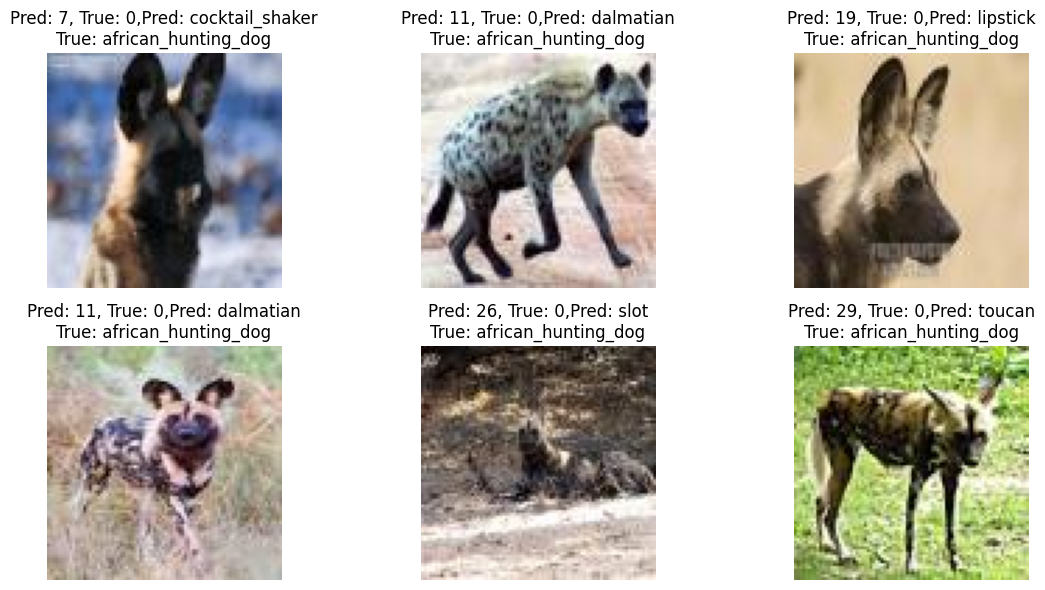

In [ ]:
# === Show Results Table ===
df_results = pd.DataFrame(results)

# Use to_markdown() to generate a Markdown table string
markdown_table = df_results.to_markdown(index=False) # index=False to exclude the DataFrame index

print("\n=== Experiment Results ===")
print(markdown_table) # Print the Markdown table string

# === Visualize Misclassified Images ===
def show_misclassified(images,label):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    plt.figure(figsize=(12, 6))
    for idx, (img, pred, true) in enumerate(images[:6]):
        predicted_class_name = class_names[pred]
        true_class_name = class_names[true]
        plt.subplot(2, 3, idx + 1)
        img_un = unnormalize(img, mean, std)
        plt.imshow(np.transpose(img_un, (1, 2, 0)))
        plt.title(f"Pred: {pred}, True: {true},Pred: {predicted_class_name}\nTrue: {true_class_name}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_misclassified(misclassified_samples[0],class_names)



This section defines the `occlusion_sensitivity` function, which takes a trained model, an image, and its true label to calculate an occlusion sensitivity map. It does this by placing a gray patch over parts of the image and measuring the change in the model's confidence for the true class.

***Note:
For the part — Occlusion Sensitivity Analysis — I have compiled it separately in Notebook_part2 using only two selected models.
This decision was taken after facing multiple incomplete runs due to extremely long execution times with all models.
The same occlusion sensitivity code is reused in other notebook, but executed only for two models to ensure smooth and complete execution.***

In [ ]:
window_size = 8  # N x N gray patch
stride = 2       # How much to move the window per step
gray_value = 0.5 # Middle-gray patch (same range as unnormalized image)
def occlusion_sensitivity(model, image, true_label, window_size=8, stride=2):
    _, H, W = image.shape
    sensitivity_map = np.zeros((H, W))
    original_image = image.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        baseline_prob = torch.softmax(model(original_image), dim=1)[0, true_label].item()

    for i in range(0, H - window_size + 1, stride):
        for j in range(0, W - window_size + 1, stride):
            occluded_image = image.clone()
            occluded_image[:, i:i+window_size, j:j+window_size] = 0.5  # gray patch
            input_tensor = occluded_image.unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                prob = torch.softmax(output, dim=1)[0, true_label].item()

            sensitivity_map[i + window_size // 2, j + window_size // 2] = prob

    return sensitivity_map


   Test Occlusion Sensitivity on One  correctly classified Image

In [ ]:
def get_classification_results(model, test_loader, device, max_samples=5):
    """
    Returns two lists of up to `max_samples` images:
    - misclassified: list of (image_tensor, predicted_label, true_label)
    - correctly_classified: list of (image_tensor, predicted_label, true_label)
    """
    misclassified = []
    correctly_classified = []

    model.eval()  # Set model to evaluation mode

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            preds = torch.argmax(output, dim=1)

            for i in range(len(data)):
                image = data[i].cpu()
                pred = preds[i].item()
                true = labels[i].item()

                if pred != true and len(misclassified) < max_samples:
                    misclassified.append((image, pred, true))
                elif pred == true and len(correctly_classified) < max_samples:
                    correctly_classified.append((image, pred, true))

                # Stop early if both lists are full
                if len(misclassified) >= max_samples and len(correctly_classified) >= max_samples:
                    break
            if len(misclassified) >= max_samples and len(correctly_classified) >= max_samples:
                break

    return misclassified, correctly_classified


misclassified, correctly_classified=get_classification_results(best_model, test_loader, device, max_samples=3)
img,pred,label=misclassified[0]
img1,pred1,label1=correctly_classified[0]

sensitivity_map = occlusion_sensitivity(best_model, img1, label1)

NameError: name 'best_model' is not defined